https://www.kaggle.com/c/lish-moa/overview

The Connectivity Map, a project within the Broad Institute of MIT and Harvard, together with the Laboratory for Innovation Science at Harvard (LISH), presents this challenge with the goal of advancing drug development through improvements to MoA prediction algorithms.

What is the Mechanism of Action (MoA) of a drug? And why is it important?

In the past, scientists derived drugs from natural products or were inspired by traditional remedies. Very common drugs, such as paracetamol, known in the US as acetaminophen, were put into clinical use decades before the biological mechanisms driving their pharmacological activities were understood. Today, with the advent of more powerful technologies, drug discovery has changed from the serendipitous approaches of the past to a more targeted model based on an understanding of the underlying biological mechanism of a disease. In this new framework, scientists seek to identify a protein target associated with a disease and develop a molecule that can modulate that protein target. As a shorthand to describe the biological activity of a given molecule, scientists assign a label referred to as mechanism-of-action or MoA for short.

How do we determine the MoAs of a new drug?

One approach is to treat a sample of human cells with the drug and then analyze the cellular responses with algorithms that search for similarity to known patterns in large genomic databases, such as libraries of gene expression or cell viability patterns of drugs with known MoAs.

In this competition, you will have access to a unique dataset that combines gene expression and cell viability data. The data is based on a new technology that measures simultaneously (within the same samples) human cells’ responses to drugs in a pool of 100 different cell types (thus solving the problem of identifying ex-ante, which cell types are better suited for a given drug). In addition, you will have access to MoA annotations for more than 5,000 drugs in this dataset.

As is customary, the dataset has been split into testing and training subsets. Hence, your task is to use the training dataset to develop an algorithm that automatically labels each case in the test set as one or more MoA classes. Note that since drugs can have multiple MoA annotations, the task is formally a multi-label classification problem.

How to evaluate the accuracy of a solution?

Based on the MoA annotations, the accuracy of solutions will be evaluated on the average value of the logarithmic loss function applied to each drug-MoA annotation pair.

If successful, you’ll help to develop an algorithm to predict a compound’s MoA given its cellular signature, thus helping scientists advance the drug discovery process.

In this notebook we will try a Feedforward neural network model.\
Now we use the train_targets_nonscored database to devlop new variables.\
This database has mechanisms of action for our train data set that are not present in the test.\
We will make a model for these MoAs and add the result as new variables for our model.

In [1]:
import gc
import time
import pandas as pd
import numpy as np
import re
import pickle
# from sklearn.cluster import Birch
# from sklearn.cluster import KMeans
# from sklearn.cluster import MiniBatchKMeans
# from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
# from sklearn.cluster import SpectralClustering    # Takes too long
# from sklearn.cluster import DBSCAN                # Did not work
# import hdbscan                                    # Does not have a predict only feature
# from sklearn.decomposition import PCA
# import seaborn as sns
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go
%matplotlib inline

# Instantly make your loops show a smart progress meter - just wrap any iterable with tqdm(iterable), and you're done!
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss


import torch
import torch.nn as nn
import torch.nn.functional as F

#Path to save the output
path_holdout = 'C:\\Users\\maxwi\\Python\\Kaggle\\Mechanism of action\\results 7\\'

In [2]:
#load the Data
train_features = pd.read_csv('train_features.csv') 
train_targets_scored = pd.read_csv('train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('train_targets_nonscored.csv')
test_features = pd.read_csv('test_features.csv')

In [3]:
#Function to reduce memory usage.
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train_features = reduce_mem_usage(train_features)  
train_targets_scored = reduce_mem_usage(train_targets_scored)
train_targets_nonscored = reduce_mem_usage(train_targets_nonscored)
test_features = reduce_mem_usage(test_features)

Mem. usage decreased to 40.18 Mb (74.8% reduction)
Mem. usage decreased to  4.86 Mb (87.1% reduction)
Mem. usage decreased to  9.31 Mb (87.3% reduction)
Mem. usage decreased to  6.72 Mb (74.8% reduction)


In [4]:
def loss_train_validation(db, rotation_x, save_to):
    '''
    loss_train_validation(db = log_loss_hp, rotation_x = 0, save_to = save_file_final)
    '''
    #Plot train and validation log loss
    fig, ax = plt.subplots(figsize=(15, 10))
    #Train log loss:
    x = db['parameter_index']
    y = db['log_loss_train']

#     ax.xaxis.set_ticks(x)
    ax.plot(x, y, color='black', zorder=1, linewidth=0.7, linestyle = 'solid')
    # add two layers of points to create an illusion of a discontinuous line. "zorder" specifies plotting order
    ax.scatter(x, y, s = 64, color = 'white', zorder = 2)
    ax.scatter(x, y, s = 8, color = 'black', zorder = 3)
    ax.text(x.iloc[-1] + 0.001, y.iloc[-1], 'Train', va = 'center')

    #Validation log loss:
#     x = log_loss_hp['parameter']
    y = db['log_loss_validation']

#     ax.xaxis.set_ticks(x)
    ax.plot(x, y, color='black', zorder=1, linewidth=0.7, linestyle = 'dashed')
    # add two layers of points to create an illusion of a discontinuous line. "zorder" specifies plotting order
    ax.scatter(x, y, s=64, color='white', zorder=2)
    ax.scatter(x, y, s=8, color='black', zorder=3)
    ax.text(x.iloc[-1] + 0.001, y.iloc[-1], 'Validation', va = 'center')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.xticks(rotation = rotation_x)

    print()
    print('Smallest log loss:', round(db['log_loss_validation'].min(), 4))
    print('Smallest log loss parameter:', db[np.in1d(db['log_loss_validation'], db['log_loss_validation'].min())]['parameter'].values[0])
    log_loss_hp.to_csv(save_to, index = False)

In [5]:
def print_time_to_end(progress_count, step_size, already_read, full_db_size):
    '''
    progress_check = print_time_to_end(progress_count = progress_check, step_size = progress_mult
                            , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))
    '''
#     progress += 1   #Changed to satisfy both situation if loading or not a saved progress.
    if already_read == progress_count * step_size:
        print()
        progress_per = round(already_read / full_db_size, 4)
        print(progress_per)
        
        end = time.time()
        elapsed = int(round(end - start, 0))
        total_run_time =  int(round(elapsed / (progress_per), 0))
        time_to_finish = int(round(elapsed / (progress_per), 0)) - elapsed
        print('Elapsed: {:02d}:{:02d}:{:02d}'.format(elapsed // 3600, (elapsed % 3600 // 60), elapsed % 60))
        print('Total run time: {:02d}:{:02d}:{:02d}'.format(total_run_time // 3600, (total_run_time % 3600 // 60), total_run_time % 60))
        print('Time to finish: {:02d}:{:02d}:{:02d}'.format(time_to_finish // 3600, (time_to_finish % 3600 // 60), time_to_finish % 60))
        print()
        return 1 #Increase progress_count
    
    return 0 #Don't increase progress_count

In [6]:
def seed_everything(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed = 1)

In [7]:
'''
Lets separate train_features and train_targets_scored into train_set and validation_set.
This is important to avoid overfitting.
'''
train_features_set, validation_features_set = train_test_split(train_features, test_size = 0.2, random_state = 1).copy()

train_labels_set = train_targets_scored.iloc[train_features_set.index].copy()
train_labels_nonscored_set = train_targets_nonscored.iloc[train_features_set.index].copy()

validation_labels_set = train_targets_scored.iloc[validation_features_set.index].copy()
validation_labels_nonscored_set = train_targets_nonscored.iloc[validation_features_set.index].copy()

#reset index. We don't really need a index as a number. We can identify our observations by the column 'sig_id'
train_features_set.reset_index(inplace = True)
train_features_set.drop('index', axis = 1, inplace = True)

validation_features_set.reset_index(inplace = True)
validation_features_set.drop('index', axis = 1, inplace = True)

train_labels_set.reset_index(inplace = True)
train_labels_set.drop('index', axis = 1, inplace = True)

train_labels_nonscored_set.reset_index(inplace = True)
train_labels_nonscored_set.drop('index', axis = 1, inplace = True)

validation_labels_set.reset_index(inplace = True)
validation_labels_set.drop('index', axis = 1, inplace = True)

validation_labels_nonscored_set.reset_index(inplace = True)
validation_labels_nonscored_set.drop('index', axis = 1, inplace = True)


#Remove control observations.
train_features_without_control = train_features_set[train_features_set['cp_type'] != 'ctl_vehicle'].copy()
train_labels_without_control = train_labels_set.iloc[train_features_without_control.index].copy()
train_labels_nonscored_without_control = train_labels_nonscored_set.iloc[train_features_without_control.index].copy()

#reset index. 
train_features_without_control.reset_index(inplace = True)
train_features_without_control.drop('index', axis = 1, inplace = True)

train_labels_without_control.reset_index(inplace = True)
train_labels_without_control.drop('index', axis = 1, inplace = True)

train_labels_nonscored_without_control.reset_index(inplace = True)
train_labels_nonscored_without_control.drop('index', axis = 1, inplace = True)



# For the validation and test, we will remove just the column 'cp_type'.
# However, we will not delete the observations. 
# Instead, we will create a separate data frame with 'cp_type' so we can set all MoA equal to zero for these observations.


validation_features_without_control = validation_features_set.drop(['cp_type'], axis = 1).copy()
validation_features_control = validation_features_set[['sig_id', 'cp_type']].copy()

test_features_without_control = test_features.drop(['cp_type'], axis = 1).copy()
test_features_control = test_features[['sig_id', 'cp_type']].copy()


#These are the same adjustments used before.
train_x = train_features_without_control.drop(['sig_id', 'cp_type'], axis = 1).copy()
test_x = validation_features_without_control.drop(['sig_id'], axis = 1).copy()
test_x_control = validation_features_control.copy()
holdout_x = test_features_without_control.drop(['sig_id'], axis = 1).copy()
holdout_x_control = test_features_control.copy()

train_y = train_labels_without_control.drop(['sig_id'], axis = 1).copy()
train_y_nonscored = train_labels_nonscored_without_control.drop(['sig_id'], axis = 1).copy()
test_y = validation_labels_set.drop(['sig_id'], axis = 1).copy()
test_y_nonscored = validation_labels_nonscored_set.drop(['sig_id'], axis = 1).copy()

train_x['cp_dose'] = train_x['cp_dose'].str.extract(r"([1-2])", expand = True).astype(np.int8)
test_x['cp_dose'] = test_x['cp_dose'].str.extract(r"([1-2])", expand = True).astype(np.int8)

C:\Users\maxwi\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


To do the hyperparametrization and the holdout, we should use\
validation_features_without_control and validation_features_control, and\
test_features_without_control and test_features_control

In [8]:
def log_loss_mean(y_real, predictions):
    y_real_db = pd.DataFrame(data = y_real)
    
    log_loss_aux = []
    for col in y_real_db:
        log_loss_aux.append(log_loss(y_real_db[col].astype(float), predictions[col].astype(float), labels = [0, 1]))
        
    return np.mean(log_loss_aux)

In [9]:
'''
From: https://github.com/Varal7/ml-tutorial/blob/master/Part2.ipynb
In most ML applications we do mini-batch stochastic gradient descent instead of pure stochastic gradient descent.

Mini-batch SGD is a step between full gradient descent and stochastic gradient descent by computing the average gradient over a small number of examples.

In a nutshell, given n examples:

Full GD: dL/dw = average over all n examples. One step per n examples.
SGD: dL/dw = point estimate over a single example. n steps per n examples.
Mini-batch SGD: dL/dw = average over m << n examples. n / m steps per n examples.
Advantages of mini-batch SGD include a more stable gradient estimate and computational efficiency on modern hardware (exploiting parallelism gives sub-linear to constant time complexity, especially on GPU).

In PyTorch, batched tensors are represented as just another dimension. Most of the deep learning modules assume batched tensors as input (even if the batch size is just 1).

Code from: MITx: 6.86x (Project 3)
'''
def batchify_data(x_data, y_data, batch_size):
    """Takes a set of data points and labels and groups them into batches."""
    # Only take batch_size chunks (i.e. drop the remainder)
    N = int(len(x_data) / batch_size) * batch_size
    batches = []
    for i in range(0, N, batch_size):
        batches.append({
            'x': torch.tensor(x_data[i:i+batch_size], dtype=torch.float32),
            'y': torch.tensor(y_data[i:i+batch_size], dtype=torch.long
        )})
    return batches

In [10]:
def compute_accuracy(predictions, y):
    """Computes the accuracy of predictions against the gold labels, y."""
    predictions_np = predictions.detach().numpy()
    y_np = y.detach().numpy()
    return np.mean(np.equal(predictions_np, y_np))


# Training Procedure
def train_model(train_data, dev_data, model, lr=0.01, momentum=0.9, nesterov = False, n_epochs=30, save_model = 'FNN'):
# def train_model(train_data, dev_data, model, lr=0.01, n_epochs=30):
    """Train a model for N epochs given data and hyper-params."""
    # We optimize with SGD
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=nesterov)
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)  #It takes too long! with epochs = 320, lr = 0.1 and batch_size = 32 it did not help.

    for epoch in range(1, n_epochs):
        print("-------------\nEpoch {}:\n".format(epoch))


        # Run **training***
        train_loss, train_acc, train_out = run_epoch(train_data, model.train(), optimizer)
        print('Train loss: {:.6f} | Train accuracy: {:.6f}'.format(train_loss, train_acc))

        # Run **validation**
        dev_loss, dev_acc, dev_out = run_epoch(dev_data, model.eval(), optimizer)
        print('Val loss:   {:.6f} | Val accuracy:   {:.6f}'.format(dev_loss, dev_acc))
        # Save model
        torch.save(model, save_model + '.pt')
    return 


def run_epoch(data, model, optimizer):
    """Train model for one pass of train data, and return loss, acccuracy"""
    # Gather losses
    losses = []
    batch_accuracies = []

    # If model is in train mode, use optimizer.
    is_training = model.training

    # Iterate through batches
    for batch in tqdm(data):
        # Grab x and y
        x, y = batch['x'], batch['y']
       
        # Get output predictions
        out = model(x)
        y = y.type_as(out)
        
        
        # Predict and store accuracy      
        predictions = torch.round(out)
        batch_accuracies.append(compute_accuracy(predictions, y))


        # Compute loss
        loss = F.binary_cross_entropy(out, y)
        losses.append(loss.data.item())

        # If training, do an update.
        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Calculate epoch level scores
    avg_loss = np.mean(losses)
    avg_accuracy = np.mean(batch_accuracies)
    return avg_loss, avg_accuracy, out


In [11]:
#Lets simplify our functions so we do not see the print in each epoch.

# Training Procedure
def train_model_h(train_data, dev_data, model, lr=0.01, momentum=0.9, nesterov = False, n_epochs=30):
    """Train a model for N epochs given data and hyper-params."""
    # We optimize with SGD
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=nesterov)
    
    #Try adam
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, n_epochs):

        # Run **training***
        train_loss, train_out = run_epoch_h(train_data, model.train(), optimizer)

        # Run **validation**
        dev_loss, dev_out = run_epoch_h(dev_data, model.eval(), optimizer)
        # Save model
        torch.save(model, 'mnist_model_fully_connected.pt')
    return 


def run_epoch_h(data, model, optimizer):
    """Train model for one pass of train data, and return loss, acccuracy"""
    # Gather losses
    losses = []

    # If model is in train mode, use optimizer.
    is_training = model.training

    # Iterate through batches
    for batch in data:
        # Grab x and y
        x, y = batch['x'], batch['y']
       
        # Get output predictions
        out = model(x)
        y = y.type_as(out)      


        # Compute loss
        loss = F.binary_cross_entropy(out, y)
        losses.append(loss.data.item())

        # If training, do an update.
        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Calculate epoch level scores
    avg_loss = np.mean(losses)
    return avg_loss, out


In [12]:
# Lets try differents activation functions
def new_activation_function(parameter):
    if parameter == 0: #ReLu()
        return nn.ReLU()

    if parameter == 1: #tanh()
        return nn.Tanh()

    if parameter == 2: #LeakyReLU()
        return nn.LeakyReLU()
            
    if parameter == 3: #ReLU6()
        return nn.ReLU6() 

    if parameter == 4: #RReLU()
        return nn.RReLU() 

    if parameter == 5: #SELU()
        return nn.SELU()

    if parameter == 6: #CELU()
        return nn.CELU()
 
    if parameter == 7: #GELU()
        return nn.GELU()
       
    if parameter == 8: #Softsign()
        return nn.Softsign()
    
    if parameter == 9: #LogSoftmax()
        return nn.LogSoftmax()

    if parameter == 10: #.Softmax(dim=1)
        return  nn.Softmax(dim=1)

    if parameter == 11: #.ELU()
        return nn.ELU()

    if parameter == 12: #.LogSigmoid()
        return nn.LogSigmoid()
  
    if parameter == 13: #.Sigmoid()
        return nn.Sigmoid()
    
    if parameter == 14: #.PReLU()
        return nn.PReLU()
    
    if parameter == 15: #.Softplus()
        return nn.Softplus()
    
    if parameter == 16: #.Tanhshrink()
        return nn.Tanhshrink() 

In [13]:
# Make variable Gauss_c_var_15

mask_c = train_x.columns.str.contains('^c-[0-99]')
train_c_variables = train_x.loc[:,mask_c].copy()
test_c_variables = test_x.loc[:,mask_c].copy()

# cell variables
clf_GaussianMixture = GaussianMixture(n_components = 15, covariance_type = 'full')
fit_GaussianMixture_train_c_variables = clf_GaussianMixture.fit(X = train_c_variables)  
train_Gauss_c_var_15 = clf_GaussianMixture.predict_proba(train_c_variables)
test_Gauss_c_var_15 = clf_GaussianMixture.predict_proba(test_c_variables)

train_Gauss_c_var_15_db = pd.DataFrame(data = train_Gauss_c_var_15)
train_Gauss_c_var_15_db.columns = ['Gauss_c_var_15_' + str(x) for x in range(1, 15 + 1)]

test_Gauss_c_var_15_db = pd.DataFrame(data = test_Gauss_c_var_15)
test_Gauss_c_var_15_db.columns = ['Gauss_c_var_15_' + str(x) for x in range(1, 15 + 1)]


# Add variables in our database.
train_x = train_x.join(train_Gauss_c_var_15_db)
test_x = test_x.join(test_Gauss_c_var_15_db)

  6%|▌         | 1/17 [11:45<3:08:14, 705.89s/it]


0.1176
Elapsed: 00:22:06
Total run time: 03:07:56
Time to finish: 02:45:50



 18%|█▊        | 3/17 [33:39<2:39:40, 684.30s/it]


0.2353
Elapsed: 00:44:42
Total run time: 03:09:58
Time to finish: 02:25:16



 29%|██▉       | 5/17 [55:46<2:14:45, 673.76s/it]


0.3529
Elapsed: 01:08:15
Total run time: 03:13:24
Time to finish: 02:05:09



 41%|████      | 7/17 [1:20:26<1:57:48, 706.82s/it]


0.4706
Elapsed: 01:30:55
Total run time: 03:13:12
Time to finish: 01:42:17



 53%|█████▎    | 9/17 [1:43:04<1:32:56, 697.07s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



0.5882
Elapsed: 01:54:08
Total run time: 03:14:02
Time to finish: 01:19:54



 65%|██████▍   | 11/17 [2:04:35<1:06:55, 669.32s/it]


0.7059
Elapsed: 02:16:58
Total run time: 03:14:02
Time to finish: 00:57:04



 76%|███████▋  | 13/17 [2:28:32<46:09, 692.31s/it]  


0.8235
Elapsed: 02:39:16
Total run time: 03:13:24
Time to finish: 00:34:08



 88%|████████▊ | 15/17 [2:49:24<21:53, 656.82s/it]


0.9412
Elapsed: 03:01:43
Total run time: 03:13:04
Time to finish: 00:11:21



100%|██████████| 17/17 [3:12:19<00:00, 678.81s/it]



Smallest log loss: 0.004
Smallest log loss parameter: 9.0


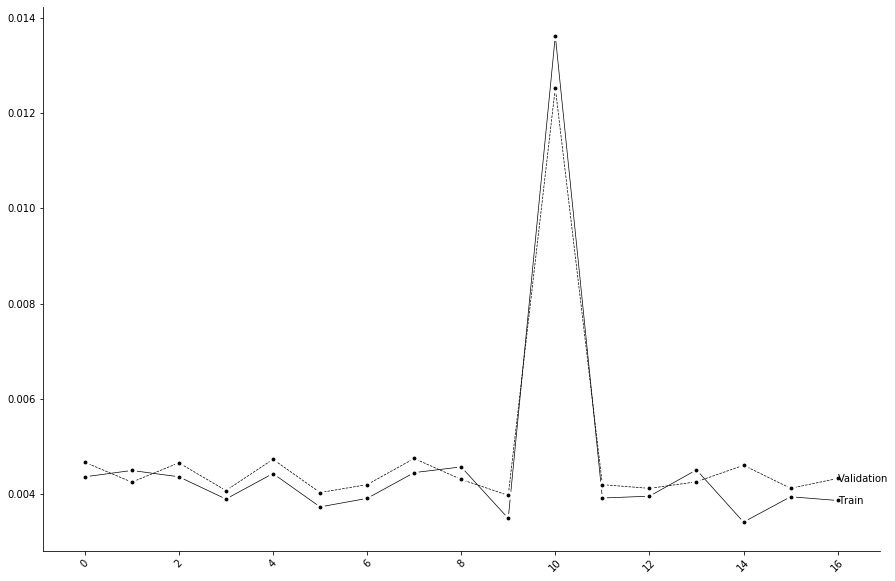

In [15]:
# First model (nonscored data) - Trying different activation functions.
# Y_train = train_y.to_numpy(copy = True)
# Y_dev = test_y.to_numpy(copy = True)
Y_train = train_y_nonscored.to_numpy(copy = True)
Y_dev = test_y_nonscored.to_numpy(copy = True)

X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)


train_batches_full_base = torch.tensor(X_train, dtype=torch.float32)
dev_batches_full_base = torch.tensor(X_dev, dtype=torch.float32)
    
save_file_aux = path_holdout + "log_loss_nonscored_activation_aux.csv"
save_file_final = path_holdout + "log_loss_nonscored_activation_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 2).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 2
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = 320               #Hyperparameter
        batch_size = 32             #Hyperparameter
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(1*X_train.shape[1])), 
                    new_activation_function(parameter),
                    nn.Linear(int(1*X_train.shape[1]), 402),
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.11 #Hyperparameter
        momentum = 0 
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        out_train = model(train_batches_full_base) 
        out_dev = model(dev_batches_full_base) 
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 402, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)


  0%|          | 0/13 [00:00<?, ?it/s]


0.1538
Elapsed: 00:00:00
Total run time: 00:00:00
Time to finish: 00:00:00


0.3077
Elapsed: 00:00:00
Total run time: 00:00:00
Time to finish: 00:00:00


0.4615
Elapsed: 00:00:00
Total run time: 00:00:00
Time to finish: 00:00:00


0.6154
Elapsed: 00:00:00
Total run time: 00:00:00
Time to finish: 00:00:00


0.7692
Elapsed: 00:00:00
Total run time: 00:00:00
Time to finish: 00:00:00


0.9231
Elapsed: 00:00:00
Total run time: 00:00:00
Time to finish: 00:00:00



100%|██████████| 13/13 [00:00<00:00, 266.97it/s]



Smallest log loss: 0.0039
Smallest log loss parameter: 0.75


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


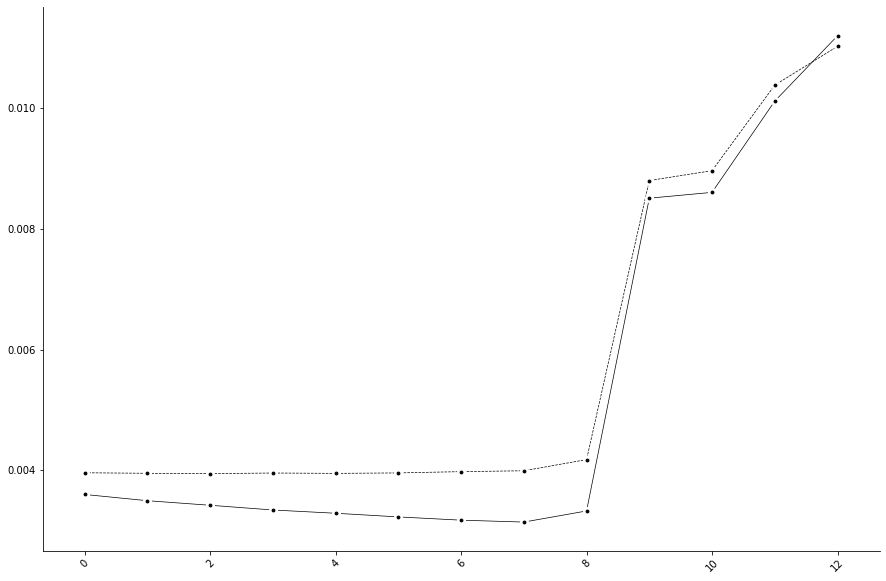

In [23]:
# First model (nonscored data) - Trying different units.
# Y_train = train_y.to_numpy(copy = True)
# Y_dev = test_y.to_numpy(copy = True)
Y_train = train_y_nonscored.to_numpy(copy = True)
Y_dev = test_y_nonscored.to_numpy(copy = True)

X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)


train_batches_full_base = torch.tensor(X_train, dtype=torch.float32)
dev_batches_full_base = torch.tensor(X_dev, dtype=torch.float32)
    
save_file_aux = path_holdout + "log_loss_nonscored_unit_aux.csv"
save_file_final = path_holdout + "log_loss_nonscored_unit_hp.csv"

#Load stoped process
load = 1
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 2).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 2
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.5]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = 380               #Hyperparameter
        batch_size = 32             #Hyperparameter
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(parameter*X_train.shape[1])), 
                    nn.LogSoftmax(),
                    nn.Linear(int(parameter*X_train.shape[1]), 402),
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.11 #Hyperparameter
        momentum = 0 
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        out_train = model(train_batches_full_base) 
        out_dev = model(dev_batches_full_base) 
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 402, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)


  6%|▌         | 1/17 [17:47<4:44:32, 1067.03s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



0.1176
Elapsed: 00:34:23
Total run time: 04:52:23
Time to finish: 04:18:00




 12%|█▏        | 2/17 [34:22<4:21:25, 1045.70s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)

 18%|█▊        | 3/17 [52:17<4:05:59, 1054.27s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



0.2353
Elapsed: 01:09:26
Total run time: 04:55:05
Time to finish: 03:45:39




 24%|██▎       | 4/17 [1:09:25<3:46:45, 1046.54s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)

 29%|██▉       | 5/17 [1:26:58<3:29:41, 1048.44s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



0.3529
Elapsed: 01:45:35
Total run time: 04:59:11
Time to finish: 03:13:36




 35%|███▌      | 6/17 [1:45:35<3:15:57, 1068.89s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)

 41%|████      | 7/17 [2:03:57<2:59:48, 1078.86s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



0.4706
Elapsed: 02:22:44
Total run time: 05:03:18
Time to finish: 02:40:34




 47%|████▋     | 8/17 [2:22:44<2:43:59, 1093.28s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)

 53%|█████▎    | 9/17 [2:41:13<2:26:24, 1098.02s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



0.5882
Elapsed: 03:00:27
Total run time: 05:06:47
Time to finish: 02:06:20




 59%|█████▉    | 10/17 [3:00:26<2:10:02, 1114.68s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)

 65%|██████▍   | 11/17 [3:17:08<1:48:04, 1080.82s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



0.7059
Elapsed: 03:35:39
Total run time: 05:05:30
Time to finish: 01:29:51




 71%|███████   | 12/17 [3:35:38<1:30:47, 1089.54s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)

 76%|███████▋  | 13/17 [3:53:58<1:12:50, 1092.61s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



0.8235
Elapsed: 04:11:29
Total run time: 05:05:23
Time to finish: 00:53:54




 82%|████████▏ | 14/17 [4:11:29<54:00, 1080.11s/it]  C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)

 88%|████████▊ | 15/17 [4:28:35<35:28, 1064.06s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



0.9412
Elapsed: 04:47:43
Total run time: 05:05:41
Time to finish: 00:17:58




 94%|█████████▍| 16/17 [4:47:43<18:09, 1089.08s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)

100%|██████████| 17/17 [5:04:52<00:00, 1076.05s/it]



Smallest log loss: 0.004
Smallest log loss parameter: 16.0


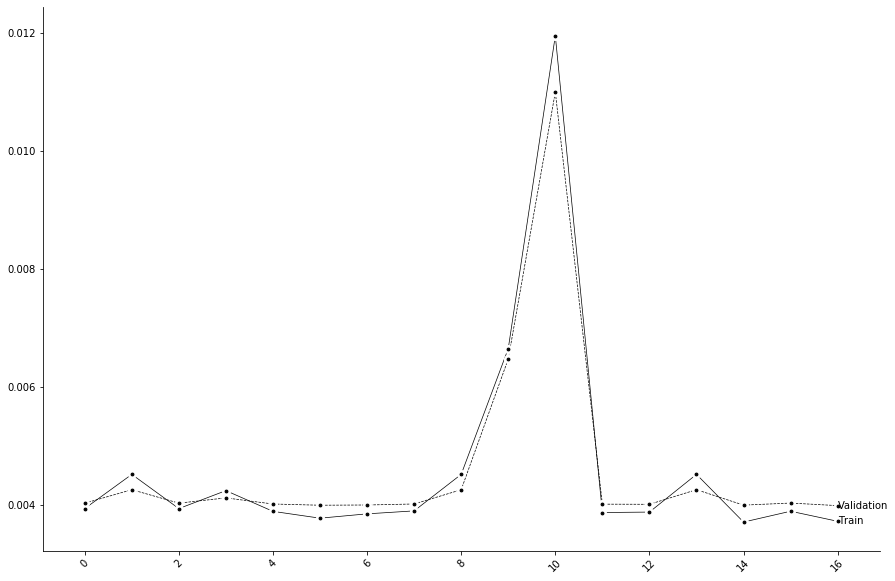

In [25]:
# First model (nonscored data) - Trying second layer.
# Y_train = train_y.to_numpy(copy = True)
# Y_dev = test_y.to_numpy(copy = True)
Y_train = train_y_nonscored.to_numpy(copy = True)
Y_dev = test_y_nonscored.to_numpy(copy = True)

X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)


train_batches_full_base = torch.tensor(X_train, dtype=torch.float32)
dev_batches_full_base = torch.tensor(X_dev, dtype=torch.float32)
    
save_file_aux = path_holdout + "log_loss_nonscored_layer2_aux.csv"
save_file_final = path_holdout + "log_loss_nonscored_layer2_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 2).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 2
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = 380               #Hyperparameter
        batch_size = 32             #Hyperparameter
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(0.75*X_train.shape[1])), 
                    nn.LogSoftmax(),
                    nn.Linear(int(0.75*X_train.shape[1]), int(0.75*X_train.shape[1])),
                    new_activation_function(parameter),
                    nn.Linear(int(0.75*X_train.shape[1]), 402),
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.11 #Hyperparameter
        momentum = 0 
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        out_train = model(train_batches_full_base) 
        out_dev = model(dev_batches_full_base) 
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 402, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)


  0%|          | 0/15 [00:00<?, ?it/s]


0.1333
Elapsed: 00:00:00
Total run time: 00:00:00
Time to finish: 00:00:00


0.2667
Elapsed: 00:00:00
Total run time: 00:00:00
Time to finish: 00:00:00


0.4
Elapsed: 00:00:00
Total run time: 00:00:00
Time to finish: 00:00:00


0.5333
Elapsed: 00:00:00
Total run time: 00:00:00
Time to finish: 00:00:00


0.6667
Elapsed: 00:00:00
Total run time: 00:00:00
Time to finish: 00:00:00



C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



0.8
Elapsed: 00:40:59
Total run time: 00:51:14
Time to finish: 00:10:15




 80%|████████  | 12/15 [40:59<10:14, 204.93s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)

 87%|████████▋ | 13/15 [1:23:44<30:26, 913.02s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



0.9333
Elapsed: 02:09:03
Total run time: 02:18:16
Time to finish: 00:09:13




 93%|█████████▎| 14/15 [2:09:03<24:14, 1454.83s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)

100%|██████████| 15/15 [2:56:29<00:00, 705.99s/it] 



Smallest log loss: 0.0039
Smallest log loss parameter: 3.0


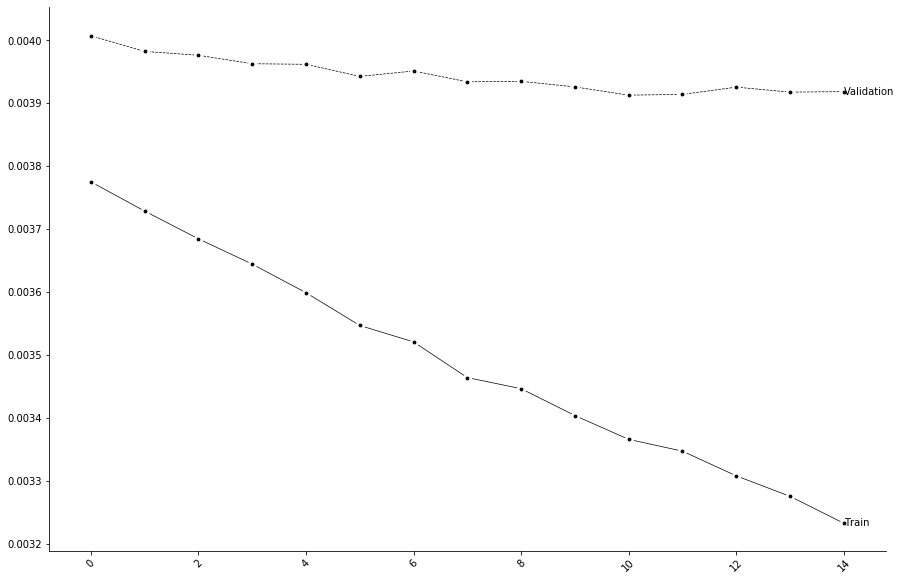

In [29]:
# First model (nonscored data) - Trying second layer units.
# Y_train = train_y.to_numpy(copy = True)
# Y_dev = test_y.to_numpy(copy = True)
Y_train = train_y_nonscored.to_numpy(copy = True)
Y_dev = test_y_nonscored.to_numpy(copy = True)

X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)


train_batches_full_base = torch.tensor(X_train, dtype=torch.float32)
dev_batches_full_base = torch.tensor(X_dev, dtype=torch.float32)
    
save_file_aux = path_holdout + "log_loss_nonscored_units2_aux.csv"
save_file_final = path_holdout + "log_loss_nonscored_units2_hp.csv"

#Load stoped process
load = 1
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 2).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 2
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = 380               #Hyperparameter
        batch_size = 32             #Hyperparameter
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(0.75*X_train.shape[1])), 
                    nn.LogSoftmax(),
                    nn.Linear(int(0.75*X_train.shape[1]), int(parameter*X_train.shape[1])),
                    nn.Tanhshrink(),
                    nn.Linear(int(parameter*X_train.shape[1]), 402),
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.11 #Hyperparameter
        momentum = 0 
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        out_train = model(train_batches_full_base) 
        out_dev = model(dev_batches_full_base) 
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 402, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)



  0%|          | 0/17 [00:00<?, ?it/s]


0.1176
Elapsed: 00:00:00
Total run time: 00:00:00
Time to finish: 00:00:00


0.2353
Elapsed: 00:00:00
Total run time: 00:00:00
Time to finish: 00:00:00


0.3529
Elapsed: 00:00:00
Total run time: 00:00:00
Time to finish: 00:00:00


0.4706
Elapsed: 00:00:00
Total run time: 00:00:00
Time to finish: 00:00:00


0.5882
Elapsed: 00:00:00
Total run time: 00:00:00
Time to finish: 00:00:00


0.7059
Elapsed: 00:00:00
Total run time: 00:00:00
Time to finish: 00:00:00



C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



0.8235
Elapsed: 00:39:57
Total run time: 00:48:31
Time to finish: 00:08:34





 82%|████████▏ | 14/17 [39:56<08:33, 171.20s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 88%|████████▊ | 15/17 [1:19:40<27:50, 835.05s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



0.9412
Elapsed: 01:58:46
Total run time: 02:06:11
Time to finish: 00:07:25





 94%|█████████▍| 16/17 [1:58:45<21:28, 1288.06s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


100%|██████████| 17/17 [2:37:53<00:00, 557.29s/it] 



Smallest log loss: 0.0039
Smallest log loss parameter: 0.17


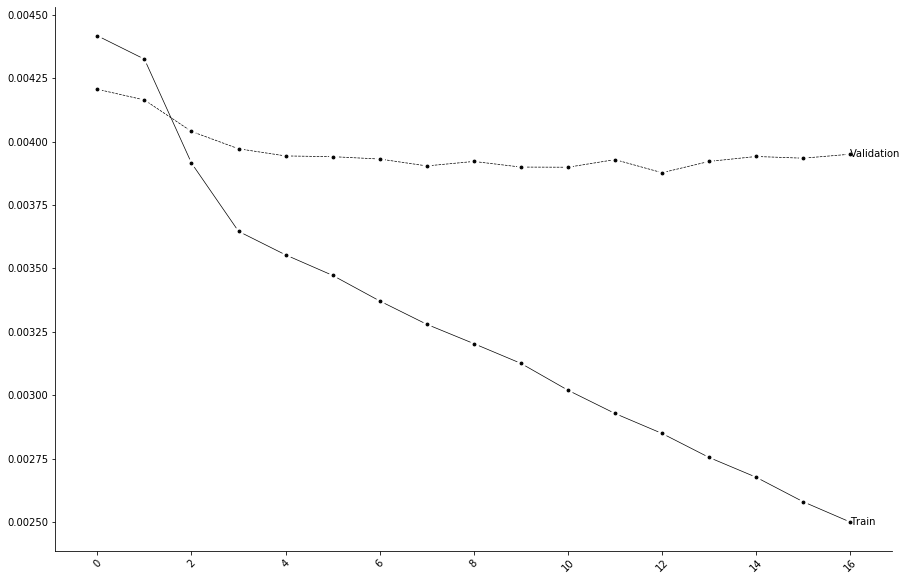

In [33]:
# First model (nonscored data) - leaning rate.
# Y_train = train_y.to_numpy(copy = True)
# Y_dev = test_y.to_numpy(copy = True)
Y_train = train_y_nonscored.to_numpy(copy = True)
Y_dev = test_y_nonscored.to_numpy(copy = True)

X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)


train_batches_full_base = torch.tensor(X_train, dtype=torch.float32)
dev_batches_full_base = torch.tensor(X_dev, dtype=torch.float32)
    
save_file_aux = path_holdout + "log_loss_nonscored_learning_rate_aux.csv"
save_file_final = path_holdout + "log_loss_nonscored_learning_rate_hp.csv"

#Load stoped process
load = 1
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 3).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 2
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [0.005, 0.01, 0.05, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = 380               #Hyperparameter
        batch_size = 32             #Hyperparameter
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(0.75*X_train.shape[1])), 
                    nn.LogSoftmax(),
                    nn.Linear(int(0.75*X_train.shape[1]), int(3*X_train.shape[1])),
                    nn.Tanhshrink(),
                    nn.Linear(int(3*X_train.shape[1]), 402),
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = parameter #Hyperparameter
        momentum = 0 
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        out_train = model(train_batches_full_base) 
        out_dev = model(dev_batches_full_base) 
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 402, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)



  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(tra


0.3333
Elapsed: 03:20:08
Total run time: 10:00:28
Time to finish: 06:40:20





 33%|███▎      | 2/6 [3:20:07<7:28:26, 6726.67s/it] C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 50%|█████     | 3/6 [3:58:48<4:30:14, 5404.75s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



0.6667
Elapsed: 04:23:12
Total run time: 06:34:47
Time to finish: 02:11:35





 67%|██████▋   | 4/6 [4:23:12<2:20:45, 4222.54s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 83%|████████▎ | 5/6 [4:42:33<55:04, 3304.14s/it]  C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



1.0
Elapsed: 04:58:09
Total run time: 04:58:09
Time to finish: 00:00:00





100%|██████████| 6/6 [4:58:08<00:00, 2981.43s/it]



Smallest log loss: 0.0039
Smallest log loss parameter: 32.0


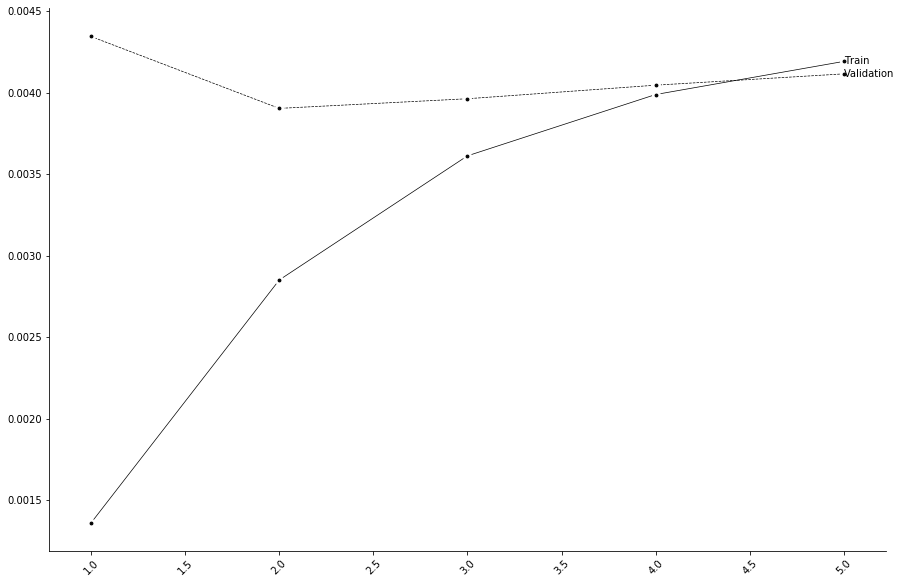

In [36]:
# First model (nonscored data) - batch_size.
# Y_train = train_y.to_numpy(copy = True)
# Y_dev = test_y.to_numpy(copy = True)
Y_train = train_y_nonscored.to_numpy(copy = True)
Y_dev = test_y_nonscored.to_numpy(copy = True)

X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)


train_batches_full_base = torch.tensor(X_train, dtype=torch.float32)
dev_batches_full_base = torch.tensor(X_dev, dtype=torch.float32)
    
save_file_aux = path_holdout + "log_loss_nonscored_batch_size_aux.csv"
save_file_final = path_holdout + "log_loss_nonscored_batch_size_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 3).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 2
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [8, 16, 32, 64, 128, 256]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = 380               #Hyperparameter
        batch_size = parameter             #Hyperparameter
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(0.75*X_train.shape[1])), 
                    nn.LogSoftmax(),
                    nn.Linear(int(0.75*X_train.shape[1]), int(3*X_train.shape[1])),
                    nn.Tanhshrink(),
                    nn.Linear(int(3*X_train.shape[1]), 402),
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.17 #Hyperparameter
        momentum = 0 
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        out_train = model(train_batches_full_base) 
        out_dev = model(dev_batches_full_base) 
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 402, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)



  0%|          | 0/9 [00:00<?, ?it/s]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 11%|█         | 1/9 [27:44<3:41:57, 1664.64s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



0.2222
Elapsed: 00:56:02
Total run time: 04:12:11
Time to finish: 03:16:09





 22%|██▏       | 2/9 [56:01<3:15:20, 1674.41s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 33%|███▎      | 3/9 [1:25:03<2:49:27, 1694.61s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



0.4444
Elapsed: 01:55:03
Total run time: 04:18:53
Time to finish: 02:23:50





 44%|████▍     | 4/9 [1:55:02<2:23:49, 1725.95s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 56%|█████▌    | 5/9 [2:26:18<1:58:03, 1770.85s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



0.6667
Elapsed: 02:58:13
Total run time: 04:27:19
Time to finish: 01:29:06





 67%|██████▋   | 6/9 [2:58:12<1:30:41, 1813.96s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 78%|███████▊  | 7/9 [3:31:21<1:02:13, 1866.52s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



0.8889
Elapsed: 04:09:50
Total run time: 04:41:04
Time to finish: 00:31:14





 89%|████████▉ | 8/9 [4:09:50<33:19, 1999.11s/it]  C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


100%|██████████| 9/9 [4:50:35<00:00, 1937.29s/it]



Smallest log loss: 0.0039
Smallest log loss parameter: 320.0


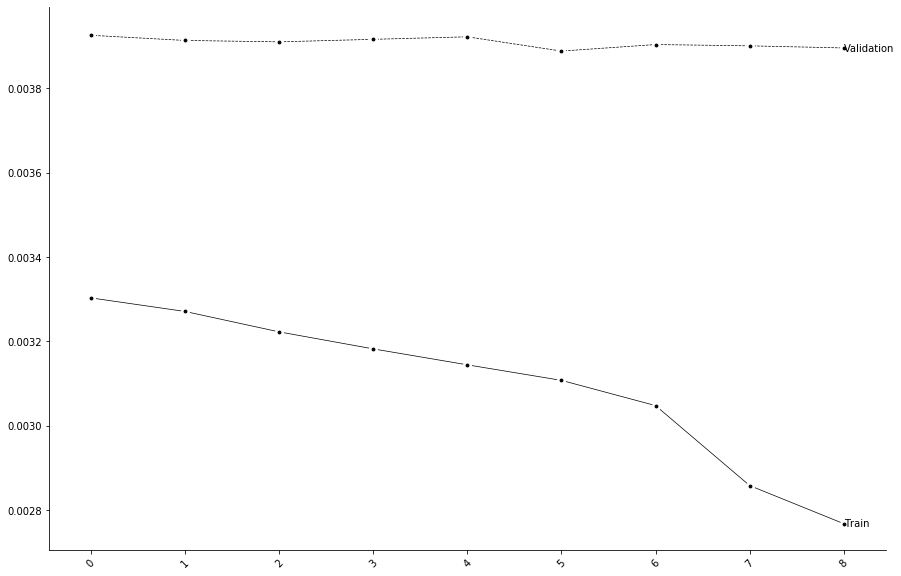

In [37]:
# First model (nonscored data) - n_epochs.
# Y_train = train_y.to_numpy(copy = True)
# Y_dev = test_y.to_numpy(copy = True)
Y_train = train_y_nonscored.to_numpy(copy = True)
Y_dev = test_y_nonscored.to_numpy(copy = True)

X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)


train_batches_full_base = torch.tensor(X_train, dtype=torch.float32)
dev_batches_full_base = torch.tensor(X_dev, dtype=torch.float32)
    
save_file_aux = path_holdout + "log_loss_nonscored_n_epochs_aux.csv"
save_file_final = path_holdout + "log_loss_nonscored_n_epochs_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 2
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [270, 280, 290, 300, 310, 320, 330, 380, 400]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = parameter               #Hyperparameter
        batch_size = 32             #Hyperparameter
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(0.75*X_train.shape[1])), 
                    nn.LogSoftmax(),
                    nn.Linear(int(0.75*X_train.shape[1]), int(3*X_train.shape[1])),
                    nn.Tanhshrink(),
                    nn.Linear(int(3*X_train.shape[1]), 402),
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.17 #Hyperparameter
        momentum = 0 
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        out_train = model(train_batches_full_base) 
        out_dev = model(dev_batches_full_base) 
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 402, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

In [40]:
# Get predictins of the winning model.

# Y_train = train_y.to_numpy(copy = True)
# Y_dev = test_y.to_numpy(copy = True)
Y_train = train_y_nonscored.to_numpy(copy = True)
Y_dev = test_y_nonscored.to_numpy(copy = True)

X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)


train_batches_full_base = torch.tensor(X_train, dtype=torch.float32)
dev_batches_full_base = torch.tensor(X_dev, dtype=torch.float32)

n_epochs = 320               #Hyperparameter
batch_size = 32             #Hyperparameter
train_batches = batchify_data(X_train, Y_train, batch_size)
dev_batches = batchify_data(X_dev, Y_dev, batch_size)


#################################
## Model specification
model = nn.Sequential(
            nn.Linear(X_train.shape[1], int(0.75*X_train.shape[1])), 
            nn.LogSoftmax(),
            nn.Linear(int(0.75*X_train.shape[1]), int(3*X_train.shape[1])),
            nn.Tanhshrink(),
            nn.Linear(int(3*X_train.shape[1]), 402),
            nn.Sigmoid(),  #So we have probabilities at the end
        )

lr = 0.17 #Hyperparameter
momentum = 0 
##################################

#Train model
train_model(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs, save_model = 'FNN_nonsocored')

# Get output.
# Evaluate the model on test data.
out_train = model(train_batches_full_base) 
out_dev = model(dev_batches_full_base)

out_train = out_train.detach().numpy()
out_train_nonscored = pd.DataFrame(data = out_train)
          
# Adjust out_dev for the control group
out_dev = out_dev.detach().numpy()
# Make a matrix with zeros when control.
treatment_flag = test_x_control['cp_type'] == 'trt_cp'
treatment_flag = np.array([treatment_flag])
treatment_flag = np.repeat(treatment_flag.transpose(), 402, axis = 1)
out_dev = out_dev*treatment_flag
out_dev_nonscored = pd.DataFrame(data = out_dev)
    
print()
print('Log loss train:', log_loss_mean(Y_train, out_train_nonscored))
print('Log loss dev:', log_loss_mean(Y_dev, out_dev_nonscored))

-------------
Epoch 1:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 88.76it/s]

  3%|▎         | 18/549 [00:00<00:06, 87.17it/s]

  5%|▌         | 29/549 [00:00<00:05, 90.42it/s]

  7%|▋         | 38/549 [00:00<00:05, 89.16it/s]

  9%|▊         | 47/549 [00:00<00:05, 86.92it/s]

 11%|█         | 58/549 [00:00<00:05, 89.49it/s]

 12%|█▏        | 66/549 [00:00<00:05, 85.10it/s]

 14%|█▎        | 75/549 [00:00<00:05, 84.63it/s]

 15%|█▌        | 84/549 [00:00<00:05, 85.65it/s]

 17%|█▋        | 93/549 [00:01<00:05, 86.35it/s]

 19%|█▉        | 103/549 [00:01<00:05, 85.87it/s]

 20%|██        | 112/549 [00:01<00:05, 85.73it/s]

 22%|██▏       | 121/549 [00:01<00:04, 86.23it/s]

 24%|██▎       | 130/549 [00:01<00:04, 85.79it/s]

 26%|██▌       | 140/549 [00:01<00:04, 87.57it/s]

 27%|██▋       | 149/549 [00:01<00:04, 87.57it/s]

 29%|██▉       | 158/549 [00:01<00:04, 87.58it/s]

 30%|███       | 167/549 [00:01<00:04, 85.36it/s]

 32%|███▏      | 176/549 [00:02<00:04, 85.81it/s]


Train loss: 0.007083 | Train accuracy: 0.998560




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|███       | 45/148 [00:00<00:00, 436.38it/s]

 61%|██████    | 90/148 [00:00<00:00, 438.39it/s]

100%|██████████| 148/148 [00:00<00:00, 407.44it/s]


Val loss:   0.004419 | Val accuracy:   0.999474
-------------
Epoch 2:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 96.39it/s]

  3%|▎         | 19/549 [00:00<00:05, 92.58it/s]

  5%|▌         | 29/549 [00:00<00:05, 94.03it/s]

  7%|▋         | 38/549 [00:00<00:05, 92.17it/s]

  9%|▊         | 48/549 [00:00<00:05, 90.67it/s]

 10%|█         | 57/549 [00:00<00:05, 87.95it/s]

 12%|█▏        | 66/549 [00:00<00:05, 87.47it/s]

 14%|█▍        | 76/549 [00:00<00:05, 90.31it/s]

 15%|█▌        | 85/549 [00:00<00:05, 87.75it/s]

 17%|█▋        | 95/549 [00:01<00:05, 88.12it/s]

 19%|█▉        | 104/549 [00:01<00:05, 86.43it/s]

 21%|██        | 113/549 [00:01<00:05, 87.01it/s]

 22%|██▏       | 122/549 [00:01<00:04, 86.41it/s]

 24%|██▍       | 132/549 [00:01<00:04, 87.42it/s]

 26%|██▌       | 141/549 [00:01<00:04, 85.82it/s]

 28%|██▊       | 151/549 [00:01<00:04, 89.28it/s]

 29%|██▉       | 160/549 [00:01<00:04, 86.38it/s]

 31%|███       | 169/549 [00:01<00:04, 85.87it/s]

 32%|███▏      | 178/549 [00:02<00:04, 84.23it/s]

Train loss: 0.004649 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 38%|███▊      | 56/148 [00:00<00:00, 490.96it/s]

 70%|███████   | 104/148 [00:00<00:00, 474.33it/s]

100%|██████████| 148/148 [00:00<00:00, 442.21it/s]


Val loss:   0.004377 | Val accuracy:   0.999474
-------------
Epoch 3:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 83.26it/s]

  3%|▎         | 18/549 [00:00<00:06, 80.59it/s]

  5%|▍         | 26/549 [00:00<00:06, 78.49it/s]

  6%|▌         | 33/549 [00:00<00:06, 75.47it/s]

  8%|▊         | 42/549 [00:00<00:06, 78.21it/s]

  9%|▉         | 51/549 [00:00<00:06, 80.38it/s]

 11%|█         | 60/549 [00:00<00:05, 82.03it/s]

 13%|█▎        | 69/549 [00:00<00:05, 84.09it/s]

 14%|█▍        | 78/549 [00:00<00:05, 84.40it/s]

 16%|█▌        | 87/549 [00:01<00:05, 82.08it/s]

 18%|█▊        | 97/549 [00:01<00:05, 84.64it/s]

 19%|█▉        | 107/549 [00:01<00:05, 86.97it/s]

 21%|██        | 116/549 [00:01<00:04, 86.75it/s]

 23%|██▎       | 125/549 [00:01<00:05, 82.78it/s]

 24%|██▍       | 134/549 [00:01<00:05, 80.56it/s]

 26%|██▌       | 143/549 [00:01<00:05, 80.49it/s]

 28%|██▊       | 153/549 [00:01<00:04, 83.98it/s]

 30%|██▉       | 162/549 [00:01<00:04, 84.35it/s]

 31%|███       | 171/549 [00:02<00:04, 83.08it/s]


Train loss: 0.004613 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 483.67it/s]

 69%|██████▉   | 102/148 [00:00<00:00, 473.84it/s]

100%|██████████| 148/148 [00:00<00:00, 443.48it/s]


Val loss:   0.004362 | Val accuracy:   0.999474
-------------
Epoch 4:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 98.23it/s]

  3%|▎         | 19/549 [00:00<00:05, 94.72it/s]

  5%|▌         | 28/549 [00:00<00:05, 91.95it/s]

  7%|▋         | 37/549 [00:00<00:05, 90.02it/s]

  8%|▊         | 46/549 [00:00<00:05, 89.18it/s]

 10%|█         | 55/549 [00:00<00:05, 88.04it/s]

 12%|█▏        | 64/549 [00:00<00:05, 87.45it/s]

 13%|█▎        | 74/549 [00:00<00:05, 88.42it/s]

 15%|█▌        | 83/549 [00:00<00:05, 84.29it/s]

 17%|█▋        | 92/549 [00:01<00:05, 84.86it/s]

 19%|█▊        | 102/549 [00:01<00:05, 87.90it/s]

 20%|██        | 111/549 [00:01<00:05, 87.39it/s]

 22%|██▏       | 121/549 [00:01<00:04, 88.12it/s]

 24%|██▎       | 130/549 [00:01<00:04, 88.01it/s]

 26%|██▌       | 141/549 [00:01<00:04, 90.65it/s]

 28%|██▊       | 151/549 [00:01<00:04, 90.61it/s]

 29%|██▉       | 161/549 [00:01<00:04, 90.42it/s]

 31%|███       | 171/549 [00:01<00:04, 90.36it/s]

 33%|███▎      | 181/549 [00:02<00:04, 86.81it/s]

Train loss: 0.004594 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 35%|███▌      | 52/148 [00:00<00:00, 477.33it/s]

100%|██████████| 148/148 [00:00<00:00, 468.26it/s]


Val loss:   0.004351 | Val accuracy:   0.999474
-------------
Epoch 5:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 96.73it/s]

  3%|▎         | 18/549 [00:00<00:06, 88.23it/s]

  5%|▍         | 27/549 [00:00<00:06, 85.47it/s]

  7%|▋         | 36/549 [00:00<00:05, 85.89it/s]

  8%|▊         | 45/549 [00:00<00:05, 86.48it/s]

 10%|█         | 55/549 [00:00<00:05, 87.14it/s]

 12%|█▏        | 65/549 [00:00<00:05, 89.88it/s]

 13%|█▎        | 74/549 [00:00<00:05, 85.05it/s]

 15%|█▌        | 85/549 [00:00<00:05, 88.76it/s]

 17%|█▋        | 95/549 [00:01<00:05, 89.20it/s]

 19%|█▉        | 104/549 [00:01<00:05, 88.82it/s]

 21%|██        | 113/549 [00:01<00:04, 88.04it/s]

 22%|██▏       | 122/549 [00:01<00:04, 87.52it/s]

 24%|██▍       | 133/549 [00:01<00:04, 89.83it/s]

 26%|██▌       | 142/549 [00:01<00:04, 89.85it/s]

 28%|██▊       | 151/549 [00:01<00:04, 86.02it/s]

 29%|██▉       | 160/549 [00:01<00:04, 86.83it/s]

 31%|███       | 169/549 [00:01<00:04, 86.61it/s]

 33%|███▎      | 179/549 [00:02<00:04, 87.49it/s]

Train loss: 0.004578 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▌      | 53/148 [00:00<00:00, 512.35it/s]

100%|██████████| 148/148 [00:00<00:00, 503.75it/s]


Val loss:   0.004342 | Val accuracy:   0.999474
-------------
Epoch 6:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 95.52it/s]

  3%|▎         | 19/549 [00:00<00:05, 90.41it/s]

  5%|▌         | 28/549 [00:00<00:05, 89.87it/s]

  7%|▋         | 38/549 [00:00<00:05, 89.48it/s]

  9%|▊         | 47/549 [00:00<00:05, 86.56it/s]

 10%|█         | 57/549 [00:00<00:05, 87.99it/s]

 12%|█▏        | 67/549 [00:00<00:05, 88.65it/s]

 14%|█▍        | 76/549 [00:00<00:05, 88.02it/s]

 16%|█▌        | 87/549 [00:00<00:05, 90.80it/s]

 18%|█▊        | 97/549 [00:01<00:04, 90.61it/s]

 19%|█▉        | 106/549 [00:01<00:04, 89.89it/s]

 21%|██        | 116/549 [00:01<00:04, 89.48it/s]

 23%|██▎       | 126/549 [00:01<00:04, 89.80it/s]

 25%|██▍       | 136/549 [00:01<00:04, 89.78it/s]

 27%|██▋       | 146/549 [00:01<00:04, 89.82it/s]

 28%|██▊       | 155/549 [00:01<00:04, 87.08it/s]

 30%|██▉       | 164/549 [00:01<00:04, 86.87it/s]

 32%|███▏      | 174/549 [00:01<00:04, 87.80it/s]

 34%|███▎      | 184/549 [00:02<00:04, 88.42it/s]

Train loss: 0.004564 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 37%|███▋      | 55/148 [00:00<00:00, 477.91it/s]

100%|██████████| 148/148 [00:00<00:00, 522.75it/s]


Val loss:   0.004334 | Val accuracy:   0.999474
-------------
Epoch 7:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 88.38it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.62it/s]

  5%|▌         | 29/549 [00:00<00:05, 91.54it/s]

  7%|▋         | 38/549 [00:00<00:05, 87.83it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.67it/s]

 10%|█         | 57/549 [00:00<00:05, 88.26it/s]

 12%|█▏        | 66/549 [00:00<00:05, 85.81it/s]

 14%|█▍        | 77/549 [00:00<00:05, 89.41it/s]

 16%|█▌        | 86/549 [00:00<00:05, 89.03it/s]

 17%|█▋        | 95/549 [00:01<00:05, 86.08it/s]

 19%|█▉        | 104/549 [00:01<00:05, 86.12it/s]

 21%|██        | 115/549 [00:01<00:04, 89.47it/s]

 23%|██▎       | 125/549 [00:01<00:04, 89.91it/s]

 25%|██▍       | 135/549 [00:01<00:04, 89.83it/s]

 26%|██▌       | 144/549 [00:01<00:04, 88.89it/s]

 28%|██▊       | 153/549 [00:01<00:04, 88.12it/s]

 30%|██▉       | 163/549 [00:01<00:04, 88.43it/s]

 32%|███▏      | 173/549 [00:01<00:04, 88.59it/s]

 33%|███▎      | 182/549 [00:02<00:04, 88.55it/s]


Train loss: 0.004551 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 31%|███       | 46/148 [00:00<00:00, 410.25it/s]

100%|██████████| 148/148 [00:00<00:00, 465.90it/s]


Val loss:   0.004328 | Val accuracy:   0.999474
-------------
Epoch 8:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 91.65it/s]

  4%|▎         | 20/549 [00:00<00:05, 93.61it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.66it/s]

  7%|▋         | 39/549 [00:00<00:05, 90.62it/s]

  9%|▊         | 48/549 [00:00<00:05, 87.68it/s]

 11%|█         | 58/549 [00:00<00:05, 88.22it/s]

 12%|█▏        | 68/549 [00:00<00:05, 88.74it/s]

 14%|█▍        | 77/549 [00:00<00:05, 87.77it/s]

 16%|█▌        | 88/549 [00:00<00:05, 91.03it/s]

 18%|█▊        | 97/549 [00:01<00:05, 87.70it/s]

 19%|█▉        | 107/549 [00:01<00:04, 90.11it/s]

 21%|██▏       | 117/549 [00:01<00:04, 89.97it/s]

 23%|██▎       | 128/549 [00:01<00:04, 92.49it/s]

 25%|██▌       | 138/549 [00:01<00:04, 92.23it/s]

 27%|██▋       | 148/549 [00:01<00:04, 89.35it/s]

 29%|██▉       | 158/549 [00:01<00:04, 91.59it/s]

 31%|███       | 168/549 [00:01<00:04, 90.81it/s]

 32%|███▏      | 178/549 [00:01<00:04, 90.54it/s]

 34%|███▍      | 189/549 [00:02<00:03, 92.92it/s]

Train loss: 0.004540 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 50/148 [00:00<00:00, 440.70it/s]

100%|██████████| 148/148 [00:00<00:00, 486.81it/s]


Val loss:   0.004322 | Val accuracy:   0.999474
-------------
Epoch 9:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 86.90it/s]

  3%|▎         | 19/549 [00:00<00:06, 87.46it/s]

  5%|▌         | 29/549 [00:00<00:05, 87.97it/s]

  7%|▋         | 40/549 [00:00<00:05, 90.98it/s]

  9%|▊         | 48/549 [00:00<00:05, 86.52it/s]

 11%|█         | 58/549 [00:00<00:05, 87.70it/s]

 13%|█▎        | 69/549 [00:00<00:05, 90.30it/s]

 14%|█▍        | 78/549 [00:00<00:05, 89.69it/s]

 16%|█▌        | 87/549 [00:00<00:05, 88.54it/s]

 18%|█▊        | 97/549 [00:01<00:05, 88.95it/s]

 19%|█▉        | 106/549 [00:01<00:05, 86.03it/s]

 21%|██        | 116/549 [00:01<00:04, 88.96it/s]

 23%|██▎       | 126/549 [00:01<00:04, 89.16it/s]

 25%|██▍       | 135/549 [00:01<00:04, 84.77it/s]

 26%|██▋       | 145/549 [00:01<00:04, 86.38it/s]

 28%|██▊       | 155/549 [00:01<00:04, 87.71it/s]

 30%|██▉       | 164/549 [00:01<00:04, 87.47it/s]

 32%|███▏      | 174/549 [00:01<00:04, 87.68it/s]

 33%|███▎      | 183/549 [00:02<00:04, 86.13it/s]

Train loss: 0.004529 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▌      | 53/148 [00:00<00:00, 471.88it/s]

 66%|██████▌   | 97/148 [00:00<00:00, 448.22it/s]

100%|██████████| 148/148 [00:00<00:00, 436.76it/s]


Val loss:   0.004316 | Val accuracy:   0.999474
-------------
Epoch 10:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 88.88it/s]

  4%|▎         | 20/549 [00:00<00:05, 88.89it/s]

  5%|▌         | 29/549 [00:00<00:06, 86.51it/s]

  7%|▋         | 38/549 [00:00<00:05, 86.79it/s]

  9%|▊         | 47/549 [00:00<00:05, 86.68it/s]

 10%|█         | 56/549 [00:00<00:05, 86.57it/s]

 12%|█▏        | 64/549 [00:00<00:05, 83.62it/s]

 13%|█▎        | 74/549 [00:00<00:05, 84.88it/s]

 15%|█▌        | 83/549 [00:00<00:05, 85.75it/s]

 17%|█▋        | 93/549 [00:01<00:05, 88.34it/s]

 19%|█▊        | 102/549 [00:01<00:05, 86.39it/s]

 20%|██        | 112/549 [00:01<00:05, 86.92it/s]

 22%|██▏       | 122/549 [00:01<00:04, 89.67it/s]

 24%|██▍       | 131/549 [00:01<00:04, 89.14it/s]

 26%|██▌       | 140/549 [00:01<00:04, 86.30it/s]

 27%|██▋       | 150/549 [00:01<00:04, 87.38it/s]

 29%|██▉       | 159/549 [00:01<00:04, 85.15it/s]

 31%|███       | 168/549 [00:01<00:04, 85.73it/s]

 32%|███▏      | 177/549 [00:02<00:04, 84.18it/s]

Train loss: 0.004519 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 455.73it/s]

100%|██████████| 148/148 [00:00<00:00, 463.52it/s]


Val loss:   0.004311 | Val accuracy:   0.999474
-------------
Epoch 11:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 98.43it/s]

  4%|▎         | 20/549 [00:00<00:05, 93.13it/s]

  5%|▌         | 30/549 [00:00<00:05, 91.73it/s]

  7%|▋         | 40/549 [00:00<00:05, 91.86it/s]

  9%|▉         | 49/549 [00:00<00:05, 88.41it/s]

 11%|█         | 59/549 [00:00<00:05, 88.74it/s]

 13%|█▎        | 69/549 [00:00<00:05, 88.84it/s]

 14%|█▍        | 78/549 [00:00<00:05, 88.53it/s]

 16%|█▌        | 88/549 [00:00<00:05, 88.67it/s]

 18%|█▊        | 98/549 [00:01<00:05, 89.27it/s]

 20%|█▉        | 108/549 [00:01<00:04, 89.56it/s]

 21%|██▏       | 117/549 [00:01<00:04, 86.83it/s]

 23%|██▎       | 127/549 [00:01<00:04, 89.16it/s]

 25%|██▍       | 136/549 [00:01<00:04, 86.81it/s]

 27%|██▋       | 146/549 [00:01<00:04, 89.80it/s]

 28%|██▊       | 156/549 [00:01<00:04, 89.42it/s]

 30%|███       | 165/549 [00:01<00:04, 86.48it/s]

 32%|███▏      | 175/549 [00:01<00:04, 89.12it/s]

 34%|███▎      | 185/549 [00:02<00:04, 89.42it/s]

Train loss: 0.004509 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 408.87it/s]

 63%|██████▎   | 93/148 [00:00<00:00, 413.44it/s]

100%|██████████| 148/148 [00:00<00:00, 416.70it/s]


Val loss:   0.004306 | Val accuracy:   0.999474
-------------
Epoch 12:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 97.61it/s]

  4%|▎         | 20/549 [00:00<00:05, 95.39it/s]

  5%|▌         | 29/549 [00:00<00:05, 92.16it/s]

  7%|▋         | 40/549 [00:00<00:05, 94.20it/s]

  9%|▉         | 49/549 [00:00<00:05, 89.86it/s]

 11%|█         | 59/549 [00:00<00:05, 90.15it/s]

 12%|█▏        | 67/549 [00:00<00:05, 85.72it/s]

 14%|█▍        | 77/549 [00:00<00:05, 86.67it/s]

 16%|█▌        | 87/549 [00:00<00:05, 89.32it/s]

 17%|█▋        | 96/549 [00:01<00:05, 88.80it/s]

 19%|█▉        | 105/549 [00:01<00:05, 87.99it/s]

 21%|██        | 114/549 [00:01<00:05, 83.92it/s]

 23%|██▎       | 124/549 [00:01<00:04, 87.15it/s]

 24%|██▍       | 133/549 [00:01<00:04, 87.18it/s]

 26%|██▌       | 142/549 [00:01<00:04, 86.94it/s]

 28%|██▊       | 153/549 [00:01<00:04, 89.61it/s]

 30%|██▉       | 162/549 [00:01<00:04, 87.58it/s]

 31%|███▏      | 172/549 [00:01<00:04, 88.08it/s]

 33%|███▎      | 182/549 [00:02<00:04, 88.79it/s]

Train loss: 0.004500 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 476.20it/s]

100%|██████████| 148/148 [00:00<00:00, 491.23it/s]


Val loss:   0.004302 | Val accuracy:   0.999474
-------------
Epoch 13:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 92.21it/s]

  4%|▎         | 20/549 [00:00<00:05, 92.97it/s]

  5%|▌         | 29/549 [00:00<00:05, 89.99it/s]

  7%|▋         | 39/549 [00:00<00:05, 89.67it/s]

  9%|▊         | 48/549 [00:00<00:05, 88.30it/s]

 11%|█         | 58/549 [00:00<00:05, 88.86it/s]

 12%|█▏        | 68/549 [00:00<00:05, 89.15it/s]

 14%|█▍        | 78/549 [00:00<00:05, 89.73it/s]

 16%|█▌        | 87/549 [00:00<00:05, 88.38it/s]

 18%|█▊        | 97/549 [00:01<00:05, 89.17it/s]

 19%|█▉        | 106/549 [00:01<00:05, 88.30it/s]

 21%|██▏       | 117/549 [00:01<00:04, 91.06it/s]

 23%|██▎       | 127/549 [00:01<00:04, 89.05it/s]

 25%|██▍       | 136/549 [00:01<00:04, 86.22it/s]

 26%|██▋       | 145/549 [00:01<00:04, 86.69it/s]

 28%|██▊       | 155/549 [00:01<00:04, 87.18it/s]

 30%|███       | 165/549 [00:01<00:04, 88.30it/s]

 32%|███▏      | 175/549 [00:01<00:04, 88.99it/s]

 34%|███▎      | 185/549 [00:02<00:04, 90.99it/s]

Train loss: 0.004491 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 28%|██▊       | 42/148 [00:00<00:00, 406.08it/s]

 66%|██████▌   | 97/148 [00:00<00:00, 428.52it/s]

100%|██████████| 148/148 [00:00<00:00, 444.76it/s]


Val loss:   0.004298 | Val accuracy:   0.999474
-------------
Epoch 14:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 99.85it/s]

  4%|▍         | 21/549 [00:00<00:05, 96.64it/s]

  5%|▌         | 30/549 [00:00<00:05, 94.01it/s]

  7%|▋         | 40/549 [00:00<00:05, 92.41it/s]

  9%|▉         | 49/549 [00:00<00:05, 88.87it/s]

 11%|█         | 58/549 [00:00<00:05, 88.27it/s]

 12%|█▏        | 67/549 [00:00<00:05, 87.09it/s]

 14%|█▍        | 78/549 [00:00<00:05, 90.56it/s]

 16%|█▌        | 87/549 [00:00<00:05, 89.87it/s]

 17%|█▋        | 96/549 [00:01<00:05, 84.79it/s]

 19%|█▉        | 105/549 [00:01<00:05, 85.74it/s]

 21%|██        | 114/549 [00:01<00:05, 85.97it/s]

 22%|██▏       | 123/549 [00:01<00:04, 85.95it/s]

 24%|██▍       | 132/549 [00:01<00:04, 84.22it/s]

 26%|██▌       | 141/549 [00:01<00:04, 82.98it/s]

 28%|██▊       | 151/549 [00:01<00:04, 83.04it/s]

 29%|██▉       | 161/549 [00:01<00:04, 85.43it/s]

 31%|███       | 171/549 [00:01<00:04, 86.67it/s]

 33%|███▎      | 180/549 [00:02<00:04, 87.02it/s]

Train loss: 0.004483 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 38%|███▊      | 56/148 [00:00<00:00, 535.82it/s]

100%|██████████| 148/148 [00:00<00:00, 498.47it/s]


Val loss:   0.004294 | Val accuracy:   0.999474
-------------
Epoch 15:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 91.14it/s]

  4%|▎         | 20/549 [00:00<00:05, 90.71it/s]

  5%|▌         | 29/549 [00:00<00:05, 90.00it/s]

  7%|▋         | 39/549 [00:00<00:05, 90.06it/s]

  9%|▊         | 48/549 [00:00<00:05, 89.06it/s]

 10%|█         | 57/549 [00:00<00:05, 86.20it/s]

 12%|█▏        | 66/549 [00:00<00:05, 86.37it/s]

 14%|█▎        | 75/549 [00:00<00:05, 86.36it/s]

 15%|█▌        | 84/549 [00:00<00:05, 86.42it/s]

 17%|█▋        | 94/549 [00:01<00:05, 86.87it/s]

 19%|█▉        | 103/549 [00:01<00:05, 87.39it/s]

 20%|██        | 112/549 [00:01<00:05, 85.13it/s]

 22%|██▏       | 122/549 [00:01<00:04, 86.59it/s]

 24%|██▍       | 132/549 [00:01<00:04, 87.45it/s]

 26%|██▌       | 141/549 [00:01<00:04, 87.79it/s]

 27%|██▋       | 150/549 [00:01<00:04, 87.17it/s]

 29%|██▉       | 160/549 [00:01<00:04, 87.44it/s]

 31%|███       | 169/549 [00:01<00:04, 87.86it/s]

 32%|███▏      | 178/549 [00:02<00:04, 86.89it/s]

Train loss: 0.004475 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 41%|████      | 60/148 [00:00<00:00, 548.45it/s]

100%|██████████| 148/148 [00:00<00:00, 534.53it/s]


Val loss:   0.004290 | Val accuracy:   0.999474
-------------
Epoch 16:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 89.22it/s]

  4%|▎         | 20/549 [00:00<00:05, 89.92it/s]

  5%|▌         | 28/549 [00:00<00:06, 85.94it/s]

  7%|▋         | 38/549 [00:00<00:05, 88.50it/s]

  9%|▊         | 47/549 [00:00<00:05, 86.15it/s]

 10%|█         | 56/549 [00:00<00:05, 84.28it/s]

 12%|█▏        | 65/549 [00:00<00:05, 85.18it/s]

 13%|█▎        | 74/549 [00:00<00:05, 85.53it/s]

 15%|█▌        | 83/549 [00:00<00:05, 84.15it/s]

 17%|█▋        | 92/549 [00:01<00:05, 84.21it/s]

 18%|█▊        | 101/549 [00:01<00:05, 83.66it/s]

 20%|██        | 111/549 [00:01<00:05, 87.01it/s]

 22%|██▏       | 120/549 [00:01<00:04, 87.14it/s]

 23%|██▎       | 129/549 [00:01<00:04, 86.74it/s]

 25%|██▌       | 138/549 [00:01<00:04, 86.49it/s]

 27%|██▋       | 149/549 [00:01<00:04, 89.96it/s]

 29%|██▉       | 159/549 [00:01<00:04, 88.12it/s]

 31%|███       | 168/549 [00:01<00:04, 87.90it/s]

 32%|███▏      | 178/549 [00:02<00:04, 88.52it/s]

Train loss: 0.004467 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▌      | 53/148 [00:00<00:00, 477.92it/s]

100%|██████████| 148/148 [00:00<00:00, 489.51it/s]


Val loss:   0.004286 | Val accuracy:   0.999474
-------------
Epoch 17:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 86.97it/s]

  3%|▎         | 18/549 [00:00<00:06, 85.42it/s]

  5%|▍         | 26/549 [00:00<00:06, 81.99it/s]

  6%|▋         | 35/549 [00:00<00:06, 82.30it/s]

  8%|▊         | 45/549 [00:00<00:05, 86.05it/s]

 10%|▉         | 54/549 [00:00<00:05, 86.69it/s]

 12%|█▏        | 64/549 [00:00<00:05, 87.07it/s]

 13%|█▎        | 73/549 [00:00<00:05, 87.26it/s]

 15%|█▍        | 82/549 [00:00<00:05, 85.11it/s]

 17%|█▋        | 91/549 [00:01<00:05, 85.69it/s]

 18%|█▊        | 100/549 [00:01<00:05, 85.77it/s]

 20%|█▉        | 109/549 [00:01<00:05, 85.54it/s]

 21%|██▏       | 118/549 [00:01<00:05, 86.14it/s]

 23%|██▎       | 128/549 [00:01<00:04, 86.96it/s]

 25%|██▍       | 137/549 [00:01<00:04, 85.25it/s]

 27%|██▋       | 147/549 [00:01<00:04, 88.36it/s]

 28%|██▊       | 156/549 [00:01<00:04, 87.96it/s]

 30%|███       | 165/549 [00:01<00:04, 85.42it/s]

 32%|███▏      | 175/549 [00:02<00:04, 86.64it/s]


Train loss: 0.004460 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 50/148 [00:00<00:00, 483.29it/s]

100%|██████████| 148/148 [00:00<00:00, 475.28it/s]


Val loss:   0.004282 | Val accuracy:   0.999474
-------------
Epoch 18:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 95.60it/s]

  4%|▎         | 20/549 [00:00<00:05, 91.40it/s]

  5%|▌         | 30/549 [00:00<00:05, 90.53it/s]

  7%|▋         | 39/549 [00:00<00:05, 87.59it/s]

  9%|▉         | 49/549 [00:00<00:05, 88.34it/s]

 11%|█         | 60/549 [00:00<00:05, 91.25it/s]

 13%|█▎        | 69/549 [00:00<00:05, 87.94it/s]

 14%|█▍        | 78/549 [00:00<00:05, 87.76it/s]

 16%|█▌        | 88/549 [00:00<00:05, 88.20it/s]

 18%|█▊        | 97/549 [00:01<00:05, 85.80it/s]

 19%|█▉        | 106/549 [00:01<00:05, 84.62it/s]

 21%|██        | 116/549 [00:01<00:04, 87.50it/s]

 23%|██▎       | 125/549 [00:01<00:04, 85.21it/s]

 25%|██▍       | 135/549 [00:01<00:04, 86.77it/s]

 26%|██▌       | 144/549 [00:01<00:04, 86.68it/s]

 28%|██▊       | 153/549 [00:01<00:04, 86.91it/s]

 30%|██▉       | 163/549 [00:01<00:04, 87.82it/s]

 32%|███▏      | 173/549 [00:01<00:04, 88.24it/s]

 33%|███▎      | 182/549 [00:02<00:04, 88.17it/s]

Train loss: 0.004452 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▌      | 53/148 [00:00<00:00, 479.83it/s]

 66%|██████▌   | 97/148 [00:00<00:00, 451.96it/s]

100%|██████████| 148/148 [00:00<00:00, 425.62it/s]


Val loss:   0.004279 | Val accuracy:   0.999474
-------------
Epoch 19:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 99.92it/s]

  3%|▎         | 19/549 [00:00<00:05, 91.88it/s]

  5%|▌         | 29/549 [00:00<00:05, 91.53it/s]

  7%|▋         | 38/549 [00:00<00:05, 89.67it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.20it/s]

 10%|█         | 57/549 [00:00<00:05, 89.52it/s]

 12%|█▏        | 66/549 [00:00<00:05, 88.89it/s]

 14%|█▎        | 75/549 [00:00<00:05, 87.95it/s]

 15%|█▌        | 84/549 [00:00<00:05, 87.82it/s]

 17%|█▋        | 93/549 [00:01<00:05, 85.33it/s]

 19%|█▉        | 103/549 [00:01<00:05, 86.49it/s]

 21%|██        | 113/549 [00:01<00:04, 87.61it/s]

 22%|██▏       | 122/549 [00:01<00:04, 85.54it/s]

 24%|██▍       | 132/549 [00:01<00:04, 86.67it/s]

 26%|██▌       | 141/549 [00:01<00:04, 84.57it/s]

 28%|██▊       | 151/549 [00:01<00:04, 86.58it/s]

 29%|██▉       | 160/549 [00:01<00:04, 84.68it/s]

 31%|███       | 170/549 [00:01<00:04, 85.92it/s]

 33%|███▎      | 179/549 [00:02<00:04, 86.79it/s]

Train loss: 0.004445 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▌      | 53/148 [00:00<00:00, 461.68it/s]

100%|██████████| 148/148 [00:00<00:00, 496.31it/s]


Val loss:   0.004275 | Val accuracy:   0.999474
-------------
Epoch 20:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 93.02it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.96it/s]

  5%|▌         | 30/549 [00:00<00:05, 91.97it/s]

  7%|▋         | 39/549 [00:00<00:05, 90.44it/s]

  9%|▊         | 48/549 [00:00<00:05, 89.76it/s]

 11%|█         | 58/549 [00:00<00:05, 89.38it/s]

 12%|█▏        | 67/549 [00:00<00:05, 89.14it/s]

 14%|█▍        | 77/549 [00:00<00:05, 88.87it/s]

 16%|█▌        | 86/549 [00:00<00:05, 88.33it/s]

 17%|█▋        | 95/549 [00:01<00:05, 87.88it/s]

 19%|█▉        | 105/549 [00:01<00:05, 88.25it/s]

 21%|██        | 114/549 [00:01<00:04, 88.00it/s]

 23%|██▎       | 124/549 [00:01<00:04, 88.34it/s]

 24%|██▍       | 134/549 [00:01<00:04, 88.80it/s]

 26%|██▌       | 143/549 [00:01<00:04, 88.40it/s]

 28%|██▊       | 152/549 [00:01<00:04, 85.78it/s]

 29%|██▉       | 161/549 [00:01<00:04, 86.31it/s]

 31%|███       | 171/549 [00:01<00:04, 86.89it/s]

 33%|███▎      | 181/549 [00:02<00:04, 87.78it/s]

Train loss: 0.004438 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 463.41it/s]

100%|██████████| 148/148 [00:00<00:00, 490.55it/s]


Val loss:   0.004272 | Val accuracy:   0.999474
-------------
Epoch 21:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 97.55it/s]

  4%|▍         | 21/549 [00:00<00:05, 96.00it/s]

  6%|▌         | 31/549 [00:00<00:05, 93.80it/s]

  7%|▋         | 40/549 [00:00<00:05, 90.07it/s]

  9%|▉         | 50/549 [00:00<00:05, 89.50it/s]

 11%|█         | 60/549 [00:00<00:05, 89.86it/s]

 13%|█▎        | 69/549 [00:00<00:05, 86.46it/s]

 14%|█▍        | 79/549 [00:00<00:05, 87.90it/s]

 16%|█▌        | 88/549 [00:00<00:05, 87.40it/s]

 18%|█▊        | 98/549 [00:01<00:05, 88.44it/s]

 20%|█▉        | 108/549 [00:01<00:04, 88.63it/s]

 21%|██▏       | 117/549 [00:01<00:04, 86.68it/s]

 23%|██▎       | 127/549 [00:01<00:04, 87.32it/s]

 25%|██▍       | 136/549 [00:01<00:04, 87.30it/s]

 26%|██▋       | 145/549 [00:01<00:04, 85.51it/s]

 28%|██▊       | 155/549 [00:01<00:04, 86.25it/s]

 30%|██▉       | 164/549 [00:01<00:04, 86.89it/s]

 32%|███▏      | 173/549 [00:01<00:04, 86.23it/s]

 33%|███▎      | 183/549 [00:02<00:04, 87.37it/s]

Train loss: 0.004431 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 445.86it/s]

 65%|██████▍   | 96/148 [00:00<00:00, 443.68it/s]

100%|██████████| 148/148 [00:00<00:00, 442.89it/s]


Val loss:   0.004269 | Val accuracy:   0.999474
-------------
Epoch 22:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 96.35it/s]

  4%|▍         | 21/549 [00:00<00:05, 94.24it/s]

  6%|▌         | 31/549 [00:00<00:05, 93.18it/s]

  7%|▋         | 40/549 [00:00<00:05, 91.37it/s]

  9%|▉         | 50/549 [00:00<00:05, 90.66it/s]

 11%|█         | 59/549 [00:00<00:05, 89.44it/s]

 12%|█▏        | 67/549 [00:00<00:05, 85.00it/s]

 14%|█▍        | 77/549 [00:00<00:05, 88.41it/s]

 16%|█▌        | 87/549 [00:00<00:05, 88.32it/s]

 17%|█▋        | 96/549 [00:01<00:05, 88.47it/s]

 19%|█▉        | 105/549 [00:01<00:05, 85.66it/s]

 21%|██        | 114/549 [00:01<00:05, 86.62it/s]

 23%|██▎       | 124/549 [00:01<00:04, 86.81it/s]

 24%|██▍       | 133/549 [00:01<00:04, 86.89it/s]

 26%|██▌       | 143/549 [00:01<00:04, 89.50it/s]

 28%|██▊       | 152/549 [00:01<00:04, 86.91it/s]

 30%|██▉       | 162/549 [00:01<00:04, 87.27it/s]

 31%|███       | 171/549 [00:01<00:04, 85.89it/s]

 33%|███▎      | 181/549 [00:02<00:04, 86.77it/s]

Train loss: 0.004424 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 37%|███▋      | 55/148 [00:00<00:00, 500.43it/s]

100%|██████████| 148/148 [00:00<00:00, 492.20it/s]


Val loss:   0.004265 | Val accuracy:   0.999474
-------------
Epoch 23:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 89.81it/s]

  3%|▎         | 18/549 [00:00<00:05, 88.97it/s]

  5%|▌         | 28/549 [00:00<00:05, 88.91it/s]

  7%|▋         | 37/549 [00:00<00:05, 86.02it/s]

  8%|▊         | 46/549 [00:00<00:05, 86.69it/s]

 10%|█         | 57/549 [00:00<00:05, 89.79it/s]

 12%|█▏        | 66/549 [00:00<00:05, 87.24it/s]

 14%|█▎        | 75/549 [00:00<00:05, 87.23it/s]

 15%|█▌        | 85/549 [00:00<00:05, 87.28it/s]

 17%|█▋        | 94/549 [00:01<00:05, 85.87it/s]

 19%|█▉        | 103/549 [00:01<00:05, 82.18it/s]

 21%|██        | 113/549 [00:01<00:05, 84.71it/s]

 22%|██▏       | 122/549 [00:01<00:05, 82.20it/s]

 24%|██▍       | 132/549 [00:01<00:04, 84.23it/s]

 26%|██▌       | 142/549 [00:01<00:04, 86.05it/s]

 28%|██▊       | 152/549 [00:01<00:04, 87.03it/s]

 29%|██▉       | 161/549 [00:01<00:04, 87.30it/s]

 31%|███       | 170/549 [00:01<00:04, 87.19it/s]

 33%|███▎      | 179/549 [00:02<00:04, 84.69it/s]


Train loss: 0.004417 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 444.22it/s]

100%|██████████| 148/148 [00:00<00:00, 513.46it/s]


Val loss:   0.004262 | Val accuracy:   0.999474
-------------
Epoch 24:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 90.74it/s]

  4%|▎         | 20/549 [00:00<00:05, 90.81it/s]

  5%|▌         | 29/549 [00:00<00:05, 87.91it/s]

  7%|▋         | 40/549 [00:00<00:05, 90.74it/s]

  9%|▊         | 48/549 [00:00<00:05, 86.37it/s]

 11%|█         | 58/549 [00:00<00:05, 88.70it/s]

 12%|█▏        | 66/549 [00:00<00:05, 85.19it/s]

 14%|█▍        | 77/549 [00:00<00:05, 88.74it/s]

 16%|█▌        | 86/549 [00:00<00:05, 88.01it/s]

 17%|█▋        | 95/549 [00:01<00:05, 86.02it/s]

 19%|█▉        | 105/549 [00:01<00:05, 86.73it/s]

 21%|██        | 115/549 [00:01<00:04, 87.62it/s]

 23%|██▎       | 124/549 [00:01<00:04, 87.96it/s]

 24%|██▍       | 133/549 [00:01<00:04, 85.37it/s]

 26%|██▌       | 142/549 [00:01<00:04, 82.23it/s]

 28%|██▊       | 152/549 [00:01<00:04, 85.96it/s]

 29%|██▉       | 161/549 [00:01<00:04, 84.36it/s]

 31%|███       | 171/549 [00:01<00:04, 86.08it/s]

 33%|███▎      | 180/549 [00:02<00:04, 86.29it/s]

Train loss: 0.004410 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 39%|███▊      | 57/148 [00:00<00:00, 530.61it/s]

100%|██████████| 148/148 [00:00<00:00, 491.72it/s]


Val loss:   0.004259 | Val accuracy:   0.999474
-------------
Epoch 25:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 94.81it/s]

  3%|▎         | 18/549 [00:00<00:06, 86.24it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.92it/s]

  7%|▋         | 37/549 [00:00<00:05, 87.61it/s]

  9%|▊         | 47/549 [00:00<00:05, 88.17it/s]

 10%|█         | 55/549 [00:00<00:05, 84.41it/s]

 12%|█▏        | 65/549 [00:00<00:05, 87.47it/s]

 13%|█▎        | 74/549 [00:00<00:05, 87.42it/s]

 15%|█▌        | 83/549 [00:00<00:05, 85.64it/s]

 17%|█▋        | 92/549 [00:01<00:05, 85.46it/s]

 18%|█▊        | 101/549 [00:01<00:05, 82.38it/s]

 20%|██        | 111/549 [00:01<00:05, 84.32it/s]

 22%|██▏       | 121/549 [00:01<00:04, 87.98it/s]

 24%|██▎       | 130/549 [00:01<00:04, 87.47it/s]

 26%|██▌       | 140/549 [00:01<00:04, 87.98it/s]

 27%|██▋       | 149/549 [00:01<00:04, 87.63it/s]

 29%|██▉       | 159/549 [00:01<00:04, 88.06it/s]

 31%|███       | 168/549 [00:01<00:04, 88.03it/s]

 32%|███▏      | 177/549 [00:02<00:04, 85.44it/s]

Train loss: 0.004403 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 31%|███       | 46/148 [00:00<00:00, 457.87it/s]

100%|██████████| 148/148 [00:00<00:00, 491.25it/s]


Val loss:   0.004256 | Val accuracy:   0.999474
-------------
Epoch 26:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 96.97it/s]

  3%|▎         | 19/549 [00:00<00:05, 93.93it/s]

  5%|▍         | 27/549 [00:00<00:05, 87.62it/s]

  7%|▋         | 37/549 [00:00<00:05, 88.31it/s]

  9%|▊         | 47/549 [00:00<00:05, 88.71it/s]

 10%|█         | 55/549 [00:00<00:05, 85.07it/s]

 12%|█▏        | 64/549 [00:00<00:05, 85.03it/s]

 13%|█▎        | 74/549 [00:00<00:05, 88.23it/s]

 15%|█▌        | 83/549 [00:00<00:05, 87.91it/s]

 17%|█▋        | 92/549 [00:01<00:05, 87.47it/s]

 18%|█▊        | 101/549 [00:01<00:05, 87.46it/s]

 20%|██        | 110/549 [00:01<00:05, 86.83it/s]

 22%|██▏       | 119/549 [00:01<00:05, 84.71it/s]

 23%|██▎       | 129/549 [00:01<00:04, 85.77it/s]

 25%|██▌       | 138/549 [00:01<00:04, 86.82it/s]

 27%|██▋       | 148/549 [00:01<00:04, 87.29it/s]

 29%|██▊       | 157/549 [00:01<00:04, 87.77it/s]

 30%|███       | 166/549 [00:01<00:04, 87.05it/s]

 32%|███▏      | 176/549 [00:02<00:04, 87.80it/s]

Train loss: 0.004397 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 42%|████▏     | 62/148 [00:00<00:00, 537.08it/s]

100%|██████████| 148/148 [00:00<00:00, 510.25it/s]


Val loss:   0.004253 | Val accuracy:   0.999474
-------------
Epoch 27:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 87.91it/s]

  3%|▎         | 18/549 [00:00<00:06, 87.59it/s]

  5%|▍         | 27/549 [00:00<00:06, 86.92it/s]

  7%|▋         | 38/549 [00:00<00:05, 90.00it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.06it/s]

 10%|█         | 57/549 [00:00<00:05, 89.75it/s]

 12%|█▏        | 66/549 [00:00<00:05, 87.01it/s]

 14%|█▎        | 75/549 [00:00<00:05, 87.18it/s]

 15%|█▌        | 85/549 [00:00<00:05, 89.66it/s]

 17%|█▋        | 94/549 [00:01<00:05, 88.59it/s]

 19%|█▉        | 103/549 [00:01<00:05, 87.97it/s]

 21%|██        | 113/549 [00:01<00:04, 88.02it/s]

 22%|██▏       | 123/549 [00:01<00:04, 88.90it/s]

 24%|██▍       | 132/549 [00:01<00:04, 86.09it/s]

 26%|██▌       | 142/549 [00:01<00:04, 87.61it/s]

 28%|██▊       | 151/549 [00:01<00:04, 87.67it/s]

 29%|██▉       | 161/549 [00:01<00:04, 89.30it/s]

 31%|███       | 171/549 [00:01<00:04, 89.96it/s]

 33%|███▎      | 180/549 [00:02<00:04, 86.66it/s]


Train loss: 0.004390 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 37%|███▋      | 55/148 [00:00<00:00, 542.28it/s]

100%|██████████| 148/148 [00:00<00:00, 506.18it/s]


Val loss:   0.004250 | Val accuracy:   0.999474
-------------
Epoch 28:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 94.86it/s]

  3%|▎         | 19/549 [00:00<00:05, 92.43it/s]

  5%|▌         | 29/549 [00:00<00:05, 91.43it/s]

  7%|▋         | 37/549 [00:00<00:06, 84.88it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.63it/s]

 10%|█         | 55/549 [00:00<00:05, 84.53it/s]

 12%|█▏        | 65/549 [00:00<00:05, 87.15it/s]

 13%|█▎        | 74/549 [00:00<00:05, 87.63it/s]

 15%|█▌        | 83/549 [00:00<00:05, 87.02it/s]

 17%|█▋        | 93/549 [00:01<00:05, 89.36it/s]

 19%|█▊        | 102/549 [00:01<00:05, 86.62it/s]

 20%|██        | 112/549 [00:01<00:04, 87.73it/s]

 22%|██▏       | 122/549 [00:01<00:04, 88.32it/s]

 24%|██▍       | 132/549 [00:01<00:04, 88.81it/s]

 26%|██▌       | 142/549 [00:01<00:04, 89.51it/s]

 28%|██▊       | 152/549 [00:01<00:04, 89.38it/s]

 30%|██▉       | 162/549 [00:01<00:04, 89.47it/s]

 31%|███       | 171/549 [00:01<00:04, 85.01it/s]

 33%|███▎      | 181/549 [00:02<00:04, 86.61it/s]

Train loss: 0.004384 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 50/148 [00:00<00:00, 488.10it/s]

100%|██████████| 148/148 [00:00<00:00, 476.97it/s]


Val loss:   0.004248 | Val accuracy:   0.999474
-------------
Epoch 29:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 89.87it/s]

  4%|▎         | 20/549 [00:00<00:05, 92.24it/s]

  5%|▌         | 29/549 [00:00<00:05, 88.48it/s]

  7%|▋         | 38/549 [00:00<00:05, 87.99it/s]

  9%|▊         | 48/549 [00:00<00:05, 88.33it/s]

 10%|█         | 57/549 [00:00<00:05, 88.37it/s]

 12%|█▏        | 66/549 [00:00<00:05, 87.69it/s]

 14%|█▎        | 75/549 [00:00<00:05, 86.87it/s]

 15%|█▌        | 85/549 [00:00<00:05, 87.79it/s]

 17%|█▋        | 95/549 [00:01<00:05, 88.70it/s]

 19%|█▉        | 104/549 [00:01<00:05, 88.28it/s]

 21%|██        | 114/549 [00:01<00:04, 88.20it/s]

 23%|██▎       | 124/549 [00:01<00:04, 89.06it/s]

 24%|██▍       | 134/549 [00:01<00:04, 89.33it/s]

 26%|██▌       | 144/549 [00:01<00:04, 89.24it/s]

 28%|██▊       | 153/549 [00:01<00:04, 88.88it/s]

 30%|██▉       | 163/549 [00:01<00:04, 90.89it/s]

 32%|███▏      | 173/549 [00:01<00:04, 86.65it/s]

 33%|███▎      | 182/549 [00:02<00:04, 85.00it/s]


Train loss: 0.004378 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 462.66it/s]

 66%|██████▌   | 98/148 [00:00<00:00, 453.36it/s]

100%|██████████| 148/148 [00:00<00:00, 456.74it/s]


Val loss:   0.004245 | Val accuracy:   0.999474
-------------
Epoch 30:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 89.94it/s]

  4%|▎         | 20/549 [00:00<00:05, 90.36it/s]

  5%|▌         | 30/549 [00:00<00:05, 90.12it/s]

  7%|▋         | 40/549 [00:00<00:05, 89.98it/s]

  9%|▉         | 50/549 [00:00<00:05, 90.02it/s]

 11%|█         | 60/549 [00:00<00:05, 90.16it/s]

 13%|█▎        | 70/549 [00:00<00:05, 90.18it/s]

 14%|█▍        | 79/549 [00:00<00:05, 89.10it/s]

 16%|█▌        | 89/549 [00:00<00:05, 89.29it/s]

 18%|█▊        | 98/549 [00:01<00:05, 88.19it/s]

 19%|█▉        | 107/549 [00:01<00:05, 88.31it/s]

 21%|██        | 116/549 [00:01<00:04, 87.51it/s]

 23%|██▎       | 125/549 [00:01<00:04, 87.28it/s]

 25%|██▍       | 135/549 [00:01<00:04, 87.74it/s]

 26%|██▋       | 145/549 [00:01<00:04, 90.07it/s]

 28%|██▊       | 155/549 [00:01<00:04, 89.78it/s]

 30%|██▉       | 164/549 [00:01<00:04, 87.20it/s]

 32%|███▏      | 174/549 [00:01<00:04, 88.08it/s]

 34%|███▎      | 184/549 [00:02<00:04, 88.31it/s]

Train loss: 0.004372 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 33%|███▎      | 49/148 [00:00<00:00, 439.24it/s]

 70%|███████   | 104/148 [00:00<00:00, 449.67it/s]

100%|██████████| 148/148 [00:00<00:00, 423.20it/s]


Val loss:   0.004242 | Val accuracy:   0.999474
-------------
Epoch 31:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 99.49it/s]

  3%|▎         | 19/549 [00:00<00:05, 93.34it/s]

  5%|▌         | 28/549 [00:00<00:05, 91.13it/s]

  7%|▋         | 38/549 [00:00<00:05, 90.47it/s]

  9%|▊         | 47/549 [00:00<00:05, 89.71it/s]

 10%|█         | 57/549 [00:00<00:05, 89.64it/s]

 12%|█▏        | 67/549 [00:00<00:05, 89.63it/s]

 14%|█▍        | 77/549 [00:00<00:05, 89.87it/s]

 16%|█▌        | 86/549 [00:00<00:05, 88.96it/s]

 17%|█▋        | 95/549 [00:01<00:05, 87.73it/s]

 19%|█▉        | 104/549 [00:01<00:05, 87.84it/s]

 21%|██        | 114/549 [00:01<00:04, 87.84it/s]

 22%|██▏       | 123/549 [00:01<00:04, 88.32it/s]

 24%|██▍       | 132/549 [00:01<00:04, 85.57it/s]

 26%|██▌       | 141/549 [00:01<00:04, 86.23it/s]

 27%|██▋       | 150/549 [00:01<00:04, 86.00it/s]

 29%|██▉       | 160/549 [00:01<00:04, 87.01it/s]

 31%|███       | 169/549 [00:01<00:04, 87.16it/s]

 33%|███▎      | 179/549 [00:02<00:04, 87.43it/s]

Train loss: 0.004366 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 50/148 [00:00<00:00, 465.49it/s]

 69%|██████▉   | 102/148 [00:00<00:00, 463.88it/s]

100%|██████████| 148/148 [00:00<00:00, 445.05it/s]


Val loss:   0.004240 | Val accuracy:   0.999474
-------------
Epoch 32:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 96.64it/s]

  4%|▎         | 20/549 [00:00<00:05, 90.59it/s]

  5%|▌         | 30/549 [00:00<00:05, 90.22it/s]

  7%|▋         | 40/549 [00:00<00:05, 90.34it/s]

  9%|▉         | 50/549 [00:00<00:05, 90.11it/s]

 11%|█         | 59/549 [00:00<00:05, 89.31it/s]

 12%|█▏        | 68/549 [00:00<00:05, 88.63it/s]

 14%|█▍        | 78/549 [00:00<00:05, 88.05it/s]

 16%|█▌        | 88/549 [00:00<00:05, 89.14it/s]

 18%|█▊        | 97/549 [00:01<00:05, 87.09it/s]

 19%|█▉        | 106/549 [00:01<00:05, 86.46it/s]

 21%|██        | 115/549 [00:01<00:05, 84.68it/s]

 23%|██▎       | 125/549 [00:01<00:04, 87.66it/s]

 24%|██▍       | 134/549 [00:01<00:04, 87.60it/s]

 26%|██▌       | 143/549 [00:01<00:04, 87.32it/s]

 28%|██▊       | 153/549 [00:01<00:04, 87.76it/s]

 30%|██▉       | 162/549 [00:01<00:04, 85.77it/s]

 31%|███▏      | 172/549 [00:01<00:04, 86.97it/s]

 33%|███▎      | 182/549 [00:02<00:04, 87.90it/s]

Train loss: 0.004360 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 50/148 [00:00<00:00, 484.75it/s]

100%|██████████| 148/148 [00:00<00:00, 488.86it/s]


Val loss:   0.004237 | Val accuracy:   0.999474
-------------
Epoch 33:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 94.47it/s]

  3%|▎         | 19/549 [00:00<00:05, 93.05it/s]

  5%|▌         | 29/549 [00:00<00:05, 91.12it/s]

  7%|▋         | 39/549 [00:00<00:05, 91.04it/s]

  9%|▊         | 47/549 [00:00<00:05, 86.73it/s]

 10%|█         | 57/549 [00:00<00:05, 87.35it/s]

 12%|█▏        | 66/549 [00:00<00:05, 87.28it/s]

 14%|█▍        | 76/549 [00:00<00:05, 87.87it/s]

 15%|█▌        | 85/549 [00:00<00:05, 85.80it/s]

 17%|█▋        | 95/549 [00:01<00:05, 87.02it/s]

 19%|█▉        | 105/549 [00:01<00:05, 88.00it/s]

 21%|██        | 114/549 [00:01<00:04, 87.96it/s]

 22%|██▏       | 123/549 [00:01<00:04, 85.21it/s]

 24%|██▍       | 132/549 [00:01<00:04, 85.52it/s]

 26%|██▌       | 142/549 [00:01<00:04, 86.97it/s]

 28%|██▊       | 151/549 [00:01<00:04, 81.47it/s]

 29%|██▉       | 160/549 [00:01<00:04, 83.15it/s]

 31%|███       | 169/549 [00:01<00:04, 79.38it/s]

 33%|███▎      | 179/549 [00:02<00:04, 82.37it/s]

Train loss: 0.004354 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▋      | 54/148 [00:00<00:00, 522.12it/s]

100%|██████████| 148/148 [00:00<00:00, 475.35it/s]


Val loss:   0.004235 | Val accuracy:   0.999474
-------------
Epoch 34:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 96.32it/s]

  4%|▎         | 20/549 [00:00<00:05, 94.26it/s]

  5%|▌         | 29/549 [00:00<00:05, 92.24it/s]

  7%|▋         | 38/549 [00:00<00:05, 89.76it/s]

  9%|▊         | 47/549 [00:00<00:05, 89.19it/s]

 10%|█         | 56/549 [00:00<00:05, 86.24it/s]

 12%|█▏        | 66/549 [00:00<00:05, 87.25it/s]

 14%|█▍        | 76/549 [00:00<00:05, 88.22it/s]

 16%|█▌        | 86/549 [00:00<00:05, 88.83it/s]

 17%|█▋        | 95/549 [00:01<00:05, 88.55it/s]

 19%|█▉        | 104/549 [00:01<00:05, 87.65it/s]

 21%|██        | 113/549 [00:01<00:04, 87.24it/s]

 22%|██▏       | 123/549 [00:01<00:04, 87.51it/s]

 24%|██▍       | 132/549 [00:01<00:04, 85.48it/s]

 26%|██▌       | 142/549 [00:01<00:04, 88.61it/s]

 28%|██▊       | 151/549 [00:01<00:04, 87.93it/s]

 29%|██▉       | 161/549 [00:01<00:04, 88.44it/s]

 31%|███       | 171/549 [00:01<00:04, 89.15it/s]

 33%|███▎      | 180/549 [00:02<00:04, 86.26it/s]

Train loss: 0.004349 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|███       | 45/148 [00:00<00:00, 430.96it/s]

100%|██████████| 148/148 [00:00<00:00, 486.39it/s]


Val loss:   0.004232 | Val accuracy:   0.999474
-------------
Epoch 35:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 87.35it/s]

  3%|▎         | 19/549 [00:00<00:06, 87.55it/s]

  5%|▍         | 27/549 [00:00<00:06, 84.86it/s]

  7%|▋         | 37/549 [00:00<00:05, 85.97it/s]

  8%|▊         | 46/549 [00:00<00:05, 85.93it/s]

 10%|█         | 56/549 [00:00<00:05, 86.87it/s]

 12%|█▏        | 65/549 [00:00<00:05, 85.45it/s]

 13%|█▎        | 73/549 [00:00<00:05, 82.08it/s]

 15%|█▍        | 81/549 [00:00<00:05, 80.77it/s]

 17%|█▋        | 91/549 [00:01<00:05, 83.49it/s]

 18%|█▊        | 100/549 [00:01<00:05, 84.86it/s]

 20%|██        | 110/549 [00:01<00:05, 85.89it/s]

 22%|██▏       | 120/549 [00:01<00:04, 87.29it/s]

 23%|██▎       | 129/549 [00:01<00:04, 87.16it/s]

 25%|██▌       | 138/549 [00:01<00:04, 86.96it/s]

 27%|██▋       | 148/549 [00:01<00:04, 87.22it/s]

 29%|██▊       | 157/549 [00:01<00:04, 87.79it/s]

 30%|███       | 166/549 [00:01<00:04, 87.22it/s]

 32%|███▏      | 175/549 [00:02<00:04, 87.06it/s]


Train loss: 0.004343 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 50/148 [00:00<00:00, 473.65it/s]

100%|██████████| 148/148 [00:00<00:00, 482.69it/s]


Val loss:   0.004230 | Val accuracy:   0.999474
-------------
Epoch 36:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 87.86it/s]

  3%|▎         | 19/549 [00:00<00:05, 88.35it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.71it/s]

  7%|▋         | 38/549 [00:00<00:05, 87.64it/s]

  9%|▊         | 48/549 [00:00<00:05, 88.98it/s]

 11%|█         | 58/549 [00:00<00:05, 88.96it/s]

 12%|█▏        | 67/549 [00:00<00:05, 88.84it/s]

 14%|█▍        | 76/549 [00:00<00:05, 87.91it/s]

 16%|█▌        | 86/549 [00:00<00:05, 88.31it/s]

 17%|█▋        | 95/549 [00:01<00:05, 88.08it/s]

 19%|█▉        | 105/549 [00:01<00:05, 88.01it/s]

 21%|██        | 114/549 [00:01<00:05, 86.35it/s]

 22%|██▏       | 123/549 [00:01<00:04, 86.21it/s]

 24%|██▍       | 132/549 [00:01<00:04, 86.74it/s]

 26%|██▌       | 142/549 [00:01<00:04, 87.12it/s]

 28%|██▊       | 151/549 [00:01<00:04, 87.22it/s]

 29%|██▉       | 160/549 [00:01<00:04, 86.62it/s]

 31%|███       | 169/549 [00:01<00:04, 87.21it/s]

 32%|███▏      | 178/549 [00:02<00:04, 86.92it/s]

Train loss: 0.004338 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▋      | 54/148 [00:00<00:00, 469.40it/s]

 65%|██████▍   | 96/148 [00:00<00:00, 450.68it/s]

100%|██████████| 148/148 [00:00<00:00, 441.52it/s]


Val loss:   0.004228 | Val accuracy:   0.999474
-------------
Epoch 37:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 96.00it/s]

  4%|▎         | 20/549 [00:00<00:05, 93.03it/s]

  5%|▌         | 30/549 [00:00<00:05, 92.31it/s]

  7%|▋         | 39/549 [00:00<00:05, 90.78it/s]

  9%|▊         | 48/549 [00:00<00:05, 87.32it/s]

 11%|█         | 58/549 [00:00<00:05, 87.94it/s]

 12%|█▏        | 68/549 [00:00<00:05, 88.85it/s]

 14%|█▍        | 77/549 [00:00<00:05, 88.52it/s]

 16%|█▌        | 86/549 [00:00<00:05, 85.48it/s]

 17%|█▋        | 96/549 [00:01<00:05, 86.72it/s]

 19%|█▉        | 105/549 [00:01<00:05, 85.01it/s]

 21%|██        | 115/549 [00:01<00:05, 86.63it/s]

 23%|██▎       | 124/549 [00:01<00:04, 86.99it/s]

 24%|██▍       | 133/549 [00:01<00:04, 86.84it/s]

 26%|██▌       | 143/549 [00:01<00:04, 87.23it/s]

 28%|██▊       | 152/549 [00:01<00:04, 85.40it/s]

 30%|██▉       | 163/549 [00:01<00:04, 89.07it/s]

 31%|███▏      | 172/549 [00:01<00:04, 88.33it/s]

 33%|███▎      | 182/549 [00:02<00:04, 88.59it/s]

Train loss: 0.004332 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▌      | 53/148 [00:00<00:00, 486.76it/s]

 70%|███████   | 104/148 [00:00<00:00, 477.44it/s]

100%|██████████| 148/148 [00:00<00:00, 437.95it/s]


Val loss:   0.004225 | Val accuracy:   0.999474
-------------
Epoch 38:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 94.36it/s]

  4%|▍         | 21/549 [00:00<00:05, 95.71it/s]

  5%|▌         | 30/549 [00:00<00:05, 92.95it/s]

  7%|▋         | 40/549 [00:00<00:05, 91.69it/s]

  9%|▉         | 50/549 [00:00<00:05, 91.35it/s]

 11%|█         | 58/549 [00:00<00:05, 86.72it/s]

 12%|█▏        | 67/549 [00:00<00:05, 86.23it/s]

 14%|█▍        | 77/549 [00:00<00:05, 87.19it/s]

 16%|█▌        | 87/549 [00:00<00:05, 88.15it/s]

 18%|█▊        | 97/549 [00:01<00:05, 88.58it/s]

 19%|█▉        | 106/549 [00:01<00:05, 86.41it/s]

 21%|██        | 116/549 [00:01<00:04, 87.14it/s]

 23%|██▎       | 126/549 [00:01<00:04, 88.05it/s]

 25%|██▍       | 135/549 [00:01<00:04, 86.09it/s]

 26%|██▋       | 145/549 [00:01<00:04, 88.59it/s]

 28%|██▊       | 154/549 [00:01<00:04, 88.29it/s]

 30%|██▉       | 163/549 [00:01<00:04, 88.06it/s]

 31%|███▏      | 172/549 [00:01<00:04, 85.56it/s]

 33%|███▎      | 181/549 [00:02<00:04, 85.93it/s]

Train loss: 0.004327 | Train accuracy: 0.999435




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 453.78it/s]

 62%|██████▏   | 92/148 [00:00<00:00, 448.59it/s]

100%|██████████| 148/148 [00:00<00:00, 448.17it/s]


Val loss:   0.004223 | Val accuracy:   0.999474
-------------
Epoch 39:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 97.90it/s]

  4%|▍         | 21/549 [00:00<00:05, 95.72it/s]

  5%|▌         | 30/549 [00:00<00:05, 93.55it/s]

  7%|▋         | 39/549 [00:00<00:05, 88.82it/s]

  9%|▉         | 49/549 [00:00<00:05, 89.43it/s]

 11%|█         | 58/549 [00:00<00:05, 88.42it/s]

 12%|█▏        | 68/549 [00:00<00:05, 88.99it/s]

 14%|█▍        | 78/549 [00:00<00:05, 89.16it/s]

 16%|█▌        | 88/549 [00:00<00:05, 89.39it/s]

 18%|█▊        | 97/549 [00:01<00:05, 88.57it/s]

 19%|█▉        | 106/549 [00:01<00:05, 86.41it/s]

 21%|██        | 115/549 [00:01<00:05, 86.35it/s]

 23%|██▎       | 124/549 [00:01<00:05, 84.53it/s]

 24%|██▍       | 134/549 [00:01<00:04, 86.01it/s]

 26%|██▌       | 144/549 [00:01<00:04, 87.10it/s]

 28%|██▊       | 153/549 [00:01<00:04, 85.16it/s]

 30%|██▉       | 163/549 [00:01<00:04, 86.58it/s]

 31%|███▏      | 172/549 [00:01<00:04, 85.14it/s]

 33%|███▎      | 182/549 [00:02<00:04, 86.32it/s]

Train loss: 0.004322 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 40%|███▉      | 59/148 [00:00<00:00, 517.30it/s]

100%|██████████| 148/148 [00:00<00:00, 513.25it/s]


Val loss:   0.004221 | Val accuracy:   0.999474
-------------
Epoch 40:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 96.34it/s]

  3%|▎         | 19/549 [00:00<00:05, 90.55it/s]

  5%|▌         | 29/549 [00:00<00:05, 91.99it/s]

  7%|▋         | 38/549 [00:00<00:05, 88.08it/s]

  9%|▊         | 48/549 [00:00<00:05, 90.54it/s]

 11%|█         | 58/549 [00:00<00:05, 90.25it/s]

 12%|█▏        | 67/549 [00:00<00:05, 89.38it/s]

 14%|█▍        | 76/549 [00:00<00:05, 88.81it/s]

 15%|█▌        | 85/549 [00:00<00:05, 88.07it/s]

 17%|█▋        | 95/549 [00:01<00:05, 87.79it/s]

 19%|█▉        | 104/549 [00:01<00:05, 84.40it/s]

 21%|██        | 113/549 [00:01<00:05, 84.72it/s]

 22%|██▏       | 122/549 [00:01<00:05, 83.98it/s]

 24%|██▍       | 131/549 [00:01<00:05, 82.83it/s]

 26%|██▌       | 141/549 [00:01<00:04, 84.97it/s]

 28%|██▊       | 151/549 [00:01<00:04, 88.13it/s]

 29%|██▉       | 160/549 [00:01<00:04, 87.71it/s]

 31%|███       | 169/549 [00:01<00:04, 85.14it/s]

 33%|███▎      | 179/549 [00:02<00:04, 86.42it/s]

Train loss: 0.004316 | Train accuracy: 0.999434




  0%|          | 0/148 [00:00<?, ?it/s]

 33%|███▎      | 49/148 [00:00<00:00, 464.74it/s]

 67%|██████▋   | 99/148 [00:00<00:00, 458.47it/s]

100%|██████████| 148/148 [00:00<00:00, 445.78it/s]


Val loss:   0.004219 | Val accuracy:   0.999474
-------------
Epoch 41:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 97.58it/s]

  4%|▎         | 20/549 [00:00<00:05, 94.88it/s]

  5%|▌         | 29/549 [00:00<00:05, 93.34it/s]

  7%|▋         | 38/549 [00:00<00:05, 90.85it/s]

  9%|▊         | 48/549 [00:00<00:05, 90.15it/s]

 10%|█         | 56/549 [00:00<00:05, 86.10it/s]

 12%|█▏        | 66/549 [00:00<00:05, 87.12it/s]

 14%|█▍        | 76/549 [00:00<00:05, 87.51it/s]

 15%|█▌        | 85/549 [00:00<00:05, 87.94it/s]

 17%|█▋        | 94/549 [00:01<00:05, 87.64it/s]

 19%|█▉        | 103/549 [00:01<00:05, 82.89it/s]

 20%|██        | 112/549 [00:01<00:05, 84.54it/s]

 22%|██▏       | 121/549 [00:01<00:05, 83.35it/s]

 24%|██▍       | 131/549 [00:01<00:04, 85.07it/s]

 26%|██▌       | 141/549 [00:01<00:04, 88.26it/s]

 27%|██▋       | 150/549 [00:01<00:04, 86.37it/s]

 29%|██▉       | 160/549 [00:01<00:04, 87.06it/s]

 31%|███       | 169/549 [00:01<00:04, 87.37it/s]

 32%|███▏      | 178/549 [00:02<00:04, 87.08it/s]

Train loss: 0.004311 | Train accuracy: 0.999435




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 429.93it/s]

 61%|██████    | 90/148 [00:00<00:00, 418.88it/s]

100%|██████████| 148/148 [00:00<00:00, 409.62it/s]


Val loss:   0.004217 | Val accuracy:   0.999475
-------------
Epoch 42:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 96.69it/s]

  3%|▎         | 19/549 [00:00<00:05, 93.73it/s]

  5%|▌         | 28/549 [00:00<00:05, 89.44it/s]

  7%|▋         | 36/549 [00:00<00:06, 85.39it/s]

  8%|▊         | 46/549 [00:00<00:05, 86.44it/s]

 10%|█         | 55/549 [00:00<00:05, 84.55it/s]

 11%|█▏        | 63/549 [00:00<00:05, 82.44it/s]

 13%|█▎        | 71/549 [00:00<00:05, 80.88it/s]

 15%|█▍        | 80/549 [00:00<00:05, 82.03it/s]

 16%|█▋        | 90/549 [00:01<00:05, 84.20it/s]

 18%|█▊        | 99/549 [00:01<00:05, 83.33it/s]

 20%|█▉        | 108/549 [00:01<00:05, 82.67it/s]

 21%|██▏       | 117/549 [00:01<00:05, 83.63it/s]

 23%|██▎       | 126/549 [00:01<00:05, 81.65it/s]

 25%|██▍       | 136/549 [00:01<00:04, 83.73it/s]

 26%|██▋       | 145/549 [00:01<00:04, 83.22it/s]

 28%|██▊       | 154/549 [00:01<00:04, 82.22it/s]

 30%|██▉       | 163/549 [00:01<00:04, 80.27it/s]

 32%|███▏      | 173/549 [00:02<00:04, 82.78it/s]


Train loss: 0.004306 | Train accuracy: 0.999435




  0%|          | 0/148 [00:00<?, ?it/s]

 28%|██▊       | 41/148 [00:00<00:00, 400.32it/s]

 57%|█████▋    | 85/148 [00:00<00:00, 400.73it/s]

100%|██████████| 148/148 [00:00<00:00, 403.23it/s]


Val loss:   0.004215 | Val accuracy:   0.999475
-------------
Epoch 43:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 86.20it/s]

  3%|▎         | 18/549 [00:00<00:06, 86.81it/s]

  5%|▍         | 27/549 [00:00<00:06, 84.38it/s]

  7%|▋         | 36/549 [00:00<00:06, 83.23it/s]

  8%|▊         | 45/549 [00:00<00:06, 82.71it/s]

 10%|▉         | 54/549 [00:00<00:06, 82.33it/s]

 11%|█▏        | 63/549 [00:00<00:05, 81.37it/s]

 13%|█▎        | 72/549 [00:00<00:05, 81.81it/s]

 15%|█▍        | 82/549 [00:00<00:05, 83.84it/s]

 17%|█▋        | 91/549 [00:01<00:05, 83.63it/s]

 18%|█▊        | 100/549 [00:01<00:05, 82.21it/s]

 20%|█▉        | 109/549 [00:01<00:05, 81.92it/s]

 21%|██▏       | 118/549 [00:01<00:05, 80.21it/s]

 23%|██▎       | 126/549 [00:01<00:05, 79.37it/s]

 25%|██▍       | 135/549 [00:01<00:05, 81.68it/s]

 26%|██▋       | 145/549 [00:01<00:04, 83.42it/s]

 28%|██▊       | 154/549 [00:01<00:04, 80.96it/s]

 30%|██▉       | 163/549 [00:01<00:04, 79.61it/s]

 31%|███       | 171/549 [00:02<00:04, 78.84it/s]


Train loss: 0.004301 | Train accuracy: 0.999435




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|███       | 45/148 [00:00<00:00, 392.53it/s]

 63%|██████▎   | 93/148 [00:00<00:00, 405.45it/s]

100%|██████████| 148/148 [00:00<00:00, 403.68it/s]


Val loss:   0.004213 | Val accuracy:   0.999475
-------------
Epoch 44:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 90.04it/s]

  3%|▎         | 19/549 [00:00<00:06, 87.36it/s]

  5%|▍         | 27/549 [00:00<00:06, 84.33it/s]

  6%|▋         | 35/549 [00:00<00:06, 82.24it/s]

  8%|▊         | 45/549 [00:00<00:06, 83.91it/s]

 10%|▉         | 54/549 [00:00<00:05, 83.49it/s]

 11%|█▏        | 62/549 [00:00<00:05, 81.28it/s]

 13%|█▎        | 72/549 [00:00<00:05, 85.12it/s]

 15%|█▍        | 81/549 [00:00<00:05, 85.49it/s]

 16%|█▋        | 90/549 [00:01<00:05, 85.41it/s]

 18%|█▊        | 99/549 [00:01<00:05, 86.04it/s]

 20%|█▉        | 108/549 [00:01<00:05, 84.65it/s]

 21%|██▏       | 117/549 [00:01<00:05, 84.99it/s]

 23%|██▎       | 126/549 [00:01<00:04, 85.62it/s]

 25%|██▍       | 136/549 [00:01<00:04, 86.77it/s]

 26%|██▋       | 145/549 [00:01<00:04, 86.71it/s]

 28%|██▊       | 154/549 [00:01<00:04, 86.66it/s]

 30%|██▉       | 163/549 [00:01<00:04, 86.67it/s]

 32%|███▏      | 173/549 [00:02<00:04, 87.25it/s]


Train loss: 0.004296 | Train accuracy: 0.999435




  0%|          | 0/148 [00:00<?, ?it/s]

 39%|███▊      | 57/148 [00:00<00:00, 506.11it/s]

100%|██████████| 148/148 [00:00<00:00, 498.99it/s]


Val loss:   0.004211 | Val accuracy:   0.999475
-------------
Epoch 45:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 99.87it/s]

  3%|▎         | 19/549 [00:00<00:05, 92.34it/s]

  5%|▌         | 29/549 [00:00<00:05, 91.41it/s]

  7%|▋         | 39/549 [00:00<00:05, 90.58it/s]

  9%|▉         | 49/549 [00:00<00:05, 91.02it/s]

 10%|█         | 57/549 [00:00<00:05, 86.32it/s]

 12%|█▏        | 67/549 [00:00<00:05, 87.05it/s]

 14%|█▍        | 77/549 [00:00<00:05, 88.02it/s]

 16%|█▌        | 86/549 [00:00<00:05, 86.19it/s]

 17%|█▋        | 96/549 [00:01<00:05, 86.94it/s]

 19%|█▉        | 106/549 [00:01<00:05, 87.70it/s]

 21%|██        | 115/549 [00:01<00:05, 84.19it/s]

 23%|██▎       | 125/549 [00:01<00:04, 85.84it/s]

 24%|██▍       | 134/549 [00:01<00:04, 86.38it/s]

 26%|██▌       | 143/549 [00:01<00:04, 86.48it/s]

 28%|██▊       | 152/549 [00:01<00:04, 86.19it/s]

 29%|██▉       | 161/549 [00:01<00:04, 84.29it/s]

 31%|███       | 170/549 [00:01<00:04, 83.66it/s]

 33%|███▎      | 179/549 [00:02<00:04, 82.46it/s]

Train loss: 0.004291 | Train accuracy: 0.999435




  0%|          | 0/148 [00:00<?, ?it/s]

 26%|██▋       | 39/148 [00:00<00:00, 359.77it/s]

 47%|████▋     | 69/148 [00:00<00:00, 333.91it/s]

 73%|███████▎  | 108/148 [00:00<00:00, 339.04it/s]

100%|██████████| 148/148 [00:00<00:00, 339.29it/s]


Val loss:   0.004209 | Val accuracy:   0.999476
-------------
Epoch 46:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 80.77it/s]

  3%|▎         | 18/549 [00:00<00:06, 80.81it/s]

  5%|▌         | 28/549 [00:00<00:06, 83.61it/s]

  7%|▋         | 38/549 [00:00<00:05, 85.20it/s]

  9%|▊         | 47/549 [00:00<00:05, 85.70it/s]

 10%|█         | 56/549 [00:00<00:05, 86.18it/s]

 12%|█▏        | 65/549 [00:00<00:05, 86.36it/s]

 13%|█▎        | 74/549 [00:00<00:05, 84.72it/s]

 15%|█▌        | 84/549 [00:00<00:05, 85.94it/s]

 17%|█▋        | 94/549 [00:01<00:05, 86.90it/s]

 19%|█▉        | 104/549 [00:01<00:05, 87.76it/s]

 21%|██        | 113/549 [00:01<00:04, 87.79it/s]

 22%|██▏       | 122/549 [00:01<00:05, 83.32it/s]

 24%|██▍       | 131/549 [00:01<00:05, 83.07it/s]

 26%|██▌       | 141/549 [00:01<00:04, 84.94it/s]

 27%|██▋       | 150/549 [00:01<00:04, 85.83it/s]

 29%|██▉       | 159/549 [00:01<00:04, 86.31it/s]

 31%|███       | 168/549 [00:01<00:04, 85.92it/s]

 32%|███▏      | 177/549 [00:02<00:04, 85.99it/s]


Train loss: 0.004286 | Train accuracy: 0.999435




  0%|          | 0/148 [00:00<?, ?it/s]

 29%|██▉       | 43/148 [00:00<00:00, 428.02it/s]

 61%|██████▏   | 91/148 [00:00<00:00, 438.15it/s]

100%|██████████| 148/148 [00:00<00:00, 445.51it/s]


Val loss:   0.004207 | Val accuracy:   0.999476
-------------
Epoch 47:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 86.14it/s]

  3%|▎         | 19/549 [00:00<00:06, 87.27it/s]

  5%|▌         | 29/549 [00:00<00:05, 87.70it/s]

  7%|▋         | 37/549 [00:00<00:06, 84.97it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.68it/s]

 10%|█         | 56/549 [00:00<00:05, 87.74it/s]

 12%|█▏        | 66/549 [00:00<00:05, 88.07it/s]

 14%|█▎        | 75/549 [00:00<00:05, 87.71it/s]

 15%|█▌        | 84/549 [00:00<00:05, 87.41it/s]

 17%|█▋        | 93/549 [00:01<00:05, 87.11it/s]

 19%|█▉        | 103/549 [00:01<00:05, 87.79it/s]

 20%|██        | 112/549 [00:01<00:04, 87.80it/s]

 22%|██▏       | 121/549 [00:01<00:04, 87.36it/s]

 24%|██▎       | 130/549 [00:01<00:04, 84.91it/s]

 25%|██▌       | 139/549 [00:01<00:04, 85.21it/s]

 27%|██▋       | 149/549 [00:01<00:04, 86.33it/s]

 29%|██▉       | 159/549 [00:01<00:04, 87.54it/s]

 31%|███       | 168/549 [00:01<00:04, 87.59it/s]

 32%|███▏      | 177/549 [00:02<00:04, 83.50it/s]


Train loss: 0.004281 | Train accuracy: 0.999435




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 461.95it/s]

100%|██████████| 148/148 [00:00<00:00, 502.36it/s]


Val loss:   0.004205 | Val accuracy:   0.999476
-------------
Epoch 48:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 93.10it/s]

  3%|▎         | 18/549 [00:00<00:05, 88.54it/s]

  5%|▌         | 28/549 [00:00<00:05, 89.90it/s]

  7%|▋         | 37/549 [00:00<00:05, 89.51it/s]

  8%|▊         | 46/549 [00:00<00:05, 88.65it/s]

 10%|█         | 55/549 [00:00<00:05, 87.88it/s]

 12%|█▏        | 64/549 [00:00<00:05, 87.31it/s]

 13%|█▎        | 74/549 [00:00<00:05, 87.91it/s]

 15%|█▌        | 84/549 [00:00<00:05, 88.54it/s]

 17%|█▋        | 93/549 [00:01<00:05, 88.23it/s]

 19%|█▊        | 102/549 [00:01<00:05, 87.52it/s]

 20%|██        | 111/549 [00:01<00:05, 87.20it/s]

 22%|██▏       | 121/549 [00:01<00:04, 87.53it/s]

 24%|██▍       | 131/549 [00:01<00:04, 88.45it/s]

 26%|██▌       | 140/549 [00:01<00:04, 88.38it/s]

 27%|██▋       | 149/549 [00:01<00:04, 87.60it/s]

 29%|██▉       | 159/549 [00:01<00:04, 87.91it/s]

 31%|███       | 168/549 [00:01<00:04, 84.44it/s]

 32%|███▏      | 177/549 [00:02<00:04, 84.93it/s]

Train loss: 0.004276 | Train accuracy: 0.999436




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▋      | 54/148 [00:00<00:00, 471.79it/s]

100%|██████████| 148/148 [00:00<00:00, 484.78it/s]


Val loss:   0.004203 | Val accuracy:   0.999476
-------------
Epoch 49:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 95.81it/s]

  4%|▎         | 20/549 [00:00<00:05, 93.12it/s]

  5%|▌         | 30/549 [00:00<00:05, 91.84it/s]

  7%|▋         | 39/549 [00:00<00:05, 88.38it/s]

  9%|▊         | 48/549 [00:00<00:05, 87.57it/s]

 10%|█         | 57/549 [00:00<00:05, 87.67it/s]

 12%|█▏        | 66/549 [00:00<00:05, 86.90it/s]

 13%|█▎        | 74/549 [00:00<00:05, 84.03it/s]

 15%|█▌        | 83/549 [00:00<00:05, 84.55it/s]

 17%|█▋        | 92/549 [00:01<00:05, 85.26it/s]

 19%|█▊        | 102/549 [00:01<00:05, 86.49it/s]

 20%|██        | 111/549 [00:01<00:05, 86.90it/s]

 22%|██▏       | 120/549 [00:01<00:04, 86.45it/s]

 24%|██▎       | 130/549 [00:01<00:04, 87.05it/s]

 26%|██▌       | 140/549 [00:01<00:04, 88.14it/s]

 27%|██▋       | 150/549 [00:01<00:04, 88.65it/s]

 29%|██▉       | 159/549 [00:01<00:04, 86.51it/s]

 31%|███       | 168/549 [00:01<00:04, 86.48it/s]

 32%|███▏      | 178/549 [00:02<00:04, 87.22it/s]

Train loss: 0.004271 | Train accuracy: 0.999436




  0%|          | 0/148 [00:00<?, ?it/s]

 39%|███▊      | 57/148 [00:00<00:00, 499.76it/s]

100%|██████████| 148/148 [00:00<00:00, 462.70it/s]


Val loss:   0.004202 | Val accuracy:   0.999476
-------------
Epoch 50:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 96.33it/s]

  4%|▎         | 20/549 [00:00<00:05, 93.71it/s]

  5%|▌         | 29/549 [00:00<00:05, 92.14it/s]

  7%|▋         | 39/549 [00:00<00:05, 91.18it/s]

  9%|▊         | 48/549 [00:00<00:05, 87.61it/s]

 10%|█         | 57/549 [00:00<00:05, 87.76it/s]

 12%|█▏        | 67/549 [00:00<00:05, 87.96it/s]

 14%|█▍        | 77/549 [00:00<00:05, 88.97it/s]

 16%|█▌        | 87/549 [00:00<00:05, 90.84it/s]

 17%|█▋        | 96/549 [00:01<00:05, 85.44it/s]

 19%|█▉        | 106/549 [00:01<00:05, 88.57it/s]

 21%|██        | 115/549 [00:01<00:04, 88.07it/s]

 23%|██▎       | 124/549 [00:01<00:04, 87.89it/s]

 24%|██▍       | 134/549 [00:01<00:04, 87.92it/s]

 26%|██▌       | 144/549 [00:01<00:04, 88.87it/s]

 28%|██▊       | 154/549 [00:01<00:04, 88.81it/s]

 30%|██▉       | 164/549 [00:01<00:04, 89.21it/s]

 32%|███▏      | 173/549 [00:01<00:04, 88.97it/s]

 33%|███▎      | 183/549 [00:02<00:04, 88.44it/s]

Train loss: 0.004267 | Train accuracy: 0.999436




  0%|          | 0/148 [00:00<?, ?it/s]

 28%|██▊       | 41/148 [00:00<00:00, 406.78it/s]

100%|██████████| 148/148 [00:00<00:00, 478.57it/s]


Val loss:   0.004200 | Val accuracy:   0.999476
-------------
Epoch 51:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 102.38it/s]

  4%|▎         | 20/549 [00:00<00:05, 95.61it/s] 

  5%|▌         | 29/549 [00:00<00:05, 92.74it/s]

  7%|▋         | 39/549 [00:00<00:05, 91.23it/s]

  9%|▉         | 49/549 [00:00<00:05, 92.79it/s]

 10%|█         | 57/549 [00:00<00:05, 87.68it/s]

 12%|█▏        | 67/549 [00:00<00:05, 87.53it/s]

 14%|█▍        | 77/549 [00:00<00:05, 87.28it/s]

 16%|█▌        | 87/549 [00:00<00:05, 89.50it/s]

 17%|█▋        | 96/549 [00:01<00:05, 87.19it/s]

 19%|█▉        | 105/549 [00:01<00:05, 84.74it/s]

 21%|██        | 114/549 [00:01<00:05, 83.62it/s]

 23%|██▎       | 124/549 [00:01<00:04, 86.99it/s]

 24%|██▍       | 133/549 [00:01<00:04, 87.26it/s]

 26%|██▌       | 142/549 [00:01<00:04, 87.27it/s]

 28%|██▊       | 152/549 [00:01<00:04, 87.78it/s]

 29%|██▉       | 161/549 [00:01<00:04, 87.55it/s]

 31%|███       | 170/549 [00:01<00:04, 87.32it/s]

 33%|███▎      | 179/549 [00:02<00:04, 86.79it/

Train loss: 0.004262 | Train accuracy: 0.999436




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 474.82it/s]

100%|██████████| 148/148 [00:00<00:00, 470.36it/s]


Val loss:   0.004198 | Val accuracy:   0.999476
-------------
Epoch 52:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 93.10it/s]

  4%|▎         | 20/549 [00:00<00:05, 92.14it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.31it/s]

  7%|▋         | 37/549 [00:00<00:06, 84.96it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.83it/s]

 10%|█         | 56/549 [00:00<00:05, 87.92it/s]

 12%|█▏        | 65/549 [00:00<00:05, 85.29it/s]

 14%|█▎        | 75/549 [00:00<00:05, 86.53it/s]

 15%|█▌        | 85/549 [00:00<00:05, 87.93it/s]

 17%|█▋        | 95/549 [00:01<00:05, 88.42it/s]

 19%|█▉        | 104/549 [00:01<00:05, 88.06it/s]

 21%|██        | 114/549 [00:01<00:04, 88.27it/s]

 22%|██▏       | 123/549 [00:01<00:04, 88.11it/s]

 24%|██▍       | 132/549 [00:01<00:04, 87.21it/s]

 26%|██▌       | 141/549 [00:01<00:04, 87.52it/s]

 28%|██▊       | 151/549 [00:01<00:04, 89.49it/s]

 29%|██▉       | 160/549 [00:01<00:04, 89.06it/s]

 31%|███       | 169/549 [00:01<00:04, 87.93it/s]

 33%|███▎      | 179/549 [00:02<00:04, 88.50it/s]

Train loss: 0.004257 | Train accuracy: 0.999436




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 416.90it/s]

100%|██████████| 148/148 [00:00<00:00, 462.59it/s]


Val loss:   0.004196 | Val accuracy:   0.999476
-------------
Epoch 53:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 98.33it/s]

  3%|▎         | 19/549 [00:00<00:05, 93.03it/s]

  5%|▌         | 28/549 [00:00<00:05, 88.54it/s]

  7%|▋         | 38/549 [00:00<00:05, 89.23it/s]

  9%|▊         | 48/549 [00:00<00:05, 89.45it/s]

 11%|█         | 58/549 [00:00<00:05, 89.29it/s]

 12%|█▏        | 68/549 [00:00<00:05, 89.74it/s]

 14%|█▍        | 77/549 [00:00<00:05, 87.53it/s]

 16%|█▌        | 86/549 [00:00<00:05, 86.65it/s]

 17%|█▋        | 95/549 [00:01<00:05, 85.10it/s]

 19%|█▉        | 105/549 [00:01<00:05, 85.81it/s]

 21%|██        | 114/549 [00:01<00:05, 84.87it/s]

 22%|██▏       | 123/549 [00:01<00:04, 85.42it/s]

 24%|██▍       | 132/549 [00:01<00:04, 84.10it/s]

 26%|██▌       | 141/549 [00:01<00:04, 84.92it/s]

 28%|██▊       | 151/549 [00:01<00:04, 86.25it/s]

 29%|██▉       | 160/549 [00:01<00:04, 86.30it/s]

 31%|███       | 170/549 [00:01<00:04, 88.77it/s]

 33%|███▎      | 179/549 [00:02<00:04, 88.24it/s]

Train loss: 0.004252 | Train accuracy: 0.999436




  0%|          | 0/148 [00:00<?, ?it/s]

 35%|███▌      | 52/148 [00:00<00:00, 515.77it/s]

 64%|██████▎   | 94/148 [00:00<00:00, 478.63it/s]

100%|██████████| 148/148 [00:00<00:00, 467.30it/s]


Val loss:   0.004194 | Val accuracy:   0.999476
-------------
Epoch 54:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 97.20it/s]

  4%|▎         | 20/549 [00:00<00:05, 92.39it/s]

  5%|▌         | 30/549 [00:00<00:05, 91.52it/s]

  7%|▋         | 39/549 [00:00<00:05, 90.70it/s]

  9%|▊         | 48/549 [00:00<00:05, 89.25it/s]

 10%|█         | 57/549 [00:00<00:05, 86.29it/s]

 12%|█▏        | 66/549 [00:00<00:05, 86.54it/s]

 14%|█▍        | 76/549 [00:00<00:05, 89.12it/s]

 15%|█▌        | 85/549 [00:00<00:05, 88.32it/s]

 17%|█▋        | 95/549 [00:01<00:05, 88.37it/s]

 19%|█▉        | 104/549 [00:01<00:05, 86.41it/s]

 21%|██        | 114/549 [00:01<00:04, 87.33it/s]

 22%|██▏       | 123/549 [00:01<00:04, 87.50it/s]

 24%|██▍       | 133/549 [00:01<00:04, 87.83it/s]

 26%|██▌       | 142/549 [00:01<00:04, 85.79it/s]

 28%|██▊       | 152/549 [00:01<00:04, 86.66it/s]

 29%|██▉       | 161/549 [00:01<00:04, 85.31it/s]

 31%|███       | 171/549 [00:01<00:04, 88.35it/s]

 33%|███▎      | 180/549 [00:02<00:04, 87.42it/s]

Train loss: 0.004248 | Train accuracy: 0.999436




  0%|          | 0/148 [00:00<?, ?it/s]

 33%|███▎      | 49/148 [00:00<00:00, 478.42it/s]

 61%|██████▏   | 91/148 [00:00<00:00, 442.43it/s]

100%|██████████| 148/148 [00:00<00:00, 395.67it/s]


Val loss:   0.004193 | Val accuracy:   0.999476
-------------
Epoch 55:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 97.84it/s]

  4%|▎         | 20/549 [00:00<00:05, 94.77it/s]

  5%|▌         | 29/549 [00:00<00:05, 92.93it/s]

  7%|▋         | 37/549 [00:00<00:05, 88.39it/s]

  9%|▊         | 47/549 [00:00<00:05, 88.62it/s]

 10%|█         | 55/549 [00:00<00:05, 84.95it/s]

 12%|█▏        | 65/549 [00:00<00:05, 87.90it/s]

 13%|█▎        | 74/549 [00:00<00:05, 87.74it/s]

 15%|█▌        | 83/549 [00:00<00:05, 85.33it/s]

 17%|█▋        | 93/549 [00:01<00:05, 86.74it/s]

 19%|█▊        | 102/549 [00:01<00:05, 86.71it/s]

 20%|██        | 112/549 [00:01<00:05, 87.33it/s]

 22%|██▏       | 121/549 [00:01<00:05, 85.11it/s]

 24%|██▍       | 131/549 [00:01<00:04, 88.56it/s]

 26%|██▌       | 140/549 [00:01<00:04, 88.14it/s]

 27%|██▋       | 149/549 [00:01<00:04, 88.00it/s]

 29%|██▉       | 159/549 [00:01<00:04, 87.70it/s]

 31%|███       | 168/549 [00:01<00:04, 83.88it/s]

 32%|███▏      | 178/549 [00:02<00:04, 87.13it/s]

Train loss: 0.004243 | Train accuracy: 0.999437




  0%|          | 0/148 [00:00<?, ?it/s]

 40%|███▉      | 59/148 [00:00<00:00, 515.75it/s]

100%|██████████| 148/148 [00:00<00:00, 484.11it/s]


Val loss:   0.004191 | Val accuracy:   0.999476
-------------
Epoch 56:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 89.59it/s]

  3%|▎         | 18/549 [00:00<00:06, 88.47it/s]

  5%|▌         | 28/549 [00:00<00:05, 89.43it/s]

  7%|▋         | 38/549 [00:00<00:05, 89.26it/s]

  9%|▊         | 47/549 [00:00<00:05, 89.05it/s]

 10%|█         | 56/549 [00:00<00:05, 88.25it/s]

 12%|█▏        | 65/549 [00:00<00:05, 85.44it/s]

 13%|█▎        | 74/549 [00:00<00:05, 84.41it/s]

 15%|█▌        | 83/549 [00:00<00:05, 85.07it/s]

 17%|█▋        | 93/549 [00:01<00:05, 87.45it/s]

 19%|█▉        | 103/549 [00:01<00:05, 88.23it/s]

 20%|██        | 112/549 [00:01<00:05, 85.90it/s]

 22%|██▏       | 121/549 [00:01<00:04, 86.50it/s]

 24%|██▎       | 130/549 [00:01<00:04, 84.81it/s]

 25%|██▌       | 139/549 [00:01<00:04, 83.40it/s]

 27%|██▋       | 148/549 [00:01<00:04, 82.56it/s]

 29%|██▉       | 158/549 [00:01<00:04, 84.55it/s]

 31%|███       | 168/549 [00:01<00:04, 88.13it/s]

 32%|███▏      | 178/549 [00:02<00:04, 88.88it/s]


Train loss: 0.004238 | Train accuracy: 0.999437




  0%|          | 0/148 [00:00<?, ?it/s]

 28%|██▊       | 42/148 [00:00<00:00, 413.93it/s]

 59%|█████▉    | 87/148 [00:00<00:00, 419.03it/s]

100%|██████████| 148/148 [00:00<00:00, 435.53it/s]


Val loss:   0.004189 | Val accuracy:   0.999476
-------------
Epoch 57:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 92.50it/s]

  3%|▎         | 19/549 [00:00<00:05, 91.51it/s]

  5%|▌         | 29/549 [00:00<00:05, 92.79it/s]

  7%|▋         | 37/549 [00:00<00:05, 87.44it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.87it/s]

 10%|█         | 57/549 [00:00<00:05, 88.58it/s]

 12%|█▏        | 66/549 [00:00<00:05, 88.06it/s]

 14%|█▎        | 75/549 [00:00<00:05, 85.68it/s]

 15%|█▌        | 84/549 [00:00<00:05, 86.09it/s]

 17%|█▋        | 93/549 [00:01<00:05, 86.01it/s]

 19%|█▊        | 102/549 [00:01<00:05, 84.17it/s]

 20%|██        | 111/549 [00:01<00:05, 83.37it/s]

 22%|██▏       | 121/549 [00:01<00:05, 85.16it/s]

 24%|██▎       | 130/549 [00:01<00:04, 86.04it/s]

 25%|██▌       | 139/549 [00:01<00:04, 84.24it/s]

 27%|██▋       | 149/549 [00:01<00:04, 85.63it/s]

 29%|██▉       | 159/549 [00:01<00:04, 86.53it/s]

 31%|███       | 169/549 [00:01<00:04, 87.87it/s]

 32%|███▏      | 178/549 [00:02<00:04, 86.30it/s]

Train loss: 0.004234 | Train accuracy: 0.999437




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 453.61it/s]

100%|██████████| 148/148 [00:00<00:00, 463.88it/s]


Val loss:   0.004187 | Val accuracy:   0.999476
-------------
Epoch 58:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 95.74it/s]

  3%|▎         | 19/549 [00:00<00:05, 93.28it/s]

  5%|▌         | 29/549 [00:00<00:05, 91.90it/s]

  7%|▋         | 39/549 [00:00<00:05, 91.23it/s]

  9%|▊         | 48/549 [00:00<00:05, 90.19it/s]

 11%|█         | 58/549 [00:00<00:05, 90.05it/s]

 12%|█▏        | 68/549 [00:00<00:05, 91.49it/s]

 14%|█▍        | 77/549 [00:00<00:05, 90.59it/s]

 16%|█▌        | 86/549 [00:00<00:05, 89.58it/s]

 17%|█▋        | 95/549 [00:01<00:05, 88.24it/s]

 19%|█▉        | 104/549 [00:01<00:05, 87.43it/s]

 21%|██        | 113/549 [00:01<00:05, 85.10it/s]

 22%|██▏       | 123/549 [00:01<00:04, 86.65it/s]

 24%|██▍       | 132/549 [00:01<00:04, 84.74it/s]

 26%|██▌       | 141/549 [00:01<00:04, 85.27it/s]

 27%|██▋       | 150/549 [00:01<00:04, 83.55it/s]

 29%|██▉       | 160/549 [00:01<00:04, 85.81it/s]

 31%|███       | 169/549 [00:01<00:04, 86.44it/s]

 32%|███▏      | 178/549 [00:02<00:04, 86.88it/s]

Train loss: 0.004229 | Train accuracy: 0.999437




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|███       | 45/148 [00:00<00:00, 437.73it/s]

100%|██████████| 148/148 [00:00<00:00, 477.64it/s]


Val loss:   0.004186 | Val accuracy:   0.999476
-------------
Epoch 59:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 87.86it/s]

  4%|▎         | 20/549 [00:00<00:05, 90.58it/s]

  5%|▌         | 29/549 [00:00<00:06, 86.40it/s]

  7%|▋         | 39/549 [00:00<00:05, 86.93it/s]

  9%|▊         | 48/549 [00:00<00:05, 86.01it/s]

 10%|█         | 57/549 [00:00<00:05, 86.07it/s]

 12%|█▏        | 66/549 [00:00<00:05, 85.54it/s]

 14%|█▍        | 76/549 [00:00<00:05, 87.08it/s]

 15%|█▌        | 85/549 [00:00<00:05, 87.30it/s]

 17%|█▋        | 94/549 [00:01<00:05, 83.28it/s]

 19%|█▉        | 104/549 [00:01<00:05, 84.87it/s]

 21%|██        | 114/549 [00:01<00:05, 86.80it/s]

 22%|██▏       | 123/549 [00:01<00:04, 86.64it/s]

 24%|██▍       | 132/549 [00:01<00:04, 86.66it/s]

 26%|██▌       | 141/549 [00:01<00:04, 84.18it/s]

 27%|██▋       | 150/549 [00:01<00:04, 84.02it/s]

 29%|██▉       | 159/549 [00:01<00:04, 84.78it/s]

 31%|███       | 169/549 [00:01<00:04, 85.84it/s]

 32%|███▏      | 178/549 [00:02<00:04, 82.49it/s]


Train loss: 0.004225 | Train accuracy: 0.999437




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 455.22it/s]

 64%|██████▎   | 94/148 [00:00<00:00, 451.66it/s]

100%|██████████| 148/148 [00:00<00:00, 439.34it/s]


Val loss:   0.004184 | Val accuracy:   0.999476
-------------
Epoch 60:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 98.24it/s]

  3%|▎         | 19/549 [00:00<00:05, 94.26it/s]

  5%|▌         | 28/549 [00:00<00:05, 89.61it/s]

  7%|▋         | 37/549 [00:00<00:05, 86.75it/s]

  8%|▊         | 46/549 [00:00<00:05, 86.60it/s]

 10%|█         | 56/549 [00:00<00:05, 87.50it/s]

 12%|█▏        | 65/549 [00:00<00:05, 87.83it/s]

 14%|█▎        | 75/549 [00:00<00:05, 88.17it/s]

 15%|█▌        | 85/549 [00:00<00:05, 88.56it/s]

 17%|█▋        | 94/549 [00:01<00:05, 88.24it/s]

 19%|█▉        | 104/549 [00:01<00:04, 89.96it/s]

 21%|██        | 113/549 [00:01<00:04, 87.52it/s]

 22%|██▏       | 123/549 [00:01<00:04, 88.11it/s]

 24%|██▍       | 133/549 [00:01<00:04, 88.90it/s]

 26%|██▌       | 142/549 [00:01<00:04, 87.79it/s]

 28%|██▊       | 151/549 [00:01<00:04, 87.13it/s]

 29%|██▉       | 161/549 [00:01<00:04, 88.10it/s]

 31%|███       | 170/549 [00:01<00:04, 85.66it/s]

 33%|███▎      | 180/549 [00:02<00:04, 89.22it/s]

Train loss: 0.004220 | Train accuracy: 0.999437




  0%|          | 0/148 [00:00<?, ?it/s]

 39%|███▉      | 58/148 [00:00<00:00, 550.23it/s]

100%|██████████| 148/148 [00:00<00:00, 485.71it/s]


Val loss:   0.004182 | Val accuracy:   0.999476
-------------
Epoch 61:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 98.16it/s]

  3%|▎         | 19/549 [00:00<00:05, 91.75it/s]

  5%|▌         | 30/549 [00:00<00:05, 93.24it/s]

  7%|▋         | 39/549 [00:00<00:05, 89.17it/s]

  9%|▉         | 49/549 [00:00<00:05, 88.84it/s]

 10%|█         | 57/549 [00:00<00:05, 85.90it/s]

 12%|█▏        | 67/549 [00:00<00:05, 88.43it/s]

 14%|█▍        | 76/549 [00:00<00:05, 86.52it/s]

 15%|█▌        | 85/549 [00:00<00:05, 86.48it/s]

 17%|█▋        | 95/549 [00:01<00:05, 86.96it/s]

 19%|█▉        | 105/549 [00:01<00:05, 87.87it/s]

 21%|██        | 114/549 [00:01<00:04, 88.44it/s]

 22%|██▏       | 123/549 [00:01<00:04, 85.31it/s]

 24%|██▍       | 133/549 [00:01<00:04, 86.55it/s]

 26%|██▌       | 142/549 [00:01<00:04, 87.03it/s]

 28%|██▊       | 152/549 [00:01<00:04, 89.06it/s]

 29%|██▉       | 161/549 [00:01<00:04, 86.94it/s]

 31%|███       | 171/549 [00:01<00:04, 87.26it/s]

 33%|███▎      | 181/549 [00:02<00:04, 88.15it/s]

Train loss: 0.004215 | Train accuracy: 0.999438




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 458.76it/s]

100%|██████████| 148/148 [00:00<00:00, 490.95it/s]


Val loss:   0.004181 | Val accuracy:   0.999477
-------------
Epoch 62:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 99.86it/s]

  3%|▎         | 19/549 [00:00<00:05, 92.30it/s]

  5%|▌         | 28/549 [00:00<00:05, 90.86it/s]

  7%|▋         | 37/549 [00:00<00:05, 87.19it/s]

  9%|▊         | 47/549 [00:00<00:05, 88.49it/s]

 10%|█         | 57/549 [00:00<00:05, 88.62it/s]

 12%|█▏        | 66/549 [00:00<00:05, 87.98it/s]

 14%|█▎        | 75/549 [00:00<00:05, 88.06it/s]

 15%|█▌        | 85/549 [00:00<00:05, 88.03it/s]

 17%|█▋        | 94/549 [00:01<00:05, 86.32it/s]

 19%|█▉        | 103/549 [00:01<00:05, 86.47it/s]

 20%|██        | 112/549 [00:01<00:05, 84.17it/s]

 22%|██▏       | 121/549 [00:01<00:05, 83.21it/s]

 24%|██▍       | 131/549 [00:01<00:04, 85.35it/s]

 26%|██▌       | 140/549 [00:01<00:04, 85.84it/s]

 27%|██▋       | 150/549 [00:01<00:04, 86.51it/s]

 29%|██▉       | 159/549 [00:01<00:04, 87.23it/s]

 31%|███       | 168/549 [00:01<00:04, 84.86it/s]

 32%|███▏      | 177/549 [00:02<00:04, 85.65it/s]

Train loss: 0.004211 | Train accuracy: 0.999438




  0%|          | 0/148 [00:00<?, ?it/s]

 35%|███▌      | 52/148 [00:00<00:00, 516.03it/s]

100%|██████████| 148/148 [00:00<00:00, 502.99it/s]


Val loss:   0.004179 | Val accuracy:   0.999477
-------------
Epoch 63:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 89.59it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.18it/s]

  5%|▍         | 27/549 [00:00<00:06, 85.98it/s]

  7%|▋         | 37/549 [00:00<00:05, 86.60it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.28it/s]

 10%|█         | 57/549 [00:00<00:05, 87.02it/s]

 12%|█▏        | 67/549 [00:00<00:05, 87.40it/s]

 14%|█▍        | 76/549 [00:00<00:05, 87.27it/s]

 16%|█▌        | 86/549 [00:00<00:05, 87.88it/s]

 17%|█▋        | 95/549 [00:01<00:05, 86.42it/s]

 19%|█▉        | 104/549 [00:01<00:05, 86.11it/s]

 21%|██        | 113/549 [00:01<00:05, 82.63it/s]

 22%|██▏       | 122/549 [00:01<00:05, 83.60it/s]

 24%|██▍       | 132/549 [00:01<00:04, 85.42it/s]

 26%|██▌       | 141/549 [00:01<00:04, 86.42it/s]

 27%|██▋       | 150/549 [00:01<00:04, 86.23it/s]

 29%|██▉       | 159/549 [00:01<00:04, 84.58it/s]

 31%|███       | 169/549 [00:01<00:04, 87.42it/s]

 32%|███▏      | 178/549 [00:02<00:04, 84.85it/s]

Train loss: 0.004206 | Train accuracy: 0.999438




  0%|          | 0/148 [00:00<?, ?it/s]

 40%|███▉      | 59/148 [00:00<00:00, 511.30it/s]

100%|██████████| 148/148 [00:00<00:00, 494.98it/s]


Val loss:   0.004177 | Val accuracy:   0.999477
-------------
Epoch 64:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 96.07it/s]

  3%|▎         | 19/549 [00:00<00:05, 91.27it/s]

  5%|▌         | 28/549 [00:00<00:05, 89.96it/s]

  7%|▋         | 37/549 [00:00<00:05, 88.96it/s]

  9%|▊         | 47/549 [00:00<00:05, 88.88it/s]

 10%|█         | 55/549 [00:00<00:05, 85.65it/s]

 12%|█▏        | 65/549 [00:00<00:05, 86.83it/s]

 13%|█▎        | 74/549 [00:00<00:05, 84.52it/s]

 15%|█▌        | 84/549 [00:00<00:05, 85.98it/s]

 17%|█▋        | 93/549 [00:01<00:05, 84.93it/s]

 19%|█▊        | 102/549 [00:01<00:05, 85.04it/s]

 20%|██        | 112/549 [00:01<00:05, 86.28it/s]

 22%|██▏       | 121/549 [00:01<00:05, 83.06it/s]

 24%|██▍       | 131/549 [00:01<00:04, 84.99it/s]

 26%|██▌       | 141/549 [00:01<00:04, 86.85it/s]

 27%|██▋       | 150/549 [00:01<00:04, 86.89it/s]

 29%|██▉       | 159/549 [00:01<00:04, 86.74it/s]

 31%|███       | 168/549 [00:01<00:04, 86.42it/s]

 32%|███▏      | 177/549 [00:02<00:04, 86.45it/s]

Train loss: 0.004202 | Train accuracy: 0.999438




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 436.03it/s]

 66%|██████▌   | 98/148 [00:00<00:00, 445.71it/s]

100%|██████████| 148/148 [00:00<00:00, 434.14it/s]


Val loss:   0.004176 | Val accuracy:   0.999477
-------------
Epoch 65:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 93.97it/s]

  3%|▎         | 19/549 [00:00<00:05, 91.97it/s]

  5%|▌         | 29/549 [00:00<00:05, 91.02it/s]

  7%|▋         | 38/549 [00:00<00:05, 90.12it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.19it/s]

 10%|█         | 56/549 [00:00<00:05, 87.04it/s]

 12%|█▏        | 64/549 [00:00<00:05, 81.80it/s]

 13%|█▎        | 73/549 [00:00<00:05, 82.74it/s]

 15%|█▍        | 82/549 [00:00<00:05, 82.64it/s]

 17%|█▋        | 91/549 [00:01<00:05, 83.26it/s]

 18%|█▊        | 100/549 [00:01<00:05, 84.56it/s]

 20%|█▉        | 109/549 [00:01<00:05, 84.99it/s]

 21%|██▏       | 118/549 [00:01<00:05, 85.59it/s]

 23%|██▎       | 127/549 [00:01<00:05, 83.71it/s]

 25%|██▍       | 136/549 [00:01<00:04, 85.13it/s]

 27%|██▋       | 146/549 [00:01<00:04, 87.93it/s]

 28%|██▊       | 156/549 [00:01<00:04, 88.23it/s]

 30%|███       | 165/549 [00:01<00:04, 88.07it/s]

 32%|███▏      | 174/549 [00:02<00:04, 87.67it/s]

Train loss: 0.004197 | Train accuracy: 0.999438




  0%|          | 0/148 [00:00<?, ?it/s]

 33%|███▎      | 49/148 [00:00<00:00, 460.52it/s]

 67%|██████▋   | 99/148 [00:00<00:00, 457.22it/s]

100%|██████████| 148/148 [00:00<00:00, 451.42it/s]


Val loss:   0.004174 | Val accuracy:   0.999477
-------------
Epoch 66:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 90.59it/s]

  4%|▎         | 20/549 [00:00<00:05, 90.50it/s]

  5%|▌         | 30/549 [00:00<00:05, 90.68it/s]

  7%|▋         | 39/549 [00:00<00:05, 89.20it/s]

  9%|▊         | 47/549 [00:00<00:05, 85.34it/s]

 10%|█         | 57/549 [00:00<00:05, 87.81it/s]

 12%|█▏        | 66/549 [00:00<00:05, 85.89it/s]

 14%|█▍        | 76/549 [00:00<00:05, 88.52it/s]

 16%|█▌        | 86/549 [00:00<00:05, 88.77it/s]

 17%|█▋        | 95/549 [00:01<00:05, 86.95it/s]

 19%|█▉        | 104/549 [00:01<00:05, 86.49it/s]

 21%|██        | 114/549 [00:01<00:04, 88.78it/s]

 22%|██▏       | 123/549 [00:01<00:05, 84.63it/s]

 24%|██▍       | 133/549 [00:01<00:04, 86.06it/s]

 26%|██▌       | 142/549 [00:01<00:04, 86.71it/s]

 28%|██▊       | 151/549 [00:01<00:04, 86.75it/s]

 29%|██▉       | 161/549 [00:01<00:04, 87.70it/s]

 31%|███       | 171/549 [00:01<00:04, 87.86it/s]

 33%|███▎      | 180/549 [00:02<00:04, 88.40it/s]

Train loss: 0.004193 | Train accuracy: 0.999438




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 446.94it/s]

100%|██████████| 148/148 [00:00<00:00, 482.33it/s]


Val loss:   0.004172 | Val accuracy:   0.999477
-------------
Epoch 67:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 95.74it/s]

  3%|▎         | 19/549 [00:00<00:05, 93.01it/s]

  5%|▍         | 27/549 [00:00<00:05, 87.74it/s]

  6%|▋         | 35/549 [00:00<00:06, 84.41it/s]

  8%|▊         | 44/549 [00:00<00:05, 84.39it/s]

 10%|▉         | 54/549 [00:00<00:05, 85.82it/s]

 11%|█▏        | 63/549 [00:00<00:05, 86.61it/s]

 13%|█▎        | 73/549 [00:00<00:05, 87.32it/s]

 15%|█▍        | 82/549 [00:00<00:05, 87.25it/s]

 17%|█▋        | 91/549 [00:01<00:05, 87.17it/s]

 18%|█▊        | 100/549 [00:01<00:05, 83.61it/s]

 20%|██        | 110/549 [00:01<00:05, 84.86it/s]

 22%|██▏       | 120/549 [00:01<00:04, 86.77it/s]

 24%|██▎       | 130/549 [00:01<00:04, 87.30it/s]

 25%|██▌       | 139/549 [00:01<00:04, 87.76it/s]

 27%|██▋       | 148/549 [00:01<00:04, 85.11it/s]

 29%|██▊       | 157/549 [00:01<00:04, 85.81it/s]

 30%|███       | 167/549 [00:01<00:04, 86.64it/s]

 32%|███▏      | 176/549 [00:02<00:04, 87.02it/s]

Train loss: 0.004188 | Train accuracy: 0.999438




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|███       | 45/148 [00:00<00:00, 449.06it/s]

 64%|██████▍   | 95/148 [00:00<00:00, 445.63it/s]

100%|██████████| 148/148 [00:00<00:00, 426.08it/s]


Val loss:   0.004171 | Val accuracy:   0.999477
-------------
Epoch 68:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 98.17it/s]

  3%|▎         | 19/549 [00:00<00:05, 91.74it/s]

  5%|▌         | 28/549 [00:00<00:05, 89.66it/s]

  7%|▋         | 37/549 [00:00<00:05, 86.96it/s]

  8%|▊         | 46/549 [00:00<00:05, 85.22it/s]

 10%|█         | 55/549 [00:00<00:05, 85.68it/s]

 12%|█▏        | 64/549 [00:00<00:05, 85.89it/s]

 13%|█▎        | 74/549 [00:00<00:05, 86.74it/s]

 15%|█▌        | 83/549 [00:00<00:05, 85.53it/s]

 17%|█▋        | 92/549 [00:01<00:05, 85.71it/s]

 19%|█▊        | 102/549 [00:01<00:05, 88.19it/s]

 20%|██        | 112/549 [00:01<00:04, 88.65it/s]

 22%|██▏       | 121/549 [00:01<00:04, 88.24it/s]

 24%|██▎       | 130/549 [00:01<00:04, 88.28it/s]

 25%|██▌       | 139/549 [00:01<00:04, 85.51it/s]

 27%|██▋       | 150/549 [00:01<00:04, 88.72it/s]

 29%|██▉       | 159/549 [00:01<00:04, 84.95it/s]

 31%|███       | 170/549 [00:01<00:04, 88.42it/s]

 33%|███▎      | 179/549 [00:02<00:04, 88.44it/s]

Train loss: 0.004184 | Train accuracy: 0.999438




  0%|          | 0/148 [00:00<?, ?it/s]

 39%|███▊      | 57/148 [00:00<00:00, 512.47it/s]

100%|██████████| 148/148 [00:00<00:00, 489.72it/s]


Val loss:   0.004169 | Val accuracy:   0.999477
-------------
Epoch 69:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 94.82it/s]

  3%|▎         | 18/549 [00:00<00:05, 89.16it/s]

  5%|▌         | 28/549 [00:00<00:05, 88.84it/s]

  7%|▋         | 37/549 [00:00<00:05, 88.88it/s]

  8%|▊         | 45/549 [00:00<00:05, 84.69it/s]

 10%|█         | 55/549 [00:00<00:05, 85.84it/s]

 12%|█▏        | 64/549 [00:00<00:05, 86.59it/s]

 13%|█▎        | 74/549 [00:00<00:05, 87.40it/s]

 15%|█▌        | 83/549 [00:00<00:05, 85.34it/s]

 17%|█▋        | 93/549 [00:01<00:05, 86.30it/s]

 19%|█▉        | 103/549 [00:01<00:05, 87.61it/s]

 20%|██        | 112/549 [00:01<00:05, 85.94it/s]

 22%|██▏       | 121/549 [00:01<00:05, 84.31it/s]

 24%|██▎       | 130/549 [00:01<00:05, 83.08it/s]

 25%|██▌       | 139/549 [00:01<00:04, 84.36it/s]

 27%|██▋       | 149/549 [00:01<00:04, 85.40it/s]

 29%|██▉       | 158/549 [00:01<00:04, 86.01it/s]

 30%|███       | 167/549 [00:01<00:04, 86.78it/s]

 32%|███▏      | 177/549 [00:02<00:04, 86.84it/s]

Train loss: 0.004179 | Train accuracy: 0.999439




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|███       | 45/148 [00:00<00:00, 412.36it/s]

 55%|█████▌    | 82/148 [00:00<00:00, 394.15it/s]

100%|██████████| 148/148 [00:00<00:00, 417.39it/s]


Val loss:   0.004167 | Val accuracy:   0.999477
-------------
Epoch 70:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 91.38it/s]

  4%|▎         | 20/549 [00:00<00:05, 91.29it/s]

  5%|▌         | 29/549 [00:00<00:05, 88.31it/s]

  7%|▋         | 37/549 [00:00<00:06, 84.62it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.16it/s]

 10%|█         | 56/549 [00:00<00:05, 87.66it/s]

 12%|█▏        | 65/549 [00:00<00:05, 87.03it/s]

 14%|█▎        | 75/549 [00:00<00:05, 87.39it/s]

 15%|█▌        | 84/549 [00:00<00:05, 85.88it/s]

 17%|█▋        | 94/549 [00:01<00:05, 86.78it/s]

 19%|█▉        | 103/549 [00:01<00:05, 86.88it/s]

 20%|██        | 112/549 [00:01<00:05, 85.32it/s]

 22%|██▏       | 121/549 [00:01<00:05, 83.41it/s]

 24%|██▍       | 131/549 [00:01<00:04, 86.88it/s]

 26%|██▌       | 140/549 [00:01<00:04, 85.29it/s]

 27%|██▋       | 150/549 [00:01<00:04, 86.35it/s]

 29%|██▉       | 159/549 [00:01<00:04, 81.43it/s]

 31%|███       | 168/549 [00:01<00:04, 82.91it/s]

 32%|███▏      | 177/549 [00:02<00:04, 83.78it/s]

Train loss: 0.004175 | Train accuracy: 0.999439




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 472.45it/s]

 61%|██████▏   | 91/148 [00:00<00:00, 441.00it/s]

100%|██████████| 148/148 [00:00<00:00, 427.50it/s]


Val loss:   0.004166 | Val accuracy:   0.999477
-------------
Epoch 71:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 94.20it/s]

  3%|▎         | 19/549 [00:00<00:05, 91.10it/s]

  5%|▌         | 29/549 [00:00<00:05, 90.53it/s]

  7%|▋         | 38/549 [00:00<00:05, 87.29it/s]

  9%|▉         | 49/549 [00:00<00:05, 90.86it/s]

 10%|█         | 57/549 [00:00<00:05, 86.31it/s]

 12%|█▏        | 67/549 [00:00<00:05, 87.11it/s]

 14%|█▍        | 76/549 [00:00<00:05, 87.02it/s]

 15%|█▌        | 85/549 [00:00<00:05, 86.75it/s]

 17%|█▋        | 94/549 [00:01<00:05, 83.04it/s]

 19%|█▉        | 103/549 [00:01<00:05, 82.65it/s]

 21%|██        | 113/549 [00:01<00:05, 84.49it/s]

 22%|██▏       | 122/549 [00:01<00:05, 83.89it/s]

 24%|██▍       | 131/549 [00:01<00:04, 85.10it/s]

 26%|██▌       | 140/549 [00:01<00:04, 85.07it/s]

 27%|██▋       | 149/549 [00:01<00:04, 83.30it/s]

 29%|██▉       | 159/549 [00:01<00:04, 85.18it/s]

 31%|███       | 168/549 [00:01<00:04, 86.08it/s]

 32%|███▏      | 177/549 [00:02<00:04, 86.06it/s]

Train loss: 0.004171 | Train accuracy: 0.999439




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|██▉       | 44/148 [00:00<00:00, 438.20it/s]

100%|██████████| 148/148 [00:00<00:00, 480.55it/s]


Val loss:   0.004164 | Val accuracy:   0.999477
-------------
Epoch 72:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 96.69it/s]

  3%|▎         | 19/549 [00:00<00:05, 94.22it/s]

  5%|▍         | 27/549 [00:00<00:05, 87.80it/s]

  7%|▋         | 37/549 [00:00<00:05, 87.97it/s]

  9%|▊         | 47/549 [00:00<00:05, 89.01it/s]

 10%|█         | 56/549 [00:00<00:05, 88.54it/s]

 12%|█▏        | 65/549 [00:00<00:05, 85.58it/s]

 13%|█▎        | 73/549 [00:00<00:05, 83.09it/s]

 15%|█▌        | 83/549 [00:00<00:05, 84.87it/s]

 17%|█▋        | 93/549 [00:01<00:05, 86.08it/s]

 19%|█▉        | 103/549 [00:01<00:05, 87.32it/s]

 20%|██        | 112/549 [00:01<00:05, 85.20it/s]

 22%|██▏       | 121/549 [00:01<00:05, 84.19it/s]

 24%|██▍       | 131/549 [00:01<00:04, 85.55it/s]

 26%|██▌       | 141/549 [00:01<00:04, 88.23it/s]

 27%|██▋       | 150/549 [00:01<00:04, 86.90it/s]

 29%|██▉       | 159/549 [00:01<00:04, 86.73it/s]

 31%|███       | 168/549 [00:01<00:04, 86.57it/s]

 32%|███▏      | 178/549 [00:02<00:04, 88.77it/s]

Train loss: 0.004166 | Train accuracy: 0.999439




  0%|          | 0/148 [00:00<?, ?it/s]

 28%|██▊       | 41/148 [00:00<00:00, 359.69it/s]

 64%|██████▎   | 94/148 [00:00<00:00, 387.88it/s]

100%|██████████| 148/148 [00:00<00:00, 389.61it/s]


Val loss:   0.004163 | Val accuracy:   0.999477
-------------
Epoch 73:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 97.31it/s]

  4%|▎         | 20/549 [00:00<00:05, 94.94it/s]

  5%|▌         | 29/549 [00:00<00:05, 92.02it/s]

  7%|▋         | 37/549 [00:00<00:05, 87.15it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.50it/s]

 10%|█         | 56/549 [00:00<00:05, 87.15it/s]

 12%|█▏        | 66/549 [00:00<00:05, 88.01it/s]

 14%|█▎        | 75/549 [00:00<00:05, 86.15it/s]

 15%|█▌        | 84/549 [00:00<00:05, 86.17it/s]

 17%|█▋        | 93/549 [00:01<00:05, 86.22it/s]

 19%|█▊        | 102/549 [00:01<00:05, 82.69it/s]

 20%|██        | 112/549 [00:01<00:05, 84.90it/s]

 22%|██▏       | 122/549 [00:01<00:04, 86.04it/s]

 24%|██▍       | 131/549 [00:01<00:05, 82.56it/s]

 26%|██▌       | 141/549 [00:01<00:04, 86.66it/s]

 27%|██▋       | 150/549 [00:01<00:04, 87.06it/s]

 29%|██▉       | 159/549 [00:01<00:04, 86.66it/s]

 31%|███       | 168/549 [00:01<00:04, 86.77it/s]

 32%|███▏      | 177/549 [00:02<00:04, 81.17it/s]

Train loss: 0.004162 | Train accuracy: 0.999439




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|███       | 45/148 [00:00<00:00, 426.84it/s]

100%|██████████| 148/148 [00:00<00:00, 475.87it/s]


Val loss:   0.004161 | Val accuracy:   0.999477
-------------
Epoch 74:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 90.91it/s]

  3%|▎         | 18/549 [00:00<00:06, 87.16it/s]

  5%|▍         | 27/549 [00:00<00:06, 86.81it/s]

  7%|▋         | 37/549 [00:00<00:05, 87.44it/s]

  8%|▊         | 46/549 [00:00<00:05, 85.23it/s]

 10%|█         | 55/549 [00:00<00:05, 86.20it/s]

 12%|█▏        | 64/549 [00:00<00:05, 84.45it/s]

 13%|█▎        | 74/549 [00:00<00:05, 87.18it/s]

 15%|█▌        | 83/549 [00:00<00:05, 84.13it/s]

 17%|█▋        | 92/549 [00:01<00:05, 84.84it/s]

 19%|█▊        | 102/549 [00:01<00:05, 85.88it/s]

 20%|██        | 111/549 [00:01<00:05, 84.26it/s]

 22%|██▏       | 120/549 [00:01<00:05, 85.51it/s]

 23%|██▎       | 129/549 [00:01<00:04, 85.76it/s]

 25%|██▌       | 138/549 [00:01<00:04, 83.33it/s]

 27%|██▋       | 147/549 [00:01<00:04, 83.55it/s]

 29%|██▊       | 157/549 [00:01<00:04, 84.94it/s]

 30%|███       | 166/549 [00:01<00:04, 85.66it/s]

 32%|███▏      | 175/549 [00:02<00:04, 85.89it/s]

Train loss: 0.004157 | Train accuracy: 0.999439




  0%|          | 0/148 [00:00<?, ?it/s]

 33%|███▎      | 49/148 [00:00<00:00, 471.36it/s]

 65%|██████▍   | 96/148 [00:00<00:00, 464.75it/s]

100%|██████████| 148/148 [00:00<00:00, 433.46it/s]


Val loss:   0.004160 | Val accuracy:   0.999477
-------------
Epoch 75:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 88.09it/s]

  4%|▎         | 20/549 [00:00<00:05, 90.26it/s]

  5%|▌         | 30/549 [00:00<00:05, 89.13it/s]

  7%|▋         | 38/549 [00:00<00:06, 84.88it/s]

  9%|▊         | 47/549 [00:00<00:06, 83.32it/s]

 10%|█         | 57/549 [00:00<00:05, 85.15it/s]

 12%|█▏        | 66/549 [00:00<00:05, 86.06it/s]

 14%|█▍        | 76/549 [00:00<00:05, 86.55it/s]

 15%|█▌        | 85/549 [00:01<00:05, 85.48it/s]

 17%|█▋        | 94/549 [00:01<00:05, 84.03it/s]

 19%|█▉        | 103/549 [00:01<00:05, 81.29it/s]

 20%|██        | 112/549 [00:01<00:05, 82.77it/s]

 22%|██▏       | 121/549 [00:01<00:05, 84.22it/s]

 24%|██▎       | 130/549 [00:01<00:04, 84.71it/s]

 26%|██▌       | 140/549 [00:01<00:04, 86.25it/s]

 27%|██▋       | 149/549 [00:01<00:04, 84.62it/s]

 29%|██▉       | 159/549 [00:01<00:04, 87.81it/s]

 31%|███       | 168/549 [00:01<00:04, 87.38it/s]

 32%|███▏      | 177/549 [00:02<00:04, 85.44it/s]


Train loss: 0.004153 | Train accuracy: 0.999440




  0%|          | 0/148 [00:00<?, ?it/s]

 35%|███▌      | 52/148 [00:00<00:00, 458.33it/s]

 68%|██████▊   | 100/148 [00:00<00:00, 450.40it/s]

100%|██████████| 148/148 [00:00<00:00, 430.51it/s]


Val loss:   0.004158 | Val accuracy:   0.999477
-------------
Epoch 76:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 89.36it/s]

  4%|▎         | 20/549 [00:00<00:05, 89.39it/s]

  5%|▌         | 28/549 [00:00<00:06, 85.98it/s]

  7%|▋         | 37/549 [00:00<00:06, 84.52it/s]

  8%|▊         | 46/549 [00:00<00:06, 83.38it/s]

 10%|█         | 55/549 [00:00<00:05, 84.02it/s]

 12%|█▏        | 64/549 [00:00<00:05, 83.14it/s]

 13%|█▎        | 73/549 [00:00<00:05, 84.32it/s]

 15%|█▍        | 82/549 [00:00<00:05, 84.81it/s]

 17%|█▋        | 91/549 [00:01<00:05, 81.84it/s]

 18%|█▊        | 100/549 [00:01<00:05, 83.47it/s]

 20%|██        | 110/549 [00:01<00:05, 84.82it/s]

 22%|██▏       | 119/549 [00:01<00:05, 82.54it/s]

 23%|██▎       | 128/549 [00:01<00:05, 83.48it/s]

 25%|██▍       | 137/549 [00:01<00:05, 80.95it/s]

 27%|██▋       | 146/549 [00:01<00:05, 79.72it/s]

 28%|██▊       | 155/549 [00:01<00:04, 80.22it/s]

 30%|███       | 165/549 [00:01<00:04, 82.95it/s]

 32%|███▏      | 174/549 [00:02<00:04, 84.00it/s]

Train loss: 0.004149 | Train accuracy: 0.999440




  0%|          | 0/148 [00:00<?, ?it/s]

 38%|███▊      | 56/148 [00:00<00:00, 503.97it/s]

100%|██████████| 148/148 [00:00<00:00, 499.75it/s]


Val loss:   0.004156 | Val accuracy:   0.999477
-------------
Epoch 77:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 96.44it/s]

  4%|▎         | 20/549 [00:00<00:05, 94.75it/s]

  5%|▌         | 28/549 [00:00<00:05, 89.06it/s]

  7%|▋         | 37/549 [00:00<00:05, 85.87it/s]

  8%|▊         | 45/549 [00:00<00:06, 83.23it/s]

 10%|█         | 55/549 [00:00<00:05, 85.09it/s]

 11%|█▏        | 63/549 [00:00<00:05, 82.87it/s]

 13%|█▎        | 72/549 [00:00<00:05, 83.40it/s]

 15%|█▍        | 81/549 [00:00<00:05, 83.03it/s]

 16%|█▋        | 90/549 [00:01<00:05, 84.11it/s]

 18%|█▊        | 100/549 [00:01<00:05, 85.28it/s]

 20%|██        | 110/549 [00:01<00:05, 86.46it/s]

 22%|██▏       | 119/549 [00:01<00:05, 83.24it/s]

 23%|██▎       | 129/549 [00:01<00:04, 85.21it/s]

 25%|██▌       | 138/549 [00:01<00:04, 84.28it/s]

 27%|██▋       | 147/549 [00:01<00:04, 84.83it/s]

 28%|██▊       | 156/549 [00:01<00:04, 85.68it/s]

 30%|███       | 165/549 [00:01<00:04, 83.57it/s]

 32%|███▏      | 175/549 [00:02<00:04, 85.74it/s]

Train loss: 0.004144 | Train accuracy: 0.999440




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▌      | 53/148 [00:00<00:00, 474.71it/s]

100%|██████████| 148/148 [00:00<00:00, 477.85it/s]


Val loss:   0.004155 | Val accuracy:   0.999477
-------------
Epoch 78:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 90.84it/s]

  3%|▎         | 19/549 [00:00<00:05, 90.36it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.04it/s]

  7%|▋         | 38/549 [00:00<00:05, 87.83it/s]

  9%|▊         | 47/549 [00:00<00:05, 85.95it/s]

 10%|█         | 57/549 [00:00<00:05, 86.90it/s]

 12%|█▏        | 65/549 [00:00<00:05, 84.19it/s]

 14%|█▎        | 75/549 [00:00<00:05, 86.79it/s]

 15%|█▌        | 84/549 [00:00<00:05, 85.53it/s]

 17%|█▋        | 93/549 [00:01<00:05, 85.88it/s]

 19%|█▊        | 102/549 [00:01<00:05, 85.80it/s]

 20%|██        | 111/549 [00:01<00:05, 85.90it/s]

 22%|██▏       | 120/549 [00:01<00:05, 84.55it/s]

 23%|██▎       | 129/549 [00:01<00:04, 85.13it/s]

 25%|██▌       | 138/549 [00:01<00:04, 82.21it/s]

 27%|██▋       | 149/549 [00:01<00:04, 86.31it/s]

 29%|██▉       | 158/549 [00:01<00:04, 86.98it/s]

 30%|███       | 167/549 [00:01<00:04, 84.57it/s]

 32%|███▏      | 177/549 [00:02<00:04, 86.11it/s]

Train loss: 0.004140 | Train accuracy: 0.999440




  0%|          | 0/148 [00:00<?, ?it/s]

 31%|███       | 46/148 [00:00<00:00, 451.76it/s]

 62%|██████▏   | 92/148 [00:00<00:00, 440.42it/s]

100%|██████████| 148/148 [00:00<00:00, 441.26it/s]


Val loss:   0.004153 | Val accuracy:   0.999477
-------------
Epoch 79:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 86.97it/s]

  3%|▎         | 18/549 [00:00<00:06, 86.75it/s]

  5%|▍         | 27/549 [00:00<00:06, 84.71it/s]

  7%|▋         | 36/549 [00:00<00:05, 85.54it/s]

  8%|▊         | 46/549 [00:00<00:05, 86.80it/s]

 10%|█         | 55/549 [00:00<00:05, 85.12it/s]

 12%|█▏        | 64/549 [00:00<00:05, 85.14it/s]

 13%|█▎        | 74/549 [00:00<00:05, 86.49it/s]

 15%|█▌        | 83/549 [00:00<00:05, 86.98it/s]

 17%|█▋        | 93/549 [00:01<00:05, 87.70it/s]

 19%|█▊        | 102/549 [00:01<00:05, 87.56it/s]

 20%|██        | 111/549 [00:01<00:05, 85.47it/s]

 22%|██▏       | 121/549 [00:01<00:04, 86.18it/s]

 24%|██▎       | 130/549 [00:01<00:04, 84.99it/s]

 25%|██▌       | 139/549 [00:01<00:04, 85.34it/s]

 27%|██▋       | 149/549 [00:01<00:04, 86.23it/s]

 29%|██▉       | 158/549 [00:01<00:04, 85.12it/s]

 30%|███       | 167/549 [00:01<00:04, 81.95it/s]

 32%|███▏      | 176/549 [00:02<00:04, 83.78it/s]


Train loss: 0.004136 | Train accuracy: 0.999440




  0%|          | 0/148 [00:00<?, ?it/s]

 38%|███▊      | 56/148 [00:00<00:00, 484.37it/s]

100%|██████████| 148/148 [00:00<00:00, 486.05it/s]


Val loss:   0.004152 | Val accuracy:   0.999477
-------------
Epoch 80:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 95.76it/s]

  3%|▎         | 19/549 [00:00<00:05, 91.25it/s]

  5%|▌         | 28/549 [00:00<00:05, 90.08it/s]

  7%|▋         | 38/549 [00:00<00:05, 89.41it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.32it/s]

 10%|█         | 56/549 [00:00<00:05, 86.83it/s]

 12%|█▏        | 65/549 [00:00<00:05, 86.70it/s]

 13%|█▎        | 74/549 [00:00<00:05, 86.77it/s]

 15%|█▌        | 83/549 [00:00<00:05, 86.66it/s]

 17%|█▋        | 92/549 [00:01<00:05, 86.54it/s]

 18%|█▊        | 101/549 [00:01<00:05, 82.85it/s]

 20%|██        | 110/549 [00:01<00:05, 84.10it/s]

 22%|██▏       | 119/549 [00:01<00:05, 82.52it/s]

 23%|██▎       | 128/549 [00:01<00:04, 84.45it/s]

 25%|██▌       | 138/549 [00:01<00:04, 85.87it/s]

 27%|██▋       | 147/549 [00:01<00:04, 86.32it/s]

 28%|██▊       | 156/549 [00:01<00:04, 84.42it/s]

 30%|███       | 166/549 [00:01<00:04, 85.33it/s]

 32%|███▏      | 175/549 [00:02<00:04, 86.49it/s]

Train loss: 0.004131 | Train accuracy: 0.999440




  0%|          | 0/148 [00:00<?, ?it/s]

 37%|███▋      | 55/148 [00:00<00:00, 532.72it/s]

100%|██████████| 148/148 [00:00<00:00, 513.72it/s]


Val loss:   0.004150 | Val accuracy:   0.999477
-------------
Epoch 81:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 96.69it/s]

  3%|▎         | 19/549 [00:00<00:05, 91.47it/s]

  5%|▌         | 29/549 [00:00<00:05, 93.17it/s]

  7%|▋         | 38/549 [00:00<00:05, 91.27it/s]

  9%|▊         | 47/549 [00:00<00:05, 88.00it/s]

 10%|█         | 56/549 [00:00<00:05, 85.08it/s]

 12%|█▏        | 66/549 [00:00<00:05, 86.76it/s]

 13%|█▎        | 74/549 [00:00<00:05, 83.79it/s]

 15%|█▌        | 84/549 [00:00<00:05, 86.62it/s]

 17%|█▋        | 93/549 [00:01<00:05, 86.98it/s]

 19%|█▊        | 102/549 [00:01<00:05, 85.09it/s]

 20%|██        | 111/549 [00:01<00:05, 83.93it/s]

 22%|██▏       | 120/549 [00:01<00:05, 84.23it/s]

 23%|██▎       | 129/549 [00:01<00:04, 85.48it/s]

 25%|██▌       | 138/549 [00:01<00:04, 83.58it/s]

 27%|██▋       | 148/549 [00:01<00:04, 85.76it/s]

 29%|██▉       | 158/549 [00:01<00:04, 88.55it/s]

 30%|███       | 167/549 [00:01<00:04, 87.97it/s]

 32%|███▏      | 176/549 [00:02<00:04, 83.57it/s]

Train loss: 0.004127 | Train accuracy: 0.999441




  0%|          | 0/148 [00:00<?, ?it/s]

 31%|███       | 46/148 [00:00<00:00, 440.51it/s]

 62%|██████▏   | 92/148 [00:00<00:00, 439.76it/s]

100%|██████████| 148/148 [00:00<00:00, 460.61it/s]


Val loss:   0.004149 | Val accuracy:   0.999478
-------------
Epoch 82:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 82.34it/s]

  3%|▎         | 19/549 [00:00<00:06, 85.17it/s]

  5%|▌         | 29/549 [00:00<00:06, 85.94it/s]

  7%|▋         | 39/549 [00:00<00:05, 87.90it/s]

  9%|▉         | 49/549 [00:00<00:05, 88.70it/s]

 11%|█         | 58/549 [00:00<00:05, 87.81it/s]

 12%|█▏        | 68/549 [00:00<00:05, 88.16it/s]

 14%|█▍        | 77/549 [00:00<00:05, 87.90it/s]

 16%|█▌        | 87/549 [00:00<00:05, 88.07it/s]

 18%|█▊        | 97/549 [00:01<00:05, 88.76it/s]

 19%|█▉        | 106/549 [00:01<00:05, 86.66it/s]

 21%|██        | 115/549 [00:01<00:05, 84.90it/s]

 23%|██▎       | 124/549 [00:01<00:04, 85.48it/s]

 24%|██▍       | 134/549 [00:01<00:04, 86.20it/s]

 26%|██▌       | 144/549 [00:01<00:04, 87.48it/s]

 28%|██▊       | 154/549 [00:01<00:04, 88.37it/s]

 30%|██▉       | 163/549 [00:01<00:04, 85.88it/s]

 32%|███▏      | 173/549 [00:01<00:04, 87.46it/s]

 33%|███▎      | 182/549 [00:02<00:04, 87.22it/s]


Train loss: 0.004123 | Train accuracy: 0.999441




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 471.69it/s]

100%|██████████| 148/148 [00:00<00:00, 499.15it/s]


Val loss:   0.004147 | Val accuracy:   0.999477
-------------
Epoch 83:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 86.19it/s]

  3%|▎         | 19/549 [00:00<00:06, 87.34it/s]

  5%|▌         | 28/549 [00:00<00:06, 85.18it/s]

  7%|▋         | 38/549 [00:00<00:05, 86.55it/s]

  9%|▊         | 47/549 [00:00<00:05, 84.98it/s]

 10%|█         | 57/549 [00:00<00:05, 86.44it/s]

 12%|█▏        | 67/549 [00:00<00:05, 87.40it/s]

 14%|█▍        | 76/549 [00:00<00:05, 85.77it/s]

 15%|█▌        | 85/549 [00:00<00:05, 83.88it/s]

 17%|█▋        | 95/549 [00:01<00:05, 85.97it/s]

 19%|█▉        | 104/549 [00:01<00:05, 84.10it/s]

 21%|██        | 113/549 [00:01<00:05, 85.29it/s]

 22%|██▏       | 123/549 [00:01<00:04, 86.05it/s]

 24%|██▍       | 132/549 [00:01<00:04, 84.45it/s]

 26%|██▌       | 141/549 [00:01<00:04, 83.78it/s]

 28%|██▊       | 151/549 [00:01<00:04, 86.77it/s]

 29%|██▉       | 160/549 [00:01<00:04, 87.56it/s]

 31%|███       | 169/549 [00:01<00:04, 84.77it/s]

 33%|███▎      | 179/549 [00:02<00:04, 86.34it/s]


Train loss: 0.004118 | Train accuracy: 0.999441




  0%|          | 0/148 [00:00<?, ?it/s]

 39%|███▉      | 58/148 [00:00<00:00, 511.49it/s]

100%|██████████| 148/148 [00:00<00:00, 496.48it/s]


Val loss:   0.004146 | Val accuracy:   0.999477
-------------
Epoch 84:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 91.26it/s]

  4%|▎         | 20/549 [00:00<00:05, 93.25it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.73it/s]

  7%|▋         | 37/549 [00:00<00:05, 87.32it/s]

  9%|▊         | 47/549 [00:00<00:05, 88.96it/s]

 10%|█         | 55/549 [00:00<00:05, 85.84it/s]

 12%|█▏        | 65/549 [00:00<00:05, 88.72it/s]

 14%|█▎        | 75/549 [00:00<00:05, 88.55it/s]

 15%|█▌        | 84/549 [00:00<00:05, 86.59it/s]

 17%|█▋        | 94/549 [00:01<00:05, 89.04it/s]

 19%|█▉        | 104/549 [00:01<00:04, 89.16it/s]

 21%|██        | 113/549 [00:01<00:05, 86.52it/s]

 22%|██▏       | 122/549 [00:01<00:05, 85.40it/s]

 24%|██▍       | 131/549 [00:01<00:04, 85.68it/s]

 26%|██▌       | 140/549 [00:01<00:04, 84.11it/s]

 27%|██▋       | 150/549 [00:01<00:04, 85.28it/s]

 29%|██▉       | 160/549 [00:01<00:04, 88.75it/s]

 31%|███       | 170/549 [00:01<00:04, 89.03it/s]

 33%|███▎      | 179/549 [00:02<00:04, 84.84it/s]

Train loss: 0.004114 | Train accuracy: 0.999441




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|██▉       | 44/148 [00:00<00:00, 433.71it/s]

 64%|██████▎   | 94/148 [00:00<00:00, 446.67it/s]

100%|██████████| 148/148 [00:00<00:00, 448.65it/s]


Val loss:   0.004144 | Val accuracy:   0.999477
-------------
Epoch 85:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 88.97it/s]

  4%|▎         | 20/549 [00:00<00:05, 89.03it/s]

  5%|▌         | 30/549 [00:00<00:05, 91.68it/s]

  7%|▋         | 38/549 [00:00<00:05, 86.52it/s]

  9%|▊         | 47/549 [00:00<00:05, 86.62it/s]

 10%|█         | 57/549 [00:00<00:05, 89.33it/s]

 12%|█▏        | 66/549 [00:00<00:05, 86.60it/s]

 14%|█▍        | 76/549 [00:00<00:05, 87.22it/s]

 15%|█▌        | 85/549 [00:00<00:05, 87.38it/s]

 17%|█▋        | 94/549 [00:01<00:05, 87.06it/s]

 19%|█▉        | 104/549 [00:01<00:05, 87.73it/s]

 21%|██        | 114/549 [00:01<00:04, 89.88it/s]

 22%|██▏       | 123/549 [00:01<00:04, 87.60it/s]

 24%|██▍       | 133/549 [00:01<00:04, 89.77it/s]

 26%|██▌       | 142/549 [00:01<00:04, 86.17it/s]

 28%|██▊       | 152/549 [00:01<00:04, 88.20it/s]

 30%|██▉       | 162/549 [00:01<00:04, 87.94it/s]

 31%|███▏      | 172/549 [00:01<00:04, 87.57it/s]

 33%|███▎      | 181/549 [00:02<00:04, 85.67it/s]

Train loss: 0.004110 | Train accuracy: 0.999441




  0%|          | 0/148 [00:00<?, ?it/s]

 27%|██▋       | 40/148 [00:00<00:00, 398.18it/s]

 61%|██████▏   | 91/148 [00:00<00:00, 415.78it/s]

100%|██████████| 148/148 [00:00<00:00, 423.11it/s]


Val loss:   0.004143 | Val accuracy:   0.999477
-------------
Epoch 86:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 96.44it/s]

  4%|▎         | 20/549 [00:00<00:05, 93.80it/s]

  5%|▌         | 29/549 [00:00<00:05, 91.94it/s]

  7%|▋         | 39/549 [00:00<00:05, 90.68it/s]

  9%|▊         | 48/549 [00:00<00:05, 87.89it/s]

 11%|█         | 58/549 [00:00<00:05, 90.00it/s]

 12%|█▏        | 67/549 [00:00<00:05, 89.40it/s]

 14%|█▍        | 76/549 [00:00<00:05, 86.06it/s]

 15%|█▌        | 85/549 [00:00<00:05, 86.95it/s]

 17%|█▋        | 95/549 [00:01<00:05, 87.27it/s]

 19%|█▉        | 106/549 [00:01<00:04, 90.35it/s]

 21%|██        | 115/549 [00:01<00:04, 89.93it/s]

 23%|██▎       | 124/549 [00:01<00:04, 88.52it/s]

 24%|██▍       | 133/549 [00:01<00:04, 88.37it/s]

 26%|██▌       | 142/549 [00:01<00:04, 87.75it/s]

 28%|██▊       | 151/549 [00:01<00:04, 85.29it/s]

 29%|██▉       | 161/549 [00:01<00:04, 88.16it/s]

 31%|███       | 170/549 [00:01<00:04, 86.10it/s]

 33%|███▎      | 180/549 [00:02<00:04, 87.09it/s]

Train loss: 0.004105 | Train accuracy: 0.999441




  0%|          | 0/148 [00:00<?, ?it/s]

 40%|███▉      | 59/148 [00:00<00:00, 524.94it/s]

100%|██████████| 148/148 [00:00<00:00, 513.09it/s]


Val loss:   0.004142 | Val accuracy:   0.999478
-------------
Epoch 87:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 99.22it/s]

  3%|▎         | 19/549 [00:00<00:05, 92.23it/s]

  5%|▌         | 29/549 [00:00<00:05, 91.49it/s]

  7%|▋         | 39/549 [00:00<00:05, 91.51it/s]

  9%|▉         | 49/549 [00:00<00:05, 90.28it/s]

 11%|█         | 59/549 [00:00<00:05, 89.52it/s]

 13%|█▎        | 69/549 [00:00<00:05, 89.68it/s]

 14%|█▍        | 78/549 [00:00<00:05, 86.98it/s]

 16%|█▌        | 88/549 [00:00<00:05, 87.27it/s]

 18%|█▊        | 97/549 [00:01<00:05, 85.61it/s]

 19%|█▉        | 106/549 [00:01<00:05, 86.04it/s]

 21%|██        | 115/549 [00:01<00:05, 86.26it/s]

 23%|██▎       | 125/549 [00:01<00:04, 87.23it/s]

 25%|██▍       | 135/549 [00:01<00:04, 89.20it/s]

 26%|██▌       | 144/549 [00:01<00:04, 88.86it/s]

 28%|██▊       | 153/549 [00:01<00:04, 88.13it/s]

 30%|██▉       | 163/549 [00:01<00:04, 88.06it/s]

 31%|███▏      | 172/549 [00:01<00:04, 88.03it/s]

 33%|███▎      | 181/549 [00:02<00:04, 86.05it/s]

Train loss: 0.004101 | Train accuracy: 0.999441




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 407.32it/s]

100%|██████████| 148/148 [00:00<00:00, 469.87it/s]


Val loss:   0.004140 | Val accuracy:   0.999478
-------------
Epoch 88:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 98.39it/s]

  4%|▍         | 21/549 [00:00<00:05, 94.65it/s]

  6%|▌         | 31/549 [00:00<00:05, 93.35it/s]

  7%|▋         | 40/549 [00:00<00:05, 91.24it/s]

  9%|▉         | 50/549 [00:00<00:05, 90.87it/s]

 11%|█         | 59/549 [00:00<00:05, 89.29it/s]

 13%|█▎        | 69/549 [00:00<00:05, 89.31it/s]

 14%|█▍        | 78/549 [00:00<00:05, 88.50it/s]

 16%|█▌        | 87/549 [00:00<00:05, 88.21it/s]

 18%|█▊        | 97/549 [00:01<00:05, 88.76it/s]

 19%|█▉        | 107/549 [00:01<00:04, 88.76it/s]

 21%|██        | 116/549 [00:01<00:04, 86.67it/s]

 23%|██▎       | 125/549 [00:01<00:04, 86.49it/s]

 24%|██▍       | 134/549 [00:01<00:04, 86.47it/s]

 26%|██▌       | 144/549 [00:01<00:04, 87.61it/s]

 28%|██▊       | 153/549 [00:01<00:04, 87.07it/s]

 30%|██▉       | 163/549 [00:01<00:04, 89.61it/s]

 31%|███▏      | 172/549 [00:01<00:04, 88.78it/s]

 33%|███▎      | 182/549 [00:02<00:04, 88.60it/s]

Train loss: 0.004097 | Train accuracy: 0.999442




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|███       | 45/148 [00:00<00:00, 418.95it/s]

100%|██████████| 148/148 [00:00<00:00, 482.56it/s]


Val loss:   0.004139 | Val accuracy:   0.999478
-------------
Epoch 89:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 93.92it/s]

  3%|▎         | 18/549 [00:00<00:05, 88.51it/s]

  5%|▌         | 28/549 [00:00<00:05, 88.65it/s]

  7%|▋         | 37/549 [00:00<00:05, 86.49it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.69it/s]

 10%|█         | 56/549 [00:00<00:05, 85.69it/s]

 12%|█▏        | 65/549 [00:00<00:05, 85.35it/s]

 13%|█▎        | 74/549 [00:00<00:05, 86.31it/s]

 15%|█▌        | 84/549 [00:00<00:05, 86.54it/s]

 17%|█▋        | 93/549 [00:01<00:05, 87.36it/s]

 19%|█▊        | 102/549 [00:01<00:05, 86.86it/s]

 20%|██        | 111/549 [00:01<00:05, 84.77it/s]

 22%|██▏       | 121/549 [00:01<00:04, 88.30it/s]

 24%|██▎       | 130/549 [00:01<00:04, 85.58it/s]

 25%|██▌       | 139/549 [00:01<00:04, 85.98it/s]

 27%|██▋       | 148/549 [00:01<00:04, 85.84it/s]

 29%|██▊       | 157/549 [00:01<00:04, 86.32it/s]

 30%|███       | 166/549 [00:01<00:04, 86.51it/s]

 32%|███▏      | 175/549 [00:02<00:04, 84.21it/s]

Train loss: 0.004092 | Train accuracy: 0.999442




  0%|          | 0/148 [00:00<?, ?it/s]

 38%|███▊      | 56/148 [00:00<00:00, 539.74it/s]

100%|██████████| 148/148 [00:00<00:00, 514.10it/s]


Val loss:   0.004137 | Val accuracy:   0.999478
-------------
Epoch 90:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 99.03it/s]

  3%|▎         | 19/549 [00:00<00:05, 91.77it/s]

  5%|▌         | 29/549 [00:00<00:05, 91.49it/s]

  7%|▋         | 39/549 [00:00<00:05, 91.25it/s]

  9%|▊         | 48/549 [00:00<00:05, 90.12it/s]

 11%|█         | 58/549 [00:00<00:05, 89.18it/s]

 12%|█▏        | 67/549 [00:00<00:05, 88.89it/s]

 14%|█▍        | 76/549 [00:00<00:05, 88.02it/s]

 15%|█▌        | 85/549 [00:00<00:05, 87.71it/s]

 17%|█▋        | 95/549 [00:01<00:05, 87.82it/s]

 19%|█▉        | 105/549 [00:01<00:05, 88.49it/s]

 21%|██        | 114/549 [00:01<00:04, 88.32it/s]

 22%|██▏       | 123/549 [00:01<00:04, 85.56it/s]

 24%|██▍       | 132/549 [00:01<00:04, 86.13it/s]

 26%|██▌       | 142/549 [00:01<00:04, 87.04it/s]

 28%|██▊       | 152/549 [00:01<00:04, 87.86it/s]

 29%|██▉       | 161/549 [00:01<00:04, 88.23it/s]

 31%|███       | 170/549 [00:01<00:04, 85.43it/s]

 33%|███▎      | 179/549 [00:02<00:04, 85.77it/s]

Train loss: 0.004088 | Train accuracy: 0.999442




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 463.42it/s]

100%|██████████| 148/148 [00:00<00:00, 482.89it/s]


Val loss:   0.004136 | Val accuracy:   0.999478
-------------
Epoch 91:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 95.43it/s]

  3%|▎         | 19/549 [00:00<00:05, 92.42it/s]

  5%|▌         | 29/549 [00:00<00:05, 91.90it/s]

  7%|▋         | 39/549 [00:00<00:05, 91.29it/s]

  9%|▉         | 49/549 [00:00<00:05, 90.44it/s]

 10%|█         | 57/549 [00:00<00:05, 86.34it/s]

 12%|█▏        | 68/549 [00:00<00:05, 89.75it/s]

 14%|█▍        | 77/549 [00:00<00:05, 88.58it/s]

 16%|█▌        | 86/549 [00:00<00:05, 88.00it/s]

 17%|█▋        | 95/549 [00:01<00:05, 87.22it/s]

 19%|█▉        | 104/549 [00:01<00:05, 85.58it/s]

 21%|██        | 114/549 [00:01<00:05, 86.39it/s]

 22%|██▏       | 123/549 [00:01<00:04, 86.74it/s]

 24%|██▍       | 133/549 [00:01<00:04, 87.83it/s]

 26%|██▌       | 143/549 [00:01<00:04, 87.99it/s]

 28%|██▊       | 152/549 [00:01<00:04, 87.99it/s]

 29%|██▉       | 161/549 [00:01<00:04, 87.69it/s]

 31%|███       | 170/549 [00:01<00:04, 87.22it/s]

 33%|███▎      | 180/549 [00:02<00:04, 87.56it/s]

Train loss: 0.004084 | Train accuracy: 0.999442




  0%|          | 0/148 [00:00<?, ?it/s]

 33%|███▎      | 49/148 [00:00<00:00, 441.47it/s]

 65%|██████▍   | 96/148 [00:00<00:00, 447.80it/s]

100%|██████████| 148/148 [00:00<00:00, 449.73it/s]


Val loss:   0.004134 | Val accuracy:   0.999478
-------------
Epoch 92:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 93.10it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.36it/s]

  5%|▌         | 28/549 [00:00<00:05, 88.73it/s]

  7%|▋         | 37/549 [00:00<00:05, 87.75it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.97it/s]

 10%|█         | 56/549 [00:00<00:05, 88.48it/s]

 12%|█▏        | 66/549 [00:00<00:05, 88.07it/s]

 14%|█▎        | 75/549 [00:00<00:05, 84.70it/s]

 15%|█▌        | 85/549 [00:00<00:05, 85.78it/s]

 17%|█▋        | 95/549 [00:01<00:05, 87.48it/s]

 19%|█▉        | 104/549 [00:01<00:05, 84.86it/s]

 21%|██        | 113/549 [00:01<00:05, 85.72it/s]

 22%|██▏       | 123/549 [00:01<00:04, 86.68it/s]

 24%|██▍       | 132/549 [00:01<00:04, 87.06it/s]

 26%|██▌       | 141/549 [00:01<00:04, 86.77it/s]

 27%|██▋       | 150/549 [00:01<00:04, 86.69it/s]

 29%|██▉       | 159/549 [00:01<00:04, 83.85it/s]

 31%|███       | 169/549 [00:01<00:04, 86.25it/s]

 32%|███▏      | 178/549 [00:02<00:04, 85.00it/s]

Train loss: 0.004080 | Train accuracy: 0.999443




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|███       | 45/148 [00:00<00:00, 425.86it/s]

 60%|██████    | 89/148 [00:00<00:00, 429.31it/s]

100%|██████████| 148/148 [00:00<00:00, 443.39it/s]


Val loss:   0.004133 | Val accuracy:   0.999478
-------------
Epoch 93:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 88.72it/s]

  3%|▎         | 19/549 [00:00<00:06, 87.81it/s]

  5%|▍         | 27/549 [00:00<00:06, 83.14it/s]

  6%|▋         | 35/549 [00:00<00:06, 81.11it/s]

  8%|▊         | 44/549 [00:00<00:06, 82.92it/s]

 10%|▉         | 53/549 [00:00<00:05, 84.53it/s]

 11%|█▏        | 62/549 [00:00<00:05, 85.32it/s]

 13%|█▎        | 71/549 [00:00<00:05, 85.83it/s]

 15%|█▍        | 81/549 [00:00<00:05, 87.53it/s]

 16%|█▋        | 90/549 [00:01<00:05, 86.11it/s]

 18%|█▊        | 99/549 [00:01<00:05, 86.59it/s]

 20%|█▉        | 108/549 [00:01<00:05, 87.17it/s]

 21%|██▏       | 117/549 [00:01<00:05, 85.03it/s]

 23%|██▎       | 126/549 [00:01<00:05, 84.52it/s]

 25%|██▍       | 135/549 [00:01<00:04, 85.45it/s]

 26%|██▌       | 144/549 [00:01<00:04, 84.57it/s]

 28%|██▊       | 154/549 [00:01<00:04, 86.25it/s]

 30%|██▉       | 163/549 [00:01<00:04, 86.34it/s]

 31%|███▏      | 172/549 [00:02<00:04, 86.51it/s]


Train loss: 0.004075 | Train accuracy: 0.999443




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 449.16it/s]

100%|██████████| 148/148 [00:00<00:00, 514.06it/s]


Val loss:   0.004132 | Val accuracy:   0.999478
-------------
Epoch 94:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 95.54it/s]

  4%|▎         | 20/549 [00:00<00:05, 92.67it/s]

  5%|▌         | 30/549 [00:00<00:05, 93.04it/s]

  7%|▋         | 39/549 [00:00<00:05, 91.40it/s]

  9%|▊         | 48/549 [00:00<00:05, 88.64it/s]

 10%|█         | 57/549 [00:00<00:05, 87.68it/s]

 12%|█▏        | 66/549 [00:00<00:05, 87.32it/s]

 14%|█▎        | 75/549 [00:00<00:05, 85.53it/s]

 15%|█▌        | 84/549 [00:00<00:05, 86.30it/s]

 17%|█▋        | 93/549 [00:01<00:05, 84.66it/s]

 19%|█▊        | 102/549 [00:01<00:05, 85.22it/s]

 20%|██        | 111/549 [00:01<00:05, 85.35it/s]

 22%|██▏       | 120/549 [00:01<00:04, 85.89it/s]

 23%|██▎       | 129/549 [00:01<00:04, 86.53it/s]

 25%|██▌       | 138/549 [00:01<00:04, 85.53it/s]

 27%|██▋       | 147/549 [00:01<00:04, 85.83it/s]

 28%|██▊       | 156/549 [00:01<00:04, 86.02it/s]

 30%|███       | 166/549 [00:01<00:04, 88.77it/s]

 32%|███▏      | 175/549 [00:02<00:04, 86.43it/s]

Train loss: 0.004071 | Train accuracy: 0.999443




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 433.60it/s]

 62%|██████▏   | 92/148 [00:00<00:00, 437.71it/s]

100%|██████████| 148/148 [00:00<00:00, 462.22it/s]


Val loss:   0.004130 | Val accuracy:   0.999478
-------------
Epoch 95:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 95.42it/s]

  4%|▎         | 20/549 [00:00<00:05, 92.31it/s]

  5%|▌         | 30/549 [00:00<00:05, 91.51it/s]

  7%|▋         | 39/549 [00:00<00:05, 88.60it/s]

  9%|▉         | 49/549 [00:00<00:05, 89.08it/s]

 11%|█         | 58/549 [00:00<00:05, 86.65it/s]

 12%|█▏        | 67/549 [00:00<00:05, 86.78it/s]

 14%|█▍        | 76/549 [00:00<00:05, 86.91it/s]

 16%|█▌        | 86/549 [00:00<00:05, 89.53it/s]

 17%|█▋        | 95/549 [00:01<00:05, 86.81it/s]

 19%|█▉        | 104/549 [00:01<00:05, 86.83it/s]

 21%|██        | 113/549 [00:01<00:05, 86.82it/s]

 22%|██▏       | 123/549 [00:01<00:04, 89.09it/s]

 24%|██▍       | 132/549 [00:01<00:04, 88.80it/s]

 26%|██▌       | 141/549 [00:01<00:04, 87.78it/s]

 27%|██▋       | 150/549 [00:01<00:04, 87.84it/s]

 29%|██▉       | 159/549 [00:01<00:04, 87.22it/s]

 31%|███       | 169/549 [00:01<00:04, 89.40it/s]

 32%|███▏      | 178/549 [00:02<00:04, 86.06it/s]

Train loss: 0.004067 | Train accuracy: 0.999443




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 50/148 [00:00<00:00, 443.08it/s]

 64%|██████▎   | 94/148 [00:00<00:00, 439.93it/s]

100%|██████████| 148/148 [00:00<00:00, 422.27it/s]


Val loss:   0.004129 | Val accuracy:   0.999478
-------------
Epoch 96:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 91.53it/s]

  4%|▎         | 20/549 [00:00<00:05, 90.18it/s]

  5%|▌         | 29/549 [00:00<00:05, 89.04it/s]

  7%|▋         | 39/549 [00:00<00:05, 90.90it/s]

  9%|▊         | 48/549 [00:00<00:05, 87.78it/s]

 10%|█         | 57/549 [00:00<00:05, 87.39it/s]

 12%|█▏        | 67/549 [00:00<00:05, 89.89it/s]

 14%|█▍        | 76/549 [00:00<00:05, 87.08it/s]

 15%|█▌        | 85/549 [00:00<00:05, 87.03it/s]

 17%|█▋        | 94/549 [00:01<00:05, 87.00it/s]

 19%|█▉        | 103/549 [00:01<00:05, 86.99it/s]

 20%|██        | 112/549 [00:01<00:05, 86.85it/s]

 22%|██▏       | 121/549 [00:01<00:05, 85.37it/s]

 24%|██▎       | 130/549 [00:01<00:04, 85.91it/s]

 26%|██▌       | 140/549 [00:01<00:04, 87.19it/s]

 27%|██▋       | 149/549 [00:01<00:04, 85.20it/s]

 29%|██▉       | 158/549 [00:01<00:04, 84.35it/s]

 30%|███       | 167/549 [00:01<00:04, 84.99it/s]

 32%|███▏      | 177/549 [00:02<00:04, 86.40it/s]

Train loss: 0.004063 | Train accuracy: 0.999443




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▌      | 53/148 [00:00<00:00, 496.57it/s]

 68%|██████▊   | 100/148 [00:00<00:00, 484.05it/s]

100%|██████████| 148/148 [00:00<00:00, 441.52it/s]


Val loss:   0.004127 | Val accuracy:   0.999478
-------------
Epoch 97:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 95.95it/s]

  4%|▍         | 21/549 [00:00<00:05, 95.38it/s]

  5%|▌         | 30/549 [00:00<00:05, 90.64it/s]

  7%|▋         | 40/549 [00:00<00:05, 90.75it/s]

  9%|▉         | 49/549 [00:00<00:05, 89.12it/s]

 10%|█         | 57/549 [00:00<00:05, 85.05it/s]

 12%|█▏        | 66/549 [00:00<00:05, 85.62it/s]

 14%|█▎        | 75/549 [00:00<00:05, 85.94it/s]

 15%|█▌        | 84/549 [00:00<00:05, 86.15it/s]

 17%|█▋        | 94/549 [00:01<00:05, 88.98it/s]

 19%|█▉        | 103/549 [00:01<00:05, 86.43it/s]

 21%|██        | 114/549 [00:01<00:04, 89.85it/s]

 22%|██▏       | 123/549 [00:01<00:04, 88.42it/s]

 24%|██▍       | 133/549 [00:01<00:04, 87.86it/s]

 26%|██▌       | 142/549 [00:01<00:04, 86.03it/s]

 28%|██▊       | 151/549 [00:01<00:04, 86.64it/s]

 29%|██▉       | 160/549 [00:01<00:04, 86.40it/s]

 31%|███       | 169/549 [00:01<00:04, 83.22it/s]

 32%|███▏      | 178/549 [00:02<00:04, 84.48it/s]

Train loss: 0.004059 | Train accuracy: 0.999444




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 482.68it/s]

100%|██████████| 148/148 [00:00<00:00, 491.29it/s]


Val loss:   0.004126 | Val accuracy:   0.999478
-------------
Epoch 98:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 91.27it/s]

  4%|▍         | 21/549 [00:00<00:05, 92.47it/s]

  6%|▌         | 31/549 [00:00<00:05, 91.99it/s]

  7%|▋         | 41/549 [00:00<00:05, 91.26it/s]

  9%|▉         | 51/549 [00:00<00:05, 91.06it/s]

 11%|█         | 60/549 [00:00<00:05, 88.03it/s]

 13%|█▎        | 69/549 [00:00<00:05, 86.03it/s]

 14%|█▍        | 79/549 [00:00<00:05, 87.15it/s]

 16%|█▌        | 88/549 [00:00<00:05, 87.29it/s]

 18%|█▊        | 97/549 [00:01<00:05, 85.42it/s]

 19%|█▉        | 106/549 [00:01<00:05, 85.95it/s]

 21%|██        | 115/549 [00:01<00:05, 84.60it/s]

 23%|██▎       | 124/549 [00:01<00:05, 84.82it/s]

 24%|██▍       | 133/549 [00:01<00:04, 85.44it/s]

 26%|██▌       | 142/549 [00:01<00:04, 85.90it/s]

 28%|██▊       | 151/549 [00:01<00:04, 85.24it/s]

 29%|██▉       | 160/549 [00:01<00:04, 85.61it/s]

 31%|███       | 169/549 [00:01<00:04, 85.80it/s]

 32%|███▏      | 178/549 [00:02<00:04, 84.85it/s]

Train loss: 0.004054 | Train accuracy: 0.999444




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 433.99it/s]

 61%|██████▏   | 91/148 [00:00<00:00, 426.98it/s]

100%|██████████| 148/148 [00:00<00:00, 420.24it/s]


Val loss:   0.004125 | Val accuracy:   0.999478
-------------
Epoch 99:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 92.69it/s]

  3%|▎         | 19/549 [00:00<00:05, 91.82it/s]

  5%|▌         | 28/549 [00:00<00:05, 90.33it/s]

  7%|▋         | 37/549 [00:00<00:05, 89.14it/s]

  8%|▊         | 46/549 [00:00<00:05, 89.20it/s]

 10%|█         | 55/549 [00:00<00:05, 86.97it/s]

 12%|█▏        | 65/549 [00:00<00:05, 89.78it/s]

 13%|█▎        | 74/549 [00:00<00:05, 89.60it/s]

 15%|█▌        | 84/549 [00:00<00:05, 90.02it/s]

 17%|█▋        | 93/549 [00:01<00:05, 87.13it/s]

 19%|█▊        | 102/549 [00:01<00:05, 85.43it/s]

 20%|██        | 111/549 [00:01<00:05, 85.82it/s]

 22%|██▏       | 120/549 [00:01<00:04, 87.02it/s]

 23%|██▎       | 129/549 [00:01<00:04, 87.31it/s]

 25%|██▌       | 138/549 [00:01<00:04, 85.60it/s]

 27%|██▋       | 147/549 [00:01<00:04, 84.30it/s]

 28%|██▊       | 156/549 [00:01<00:04, 83.57it/s]

 30%|███       | 166/549 [00:01<00:04, 85.44it/s]

 32%|███▏      | 175/549 [00:02<00:04, 84.40it/s]

Train loss: 0.004050 | Train accuracy: 0.999444




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 50/148 [00:00<00:00, 445.88it/s]

100%|██████████| 148/148 [00:00<00:00, 489.81it/s]


Val loss:   0.004123 | Val accuracy:   0.999478
-------------
Epoch 100:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 89.91it/s]

  3%|▎         | 19/549 [00:00<00:06, 88.22it/s]

  5%|▌         | 28/549 [00:00<00:05, 88.54it/s]

  7%|▋         | 37/549 [00:00<00:05, 86.53it/s]

  8%|▊         | 46/549 [00:00<00:05, 86.65it/s]

 10%|█         | 56/549 [00:00<00:05, 87.56it/s]

 12%|█▏        | 66/549 [00:00<00:05, 88.54it/s]

 14%|█▎        | 75/549 [00:00<00:05, 86.86it/s]

 15%|█▌        | 85/549 [00:00<00:05, 87.84it/s]

 17%|█▋        | 94/549 [00:01<00:05, 85.99it/s]

 19%|█▉        | 103/549 [00:01<00:05, 86.84it/s]

 20%|██        | 112/549 [00:01<00:05, 85.74it/s]

 22%|██▏       | 121/549 [00:01<00:04, 86.16it/s]

 24%|██▎       | 130/549 [00:01<00:04, 86.39it/s]

 25%|██▌       | 139/549 [00:01<00:04, 87.10it/s]

 27%|██▋       | 148/549 [00:01<00:04, 85.46it/s]

 29%|██▉       | 158/549 [00:01<00:04, 86.81it/s]

 30%|███       | 167/549 [00:01<00:04, 86.16it/s]

 32%|███▏      | 177/549 [00:02<00:04, 87.06it/s]

Train loss: 0.004046 | Train accuracy: 0.999444




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 50/148 [00:00<00:00, 467.87it/s]

 65%|██████▍   | 96/148 [00:00<00:00, 461.03it/s]

100%|██████████| 148/148 [00:00<00:00, 454.46it/s]


Val loss:   0.004122 | Val accuracy:   0.999478
-------------
Epoch 101:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 88.02it/s]

  3%|▎         | 19/549 [00:00<00:05, 88.56it/s]

  5%|▌         | 28/549 [00:00<00:05, 88.02it/s]

  7%|▋         | 37/549 [00:00<00:05, 87.65it/s]

  9%|▊         | 47/549 [00:00<00:05, 88.44it/s]

 10%|█         | 56/549 [00:00<00:05, 88.30it/s]

 12%|█▏        | 65/549 [00:00<00:05, 87.63it/s]

 13%|█▎        | 74/549 [00:00<00:05, 87.76it/s]

 15%|█▌        | 83/549 [00:00<00:05, 86.70it/s]

 17%|█▋        | 93/549 [00:01<00:05, 88.15it/s]

 19%|█▊        | 102/549 [00:01<00:05, 86.07it/s]

 20%|██        | 112/549 [00:01<00:05, 87.29it/s]

 22%|██▏       | 121/549 [00:01<00:04, 85.73it/s]

 24%|██▎       | 130/549 [00:01<00:04, 86.91it/s]

 25%|██▌       | 139/549 [00:01<00:04, 83.54it/s]

 27%|██▋       | 148/549 [00:01<00:04, 84.85it/s]

 29%|██▊       | 157/549 [00:01<00:04, 85.52it/s]

 30%|███       | 167/549 [00:01<00:04, 86.97it/s]

 32%|███▏      | 176/549 [00:02<00:04, 85.30it/s]

Train loss: 0.004042 | Train accuracy: 0.999444




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|███       | 45/148 [00:00<00:00, 446.81it/s]

 64%|██████▎   | 94/148 [00:00<00:00, 455.41it/s]

100%|██████████| 148/148 [00:00<00:00, 465.88it/s]


Val loss:   0.004121 | Val accuracy:   0.999478
-------------
Epoch 102:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 96.99it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.25it/s]

  5%|▌         | 29/549 [00:00<00:05, 89.58it/s]

  7%|▋         | 39/549 [00:00<00:05, 90.56it/s]

  9%|▉         | 49/549 [00:00<00:05, 90.56it/s]

 11%|█         | 58/549 [00:00<00:05, 87.51it/s]

 12%|█▏        | 68/549 [00:00<00:05, 90.10it/s]

 14%|█▍        | 78/549 [00:00<00:05, 89.75it/s]

 16%|█▌        | 87/549 [00:00<00:05, 87.46it/s]

 17%|█▋        | 96/549 [00:01<00:05, 85.61it/s]

 19%|█▉        | 106/549 [00:01<00:05, 88.52it/s]

 21%|██        | 115/549 [00:01<00:05, 86.31it/s]

 23%|██▎       | 125/549 [00:01<00:04, 89.04it/s]

 24%|██▍       | 134/549 [00:01<00:04, 86.52it/s]

 26%|██▌       | 143/549 [00:01<00:04, 86.71it/s]

 28%|██▊       | 152/549 [00:01<00:04, 86.78it/s]

 29%|██▉       | 161/549 [00:01<00:04, 86.64it/s]

 31%|███       | 171/549 [00:01<00:04, 88.03it/s]

 33%|███▎      | 180/549 [00:02<00:04, 86.04it/s]

Train loss: 0.004038 | Train accuracy: 0.999444




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 50/148 [00:00<00:00, 473.27it/s]

 65%|██████▍   | 96/148 [00:00<00:00, 468.44it/s]

100%|██████████| 148/148 [00:00<00:00, 454.28it/s]


Val loss:   0.004119 | Val accuracy:   0.999478
-------------
Epoch 103:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 99.26it/s]

  4%|▎         | 20/549 [00:00<00:05, 93.89it/s]

  5%|▌         | 29/549 [00:00<00:05, 91.62it/s]

  7%|▋         | 38/549 [00:00<00:05, 89.92it/s]

  9%|▊         | 47/549 [00:00<00:05, 89.14it/s]

 10%|█         | 56/549 [00:00<00:05, 88.18it/s]

 12%|█▏        | 66/549 [00:00<00:05, 90.44it/s]

 14%|█▎        | 75/549 [00:00<00:05, 87.50it/s]

 15%|█▌        | 84/549 [00:00<00:05, 84.39it/s]

 17%|█▋        | 94/549 [00:01<00:05, 87.65it/s]

 19%|█▉        | 103/549 [00:01<00:05, 85.43it/s]

 20%|██        | 112/549 [00:01<00:05, 84.70it/s]

 22%|██▏       | 122/549 [00:01<00:04, 86.10it/s]

 24%|██▍       | 131/549 [00:01<00:04, 86.86it/s]

 26%|██▌       | 140/549 [00:01<00:04, 86.31it/s]

 27%|██▋       | 150/549 [00:01<00:04, 89.87it/s]

 29%|██▉       | 160/549 [00:01<00:04, 89.79it/s]

 31%|███       | 169/549 [00:01<00:04, 87.77it/s]

 32%|███▏      | 178/549 [00:02<00:04, 88.37it/s]

Train loss: 0.004033 | Train accuracy: 0.999444




  0%|          | 0/148 [00:00<?, ?it/s]

 27%|██▋       | 40/148 [00:00<00:00, 397.10it/s]

 57%|█████▋    | 85/148 [00:00<00:00, 409.87it/s]

100%|██████████| 148/148 [00:00<00:00, 405.59it/s]


Val loss:   0.004118 | Val accuracy:   0.999477
-------------
Epoch 104:





  0%|          | 0/549 [00:00<?, ?it/s]

  1%|▏         | 8/549 [00:00<00:06, 77.94it/s]

  3%|▎         | 16/549 [00:00<00:06, 78.31it/s]

  4%|▍         | 24/549 [00:00<00:06, 77.13it/s]

  6%|▌         | 32/549 [00:00<00:06, 76.96it/s]

  7%|▋         | 41/549 [00:00<00:06, 79.12it/s]

  9%|▊         | 48/549 [00:00<00:06, 74.82it/s]

 10%|█         | 56/549 [00:00<00:06, 74.77it/s]

 12%|█▏        | 64/549 [00:00<00:06, 74.97it/s]

 13%|█▎        | 72/549 [00:00<00:06, 74.38it/s]

 15%|█▍        | 81/549 [00:01<00:06, 77.48it/s]

 16%|█▌        | 89/549 [00:01<00:05, 77.93it/s]

 18%|█▊        | 98/549 [00:01<00:05, 78.77it/s]

 20%|█▉        | 108/549 [00:01<00:05, 82.04it/s]

 21%|██▏       | 117/549 [00:01<00:05, 80.70it/s]

 23%|██▎       | 127/549 [00:01<00:05, 82.90it/s]

 25%|██▍       | 137/549 [00:01<00:04, 85.10it/s]

 27%|██▋       | 146/549 [00:01<00:04, 85.84it/s]

 28%|██▊       | 155/549 [00:01<00:04, 84.40it/s]

 30%|██▉       | 164/549 [00:02<00:04, 84.96it/s]

 

Train loss: 0.004029 | Train accuracy: 0.999444




  0%|          | 0/148 [00:00<?, ?it/s]

 39%|███▊      | 57/148 [00:00<00:00, 530.37it/s]

100%|██████████| 148/148 [00:00<00:00, 492.91it/s]


Val loss:   0.004117 | Val accuracy:   0.999477
-------------
Epoch 105:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 92.77it/s]

  3%|▎         | 19/549 [00:00<00:05, 91.80it/s]

  5%|▌         | 28/549 [00:00<00:05, 90.16it/s]

  7%|▋         | 37/549 [00:00<00:05, 86.91it/s]

  8%|▊         | 46/549 [00:00<00:05, 86.92it/s]

 10%|█         | 56/549 [00:00<00:05, 89.27it/s]

 12%|█▏        | 65/549 [00:00<00:05, 88.53it/s]

 14%|█▎        | 75/549 [00:00<00:05, 88.87it/s]

 15%|█▌        | 84/549 [00:00<00:05, 86.03it/s]

 17%|█▋        | 94/549 [00:01<00:05, 87.28it/s]

 19%|█▉        | 104/549 [00:01<00:05, 87.82it/s]

 21%|██        | 113/549 [00:01<00:05, 84.33it/s]

 22%|██▏       | 123/549 [00:01<00:04, 85.82it/s]

 24%|██▍       | 134/549 [00:01<00:04, 89.20it/s]

 26%|██▌       | 143/549 [00:01<00:04, 86.98it/s]

 28%|██▊       | 152/549 [00:01<00:04, 83.21it/s]

 29%|██▉       | 161/549 [00:01<00:04, 84.54it/s]

 31%|███       | 170/549 [00:01<00:04, 82.98it/s]

 33%|███▎      | 179/549 [00:02<00:04, 82.20it/s]

Train loss: 0.004025 | Train accuracy: 0.999444




  0%|          | 0/148 [00:00<?, ?it/s]

 33%|███▎      | 49/148 [00:00<00:00, 441.32it/s]

100%|██████████| 148/148 [00:00<00:00, 472.47it/s]


Val loss:   0.004115 | Val accuracy:   0.999477
-------------
Epoch 106:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 84.52it/s]

  3%|▎         | 19/549 [00:00<00:06, 86.32it/s]

  5%|▌         | 28/549 [00:00<00:06, 85.10it/s]

  7%|▋         | 38/549 [00:00<00:05, 85.99it/s]

  9%|▊         | 48/549 [00:00<00:05, 87.46it/s]

 10%|█         | 56/549 [00:00<00:05, 84.03it/s]

 12%|█▏        | 67/549 [00:00<00:05, 88.06it/s]

 14%|█▍        | 76/549 [00:00<00:05, 87.74it/s]

 15%|█▌        | 85/549 [00:00<00:05, 87.62it/s]

 17%|█▋        | 94/549 [00:01<00:05, 83.99it/s]

 19%|█▉        | 103/549 [00:01<00:05, 83.48it/s]

 20%|██        | 112/549 [00:01<00:05, 83.12it/s]

 22%|██▏       | 121/549 [00:01<00:05, 79.70it/s]

 23%|██▎       | 129/549 [00:01<00:05, 76.87it/s]

 25%|██▌       | 139/549 [00:01<00:05, 80.64it/s]

 27%|██▋       | 149/549 [00:01<00:04, 83.09it/s]

 29%|██▉       | 158/549 [00:01<00:04, 84.82it/s]

 30%|███       | 167/549 [00:01<00:04, 83.18it/s]

 32%|███▏      | 176/549 [00:02<00:04, 84.24it/s]


Train loss: 0.004021 | Train accuracy: 0.999444




  0%|          | 0/148 [00:00<?, ?it/s]

 39%|███▉      | 58/148 [00:00<00:00, 550.24it/s]

100%|██████████| 148/148 [00:00<00:00, 526.23it/s]


Val loss:   0.004114 | Val accuracy:   0.999478
-------------
Epoch 107:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 96.77it/s]

  3%|▎         | 19/549 [00:00<00:05, 91.47it/s]

  5%|▌         | 29/549 [00:00<00:05, 90.75it/s]

  7%|▋         | 39/549 [00:00<00:05, 90.88it/s]

  9%|▊         | 47/549 [00:00<00:05, 86.37it/s]

 10%|█         | 57/549 [00:00<00:05, 88.88it/s]

 12%|█▏        | 67/549 [00:00<00:05, 88.75it/s]

 14%|█▍        | 76/549 [00:00<00:05, 88.97it/s]

 16%|█▌        | 86/549 [00:00<00:05, 89.09it/s]

 17%|█▋        | 95/549 [00:01<00:05, 87.82it/s]

 19%|█▉        | 104/549 [00:01<00:05, 88.19it/s]

 21%|██        | 114/549 [00:01<00:04, 88.35it/s]

 22%|██▏       | 123/549 [00:01<00:04, 88.09it/s]

 24%|██▍       | 132/549 [00:01<00:04, 85.47it/s]

 26%|██▌       | 142/549 [00:01<00:04, 86.22it/s]

 28%|██▊       | 152/549 [00:01<00:04, 87.39it/s]

 29%|██▉       | 161/549 [00:01<00:04, 86.00it/s]

 31%|███       | 170/549 [00:01<00:04, 86.32it/s]

 33%|███▎      | 179/549 [00:02<00:04, 86.32it/s]

Train loss: 0.004017 | Train accuracy: 0.999444




  0%|          | 0/148 [00:00<?, ?it/s]

 41%|████      | 61/148 [00:00<00:00, 543.13it/s]

100%|██████████| 148/148 [00:00<00:00, 505.96it/s]


Val loss:   0.004113 | Val accuracy:   0.999478
-------------
Epoch 108:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 86.27it/s]

  4%|▎         | 20/549 [00:00<00:05, 89.75it/s]

  5%|▌         | 29/549 [00:00<00:05, 86.79it/s]

  7%|▋         | 39/549 [00:00<00:05, 87.72it/s]

  9%|▉         | 49/549 [00:00<00:05, 90.38it/s]

 11%|█         | 58/549 [00:00<00:05, 89.19it/s]

 12%|█▏        | 67/549 [00:00<00:05, 86.70it/s]

 14%|█▍        | 77/549 [00:00<00:05, 88.40it/s]

 16%|█▌        | 86/549 [00:00<00:05, 88.72it/s]

 17%|█▋        | 95/549 [00:01<00:05, 87.65it/s]

 19%|█▉        | 104/549 [00:01<00:05, 87.66it/s]

 21%|██        | 113/549 [00:01<00:04, 87.41it/s]

 22%|██▏       | 122/549 [00:01<00:05, 83.62it/s]

 24%|██▍       | 131/549 [00:01<00:04, 84.55it/s]

 26%|██▌       | 140/549 [00:01<00:04, 84.87it/s]

 27%|██▋       | 149/549 [00:01<00:04, 83.76it/s]

 29%|██▉       | 159/549 [00:01<00:04, 85.05it/s]

 31%|███       | 169/549 [00:01<00:04, 86.86it/s]

 32%|███▏      | 178/549 [00:02<00:04, 85.14it/s]


Train loss: 0.004012 | Train accuracy: 0.999444




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 455.27it/s]

 61%|██████▏   | 91/148 [00:00<00:00, 448.41it/s]

100%|██████████| 148/148 [00:00<00:00, 432.12it/s]


Val loss:   0.004111 | Val accuracy:   0.999478
-------------
Epoch 109:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 100.86it/s]

  3%|▎         | 19/549 [00:00<00:05, 93.51it/s] 

  5%|▌         | 29/549 [00:00<00:05, 91.88it/s]

  7%|▋         | 39/549 [00:00<00:05, 91.71it/s]

  9%|▊         | 48/549 [00:00<00:05, 90.09it/s]

 11%|█         | 58/549 [00:00<00:05, 89.71it/s]

 12%|█▏        | 68/549 [00:00<00:05, 89.56it/s]

 14%|█▍        | 79/549 [00:00<00:05, 91.24it/s]

 16%|█▌        | 88/549 [00:00<00:05, 90.19it/s]

 18%|█▊        | 97/549 [00:01<00:05, 88.35it/s]

 19%|█▉        | 106/549 [00:01<00:05, 87.80it/s]

 21%|██        | 115/549 [00:01<00:05, 85.80it/s]

 23%|██▎       | 125/549 [00:01<00:04, 88.24it/s]

 24%|██▍       | 134/549 [00:01<00:04, 88.26it/s]

 26%|██▌       | 143/549 [00:01<00:04, 87.55it/s]

 28%|██▊       | 152/549 [00:01<00:04, 87.20it/s]

 29%|██▉       | 161/549 [00:01<00:04, 86.84it/s]

 31%|███       | 171/549 [00:01<00:04, 87.68it/s]

 33%|███▎      | 180/549 [00:02<00:04, 85.50it/

Train loss: 0.004008 | Train accuracy: 0.999445




  0%|          | 0/148 [00:00<?, ?it/s]

 41%|████      | 61/148 [00:00<00:00, 530.07it/s]

100%|██████████| 148/148 [00:00<00:00, 499.33it/s]


Val loss:   0.004110 | Val accuracy:   0.999477
-------------
Epoch 110:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 95.08it/s]

  3%|▎         | 19/549 [00:00<00:05, 91.91it/s]

  5%|▌         | 28/549 [00:00<00:05, 90.84it/s]

  7%|▋         | 37/549 [00:00<00:05, 88.90it/s]

  8%|▊         | 46/549 [00:00<00:05, 88.20it/s]

 10%|█         | 55/549 [00:00<00:05, 87.66it/s]

 12%|█▏        | 64/549 [00:00<00:05, 85.64it/s]

 13%|█▎        | 73/549 [00:00<00:05, 85.52it/s]

 15%|█▌        | 83/549 [00:00<00:05, 86.82it/s]

 17%|█▋        | 93/549 [00:01<00:05, 87.76it/s]

 19%|█▊        | 102/549 [00:01<00:05, 88.26it/s]

 20%|██        | 111/549 [00:01<00:05, 83.57it/s]

 22%|██▏       | 120/549 [00:01<00:05, 84.40it/s]

 23%|██▎       | 129/549 [00:01<00:04, 85.16it/s]

 25%|██▌       | 139/549 [00:01<00:04, 86.66it/s]

 27%|██▋       | 149/549 [00:01<00:04, 87.45it/s]

 29%|██▉       | 159/549 [00:01<00:04, 88.39it/s]

 31%|███       | 168/549 [00:01<00:04, 87.79it/s]

 32%|███▏      | 177/549 [00:02<00:04, 84.91it/s]

Train loss: 0.004004 | Train accuracy: 0.999445




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▌      | 53/148 [00:00<00:00, 471.34it/s]

100%|██████████| 148/148 [00:00<00:00, 487.15it/s]


Val loss:   0.004109 | Val accuracy:   0.999477
-------------
Epoch 111:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 87.85it/s]

  3%|▎         | 19/549 [00:00<00:05, 90.18it/s]

  5%|▌         | 28/549 [00:00<00:05, 89.61it/s]

  7%|▋         | 36/549 [00:00<00:05, 85.75it/s]

  9%|▊         | 47/549 [00:00<00:05, 88.55it/s]

 10%|█         | 56/549 [00:00<00:05, 86.47it/s]

 12%|█▏        | 66/549 [00:00<00:05, 87.51it/s]

 14%|█▎        | 75/549 [00:00<00:05, 87.33it/s]

 15%|█▌        | 85/549 [00:00<00:05, 89.31it/s]

 17%|█▋        | 95/549 [00:01<00:05, 88.44it/s]

 19%|█▉        | 104/549 [00:01<00:05, 88.27it/s]

 21%|██        | 113/549 [00:01<00:05, 86.93it/s]

 22%|██▏       | 122/549 [00:01<00:04, 87.10it/s]

 24%|██▍       | 131/549 [00:01<00:04, 86.74it/s]

 26%|██▌       | 140/549 [00:01<00:04, 86.96it/s]

 27%|██▋       | 150/549 [00:01<00:04, 87.29it/s]

 29%|██▉       | 159/549 [00:01<00:04, 87.46it/s]

 31%|███       | 168/549 [00:01<00:04, 85.30it/s]

 32%|███▏      | 178/549 [00:02<00:04, 86.38it/s]


Train loss: 0.004000 | Train accuracy: 0.999445




  0%|          | 0/148 [00:00<?, ?it/s]

 33%|███▎      | 49/148 [00:00<00:00, 465.15it/s]

100%|██████████| 148/148 [00:00<00:00, 484.86it/s]


Val loss:   0.004107 | Val accuracy:   0.999477
-------------
Epoch 112:





  0%|          | 0/549 [00:00<?, ?it/s]

  1%|▏         | 8/549 [00:00<00:07, 77.09it/s]

  3%|▎         | 16/549 [00:00<00:06, 76.94it/s]

  5%|▍         | 25/549 [00:00<00:06, 78.22it/s]

  6%|▌         | 33/549 [00:00<00:06, 77.73it/s]

  8%|▊         | 43/549 [00:00<00:06, 81.07it/s]

  9%|▉         | 52/549 [00:00<00:06, 81.18it/s]

 11%|█▏        | 62/549 [00:00<00:05, 83.12it/s]

 13%|█▎        | 72/549 [00:00<00:05, 85.31it/s]

 15%|█▍        | 81/549 [00:00<00:05, 84.13it/s]

 16%|█▋        | 90/549 [00:01<00:05, 83.01it/s]

 18%|█▊        | 100/549 [00:01<00:05, 85.31it/s]

 20%|█▉        | 109/549 [00:01<00:05, 85.57it/s]

 21%|██▏       | 118/549 [00:01<00:05, 85.60it/s]

 23%|██▎       | 127/549 [00:01<00:04, 85.94it/s]

 25%|██▍       | 137/549 [00:01<00:04, 86.87it/s]

 27%|██▋       | 146/549 [00:01<00:04, 85.38it/s]

 28%|██▊       | 155/549 [00:01<00:04, 85.87it/s]

 30%|███       | 165/549 [00:01<00:04, 86.36it/s]

 32%|███▏      | 174/549 [00:02<00:04, 87.01it/s]


Train loss: 0.003996 | Train accuracy: 0.999445




  0%|          | 0/148 [00:00<?, ?it/s]

 39%|███▊      | 57/148 [00:00<00:00, 520.99it/s]

100%|██████████| 148/148 [00:00<00:00, 489.74it/s]


Val loss:   0.004106 | Val accuracy:   0.999477
-------------
Epoch 113:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 99.03it/s]

  4%|▎         | 20/549 [00:00<00:05, 93.91it/s]

  5%|▌         | 30/549 [00:00<00:05, 92.51it/s]

  7%|▋         | 39/549 [00:00<00:05, 90.80it/s]

  9%|▉         | 49/549 [00:00<00:05, 92.18it/s]

 11%|█         | 58/549 [00:00<00:05, 88.69it/s]

 12%|█▏        | 68/549 [00:00<00:05, 88.53it/s]

 14%|█▍        | 78/549 [00:00<00:05, 89.31it/s]

 16%|█▌        | 87/549 [00:00<00:05, 88.42it/s]

 17%|█▋        | 96/549 [00:01<00:05, 86.10it/s]

 19%|█▉        | 106/549 [00:01<00:05, 87.45it/s]

 21%|██        | 116/549 [00:01<00:04, 89.43it/s]

 23%|██▎       | 125/549 [00:01<00:04, 89.24it/s]

 24%|██▍       | 134/549 [00:01<00:04, 87.36it/s]

 26%|██▌       | 143/549 [00:01<00:04, 85.64it/s]

 28%|██▊       | 153/549 [00:01<00:04, 88.68it/s]

 30%|██▉       | 162/549 [00:01<00:04, 88.24it/s]

 31%|███       | 171/549 [00:01<00:04, 84.03it/s]

 33%|███▎      | 180/549 [00:02<00:04, 82.93it/s]

Train loss: 0.003992 | Train accuracy: 0.999445




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 429.38it/s]

100%|██████████| 148/148 [00:00<00:00, 489.44it/s]


Val loss:   0.004105 | Val accuracy:   0.999477
-------------
Epoch 114:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 93.62it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.38it/s]

  5%|▌         | 29/549 [00:00<00:05, 89.73it/s]

  7%|▋         | 39/549 [00:00<00:05, 88.88it/s]

  9%|▊         | 48/549 [00:00<00:05, 89.12it/s]

 11%|█         | 58/549 [00:00<00:05, 89.00it/s]

 12%|█▏        | 68/549 [00:00<00:05, 89.71it/s]

 14%|█▍        | 77/549 [00:00<00:05, 86.78it/s]

 16%|█▌        | 86/549 [00:00<00:05, 86.69it/s]

 17%|█▋        | 95/549 [00:01<00:05, 84.55it/s]

 19%|█▉        | 104/549 [00:01<00:05, 85.50it/s]

 21%|██        | 113/549 [00:01<00:05, 85.66it/s]

 22%|██▏       | 122/549 [00:01<00:04, 86.04it/s]

 24%|██▍       | 132/549 [00:01<00:04, 87.20it/s]

 26%|██▌       | 141/549 [00:01<00:04, 86.61it/s]

 27%|██▋       | 150/549 [00:01<00:04, 85.05it/s]

 29%|██▉       | 159/549 [00:01<00:04, 83.65it/s]

 31%|███       | 169/549 [00:01<00:04, 85.46it/s]

 32%|███▏      | 178/549 [00:02<00:04, 86.17it/s]

Train loss: 0.003987 | Train accuracy: 0.999446




  0%|          | 0/148 [00:00<?, ?it/s]

 41%|████      | 60/148 [00:00<00:00, 545.09it/s]

100%|██████████| 148/148 [00:00<00:00, 521.80it/s]


Val loss:   0.004104 | Val accuracy:   0.999477
-------------
Epoch 115:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 89.87it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.75it/s]

  5%|▌         | 29/549 [00:00<00:05, 91.57it/s]

  7%|▋         | 37/549 [00:00<00:05, 86.57it/s]

  9%|▊         | 47/549 [00:00<00:05, 88.66it/s]

 10%|█         | 57/549 [00:00<00:05, 88.10it/s]

 12%|█▏        | 67/549 [00:00<00:05, 88.10it/s]

 14%|█▍        | 76/549 [00:00<00:05, 88.20it/s]

 16%|█▌        | 86/549 [00:00<00:05, 88.73it/s]

 17%|█▋        | 95/549 [00:01<00:05, 88.00it/s]

 19%|█▉        | 104/549 [00:01<00:05, 87.53it/s]

 21%|██        | 114/549 [00:01<00:04, 87.73it/s]

 22%|██▏       | 123/549 [00:01<00:04, 87.91it/s]

 24%|██▍       | 132/549 [00:01<00:04, 85.54it/s]

 26%|██▌       | 141/549 [00:01<00:04, 86.22it/s]

 27%|██▋       | 150/549 [00:01<00:04, 86.04it/s]

 29%|██▉       | 159/549 [00:01<00:04, 84.14it/s]

 31%|███       | 168/549 [00:01<00:04, 84.79it/s]

 32%|███▏      | 177/549 [00:02<00:04, 86.02it/s]


Train loss: 0.003983 | Train accuracy: 0.999446




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 466.04it/s]

100%|██████████| 148/148 [00:00<00:00, 502.95it/s]


Val loss:   0.004102 | Val accuracy:   0.999477
-------------
Epoch 116:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 89.75it/s]

  4%|▎         | 20/549 [00:00<00:05, 90.33it/s]

  5%|▌         | 30/549 [00:00<00:05, 90.39it/s]

  7%|▋         | 39/549 [00:00<00:05, 87.14it/s]

  9%|▉         | 49/549 [00:00<00:05, 87.61it/s]

 10%|█         | 57/549 [00:00<00:05, 84.77it/s]

 12%|█▏        | 67/549 [00:00<00:05, 87.18it/s]

 14%|█▍        | 76/549 [00:00<00:05, 87.67it/s]

 15%|█▌        | 85/549 [00:00<00:05, 85.32it/s]

 17%|█▋        | 94/549 [00:01<00:05, 82.35it/s]

 19%|█▉        | 103/549 [00:01<00:05, 83.61it/s]

 21%|██        | 113/549 [00:01<00:05, 85.12it/s]

 22%|██▏       | 122/549 [00:01<00:05, 84.03it/s]

 24%|██▍       | 132/549 [00:01<00:04, 85.73it/s]

 26%|██▌       | 142/549 [00:01<00:04, 87.10it/s]

 28%|██▊       | 151/549 [00:01<00:04, 85.37it/s]

 29%|██▉       | 161/549 [00:01<00:04, 86.67it/s]

 31%|███       | 170/549 [00:01<00:04, 86.63it/s]

 33%|███▎      | 179/549 [00:02<00:04, 86.30it/s]

Train loss: 0.003979 | Train accuracy: 0.999446




  0%|          | 0/148 [00:00<?, ?it/s]

 33%|███▎      | 49/148 [00:00<00:00, 439.89it/s]

100%|██████████| 148/148 [00:00<00:00, 465.86it/s]


Val loss:   0.004101 | Val accuracy:   0.999477
-------------
Epoch 117:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 90.52it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.53it/s]

  5%|▌         | 29/549 [00:00<00:05, 89.87it/s]

  7%|▋         | 37/549 [00:00<00:05, 86.00it/s]

  9%|▊         | 48/549 [00:00<00:05, 88.63it/s]

 10%|█         | 57/549 [00:00<00:05, 86.39it/s]

 12%|█▏        | 66/549 [00:00<00:05, 86.91it/s]

 14%|█▎        | 75/549 [00:00<00:05, 86.28it/s]

 15%|█▌        | 85/549 [00:00<00:05, 87.53it/s]

 17%|█▋        | 95/549 [00:01<00:05, 88.49it/s]

 19%|█▉        | 104/549 [00:01<00:05, 85.82it/s]

 21%|██        | 114/549 [00:01<00:05, 86.65it/s]

 22%|██▏       | 123/549 [00:01<00:04, 87.17it/s]

 24%|██▍       | 133/549 [00:01<00:04, 87.59it/s]

 26%|██▌       | 143/549 [00:01<00:04, 88.35it/s]

 28%|██▊       | 152/549 [00:01<00:04, 88.10it/s]

 29%|██▉       | 161/549 [00:01<00:04, 88.23it/s]

 31%|███       | 170/549 [00:01<00:04, 84.76it/s]

 33%|███▎      | 180/549 [00:02<00:04, 86.97it/s]

Train loss: 0.003975 | Train accuracy: 0.999446




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▌      | 53/148 [00:00<00:00, 461.82it/s]

100%|██████████| 148/148 [00:00<00:00, 488.35it/s]


Val loss:   0.004100 | Val accuracy:   0.999478
-------------
Epoch 118:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 98.18it/s]

  3%|▎         | 18/549 [00:00<00:05, 90.87it/s]

  5%|▌         | 28/549 [00:00<00:05, 90.09it/s]

  7%|▋         | 37/549 [00:00<00:05, 89.55it/s]

  9%|▊         | 47/549 [00:00<00:05, 89.32it/s]

 10%|█         | 57/549 [00:00<00:05, 89.64it/s]

 12%|█▏        | 66/549 [00:00<00:05, 89.13it/s]

 14%|█▍        | 76/549 [00:00<00:05, 89.09it/s]

 15%|█▌        | 85/549 [00:00<00:05, 88.30it/s]

 17%|█▋        | 94/549 [00:01<00:05, 87.98it/s]

 19%|█▉        | 103/549 [00:01<00:05, 83.70it/s]

 20%|██        | 112/549 [00:01<00:05, 82.59it/s]

 22%|██▏       | 121/549 [00:01<00:05, 82.52it/s]

 24%|██▍       | 131/549 [00:01<00:04, 84.47it/s]

 26%|██▌       | 140/549 [00:01<00:04, 85.94it/s]

 27%|██▋       | 149/549 [00:01<00:04, 83.83it/s]

 29%|██▉       | 158/549 [00:01<00:04, 85.11it/s]

 31%|███       | 168/549 [00:01<00:04, 87.74it/s]

 32%|███▏      | 177/549 [00:02<00:04, 87.54it/s]

Train loss: 0.003971 | Train accuracy: 0.999446




  0%|          | 0/148 [00:00<?, ?it/s]

 38%|███▊      | 56/148 [00:00<00:00, 516.54it/s]

100%|██████████| 148/148 [00:00<00:00, 483.46it/s]


Val loss:   0.004099 | Val accuracy:   0.999478
-------------
Epoch 119:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 86.89it/s]

  4%|▎         | 20/549 [00:00<00:06, 87.48it/s]

  5%|▌         | 29/549 [00:00<00:06, 85.92it/s]

  7%|▋         | 39/549 [00:00<00:05, 86.79it/s]

  9%|▉         | 49/549 [00:00<00:05, 87.81it/s]

 10%|█         | 57/549 [00:00<00:05, 85.22it/s]

 12%|█▏        | 67/549 [00:00<00:05, 87.48it/s]

 14%|█▍        | 76/549 [00:00<00:05, 87.65it/s]

 15%|█▌        | 85/549 [00:00<00:05, 83.53it/s]

 17%|█▋        | 94/549 [00:01<00:05, 84.59it/s]

 19%|█▉        | 104/549 [00:01<00:05, 85.55it/s]

 21%|██        | 115/549 [00:01<00:04, 88.27it/s]

 23%|██▎       | 124/549 [00:01<00:04, 87.41it/s]

 24%|██▍       | 133/549 [00:01<00:04, 87.84it/s]

 26%|██▌       | 142/549 [00:01<00:04, 86.96it/s]

 28%|██▊       | 151/549 [00:01<00:04, 85.09it/s]

 29%|██▉       | 161/549 [00:01<00:04, 88.10it/s]

 31%|███       | 170/549 [00:01<00:04, 87.83it/s]

 33%|███▎      | 179/549 [00:02<00:04, 85.42it/s]

Train loss: 0.003967 | Train accuracy: 0.999446




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 479.30it/s]

100%|██████████| 148/148 [00:00<00:00, 508.14it/s]


Val loss:   0.004097 | Val accuracy:   0.999478
-------------
Epoch 120:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 92.41it/s]

  3%|▎         | 18/549 [00:00<00:06, 86.70it/s]

  5%|▌         | 28/549 [00:00<00:05, 88.37it/s]

  7%|▋         | 37/549 [00:00<00:05, 87.79it/s]

  8%|▊         | 46/549 [00:00<00:05, 87.37it/s]

 10%|█         | 56/549 [00:00<00:05, 87.61it/s]

 12%|█▏        | 65/549 [00:00<00:05, 88.27it/s]

 13%|█▎        | 74/549 [00:00<00:05, 87.28it/s]

 15%|█▌        | 83/549 [00:00<00:05, 87.13it/s]

 17%|█▋        | 92/549 [00:01<00:05, 85.20it/s]

 18%|█▊        | 101/549 [00:01<00:05, 84.98it/s]

 20%|██        | 111/549 [00:01<00:04, 88.32it/s]

 22%|██▏       | 120/549 [00:01<00:04, 85.84it/s]

 23%|██▎       | 129/549 [00:01<00:04, 85.98it/s]

 25%|██▌       | 138/549 [00:01<00:04, 86.24it/s]

 27%|██▋       | 147/549 [00:01<00:04, 85.89it/s]

 29%|██▊       | 157/549 [00:01<00:04, 87.35it/s]

 30%|███       | 166/549 [00:01<00:04, 87.33it/s]

 32%|███▏      | 175/549 [00:02<00:04, 84.90it/s]

Train loss: 0.003963 | Train accuracy: 0.999446




  0%|          | 0/148 [00:00<?, ?it/s]

 41%|████      | 60/148 [00:00<00:00, 546.53it/s]

100%|██████████| 148/148 [00:00<00:00, 504.47it/s]


Val loss:   0.004096 | Val accuracy:   0.999478
-------------
Epoch 121:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 99.85it/s]

  3%|▎         | 19/549 [00:00<00:05, 91.25it/s]

  5%|▌         | 29/549 [00:00<00:05, 90.51it/s]

  7%|▋         | 37/549 [00:00<00:05, 86.98it/s]

  9%|▊         | 47/549 [00:00<00:05, 88.78it/s]

 10%|█         | 56/549 [00:00<00:05, 88.32it/s]

 12%|█▏        | 66/549 [00:00<00:05, 88.32it/s]

 14%|█▎        | 75/549 [00:00<00:05, 88.30it/s]

 15%|█▌        | 85/549 [00:00<00:05, 88.41it/s]

 17%|█▋        | 94/549 [00:01<00:05, 82.76it/s]

 19%|█▉        | 104/549 [00:01<00:05, 85.27it/s]

 21%|██        | 114/549 [00:01<00:05, 85.98it/s]

 22%|██▏       | 123/549 [00:01<00:04, 86.80it/s]

 24%|██▍       | 132/549 [00:01<00:04, 87.20it/s]

 26%|██▌       | 141/549 [00:01<00:04, 86.95it/s]

 27%|██▋       | 150/549 [00:01<00:04, 86.34it/s]

 29%|██▉       | 159/549 [00:01<00:04, 86.35it/s]

 31%|███       | 168/549 [00:01<00:04, 82.52it/s]

 32%|███▏      | 178/549 [00:02<00:04, 85.16it/s]

Train loss: 0.003958 | Train accuracy: 0.999447




  0%|          | 0/148 [00:00<?, ?it/s]

 33%|███▎      | 49/148 [00:00<00:00, 489.46it/s]

 66%|██████▌   | 98/148 [00:00<00:00, 488.48it/s]

100%|██████████| 148/148 [00:00<00:00, 454.38it/s]


Val loss:   0.004095 | Val accuracy:   0.999478
-------------
Epoch 122:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 87.85it/s]

  3%|▎         | 18/549 [00:00<00:06, 88.14it/s]

  5%|▍         | 27/549 [00:00<00:05, 87.95it/s]

  7%|▋         | 36/549 [00:00<00:05, 87.47it/s]

  8%|▊         | 46/549 [00:00<00:05, 87.78it/s]

 10%|▉         | 54/549 [00:00<00:05, 83.67it/s]

 12%|█▏        | 64/549 [00:00<00:05, 87.10it/s]

 13%|█▎        | 73/549 [00:00<00:05, 86.73it/s]

 15%|█▍        | 82/549 [00:00<00:05, 85.25it/s]

 17%|█▋        | 92/549 [00:01<00:05, 86.50it/s]

 18%|█▊        | 101/549 [00:01<00:05, 85.14it/s]

 20%|██        | 111/549 [00:01<00:05, 86.28it/s]

 22%|██▏       | 120/549 [00:01<00:04, 86.28it/s]

 23%|██▎       | 129/549 [00:01<00:04, 86.66it/s]

 25%|██▌       | 138/549 [00:01<00:04, 84.65it/s]

 27%|██▋       | 147/549 [00:01<00:04, 81.93it/s]

 28%|██▊       | 156/549 [00:01<00:04, 79.98it/s]

 30%|███       | 165/549 [00:01<00:04, 80.35it/s]

 32%|███▏      | 174/549 [00:02<00:04, 80.30it/s]


Train loss: 0.003954 | Train accuracy: 0.999447




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▌      | 53/148 [00:00<00:00, 517.38it/s]

100%|██████████| 148/148 [00:00<00:00, 493.13it/s]


Val loss:   0.004094 | Val accuracy:   0.999478
-------------
Epoch 123:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 88.30it/s]

  3%|▎         | 19/549 [00:00<00:05, 88.80it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.96it/s]

  7%|▋         | 37/549 [00:00<00:05, 87.79it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.92it/s]

 10%|█         | 56/549 [00:00<00:05, 88.50it/s]

 12%|█▏        | 65/549 [00:00<00:05, 87.41it/s]

 13%|█▎        | 74/549 [00:00<00:05, 86.97it/s]

 15%|█▌        | 83/549 [00:00<00:05, 85.40it/s]

 17%|█▋        | 92/549 [00:01<00:05, 83.46it/s]

 18%|█▊        | 101/549 [00:01<00:05, 84.62it/s]

 20%|██        | 111/549 [00:01<00:05, 86.19it/s]

 22%|██▏       | 120/549 [00:01<00:04, 86.26it/s]

 23%|██▎       | 129/549 [00:01<00:05, 82.92it/s]

 25%|██▌       | 139/549 [00:01<00:04, 84.46it/s]

 27%|██▋       | 148/549 [00:01<00:04, 85.84it/s]

 29%|██▊       | 157/549 [00:01<00:04, 84.16it/s]

 30%|███       | 167/549 [00:01<00:04, 85.47it/s]

 32%|███▏      | 176/549 [00:02<00:04, 84.41it/s]

Train loss: 0.003950 | Train accuracy: 0.999447




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▋      | 54/148 [00:00<00:00, 489.44it/s]

100%|██████████| 148/148 [00:00<00:00, 487.04it/s]


Val loss:   0.004092 | Val accuracy:   0.999478
-------------
Epoch 124:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 80.07it/s]

  3%|▎         | 18/549 [00:00<00:06, 82.15it/s]

  5%|▍         | 27/549 [00:00<00:06, 83.66it/s]

  7%|▋         | 37/549 [00:00<00:06, 85.22it/s]

  8%|▊         | 46/549 [00:00<00:05, 84.16it/s]

 10%|█         | 55/549 [00:00<00:05, 83.60it/s]

 12%|█▏        | 64/549 [00:00<00:05, 84.32it/s]

 13%|█▎        | 73/549 [00:00<00:05, 83.70it/s]

 15%|█▍        | 81/549 [00:00<00:05, 81.18it/s]

 16%|█▋        | 90/549 [00:01<00:05, 81.27it/s]

 18%|█▊        | 99/549 [00:01<00:05, 81.65it/s]

 20%|█▉        | 108/549 [00:01<00:05, 83.38it/s]

 21%|██▏       | 117/549 [00:01<00:05, 84.21it/s]

 23%|██▎       | 127/549 [00:01<00:04, 85.43it/s]

 25%|██▍       | 136/549 [00:01<00:04, 84.53it/s]

 27%|██▋       | 146/549 [00:01<00:04, 85.89it/s]

 28%|██▊       | 155/549 [00:01<00:04, 84.86it/s]

 30%|███       | 165/549 [00:01<00:04, 85.65it/s]

 32%|███▏      | 174/549 [00:02<00:04, 86.62it/s]



Train loss: 0.003946 | Train accuracy: 0.999447




  0%|          | 0/148 [00:00<?, ?it/s]

 33%|███▎      | 49/148 [00:00<00:00, 477.28it/s]

100%|██████████| 148/148 [00:00<00:00, 474.58it/s]


Val loss:   0.004091 | Val accuracy:   0.999478
-------------
Epoch 125:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 90.45it/s]

  4%|▍         | 21/549 [00:00<00:05, 92.71it/s]

  5%|▌         | 30/549 [00:00<00:05, 91.36it/s]

  7%|▋         | 39/549 [00:00<00:05, 90.24it/s]

  9%|▊         | 48/549 [00:00<00:05, 88.35it/s]

 10%|█         | 57/549 [00:00<00:05, 88.34it/s]

 12%|█▏        | 67/549 [00:00<00:05, 88.15it/s]

 14%|█▍        | 76/549 [00:00<00:05, 87.88it/s]

 15%|█▌        | 85/549 [00:00<00:05, 87.57it/s]

 17%|█▋        | 94/549 [00:01<00:05, 85.43it/s]

 19%|█▉        | 103/549 [00:01<00:05, 85.55it/s]

 21%|██        | 113/549 [00:01<00:05, 86.41it/s]

 22%|██▏       | 123/549 [00:01<00:04, 87.63it/s]

 24%|██▍       | 132/549 [00:01<00:04, 85.82it/s]

 26%|██▌       | 142/549 [00:01<00:04, 86.77it/s]

 28%|██▊       | 151/549 [00:01<00:04, 85.06it/s]

 29%|██▉       | 161/549 [00:01<00:04, 86.00it/s]

 31%|███       | 171/549 [00:01<00:04, 86.22it/s]

 33%|███▎      | 181/549 [00:02<00:04, 87.60it/s]

Train loss: 0.003942 | Train accuracy: 0.999447




  0%|          | 0/148 [00:00<?, ?it/s]

 37%|███▋      | 55/148 [00:00<00:00, 510.77it/s]

100%|██████████| 148/148 [00:00<00:00, 503.57it/s]


Val loss:   0.004090 | Val accuracy:   0.999478
-------------
Epoch 126:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 99.56it/s]

  3%|▎         | 18/549 [00:00<00:05, 92.67it/s]

  5%|▌         | 28/549 [00:00<00:05, 93.22it/s]

  7%|▋         | 37/549 [00:00<00:05, 89.03it/s]

  9%|▊         | 47/549 [00:00<00:05, 89.15it/s]

 10%|█         | 56/549 [00:00<00:05, 88.60it/s]

 12%|█▏        | 66/549 [00:00<00:05, 88.33it/s]

 14%|█▎        | 75/549 [00:00<00:05, 88.25it/s]

 15%|█▌        | 85/549 [00:00<00:05, 88.29it/s]

 17%|█▋        | 95/549 [00:01<00:05, 89.52it/s]

 19%|█▉        | 104/549 [00:01<00:05, 86.03it/s]

 21%|██        | 113/549 [00:01<00:05, 86.91it/s]

 22%|██▏       | 122/549 [00:01<00:04, 86.75it/s]

 24%|██▍       | 131/549 [00:01<00:04, 84.49it/s]

 26%|██▌       | 141/549 [00:01<00:04, 86.48it/s]

 28%|██▊       | 151/549 [00:01<00:04, 86.84it/s]

 29%|██▉       | 160/549 [00:01<00:04, 87.76it/s]

 31%|███       | 170/549 [00:01<00:04, 87.73it/s]

 33%|███▎      | 179/549 [00:02<00:04, 83.66it/s]

Train loss: 0.003938 | Train accuracy: 0.999448




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 50/148 [00:00<00:00, 437.09it/s]

100%|██████████| 148/148 [00:00<00:00, 471.15it/s]


Val loss:   0.004089 | Val accuracy:   0.999478
-------------
Epoch 127:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 95.88it/s]

  3%|▎         | 18/549 [00:00<00:05, 89.35it/s]

  5%|▌         | 28/549 [00:00<00:05, 89.86it/s]

  7%|▋         | 37/549 [00:00<00:05, 88.69it/s]

  8%|▊         | 46/549 [00:00<00:05, 87.33it/s]

 10%|█         | 56/549 [00:00<00:05, 88.14it/s]

 12%|█▏        | 65/549 [00:00<00:05, 88.08it/s]

 13%|█▎        | 74/549 [00:00<00:05, 88.29it/s]

 15%|█▌        | 83/549 [00:00<00:05, 85.38it/s]

 17%|█▋        | 92/549 [00:01<00:05, 85.57it/s]

 19%|█▊        | 102/549 [00:01<00:05, 87.11it/s]

 20%|██        | 112/549 [00:01<00:05, 87.26it/s]

 22%|██▏       | 122/549 [00:01<00:04, 88.53it/s]

 24%|██▍       | 131/549 [00:01<00:04, 86.21it/s]

 26%|██▌       | 140/549 [00:01<00:04, 86.45it/s]

 27%|██▋       | 150/549 [00:01<00:04, 87.08it/s]

 29%|██▉       | 159/549 [00:01<00:04, 85.15it/s]

 31%|███       | 168/549 [00:01<00:04, 85.97it/s]

 32%|███▏      | 177/549 [00:02<00:04, 84.04it/s]

Train loss: 0.003933 | Train accuracy: 0.999448




  0%|          | 0/148 [00:00<?, ?it/s]

 37%|███▋      | 55/148 [00:00<00:00, 482.94it/s]

 74%|███████▎  | 109/148 [00:00<00:00, 484.55it/s]

100%|██████████| 148/148 [00:00<00:00, 452.88it/s]


Val loss:   0.004088 | Val accuracy:   0.999478
-------------
Epoch 128:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 93.10it/s]

  4%|▎         | 20/549 [00:00<00:05, 92.44it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.94it/s]

  7%|▋         | 37/549 [00:00<00:05, 87.40it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.45it/s]

 10%|█         | 56/549 [00:00<00:05, 87.45it/s]

 12%|█▏        | 65/549 [00:00<00:05, 85.63it/s]

 13%|█▎        | 74/549 [00:00<00:05, 85.60it/s]

 15%|█▌        | 83/549 [00:00<00:05, 85.82it/s]

 17%|█▋        | 92/549 [00:01<00:05, 86.27it/s]

 19%|█▊        | 102/549 [00:01<00:05, 88.72it/s]

 20%|██        | 112/549 [00:01<00:04, 89.07it/s]

 22%|██▏       | 121/549 [00:01<00:04, 86.52it/s]

 24%|██▎       | 130/549 [00:01<00:04, 85.06it/s]

 25%|██▌       | 139/549 [00:01<00:04, 83.40it/s]

 27%|██▋       | 148/549 [00:01<00:04, 84.34it/s]

 29%|██▉       | 158/549 [00:01<00:04, 86.28it/s]

 30%|███       | 167/549 [00:01<00:04, 85.96it/s]

 32%|███▏      | 176/549 [00:02<00:04, 86.43it/s]

Train loss: 0.003929 | Train accuracy: 0.999448




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 458.89it/s]

100%|██████████| 148/148 [00:00<00:00, 489.35it/s]


Val loss:   0.004086 | Val accuracy:   0.999478
-------------
Epoch 129:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 97.26it/s]

  4%|▎         | 20/549 [00:00<00:05, 94.75it/s]

  5%|▌         | 29/549 [00:00<00:05, 90.45it/s]

  7%|▋         | 38/549 [00:00<00:05, 89.06it/s]

  9%|▊         | 47/549 [00:00<00:05, 88.68it/s]

 10%|█         | 57/549 [00:00<00:05, 88.61it/s]

 12%|█▏        | 66/549 [00:00<00:05, 88.38it/s]

 14%|█▎        | 75/549 [00:00<00:05, 87.30it/s]

 15%|█▌        | 84/549 [00:00<00:05, 87.70it/s]

 17%|█▋        | 93/549 [00:01<00:05, 87.29it/s]

 19%|█▊        | 102/549 [00:01<00:05, 85.08it/s]

 20%|██        | 112/549 [00:01<00:05, 86.19it/s]

 22%|██▏       | 121/549 [00:01<00:05, 84.70it/s]

 24%|██▎       | 130/549 [00:01<00:04, 85.46it/s]

 26%|██▌       | 140/549 [00:01<00:04, 88.37it/s]

 27%|██▋       | 149/549 [00:01<00:04, 87.66it/s]

 29%|██▉       | 158/549 [00:01<00:04, 85.28it/s]

 30%|███       | 167/549 [00:01<00:04, 85.98it/s]

 32%|███▏      | 177/549 [00:02<00:04, 86.90it/s]

Train loss: 0.003925 | Train accuracy: 0.999448




  0%|          | 0/148 [00:00<?, ?it/s]

 35%|███▌      | 52/148 [00:00<00:00, 484.10it/s]

100%|██████████| 148/148 [00:00<00:00, 524.20it/s]


Val loss:   0.004085 | Val accuracy:   0.999478
-------------
Epoch 130:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 100.53it/s]

  4%|▎         | 20/549 [00:00<00:05, 93.73it/s] 

  5%|▌         | 30/549 [00:00<00:05, 93.21it/s]

  7%|▋         | 40/549 [00:00<00:05, 91.53it/s]

  9%|▉         | 49/549 [00:00<00:05, 90.37it/s]

 11%|█         | 59/549 [00:00<00:05, 90.39it/s]

 12%|█▏        | 68/549 [00:00<00:05, 86.80it/s]

 14%|█▍        | 78/549 [00:00<00:05, 89.77it/s]

 16%|█▌        | 87/549 [00:00<00:05, 89.50it/s]

 17%|█▋        | 96/549 [00:01<00:05, 86.02it/s]

 19%|█▉        | 106/549 [00:01<00:05, 87.48it/s]

 21%|██        | 115/549 [00:01<00:04, 87.43it/s]

 23%|██▎       | 124/549 [00:01<00:05, 84.44it/s]

 24%|██▍       | 134/549 [00:01<00:04, 86.65it/s]

 26%|██▌       | 143/549 [00:01<00:04, 86.61it/s]

 28%|██▊       | 152/549 [00:01<00:04, 86.86it/s]

 30%|██▉       | 162/549 [00:01<00:04, 87.02it/s]

 31%|███       | 171/549 [00:01<00:04, 83.53it/s]

 33%|███▎      | 180/549 [00:02<00:04, 84.79it/

Train loss: 0.003921 | Train accuracy: 0.999448




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|██▉       | 44/148 [00:00<00:00, 421.45it/s]

 65%|██████▍   | 96/148 [00:00<00:00, 435.00it/s]

100%|██████████| 148/148 [00:00<00:00, 458.71it/s]


Val loss:   0.004084 | Val accuracy:   0.999478
-------------
Epoch 131:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 97.54it/s]

  4%|▍         | 21/549 [00:00<00:05, 94.64it/s]

  6%|▌         | 31/549 [00:00<00:05, 93.75it/s]

  7%|▋         | 40/549 [00:00<00:05, 92.03it/s]

  9%|▉         | 50/549 [00:00<00:05, 90.74it/s]

 11%|█         | 59/549 [00:00<00:05, 87.54it/s]

 12%|█▏        | 68/549 [00:00<00:05, 87.48it/s]

 14%|█▍        | 78/549 [00:00<00:05, 87.55it/s]

 16%|█▌        | 88/549 [00:00<00:05, 88.97it/s]

 18%|█▊        | 97/549 [00:01<00:05, 88.15it/s]

 19%|█▉        | 106/549 [00:01<00:05, 87.51it/s]

 21%|██        | 116/549 [00:01<00:04, 88.07it/s]

 23%|██▎       | 125/549 [00:01<00:04, 86.12it/s]

 25%|██▍       | 135/549 [00:01<00:04, 89.08it/s]

 26%|██▌       | 144/549 [00:01<00:04, 86.26it/s]

 28%|██▊       | 153/549 [00:01<00:04, 86.32it/s]

 30%|██▉       | 162/549 [00:01<00:04, 84.39it/s]

 31%|███       | 171/549 [00:01<00:04, 84.89it/s]

 33%|███▎      | 181/549 [00:02<00:04, 85.97it/s]

Train loss: 0.003917 | Train accuracy: 0.999448




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 50/148 [00:00<00:00, 479.88it/s]

100%|██████████| 148/148 [00:00<00:00, 497.79it/s]


Val loss:   0.004083 | Val accuracy:   0.999478
-------------
Epoch 132:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 88.68it/s]

  3%|▎         | 19/549 [00:00<00:05, 90.79it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.98it/s]

  7%|▋         | 37/549 [00:00<00:05, 87.48it/s]

  8%|▊         | 46/549 [00:00<00:05, 87.46it/s]

 10%|█         | 56/549 [00:00<00:05, 88.22it/s]

 12%|█▏        | 66/549 [00:00<00:05, 88.32it/s]

 14%|█▎        | 75/549 [00:00<00:05, 88.04it/s]

 15%|█▌        | 84/549 [00:00<00:05, 83.87it/s]

 17%|█▋        | 94/549 [00:01<00:05, 87.57it/s]

 19%|█▉        | 103/549 [00:01<00:05, 86.97it/s]

 20%|██        | 112/549 [00:01<00:04, 87.45it/s]

 22%|██▏       | 122/549 [00:01<00:04, 89.19it/s]

 24%|██▍       | 131/549 [00:01<00:04, 88.44it/s]

 26%|██▌       | 140/549 [00:01<00:04, 88.00it/s]

 27%|██▋       | 149/549 [00:01<00:04, 85.77it/s]

 29%|██▉       | 159/549 [00:01<00:04, 86.97it/s]

 31%|███       | 168/549 [00:01<00:04, 86.55it/s]

 32%|███▏      | 177/549 [00:02<00:04, 86.78it/s]


Train loss: 0.003913 | Train accuracy: 0.999448




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▌      | 53/148 [00:00<00:00, 463.46it/s]

 65%|██████▍   | 96/148 [00:00<00:00, 450.08it/s]

100%|██████████| 148/148 [00:00<00:00, 441.23it/s]


Val loss:   0.004082 | Val accuracy:   0.999478
-------------
Epoch 133:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 94.85it/s]

  3%|▎         | 19/549 [00:00<00:05, 93.01it/s]

  5%|▌         | 28/549 [00:00<00:05, 91.03it/s]

  7%|▋         | 36/549 [00:00<00:05, 85.89it/s]

  8%|▊         | 46/549 [00:00<00:05, 86.55it/s]

 10%|█         | 56/549 [00:00<00:05, 87.71it/s]

 12%|█▏        | 65/549 [00:00<00:05, 85.55it/s]

 14%|█▎        | 75/549 [00:00<00:05, 86.87it/s]

 15%|█▌        | 84/549 [00:00<00:05, 87.15it/s]

 17%|█▋        | 94/549 [00:01<00:05, 87.28it/s]

 19%|█▉        | 103/549 [00:01<00:05, 87.80it/s]

 20%|██        | 112/549 [00:01<00:05, 85.63it/s]

 22%|██▏       | 123/549 [00:01<00:04, 89.26it/s]

 24%|██▍       | 132/549 [00:01<00:04, 88.58it/s]

 26%|██▌       | 141/549 [00:01<00:04, 85.98it/s]

 27%|██▋       | 150/549 [00:01<00:04, 85.80it/s]

 29%|██▉       | 159/549 [00:01<00:04, 84.90it/s]

 31%|███       | 169/549 [00:01<00:04, 87.24it/s]

 32%|███▏      | 178/549 [00:02<00:04, 87.87it/s]

Train loss: 0.003909 | Train accuracy: 0.999448




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 462.93it/s]

 62%|██████▏   | 92/148 [00:00<00:00, 450.63it/s]

100%|██████████| 148/148 [00:00<00:00, 455.26it/s]


Val loss:   0.004080 | Val accuracy:   0.999478
-------------
Epoch 134:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 95.76it/s]

  4%|▍         | 21/549 [00:00<00:05, 94.67it/s]

  5%|▌         | 30/549 [00:00<00:05, 91.96it/s]

  7%|▋         | 38/549 [00:00<00:05, 87.73it/s]

  9%|▊         | 48/549 [00:00<00:05, 87.43it/s]

 10%|█         | 57/549 [00:00<00:05, 85.85it/s]

 12%|█▏        | 66/549 [00:00<00:05, 83.66it/s]

 14%|█▎        | 75/549 [00:00<00:05, 82.90it/s]

 15%|█▌        | 84/549 [00:00<00:05, 84.38it/s]

 17%|█▋        | 94/549 [00:01<00:05, 86.15it/s]

 19%|█▉        | 103/549 [00:01<00:05, 86.04it/s]

 21%|██        | 113/549 [00:01<00:04, 87.48it/s]

 22%|██▏       | 123/549 [00:01<00:04, 87.62it/s]

 24%|██▍       | 132/549 [00:01<00:04, 87.77it/s]

 26%|██▌       | 141/549 [00:01<00:04, 87.60it/s]

 27%|██▋       | 150/549 [00:01<00:04, 87.56it/s]

 29%|██▉       | 159/549 [00:01<00:04, 84.87it/s]

 31%|███       | 169/549 [00:01<00:04, 86.16it/s]

 32%|███▏      | 178/549 [00:02<00:04, 86.64it/s]

Train loss: 0.003905 | Train accuracy: 0.999449




  0%|          | 0/148 [00:00<?, ?it/s]

 37%|███▋      | 55/148 [00:00<00:00, 487.42it/s]

100%|██████████| 148/148 [00:00<00:00, 464.13it/s]


Val loss:   0.004079 | Val accuracy:   0.999478
-------------
Epoch 135:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 96.71it/s]

  4%|▎         | 20/549 [00:00<00:05, 92.02it/s]

  5%|▌         | 30/549 [00:00<00:05, 91.14it/s]

  7%|▋         | 40/549 [00:00<00:05, 91.26it/s]

  9%|▉         | 50/549 [00:00<00:05, 90.56it/s]

 11%|█         | 59/549 [00:00<00:05, 87.62it/s]

 13%|█▎        | 69/549 [00:00<00:05, 89.23it/s]

 14%|█▍        | 78/549 [00:00<00:05, 88.60it/s]

 16%|█▌        | 87/549 [00:00<00:05, 84.98it/s]

 18%|█▊        | 97/549 [00:01<00:05, 85.10it/s]

 19%|█▉        | 107/549 [00:01<00:05, 88.33it/s]

 21%|██        | 116/549 [00:01<00:04, 87.71it/s]

 23%|██▎       | 126/549 [00:01<00:04, 88.50it/s]

 25%|██▍       | 135/549 [00:01<00:04, 85.85it/s]

 26%|██▋       | 145/549 [00:01<00:04, 86.57it/s]

 28%|██▊       | 155/549 [00:01<00:04, 87.67it/s]

 30%|██▉       | 164/549 [00:01<00:04, 88.16it/s]

 32%|███▏      | 174/549 [00:01<00:04, 88.57it/s]

 33%|███▎      | 183/549 [00:02<00:04, 85.87it/s]

Train loss: 0.003900 | Train accuracy: 0.999449




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 467.70it/s]

100%|██████████| 148/148 [00:00<00:00, 493.99it/s]


Val loss:   0.004078 | Val accuracy:   0.999478
-------------
Epoch 136:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 88.71it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.58it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.04it/s]

  7%|▋         | 38/549 [00:00<00:05, 87.70it/s]

  9%|▊         | 47/549 [00:00<00:05, 88.22it/s]

 10%|█         | 57/549 [00:00<00:05, 87.75it/s]

 12%|█▏        | 66/549 [00:00<00:05, 87.98it/s]

 14%|█▍        | 76/549 [00:00<00:05, 88.00it/s]

 15%|█▌        | 85/549 [00:00<00:05, 88.01it/s]

 17%|█▋        | 94/549 [00:01<00:05, 85.65it/s]

 19%|█▉        | 103/549 [00:01<00:05, 85.83it/s]

 20%|██        | 112/549 [00:01<00:05, 85.68it/s]

 22%|██▏       | 122/549 [00:01<00:04, 86.06it/s]

 24%|██▍       | 132/549 [00:01<00:04, 86.98it/s]

 26%|██▌       | 141/549 [00:01<00:04, 87.30it/s]

 27%|██▋       | 150/549 [00:01<00:04, 82.58it/s]

 29%|██▉       | 159/549 [00:01<00:04, 84.45it/s]

 31%|███       | 168/549 [00:01<00:04, 84.73it/s]

 32%|███▏      | 177/549 [00:02<00:04, 85.90it/s]


Train loss: 0.003896 | Train accuracy: 0.999449




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 501.21it/s]

100%|██████████| 148/148 [00:00<00:00, 484.85it/s]


Val loss:   0.004077 | Val accuracy:   0.999478
-------------
Epoch 137:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 92.95it/s]

  4%|▎         | 20/549 [00:00<00:05, 91.62it/s]

  5%|▌         | 29/549 [00:00<00:05, 90.49it/s]

  7%|▋         | 38/549 [00:00<00:05, 89.35it/s]

  8%|▊         | 46/549 [00:00<00:05, 84.75it/s]

 10%|█         | 56/549 [00:00<00:05, 86.25it/s]

 12%|█▏        | 65/549 [00:00<00:05, 86.51it/s]

 13%|█▎        | 74/549 [00:00<00:05, 86.31it/s]

 15%|█▌        | 84/549 [00:00<00:05, 87.21it/s]

 17%|█▋        | 93/549 [00:01<00:05, 85.64it/s]

 19%|█▉        | 103/549 [00:01<00:05, 86.87it/s]

 20%|██        | 112/549 [00:01<00:05, 86.60it/s]

 22%|██▏       | 122/549 [00:01<00:04, 87.52it/s]

 24%|██▍       | 132/549 [00:01<00:04, 88.38it/s]

 26%|██▌       | 141/549 [00:01<00:04, 87.69it/s]

 27%|██▋       | 150/549 [00:01<00:04, 85.77it/s]

 29%|██▉       | 159/549 [00:01<00:04, 84.27it/s]

 31%|███       | 168/549 [00:01<00:04, 84.77it/s]

 32%|███▏      | 177/549 [00:02<00:04, 85.41it/s]

Train loss: 0.003892 | Train accuracy: 0.999450




  0%|          | 0/148 [00:00<?, ?it/s]

 33%|███▎      | 49/148 [00:00<00:00, 476.65it/s]

100%|██████████| 148/148 [00:00<00:00, 485.37it/s]


Val loss:   0.004076 | Val accuracy:   0.999478
-------------
Epoch 138:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 88.64it/s]

  4%|▎         | 20/549 [00:00<00:05, 88.52it/s]

  5%|▌         | 28/549 [00:00<00:06, 85.44it/s]

  7%|▋         | 38/549 [00:00<00:05, 86.64it/s]

  9%|▊         | 47/549 [00:00<00:05, 86.30it/s]

 10%|█         | 57/549 [00:00<00:05, 89.20it/s]

 12%|█▏        | 66/549 [00:00<00:05, 86.46it/s]

 14%|█▎        | 75/549 [00:00<00:05, 85.03it/s]

 15%|█▌        | 84/549 [00:00<00:05, 85.17it/s]

 17%|█▋        | 93/549 [00:01<00:05, 85.55it/s]

 19%|█▊        | 102/549 [00:01<00:05, 86.43it/s]

 20%|██        | 111/549 [00:01<00:05, 85.84it/s]

 22%|██▏       | 120/549 [00:01<00:05, 84.16it/s]

 23%|██▎       | 129/549 [00:01<00:04, 85.56it/s]

 25%|██▌       | 139/549 [00:01<00:04, 87.42it/s]

 27%|██▋       | 148/549 [00:01<00:04, 85.86it/s]

 29%|██▊       | 157/549 [00:01<00:04, 86.29it/s]

 30%|███       | 166/549 [00:01<00:04, 84.65it/s]

 32%|███▏      | 175/549 [00:02<00:04, 85.13it/s]

Train loss: 0.003888 | Train accuracy: 0.999450




  0%|          | 0/148 [00:00<?, ?it/s]

 40%|███▉      | 59/148 [00:00<00:00, 539.29it/s]

100%|██████████| 148/148 [00:00<00:00, 516.13it/s]


Val loss:   0.004075 | Val accuracy:   0.999478
-------------
Epoch 139:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 87.26it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.03it/s]

  5%|▌         | 28/549 [00:00<00:05, 88.53it/s]

  7%|▋         | 38/549 [00:00<00:05, 90.25it/s]

  9%|▊         | 48/549 [00:00<00:05, 90.45it/s]

 10%|█         | 57/549 [00:00<00:05, 87.38it/s]

 12%|█▏        | 67/549 [00:00<00:05, 87.75it/s]

 14%|█▍        | 76/549 [00:00<00:05, 88.05it/s]

 15%|█▌        | 85/549 [00:00<00:05, 87.36it/s]

 17%|█▋        | 94/549 [00:01<00:05, 86.96it/s]

 19%|█▉        | 103/549 [00:01<00:05, 85.00it/s]

 21%|██        | 113/549 [00:01<00:05, 86.54it/s]

 22%|██▏       | 122/549 [00:01<00:05, 84.55it/s]

 24%|██▍       | 131/549 [00:01<00:04, 84.90it/s]

 26%|██▌       | 141/549 [00:01<00:04, 86.80it/s]

 27%|██▋       | 150/549 [00:01<00:04, 84.96it/s]

 29%|██▉       | 160/549 [00:01<00:04, 85.80it/s]

 31%|███       | 169/549 [00:01<00:04, 86.68it/s]

 32%|███▏      | 178/549 [00:02<00:04, 84.61it/s]


Train loss: 0.003884 | Train accuracy: 0.999450




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 50/148 [00:00<00:00, 479.77it/s]

 64%|██████▍   | 95/148 [00:00<00:00, 462.33it/s]

100%|██████████| 148/148 [00:00<00:00, 445.85it/s]


Val loss:   0.004074 | Val accuracy:   0.999478
-------------
Epoch 140:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 95.37it/s]

  3%|▎         | 19/549 [00:00<00:05, 90.58it/s]

  5%|▌         | 28/549 [00:00<00:05, 89.06it/s]

  7%|▋         | 38/549 [00:00<00:05, 89.12it/s]

  9%|▊         | 47/549 [00:00<00:05, 86.85it/s]

 10%|█         | 57/549 [00:00<00:05, 87.49it/s]

 12%|█▏        | 67/549 [00:00<00:05, 88.39it/s]

 14%|█▍        | 76/549 [00:00<00:05, 87.93it/s]

 15%|█▌        | 85/549 [00:00<00:05, 88.01it/s]

 17%|█▋        | 94/549 [00:01<00:05, 83.62it/s]

 19%|█▉        | 103/549 [00:01<00:05, 84.76it/s]

 21%|██        | 113/549 [00:01<00:05, 85.66it/s]

 22%|██▏       | 122/549 [00:01<00:04, 86.29it/s]

 24%|██▍       | 131/549 [00:01<00:04, 85.98it/s]

 26%|██▌       | 140/549 [00:01<00:04, 86.47it/s]

 27%|██▋       | 150/549 [00:01<00:04, 89.01it/s]

 29%|██▉       | 159/549 [00:01<00:04, 86.56it/s]

 31%|███       | 169/549 [00:01<00:04, 89.20it/s]

 32%|███▏      | 178/549 [00:02<00:04, 84.45it/s]

Train loss: 0.003880 | Train accuracy: 0.999450




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▌      | 53/148 [00:00<00:00, 479.47it/s]

 67%|██████▋   | 99/148 [00:00<00:00, 457.03it/s]

100%|██████████| 148/148 [00:00<00:00, 430.75it/s]


Val loss:   0.004072 | Val accuracy:   0.999478
-------------
Epoch 141:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 90.56it/s]

  4%|▎         | 20/549 [00:00<00:05, 90.56it/s]

  5%|▌         | 29/549 [00:00<00:05, 90.21it/s]

  7%|▋         | 38/549 [00:00<00:05, 89.81it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.58it/s]

 10%|█         | 57/549 [00:00<00:05, 88.19it/s]

 12%|█▏        | 67/549 [00:00<00:05, 88.26it/s]

 14%|█▍        | 77/549 [00:00<00:05, 88.77it/s]

 16%|█▌        | 87/549 [00:00<00:05, 89.14it/s]

 17%|█▋        | 96/549 [00:01<00:05, 88.95it/s]

 19%|█▉        | 105/549 [00:01<00:05, 86.37it/s]

 21%|██        | 114/549 [00:01<00:05, 86.12it/s]

 22%|██▏       | 123/549 [00:01<00:05, 84.05it/s]

 24%|██▍       | 133/549 [00:01<00:04, 86.64it/s]

 26%|██▌       | 142/549 [00:01<00:04, 84.48it/s]

 28%|██▊       | 151/549 [00:01<00:04, 85.20it/s]

 29%|██▉       | 161/549 [00:01<00:04, 86.62it/s]

 31%|███       | 170/549 [00:01<00:04, 85.07it/s]

 33%|███▎      | 180/549 [00:02<00:04, 85.90it/s]

Train loss: 0.003876 | Train accuracy: 0.999450




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 50/148 [00:00<00:00, 433.36it/s]

 63%|██████▎   | 93/148 [00:00<00:00, 420.44it/s]

100%|██████████| 148/148 [00:00<00:00, 387.48it/s]


Val loss:   0.004071 | Val accuracy:   0.999478
-------------
Epoch 142:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 92.79it/s]

  4%|▎         | 20/549 [00:00<00:05, 90.29it/s]

  5%|▌         | 30/549 [00:00<00:05, 89.90it/s]

  7%|▋         | 38/549 [00:00<00:06, 84.20it/s]

  9%|▊         | 47/549 [00:00<00:06, 83.16it/s]

 10%|█         | 57/549 [00:00<00:05, 84.53it/s]

 12%|█▏        | 67/549 [00:00<00:05, 86.04it/s]

 14%|█▍        | 76/549 [00:00<00:05, 86.90it/s]

 16%|█▌        | 86/549 [00:00<00:05, 87.42it/s]

 17%|█▋        | 96/549 [00:01<00:05, 88.16it/s]

 19%|█▉        | 105/549 [00:01<00:05, 88.06it/s]

 21%|██        | 114/549 [00:01<00:05, 85.81it/s]

 23%|██▎       | 124/549 [00:01<00:04, 88.90it/s]

 24%|██▍       | 133/549 [00:01<00:04, 86.39it/s]

 26%|██▌       | 142/549 [00:01<00:04, 86.02it/s]

 28%|██▊       | 151/549 [00:01<00:04, 84.68it/s]

 29%|██▉       | 160/549 [00:01<00:04, 85.07it/s]

 31%|███       | 169/549 [00:01<00:04, 82.75it/s]

 33%|███▎      | 179/549 [00:02<00:04, 86.72it/s]

Train loss: 0.003871 | Train accuracy: 0.999450




  0%|          | 0/148 [00:00<?, ?it/s]

 39%|███▉      | 58/148 [00:00<00:00, 524.02it/s]

100%|██████████| 148/148 [00:00<00:00, 503.16it/s]


Val loss:   0.004070 | Val accuracy:   0.999478
-------------
Epoch 143:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 86.95it/s]

  4%|▎         | 20/549 [00:00<00:06, 87.52it/s]

  5%|▌         | 29/549 [00:00<00:05, 87.59it/s]

  7%|▋         | 39/549 [00:00<00:05, 88.54it/s]

  9%|▊         | 48/549 [00:00<00:05, 87.67it/s]

 10%|█         | 57/549 [00:00<00:05, 86.10it/s]

 12%|█▏        | 66/549 [00:00<00:05, 83.89it/s]

 14%|█▍        | 76/549 [00:00<00:05, 85.94it/s]

 15%|█▌        | 85/549 [00:00<00:05, 86.14it/s]

 17%|█▋        | 95/549 [00:01<00:05, 87.25it/s]

 19%|█▉        | 105/549 [00:01<00:05, 88.33it/s]

 21%|██        | 114/549 [00:01<00:05, 83.44it/s]

 22%|██▏       | 123/549 [00:01<00:04, 85.24it/s]

 24%|██▍       | 133/549 [00:01<00:04, 85.84it/s]

 26%|██▌       | 142/549 [00:01<00:04, 84.86it/s]

 28%|██▊       | 152/549 [00:01<00:04, 85.91it/s]

 29%|██▉       | 161/549 [00:01<00:04, 84.56it/s]

 31%|███       | 171/549 [00:01<00:04, 86.00it/s]

 33%|███▎      | 180/549 [00:02<00:04, 84.72it/s]

Train loss: 0.003867 | Train accuracy: 0.999450




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 491.55it/s]

 69%|██████▉   | 102/148 [00:00<00:00, 489.79it/s]

100%|██████████| 148/148 [00:00<00:00, 474.16it/s]


Val loss:   0.004069 | Val accuracy:   0.999478
-------------
Epoch 144:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 88.82it/s]

  3%|▎         | 19/549 [00:00<00:06, 87.21it/s]

  5%|▌         | 28/549 [00:00<00:05, 86.95it/s]

  7%|▋         | 38/549 [00:00<00:05, 88.44it/s]

  9%|▊         | 47/549 [00:00<00:05, 86.99it/s]

 10%|█         | 56/549 [00:00<00:05, 86.68it/s]

 12%|█▏        | 66/549 [00:00<00:05, 88.20it/s]

 14%|█▎        | 75/549 [00:00<00:05, 87.37it/s]

 15%|█▌        | 84/549 [00:00<00:05, 84.80it/s]

 17%|█▋        | 94/549 [00:01<00:05, 86.25it/s]

 19%|█▉        | 103/549 [00:01<00:05, 87.01it/s]

 20%|██        | 112/549 [00:01<00:05, 84.58it/s]

 22%|██▏       | 122/549 [00:01<00:04, 88.05it/s]

 24%|██▍       | 131/549 [00:01<00:04, 84.25it/s]

 26%|██▌       | 141/549 [00:01<00:04, 85.49it/s]

 28%|██▊       | 152/549 [00:01<00:04, 89.16it/s]

 29%|██▉       | 161/549 [00:01<00:04, 86.94it/s]

 31%|███       | 170/549 [00:01<00:04, 84.95it/s]

 33%|███▎      | 179/549 [00:02<00:04, 85.54it/s]

Train loss: 0.003863 | Train accuracy: 0.999451




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|███       | 45/148 [00:00<00:00, 415.46it/s]

 64%|██████▎   | 94/148 [00:00<00:00, 429.12it/s]

100%|██████████| 148/148 [00:00<00:00, 443.38it/s]


Val loss:   0.004068 | Val accuracy:   0.999478
-------------
Epoch 145:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 96.16it/s]

  3%|▎         | 19/549 [00:00<00:05, 90.31it/s]

  5%|▌         | 29/549 [00:00<00:05, 91.39it/s]

  7%|▋         | 38/549 [00:00<00:05, 88.45it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.32it/s]

 10%|█         | 56/549 [00:00<00:05, 85.61it/s]

 12%|█▏        | 66/549 [00:00<00:05, 88.35it/s]

 14%|█▎        | 75/549 [00:00<00:05, 88.21it/s]

 15%|█▌        | 84/549 [00:00<00:05, 86.13it/s]

 17%|█▋        | 93/549 [00:01<00:05, 86.02it/s]

 19%|█▊        | 102/549 [00:01<00:05, 85.29it/s]

 20%|██        | 111/549 [00:01<00:05, 86.34it/s]

 22%|██▏       | 120/549 [00:01<00:04, 86.03it/s]

 23%|██▎       | 129/549 [00:01<00:04, 84.46it/s]

 25%|██▌       | 139/549 [00:01<00:04, 85.94it/s]

 27%|██▋       | 148/549 [00:01<00:04, 86.78it/s]

 29%|██▊       | 157/549 [00:01<00:04, 83.05it/s]

 31%|███       | 168/549 [00:01<00:04, 86.94it/s]

 32%|███▏      | 177/549 [00:02<00:04, 87.20it/s]

Train loss: 0.003859 | Train accuracy: 0.999451




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 457.27it/s]

 66%|██████▌   | 97/148 [00:00<00:00, 454.20it/s]

100%|██████████| 148/148 [00:00<00:00, 451.45it/s]


Val loss:   0.004067 | Val accuracy:   0.999478
-------------
Epoch 146:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 97.81it/s]

  4%|▎         | 20/549 [00:00<00:05, 93.03it/s]

  5%|▌         | 30/549 [00:00<00:05, 91.70it/s]

  7%|▋         | 40/549 [00:00<00:05, 91.61it/s]

  9%|▉         | 49/549 [00:00<00:05, 89.99it/s]

 10%|█         | 57/549 [00:00<00:05, 84.77it/s]

 12%|█▏        | 67/549 [00:00<00:05, 86.66it/s]

 14%|█▍        | 76/549 [00:00<00:05, 86.89it/s]

 16%|█▌        | 86/549 [00:00<00:05, 87.72it/s]

 17%|█▋        | 95/549 [00:01<00:05, 85.68it/s]

 19%|█▉        | 104/549 [00:01<00:05, 84.23it/s]

 21%|██        | 113/549 [00:01<00:05, 82.55it/s]

 22%|██▏       | 123/549 [00:01<00:05, 85.04it/s]

 24%|██▍       | 132/549 [00:01<00:04, 85.67it/s]

 26%|██▌       | 142/549 [00:01<00:04, 87.16it/s]

 28%|██▊       | 151/549 [00:01<00:04, 86.70it/s]

 29%|██▉       | 160/549 [00:01<00:04, 84.82it/s]

 31%|███       | 169/549 [00:01<00:04, 85.36it/s]

 33%|███▎      | 179/549 [00:02<00:04, 86.31it/s]

Train loss: 0.003855 | Train accuracy: 0.999451




  0%|          | 0/148 [00:00<?, ?it/s]

 28%|██▊       | 41/148 [00:00<00:00, 387.78it/s]

100%|██████████| 148/148 [00:00<00:00, 472.93it/s]


Val loss:   0.004066 | Val accuracy:   0.999478
-------------
Epoch 147:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 95.43it/s]

  4%|▎         | 20/549 [00:00<00:05, 90.80it/s]

  5%|▌         | 29/549 [00:00<00:05, 87.91it/s]

  7%|▋         | 39/549 [00:00<00:05, 90.50it/s]

  9%|▉         | 49/549 [00:00<00:05, 89.70it/s]

 10%|█         | 57/549 [00:00<00:05, 85.76it/s]

 12%|█▏        | 67/549 [00:00<00:05, 86.56it/s]

 14%|█▍        | 77/549 [00:00<00:05, 87.29it/s]

 16%|█▌        | 86/549 [00:00<00:05, 86.01it/s]

 17%|█▋        | 96/549 [00:01<00:05, 86.83it/s]

 19%|█▉        | 106/549 [00:01<00:05, 87.45it/s]

 21%|██▏       | 117/549 [00:01<00:04, 89.65it/s]

 23%|██▎       | 127/549 [00:01<00:04, 89.87it/s]

 25%|██▍       | 136/549 [00:01<00:04, 88.77it/s]

 26%|██▋       | 145/549 [00:01<00:04, 88.07it/s]

 28%|██▊       | 154/549 [00:01<00:04, 83.74it/s]

 30%|██▉       | 164/549 [00:01<00:04, 85.70it/s]

 32%|███▏      | 173/549 [00:01<00:04, 86.29it/s]

 33%|███▎      | 182/549 [00:02<00:04, 86.18it/s]

Train loss: 0.003851 | Train accuracy: 0.999451




  0%|          | 0/148 [00:00<?, ?it/s]

 33%|███▎      | 49/148 [00:00<00:00, 458.13it/s]

100%|██████████| 148/148 [00:00<00:00, 482.68it/s]


Val loss:   0.004065 | Val accuracy:   0.999478
-------------
Epoch 148:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 90.69it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.80it/s]

  5%|▌         | 28/549 [00:00<00:05, 88.63it/s]

  7%|▋         | 37/549 [00:00<00:05, 87.80it/s]

  8%|▊         | 46/549 [00:00<00:05, 87.67it/s]

 10%|█         | 55/549 [00:00<00:05, 85.56it/s]

 12%|█▏        | 64/549 [00:00<00:05, 83.94it/s]

 13%|█▎        | 74/549 [00:00<00:05, 85.28it/s]

 15%|█▌        | 83/549 [00:00<00:05, 83.30it/s]

 17%|█▋        | 93/549 [00:01<00:05, 86.02it/s]

 19%|█▊        | 102/549 [00:01<00:05, 85.40it/s]

 20%|██        | 111/549 [00:01<00:05, 85.30it/s]

 22%|██▏       | 121/549 [00:01<00:04, 86.26it/s]

 24%|██▎       | 130/549 [00:01<00:04, 84.93it/s]

 25%|██▌       | 139/549 [00:01<00:04, 83.69it/s]

 27%|██▋       | 149/549 [00:01<00:04, 85.75it/s]

 29%|██▉       | 158/549 [00:01<00:04, 85.63it/s]

 31%|███       | 168/549 [00:01<00:04, 86.67it/s]

 32%|███▏      | 177/549 [00:02<00:04, 85.36it/s]

Train loss: 0.003847 | Train accuracy: 0.999451




  0%|          | 0/148 [00:00<?, ?it/s]

 37%|███▋      | 55/148 [00:00<00:00, 501.18it/s]

100%|██████████| 148/148 [00:00<00:00, 487.81it/s]


Val loss:   0.004064 | Val accuracy:   0.999478
-------------
Epoch 149:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 96.38it/s]

  3%|▎         | 19/549 [00:00<00:05, 91.33it/s]

  5%|▌         | 29/549 [00:00<00:05, 92.66it/s]

  7%|▋         | 38/549 [00:00<00:05, 88.82it/s]

  9%|▊         | 48/549 [00:00<00:05, 89.17it/s]

 10%|█         | 57/549 [00:00<00:05, 88.33it/s]

 12%|█▏        | 65/549 [00:00<00:05, 84.52it/s]

 14%|█▎        | 75/549 [00:00<00:05, 85.51it/s]

 15%|█▌        | 84/549 [00:00<00:05, 84.71it/s]

 17%|█▋        | 94/549 [00:01<00:05, 85.56it/s]

 19%|█▉        | 103/549 [00:01<00:05, 86.56it/s]

 20%|██        | 112/549 [00:01<00:05, 86.72it/s]

 22%|██▏       | 121/549 [00:01<00:04, 86.63it/s]

 24%|██▍       | 131/549 [00:01<00:04, 87.26it/s]

 26%|██▌       | 140/549 [00:01<00:04, 85.47it/s]

 27%|██▋       | 150/549 [00:01<00:04, 86.39it/s]

 29%|██▉       | 159/549 [00:01<00:04, 85.13it/s]

 31%|███       | 169/549 [00:01<00:04, 86.15it/s]

 33%|███▎      | 179/549 [00:02<00:04, 87.85it/s]

Train loss: 0.003842 | Train accuracy: 0.999451




  0%|          | 0/148 [00:00<?, ?it/s]

 37%|███▋      | 55/148 [00:00<00:00, 544.55it/s]

100%|██████████| 148/148 [00:00<00:00, 480.27it/s]


Val loss:   0.004063 | Val accuracy:   0.999478
-------------
Epoch 150:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 95.75it/s]

  3%|▎         | 19/549 [00:00<00:05, 93.37it/s]

  5%|▍         | 27/549 [00:00<00:05, 88.17it/s]

  7%|▋         | 37/549 [00:00<00:05, 88.01it/s]

  9%|▊         | 47/549 [00:00<00:05, 89.28it/s]

 10%|█         | 55/549 [00:00<00:05, 84.58it/s]

 12%|█▏        | 65/549 [00:00<00:05, 86.34it/s]

 13%|█▎        | 74/549 [00:00<00:05, 86.58it/s]

 15%|█▌        | 84/549 [00:00<00:05, 86.55it/s]

 17%|█▋        | 93/549 [00:01<00:05, 87.38it/s]

 19%|█▊        | 102/549 [00:01<00:05, 86.64it/s]

 20%|██        | 111/549 [00:01<00:05, 87.04it/s]

 22%|██▏       | 121/549 [00:01<00:04, 87.78it/s]

 24%|██▎       | 130/549 [00:01<00:04, 87.50it/s]

 25%|██▌       | 139/549 [00:01<00:04, 85.84it/s]

 27%|██▋       | 148/549 [00:01<00:04, 86.99it/s]

 29%|██▊       | 157/549 [00:01<00:04, 87.39it/s]

 30%|███       | 167/549 [00:01<00:04, 87.80it/s]

 32%|███▏      | 176/549 [00:02<00:04, 87.51it/s]

Train loss: 0.003838 | Train accuracy: 0.999452




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 441.30it/s]

100%|██████████| 148/148 [00:00<00:00, 452.93it/s]


Val loss:   0.004061 | Val accuracy:   0.999478
-------------
Epoch 151:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 87.00it/s]

  3%|▎         | 18/549 [00:00<00:06, 87.46it/s]

  5%|▍         | 27/549 [00:00<00:06, 85.68it/s]

  7%|▋         | 38/549 [00:00<00:05, 89.29it/s]

  9%|▊         | 47/549 [00:00<00:05, 88.67it/s]

 10%|█         | 56/549 [00:00<00:05, 87.71it/s]

 12%|█▏        | 65/549 [00:00<00:05, 87.10it/s]

 13%|█▎        | 74/549 [00:00<00:05, 87.11it/s]

 15%|█▌        | 83/549 [00:00<00:05, 85.17it/s]

 17%|█▋        | 92/549 [00:01<00:05, 85.56it/s]

 19%|█▊        | 102/549 [00:01<00:05, 86.86it/s]

 20%|██        | 111/549 [00:01<00:05, 84.47it/s]

 22%|██▏       | 121/549 [00:01<00:04, 86.56it/s]

 24%|██▎       | 130/549 [00:01<00:04, 84.93it/s]

 26%|██▌       | 141/549 [00:01<00:04, 88.34it/s]

 27%|██▋       | 150/549 [00:01<00:04, 88.20it/s]

 29%|██▉       | 159/549 [00:01<00:04, 85.49it/s]

 31%|███       | 168/549 [00:01<00:04, 84.38it/s]

 32%|███▏      | 177/549 [00:02<00:04, 83.51it/s]


Train loss: 0.003834 | Train accuracy: 0.999452




  0%|          | 0/148 [00:00<?, ?it/s]

 35%|███▌      | 52/148 [00:00<00:00, 446.53it/s]

100%|██████████| 148/148 [00:00<00:00, 469.70it/s]


Val loss:   0.004060 | Val accuracy:   0.999478
-------------
Epoch 152:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 88.35it/s]

  3%|▎         | 18/549 [00:00<00:06, 85.65it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.03it/s]

  7%|▋         | 37/549 [00:00<00:05, 86.97it/s]

  8%|▊         | 46/549 [00:00<00:05, 86.34it/s]

 10%|█         | 56/549 [00:00<00:05, 87.13it/s]

 12%|█▏        | 66/549 [00:00<00:05, 87.93it/s]

 14%|█▎        | 75/549 [00:00<00:05, 88.03it/s]

 15%|█▌        | 84/549 [00:00<00:05, 87.35it/s]

 17%|█▋        | 93/549 [00:01<00:05, 87.08it/s]

 19%|█▊        | 102/549 [00:01<00:05, 85.16it/s]

 20%|██        | 111/549 [00:01<00:05, 85.69it/s]

 22%|██▏       | 121/549 [00:01<00:04, 88.36it/s]

 24%|██▎       | 130/549 [00:01<00:04, 86.03it/s]

 26%|██▌       | 140/549 [00:01<00:04, 89.06it/s]

 27%|██▋       | 150/549 [00:01<00:04, 89.24it/s]

 29%|██▉       | 159/549 [00:01<00:04, 88.40it/s]

 31%|███       | 168/549 [00:01<00:04, 86.10it/s]

 32%|███▏      | 177/549 [00:02<00:04, 85.89it/s]

Train loss: 0.003830 | Train accuracy: 0.999453




  0%|          | 0/148 [00:00<?, ?it/s]

 38%|███▊      | 56/148 [00:00<00:00, 499.92it/s]

100%|██████████| 148/148 [00:00<00:00, 483.91it/s]


Val loss:   0.004059 | Val accuracy:   0.999478
-------------
Epoch 153:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 93.47it/s]

  4%|▎         | 20/549 [00:00<00:05, 93.21it/s]

  5%|▌         | 30/549 [00:00<00:05, 91.80it/s]

  7%|▋         | 39/549 [00:00<00:05, 89.84it/s]

  9%|▊         | 48/549 [00:00<00:05, 87.49it/s]

 11%|█         | 58/549 [00:00<00:05, 88.38it/s]

 12%|█▏        | 67/549 [00:00<00:05, 87.74it/s]

 14%|█▍        | 76/549 [00:00<00:05, 86.76it/s]

 16%|█▌        | 86/549 [00:00<00:05, 87.35it/s]

 17%|█▋        | 95/549 [00:01<00:05, 86.00it/s]

 19%|█▉        | 104/549 [00:01<00:05, 86.13it/s]

 21%|██        | 114/549 [00:01<00:04, 87.22it/s]

 22%|██▏       | 123/549 [00:01<00:04, 85.27it/s]

 24%|██▍       | 133/549 [00:01<00:04, 86.90it/s]

 26%|██▌       | 142/549 [00:01<00:04, 86.81it/s]

 28%|██▊       | 151/549 [00:01<00:04, 84.51it/s]

 29%|██▉       | 160/549 [00:01<00:04, 81.52it/s]

 31%|███       | 169/549 [00:01<00:04, 83.50it/s]

 33%|███▎      | 179/549 [00:02<00:04, 84.90it/s]

Train loss: 0.003826 | Train accuracy: 0.999453




  0%|          | 0/148 [00:00<?, ?it/s]

 37%|███▋      | 55/148 [00:00<00:00, 495.69it/s]

100%|██████████| 148/148 [00:00<00:00, 501.06it/s]


Val loss:   0.004058 | Val accuracy:   0.999478
-------------
Epoch 154:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 92.76it/s]

  3%|▎         | 19/549 [00:00<00:05, 90.97it/s]

  5%|▌         | 29/549 [00:00<00:05, 90.60it/s]

  7%|▋         | 38/549 [00:00<00:05, 89.97it/s]

  8%|▊         | 46/549 [00:00<00:05, 85.46it/s]

 10%|█         | 56/549 [00:00<00:05, 87.76it/s]

 12%|█▏        | 65/549 [00:00<00:05, 86.03it/s]

 13%|█▎        | 74/549 [00:00<00:05, 86.44it/s]

 15%|█▌        | 84/549 [00:00<00:05, 86.82it/s]

 17%|█▋        | 93/549 [00:01<00:05, 85.36it/s]

 19%|█▊        | 102/549 [00:01<00:05, 86.03it/s]

 20%|██        | 112/549 [00:01<00:05, 86.49it/s]

 22%|██▏       | 121/549 [00:01<00:04, 87.06it/s]

 24%|██▍       | 131/549 [00:01<00:04, 87.14it/s]

 26%|██▌       | 140/549 [00:01<00:04, 86.06it/s]

 27%|██▋       | 150/549 [00:01<00:04, 86.65it/s]

 29%|██▉       | 160/549 [00:01<00:04, 88.33it/s]

 31%|███       | 170/549 [00:01<00:04, 88.12it/s]

 33%|███▎      | 179/549 [00:02<00:04, 86.10it/s]

Train loss: 0.003822 | Train accuracy: 0.999453




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 456.76it/s]

100%|██████████| 148/148 [00:00<00:00, 493.13it/s]


Val loss:   0.004057 | Val accuracy:   0.999478
-------------
Epoch 155:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 95.20it/s]

  3%|▎         | 18/549 [00:00<00:05, 89.84it/s]

  5%|▌         | 28/549 [00:00<00:05, 89.06it/s]

  7%|▋         | 36/549 [00:00<00:05, 85.64it/s]

  8%|▊         | 46/549 [00:00<00:05, 86.35it/s]

 10%|█         | 55/549 [00:00<00:05, 86.81it/s]

 12%|█▏        | 64/549 [00:00<00:05, 86.51it/s]

 13%|█▎        | 73/549 [00:00<00:05, 86.65it/s]

 15%|█▍        | 82/549 [00:00<00:05, 86.67it/s]

 17%|█▋        | 92/549 [00:01<00:05, 87.14it/s]

 18%|█▊        | 101/549 [00:01<00:05, 85.66it/s]

 20%|██        | 110/549 [00:01<00:05, 85.83it/s]

 22%|██▏       | 119/549 [00:01<00:04, 86.04it/s]

 23%|██▎       | 128/549 [00:01<00:04, 85.83it/s]

 25%|██▍       | 137/549 [00:01<00:04, 86.32it/s]

 27%|██▋       | 146/549 [00:01<00:04, 84.10it/s]

 28%|██▊       | 156/549 [00:01<00:04, 86.18it/s]

 30%|███       | 166/549 [00:01<00:04, 87.19it/s]

 32%|███▏      | 175/549 [00:02<00:04, 85.60it/s]

Train loss: 0.003818 | Train accuracy: 0.999453




  0%|          | 0/148 [00:00<?, ?it/s]

 37%|███▋      | 55/148 [00:00<00:00, 507.34it/s]

100%|██████████| 148/148 [00:00<00:00, 493.49it/s]


Val loss:   0.004056 | Val accuracy:   0.999479
-------------
Epoch 156:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 94.25it/s]

  3%|▎         | 19/549 [00:00<00:05, 91.45it/s]

  5%|▌         | 28/549 [00:00<00:05, 89.77it/s]

  7%|▋         | 37/549 [00:00<00:05, 88.21it/s]

  8%|▊         | 46/549 [00:00<00:05, 88.17it/s]

 10%|█         | 55/549 [00:00<00:05, 85.47it/s]

 12%|█▏        | 65/549 [00:00<00:05, 87.18it/s]

 13%|█▎        | 74/549 [00:00<00:05, 86.66it/s]

 15%|█▌        | 84/549 [00:00<00:05, 87.60it/s]

 17%|█▋        | 94/549 [00:01<00:05, 88.25it/s]

 19%|█▉        | 104/549 [00:01<00:04, 89.35it/s]

 21%|██        | 113/549 [00:01<00:04, 88.54it/s]

 22%|██▏       | 123/549 [00:01<00:04, 88.78it/s]

 24%|██▍       | 132/549 [00:01<00:04, 87.90it/s]

 26%|██▌       | 141/549 [00:01<00:04, 88.12it/s]

 27%|██▋       | 150/549 [00:01<00:04, 83.20it/s]

 29%|██▉       | 159/549 [00:01<00:04, 84.53it/s]

 31%|███       | 168/549 [00:01<00:04, 81.85it/s]

 32%|███▏      | 178/549 [00:02<00:04, 85.44it/s]

Train loss: 0.003813 | Train accuracy: 0.999453




  0%|          | 0/148 [00:00<?, ?it/s]

 31%|███       | 46/148 [00:00<00:00, 419.09it/s]

100%|██████████| 148/148 [00:00<00:00, 476.70it/s]


Val loss:   0.004055 | Val accuracy:   0.999479
-------------
Epoch 157:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 89.12it/s]

  3%|▎         | 19/549 [00:00<00:05, 88.43it/s]

  5%|▌         | 28/549 [00:00<00:05, 88.06it/s]

  7%|▋         | 38/549 [00:00<00:05, 88.65it/s]

  9%|▊         | 47/549 [00:00<00:05, 88.46it/s]

 10%|█         | 57/549 [00:00<00:05, 87.93it/s]

 12%|█▏        | 66/549 [00:00<00:05, 86.43it/s]

 14%|█▎        | 75/549 [00:00<00:05, 86.58it/s]

 15%|█▌        | 85/549 [00:00<00:05, 88.27it/s]

 17%|█▋        | 94/549 [00:01<00:05, 86.39it/s]

 19%|█▉        | 104/549 [00:01<00:05, 87.53it/s]

 21%|██        | 113/549 [00:01<00:04, 87.82it/s]

 22%|██▏       | 122/549 [00:01<00:04, 87.60it/s]

 24%|██▍       | 131/549 [00:01<00:04, 84.90it/s]

 26%|██▌       | 141/549 [00:01<00:04, 85.96it/s]

 27%|██▋       | 150/549 [00:01<00:04, 84.87it/s]

 29%|██▉       | 160/549 [00:01<00:04, 87.66it/s]

 31%|███       | 169/549 [00:01<00:04, 87.82it/s]

 32%|███▏      | 178/549 [00:02<00:04, 87.29it/s]

Train loss: 0.003809 | Train accuracy: 0.999454




  0%|          | 0/148 [00:00<?, ?it/s]

 33%|███▎      | 49/148 [00:00<00:00, 446.39it/s]

100%|██████████| 148/148 [00:00<00:00, 464.79it/s]


Val loss:   0.004054 | Val accuracy:   0.999479
-------------
Epoch 158:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 90.28it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.53it/s]

  5%|▌         | 28/549 [00:00<00:06, 85.98it/s]

  7%|▋         | 37/549 [00:00<00:05, 86.89it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.22it/s]

 10%|█         | 57/549 [00:00<00:05, 88.36it/s]

 12%|█▏        | 66/549 [00:00<00:05, 87.73it/s]

 14%|█▍        | 76/549 [00:00<00:05, 88.49it/s]

 15%|█▌        | 85/549 [00:00<00:05, 85.70it/s]

 17%|█▋        | 94/549 [00:01<00:05, 86.30it/s]

 19%|█▉        | 103/549 [00:01<00:05, 86.34it/s]

 20%|██        | 112/549 [00:01<00:05, 84.69it/s]

 22%|██▏       | 121/549 [00:01<00:05, 83.13it/s]

 24%|██▎       | 130/549 [00:01<00:04, 83.90it/s]

 26%|██▌       | 140/549 [00:01<00:04, 86.07it/s]

 27%|██▋       | 150/549 [00:01<00:04, 86.90it/s]

 29%|██▉       | 160/549 [00:01<00:04, 88.56it/s]

 31%|███       | 170/549 [00:01<00:04, 88.14it/s]

 33%|███▎      | 179/549 [00:02<00:04, 86.46it/s]

Train loss: 0.003805 | Train accuracy: 0.999453




  0%|          | 0/148 [00:00<?, ?it/s]

 31%|███       | 46/148 [00:00<00:00, 457.72it/s]

100%|██████████| 148/148 [00:00<00:00, 500.60it/s]


Val loss:   0.004053 | Val accuracy:   0.999479
-------------
Epoch 159:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 91.70it/s]

  3%|▎         | 18/549 [00:00<00:06, 86.84it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.54it/s]

  7%|▋         | 37/549 [00:00<00:05, 87.45it/s]

  9%|▊         | 47/549 [00:00<00:05, 88.31it/s]

 10%|█         | 56/549 [00:00<00:05, 86.15it/s]

 12%|█▏        | 66/549 [00:00<00:05, 86.88it/s]

 14%|█▎        | 75/549 [00:00<00:05, 87.28it/s]

 15%|█▌        | 85/549 [00:00<00:05, 88.21it/s]

 17%|█▋        | 94/549 [00:01<00:05, 87.75it/s]

 19%|█▉        | 103/549 [00:01<00:05, 87.29it/s]

 20%|██        | 112/549 [00:01<00:05, 83.28it/s]

 22%|██▏       | 122/549 [00:01<00:05, 85.00it/s]

 24%|██▍       | 131/549 [00:01<00:04, 86.09it/s]

 26%|██▌       | 140/549 [00:01<00:04, 85.80it/s]

 27%|██▋       | 149/549 [00:01<00:04, 84.08it/s]

 29%|██▉       | 158/549 [00:01<00:04, 84.54it/s]

 30%|███       | 167/549 [00:01<00:04, 85.31it/s]

 32%|███▏      | 177/549 [00:02<00:04, 86.32it/s]

Train loss: 0.003801 | Train accuracy: 0.999453




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▌      | 53/148 [00:00<00:00, 509.95it/s]

100%|██████████| 148/148 [00:00<00:00, 475.93it/s]


Val loss:   0.004052 | Val accuracy:   0.999479
-------------
Epoch 160:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 89.45it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.63it/s]

  5%|▌         | 29/549 [00:00<00:05, 89.84it/s]

  7%|▋         | 39/549 [00:00<00:05, 87.92it/s]

  9%|▊         | 48/549 [00:00<00:05, 88.02it/s]

 10%|█         | 57/549 [00:00<00:05, 87.20it/s]

 12%|█▏        | 65/549 [00:00<00:05, 84.12it/s]

 14%|█▎        | 75/549 [00:00<00:05, 87.17it/s]

 15%|█▌        | 84/549 [00:00<00:05, 81.63it/s]

 17%|█▋        | 94/549 [00:01<00:05, 84.13it/s]

 19%|█▉        | 103/549 [00:01<00:05, 83.55it/s]

 20%|██        | 112/549 [00:01<00:05, 84.37it/s]

 22%|██▏       | 122/549 [00:01<00:04, 86.01it/s]

 24%|██▍       | 131/549 [00:01<00:04, 84.43it/s]

 26%|██▌       | 141/549 [00:01<00:04, 87.61it/s]

 27%|██▋       | 150/549 [00:01<00:04, 87.37it/s]

 29%|██▉       | 159/549 [00:01<00:04, 87.13it/s]

 31%|███       | 169/549 [00:01<00:04, 87.93it/s]

 32%|███▏      | 178/549 [00:02<00:04, 87.60it/s]


Train loss: 0.003797 | Train accuracy: 0.999454




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▌      | 53/148 [00:00<00:00, 471.49it/s]

100%|██████████| 148/148 [00:00<00:00, 489.02it/s]


Val loss:   0.004051 | Val accuracy:   0.999479
-------------
Epoch 161:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 96.54it/s]

  3%|▎         | 19/549 [00:00<00:05, 93.76it/s]

  5%|▍         | 27/549 [00:00<00:05, 88.11it/s]

  7%|▋         | 37/549 [00:00<00:05, 90.49it/s]

  8%|▊         | 46/549 [00:00<00:05, 87.08it/s]

 10%|█         | 55/549 [00:00<00:05, 86.91it/s]

 12%|█▏        | 65/549 [00:00<00:05, 88.09it/s]

 13%|█▎        | 74/549 [00:00<00:05, 87.27it/s]

 15%|█▌        | 83/549 [00:00<00:05, 85.31it/s]

 17%|█▋        | 92/549 [00:01<00:05, 85.90it/s]

 18%|█▊        | 101/549 [00:01<00:05, 85.85it/s]

 20%|██        | 111/549 [00:01<00:05, 86.59it/s]

 22%|██▏       | 120/549 [00:01<00:04, 86.98it/s]

 23%|██▎       | 129/549 [00:01<00:04, 84.79it/s]

 25%|██▌       | 138/549 [00:01<00:04, 85.55it/s]

 27%|██▋       | 147/549 [00:01<00:04, 85.73it/s]

 28%|██▊       | 156/549 [00:01<00:04, 85.68it/s]

 30%|███       | 165/549 [00:01<00:04, 82.51it/s]

 32%|███▏      | 175/549 [00:02<00:04, 86.26it/s]

Train loss: 0.003793 | Train accuracy: 0.999454




  0%|          | 0/148 [00:00<?, ?it/s]

 41%|████      | 60/148 [00:00<00:00, 529.12it/s]

100%|██████████| 148/148 [00:00<00:00, 500.55it/s]


Val loss:   0.004050 | Val accuracy:   0.999479
-------------
Epoch 162:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 99.55it/s]

  3%|▎         | 19/549 [00:00<00:05, 93.21it/s]

  5%|▌         | 28/549 [00:00<00:05, 91.94it/s]

  7%|▋         | 38/549 [00:00<00:05, 90.76it/s]

  9%|▊         | 48/549 [00:00<00:05, 88.97it/s]

 10%|█         | 57/549 [00:00<00:05, 88.52it/s]

 12%|█▏        | 67/549 [00:00<00:05, 90.96it/s]

 14%|█▍        | 77/549 [00:00<00:05, 90.69it/s]

 16%|█▌        | 86/549 [00:00<00:05, 87.19it/s]

 17%|█▋        | 95/549 [00:01<00:05, 87.07it/s]

 19%|█▉        | 104/549 [00:01<00:05, 86.77it/s]

 21%|██        | 113/549 [00:01<00:05, 82.91it/s]

 22%|██▏       | 123/549 [00:01<00:05, 84.92it/s]

 24%|██▍       | 132/549 [00:01<00:04, 84.42it/s]

 26%|██▌       | 142/549 [00:01<00:04, 85.46it/s]

 28%|██▊       | 152/549 [00:01<00:04, 86.68it/s]

 29%|██▉       | 161/549 [00:01<00:04, 86.99it/s]

 31%|███       | 170/549 [00:01<00:04, 85.34it/s]

 33%|███▎      | 180/549 [00:02<00:04, 88.08it/s]

Train loss: 0.003789 | Train accuracy: 0.999454




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 433.99it/s]

100%|██████████| 148/148 [00:00<00:00, 479.69it/s]


Val loss:   0.004049 | Val accuracy:   0.999479
-------------
Epoch 163:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 93.95it/s]

  3%|▎         | 19/549 [00:00<00:05, 92.57it/s]

  5%|▌         | 28/549 [00:00<00:05, 90.34it/s]

  7%|▋         | 38/549 [00:00<00:05, 89.62it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.49it/s]

 10%|█         | 56/549 [00:00<00:05, 87.34it/s]

 12%|█▏        | 65/549 [00:00<00:05, 86.79it/s]

 14%|█▎        | 75/549 [00:00<00:05, 87.66it/s]

 15%|█▌        | 84/549 [00:00<00:05, 83.62it/s]

 17%|█▋        | 93/549 [00:01<00:05, 85.18it/s]

 19%|█▊        | 102/549 [00:01<00:05, 84.85it/s]

 20%|██        | 111/549 [00:01<00:05, 85.68it/s]

 22%|██▏       | 120/549 [00:01<00:05, 85.61it/s]

 24%|██▎       | 130/549 [00:01<00:04, 87.41it/s]

 26%|██▌       | 140/549 [00:01<00:04, 87.91it/s]

 27%|██▋       | 149/549 [00:01<00:04, 85.78it/s]

 29%|██▉       | 159/549 [00:01<00:04, 86.95it/s]

 31%|███       | 169/549 [00:01<00:04, 87.68it/s]

 32%|███▏      | 178/549 [00:02<00:04, 87.76it/s]

Train loss: 0.003784 | Train accuracy: 0.999454




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▋      | 54/148 [00:00<00:00, 487.06it/s]

100%|██████████| 148/148 [00:00<00:00, 488.32it/s]


Val loss:   0.004048 | Val accuracy:   0.999479
-------------
Epoch 164:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 88.94it/s]

  4%|▎         | 20/549 [00:00<00:05, 89.14it/s]

  5%|▌         | 29/549 [00:00<00:05, 87.50it/s]

  7%|▋         | 39/549 [00:00<00:05, 89.99it/s]

  9%|▊         | 48/549 [00:00<00:05, 88.56it/s]

 10%|█         | 57/549 [00:00<00:05, 87.93it/s]

 12%|█▏        | 67/549 [00:00<00:05, 88.02it/s]

 14%|█▍        | 76/549 [00:00<00:05, 86.22it/s]

 16%|█▌        | 86/549 [00:00<00:05, 86.31it/s]

 17%|█▋        | 96/549 [00:01<00:05, 86.54it/s]

 19%|█▉        | 105/549 [00:01<00:05, 87.36it/s]

 21%|██        | 115/549 [00:01<00:04, 87.57it/s]

 23%|██▎       | 124/549 [00:01<00:05, 83.93it/s]

 24%|██▍       | 134/549 [00:01<00:04, 85.31it/s]

 26%|██▌       | 143/549 [00:01<00:04, 86.27it/s]

 28%|██▊       | 152/549 [00:01<00:04, 84.75it/s]

 30%|██▉       | 162/549 [00:01<00:04, 85.78it/s]

 31%|███▏      | 172/549 [00:01<00:04, 86.82it/s]

 33%|███▎      | 181/549 [00:02<00:04, 85.35it/s]

Train loss: 0.003780 | Train accuracy: 0.999454




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 433.59it/s]

100%|██████████| 148/148 [00:00<00:00, 468.34it/s]


Val loss:   0.004047 | Val accuracy:   0.999479
-------------
Epoch 165:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 98.44it/s]

  4%|▎         | 20/549 [00:00<00:05, 92.77it/s]

  5%|▌         | 29/549 [00:00<00:05, 90.84it/s]

  7%|▋         | 38/549 [00:00<00:05, 87.63it/s]

  9%|▊         | 48/549 [00:00<00:05, 89.56it/s]

 10%|█         | 56/549 [00:00<00:05, 83.90it/s]

 12%|█▏        | 66/549 [00:00<00:05, 87.34it/s]

 14%|█▎        | 75/549 [00:00<00:05, 85.01it/s]

 15%|█▌        | 85/549 [00:00<00:05, 88.49it/s]

 17%|█▋        | 94/549 [00:01<00:05, 87.50it/s]

 19%|█▉        | 103/549 [00:01<00:05, 87.46it/s]

 21%|██        | 113/549 [00:01<00:04, 88.28it/s]

 22%|██▏       | 122/549 [00:01<00:04, 85.67it/s]

 24%|██▍       | 132/549 [00:01<00:04, 87.21it/s]

 26%|██▌       | 141/549 [00:01<00:04, 87.08it/s]

 27%|██▋       | 150/549 [00:01<00:04, 85.04it/s]

 29%|██▉       | 159/549 [00:01<00:04, 85.31it/s]

 31%|███       | 168/549 [00:01<00:04, 85.66it/s]

 32%|███▏      | 177/549 [00:02<00:04, 85.65it/s]

Train loss: 0.003776 | Train accuracy: 0.999454




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 451.29it/s]

100%|██████████| 148/148 [00:00<00:00, 485.79it/s]


Val loss:   0.004046 | Val accuracy:   0.999479
-------------
Epoch 166:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 96.68it/s]

  3%|▎         | 17/549 [00:00<00:06, 84.45it/s]

  4%|▍         | 24/549 [00:00<00:06, 78.40it/s]

  6%|▌         | 33/549 [00:00<00:06, 80.15it/s]

  7%|▋         | 41/549 [00:00<00:06, 77.91it/s]

  9%|▉         | 50/549 [00:00<00:06, 80.04it/s]

 11%|█         | 58/549 [00:00<00:06, 79.52it/s]

 12%|█▏        | 67/549 [00:00<00:05, 80.98it/s]

 14%|█▍        | 76/549 [00:00<00:05, 80.97it/s]

 15%|█▌        | 84/549 [00:01<00:05, 78.58it/s]

 17%|█▋        | 92/549 [00:01<00:06, 75.99it/s]

 18%|█▊        | 100/549 [00:01<00:06, 74.73it/s]

 20%|█▉        | 109/549 [00:01<00:05, 76.17it/s]

 21%|██▏       | 118/549 [00:01<00:05, 76.68it/s]

 23%|██▎       | 128/549 [00:01<00:05, 79.90it/s]

 25%|██▍       | 136/549 [00:01<00:05, 77.74it/s]

 26%|██▋       | 145/549 [00:01<00:05, 80.41it/s]

 28%|██▊       | 154/549 [00:01<00:04, 82.24it/s]

 30%|██▉       | 163/549 [00:02<00:04, 80.16it/s]


Train loss: 0.003772 | Train accuracy: 0.999455




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|███       | 45/148 [00:00<00:00, 449.40it/s]

 61%|██████    | 90/148 [00:00<00:00, 439.57it/s]

100%|██████████| 148/148 [00:00<00:00, 425.28it/s]


Val loss:   0.004045 | Val accuracy:   0.999479
-------------
Epoch 167:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 96.66it/s]

  3%|▎         | 19/549 [00:00<00:05, 93.99it/s]

  5%|▍         | 27/549 [00:00<00:05, 87.94it/s]

  7%|▋         | 37/549 [00:00<00:05, 88.26it/s]

  9%|▊         | 47/549 [00:00<00:05, 89.20it/s]

 10%|█         | 55/549 [00:00<00:05, 85.38it/s]

 12%|█▏        | 65/549 [00:00<00:05, 86.03it/s]

 13%|█▎        | 74/549 [00:00<00:05, 86.96it/s]

 15%|█▌        | 83/549 [00:00<00:05, 82.48it/s]

 17%|█▋        | 93/549 [00:01<00:05, 85.48it/s]

 19%|█▉        | 103/549 [00:01<00:05, 86.26it/s]

 20%|██        | 112/549 [00:01<00:05, 84.85it/s]

 22%|██▏       | 122/549 [00:01<00:04, 86.33it/s]

 24%|██▍       | 132/549 [00:01<00:04, 87.43it/s]

 26%|██▌       | 141/549 [00:01<00:04, 87.09it/s]

 27%|██▋       | 150/549 [00:01<00:04, 84.92it/s]

 29%|██▉       | 160/549 [00:01<00:04, 86.22it/s]

 31%|███       | 169/549 [00:01<00:04, 84.74it/s]

 32%|███▏      | 178/549 [00:02<00:04, 85.53it/s]

Train loss: 0.003768 | Train accuracy: 0.999455




  0%|          | 0/148 [00:00<?, ?it/s]

 33%|███▎      | 49/148 [00:00<00:00, 444.37it/s]

 63%|██████▎   | 93/148 [00:00<00:00, 432.67it/s]

100%|██████████| 148/148 [00:00<00:00, 432.88it/s]


Val loss:   0.004044 | Val accuracy:   0.999479
-------------
Epoch 168:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 85.65it/s]

  3%|▎         | 19/549 [00:00<00:06, 87.02it/s]

  5%|▍         | 27/549 [00:00<00:06, 84.04it/s]

  7%|▋         | 36/549 [00:00<00:06, 84.46it/s]

  8%|▊         | 45/549 [00:00<00:05, 85.31it/s]

 10%|▉         | 53/549 [00:00<00:05, 82.81it/s]

 11%|█▏        | 63/549 [00:00<00:05, 84.36it/s]

 13%|█▎        | 71/549 [00:00<00:05, 82.28it/s]

 15%|█▍        | 80/549 [00:00<00:05, 83.47it/s]

 16%|█▋        | 90/549 [00:01<00:05, 84.91it/s]

 18%|█▊        | 99/549 [00:01<00:05, 85.76it/s]

 20%|█▉        | 108/549 [00:01<00:05, 83.89it/s]

 21%|██▏       | 118/549 [00:01<00:04, 86.32it/s]

 23%|██▎       | 128/549 [00:01<00:04, 86.95it/s]

 25%|██▍       | 137/549 [00:01<00:04, 83.98it/s]

 27%|██▋       | 146/549 [00:01<00:04, 84.20it/s]

 28%|██▊       | 155/549 [00:01<00:04, 84.96it/s]

 30%|██▉       | 164/549 [00:01<00:04, 82.96it/s]

 32%|███▏      | 173/549 [00:02<00:04, 84.95it/s]



Train loss: 0.003764 | Train accuracy: 0.999455




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 477.13it/s]

100%|██████████| 148/148 [00:00<00:00, 503.78it/s]


Val loss:   0.004043 | Val accuracy:   0.999479
-------------
Epoch 169:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 88.69it/s]

  4%|▎         | 20/549 [00:00<00:05, 88.85it/s]

  5%|▌         | 29/549 [00:00<00:05, 88.25it/s]

  7%|▋         | 38/549 [00:00<00:05, 87.96it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.50it/s]

 10%|█         | 55/549 [00:00<00:05, 84.00it/s]

 12%|█▏        | 64/549 [00:00<00:05, 84.78it/s]

 13%|█▎        | 73/549 [00:00<00:05, 85.47it/s]

 15%|█▌        | 83/549 [00:00<00:05, 86.29it/s]

 17%|█▋        | 92/549 [00:01<00:05, 84.75it/s]

 19%|█▊        | 102/549 [00:01<00:05, 85.60it/s]

 20%|██        | 111/549 [00:01<00:05, 82.96it/s]

 22%|██▏       | 120/549 [00:01<00:05, 84.38it/s]

 23%|██▎       | 129/549 [00:01<00:05, 83.33it/s]

 25%|██▌       | 138/549 [00:01<00:04, 83.94it/s]

 27%|██▋       | 147/549 [00:01<00:04, 84.93it/s]

 29%|██▊       | 157/549 [00:01<00:04, 88.17it/s]

 30%|███       | 166/549 [00:01<00:04, 87.76it/s]

 32%|███▏      | 175/549 [00:02<00:04, 85.20it/s]

Train loss: 0.003760 | Train accuracy: 0.999455




  0%|          | 0/148 [00:00<?, ?it/s]

 38%|███▊      | 56/148 [00:00<00:00, 501.53it/s]

100%|██████████| 148/148 [00:00<00:00, 480.19it/s]


Val loss:   0.004042 | Val accuracy:   0.999479
-------------
Epoch 170:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 97.84it/s]

  4%|▎         | 20/549 [00:00<00:05, 92.78it/s]

  5%|▌         | 30/549 [00:00<00:05, 91.86it/s]

  7%|▋         | 40/549 [00:00<00:05, 91.06it/s]

  9%|▉         | 49/549 [00:00<00:05, 88.12it/s]

 11%|█         | 58/549 [00:00<00:05, 87.37it/s]

 12%|█▏        | 67/549 [00:00<00:05, 87.00it/s]

 14%|█▍        | 76/549 [00:00<00:05, 86.83it/s]

 15%|█▌        | 85/549 [00:00<00:05, 86.97it/s]

 17%|█▋        | 94/549 [00:01<00:05, 86.82it/s]

 19%|█▉        | 103/549 [00:01<00:05, 84.96it/s]

 21%|██        | 113/549 [00:01<00:05, 86.43it/s]

 22%|██▏       | 123/549 [00:01<00:04, 87.18it/s]

 24%|██▍       | 132/549 [00:01<00:04, 87.37it/s]

 26%|██▌       | 141/549 [00:01<00:04, 86.98it/s]

 27%|██▋       | 150/549 [00:01<00:04, 85.33it/s]

 29%|██▉       | 160/549 [00:01<00:04, 86.05it/s]

 31%|███       | 170/549 [00:01<00:04, 87.29it/s]

 33%|███▎      | 179/549 [00:02<00:04, 87.61it/s]

Train loss: 0.003755 | Train accuracy: 0.999455




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 488.41it/s]

100%|██████████| 148/148 [00:00<00:00, 501.47it/s]


Val loss:   0.004041 | Val accuracy:   0.999479
-------------
Epoch 171:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 94.56it/s]

  4%|▎         | 20/549 [00:00<00:05, 92.60it/s]

  5%|▌         | 30/549 [00:00<00:05, 92.16it/s]

  7%|▋         | 39/549 [00:00<00:05, 88.68it/s]

  9%|▉         | 49/549 [00:00<00:05, 88.91it/s]

 11%|█         | 59/549 [00:00<00:05, 89.96it/s]

 12%|█▏        | 68/549 [00:00<00:05, 88.79it/s]

 14%|█▍        | 78/549 [00:00<00:05, 89.17it/s]

 16%|█▌        | 88/549 [00:00<00:05, 88.72it/s]

 18%|█▊        | 97/549 [00:01<00:05, 88.67it/s]

 19%|█▉        | 106/549 [00:01<00:05, 85.90it/s]

 21%|██        | 116/549 [00:01<00:04, 87.16it/s]

 23%|██▎       | 125/549 [00:01<00:04, 86.54it/s]

 25%|██▍       | 135/549 [00:01<00:04, 88.24it/s]

 26%|██▋       | 145/549 [00:01<00:04, 88.17it/s]

 28%|██▊       | 154/549 [00:01<00:04, 87.95it/s]

 30%|██▉       | 163/549 [00:01<00:04, 85.49it/s]

 31%|███▏      | 172/549 [00:01<00:04, 86.18it/s]

 33%|███▎      | 181/549 [00:02<00:04, 86.23it/s]

Train loss: 0.003751 | Train accuracy: 0.999455




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 462.35it/s]

 64%|██████▍   | 95/148 [00:00<00:00, 458.69it/s]

100%|██████████| 148/148 [00:00<00:00, 439.56it/s]


Val loss:   0.004040 | Val accuracy:   0.999479
-------------
Epoch 172:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 83.02it/s]

  3%|▎         | 19/549 [00:00<00:06, 84.95it/s]

  5%|▌         | 29/549 [00:00<00:06, 85.53it/s]

  7%|▋         | 38/549 [00:00<00:05, 85.82it/s]

  9%|▊         | 47/549 [00:00<00:05, 84.11it/s]

 10%|█         | 56/549 [00:00<00:05, 83.56it/s]

 12%|█▏        | 66/549 [00:00<00:05, 85.05it/s]

 14%|█▎        | 75/549 [00:00<00:05, 85.27it/s]

 15%|█▌        | 85/549 [00:00<00:05, 86.53it/s]

 17%|█▋        | 94/549 [00:01<00:05, 85.21it/s]

 19%|█▉        | 103/549 [00:01<00:05, 85.56it/s]

 21%|██        | 113/549 [00:01<00:05, 86.67it/s]

 22%|██▏       | 122/549 [00:01<00:04, 86.87it/s]

 24%|██▍       | 132/549 [00:01<00:04, 87.54it/s]

 26%|██▌       | 142/549 [00:01<00:04, 88.19it/s]

 28%|██▊       | 151/549 [00:01<00:04, 88.04it/s]

 29%|██▉       | 160/549 [00:01<00:04, 85.54it/s]

 31%|███       | 169/549 [00:01<00:04, 85.76it/s]

 32%|███▏      | 178/549 [00:02<00:04, 86.43it/s]


Train loss: 0.003747 | Train accuracy: 0.999455




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 467.15it/s]

100%|██████████| 148/148 [00:00<00:00, 488.95it/s]


Val loss:   0.004039 | Val accuracy:   0.999479
-------------
Epoch 173:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 82.04it/s]

  3%|▎         | 18/549 [00:00<00:06, 84.22it/s]

  5%|▍         | 27/549 [00:00<00:06, 84.58it/s]

  7%|▋         | 36/549 [00:00<00:06, 85.43it/s]

  8%|▊         | 46/549 [00:00<00:05, 86.55it/s]

 10%|█         | 55/549 [00:00<00:05, 84.80it/s]

 12%|█▏        | 64/549 [00:00<00:05, 85.50it/s]

 13%|█▎        | 73/549 [00:00<00:05, 85.67it/s]

 15%|█▌        | 83/549 [00:00<00:05, 86.62it/s]

 17%|█▋        | 92/549 [00:01<00:05, 83.60it/s]

 19%|█▊        | 102/549 [00:01<00:05, 85.22it/s]

 20%|██        | 112/549 [00:01<00:05, 87.02it/s]

 22%|██▏       | 121/549 [00:01<00:05, 85.09it/s]

 24%|██▍       | 131/549 [00:01<00:04, 88.15it/s]

 26%|██▌       | 140/549 [00:01<00:04, 87.36it/s]

 27%|██▋       | 149/549 [00:01<00:04, 85.66it/s]

 29%|██▉       | 159/549 [00:01<00:04, 86.43it/s]

 31%|███       | 168/549 [00:01<00:04, 83.09it/s]

 32%|███▏      | 177/549 [00:02<00:04, 84.46it/s]


Train loss: 0.003743 | Train accuracy: 0.999456




  0%|          | 0/148 [00:00<?, ?it/s]

 31%|███       | 46/148 [00:00<00:00, 450.40it/s]

 65%|██████▍   | 96/148 [00:00<00:00, 446.31it/s]

100%|██████████| 148/148 [00:00<00:00, 444.30it/s]


Val loss:   0.004039 | Val accuracy:   0.999479
-------------
Epoch 174:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 93.96it/s]

  4%|▎         | 20/549 [00:00<00:05, 92.92it/s]

  5%|▌         | 29/549 [00:00<00:05, 89.48it/s]

  7%|▋         | 38/549 [00:00<00:05, 88.73it/s]

  9%|▊         | 48/549 [00:00<00:05, 88.40it/s]

 11%|█         | 58/549 [00:00<00:05, 89.08it/s]

 12%|█▏        | 67/549 [00:00<00:05, 86.90it/s]

 14%|█▍        | 77/549 [00:00<00:05, 89.11it/s]

 16%|█▌        | 86/549 [00:00<00:05, 88.66it/s]

 17%|█▋        | 95/549 [00:01<00:05, 85.96it/s]

 19%|█▉        | 105/549 [00:01<00:05, 86.76it/s]

 21%|██        | 114/549 [00:01<00:04, 87.36it/s]

 22%|██▏       | 123/549 [00:01<00:04, 86.97it/s]

 24%|██▍       | 133/549 [00:01<00:04, 87.14it/s]

 26%|██▌       | 142/549 [00:01<00:04, 87.67it/s]

 28%|██▊       | 151/549 [00:01<00:04, 87.53it/s]

 29%|██▉       | 160/549 [00:01<00:04, 85.02it/s]

 31%|███       | 170/549 [00:01<00:04, 86.80it/s]

 33%|███▎      | 179/549 [00:02<00:04, 86.09it/s]

Train loss: 0.003739 | Train accuracy: 0.999456




  0%|          | 0/148 [00:00<?, ?it/s]

 26%|██▌       | 38/148 [00:00<00:00, 360.61it/s]

 55%|█████▌    | 82/148 [00:00<00:00, 378.00it/s]

100%|██████████| 148/148 [00:00<00:00, 402.63it/s]


Val loss:   0.004038 | Val accuracy:   0.999479
-------------
Epoch 175:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 93.65it/s]

  3%|▎         | 19/549 [00:00<00:05, 90.76it/s]

  5%|▍         | 27/549 [00:00<00:06, 86.80it/s]

  7%|▋         | 36/549 [00:00<00:06, 84.40it/s]

  8%|▊         | 46/549 [00:00<00:05, 87.90it/s]

 10%|█         | 55/549 [00:00<00:05, 87.52it/s]

 12%|█▏        | 64/549 [00:00<00:05, 85.47it/s]

 13%|█▎        | 74/549 [00:00<00:05, 88.57it/s]

 15%|█▌        | 84/549 [00:00<00:05, 88.40it/s]

 17%|█▋        | 93/549 [00:01<00:05, 88.48it/s]

 19%|█▊        | 102/549 [00:01<00:05, 87.57it/s]

 20%|██        | 111/549 [00:01<00:05, 85.25it/s]

 22%|██▏       | 121/549 [00:01<00:04, 86.51it/s]

 24%|██▎       | 130/549 [00:01<00:04, 85.14it/s]

 26%|██▌       | 140/549 [00:01<00:04, 86.16it/s]

 27%|██▋       | 149/549 [00:01<00:04, 86.83it/s]

 29%|██▉       | 158/549 [00:01<00:04, 86.42it/s]

 30%|███       | 167/549 [00:01<00:04, 86.23it/s]

 32%|███▏      | 176/549 [00:02<00:04, 86.49it/s]

Train loss: 0.003735 | Train accuracy: 0.999456




  0%|          | 0/148 [00:00<?, ?it/s]

 33%|███▎      | 49/148 [00:00<00:00, 469.97it/s]

100%|██████████| 148/148 [00:00<00:00, 482.85it/s]


Val loss:   0.004037 | Val accuracy:   0.999479
-------------
Epoch 176:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 96.43it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.38it/s]

  5%|▌         | 29/549 [00:00<00:05, 89.16it/s]

  7%|▋         | 38/549 [00:00<00:05, 86.96it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.10it/s]

 10%|█         | 56/549 [00:00<00:05, 86.32it/s]

 12%|█▏        | 65/549 [00:00<00:05, 86.74it/s]

 14%|█▎        | 75/549 [00:00<00:05, 89.39it/s]

 15%|█▌        | 84/549 [00:00<00:05, 88.27it/s]

 17%|█▋        | 93/549 [00:01<00:05, 88.03it/s]

 19%|█▊        | 102/549 [00:01<00:05, 85.75it/s]

 20%|██        | 112/549 [00:01<00:05, 86.01it/s]

 22%|██▏       | 121/549 [00:01<00:05, 85.10it/s]

 24%|██▍       | 131/549 [00:01<00:04, 86.22it/s]

 26%|██▌       | 140/549 [00:01<00:04, 87.07it/s]

 27%|██▋       | 149/549 [00:01<00:04, 86.84it/s]

 29%|██▉       | 158/549 [00:01<00:04, 86.39it/s]

 30%|███       | 167/549 [00:01<00:04, 86.16it/s]

 32%|███▏      | 177/549 [00:02<00:04, 87.79it/s]

Train loss: 0.003730 | Train accuracy: 0.999456




  0%|          | 0/148 [00:00<?, ?it/s]

 35%|███▌      | 52/148 [00:00<00:00, 458.57it/s]

100%|██████████| 148/148 [00:00<00:00, 488.30it/s]


Val loss:   0.004036 | Val accuracy:   0.999479
-------------
Epoch 177:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 95.42it/s]

  3%|▎         | 19/549 [00:00<00:05, 90.55it/s]

  5%|▌         | 28/549 [00:00<00:05, 89.56it/s]

  7%|▋         | 38/549 [00:00<00:05, 89.39it/s]

  9%|▊         | 47/549 [00:00<00:05, 86.73it/s]

 10%|█         | 57/549 [00:00<00:05, 87.73it/s]

 12%|█▏        | 65/549 [00:00<00:05, 84.56it/s]

 14%|█▎        | 75/549 [00:00<00:05, 87.28it/s]

 15%|█▌        | 84/549 [00:00<00:05, 87.28it/s]

 17%|█▋        | 93/549 [00:01<00:05, 83.46it/s]

 19%|█▊        | 102/549 [00:01<00:05, 84.78it/s]

 20%|██        | 111/549 [00:01<00:05, 85.00it/s]

 22%|██▏       | 120/549 [00:01<00:05, 85.41it/s]

 24%|██▎       | 130/549 [00:01<00:04, 86.60it/s]

 25%|██▌       | 139/549 [00:01<00:04, 87.33it/s]

 27%|██▋       | 148/549 [00:01<00:04, 84.86it/s]

 29%|██▉       | 158/549 [00:01<00:04, 85.86it/s]

 30%|███       | 167/549 [00:01<00:04, 86.68it/s]

 32%|███▏      | 176/549 [00:02<00:04, 84.33it/s]

Train loss: 0.003726 | Train accuracy: 0.999456




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 453.73it/s]

100%|██████████| 148/148 [00:00<00:00, 473.31it/s]


Val loss:   0.004035 | Val accuracy:   0.999479
-------------
Epoch 178:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 78.65it/s]

  3%|▎         | 18/549 [00:00<00:06, 79.14it/s]

  5%|▌         | 28/549 [00:00<00:06, 82.74it/s]

  7%|▋         | 37/549 [00:00<00:06, 83.58it/s]

  8%|▊         | 46/549 [00:00<00:05, 84.54it/s]

 10%|▉         | 54/549 [00:00<00:06, 81.92it/s]

 11%|█▏        | 63/549 [00:00<00:05, 82.95it/s]

 13%|█▎        | 72/549 [00:00<00:05, 84.32it/s]

 15%|█▍        | 82/549 [00:00<00:05, 85.76it/s]

 17%|█▋        | 91/549 [00:01<00:05, 82.68it/s]

 18%|█▊        | 101/549 [00:01<00:05, 84.46it/s]

 20%|██        | 111/549 [00:01<00:05, 86.43it/s]

 22%|██▏       | 120/549 [00:01<00:04, 86.85it/s]

 23%|██▎       | 129/549 [00:01<00:05, 82.28it/s]

 25%|██▌       | 139/549 [00:01<00:04, 85.32it/s]

 27%|██▋       | 148/549 [00:01<00:04, 83.18it/s]

 29%|██▉       | 158/549 [00:01<00:04, 85.39it/s]

 30%|███       | 167/549 [00:01<00:04, 85.95it/s]

 32%|███▏      | 176/549 [00:02<00:04, 84.62it/s]


Train loss: 0.003722 | Train accuracy: 0.999456




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▋      | 54/148 [00:00<00:00, 535.64it/s]

 67%|██████▋   | 99/148 [00:00<00:00, 486.03it/s]

100%|██████████| 148/148 [00:00<00:00, 443.55it/s]


Val loss:   0.004034 | Val accuracy:   0.999479
-------------
Epoch 179:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 96.69it/s]

  4%|▎         | 20/549 [00:00<00:05, 95.05it/s]

  5%|▌         | 29/549 [00:00<00:05, 92.41it/s]

  7%|▋         | 38/549 [00:00<00:05, 90.66it/s]

  9%|▊         | 47/549 [00:00<00:05, 89.38it/s]

 10%|█         | 56/549 [00:00<00:05, 88.12it/s]

 12%|█▏        | 66/549 [00:00<00:05, 88.42it/s]

 14%|█▎        | 75/549 [00:00<00:05, 84.51it/s]

 15%|█▌        | 85/549 [00:00<00:05, 86.25it/s]

 17%|█▋        | 94/549 [00:01<00:05, 86.37it/s]

 19%|█▉        | 103/549 [00:01<00:05, 82.69it/s]

 21%|██        | 113/549 [00:01<00:05, 84.74it/s]

 22%|██▏       | 122/549 [00:01<00:04, 85.95it/s]

 24%|██▍       | 132/549 [00:01<00:04, 86.74it/s]

 26%|██▌       | 141/549 [00:01<00:04, 86.75it/s]

 27%|██▋       | 150/549 [00:01<00:04, 86.68it/s]

 29%|██▉       | 159/549 [00:01<00:04, 81.29it/s]

 31%|███       | 169/549 [00:01<00:04, 84.20it/s]

 32%|███▏      | 178/549 [00:02<00:04, 82.97it/s]

Train loss: 0.003718 | Train accuracy: 0.999457




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|██▉       | 44/148 [00:00<00:00, 395.00it/s]

 59%|█████▉    | 87/148 [00:00<00:00, 402.38it/s]

100%|██████████| 148/148 [00:00<00:00, 400.49it/s]


Val loss:   0.004033 | Val accuracy:   0.999479
-------------
Epoch 180:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 86.49it/s]

  3%|▎         | 19/549 [00:00<00:06, 86.83it/s]

  5%|▌         | 29/549 [00:00<00:05, 87.73it/s]

  7%|▋         | 38/549 [00:00<00:05, 87.77it/s]

  8%|▊         | 46/549 [00:00<00:05, 84.83it/s]

 10%|█         | 56/549 [00:00<00:05, 86.37it/s]

 12%|█▏        | 66/549 [00:00<00:05, 88.01it/s]

 14%|█▎        | 75/549 [00:00<00:05, 88.24it/s]

 15%|█▌        | 84/549 [00:00<00:05, 87.26it/s]

 17%|█▋        | 93/549 [00:01<00:05, 85.61it/s]

 19%|█▉        | 103/549 [00:01<00:05, 86.41it/s]

 20%|██        | 112/549 [00:01<00:05, 85.07it/s]

 22%|██▏       | 122/549 [00:01<00:04, 86.32it/s]

 24%|██▍       | 132/549 [00:01<00:04, 87.32it/s]

 26%|██▌       | 141/549 [00:01<00:04, 87.13it/s]

 27%|██▋       | 150/549 [00:01<00:04, 83.55it/s]

 29%|██▉       | 159/549 [00:01<00:04, 82.41it/s]

 31%|███       | 169/549 [00:01<00:04, 84.52it/s]

 32%|███▏      | 178/549 [00:02<00:04, 84.05it/s]

Train loss: 0.003714 | Train accuracy: 0.999457




  0%|          | 0/148 [00:00<?, ?it/s]

 35%|███▌      | 52/148 [00:00<00:00, 487.00it/s]

100%|██████████| 148/148 [00:00<00:00, 472.78it/s]


Val loss:   0.004032 | Val accuracy:   0.999479
-------------
Epoch 181:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 91.37it/s]

  3%|▎         | 19/549 [00:00<00:05, 88.76it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.82it/s]

  7%|▋         | 37/549 [00:00<00:05, 87.39it/s]

  8%|▊         | 46/549 [00:00<00:05, 84.91it/s]

 10%|█         | 55/549 [00:00<00:05, 85.79it/s]

 12%|█▏        | 64/549 [00:00<00:05, 86.11it/s]

 13%|█▎        | 74/549 [00:00<00:05, 86.94it/s]

 15%|█▌        | 84/549 [00:00<00:05, 88.23it/s]

 17%|█▋        | 94/549 [00:01<00:05, 88.39it/s]

 19%|█▉        | 103/549 [00:01<00:05, 88.06it/s]

 21%|██        | 113/549 [00:01<00:04, 88.45it/s]

 22%|██▏       | 122/549 [00:01<00:04, 86.01it/s]

 24%|██▍       | 131/549 [00:01<00:04, 85.97it/s]

 26%|██▌       | 140/549 [00:01<00:04, 86.86it/s]

 27%|██▋       | 149/549 [00:01<00:04, 87.70it/s]

 29%|██▉       | 158/549 [00:01<00:04, 85.80it/s]

 31%|███       | 168/549 [00:01<00:04, 86.71it/s]

 32%|███▏      | 177/549 [00:02<00:04, 85.48it/s]

Train loss: 0.003710 | Train accuracy: 0.999457




  0%|          | 0/148 [00:00<?, ?it/s]

 39%|███▊      | 57/148 [00:00<00:00, 505.65it/s]

100%|██████████| 148/148 [00:00<00:00, 483.21it/s]


Val loss:   0.004031 | Val accuracy:   0.999479
-------------
Epoch 182:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 97.75it/s]

  4%|▎         | 20/549 [00:00<00:05, 91.26it/s]

  5%|▌         | 30/549 [00:00<00:05, 92.02it/s]

  7%|▋         | 39/549 [00:00<00:05, 89.95it/s]

  9%|▊         | 47/549 [00:00<00:05, 85.65it/s]

 10%|█         | 56/549 [00:00<00:05, 85.92it/s]

 12%|█▏        | 64/549 [00:00<00:05, 82.96it/s]

 13%|█▎        | 74/549 [00:00<00:05, 84.86it/s]

 15%|█▌        | 84/549 [00:00<00:05, 86.05it/s]

 17%|█▋        | 94/549 [00:01<00:05, 87.33it/s]

 19%|█▉        | 103/549 [00:01<00:05, 85.58it/s]

 20%|██        | 112/549 [00:01<00:05, 86.08it/s]

 22%|██▏       | 122/549 [00:01<00:04, 87.18it/s]

 24%|██▍       | 131/549 [00:01<00:04, 86.93it/s]

 26%|██▌       | 140/549 [00:01<00:04, 86.37it/s]

 27%|██▋       | 149/549 [00:01<00:04, 81.31it/s]

 29%|██▉       | 158/549 [00:01<00:04, 83.13it/s]

 30%|███       | 167/549 [00:01<00:04, 82.52it/s]

 32%|███▏      | 176/549 [00:02<00:04, 83.95it/s]

Train loss: 0.003705 | Train accuracy: 0.999457




  0%|          | 0/148 [00:00<?, ?it/s]

 38%|███▊      | 56/148 [00:00<00:00, 493.85it/s]

100%|██████████| 148/148 [00:00<00:00, 485.92it/s]


Val loss:   0.004031 | Val accuracy:   0.999479
-------------
Epoch 183:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 97.27it/s]

  4%|▎         | 20/549 [00:00<00:05, 92.82it/s]

  5%|▌         | 30/549 [00:00<00:05, 93.22it/s]

  7%|▋         | 39/549 [00:00<00:05, 89.60it/s]

  9%|▊         | 48/549 [00:00<00:05, 86.70it/s]

 10%|█         | 57/549 [00:00<00:05, 86.87it/s]

 12%|█▏        | 67/549 [00:00<00:05, 87.31it/s]

 14%|█▍        | 76/549 [00:00<00:05, 85.35it/s]

 15%|█▌        | 85/549 [00:00<00:05, 86.04it/s]

 17%|█▋        | 94/549 [00:01<00:05, 85.74it/s]

 19%|█▉        | 104/549 [00:01<00:05, 86.80it/s]

 21%|██        | 114/549 [00:01<00:04, 87.77it/s]

 22%|██▏       | 123/549 [00:01<00:04, 86.31it/s]

 24%|██▍       | 133/549 [00:01<00:04, 87.38it/s]

 26%|██▌       | 143/549 [00:01<00:04, 88.89it/s]

 28%|██▊       | 152/549 [00:01<00:04, 88.87it/s]

 29%|██▉       | 161/549 [00:01<00:04, 88.53it/s]

 31%|███       | 170/549 [00:01<00:04, 85.60it/s]

 33%|███▎      | 179/549 [00:02<00:04, 86.14it/s]

Train loss: 0.003701 | Train accuracy: 0.999457




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 459.89it/s]

100%|██████████| 148/148 [00:00<00:00, 479.76it/s]


Val loss:   0.004030 | Val accuracy:   0.999479
-------------
Epoch 184:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 98.68it/s]

  4%|▎         | 20/549 [00:00<00:05, 92.78it/s]

  5%|▌         | 29/549 [00:00<00:05, 89.44it/s]

  7%|▋         | 38/549 [00:00<00:05, 88.70it/s]

  9%|▊         | 47/549 [00:00<00:05, 88.06it/s]

 10%|█         | 57/549 [00:00<00:05, 90.31it/s]

 12%|█▏        | 66/549 [00:00<00:05, 89.29it/s]

 14%|█▎        | 75/549 [00:00<00:05, 86.03it/s]

 15%|█▌        | 85/549 [00:00<00:05, 87.16it/s]

 17%|█▋        | 94/549 [00:01<00:05, 85.42it/s]

 19%|█▉        | 104/549 [00:01<00:05, 86.42it/s]

 21%|██        | 113/549 [00:01<00:05, 85.37it/s]

 22%|██▏       | 122/549 [00:01<00:04, 85.62it/s]

 24%|██▍       | 131/549 [00:01<00:04, 83.84it/s]

 26%|██▌       | 140/549 [00:01<00:04, 84.89it/s]

 27%|██▋       | 150/549 [00:01<00:04, 85.93it/s]

 29%|██▉       | 159/549 [00:01<00:04, 83.10it/s]

 31%|███       | 169/549 [00:01<00:04, 85.28it/s]

 32%|███▏      | 178/549 [00:02<00:04, 85.58it/s]

Train loss: 0.003697 | Train accuracy: 0.999457




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 433.74it/s]

100%|██████████| 148/148 [00:00<00:00, 490.56it/s]


Val loss:   0.004029 | Val accuracy:   0.999479
-------------
Epoch 185:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 88.14it/s]

  4%|▎         | 20/549 [00:00<00:05, 88.77it/s]

  5%|▌         | 30/549 [00:00<00:05, 91.17it/s]

  7%|▋         | 39/549 [00:00<00:05, 89.90it/s]

  9%|▊         | 47/549 [00:00<00:05, 83.80it/s]

 10%|█         | 56/549 [00:00<00:05, 83.96it/s]

 12%|█▏        | 66/549 [00:00<00:05, 87.32it/s]

 14%|█▎        | 75/549 [00:00<00:05, 87.45it/s]

 15%|█▌        | 84/549 [00:00<00:05, 83.68it/s]

 17%|█▋        | 94/549 [00:01<00:05, 85.43it/s]

 19%|█▉        | 103/549 [00:01<00:05, 84.22it/s]

 20%|██        | 112/549 [00:01<00:05, 85.16it/s]

 22%|██▏       | 122/549 [00:01<00:04, 87.69it/s]

 24%|██▍       | 131/549 [00:01<00:04, 88.17it/s]

 26%|██▌       | 140/549 [00:01<00:04, 87.01it/s]

 27%|██▋       | 149/549 [00:01<00:04, 87.30it/s]

 29%|██▉       | 158/549 [00:01<00:04, 84.70it/s]

 30%|███       | 167/549 [00:01<00:04, 84.89it/s]

 32%|███▏      | 176/549 [00:02<00:04, 86.09it/s]

Train loss: 0.003693 | Train accuracy: 0.999457




  0%|          | 0/148 [00:00<?, ?it/s]

 38%|███▊      | 56/148 [00:00<00:00, 495.26it/s]

100%|██████████| 148/148 [00:00<00:00, 496.18it/s]


Val loss:   0.004028 | Val accuracy:   0.999479
-------------
Epoch 186:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 89.30it/s]

  4%|▎         | 20/549 [00:00<00:05, 89.65it/s]

  5%|▌         | 28/549 [00:00<00:06, 85.35it/s]

  7%|▋         | 38/549 [00:00<00:05, 88.39it/s]

  8%|▊         | 46/549 [00:00<00:05, 85.02it/s]

 10%|█         | 56/549 [00:00<00:05, 88.12it/s]

 12%|█▏        | 65/549 [00:00<00:05, 85.28it/s]

 14%|█▎        | 75/549 [00:00<00:05, 87.15it/s]

 15%|█▌        | 84/549 [00:00<00:05, 83.98it/s]

 17%|█▋        | 93/549 [00:01<00:05, 85.53it/s]

 19%|█▊        | 102/549 [00:01<00:05, 86.05it/s]

 20%|██        | 112/549 [00:01<00:05, 86.83it/s]

 22%|██▏       | 122/549 [00:01<00:04, 88.17it/s]

 24%|██▍       | 131/549 [00:01<00:04, 88.05it/s]

 26%|██▌       | 140/549 [00:01<00:04, 86.63it/s]

 27%|██▋       | 149/549 [00:01<00:04, 84.86it/s]

 29%|██▉       | 159/549 [00:01<00:04, 86.53it/s]

 31%|███       | 168/549 [00:01<00:04, 86.88it/s]

 32%|███▏      | 178/549 [00:02<00:04, 87.51it/s]

Train loss: 0.003689 | Train accuracy: 0.999457




  0%|          | 0/148 [00:00<?, ?it/s]

 33%|███▎      | 49/148 [00:00<00:00, 454.83it/s]

 66%|██████▌   | 97/148 [00:00<00:00, 454.35it/s]

100%|██████████| 148/148 [00:00<00:00, 454.49it/s]


Val loss:   0.004027 | Val accuracy:   0.999479
-------------
Epoch 187:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 96.38it/s]

  3%|▎         | 19/549 [00:00<00:05, 93.63it/s]

  5%|▌         | 29/549 [00:00<00:05, 92.13it/s]

  7%|▋         | 38/549 [00:00<00:05, 88.77it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.50it/s]

 10%|█         | 57/549 [00:00<00:05, 88.58it/s]

 12%|█▏        | 67/549 [00:00<00:05, 88.60it/s]

 14%|█▍        | 76/549 [00:00<00:05, 88.63it/s]

 16%|█▌        | 86/549 [00:00<00:05, 88.93it/s]

 17%|█▋        | 95/549 [00:01<00:05, 88.32it/s]

 19%|█▉        | 104/549 [00:01<00:05, 85.85it/s]

 21%|██        | 114/549 [00:01<00:05, 86.50it/s]

 22%|██▏       | 123/549 [00:01<00:04, 87.12it/s]

 24%|██▍       | 132/549 [00:01<00:04, 86.66it/s]

 26%|██▌       | 142/549 [00:01<00:04, 87.82it/s]

 28%|██▊       | 151/549 [00:01<00:04, 87.51it/s]

 29%|██▉       | 160/549 [00:01<00:04, 85.39it/s]

 31%|███       | 169/549 [00:01<00:04, 85.69it/s]

 33%|███▎      | 179/549 [00:02<00:04, 86.61it/s]

Train loss: 0.003685 | Train accuracy: 0.999457




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|███       | 45/148 [00:00<00:00, 403.85it/s]

100%|██████████| 148/148 [00:00<00:00, 465.63it/s]


Val loss:   0.004026 | Val accuracy:   0.999479
-------------
Epoch 188:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 88.96it/s]

  3%|▎         | 19/549 [00:00<00:05, 88.45it/s]

  5%|▌         | 29/549 [00:00<00:05, 89.00it/s]

  7%|▋         | 39/549 [00:00<00:05, 89.64it/s]

  9%|▊         | 48/549 [00:00<00:05, 88.16it/s]

 10%|█         | 57/549 [00:00<00:05, 87.81it/s]

 12%|█▏        | 65/549 [00:00<00:05, 84.29it/s]

 14%|█▎        | 75/549 [00:00<00:05, 85.51it/s]

 15%|█▌        | 84/549 [00:00<00:05, 86.60it/s]

 17%|█▋        | 93/549 [00:01<00:05, 82.66it/s]

 19%|█▉        | 103/549 [00:01<00:05, 84.82it/s]

 20%|██        | 112/549 [00:01<00:05, 83.74it/s]

 22%|██▏       | 122/549 [00:01<00:04, 86.90it/s]

 24%|██▍       | 131/549 [00:01<00:04, 87.09it/s]

 26%|██▌       | 140/549 [00:01<00:04, 85.06it/s]

 27%|██▋       | 149/549 [00:01<00:04, 83.93it/s]

 29%|██▉       | 158/549 [00:01<00:04, 80.92it/s]

 31%|███       | 168/549 [00:01<00:04, 83.97it/s]

 32%|███▏      | 178/549 [00:02<00:04, 85.36it/s]

Train loss: 0.003680 | Train accuracy: 0.999458




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|██▉       | 44/148 [00:00<00:00, 438.06it/s]

100%|██████████| 148/148 [00:00<00:00, 489.04it/s]


Val loss:   0.004025 | Val accuracy:   0.999479
-------------
Epoch 189:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 99.56it/s]

  3%|▎         | 19/549 [00:00<00:05, 92.32it/s]

  5%|▌         | 29/549 [00:00<00:05, 92.61it/s]

  7%|▋         | 37/549 [00:00<00:05, 87.64it/s]

  8%|▊         | 46/549 [00:00<00:05, 86.86it/s]

 10%|█         | 55/549 [00:00<00:05, 85.46it/s]

 12%|█▏        | 65/549 [00:00<00:05, 86.20it/s]

 13%|█▎        | 74/549 [00:00<00:05, 85.24it/s]

 15%|█▌        | 84/549 [00:00<00:05, 87.87it/s]

 17%|█▋        | 93/549 [00:01<00:05, 87.77it/s]

 19%|█▊        | 102/549 [00:01<00:05, 87.33it/s]

 20%|██        | 111/549 [00:01<00:05, 87.29it/s]

 22%|██▏       | 120/549 [00:01<00:05, 84.73it/s]

 23%|██▎       | 129/549 [00:01<00:04, 85.53it/s]

 25%|██▌       | 139/549 [00:01<00:04, 86.95it/s]

 27%|██▋       | 149/549 [00:01<00:04, 87.82it/s]

 29%|██▉       | 158/549 [00:01<00:04, 87.44it/s]

 30%|███       | 167/549 [00:01<00:04, 84.90it/s]

 32%|███▏      | 176/549 [00:02<00:04, 85.40it/s]

Train loss: 0.003676 | Train accuracy: 0.999458




  0%|          | 0/148 [00:00<?, ?it/s]

 26%|██▋       | 39/148 [00:00<00:00, 368.65it/s]

 59%|█████▉    | 87/148 [00:00<00:00, 384.10it/s]

100%|██████████| 148/148 [00:00<00:00, 400.90it/s]


Val loss:   0.004025 | Val accuracy:   0.999479
-------------
Epoch 190:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 98.75it/s]

  3%|▎         | 19/549 [00:00<00:05, 93.17it/s]

  5%|▌         | 29/549 [00:00<00:05, 92.01it/s]

  7%|▋         | 38/549 [00:00<00:05, 91.00it/s]

  9%|▊         | 47/549 [00:00<00:05, 89.49it/s]

 10%|█         | 56/549 [00:00<00:05, 86.49it/s]

 12%|█▏        | 65/549 [00:00<00:05, 86.70it/s]

 13%|█▎        | 74/549 [00:00<00:05, 86.82it/s]

 15%|█▌        | 84/549 [00:00<00:05, 87.19it/s]

 17%|█▋        | 93/549 [00:01<00:05, 87.57it/s]

 19%|█▊        | 102/549 [00:01<00:05, 85.35it/s]

 20%|██        | 112/549 [00:01<00:05, 86.27it/s]

 22%|██▏       | 121/549 [00:01<00:05, 84.63it/s]

 24%|██▎       | 130/549 [00:01<00:04, 85.52it/s]

 26%|██▌       | 140/549 [00:01<00:04, 86.48it/s]

 27%|██▋       | 149/549 [00:01<00:04, 86.70it/s]

 29%|██▉       | 158/549 [00:01<00:04, 87.35it/s]

 30%|███       | 167/549 [00:01<00:04, 86.59it/s]

 32%|███▏      | 176/549 [00:02<00:04, 84.77it/s]

Train loss: 0.003672 | Train accuracy: 0.999458




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 464.35it/s]

100%|██████████| 148/148 [00:00<00:00, 489.88it/s]


Val loss:   0.004024 | Val accuracy:   0.999479
-------------
Epoch 191:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 86.99it/s]

  3%|▎         | 19/549 [00:00<00:06, 85.55it/s]

  5%|▌         | 29/549 [00:00<00:06, 86.45it/s]

  7%|▋         | 39/549 [00:00<00:05, 87.76it/s]

  9%|▊         | 48/549 [00:00<00:05, 85.74it/s]

 10%|█         | 57/549 [00:00<00:05, 86.54it/s]

 12%|█▏        | 66/549 [00:00<00:05, 83.99it/s]

 14%|█▍        | 76/549 [00:00<00:05, 85.54it/s]

 15%|█▌        | 85/549 [00:00<00:05, 86.15it/s]

 17%|█▋        | 95/549 [00:01<00:05, 87.52it/s]

 19%|█▉        | 104/549 [00:01<00:05, 87.22it/s]

 21%|██        | 113/549 [00:01<00:05, 85.10it/s]

 22%|██▏       | 123/549 [00:01<00:04, 86.30it/s]

 24%|██▍       | 132/549 [00:01<00:04, 85.02it/s]

 26%|██▌       | 141/549 [00:01<00:04, 83.14it/s]

 27%|██▋       | 150/549 [00:01<00:04, 84.50it/s]

 29%|██▉       | 160/549 [00:01<00:04, 86.39it/s]

 31%|███       | 169/549 [00:01<00:04, 84.11it/s]

 32%|███▏      | 178/549 [00:02<00:04, 84.80it/s]

Train loss: 0.003668 | Train accuracy: 0.999458




  0%|          | 0/148 [00:00<?, ?it/s]

 33%|███▎      | 49/148 [00:00<00:00, 463.15it/s]

 67%|██████▋   | 99/148 [00:00<00:00, 455.43it/s]

100%|██████████| 148/148 [00:00<00:00, 452.36it/s]


Val loss:   0.004023 | Val accuracy:   0.999479
-------------
Epoch 192:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 90.50it/s]

  4%|▎         | 20/549 [00:00<00:05, 90.08it/s]

  5%|▌         | 29/549 [00:00<00:05, 89.89it/s]

  7%|▋         | 38/549 [00:00<00:05, 86.87it/s]

  9%|▊         | 47/549 [00:00<00:05, 84.95it/s]

 10%|█         | 57/549 [00:00<00:05, 86.30it/s]

 12%|█▏        | 67/549 [00:00<00:05, 87.27it/s]

 14%|█▍        | 76/549 [00:00<00:05, 87.68it/s]

 15%|█▌        | 85/549 [00:00<00:05, 84.95it/s]

 17%|█▋        | 94/549 [00:01<00:05, 85.80it/s]

 19%|█▉        | 103/549 [00:01<00:05, 85.95it/s]

 20%|██        | 112/549 [00:01<00:05, 86.14it/s]

 22%|██▏       | 121/549 [00:01<00:04, 85.87it/s]

 24%|██▍       | 131/549 [00:01<00:04, 88.57it/s]

 26%|██▌       | 140/549 [00:01<00:04, 84.64it/s]

 27%|██▋       | 150/549 [00:01<00:04, 86.02it/s]

 29%|██▉       | 160/549 [00:01<00:04, 87.36it/s]

 31%|███       | 169/549 [00:01<00:04, 86.92it/s]

 32%|███▏      | 178/549 [00:02<00:04, 83.54it/s]

Train loss: 0.003664 | Train accuracy: 0.999458




  0%|          | 0/148 [00:00<?, ?it/s]

 33%|███▎      | 49/148 [00:00<00:00, 485.12it/s]

 69%|██████▉   | 102/148 [00:00<00:00, 482.12it/s]

100%|██████████| 148/148 [00:00<00:00, 424.58it/s]


Val loss:   0.004022 | Val accuracy:   0.999479
-------------
Epoch 193:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 88.16it/s]

  3%|▎         | 19/549 [00:00<00:05, 88.33it/s]

  5%|▌         | 29/549 [00:00<00:05, 90.77it/s]

  7%|▋         | 38/549 [00:00<00:05, 87.14it/s]

  8%|▊         | 46/549 [00:00<00:05, 84.29it/s]

 10%|█         | 56/549 [00:00<00:05, 85.26it/s]

 12%|█▏        | 65/549 [00:00<00:05, 86.45it/s]

 14%|█▎        | 75/549 [00:00<00:05, 85.88it/s]

 16%|█▌        | 86/549 [00:00<00:05, 88.83it/s]

 17%|█▋        | 95/549 [00:01<00:05, 88.23it/s]

 19%|█▉        | 104/549 [00:01<00:05, 86.19it/s]

 21%|██        | 114/549 [00:01<00:05, 86.93it/s]

 23%|██▎       | 124/549 [00:01<00:04, 86.82it/s]

 24%|██▍       | 133/549 [00:01<00:05, 82.90it/s]

 26%|██▌       | 143/549 [00:01<00:04, 84.75it/s]

 28%|██▊       | 152/549 [00:01<00:04, 85.76it/s]

 29%|██▉       | 161/549 [00:01<00:04, 85.68it/s]

 31%|███       | 170/549 [00:01<00:04, 85.78it/s]

 33%|███▎      | 179/549 [00:02<00:04, 86.27it/s]

Train loss: 0.003659 | Train accuracy: 0.999458




  0%|          | 0/148 [00:00<?, ?it/s]

 37%|███▋      | 55/148 [00:00<00:00, 526.70it/s]

100%|██████████| 148/148 [00:00<00:00, 490.81it/s]


Val loss:   0.004021 | Val accuracy:   0.999479
-------------
Epoch 194:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 90.20it/s]

  3%|▎         | 19/549 [00:00<00:05, 88.41it/s]

  5%|▌         | 28/549 [00:00<00:05, 88.79it/s]

  7%|▋         | 37/549 [00:00<00:05, 88.64it/s]

  8%|▊         | 46/549 [00:00<00:05, 87.53it/s]

 10%|▉         | 54/549 [00:00<00:05, 83.69it/s]

 12%|█▏        | 64/549 [00:00<00:05, 85.23it/s]

 13%|█▎        | 74/549 [00:00<00:05, 87.12it/s]

 15%|█▌        | 83/549 [00:00<00:05, 86.40it/s]

 17%|█▋        | 93/549 [00:01<00:05, 87.80it/s]

 19%|█▊        | 102/549 [00:01<00:05, 87.22it/s]

 20%|██        | 111/549 [00:01<00:05, 86.96it/s]

 22%|██▏       | 120/549 [00:01<00:05, 84.92it/s]

 24%|██▎       | 130/549 [00:01<00:04, 86.55it/s]

 25%|██▌       | 139/549 [00:01<00:04, 85.04it/s]

 27%|██▋       | 148/549 [00:01<00:04, 85.11it/s]

 29%|██▊       | 157/549 [00:01<00:04, 85.45it/s]

 30%|███       | 166/549 [00:01<00:04, 85.62it/s]

 32%|███▏      | 175/549 [00:02<00:04, 86.51it/s]

Train loss: 0.003655 | Train accuracy: 0.999458




  0%|          | 0/148 [00:00<?, ?it/s]

 39%|███▊      | 57/148 [00:00<00:00, 496.08it/s]

100%|██████████| 148/148 [00:00<00:00, 481.09it/s]


Val loss:   0.004021 | Val accuracy:   0.999479
-------------
Epoch 195:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 87.90it/s]

  3%|▎         | 19/549 [00:00<00:06, 87.90it/s]

  5%|▌         | 28/549 [00:00<00:06, 86.19it/s]

  7%|▋         | 38/549 [00:00<00:05, 86.49it/s]

  9%|▊         | 48/549 [00:00<00:05, 87.83it/s]

 11%|█         | 58/549 [00:00<00:05, 87.59it/s]

 12%|█▏        | 67/549 [00:00<00:05, 85.64it/s]

 14%|█▍        | 77/549 [00:00<00:05, 87.38it/s]

 16%|█▌        | 86/549 [00:00<00:05, 85.85it/s]

 17%|█▋        | 95/549 [00:01<00:05, 86.00it/s]

 19%|█▉        | 104/549 [00:01<00:05, 85.26it/s]

 21%|██        | 114/549 [00:01<00:04, 87.07it/s]

 22%|██▏       | 123/549 [00:01<00:04, 85.38it/s]

 24%|██▍       | 132/549 [00:01<00:04, 84.76it/s]

 26%|██▌       | 141/549 [00:01<00:05, 81.57it/s]

 27%|██▋       | 150/549 [00:01<00:04, 82.64it/s]

 29%|██▉       | 159/549 [00:01<00:04, 79.14it/s]

 31%|███       | 169/549 [00:01<00:04, 82.22it/s]

 32%|███▏      | 178/549 [00:02<00:04, 81.00it/s]

Train loss: 0.003651 | Train accuracy: 0.999458




  0%|          | 0/148 [00:00<?, ?it/s]

 35%|███▌      | 52/148 [00:00<00:00, 456.47it/s]

 66%|██████▌   | 97/148 [00:00<00:00, 449.35it/s]

100%|██████████| 148/148 [00:00<00:00, 454.47it/s]


Val loss:   0.004020 | Val accuracy:   0.999479
-------------
Epoch 196:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 96.10it/s]

  3%|▎         | 19/549 [00:00<00:05, 93.61it/s]

  5%|▌         | 28/549 [00:00<00:05, 92.41it/s]

  7%|▋         | 37/549 [00:00<00:05, 89.60it/s]

  8%|▊         | 46/549 [00:00<00:05, 88.55it/s]

 10%|█         | 55/549 [00:00<00:05, 87.97it/s]

 12%|█▏        | 65/549 [00:00<00:05, 88.39it/s]

 13%|█▎        | 74/549 [00:00<00:05, 87.59it/s]

 15%|█▌        | 83/549 [00:00<00:05, 87.36it/s]

 17%|█▋        | 92/549 [00:01<00:05, 85.46it/s]

 18%|█▊        | 101/549 [00:01<00:05, 84.05it/s]

 20%|██        | 110/549 [00:01<00:05, 83.02it/s]

 22%|██▏       | 120/549 [00:01<00:04, 86.76it/s]

 23%|██▎       | 129/549 [00:01<00:04, 84.82it/s]

 25%|██▌       | 138/549 [00:01<00:04, 85.47it/s]

 27%|██▋       | 147/549 [00:01<00:04, 84.11it/s]

 28%|██▊       | 156/549 [00:01<00:04, 83.36it/s]

 30%|███       | 166/549 [00:01<00:04, 85.25it/s]

 32%|███▏      | 175/549 [00:02<00:04, 84.31it/s]

Train loss: 0.003647 | Train accuracy: 0.999459




  0%|          | 0/148 [00:00<?, ?it/s]

 35%|███▌      | 52/148 [00:00<00:00, 458.78it/s]

100%|██████████| 148/148 [00:00<00:00, 475.65it/s]


Val loss:   0.004019 | Val accuracy:   0.999478
-------------
Epoch 197:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 84.22it/s]

  3%|▎         | 18/549 [00:00<00:06, 84.70it/s]

  5%|▌         | 28/549 [00:00<00:06, 86.39it/s]

  7%|▋         | 36/549 [00:00<00:06, 83.51it/s]

  8%|▊         | 45/549 [00:00<00:05, 84.28it/s]

 10%|█         | 55/549 [00:00<00:05, 85.48it/s]

 12%|█▏        | 64/549 [00:00<00:05, 85.79it/s]

 13%|█▎        | 73/549 [00:00<00:05, 86.08it/s]

 15%|█▍        | 82/549 [00:00<00:05, 84.59it/s]

 17%|█▋        | 93/549 [00:01<00:05, 88.11it/s]

 19%|█▊        | 102/549 [00:01<00:05, 84.35it/s]

 20%|██        | 111/549 [00:01<00:05, 84.89it/s]

 22%|██▏       | 121/549 [00:01<00:04, 86.59it/s]

 24%|██▎       | 130/549 [00:01<00:04, 86.76it/s]

 25%|██▌       | 139/549 [00:01<00:04, 86.41it/s]

 27%|██▋       | 149/549 [00:01<00:04, 87.42it/s]

 29%|██▉       | 159/549 [00:01<00:04, 87.97it/s]

 31%|███       | 168/549 [00:01<00:04, 87.56it/s]

 32%|███▏      | 177/549 [00:02<00:04, 85.80it/s]


Train loss: 0.003643 | Train accuracy: 0.999459




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|██▉       | 44/148 [00:00<00:00, 417.91it/s]

 55%|█████▌    | 82/148 [00:00<00:00, 402.98it/s]

100%|██████████| 148/148 [00:00<00:00, 441.93it/s]


Val loss:   0.004018 | Val accuracy:   0.999478
-------------
Epoch 198:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 98.77it/s]

  3%|▎         | 19/549 [00:00<00:05, 93.13it/s]

  5%|▌         | 28/549 [00:00<00:05, 89.55it/s]

  7%|▋         | 38/549 [00:00<00:05, 89.40it/s]

  9%|▊         | 47/549 [00:00<00:05, 89.12it/s]

 10%|█         | 57/549 [00:00<00:05, 88.96it/s]

 12%|█▏        | 65/549 [00:00<00:05, 85.21it/s]

 14%|█▎        | 75/549 [00:00<00:05, 86.98it/s]

 15%|█▌        | 84/549 [00:00<00:05, 86.78it/s]

 17%|█▋        | 93/549 [00:01<00:05, 84.64it/s]

 19%|█▉        | 103/549 [00:01<00:05, 88.28it/s]

 20%|██        | 112/549 [00:01<00:05, 85.93it/s]

 22%|██▏       | 121/549 [00:01<00:04, 86.31it/s]

 24%|██▎       | 130/549 [00:01<00:04, 86.53it/s]

 25%|██▌       | 139/549 [00:01<00:04, 85.02it/s]

 27%|██▋       | 149/549 [00:01<00:04, 86.35it/s]

 29%|██▉       | 159/549 [00:01<00:04, 87.64it/s]

 31%|███       | 168/549 [00:01<00:04, 87.39it/s]

 32%|███▏      | 177/549 [00:02<00:04, 86.75it/s]

Train loss: 0.003639 | Train accuracy: 0.999459




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▋      | 54/148 [00:00<00:00, 477.69it/s]

 64%|██████▎   | 94/148 [00:00<00:00, 443.84it/s]

100%|██████████| 148/148 [00:00<00:00, 441.25it/s]


Val loss:   0.004017 | Val accuracy:   0.999478
-------------
Epoch 199:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 86.73it/s]

  3%|▎         | 19/549 [00:00<00:06, 87.25it/s]

  5%|▌         | 29/549 [00:00<00:05, 89.71it/s]

  7%|▋         | 38/549 [00:00<00:05, 87.23it/s]

  9%|▊         | 47/549 [00:00<00:05, 85.42it/s]

 10%|█         | 56/549 [00:00<00:05, 86.08it/s]

 12%|█▏        | 66/549 [00:00<00:05, 86.89it/s]

 14%|█▎        | 75/549 [00:00<00:05, 86.78it/s]

 15%|█▌        | 85/549 [00:00<00:05, 87.65it/s]

 17%|█▋        | 94/549 [00:01<00:05, 87.27it/s]

 19%|█▉        | 103/549 [00:01<00:05, 87.61it/s]

 20%|██        | 112/549 [00:01<00:04, 87.81it/s]

 22%|██▏       | 121/549 [00:01<00:05, 85.31it/s]

 24%|██▎       | 130/549 [00:01<00:04, 85.90it/s]

 26%|██▌       | 140/549 [00:01<00:04, 87.25it/s]

 27%|██▋       | 149/549 [00:01<00:04, 86.64it/s]

 29%|██▉       | 158/549 [00:01<00:04, 86.95it/s]

 30%|███       | 167/549 [00:01<00:04, 84.98it/s]

 32%|███▏      | 176/549 [00:02<00:04, 83.63it/s]


Train loss: 0.003634 | Train accuracy: 0.999459




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 465.37it/s]

 61%|██████    | 90/148 [00:00<00:00, 452.27it/s]

100%|██████████| 148/148 [00:00<00:00, 447.49it/s]


Val loss:   0.004017 | Val accuracy:   0.999479
-------------
Epoch 200:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 88.29it/s]

  3%|▎         | 18/549 [00:00<00:06, 86.16it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.24it/s]

  7%|▋         | 37/549 [00:00<00:05, 87.98it/s]

  9%|▊         | 47/549 [00:00<00:05, 88.10it/s]

 10%|█         | 56/549 [00:00<00:05, 87.79it/s]

 12%|█▏        | 65/549 [00:00<00:05, 84.68it/s]

 13%|█▎        | 74/549 [00:00<00:05, 84.76it/s]

 15%|█▌        | 84/549 [00:00<00:05, 86.56it/s]

 17%|█▋        | 93/549 [00:01<00:05, 86.11it/s]

 19%|█▊        | 102/549 [00:01<00:05, 84.31it/s]

 20%|██        | 111/549 [00:01<00:05, 85.07it/s]

 22%|██▏       | 120/549 [00:01<00:04, 86.38it/s]

 23%|██▎       | 129/549 [00:01<00:04, 84.39it/s]

 25%|██▌       | 139/549 [00:01<00:04, 86.33it/s]

 27%|██▋       | 149/549 [00:01<00:04, 88.69it/s]

 29%|██▉       | 158/549 [00:01<00:04, 84.82it/s]

 30%|███       | 167/549 [00:01<00:04, 85.60it/s]

 32%|███▏      | 176/549 [00:02<00:04, 85.71it/s]


Train loss: 0.003630 | Train accuracy: 0.999459




  0%|          | 0/148 [00:00<?, ?it/s]

 27%|██▋       | 40/148 [00:00<00:00, 396.94it/s]

 59%|█████▉    | 88/148 [00:00<00:00, 415.67it/s]

100%|██████████| 148/148 [00:00<00:00, 432.80it/s]


Val loss:   0.004016 | Val accuracy:   0.999479
-------------
Epoch 201:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 95.98it/s]

  4%|▎         | 20/549 [00:00<00:05, 94.08it/s]

  5%|▌         | 29/549 [00:00<00:05, 90.20it/s]

  7%|▋         | 39/549 [00:00<00:05, 90.18it/s]

  9%|▉         | 49/549 [00:00<00:05, 90.36it/s]

 11%|█         | 58/549 [00:00<00:05, 89.03it/s]

 12%|█▏        | 67/549 [00:00<00:05, 88.44it/s]

 14%|█▍        | 76/549 [00:00<00:05, 88.41it/s]

 15%|█▌        | 85/549 [00:00<00:05, 87.70it/s]

 17%|█▋        | 94/549 [00:01<00:05, 85.37it/s]

 19%|█▉        | 103/549 [00:01<00:05, 83.82it/s]

 20%|██        | 112/549 [00:01<00:05, 85.02it/s]

 22%|██▏       | 121/549 [00:01<00:05, 83.70it/s]

 24%|██▍       | 131/549 [00:01<00:04, 86.09it/s]

 26%|██▌       | 140/549 [00:01<00:04, 84.66it/s]

 27%|██▋       | 150/549 [00:01<00:04, 86.01it/s]

 29%|██▉       | 159/549 [00:01<00:04, 84.88it/s]

 31%|███       | 168/549 [00:01<00:04, 85.80it/s]

 32%|███▏      | 178/549 [00:02<00:04, 87.21it/s]

Train loss: 0.003626 | Train accuracy: 0.999459




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 430.73it/s]

 58%|█████▊    | 86/148 [00:00<00:00, 411.21it/s]

100%|██████████| 148/148 [00:00<00:00, 423.72it/s]


Val loss:   0.004015 | Val accuracy:   0.999479
-------------
Epoch 202:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 96.37it/s]

  3%|▎         | 19/549 [00:00<00:05, 92.47it/s]

  5%|▌         | 28/549 [00:00<00:05, 88.73it/s]

  7%|▋         | 38/549 [00:00<00:05, 89.15it/s]

  8%|▊         | 46/549 [00:00<00:06, 83.27it/s]

 10%|█         | 55/549 [00:00<00:05, 84.53it/s]

 12%|█▏        | 65/549 [00:00<00:05, 86.37it/s]

 14%|█▎        | 75/549 [00:00<00:05, 87.26it/s]

 15%|█▌        | 84/549 [00:00<00:05, 83.23it/s]

 17%|█▋        | 93/549 [00:01<00:05, 84.98it/s]

 19%|█▉        | 103/549 [00:01<00:05, 86.28it/s]

 20%|██        | 112/549 [00:01<00:05, 85.57it/s]

 22%|██▏       | 121/549 [00:01<00:05, 85.57it/s]

 24%|██▎       | 130/549 [00:01<00:04, 86.33it/s]

 25%|██▌       | 139/549 [00:01<00:04, 86.49it/s]

 27%|██▋       | 148/549 [00:01<00:04, 84.98it/s]

 29%|██▉       | 158/549 [00:01<00:04, 86.26it/s]

 30%|███       | 167/549 [00:01<00:04, 86.67it/s]

 32%|███▏      | 176/549 [00:02<00:04, 86.62it/s]

Train loss: 0.003622 | Train accuracy: 0.999459




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 433.13it/s]

 59%|█████▉    | 88/148 [00:00<00:00, 420.89it/s]

100%|██████████| 148/148 [00:00<00:00, 434.96it/s]


Val loss:   0.004014 | Val accuracy:   0.999479
-------------
Epoch 203:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 96.88it/s]

  4%|▎         | 20/549 [00:00<00:05, 92.28it/s]

  5%|▌         | 30/549 [00:00<00:05, 91.41it/s]

  7%|▋         | 39/549 [00:00<00:05, 88.38it/s]

  9%|▊         | 48/549 [00:00<00:05, 87.86it/s]

 11%|█         | 58/549 [00:00<00:05, 88.59it/s]

 12%|█▏        | 68/549 [00:00<00:05, 88.83it/s]

 14%|█▍        | 77/549 [00:00<00:05, 88.78it/s]

 16%|█▌        | 86/549 [00:00<00:05, 87.10it/s]

 17%|█▋        | 96/549 [00:01<00:05, 88.36it/s]

 19%|█▉        | 105/549 [00:01<00:05, 87.90it/s]

 21%|██        | 115/549 [00:01<00:04, 89.25it/s]

 23%|██▎       | 124/549 [00:01<00:04, 88.66it/s]

 24%|██▍       | 133/549 [00:01<00:04, 86.03it/s]

 26%|██▌       | 143/549 [00:01<00:04, 87.36it/s]

 28%|██▊       | 153/549 [00:01<00:04, 87.58it/s]

 30%|██▉       | 163/549 [00:01<00:04, 87.32it/s]

 31%|███▏      | 172/549 [00:01<00:04, 87.72it/s]

 33%|███▎      | 181/549 [00:02<00:04, 87.72it/s]

Train loss: 0.003618 | Train accuracy: 0.999459




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 50/148 [00:00<00:00, 492.98it/s]

 68%|██████▊   | 100/148 [00:00<00:00, 483.37it/s]

100%|██████████| 148/148 [00:00<00:00, 461.53it/s]


Val loss:   0.004014 | Val accuracy:   0.999479
-------------
Epoch 204:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 93.11it/s]

  3%|▎         | 19/549 [00:00<00:05, 90.71it/s]

  5%|▌         | 28/549 [00:00<00:05, 90.01it/s]

  7%|▋         | 37/549 [00:00<00:05, 89.75it/s]

  9%|▊         | 47/549 [00:00<00:05, 89.85it/s]

 10%|█         | 56/549 [00:00<00:05, 89.84it/s]

 12%|█▏        | 65/549 [00:00<00:05, 89.32it/s]

 13%|█▎        | 74/549 [00:00<00:05, 86.66it/s]

 15%|█▌        | 84/549 [00:00<00:05, 87.42it/s]

 17%|█▋        | 93/549 [00:01<00:05, 87.16it/s]

 19%|█▊        | 102/549 [00:01<00:05, 84.99it/s]

 20%|██        | 111/549 [00:01<00:05, 85.71it/s]

 22%|██▏       | 121/549 [00:01<00:04, 86.85it/s]

 24%|██▎       | 130/549 [00:01<00:04, 87.16it/s]

 25%|██▌       | 139/549 [00:01<00:04, 85.49it/s]

 27%|██▋       | 148/549 [00:01<00:04, 83.82it/s]

 29%|██▉       | 158/549 [00:01<00:04, 86.03it/s]

 31%|███       | 168/549 [00:01<00:04, 87.22it/s]

 32%|███▏      | 177/549 [00:02<00:04, 85.73it/s]

Train loss: 0.003613 | Train accuracy: 0.999460




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 50/148 [00:00<00:00, 496.83it/s]

 63%|██████▎   | 93/148 [00:00<00:00, 469.74it/s]

100%|██████████| 148/148 [00:00<00:00, 432.40it/s]


Val loss:   0.004013 | Val accuracy:   0.999479
-------------
Epoch 205:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 100.92it/s]

  3%|▎         | 19/549 [00:00<00:05, 93.30it/s] 

  5%|▌         | 29/549 [00:00<00:05, 91.95it/s]

  7%|▋         | 38/549 [00:00<00:05, 90.45it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.60it/s]

 10%|█         | 56/549 [00:00<00:05, 87.88it/s]

 12%|█▏        | 66/549 [00:00<00:05, 88.68it/s]

 14%|█▎        | 75/549 [00:00<00:05, 86.23it/s]

 15%|█▌        | 84/549 [00:00<00:05, 84.83it/s]

 17%|█▋        | 93/549 [00:01<00:05, 85.65it/s]

 19%|█▊        | 102/549 [00:01<00:05, 86.13it/s]

 20%|██        | 111/549 [00:01<00:05, 84.42it/s]

 22%|██▏       | 120/549 [00:01<00:05, 85.42it/s]

 23%|██▎       | 129/549 [00:01<00:04, 86.14it/s]

 25%|██▌       | 138/549 [00:01<00:04, 87.05it/s]

 27%|██▋       | 147/549 [00:01<00:04, 85.67it/s]

 28%|██▊       | 156/549 [00:01<00:04, 83.47it/s]

 30%|███       | 165/549 [00:01<00:04, 84.58it/s]

 32%|███▏      | 174/549 [00:02<00:04, 80.20it/

Train loss: 0.003609 | Train accuracy: 0.999460




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 50/148 [00:00<00:00, 463.53it/s]

 59%|█████▉    | 87/148 [00:00<00:00, 425.53it/s]

100%|██████████| 148/148 [00:00<00:00, 416.89it/s]


Val loss:   0.004012 | Val accuracy:   0.999479
-------------
Epoch 206:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 88.63it/s]

  3%|▎         | 19/549 [00:00<00:05, 88.91it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.66it/s]

  7%|▋         | 38/549 [00:00<00:05, 87.55it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.74it/s]

 10%|█         | 56/549 [00:00<00:05, 87.73it/s]

 12%|█▏        | 65/549 [00:00<00:05, 85.18it/s]

 13%|█▎        | 74/549 [00:00<00:05, 85.70it/s]

 15%|█▌        | 84/549 [00:00<00:05, 87.06it/s]

 17%|█▋        | 94/549 [00:01<00:05, 87.77it/s]

 19%|█▉        | 103/549 [00:01<00:05, 85.76it/s]

 20%|██        | 112/549 [00:01<00:05, 86.70it/s]

 22%|██▏       | 121/549 [00:01<00:05, 84.69it/s]

 24%|██▎       | 130/549 [00:01<00:05, 83.05it/s]

 25%|██▌       | 139/549 [00:01<00:04, 84.48it/s]

 27%|██▋       | 149/549 [00:01<00:04, 86.26it/s]

 29%|██▉       | 159/549 [00:01<00:04, 87.25it/s]

 31%|███       | 168/549 [00:01<00:04, 85.39it/s]

 32%|███▏      | 177/549 [00:02<00:04, 85.62it/s]


Train loss: 0.003605 | Train accuracy: 0.999460




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 466.00it/s]

100%|██████████| 148/148 [00:00<00:00, 485.76it/s]


Val loss:   0.004011 | Val accuracy:   0.999479
-------------
Epoch 207:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 97.62it/s]

  4%|▎         | 20/549 [00:00<00:05, 93.03it/s]

  5%|▌         | 29/549 [00:00<00:05, 91.41it/s]

  7%|▋         | 38/549 [00:00<00:05, 90.35it/s]

  9%|▊         | 48/549 [00:00<00:05, 90.07it/s]

 10%|█         | 57/549 [00:00<00:05, 87.01it/s]

 12%|█▏        | 66/549 [00:00<00:05, 85.34it/s]

 14%|█▍        | 76/549 [00:00<00:05, 87.02it/s]

 15%|█▌        | 85/549 [00:00<00:05, 86.41it/s]

 17%|█▋        | 94/549 [00:01<00:05, 86.49it/s]

 19%|█▉        | 103/549 [00:01<00:05, 87.33it/s]

 20%|██        | 112/549 [00:01<00:05, 86.53it/s]

 22%|██▏       | 121/549 [00:01<00:05, 84.74it/s]

 24%|██▎       | 130/549 [00:01<00:04, 85.30it/s]

 25%|██▌       | 139/549 [00:01<00:04, 84.26it/s]

 27%|██▋       | 149/549 [00:01<00:04, 86.33it/s]

 29%|██▉       | 158/549 [00:01<00:04, 83.16it/s]

 30%|███       | 167/549 [00:01<00:04, 84.70it/s]

 32%|███▏      | 176/549 [00:02<00:04, 83.38it/s]

Train loss: 0.003601 | Train accuracy: 0.999460




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▌      | 53/148 [00:00<00:00, 499.55it/s]

 66%|██████▌   | 97/148 [00:00<00:00, 464.44it/s]

100%|██████████| 148/148 [00:00<00:00, 420.67it/s]


Val loss:   0.004011 | Val accuracy:   0.999479
-------------
Epoch 208:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 98.45it/s]

  3%|▎         | 19/549 [00:00<00:05, 95.16it/s]

  5%|▍         | 27/549 [00:00<00:05, 88.90it/s]

  7%|▋         | 36/549 [00:00<00:05, 89.06it/s]

  8%|▊         | 45/549 [00:00<00:05, 86.74it/s]

 10%|█         | 55/549 [00:00<00:05, 87.55it/s]

 12%|█▏        | 64/549 [00:00<00:05, 86.01it/s]

 13%|█▎        | 73/549 [00:00<00:05, 83.98it/s]

 15%|█▌        | 83/549 [00:00<00:05, 87.65it/s]

 17%|█▋        | 92/549 [00:01<00:05, 85.39it/s]

 18%|█▊        | 101/549 [00:01<00:05, 84.32it/s]

 20%|██        | 110/549 [00:01<00:05, 83.15it/s]

 22%|██▏       | 119/549 [00:01<00:05, 84.22it/s]

 23%|██▎       | 128/549 [00:01<00:04, 85.07it/s]

 25%|██▌       | 138/549 [00:01<00:04, 88.33it/s]

 27%|██▋       | 147/549 [00:01<00:04, 88.01it/s]

 28%|██▊       | 156/549 [00:01<00:04, 87.60it/s]

 30%|███       | 165/549 [00:01<00:04, 84.97it/s]

 32%|███▏      | 174/549 [00:02<00:04, 85.09it/s]

Train loss: 0.003597 | Train accuracy: 0.999461




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|███       | 45/148 [00:00<00:00, 448.57it/s]

 63%|██████▎   | 93/148 [00:00<00:00, 445.32it/s]

100%|██████████| 148/148 [00:00<00:00, 458.26it/s]


Val loss:   0.004010 | Val accuracy:   0.999479
-------------
Epoch 209:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 95.36it/s]

  4%|▎         | 20/549 [00:00<00:05, 92.93it/s]

  5%|▌         | 29/549 [00:00<00:05, 89.49it/s]

  7%|▋         | 38/549 [00:00<00:05, 89.00it/s]

  9%|▊         | 47/549 [00:00<00:05, 85.71it/s]

 10%|█         | 57/549 [00:00<00:05, 87.63it/s]

 12%|█▏        | 66/549 [00:00<00:05, 88.01it/s]

 14%|█▎        | 75/549 [00:00<00:05, 88.55it/s]

 15%|█▌        | 84/549 [00:00<00:05, 85.59it/s]

 17%|█▋        | 94/549 [00:01<00:05, 87.14it/s]

 19%|█▉        | 103/549 [00:01<00:05, 87.10it/s]

 20%|██        | 112/549 [00:01<00:05, 85.64it/s]

 22%|██▏       | 121/549 [00:01<00:05, 84.23it/s]

 24%|██▎       | 130/549 [00:01<00:04, 84.40it/s]

 25%|██▌       | 139/549 [00:01<00:04, 85.22it/s]

 27%|██▋       | 148/549 [00:01<00:04, 84.24it/s]

 29%|██▊       | 157/549 [00:01<00:04, 83.51it/s]

 30%|███       | 166/549 [00:01<00:04, 83.92it/s]

 32%|███▏      | 175/549 [00:02<00:04, 84.80it/s]

Train loss: 0.003592 | Train accuracy: 0.999461




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 425.65it/s]

 64%|██████▎   | 94/148 [00:00<00:00, 425.43it/s]

100%|██████████| 148/148 [00:00<00:00, 414.61it/s]


Val loss:   0.004009 | Val accuracy:   0.999479
-------------
Epoch 210:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 96.85it/s]

  4%|▎         | 20/549 [00:00<00:05, 91.59it/s]

  5%|▌         | 29/549 [00:00<00:05, 90.46it/s]

  7%|▋         | 38/549 [00:00<00:05, 88.20it/s]

  9%|▊         | 48/549 [00:00<00:05, 88.89it/s]

 10%|█         | 57/549 [00:00<00:05, 86.32it/s]

 12%|█▏        | 66/549 [00:00<00:05, 86.90it/s]

 13%|█▎        | 74/549 [00:00<00:05, 84.02it/s]

 15%|█▌        | 84/549 [00:00<00:05, 87.86it/s]

 17%|█▋        | 93/549 [00:01<00:05, 85.53it/s]

 19%|█▊        | 102/549 [00:01<00:05, 86.04it/s]

 20%|██        | 111/549 [00:01<00:05, 86.05it/s]

 22%|██▏       | 120/549 [00:01<00:05, 84.88it/s]

 23%|██▎       | 129/549 [00:01<00:05, 83.91it/s]

 25%|██▌       | 139/549 [00:01<00:04, 87.28it/s]

 27%|██▋       | 148/549 [00:01<00:04, 85.19it/s]

 29%|██▉       | 158/549 [00:01<00:04, 86.42it/s]

 30%|███       | 167/549 [00:01<00:04, 86.27it/s]

 32%|███▏      | 177/549 [00:02<00:04, 87.64it/s]

Train loss: 0.003588 | Train accuracy: 0.999461




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 434.60it/s]

 64%|██████▍   | 95/148 [00:00<00:00, 437.21it/s]

100%|██████████| 148/148 [00:00<00:00, 444.22it/s]


Val loss:   0.004009 | Val accuracy:   0.999479
-------------
Epoch 211:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 93.65it/s]

  3%|▎         | 18/549 [00:00<00:06, 88.32it/s]

  5%|▍         | 27/549 [00:00<00:05, 88.05it/s]

  7%|▋         | 37/549 [00:00<00:05, 88.14it/s]

  9%|▊         | 47/549 [00:00<00:05, 89.28it/s]

 10%|█         | 57/549 [00:00<00:05, 89.33it/s]

 12%|█▏        | 67/549 [00:00<00:05, 88.50it/s]

 14%|█▍        | 77/549 [00:00<00:05, 87.92it/s]

 16%|█▌        | 86/549 [00:00<00:05, 85.52it/s]

 17%|█▋        | 95/549 [00:01<00:05, 82.14it/s]

 19%|█▉        | 104/549 [00:01<00:05, 82.11it/s]

 21%|██        | 113/549 [00:01<00:05, 82.60it/s]

 22%|██▏       | 122/549 [00:01<00:05, 79.83it/s]

 24%|██▎       | 130/549 [00:01<00:05, 78.48it/s]

 26%|██▌       | 140/549 [00:01<00:05, 81.51it/s]

 27%|██▋       | 149/549 [00:01<00:04, 82.61it/s]

 29%|██▉       | 158/549 [00:01<00:04, 83.58it/s]

 30%|███       | 167/549 [00:01<00:04, 82.53it/s]

 32%|███▏      | 176/549 [00:02<00:04, 84.29it/s]

Train loss: 0.003584 | Train accuracy: 0.999461




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▌      | 53/148 [00:00<00:00, 476.84it/s]

100%|██████████| 148/148 [00:00<00:00, 479.72it/s]


Val loss:   0.004008 | Val accuracy:   0.999479
-------------
Epoch 212:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 89.69it/s]

  3%|▎         | 19/549 [00:00<00:05, 88.58it/s]

  5%|▌         | 29/549 [00:00<00:05, 90.76it/s]

  7%|▋         | 37/549 [00:00<00:05, 86.30it/s]

  8%|▊         | 46/549 [00:00<00:05, 86.56it/s]

 10%|█         | 55/549 [00:00<00:05, 86.45it/s]

 12%|█▏        | 64/549 [00:00<00:05, 85.68it/s]

 13%|█▎        | 72/549 [00:00<00:05, 82.86it/s]

 15%|█▌        | 83/549 [00:00<00:05, 87.16it/s]

 17%|█▋        | 92/549 [00:01<00:05, 85.27it/s]

 19%|█▊        | 102/549 [00:01<00:05, 86.60it/s]

 20%|██        | 112/549 [00:01<00:05, 87.22it/s]

 22%|██▏       | 121/549 [00:01<00:04, 86.63it/s]

 24%|██▎       | 130/549 [00:01<00:04, 86.97it/s]

 25%|██▌       | 139/549 [00:01<00:04, 86.48it/s]

 27%|██▋       | 148/549 [00:01<00:04, 86.79it/s]

 29%|██▉       | 158/549 [00:01<00:04, 86.98it/s]

 31%|███       | 168/549 [00:01<00:04, 89.08it/s]

 32%|███▏      | 177/549 [00:02<00:04, 82.96it/s]

Train loss: 0.003580 | Train accuracy: 0.999461




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 423.92it/s]

 62%|██████▏   | 92/148 [00:00<00:00, 417.47it/s]

100%|██████████| 148/148 [00:00<00:00, 407.76it/s]


Val loss:   0.004007 | Val accuracy:   0.999479
-------------
Epoch 213:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 82.30it/s]

  3%|▎         | 18/549 [00:00<00:06, 80.98it/s]

  5%|▍         | 26/549 [00:00<00:06, 78.46it/s]

  6%|▋         | 35/549 [00:00<00:06, 79.38it/s]

  8%|▊         | 45/549 [00:00<00:06, 82.25it/s]

 10%|█         | 55/549 [00:00<00:05, 83.82it/s]

 12%|█▏        | 64/549 [00:00<00:05, 83.41it/s]

 13%|█▎        | 73/549 [00:00<00:05, 82.68it/s]

 15%|█▍        | 81/549 [00:00<00:05, 80.90it/s]

 17%|█▋        | 91/549 [00:01<00:05, 84.94it/s]

 18%|█▊        | 100/549 [00:01<00:05, 83.31it/s]

 20%|█▉        | 109/549 [00:01<00:05, 84.58it/s]

 21%|██▏       | 118/549 [00:01<00:05, 85.02it/s]

 23%|██▎       | 127/549 [00:01<00:04, 85.48it/s]

 25%|██▍       | 137/549 [00:01<00:04, 86.91it/s]

 27%|██▋       | 146/549 [00:01<00:04, 87.16it/s]

 28%|██▊       | 156/549 [00:01<00:04, 87.10it/s]

 30%|███       | 165/549 [00:01<00:04, 84.49it/s]

 32%|███▏      | 175/549 [00:02<00:04, 87.67it/s]


Train loss: 0.003576 | Train accuracy: 0.999461




  0%|          | 0/148 [00:00<?, ?it/s]

 39%|███▊      | 57/148 [00:00<00:00, 502.09it/s]

 66%|██████▌   | 98/148 [00:00<00:00, 458.47it/s]

100%|██████████| 148/148 [00:00<00:00, 429.69it/s]


Val loss:   0.004006 | Val accuracy:   0.999479
-------------
Epoch 214:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 86.00it/s]

  3%|▎         | 18/549 [00:00<00:06, 84.42it/s]

  5%|▌         | 28/549 [00:00<00:06, 86.41it/s]

  7%|▋         | 36/549 [00:00<00:06, 83.05it/s]

  8%|▊         | 46/549 [00:00<00:05, 85.06it/s]

 10%|█         | 55/549 [00:00<00:05, 85.66it/s]

 12%|█▏        | 64/549 [00:00<00:05, 83.95it/s]

 13%|█▎        | 74/549 [00:00<00:05, 87.36it/s]

 15%|█▌        | 83/549 [00:00<00:05, 87.55it/s]

 17%|█▋        | 92/549 [00:01<00:05, 85.96it/s]

 18%|█▊        | 101/549 [00:01<00:05, 84.13it/s]

 20%|██        | 110/549 [00:01<00:05, 84.82it/s]

 22%|██▏       | 119/549 [00:01<00:05, 85.77it/s]

 23%|██▎       | 129/549 [00:01<00:04, 86.85it/s]

 25%|██▌       | 138/549 [00:01<00:04, 85.74it/s]

 27%|██▋       | 148/549 [00:01<00:04, 87.14it/s]

 29%|██▊       | 157/549 [00:01<00:04, 87.37it/s]

 30%|███       | 166/549 [00:01<00:04, 87.16it/s]

 32%|███▏      | 175/549 [00:02<00:04, 87.29it/s]


Train loss: 0.003571 | Train accuracy: 0.999462




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 491.26it/s]

 64%|██████▎   | 94/148 [00:00<00:00, 468.23it/s]

100%|██████████| 148/148 [00:00<00:00, 450.66it/s]


Val loss:   0.004006 | Val accuracy:   0.999479
-------------
Epoch 215:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 91.65it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.96it/s]

  5%|▌         | 29/549 [00:00<00:05, 90.30it/s]

  7%|▋         | 38/549 [00:00<00:05, 86.74it/s]

  9%|▊         | 48/549 [00:00<00:05, 87.60it/s]

 10%|█         | 57/549 [00:00<00:05, 87.28it/s]

 12%|█▏        | 66/549 [00:00<00:05, 85.76it/s]

 14%|█▍        | 76/549 [00:00<00:05, 87.61it/s]

 15%|█▌        | 85/549 [00:00<00:05, 87.87it/s]

 17%|█▋        | 94/549 [00:01<00:05, 83.73it/s]

 19%|█▉        | 104/549 [00:01<00:05, 85.89it/s]

 21%|██        | 113/549 [00:01<00:05, 86.72it/s]

 22%|██▏       | 122/549 [00:01<00:05, 84.47it/s]

 24%|██▍       | 131/549 [00:01<00:04, 84.83it/s]

 26%|██▌       | 140/549 [00:01<00:04, 85.19it/s]

 27%|██▋       | 149/549 [00:01<00:04, 86.56it/s]

 29%|██▉       | 158/549 [00:01<00:04, 84.78it/s]

 31%|███       | 168/549 [00:01<00:04, 86.09it/s]

 32%|███▏      | 177/549 [00:02<00:04, 86.57it/s]

Train loss: 0.003567 | Train accuracy: 0.999462




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|███       | 45/148 [00:00<00:00, 429.77it/s]

 67%|██████▋   | 99/148 [00:00<00:00, 445.73it/s]

100%|██████████| 148/148 [00:00<00:00, 443.94it/s]


Val loss:   0.004005 | Val accuracy:   0.999479
-------------
Epoch 216:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 94.80it/s]

  4%|▎         | 20/549 [00:00<00:05, 92.72it/s]

  5%|▌         | 28/549 [00:00<00:05, 88.03it/s]

  7%|▋         | 39/549 [00:00<00:05, 90.44it/s]

  9%|▊         | 48/549 [00:00<00:05, 86.17it/s]

 10%|█         | 57/549 [00:00<00:05, 86.98it/s]

 12%|█▏        | 66/549 [00:00<00:05, 85.42it/s]

 13%|█▎        | 74/549 [00:00<00:05, 82.90it/s]

 15%|█▌        | 84/549 [00:00<00:05, 84.31it/s]

 17%|█▋        | 93/549 [00:01<00:05, 85.06it/s]

 19%|█▊        | 102/549 [00:01<00:05, 85.06it/s]

 20%|██        | 111/549 [00:01<00:05, 84.39it/s]

 22%|██▏       | 120/549 [00:01<00:05, 85.24it/s]

 23%|██▎       | 129/549 [00:01<00:04, 85.31it/s]

 25%|██▌       | 139/549 [00:01<00:04, 86.72it/s]

 27%|██▋       | 148/549 [00:01<00:04, 86.68it/s]

 29%|██▊       | 157/549 [00:01<00:04, 84.86it/s]

 30%|███       | 166/549 [00:01<00:04, 83.60it/s]

 32%|███▏      | 175/549 [00:02<00:04, 83.98it/s]

Train loss: 0.003563 | Train accuracy: 0.999462




  0%|          | 0/148 [00:00<?, ?it/s]

 35%|███▌      | 52/148 [00:00<00:00, 468.65it/s]

 70%|███████   | 104/148 [00:00<00:00, 471.36it/s]

100%|██████████| 148/148 [00:00<00:00, 441.69it/s]


Val loss:   0.004004 | Val accuracy:   0.999479
-------------
Epoch 217:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 95.18it/s]

  3%|▎         | 19/549 [00:00<00:05, 90.86it/s]

  5%|▌         | 28/549 [00:00<00:05, 89.43it/s]

  7%|▋         | 38/549 [00:00<00:05, 90.19it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.23it/s]

 10%|█         | 56/549 [00:00<00:05, 87.79it/s]

 12%|█▏        | 65/549 [00:00<00:05, 87.63it/s]

 13%|█▎        | 74/549 [00:00<00:05, 86.95it/s]

 15%|█▌        | 83/549 [00:00<00:05, 85.25it/s]

 17%|█▋        | 92/549 [00:01<00:05, 84.00it/s]

 19%|█▊        | 102/549 [00:01<00:05, 85.53it/s]

 20%|██        | 111/549 [00:01<00:05, 85.77it/s]

 22%|██▏       | 120/549 [00:01<00:05, 84.61it/s]

 23%|██▎       | 129/549 [00:01<00:05, 82.48it/s]

 25%|██▌       | 139/549 [00:01<00:04, 84.71it/s]

 27%|██▋       | 149/549 [00:01<00:04, 86.21it/s]

 29%|██▉       | 158/549 [00:01<00:04, 86.10it/s]

 30%|███       | 167/549 [00:01<00:04, 86.95it/s]

 32%|███▏      | 176/549 [00:02<00:04, 85.08it/s]

Train loss: 0.003559 | Train accuracy: 0.999462




  0%|          | 0/148 [00:00<?, ?it/s]

 27%|██▋       | 40/148 [00:00<00:00, 388.97it/s]

 59%|█████▉    | 88/148 [00:00<00:00, 409.85it/s]

100%|██████████| 148/148 [00:00<00:00, 454.92it/s]


Val loss:   0.004004 | Val accuracy:   0.999479
-------------
Epoch 218:





  0%|          | 0/549 [00:00<?, ?it/s]

  1%|▏         | 8/549 [00:00<00:07, 73.88it/s]

  3%|▎         | 18/549 [00:00<00:06, 78.32it/s]

  5%|▍         | 27/549 [00:00<00:06, 79.54it/s]

  7%|▋         | 36/549 [00:00<00:06, 82.00it/s]

  8%|▊         | 46/549 [00:00<00:06, 83.75it/s]

 10%|█         | 55/549 [00:00<00:05, 84.19it/s]

 12%|█▏        | 65/549 [00:00<00:05, 86.29it/s]

 13%|█▎        | 74/549 [00:00<00:05, 86.41it/s]

 15%|█▌        | 83/549 [00:00<00:05, 86.66it/s]

 17%|█▋        | 92/549 [00:01<00:05, 84.71it/s]

 19%|█▊        | 102/549 [00:01<00:05, 86.27it/s]

 20%|██        | 111/549 [00:01<00:05, 85.06it/s]

 22%|██▏       | 120/549 [00:01<00:05, 85.69it/s]

 23%|██▎       | 129/549 [00:01<00:04, 84.02it/s]

 25%|██▌       | 139/549 [00:01<00:04, 85.62it/s]

 27%|██▋       | 148/549 [00:01<00:04, 85.75it/s]

 29%|██▊       | 157/549 [00:01<00:04, 84.73it/s]

 30%|███       | 167/549 [00:01<00:04, 86.37it/s]

 32%|███▏      | 176/549 [00:02<00:04, 83.95it/s]


Train loss: 0.003555 | Train accuracy: 0.999463




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▌      | 53/148 [00:00<00:00, 481.97it/s]

 70%|██████▉   | 103/148 [00:00<00:00, 473.73it/s]

100%|██████████| 148/148 [00:00<00:00, 447.51it/s]


Val loss:   0.004003 | Val accuracy:   0.999479
-------------
Epoch 219:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 80.42it/s]

  3%|▎         | 18/549 [00:00<00:06, 82.12it/s]

  5%|▍         | 27/549 [00:00<00:06, 82.09it/s]

  7%|▋         | 37/549 [00:00<00:06, 84.69it/s]

  8%|▊         | 46/549 [00:00<00:05, 85.12it/s]

 10%|█         | 56/549 [00:00<00:05, 86.40it/s]

 12%|█▏        | 65/549 [00:00<00:05, 84.95it/s]

 14%|█▎        | 75/549 [00:00<00:05, 86.34it/s]

 15%|█▌        | 85/549 [00:00<00:05, 87.77it/s]

 17%|█▋        | 94/549 [00:01<00:05, 87.26it/s]

 19%|█▉        | 103/549 [00:01<00:05, 87.57it/s]

 21%|██        | 113/549 [00:01<00:04, 88.27it/s]

 22%|██▏       | 122/549 [00:01<00:04, 85.94it/s]

 24%|██▍       | 131/549 [00:01<00:04, 85.83it/s]

 26%|██▌       | 140/549 [00:01<00:04, 84.83it/s]

 27%|██▋       | 149/549 [00:01<00:04, 85.38it/s]

 29%|██▉       | 158/549 [00:01<00:04, 83.63it/s]

 30%|███       | 167/549 [00:01<00:04, 84.49it/s]

 32%|███▏      | 177/549 [00:02<00:04, 85.68it/s]


Train loss: 0.003550 | Train accuracy: 0.999463




  0%|          | 0/148 [00:00<?, ?it/s]

 29%|██▉       | 43/148 [00:00<00:00, 424.08it/s]

 58%|█████▊    | 86/148 [00:00<00:00, 422.26it/s]

100%|██████████| 148/148 [00:00<00:00, 424.77it/s]


Val loss:   0.004002 | Val accuracy:   0.999479
-------------
Epoch 220:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 86.72it/s]

  3%|▎         | 19/549 [00:00<00:06, 87.43it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.27it/s]

  7%|▋         | 38/549 [00:00<00:05, 89.69it/s]

  9%|▊         | 47/549 [00:00<00:05, 86.30it/s]

 10%|█         | 56/549 [00:00<00:05, 85.14it/s]

 12%|█▏        | 65/549 [00:00<00:05, 85.48it/s]

 13%|█▎        | 74/549 [00:00<00:05, 86.45it/s]

 15%|█▌        | 83/549 [00:00<00:05, 84.68it/s]

 17%|█▋        | 92/549 [00:01<00:05, 85.56it/s]

 19%|█▊        | 102/549 [00:01<00:05, 87.08it/s]

 20%|██        | 111/549 [00:01<00:05, 85.40it/s]

 22%|██▏       | 120/549 [00:01<00:05, 84.14it/s]

 23%|██▎       | 129/549 [00:01<00:04, 84.81it/s]

 25%|██▌       | 138/549 [00:01<00:04, 86.00it/s]

 27%|██▋       | 147/549 [00:01<00:04, 85.54it/s]

 28%|██▊       | 156/549 [00:01<00:04, 84.37it/s]

 30%|███       | 166/549 [00:01<00:04, 85.30it/s]

 32%|███▏      | 175/549 [00:02<00:04, 86.15it/s]


Train loss: 0.003546 | Train accuracy: 0.999463




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▌      | 53/148 [00:00<00:00, 491.27it/s]

 64%|██████▍   | 95/148 [00:00<00:00, 451.57it/s]

100%|██████████| 148/148 [00:00<00:00, 415.50it/s]


Val loss:   0.004002 | Val accuracy:   0.999479
-------------
Epoch 221:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 87.73it/s]

  3%|▎         | 19/549 [00:00<00:06, 87.52it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.62it/s]

  7%|▋         | 37/549 [00:00<00:05, 86.98it/s]

  8%|▊         | 46/549 [00:00<00:05, 86.98it/s]

 10%|█         | 55/549 [00:00<00:05, 86.70it/s]

 12%|█▏        | 65/549 [00:00<00:05, 87.49it/s]

 14%|█▎        | 75/549 [00:00<00:05, 88.73it/s]

 15%|█▌        | 85/549 [00:00<00:05, 89.07it/s]

 17%|█▋        | 94/549 [00:01<00:05, 86.94it/s]

 19%|█▉        | 103/549 [00:01<00:05, 87.06it/s]

 20%|██        | 112/549 [00:01<00:05, 87.30it/s]

 22%|██▏       | 122/549 [00:01<00:04, 88.70it/s]

 24%|██▍       | 131/549 [00:01<00:04, 86.31it/s]

 26%|██▌       | 140/549 [00:01<00:04, 86.61it/s]

 27%|██▋       | 150/549 [00:01<00:04, 87.72it/s]

 29%|██▉       | 159/549 [00:01<00:04, 86.96it/s]

 31%|███       | 169/549 [00:01<00:04, 87.81it/s]

 32%|███▏      | 178/549 [00:02<00:04, 87.28it/s]

Train loss: 0.003542 | Train accuracy: 0.999463




  0%|          | 0/148 [00:00<?, ?it/s]

 28%|██▊       | 41/148 [00:00<00:00, 379.39it/s]

 55%|█████▌    | 82/148 [00:00<00:00, 382.57it/s]

100%|██████████| 148/148 [00:00<00:00, 423.70it/s]


Val loss:   0.004001 | Val accuracy:   0.999479
-------------
Epoch 222:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 90.48it/s]

  4%|▎         | 20/549 [00:00<00:05, 90.47it/s]

  5%|▌         | 30/549 [00:00<00:05, 90.28it/s]

  7%|▋         | 39/549 [00:00<00:05, 89.62it/s]

  9%|▊         | 48/549 [00:00<00:05, 86.41it/s]

 11%|█         | 58/549 [00:00<00:05, 89.55it/s]

 12%|█▏        | 67/549 [00:00<00:05, 86.70it/s]

 14%|█▍        | 76/549 [00:00<00:05, 87.22it/s]

 16%|█▌        | 86/549 [00:00<00:05, 89.03it/s]

 17%|█▋        | 95/549 [00:01<00:05, 89.09it/s]

 19%|█▉        | 104/549 [00:01<00:05, 87.82it/s]

 21%|██        | 114/549 [00:01<00:04, 88.95it/s]

 22%|██▏       | 123/549 [00:01<00:04, 86.25it/s]

 24%|██▍       | 133/549 [00:01<00:04, 87.33it/s]

 26%|██▌       | 142/549 [00:01<00:04, 85.76it/s]

 28%|██▊       | 151/549 [00:01<00:04, 86.50it/s]

 29%|██▉       | 160/549 [00:01<00:04, 86.71it/s]

 31%|███       | 169/549 [00:01<00:04, 86.22it/s]

 32%|███▏      | 178/549 [00:02<00:04, 86.44it/s]

Train loss: 0.003538 | Train accuracy: 0.999463




  0%|          | 0/148 [00:00<?, ?it/s]

 35%|███▌      | 52/148 [00:00<00:00, 477.65it/s]

 64%|██████▎   | 94/148 [00:00<00:00, 454.15it/s]

100%|██████████| 148/148 [00:00<00:00, 449.27it/s]


Val loss:   0.004001 | Val accuracy:   0.999479
-------------
Epoch 223:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 87.30it/s]

  3%|▎         | 19/549 [00:00<00:06, 86.55it/s]

  5%|▌         | 28/549 [00:00<00:06, 84.90it/s]

  7%|▋         | 36/549 [00:00<00:06, 82.66it/s]

  8%|▊         | 46/549 [00:00<00:05, 84.98it/s]

 10%|█         | 55/549 [00:00<00:05, 85.68it/s]

 12%|█▏        | 64/549 [00:00<00:05, 85.15it/s]

 13%|█▎        | 74/549 [00:00<00:05, 86.33it/s]

 15%|█▌        | 83/549 [00:00<00:05, 86.57it/s]

 17%|█▋        | 92/549 [00:01<00:05, 85.42it/s]

 19%|█▊        | 102/549 [00:01<00:05, 86.41it/s]

 20%|██        | 111/549 [00:01<00:05, 87.41it/s]

 22%|██▏       | 120/549 [00:01<00:05, 85.29it/s]

 23%|██▎       | 129/549 [00:01<00:04, 84.41it/s]

 25%|██▌       | 138/549 [00:01<00:04, 83.24it/s]

 27%|██▋       | 147/549 [00:01<00:05, 79.67it/s]

 29%|██▉       | 158/549 [00:01<00:04, 84.19it/s]

 30%|███       | 167/549 [00:01<00:04, 83.49it/s]

 32%|███▏      | 176/549 [00:02<00:04, 84.32it/s]

Train loss: 0.003534 | Train accuracy: 0.999464




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▋      | 54/148 [00:00<00:00, 491.30it/s]

 66%|██████▌   | 97/148 [00:00<00:00, 454.88it/s]

100%|██████████| 148/148 [00:00<00:00, 432.30it/s]


Val loss:   0.004000 | Val accuracy:   0.999479
-------------
Epoch 224:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 89.37it/s]

  3%|▎         | 18/549 [00:00<00:06, 85.82it/s]

  5%|▌         | 28/549 [00:00<00:06, 86.68it/s]

  7%|▋         | 37/549 [00:00<00:05, 86.60it/s]

  8%|▊         | 45/549 [00:00<00:05, 84.03it/s]

 10%|█         | 56/549 [00:00<00:05, 87.65it/s]

 12%|█▏        | 65/549 [00:00<00:05, 85.88it/s]

 14%|█▎        | 75/549 [00:00<00:05, 86.55it/s]

 15%|█▌        | 84/549 [00:00<00:05, 85.93it/s]

 17%|█▋        | 93/549 [00:01<00:05, 86.84it/s]

 19%|█▊        | 102/549 [00:01<00:05, 86.49it/s]

 20%|██        | 111/549 [00:01<00:05, 85.10it/s]

 22%|██▏       | 121/549 [00:01<00:04, 86.94it/s]

 24%|██▎       | 130/549 [00:01<00:04, 87.13it/s]

 25%|██▌       | 139/549 [00:01<00:04, 86.86it/s]

 27%|██▋       | 148/549 [00:01<00:04, 86.99it/s]

 29%|██▉       | 158/549 [00:01<00:04, 87.44it/s]

 30%|███       | 167/549 [00:01<00:04, 87.69it/s]

 32%|███▏      | 176/549 [00:02<00:04, 85.04it/s]

Train loss: 0.003529 | Train accuracy: 0.999464




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 50/148 [00:00<00:00, 481.33it/s]

100%|██████████| 148/148 [00:00<00:00, 490.35it/s]


Val loss:   0.003999 | Val accuracy:   0.999479
-------------
Epoch 225:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 97.10it/s]

  4%|▎         | 20/549 [00:00<00:05, 94.59it/s]

  5%|▌         | 28/549 [00:00<00:05, 89.36it/s]

  7%|▋         | 38/549 [00:00<00:05, 90.65it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.49it/s]

 10%|█         | 56/549 [00:00<00:05, 87.73it/s]

 12%|█▏        | 64/549 [00:00<00:05, 84.63it/s]

 13%|█▎        | 73/549 [00:00<00:05, 85.45it/s]

 15%|█▍        | 82/549 [00:00<00:05, 85.67it/s]

 17%|█▋        | 91/549 [00:01<00:05, 86.17it/s]

 18%|█▊        | 100/549 [00:01<00:05, 86.73it/s]

 20%|█▉        | 109/549 [00:01<00:05, 84.39it/s]

 22%|██▏       | 119/549 [00:01<00:04, 86.22it/s]

 23%|██▎       | 128/549 [00:01<00:04, 85.25it/s]

 25%|██▍       | 137/549 [00:01<00:04, 84.39it/s]

 27%|██▋       | 147/549 [00:01<00:04, 86.26it/s]

 28%|██▊       | 156/549 [00:01<00:04, 85.89it/s]

 30%|███       | 166/549 [00:01<00:04, 87.21it/s]

 32%|███▏      | 175/549 [00:02<00:04, 87.05it/s]

Train loss: 0.003525 | Train accuracy: 0.999464




  0%|          | 0/148 [00:00<?, ?it/s]

 27%|██▋       | 40/148 [00:00<00:00, 365.36it/s]

100%|██████████| 148/148 [00:00<00:00, 461.58it/s]


Val loss:   0.003999 | Val accuracy:   0.999479
-------------
Epoch 226:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 89.30it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.47it/s]

  5%|▌         | 29/549 [00:00<00:05, 88.76it/s]

  7%|▋         | 37/549 [00:00<00:05, 85.45it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.89it/s]

 10%|█         | 56/549 [00:00<00:05, 86.11it/s]

 12%|█▏        | 66/549 [00:00<00:05, 88.41it/s]

 14%|█▎        | 75/549 [00:00<00:05, 86.24it/s]

 15%|█▌        | 84/549 [00:00<00:05, 84.61it/s]

 17%|█▋        | 93/549 [00:01<00:05, 85.35it/s]

 19%|█▉        | 103/549 [00:01<00:05, 86.41it/s]

 20%|██        | 112/549 [00:01<00:05, 85.94it/s]

 22%|██▏       | 121/549 [00:01<00:05, 84.85it/s]

 24%|██▍       | 131/549 [00:01<00:04, 86.35it/s]

 26%|██▌       | 140/549 [00:01<00:04, 85.22it/s]

 27%|██▋       | 150/549 [00:01<00:04, 85.91it/s]

 29%|██▉       | 159/549 [00:01<00:04, 82.48it/s]

 31%|███       | 168/549 [00:01<00:04, 84.31it/s]

 32%|███▏      | 177/549 [00:02<00:04, 84.56it/s]


Train loss: 0.003521 | Train accuracy: 0.999465




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|██▉       | 44/148 [00:00<00:00, 389.34it/s]

 62%|██████▏   | 92/148 [00:00<00:00, 407.70it/s]

100%|██████████| 148/148 [00:00<00:00, 447.72it/s]


Val loss:   0.003998 | Val accuracy:   0.999479
-------------
Epoch 227:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 83.37it/s]

  3%|▎         | 18/549 [00:00<00:06, 84.14it/s]

  5%|▍         | 27/549 [00:00<00:06, 83.58it/s]

  7%|▋         | 36/549 [00:00<00:06, 84.69it/s]

  8%|▊         | 46/549 [00:00<00:05, 87.62it/s]

 10%|█         | 55/549 [00:00<00:05, 85.73it/s]

 12%|█▏        | 64/549 [00:00<00:05, 85.93it/s]

 13%|█▎        | 73/549 [00:00<00:05, 84.50it/s]

 15%|█▌        | 83/549 [00:00<00:05, 86.11it/s]

 17%|█▋        | 92/549 [00:01<00:05, 84.61it/s]

 18%|█▊        | 101/549 [00:01<00:05, 84.79it/s]

 20%|██        | 110/549 [00:01<00:05, 86.06it/s]

 22%|██▏       | 119/549 [00:01<00:04, 86.27it/s]

 23%|██▎       | 129/549 [00:01<00:04, 89.59it/s]

 25%|██▌       | 138/549 [00:01<00:04, 86.41it/s]

 27%|██▋       | 147/549 [00:01<00:04, 86.37it/s]

 29%|██▊       | 157/549 [00:01<00:04, 87.56it/s]

 30%|███       | 166/549 [00:01<00:04, 87.73it/s]

 32%|███▏      | 175/549 [00:02<00:04, 86.99it/s]


Train loss: 0.003517 | Train accuracy: 0.999465




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▋      | 54/148 [00:00<00:00, 470.92it/s]

100%|██████████| 148/148 [00:00<00:00, 491.94it/s]


Val loss:   0.003997 | Val accuracy:   0.999479
-------------
Epoch 228:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 95.41it/s]

  3%|▎         | 19/549 [00:00<00:05, 91.84it/s]

  5%|▌         | 28/549 [00:00<00:05, 88.48it/s]

  7%|▋         | 38/549 [00:00<00:05, 88.68it/s]

  8%|▊         | 46/549 [00:00<00:05, 85.49it/s]

 10%|█         | 56/549 [00:00<00:05, 86.02it/s]

 12%|█▏        | 66/549 [00:00<00:05, 87.45it/s]

 14%|█▎        | 75/549 [00:00<00:05, 87.75it/s]

 15%|█▌        | 84/549 [00:00<00:05, 86.95it/s]

 17%|█▋        | 94/549 [00:01<00:05, 87.71it/s]

 19%|█▉        | 103/549 [00:01<00:05, 88.13it/s]

 20%|██        | 112/549 [00:01<00:05, 85.30it/s]

 22%|██▏       | 121/549 [00:01<00:04, 86.25it/s]

 24%|██▎       | 130/549 [00:01<00:04, 84.06it/s]

 25%|██▌       | 139/549 [00:01<00:04, 85.63it/s]

 27%|██▋       | 148/549 [00:01<00:04, 84.75it/s]

 29%|██▊       | 157/549 [00:01<00:04, 85.15it/s]

 30%|███       | 166/549 [00:01<00:04, 85.87it/s]

 32%|███▏      | 175/549 [00:02<00:04, 83.81it/s]

Train loss: 0.003513 | Train accuracy: 0.999465




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▋      | 54/148 [00:00<00:00, 533.06it/s]

 67%|██████▋   | 99/148 [00:00<00:00, 487.16it/s]

100%|██████████| 148/148 [00:00<00:00, 457.40it/s]


Val loss:   0.003997 | Val accuracy:   0.999479
-------------
Epoch 229:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 84.25it/s]

  3%|▎         | 19/549 [00:00<00:06, 85.45it/s]

  5%|▌         | 28/549 [00:00<00:06, 84.41it/s]

  7%|▋         | 37/549 [00:00<00:06, 85.17it/s]

  8%|▊         | 46/549 [00:00<00:05, 85.37it/s]

 10%|█         | 55/549 [00:00<00:05, 84.19it/s]

 12%|█▏        | 64/549 [00:00<00:05, 85.24it/s]

 13%|█▎        | 74/549 [00:00<00:05, 86.72it/s]

 15%|█▌        | 83/549 [00:00<00:05, 86.90it/s]

 17%|█▋        | 92/549 [00:01<00:05, 86.60it/s]

 18%|█▊        | 101/549 [00:01<00:05, 84.53it/s]

 20%|██        | 111/549 [00:01<00:05, 85.89it/s]

 22%|██▏       | 120/549 [00:01<00:04, 85.89it/s]

 24%|██▎       | 130/549 [00:01<00:04, 86.71it/s]

 26%|██▌       | 140/549 [00:01<00:04, 87.20it/s]

 27%|██▋       | 149/549 [00:01<00:04, 85.56it/s]

 29%|██▉       | 158/549 [00:01<00:04, 84.34it/s]

 30%|███       | 167/549 [00:01<00:04, 85.17it/s]

 32%|███▏      | 176/549 [00:02<00:04, 84.06it/s]


Train loss: 0.003508 | Train accuracy: 0.999465




  0%|          | 0/148 [00:00<?, ?it/s]

 35%|███▌      | 52/148 [00:00<00:00, 453.80it/s]

100%|██████████| 148/148 [00:00<00:00, 467.91it/s]


Val loss:   0.003996 | Val accuracy:   0.999479
-------------
Epoch 230:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 91.74it/s]

  3%|▎         | 19/549 [00:00<00:06, 87.91it/s]

  5%|▌         | 28/549 [00:00<00:05, 88.35it/s]

  7%|▋         | 37/549 [00:00<00:05, 86.00it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.19it/s]

 10%|█         | 56/549 [00:00<00:05, 85.40it/s]

 12%|█▏        | 66/549 [00:00<00:05, 86.95it/s]

 13%|█▎        | 74/549 [00:00<00:05, 84.44it/s]

 15%|█▌        | 84/549 [00:00<00:05, 85.71it/s]

 17%|█▋        | 93/549 [00:01<00:05, 84.46it/s]

 19%|█▉        | 103/549 [00:01<00:05, 86.12it/s]

 20%|██        | 112/549 [00:01<00:05, 84.93it/s]

 22%|██▏       | 121/549 [00:01<00:04, 85.77it/s]

 24%|██▍       | 131/549 [00:01<00:04, 86.95it/s]

 26%|██▌       | 140/549 [00:01<00:04, 86.69it/s]

 27%|██▋       | 149/549 [00:01<00:04, 84.80it/s]

 29%|██▉       | 158/549 [00:01<00:04, 84.31it/s]

 30%|███       | 167/549 [00:01<00:04, 83.46it/s]

 32%|███▏      | 176/549 [00:02<00:04, 83.54it/s]

Train loss: 0.003504 | Train accuracy: 0.999465




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 477.15it/s]

 59%|█████▉    | 87/148 [00:00<00:00, 441.40it/s]

100%|██████████| 148/148 [00:00<00:00, 423.42it/s]


Val loss:   0.003996 | Val accuracy:   0.999479
-------------
Epoch 231:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 94.76it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.67it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.71it/s]

  7%|▋         | 37/549 [00:00<00:05, 85.84it/s]

  9%|▊         | 47/549 [00:00<00:05, 86.93it/s]

 10%|█         | 56/549 [00:00<00:05, 87.13it/s]

 12%|█▏        | 64/549 [00:00<00:05, 83.18it/s]

 13%|█▎        | 73/549 [00:00<00:05, 82.26it/s]

 15%|█▍        | 82/549 [00:00<00:05, 82.49it/s]

 17%|█▋        | 91/549 [00:01<00:05, 83.77it/s]

 18%|█▊        | 100/549 [00:01<00:05, 84.98it/s]

 20%|█▉        | 109/549 [00:01<00:05, 83.54it/s]

 21%|██▏       | 118/549 [00:01<00:05, 84.78it/s]

 23%|██▎       | 127/549 [00:01<00:04, 85.47it/s]

 25%|██▍       | 136/549 [00:01<00:04, 85.99it/s]

 26%|██▋       | 145/549 [00:01<00:04, 86.43it/s]

 28%|██▊       | 154/549 [00:01<00:04, 82.77it/s]

 30%|██▉       | 163/549 [00:01<00:04, 83.83it/s]

 32%|███▏      | 173/549 [00:02<00:04, 85.58it/s]

Train loss: 0.003500 | Train accuracy: 0.999466




  0%|          | 0/148 [00:00<?, ?it/s]

 31%|███       | 46/148 [00:00<00:00, 455.51it/s]

 61%|██████▏   | 91/148 [00:00<00:00, 449.31it/s]

100%|██████████| 148/148 [00:00<00:00, 460.47it/s]


Val loss:   0.003995 | Val accuracy:   0.999479
-------------
Epoch 232:





  0%|          | 0/549 [00:00<?, ?it/s]

  1%|▏         | 8/549 [00:00<00:06, 79.91it/s]

  3%|▎         | 17/549 [00:00<00:06, 80.39it/s]

  5%|▍         | 26/549 [00:00<00:06, 80.68it/s]

  6%|▋         | 35/549 [00:00<00:06, 82.36it/s]

  8%|▊         | 44/549 [00:00<00:06, 82.50it/s]

  9%|▉         | 52/549 [00:00<00:06, 81.60it/s]

 11%|█▏        | 62/549 [00:00<00:05, 85.59it/s]

 13%|█▎        | 71/549 [00:00<00:05, 84.49it/s]

 15%|█▍        | 80/549 [00:00<00:05, 85.13it/s]

 16%|█▌        | 89/549 [00:01<00:05, 86.34it/s]

 18%|█▊        | 98/549 [00:01<00:05, 85.77it/s]

 19%|█▉        | 107/549 [00:01<00:05, 86.51it/s]

 21%|██        | 116/549 [00:01<00:05, 83.16it/s]

 23%|██▎       | 125/549 [00:01<00:05, 82.46it/s]

 25%|██▍       | 135/549 [00:01<00:04, 84.45it/s]

 26%|██▋       | 145/549 [00:01<00:04, 85.22it/s]

 28%|██▊       | 154/549 [00:01<00:04, 85.45it/s]

 30%|██▉       | 164/549 [00:01<00:04, 86.88it/s]

 32%|███▏      | 173/549 [00:02<00:04, 85.27it/s]



Train loss: 0.003496 | Train accuracy: 0.999466




  0%|          | 0/148 [00:00<?, ?it/s]

 37%|███▋      | 55/148 [00:00<00:00, 498.99it/s]

 65%|██████▍   | 96/148 [00:00<00:00, 464.37it/s]

100%|██████████| 148/148 [00:00<00:00, 456.56it/s]


Val loss:   0.003994 | Val accuracy:   0.999479
-------------
Epoch 233:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 86.41it/s]

  3%|▎         | 19/549 [00:00<00:06, 86.55it/s]

  5%|▌         | 28/549 [00:00<00:06, 84.83it/s]

  7%|▋         | 37/549 [00:00<00:06, 85.27it/s]

  8%|▊         | 46/549 [00:00<00:05, 84.71it/s]

 10%|█         | 55/549 [00:00<00:05, 85.29it/s]

 12%|█▏        | 65/549 [00:00<00:05, 87.98it/s]

 13%|█▎        | 74/549 [00:00<00:05, 88.24it/s]

 15%|█▌        | 83/549 [00:00<00:05, 86.01it/s]

 17%|█▋        | 92/549 [00:01<00:05, 84.90it/s]

 19%|█▊        | 102/549 [00:01<00:05, 86.15it/s]

 20%|██        | 111/549 [00:01<00:05, 86.62it/s]

 22%|██▏       | 120/549 [00:01<00:05, 85.48it/s]

 23%|██▎       | 129/549 [00:01<00:04, 84.08it/s]

 25%|██▌       | 138/549 [00:01<00:04, 85.10it/s]

 27%|██▋       | 147/549 [00:01<00:04, 85.13it/s]

 28%|██▊       | 156/549 [00:01<00:04, 86.18it/s]

 30%|███       | 165/549 [00:01<00:04, 86.71it/s]

 32%|███▏      | 174/549 [00:02<00:04, 83.34it/s]

Train loss: 0.003492 | Train accuracy: 0.999466




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 492.15it/s]

 67%|██████▋   | 99/148 [00:00<00:00, 473.30it/s]

100%|██████████| 148/148 [00:00<00:00, 455.11it/s]


Val loss:   0.003994 | Val accuracy:   0.999478
-------------
Epoch 234:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 89.01it/s]

  3%|▎         | 18/549 [00:00<00:06, 86.15it/s]

  5%|▍         | 27/549 [00:00<00:06, 86.23it/s]

  7%|▋         | 36/549 [00:00<00:05, 85.72it/s]

  8%|▊         | 45/549 [00:00<00:05, 85.56it/s]

 10%|▉         | 53/549 [00:00<00:05, 83.50it/s]

 11%|█▏        | 63/549 [00:00<00:05, 84.39it/s]

 13%|█▎        | 73/549 [00:00<00:05, 86.13it/s]

 15%|█▍        | 82/549 [00:00<00:05, 87.00it/s]

 17%|█▋        | 91/549 [00:01<00:05, 86.82it/s]

 18%|█▊        | 100/549 [00:01<00:05, 86.94it/s]

 20%|█▉        | 109/549 [00:01<00:05, 86.72it/s]

 21%|██▏       | 118/549 [00:01<00:05, 84.18it/s]

 23%|██▎       | 127/549 [00:01<00:04, 85.45it/s]

 25%|██▍       | 136/549 [00:01<00:04, 85.27it/s]

 26%|██▋       | 145/549 [00:01<00:04, 84.68it/s]

 28%|██▊       | 154/549 [00:01<00:04, 85.28it/s]

 30%|██▉       | 163/549 [00:01<00:04, 84.32it/s]

 31%|███▏      | 172/549 [00:02<00:04, 84.84it/s]


Train loss: 0.003487 | Train accuracy: 0.999466




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 473.99it/s]

 66%|██████▌   | 97/148 [00:00<00:00, 461.88it/s]

100%|██████████| 148/148 [00:00<00:00, 447.38it/s]


Val loss:   0.003993 | Val accuracy:   0.999478
-------------
Epoch 235:





  0%|          | 0/549 [00:00<?, ?it/s]

  1%|▏         | 8/549 [00:00<00:06, 79.82it/s]

  3%|▎         | 18/549 [00:00<00:06, 82.34it/s]

  5%|▌         | 28/549 [00:00<00:06, 83.60it/s]

  7%|▋         | 37/549 [00:00<00:06, 82.59it/s]

  8%|▊         | 46/549 [00:00<00:06, 83.74it/s]

 10%|█         | 55/549 [00:00<00:05, 82.92it/s]

 12%|█▏        | 64/549 [00:00<00:05, 83.01it/s]

 13%|█▎        | 74/549 [00:00<00:05, 84.73it/s]

 15%|█▌        | 83/549 [00:00<00:05, 85.57it/s]

 17%|█▋        | 92/549 [00:01<00:05, 82.37it/s]

 18%|█▊        | 101/549 [00:01<00:05, 83.53it/s]

 20%|██        | 110/549 [00:01<00:05, 84.84it/s]

 22%|██▏       | 119/549 [00:01<00:05, 85.32it/s]

 23%|██▎       | 128/549 [00:01<00:04, 85.01it/s]

 25%|██▍       | 137/549 [00:01<00:04, 85.80it/s]

 27%|██▋       | 146/549 [00:01<00:04, 85.94it/s]

 28%|██▊       | 156/549 [00:01<00:04, 87.08it/s]

 30%|███       | 165/549 [00:01<00:04, 85.26it/s]

 32%|███▏      | 174/549 [00:02<00:04, 86.28it/s]


Train loss: 0.003483 | Train accuracy: 0.999466




  0%|          | 0/148 [00:00<?, ?it/s]

 37%|███▋      | 55/148 [00:00<00:00, 484.03it/s]

 66%|██████▌   | 98/148 [00:00<00:00, 461.89it/s]

100%|██████████| 148/148 [00:00<00:00, 456.22it/s]


Val loss:   0.003993 | Val accuracy:   0.999478
-------------
Epoch 236:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 88.68it/s]

  3%|▎         | 17/549 [00:00<00:06, 85.05it/s]

  5%|▍         | 27/549 [00:00<00:05, 88.25it/s]

  6%|▋         | 35/549 [00:00<00:06, 85.18it/s]

  8%|▊         | 44/549 [00:00<00:05, 85.66it/s]

 10%|▉         | 54/549 [00:00<00:05, 87.14it/s]

 11%|█▏        | 62/549 [00:00<00:05, 84.59it/s]

 13%|█▎        | 71/549 [00:00<00:05, 85.10it/s]

 15%|█▍        | 80/549 [00:00<00:05, 85.55it/s]

 16%|█▌        | 89/549 [00:01<00:05, 85.76it/s]

 18%|█▊        | 98/549 [00:01<00:05, 86.54it/s]

 19%|█▉        | 107/549 [00:01<00:05, 86.26it/s]

 21%|██        | 116/549 [00:01<00:05, 86.50it/s]

 23%|██▎       | 126/549 [00:01<00:04, 87.51it/s]

 25%|██▍       | 135/549 [00:01<00:04, 87.56it/s]

 26%|██▌       | 144/549 [00:01<00:04, 85.68it/s]

 28%|██▊       | 153/549 [00:01<00:04, 86.69it/s]

 30%|██▉       | 162/549 [00:01<00:04, 84.22it/s]

 31%|███       | 171/549 [00:01<00:04, 85.28it/s]



Train loss: 0.003479 | Train accuracy: 0.999466




  0%|          | 0/148 [00:00<?, ?it/s]

 38%|███▊      | 56/148 [00:00<00:00, 521.48it/s]

 69%|██████▉   | 102/148 [00:00<00:00, 496.52it/s]

100%|██████████| 148/148 [00:00<00:00, 457.06it/s]


Val loss:   0.003992 | Val accuracy:   0.999478
-------------
Epoch 237:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 89.76it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.71it/s]

  5%|▌         | 28/549 [00:00<00:05, 88.99it/s]

  7%|▋         | 36/549 [00:00<00:05, 85.80it/s]

  8%|▊         | 45/549 [00:00<00:05, 85.05it/s]

 10%|▉         | 54/549 [00:00<00:05, 83.95it/s]

 11%|█▏        | 62/549 [00:00<00:05, 81.85it/s]

 13%|█▎        | 72/549 [00:00<00:05, 84.38it/s]

 15%|█▍        | 81/549 [00:00<00:05, 83.80it/s]

 16%|█▋        | 90/549 [00:01<00:05, 84.51it/s]

 18%|█▊        | 99/549 [00:01<00:05, 83.77it/s]

 20%|█▉        | 108/549 [00:01<00:05, 84.36it/s]

 21%|██▏       | 117/549 [00:01<00:05, 84.91it/s]

 23%|██▎       | 126/549 [00:01<00:05, 83.24it/s]

 25%|██▍       | 135/549 [00:01<00:05, 82.11it/s]

 26%|██▌       | 144/549 [00:01<00:04, 82.28it/s]

 28%|██▊       | 153/549 [00:01<00:04, 83.93it/s]

 30%|██▉       | 163/549 [00:01<00:04, 85.51it/s]

 31%|███▏      | 172/549 [00:02<00:04, 83.91it/s]



Train loss: 0.003475 | Train accuracy: 0.999466




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 473.46it/s]

 68%|██████▊   | 100/148 [00:00<00:00, 475.21it/s]

100%|██████████| 148/148 [00:00<00:00, 424.55it/s]


Val loss:   0.003992 | Val accuracy:   0.999478
-------------
Epoch 238:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 93.89it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.67it/s]

  5%|▌         | 28/549 [00:00<00:05, 88.67it/s]

  7%|▋         | 38/549 [00:00<00:05, 89.21it/s]

  9%|▊         | 48/549 [00:00<00:05, 89.42it/s]

 10%|█         | 57/549 [00:00<00:05, 88.67it/s]

 12%|█▏        | 67/549 [00:00<00:05, 89.17it/s]

 14%|█▍        | 76/549 [00:00<00:05, 86.70it/s]

 15%|█▌        | 85/549 [00:00<00:05, 86.55it/s]

 17%|█▋        | 95/549 [00:01<00:05, 87.62it/s]

 19%|█▉        | 104/549 [00:01<00:05, 88.10it/s]

 21%|██        | 113/549 [00:01<00:04, 87.50it/s]

 22%|██▏       | 122/549 [00:01<00:04, 86.67it/s]

 24%|██▍       | 131/549 [00:01<00:04, 86.95it/s]

 26%|██▌       | 140/549 [00:01<00:04, 86.98it/s]

 27%|██▋       | 149/549 [00:01<00:04, 85.78it/s]

 29%|██▉       | 158/549 [00:01<00:04, 84.08it/s]

 30%|███       | 167/549 [00:01<00:04, 84.72it/s]

 32%|███▏      | 176/549 [00:02<00:04, 83.89it/s]

Train loss: 0.003471 | Train accuracy: 0.999466




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|███       | 45/148 [00:00<00:00, 415.38it/s]

 67%|██████▋   | 99/148 [00:00<00:00, 444.30it/s]

100%|██████████| 148/148 [00:00<00:00, 457.91it/s]


Val loss:   0.003991 | Val accuracy:   0.999478
-------------
Epoch 239:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 88.96it/s]

  3%|▎         | 19/549 [00:00<00:05, 88.65it/s]

  5%|▌         | 28/549 [00:00<00:06, 86.45it/s]

  7%|▋         | 37/549 [00:00<00:05, 86.62it/s]

  8%|▊         | 45/549 [00:00<00:06, 81.58it/s]

 10%|▉         | 54/549 [00:00<00:05, 83.06it/s]

 12%|█▏        | 64/549 [00:00<00:05, 84.81it/s]

 13%|█▎        | 73/549 [00:00<00:05, 85.30it/s]

 15%|█▍        | 82/549 [00:00<00:05, 86.53it/s]

 17%|█▋        | 91/549 [00:01<00:05, 84.83it/s]

 18%|█▊        | 100/549 [00:01<00:05, 85.19it/s]

 20%|█▉        | 109/549 [00:01<00:05, 86.13it/s]

 21%|██▏       | 118/549 [00:01<00:04, 86.51it/s]

 23%|██▎       | 127/549 [00:01<00:04, 84.61it/s]

 25%|██▍       | 136/549 [00:01<00:04, 84.11it/s]

 26%|██▋       | 145/549 [00:01<00:04, 84.23it/s]

 28%|██▊       | 154/549 [00:01<00:04, 83.82it/s]

 30%|██▉       | 163/549 [00:01<00:04, 85.20it/s]

 31%|███▏      | 172/549 [00:02<00:04, 83.73it/s]

Train loss: 0.003466 | Train accuracy: 0.999467




  0%|          | 0/148 [00:00<?, ?it/s]

 29%|██▉       | 43/148 [00:00<00:00, 380.22it/s]

 61%|██████▏   | 91/148 [00:00<00:00, 397.65it/s]

100%|██████████| 148/148 [00:00<00:00, 414.22it/s]


Val loss:   0.003991 | Val accuracy:   0.999478
-------------
Epoch 240:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 79.59it/s]

  3%|▎         | 18/549 [00:00<00:06, 81.47it/s]

  5%|▍         | 27/549 [00:00<00:06, 83.06it/s]

  7%|▋         | 37/549 [00:00<00:06, 85.30it/s]

  8%|▊         | 46/549 [00:00<00:05, 85.52it/s]

 10%|█         | 56/549 [00:00<00:05, 87.07it/s]

 12%|█▏        | 65/549 [00:00<00:05, 85.16it/s]

 14%|█▎        | 75/549 [00:00<00:05, 85.97it/s]

 15%|█▌        | 84/549 [00:00<00:05, 84.89it/s]

 17%|█▋        | 94/549 [00:01<00:05, 86.28it/s]

 19%|█▉        | 104/549 [00:01<00:05, 87.31it/s]

 21%|██        | 113/549 [00:01<00:04, 87.41it/s]

 22%|██▏       | 122/549 [00:01<00:05, 85.16it/s]

 24%|██▍       | 131/549 [00:01<00:04, 85.33it/s]

 26%|██▌       | 141/549 [00:01<00:04, 88.58it/s]

 27%|██▋       | 150/549 [00:01<00:04, 87.98it/s]

 29%|██▉       | 159/549 [00:01<00:04, 87.48it/s]

 31%|███       | 168/549 [00:01<00:04, 85.07it/s]

 32%|███▏      | 178/549 [00:02<00:04, 86.37it/s]


Train loss: 0.003462 | Train accuracy: 0.999467




  0%|          | 0/148 [00:00<?, ?it/s]

 35%|███▌      | 52/148 [00:00<00:00, 484.11it/s]

 70%|███████   | 104/148 [00:00<00:00, 476.29it/s]

100%|██████████| 148/148 [00:00<00:00, 448.71it/s]


Val loss:   0.003990 | Val accuracy:   0.999478
-------------
Epoch 241:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 91.85it/s]

  4%|▎         | 20/549 [00:00<00:05, 90.26it/s]

  5%|▌         | 29/549 [00:00<00:05, 86.76it/s]

  7%|▋         | 38/549 [00:00<00:05, 87.61it/s]

  9%|▊         | 47/549 [00:00<00:05, 85.16it/s]

 10%|█         | 56/549 [00:00<00:05, 85.76it/s]

 12%|█▏        | 65/549 [00:00<00:05, 86.51it/s]

 13%|█▎        | 74/549 [00:00<00:05, 84.46it/s]

 15%|█▌        | 83/549 [00:00<00:05, 85.77it/s]

 17%|█▋        | 92/549 [00:01<00:05, 84.14it/s]

 18%|█▊        | 101/549 [00:01<00:05, 84.94it/s]

 20%|██        | 110/549 [00:01<00:05, 86.00it/s]

 22%|██▏       | 119/549 [00:01<00:04, 86.57it/s]

 23%|██▎       | 128/549 [00:01<00:04, 84.47it/s]

 25%|██▍       | 137/549 [00:01<00:04, 83.51it/s]

 27%|██▋       | 147/549 [00:01<00:04, 85.09it/s]

 28%|██▊       | 156/549 [00:01<00:04, 85.06it/s]

 30%|███       | 165/549 [00:01<00:04, 84.17it/s]

 32%|███▏      | 174/549 [00:02<00:04, 82.94it/s]

Train loss: 0.003458 | Train accuracy: 0.999467




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|███       | 45/148 [00:00<00:00, 446.85it/s]

 64%|██████▍   | 95/148 [00:00<00:00, 455.20it/s]

100%|██████████| 148/148 [00:00<00:00, 462.54it/s]


Val loss:   0.003989 | Val accuracy:   0.999478
-------------
Epoch 242:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 92.81it/s]

  3%|▎         | 19/549 [00:00<00:05, 90.74it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.62it/s]

  7%|▋         | 38/549 [00:00<00:05, 88.85it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.93it/s]

 10%|█         | 56/549 [00:00<00:05, 87.78it/s]

 12%|█▏        | 65/549 [00:00<00:05, 85.75it/s]

 13%|█▎        | 74/549 [00:00<00:05, 85.95it/s]

 15%|█▌        | 83/549 [00:00<00:05, 86.33it/s]

 17%|█▋        | 92/549 [00:01<00:05, 85.15it/s]

 19%|█▊        | 102/549 [00:01<00:05, 85.70it/s]

 20%|██        | 111/549 [00:01<00:05, 84.79it/s]

 22%|██▏       | 120/549 [00:01<00:05, 85.58it/s]

 24%|██▎       | 130/549 [00:01<00:04, 86.91it/s]

 26%|██▌       | 140/549 [00:01<00:04, 87.36it/s]

 27%|██▋       | 149/549 [00:01<00:04, 85.65it/s]

 29%|██▉       | 159/549 [00:01<00:04, 87.18it/s]

 31%|███       | 168/549 [00:01<00:04, 87.25it/s]

 32%|███▏      | 178/549 [00:02<00:04, 87.55it/s]

Train loss: 0.003454 | Train accuracy: 0.999467




  0%|          | 0/148 [00:00<?, ?it/s]

 31%|███       | 46/148 [00:00<00:00, 442.83it/s]

 63%|██████▎   | 93/148 [00:00<00:00, 437.75it/s]

100%|██████████| 148/148 [00:00<00:00, 419.66it/s]


Val loss:   0.003989 | Val accuracy:   0.999478
-------------
Epoch 243:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 86.92it/s]

  3%|▎         | 19/549 [00:00<00:06, 87.54it/s]

  5%|▌         | 29/549 [00:00<00:05, 88.90it/s]

  7%|▋         | 38/549 [00:00<00:05, 86.77it/s]

  9%|▊         | 48/549 [00:00<00:05, 87.73it/s]

 10%|█         | 57/549 [00:00<00:05, 88.32it/s]

 12%|█▏        | 66/549 [00:00<00:05, 87.18it/s]

 14%|█▎        | 75/549 [00:00<00:05, 86.95it/s]

 15%|█▌        | 84/549 [00:00<00:05, 86.78it/s]

 17%|█▋        | 94/549 [00:01<00:05, 87.50it/s]

 19%|█▉        | 103/549 [00:01<00:05, 87.03it/s]

 21%|██        | 113/549 [00:01<00:04, 87.73it/s]

 22%|██▏       | 122/549 [00:01<00:04, 85.65it/s]

 24%|██▍       | 132/549 [00:01<00:04, 86.96it/s]

 26%|██▌       | 142/549 [00:01<00:04, 87.50it/s]

 28%|██▊       | 152/549 [00:01<00:04, 88.18it/s]

 29%|██▉       | 161/549 [00:01<00:04, 87.70it/s]

 31%|███       | 170/549 [00:01<00:04, 85.12it/s]

 33%|███▎      | 179/549 [00:02<00:04, 85.71it/s]

Train loss: 0.003449 | Train accuracy: 0.999467




  0%|          | 0/148 [00:00<?, ?it/s]

 27%|██▋       | 40/148 [00:00<00:00, 399.97it/s]

 60%|██████    | 89/148 [00:00<00:00, 408.88it/s]

100%|██████████| 148/148 [00:00<00:00, 426.48it/s]


Val loss:   0.003988 | Val accuracy:   0.999478
-------------
Epoch 244:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 95.66it/s]

  3%|▎         | 18/549 [00:00<00:05, 89.46it/s]

  5%|▍         | 27/549 [00:00<00:05, 88.63it/s]

  7%|▋         | 37/549 [00:00<00:05, 90.52it/s]

  8%|▊         | 46/549 [00:00<00:05, 87.81it/s]

 10%|▉         | 54/549 [00:00<00:05, 85.04it/s]

 11%|█▏        | 62/549 [00:00<00:05, 81.59it/s]

 13%|█▎        | 71/549 [00:00<00:05, 83.54it/s]

 15%|█▍        | 81/549 [00:00<00:05, 85.09it/s]

 16%|█▋        | 90/549 [00:01<00:05, 84.91it/s]

 18%|█▊        | 99/549 [00:01<00:05, 85.69it/s]

 20%|█▉        | 108/549 [00:01<00:05, 86.22it/s]

 21%|██▏       | 117/549 [00:01<00:05, 84.34it/s]

 23%|██▎       | 127/549 [00:01<00:04, 85.91it/s]

 25%|██▍       | 136/549 [00:01<00:04, 85.54it/s]

 26%|██▋       | 145/549 [00:01<00:04, 84.91it/s]

 28%|██▊       | 154/549 [00:01<00:04, 85.49it/s]

 30%|██▉       | 163/549 [00:01<00:04, 81.09it/s]

 31%|███▏      | 172/549 [00:02<00:04, 82.51it/s]


Train loss: 0.003445 | Train accuracy: 0.999467




  0%|          | 0/148 [00:00<?, ?it/s]

 35%|███▌      | 52/148 [00:00<00:00, 515.04it/s]

100%|██████████| 148/148 [00:00<00:00, 497.72it/s]


Val loss:   0.003988 | Val accuracy:   0.999478
-------------
Epoch 245:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 94.84it/s]

  3%|▎         | 19/549 [00:00<00:05, 90.54it/s]

  5%|▌         | 28/549 [00:00<00:05, 89.89it/s]

  7%|▋         | 37/549 [00:00<00:05, 88.07it/s]

  9%|▊         | 47/549 [00:00<00:05, 88.62it/s]

 10%|█         | 57/549 [00:00<00:05, 88.83it/s]

 12%|█▏        | 66/549 [00:00<00:05, 86.61it/s]

 14%|█▎        | 75/549 [00:00<00:05, 86.80it/s]

 15%|█▌        | 84/549 [00:00<00:05, 86.06it/s]

 17%|█▋        | 93/549 [00:01<00:05, 84.74it/s]

 19%|█▊        | 102/549 [00:01<00:05, 85.47it/s]

 20%|██        | 112/549 [00:01<00:05, 86.86it/s]

 22%|██▏       | 121/549 [00:01<00:04, 86.40it/s]

 24%|██▎       | 130/549 [00:01<00:04, 86.41it/s]

 26%|██▌       | 140/549 [00:01<00:04, 86.78it/s]

 27%|██▋       | 149/549 [00:01<00:04, 85.51it/s]

 29%|██▉       | 158/549 [00:01<00:04, 86.17it/s]

 31%|███       | 168/549 [00:01<00:04, 87.58it/s]

 32%|███▏      | 177/549 [00:02<00:04, 84.82it/s]

Train loss: 0.003441 | Train accuracy: 0.999468




  0%|          | 0/148 [00:00<?, ?it/s]

 33%|███▎      | 49/148 [00:00<00:00, 447.92it/s]

 63%|██████▎   | 93/148 [00:00<00:00, 442.88it/s]

100%|██████████| 148/148 [00:00<00:00, 452.53it/s]


Val loss:   0.003987 | Val accuracy:   0.999478
-------------
Epoch 246:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 99.20it/s]

  3%|▎         | 19/549 [00:00<00:05, 95.32it/s]

  5%|▍         | 27/549 [00:00<00:05, 87.92it/s]

  7%|▋         | 36/549 [00:00<00:05, 88.15it/s]

  8%|▊         | 44/549 [00:00<00:05, 85.22it/s]

 10%|▉         | 54/549 [00:00<00:05, 88.11it/s]

 11%|█▏        | 63/549 [00:00<00:05, 85.83it/s]

 13%|█▎        | 73/549 [00:00<00:05, 87.37it/s]

 15%|█▍        | 82/549 [00:00<00:05, 86.87it/s]

 17%|█▋        | 91/549 [00:01<00:05, 85.40it/s]

 18%|█▊        | 100/549 [00:01<00:05, 86.62it/s]

 20%|█▉        | 109/549 [00:01<00:05, 85.78it/s]

 22%|██▏       | 119/549 [00:01<00:04, 86.86it/s]

 23%|██▎       | 129/549 [00:01<00:04, 87.94it/s]

 25%|██▌       | 139/549 [00:01<00:04, 89.02it/s]

 27%|██▋       | 148/549 [00:01<00:04, 88.93it/s]

 29%|██▊       | 157/549 [00:01<00:04, 88.20it/s]

 30%|███       | 166/549 [00:01<00:04, 86.86it/s]

 32%|███▏      | 175/549 [00:02<00:04, 85.33it/s]

Train loss: 0.003437 | Train accuracy: 0.999468




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▋      | 54/148 [00:00<00:00, 505.80it/s]

 64%|██████▎   | 94/148 [00:00<00:00, 466.65it/s]

100%|██████████| 148/148 [00:00<00:00, 453.38it/s]


Val loss:   0.003987 | Val accuracy:   0.999478
-------------
Epoch 247:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 97.47it/s]

  3%|▎         | 19/549 [00:00<00:05, 90.80it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.65it/s]

  7%|▋         | 36/549 [00:00<00:06, 83.26it/s]

  8%|▊         | 46/549 [00:00<00:05, 85.57it/s]

 10%|█         | 55/549 [00:00<00:05, 86.17it/s]

 12%|█▏        | 65/549 [00:00<00:05, 87.36it/s]

 13%|█▎        | 73/549 [00:00<00:05, 84.41it/s]

 15%|█▍        | 82/549 [00:00<00:05, 85.26it/s]

 17%|█▋        | 91/549 [00:01<00:05, 83.82it/s]

 18%|█▊        | 100/549 [00:01<00:05, 82.99it/s]

 20%|█▉        | 109/549 [00:01<00:05, 84.18it/s]

 21%|██▏       | 118/549 [00:01<00:05, 83.60it/s]

 23%|██▎       | 127/549 [00:01<00:05, 84.38it/s]

 25%|██▍       | 136/549 [00:01<00:04, 83.10it/s]

 27%|██▋       | 146/549 [00:01<00:04, 84.34it/s]

 28%|██▊       | 155/549 [00:01<00:04, 82.20it/s]

 30%|██▉       | 164/549 [00:01<00:04, 83.11it/s]

 32%|███▏      | 173/549 [00:02<00:04, 84.58it/s]

Train loss: 0.003433 | Train accuracy: 0.999468




  0%|          | 0/148 [00:00<?, ?it/s]

 28%|██▊       | 42/148 [00:00<00:00, 400.46it/s]

 58%|█████▊    | 86/148 [00:00<00:00, 407.62it/s]

100%|██████████| 148/148 [00:00<00:00, 419.38it/s]


Val loss:   0.003986 | Val accuracy:   0.999478
-------------
Epoch 248:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 91.69it/s]

  3%|▎         | 19/549 [00:00<00:06, 88.30it/s]

  5%|▌         | 28/549 [00:00<00:05, 88.05it/s]

  7%|▋         | 37/549 [00:00<00:05, 86.24it/s]

  8%|▊         | 46/549 [00:00<00:05, 85.96it/s]

 10%|█         | 55/549 [00:00<00:05, 86.51it/s]

 12%|█▏        | 64/549 [00:00<00:05, 86.49it/s]

 13%|█▎        | 74/549 [00:00<00:05, 87.36it/s]

 15%|█▌        | 83/549 [00:00<00:05, 85.20it/s]

 17%|█▋        | 92/549 [00:01<00:05, 85.61it/s]

 19%|█▊        | 102/549 [00:01<00:05, 87.11it/s]

 20%|██        | 111/549 [00:01<00:05, 87.44it/s]

 22%|██▏       | 120/549 [00:01<00:04, 87.49it/s]

 23%|██▎       | 129/549 [00:01<00:04, 85.73it/s]

 25%|██▌       | 138/549 [00:01<00:05, 82.20it/s]

 27%|██▋       | 147/549 [00:01<00:04, 83.14it/s]

 28%|██▊       | 156/549 [00:01<00:04, 85.02it/s]

 30%|███       | 166/549 [00:01<00:04, 86.53it/s]

 32%|███▏      | 175/549 [00:02<00:04, 86.62it/s]

Train loss: 0.003428 | Train accuracy: 0.999468




  0%|          | 0/148 [00:00<?, ?it/s]

 40%|███▉      | 59/148 [00:00<00:00, 520.21it/s]

 69%|██████▉   | 102/148 [00:00<00:00, 488.57it/s]

100%|██████████| 148/148 [00:00<00:00, 458.84it/s]


Val loss:   0.003986 | Val accuracy:   0.999478
-------------
Epoch 249:





  0%|          | 0/549 [00:00<?, ?it/s]

  1%|▏         | 8/549 [00:00<00:06, 79.35it/s]

  3%|▎         | 18/549 [00:00<00:06, 82.58it/s]

  5%|▍         | 27/549 [00:00<00:06, 84.36it/s]

  7%|▋         | 36/549 [00:00<00:06, 84.17it/s]

  8%|▊         | 45/549 [00:00<00:05, 85.26it/s]

 10%|▉         | 54/549 [00:00<00:05, 84.35it/s]

 11%|█▏        | 63/549 [00:00<00:05, 85.75it/s]

 13%|█▎        | 73/549 [00:00<00:05, 86.10it/s]

 15%|█▍        | 82/549 [00:00<00:05, 82.50it/s]

 17%|█▋        | 91/549 [00:01<00:05, 84.29it/s]

 18%|█▊        | 101/549 [00:01<00:05, 85.60it/s]

 20%|██        | 110/549 [00:01<00:05, 84.57it/s]

 22%|██▏       | 119/549 [00:01<00:05, 85.31it/s]

 23%|██▎       | 129/549 [00:01<00:04, 86.84it/s]

 25%|██▌       | 138/549 [00:01<00:04, 85.33it/s]

 27%|██▋       | 147/549 [00:01<00:04, 85.82it/s]

 28%|██▊       | 156/549 [00:01<00:04, 85.37it/s]

 30%|███       | 165/549 [00:01<00:04, 85.47it/s]

 32%|███▏      | 174/549 [00:02<00:04, 86.23it/s]


Train loss: 0.003424 | Train accuracy: 0.999469




  0%|          | 0/148 [00:00<?, ?it/s]

 29%|██▉       | 43/148 [00:00<00:00, 426.31it/s]

 66%|██████▌   | 97/148 [00:00<00:00, 442.52it/s]

100%|██████████| 148/148 [00:00<00:00, 435.46it/s]


Val loss:   0.003985 | Val accuracy:   0.999478
-------------
Epoch 250:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 89.40it/s]

  4%|▎         | 20/549 [00:00<00:05, 89.31it/s]

  5%|▌         | 29/549 [00:00<00:05, 87.02it/s]

  7%|▋         | 39/549 [00:00<00:05, 87.69it/s]

  9%|▊         | 48/549 [00:00<00:05, 86.83it/s]

 10%|█         | 57/549 [00:00<00:05, 86.24it/s]

 12%|█▏        | 66/549 [00:00<00:05, 86.33it/s]

 14%|█▎        | 75/549 [00:00<00:05, 86.65it/s]

 15%|█▌        | 85/549 [00:00<00:05, 87.47it/s]

 17%|█▋        | 94/549 [00:01<00:05, 83.53it/s]

 19%|█▉        | 103/549 [00:01<00:05, 84.81it/s]

 21%|██        | 113/549 [00:01<00:05, 86.28it/s]

 22%|██▏       | 122/549 [00:01<00:04, 86.97it/s]

 24%|██▍       | 131/549 [00:01<00:04, 84.26it/s]

 26%|██▌       | 140/549 [00:01<00:04, 84.97it/s]

 27%|██▋       | 150/549 [00:01<00:04, 86.07it/s]

 29%|██▉       | 159/549 [00:01<00:04, 84.86it/s]

 31%|███       | 168/549 [00:01<00:04, 84.29it/s]

 32%|███▏      | 177/549 [00:02<00:04, 83.13it/s]

Train loss: 0.003420 | Train accuracy: 0.999469




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 434.99it/s]

 64%|██████▎   | 94/148 [00:00<00:00, 441.83it/s]

100%|██████████| 148/148 [00:00<00:00, 415.03it/s]


Val loss:   0.003985 | Val accuracy:   0.999478
-------------
Epoch 251:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 96.33it/s]

  3%|▎         | 18/549 [00:00<00:05, 89.48it/s]

  5%|▍         | 27/549 [00:00<00:05, 89.41it/s]

  6%|▋         | 35/549 [00:00<00:05, 85.76it/s]

  8%|▊         | 44/549 [00:00<00:05, 85.75it/s]

 10%|▉         | 53/549 [00:00<00:05, 86.86it/s]

 11%|█▏        | 63/549 [00:00<00:05, 87.80it/s]

 13%|█▎        | 72/549 [00:00<00:05, 84.04it/s]

 15%|█▍        | 80/549 [00:00<00:05, 82.45it/s]

 16%|█▌        | 89/549 [00:01<00:05, 83.51it/s]

 18%|█▊        | 98/549 [00:01<00:05, 83.10it/s]

 19%|█▉        | 107/549 [00:01<00:05, 84.00it/s]

 21%|██        | 116/549 [00:01<00:05, 84.75it/s]

 23%|██▎       | 126/549 [00:01<00:04, 86.40it/s]

 25%|██▍       | 135/549 [00:01<00:04, 85.41it/s]

 26%|██▋       | 145/549 [00:01<00:04, 87.08it/s]

 28%|██▊       | 154/549 [00:01<00:04, 85.71it/s]

 30%|██▉       | 163/549 [00:01<00:04, 86.59it/s]

 31%|███▏      | 172/549 [00:02<00:04, 86.05it/s]


Train loss: 0.003416 | Train accuracy: 0.999469




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|███       | 45/148 [00:00<00:00, 390.36it/s]

 58%|█████▊    | 86/148 [00:00<00:00, 393.78it/s]

100%|██████████| 148/148 [00:00<00:00, 406.87it/s]


Val loss:   0.003984 | Val accuracy:   0.999478
-------------
Epoch 252:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 93.04it/s]

  3%|▎         | 18/549 [00:00<00:06, 86.05it/s]

  5%|▍         | 27/549 [00:00<00:06, 85.73it/s]

  7%|▋         | 36/549 [00:00<00:05, 86.24it/s]

  8%|▊         | 43/549 [00:00<00:06, 79.88it/s]

  9%|▉         | 52/549 [00:00<00:06, 79.88it/s]

 11%|█         | 61/549 [00:00<00:06, 80.21it/s]

 13%|█▎        | 70/549 [00:00<00:05, 82.29it/s]

 14%|█▍        | 79/549 [00:00<00:05, 81.40it/s]

 16%|█▌        | 88/549 [00:01<00:05, 82.95it/s]

 18%|█▊        | 97/549 [00:01<00:05, 79.52it/s]

 19%|█▉        | 105/549 [00:01<00:05, 77.02it/s]

 21%|██        | 114/549 [00:01<00:05, 78.29it/s]

 22%|██▏       | 123/549 [00:01<00:05, 80.80it/s]

 24%|██▍       | 132/549 [00:01<00:05, 80.44it/s]

 26%|██▌       | 142/549 [00:01<00:04, 83.44it/s]

 28%|██▊       | 151/549 [00:01<00:04, 81.97it/s]

 29%|██▉       | 160/549 [00:01<00:04, 83.08it/s]

 31%|███       | 169/549 [00:02<00:04, 84.60it/s]


Train loss: 0.003412 | Train accuracy: 0.999469




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▋      | 54/148 [00:00<00:00, 495.33it/s]

100%|██████████| 148/148 [00:00<00:00, 483.23it/s]


Val loss:   0.003984 | Val accuracy:   0.999478
-------------
Epoch 253:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 78.20it/s]

  3%|▎         | 19/549 [00:00<00:06, 80.98it/s]

  5%|▌         | 28/549 [00:00<00:06, 81.06it/s]

  7%|▋         | 37/549 [00:00<00:06, 82.53it/s]

  9%|▊         | 47/549 [00:00<00:05, 84.86it/s]

 10%|█         | 56/549 [00:00<00:05, 86.02it/s]

 12%|█▏        | 65/549 [00:00<00:05, 85.30it/s]

 13%|█▎        | 74/549 [00:00<00:05, 85.99it/s]

 15%|█▌        | 84/549 [00:00<00:05, 86.93it/s]

 17%|█▋        | 93/549 [00:01<00:05, 85.90it/s]

 19%|█▉        | 103/549 [00:01<00:05, 86.32it/s]

 20%|██        | 112/549 [00:01<00:05, 83.58it/s]

 22%|██▏       | 121/549 [00:01<00:05, 83.82it/s]

 24%|██▎       | 130/549 [00:01<00:04, 84.92it/s]

 26%|██▌       | 140/549 [00:01<00:04, 85.61it/s]

 27%|██▋       | 150/549 [00:01<00:04, 85.97it/s]

 29%|██▉       | 159/549 [00:01<00:04, 86.01it/s]

 31%|███       | 168/549 [00:01<00:04, 85.36it/s]

 32%|███▏      | 177/549 [00:02<00:04, 82.95it/s]


Train loss: 0.003407 | Train accuracy: 0.999469




  0%|          | 0/148 [00:00<?, ?it/s]

 39%|███▊      | 57/148 [00:00<00:00, 513.52it/s]

100%|██████████| 148/148 [00:00<00:00, 471.67it/s]


Val loss:   0.003983 | Val accuracy:   0.999478
-------------
Epoch 254:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 97.62it/s]

  3%|▎         | 19/549 [00:00<00:05, 92.61it/s]

  5%|▌         | 29/549 [00:00<00:05, 92.42it/s]

  7%|▋         | 38/549 [00:00<00:05, 88.91it/s]

  9%|▊         | 47/549 [00:00<00:05, 88.78it/s]

 10%|█         | 57/549 [00:00<00:05, 88.77it/s]

 12%|█▏        | 66/549 [00:00<00:05, 87.93it/s]

 14%|█▎        | 75/549 [00:00<00:05, 84.78it/s]

 15%|█▌        | 83/549 [00:00<00:05, 82.56it/s]

 17%|█▋        | 92/549 [00:01<00:05, 83.56it/s]

 18%|█▊        | 101/549 [00:01<00:05, 84.70it/s]

 20%|██        | 111/549 [00:01<00:05, 85.54it/s]

 22%|██▏       | 120/549 [00:01<00:05, 84.41it/s]

 23%|██▎       | 129/549 [00:01<00:04, 84.01it/s]

 25%|██▌       | 138/549 [00:01<00:04, 84.39it/s]

 27%|██▋       | 147/549 [00:01<00:04, 85.63it/s]

 28%|██▊       | 156/549 [00:01<00:04, 85.31it/s]

 30%|███       | 165/549 [00:01<00:04, 85.79it/s]

 32%|███▏      | 175/549 [00:02<00:04, 87.05it/s]

Train loss: 0.003403 | Train accuracy: 0.999469




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|███       | 45/148 [00:00<00:00, 449.64it/s]

 61%|██████▏   | 91/148 [00:00<00:00, 449.27it/s]

100%|██████████| 148/148 [00:00<00:00, 467.14it/s]


Val loss:   0.003983 | Val accuracy:   0.999478
-------------
Epoch 255:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 96.43it/s]

  3%|▎         | 19/549 [00:00<00:05, 90.81it/s]

  5%|▌         | 28/549 [00:00<00:05, 89.20it/s]

  7%|▋         | 36/549 [00:00<00:05, 85.80it/s]

  8%|▊         | 46/549 [00:00<00:05, 88.14it/s]

 10%|█         | 55/549 [00:00<00:05, 86.62it/s]

 12%|█▏        | 64/549 [00:00<00:05, 86.58it/s]

 13%|█▎        | 73/549 [00:00<00:05, 84.92it/s]

 15%|█▍        | 82/549 [00:00<00:05, 84.00it/s]

 17%|█▋        | 91/549 [00:01<00:05, 83.03it/s]

 18%|█▊        | 100/549 [00:01<00:05, 82.71it/s]

 20%|██        | 110/549 [00:01<00:05, 84.73it/s]

 22%|██▏       | 119/549 [00:01<00:05, 83.84it/s]

 23%|██▎       | 129/549 [00:01<00:04, 87.09it/s]

 25%|██▌       | 138/549 [00:01<00:04, 84.77it/s]

 27%|██▋       | 148/549 [00:01<00:04, 86.65it/s]

 29%|██▊       | 157/549 [00:01<00:04, 87.29it/s]

 30%|███       | 167/549 [00:01<00:04, 87.66it/s]

 32%|███▏      | 176/549 [00:02<00:04, 85.96it/s]

Train loss: 0.003399 | Train accuracy: 0.999470




  0%|          | 0/148 [00:00<?, ?it/s]

 26%|██▌       | 38/148 [00:00<00:00, 372.17it/s]

 64%|██████▍   | 95/148 [00:00<00:00, 407.45it/s]

100%|██████████| 148/148 [00:00<00:00, 455.69it/s]


Val loss:   0.003982 | Val accuracy:   0.999478
-------------
Epoch 256:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 86.95it/s]

  3%|▎         | 19/549 [00:00<00:06, 87.15it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.60it/s]

  7%|▋         | 37/549 [00:00<00:05, 86.25it/s]

  8%|▊         | 46/549 [00:00<00:05, 86.34it/s]

 10%|█         | 55/549 [00:00<00:05, 85.32it/s]

 12%|█▏        | 64/549 [00:00<00:05, 85.39it/s]

 13%|█▎        | 73/549 [00:00<00:05, 85.85it/s]

 15%|█▍        | 82/549 [00:00<00:05, 86.11it/s]

 17%|█▋        | 91/549 [00:01<00:05, 82.67it/s]

 18%|█▊        | 101/549 [00:01<00:05, 85.67it/s]

 20%|██        | 110/549 [00:01<00:05, 83.88it/s]

 22%|██▏       | 119/549 [00:01<00:05, 85.49it/s]

 23%|██▎       | 128/549 [00:01<00:05, 83.96it/s]

 25%|██▍       | 137/549 [00:01<00:04, 85.01it/s]

 27%|██▋       | 146/549 [00:01<00:04, 85.22it/s]

 28%|██▊       | 155/549 [00:01<00:04, 86.16it/s]

 30%|██▉       | 164/549 [00:01<00:04, 84.90it/s]

 32%|███▏      | 173/549 [00:02<00:04, 85.43it/s]

Train loss: 0.003395 | Train accuracy: 0.999470




  0%|          | 0/148 [00:00<?, ?it/s]

 39%|███▊      | 57/148 [00:00<00:00, 504.99it/s]

100%|██████████| 148/148 [00:00<00:00, 470.39it/s]


Val loss:   0.003982 | Val accuracy:   0.999478
-------------
Epoch 257:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 88.27it/s]

  3%|▎         | 18/549 [00:00<00:06, 84.34it/s]

  5%|▍         | 27/549 [00:00<00:06, 83.84it/s]

  7%|▋         | 36/549 [00:00<00:06, 83.04it/s]

  8%|▊         | 45/549 [00:00<00:06, 82.60it/s]

 10%|▉         | 54/549 [00:00<00:05, 83.73it/s]

 12%|█▏        | 64/549 [00:00<00:05, 85.18it/s]

 13%|█▎        | 74/549 [00:00<00:05, 86.04it/s]

 15%|█▌        | 83/549 [00:00<00:05, 86.36it/s]

 17%|█▋        | 92/549 [00:01<00:05, 85.90it/s]

 18%|█▊        | 101/549 [00:01<00:05, 84.26it/s]

 20%|██        | 110/549 [00:01<00:05, 85.36it/s]

 22%|██▏       | 119/549 [00:01<00:05, 85.25it/s]

 23%|██▎       | 128/549 [00:01<00:04, 86.04it/s]

 25%|██▌       | 138/549 [00:01<00:04, 87.03it/s]

 27%|██▋       | 147/549 [00:01<00:04, 85.40it/s]

 28%|██▊       | 156/549 [00:01<00:04, 86.31it/s]

 30%|███       | 165/549 [00:01<00:04, 85.03it/s]

 32%|███▏      | 174/549 [00:02<00:04, 85.94it/s]

Train loss: 0.003390 | Train accuracy: 0.999470




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 453.54it/s]

 73%|███████▎  | 108/148 [00:00<00:00, 469.59it/s]

100%|██████████| 148/148 [00:00<00:00, 436.96it/s]


Val loss:   0.003982 | Val accuracy:   0.999478
-------------
Epoch 258:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 83.76it/s]

  3%|▎         | 18/549 [00:00<00:06, 84.33it/s]

  5%|▍         | 27/549 [00:00<00:06, 85.96it/s]

  7%|▋         | 37/549 [00:00<00:05, 86.14it/s]

  8%|▊         | 46/549 [00:00<00:05, 85.94it/s]

 10%|█         | 56/549 [00:00<00:05, 87.39it/s]

 12%|█▏        | 65/549 [00:00<00:05, 85.74it/s]

 13%|█▎        | 74/549 [00:00<00:05, 86.06it/s]

 15%|█▌        | 83/549 [00:00<00:05, 84.66it/s]

 17%|█▋        | 92/549 [00:01<00:05, 83.61it/s]

 19%|█▊        | 102/549 [00:01<00:05, 85.57it/s]

 20%|██        | 111/549 [00:01<00:05, 84.57it/s]

 22%|██▏       | 120/549 [00:01<00:05, 84.64it/s]

 23%|██▎       | 129/549 [00:01<00:05, 83.26it/s]

 25%|██▌       | 138/549 [00:01<00:04, 84.48it/s]

 27%|██▋       | 148/549 [00:01<00:04, 86.04it/s]

 29%|██▊       | 157/549 [00:01<00:04, 84.92it/s]

 30%|███       | 167/549 [00:01<00:04, 85.79it/s]

 32%|███▏      | 176/549 [00:02<00:04, 84.86it/s]


Train loss: 0.003386 | Train accuracy: 0.999470




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|██▉       | 44/148 [00:00<00:00, 387.03it/s]

 61%|██████    | 90/148 [00:00<00:00, 401.78it/s]

100%|██████████| 148/148 [00:00<00:00, 438.51it/s]


Val loss:   0.003981 | Val accuracy:   0.999478
-------------
Epoch 259:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 91.03it/s]

  3%|▎         | 19/549 [00:00<00:06, 87.48it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.94it/s]

  7%|▋         | 37/549 [00:00<00:05, 86.29it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.51it/s]

 10%|█         | 57/549 [00:00<00:05, 87.66it/s]

 12%|█▏        | 66/549 [00:00<00:05, 87.74it/s]

 14%|█▎        | 75/549 [00:00<00:05, 86.51it/s]

 15%|█▌        | 84/549 [00:00<00:05, 85.60it/s]

 17%|█▋        | 93/549 [00:01<00:05, 84.08it/s]

 19%|█▊        | 102/549 [00:01<00:05, 84.23it/s]

 20%|██        | 112/549 [00:01<00:05, 84.96it/s]

 22%|██▏       | 121/549 [00:01<00:05, 83.71it/s]

 24%|██▍       | 131/549 [00:01<00:04, 85.64it/s]

 26%|██▌       | 140/549 [00:01<00:04, 86.00it/s]

 27%|██▋       | 149/549 [00:01<00:04, 86.09it/s]

 29%|██▉       | 158/549 [00:01<00:04, 85.94it/s]

 30%|███       | 167/549 [00:01<00:04, 86.51it/s]

 32%|███▏      | 176/549 [00:02<00:04, 85.44it/s]

Train loss: 0.003382 | Train accuracy: 0.999471




  0%|          | 0/148 [00:00<?, ?it/s]

 37%|███▋      | 55/148 [00:00<00:00, 507.00it/s]

100%|██████████| 148/148 [00:00<00:00, 488.91it/s]


Val loss:   0.003981 | Val accuracy:   0.999478
-------------
Epoch 260:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 95.24it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.20it/s]

  5%|▌         | 29/549 [00:00<00:05, 89.29it/s]

  7%|▋         | 38/549 [00:00<00:05, 88.83it/s]

  8%|▊         | 46/549 [00:00<00:05, 84.28it/s]

 10%|█         | 55/549 [00:00<00:05, 83.18it/s]

 12%|█▏        | 65/549 [00:00<00:05, 85.28it/s]

 13%|█▎        | 74/549 [00:00<00:05, 83.86it/s]

 15%|█▌        | 83/549 [00:00<00:05, 84.84it/s]

 17%|█▋        | 93/549 [00:01<00:05, 86.21it/s]

 19%|█▊        | 102/549 [00:01<00:05, 84.96it/s]

 20%|██        | 111/549 [00:01<00:05, 83.97it/s]

 22%|██▏       | 120/549 [00:01<00:05, 85.04it/s]

 23%|██▎       | 129/549 [00:01<00:05, 83.98it/s]

 25%|██▌       | 138/549 [00:01<00:04, 84.80it/s]

 27%|██▋       | 147/549 [00:01<00:04, 85.21it/s]

 28%|██▊       | 156/549 [00:01<00:04, 84.02it/s]

 30%|███       | 165/549 [00:01<00:04, 85.07it/s]

 32%|███▏      | 174/549 [00:02<00:04, 85.71it/s]

Train loss: 0.003378 | Train accuracy: 0.999471




  0%|          | 0/148 [00:00<?, ?it/s]

 37%|███▋      | 55/148 [00:00<00:00, 505.88it/s]

100%|██████████| 148/148 [00:00<00:00, 482.60it/s]


Val loss:   0.003980 | Val accuracy:   0.999478
-------------
Epoch 261:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 88.45it/s]

  3%|▎         | 17/549 [00:00<00:06, 85.13it/s]

  5%|▍         | 26/549 [00:00<00:06, 83.63it/s]

  6%|▋         | 35/549 [00:00<00:06, 84.66it/s]

  8%|▊         | 44/549 [00:00<00:06, 84.04it/s]

 10%|▉         | 53/549 [00:00<00:05, 83.18it/s]

 11%|█▏        | 62/549 [00:00<00:05, 84.14it/s]

 13%|█▎        | 71/549 [00:00<00:05, 85.53it/s]

 15%|█▍        | 80/549 [00:00<00:05, 84.76it/s]

 16%|█▋        | 90/549 [00:01<00:05, 86.30it/s]

 18%|█▊        | 99/549 [00:01<00:05, 86.95it/s]

 20%|█▉        | 108/549 [00:01<00:05, 83.35it/s]

 21%|██▏       | 117/549 [00:01<00:05, 84.65it/s]

 23%|██▎       | 126/549 [00:01<00:05, 83.21it/s]

 25%|██▍       | 135/549 [00:01<00:04, 84.79it/s]

 26%|██▋       | 145/549 [00:01<00:04, 87.28it/s]

 28%|██▊       | 154/549 [00:01<00:04, 83.53it/s]

 30%|██▉       | 164/549 [00:01<00:04, 85.17it/s]

 32%|███▏      | 174/549 [00:02<00:04, 87.01it/s]



Train loss: 0.003374 | Train accuracy: 0.999471




  0%|          | 0/148 [00:00<?, ?it/s]

 39%|███▊      | 57/148 [00:00<00:00, 503.82it/s]

 61%|██████▏   | 91/148 [00:00<00:00, 437.92it/s]

100%|██████████| 148/148 [00:00<00:00, 447.27it/s]


Val loss:   0.003980 | Val accuracy:   0.999478
-------------
Epoch 262:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 83.89it/s]

  3%|▎         | 18/549 [00:00<00:06, 83.25it/s]

  5%|▍         | 27/549 [00:00<00:06, 83.62it/s]

  7%|▋         | 36/549 [00:00<00:06, 84.65it/s]

  8%|▊         | 46/549 [00:00<00:05, 86.50it/s]

 10%|█         | 55/549 [00:00<00:05, 84.85it/s]

 12%|█▏        | 65/549 [00:00<00:05, 86.38it/s]

 13%|█▎        | 73/549 [00:00<00:05, 83.63it/s]

 15%|█▌        | 83/549 [00:00<00:05, 84.78it/s]

 17%|█▋        | 92/549 [00:01<00:05, 82.73it/s]

 18%|█▊        | 101/549 [00:01<00:05, 82.44it/s]

 20%|██        | 110/549 [00:01<00:05, 83.48it/s]

 22%|██▏       | 120/549 [00:01<00:05, 85.42it/s]

 23%|██▎       | 129/549 [00:01<00:04, 84.62it/s]

 25%|██▌       | 138/549 [00:01<00:04, 85.75it/s]

 27%|██▋       | 148/549 [00:01<00:04, 86.25it/s]

 29%|██▊       | 157/549 [00:01<00:04, 86.58it/s]

 30%|███       | 166/549 [00:01<00:04, 86.21it/s]

 32%|███▏      | 175/549 [00:02<00:04, 86.11it/s]


Train loss: 0.003369 | Train accuracy: 0.999471




  0%|          | 0/148 [00:00<?, ?it/s]

 33%|███▎      | 49/148 [00:00<00:00, 427.12it/s]

 66%|██████▌   | 97/148 [00:00<00:00, 437.70it/s]

100%|██████████| 148/148 [00:00<00:00, 434.60it/s]


Val loss:   0.003979 | Val accuracy:   0.999478
-------------
Epoch 263:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 94.02it/s]

  3%|▎         | 19/549 [00:00<00:05, 92.56it/s]

  5%|▍         | 27/549 [00:00<00:05, 87.15it/s]

  7%|▋         | 36/549 [00:00<00:05, 86.87it/s]

  8%|▊         | 44/549 [00:00<00:06, 83.60it/s]

 10%|▉         | 53/549 [00:00<00:06, 82.18it/s]

 11%|█▏        | 62/549 [00:00<00:05, 83.81it/s]

 13%|█▎        | 71/549 [00:00<00:05, 84.80it/s]

 15%|█▍        | 80/549 [00:00<00:05, 85.45it/s]

 16%|█▌        | 89/549 [00:01<00:05, 85.87it/s]

 18%|█▊        | 98/549 [00:01<00:05, 83.73it/s]

 19%|█▉        | 107/549 [00:01<00:05, 83.73it/s]

 21%|██        | 116/549 [00:01<00:05, 84.41it/s]

 23%|██▎       | 125/549 [00:01<00:04, 84.97it/s]

 24%|██▍       | 134/549 [00:01<00:04, 85.38it/s]

 26%|██▌       | 143/549 [00:01<00:04, 85.73it/s]

 28%|██▊       | 152/549 [00:01<00:04, 86.41it/s]

 29%|██▉       | 161/549 [00:01<00:04, 85.63it/s]

 31%|███       | 170/549 [00:02<00:04, 84.37it/s]


Train loss: 0.003365 | Train accuracy: 0.999471




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 480.94it/s]

 66%|██████▌   | 98/148 [00:00<00:00, 465.06it/s]

100%|██████████| 148/148 [00:00<00:00, 461.20it/s]


Val loss:   0.003979 | Val accuracy:   0.999478
-------------
Epoch 264:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 88.16it/s]

  3%|▎         | 18/549 [00:00<00:06, 87.76it/s]

  5%|▍         | 27/549 [00:00<00:06, 86.00it/s]

  7%|▋         | 37/549 [00:00<00:05, 87.43it/s]

  8%|▊         | 46/549 [00:00<00:05, 85.24it/s]

 10%|█         | 56/549 [00:00<00:05, 86.47it/s]

 12%|█▏        | 64/549 [00:00<00:05, 84.30it/s]

 13%|█▎        | 73/549 [00:00<00:05, 85.92it/s]

 15%|█▍        | 82/549 [00:00<00:05, 85.84it/s]

 17%|█▋        | 91/549 [00:01<00:05, 86.73it/s]

 18%|█▊        | 100/549 [00:01<00:05, 86.44it/s]

 20%|█▉        | 109/549 [00:01<00:05, 83.25it/s]

 22%|██▏       | 120/549 [00:01<00:04, 86.69it/s]

 24%|██▎       | 130/549 [00:01<00:04, 86.70it/s]

 25%|██▌       | 139/549 [00:01<00:04, 85.28it/s]

 27%|██▋       | 148/549 [00:01<00:04, 84.52it/s]

 29%|██▊       | 157/549 [00:01<00:04, 84.14it/s]

 30%|███       | 167/549 [00:01<00:04, 85.51it/s]

 32%|███▏      | 176/549 [00:02<00:04, 86.35it/s]


Train loss: 0.003361 | Train accuracy: 0.999471




  0%|          | 0/148 [00:00<?, ?it/s]

 35%|███▌      | 52/148 [00:00<00:00, 454.40it/s]

 72%|███████▏  | 106/148 [00:00<00:00, 466.96it/s]

100%|██████████| 148/148 [00:00<00:00, 438.48it/s]


Val loss:   0.003978 | Val accuracy:   0.999478
-------------
Epoch 265:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 88.80it/s]

  3%|▎         | 18/549 [00:00<00:06, 87.80it/s]

  5%|▍         | 26/549 [00:00<00:06, 84.60it/s]

  7%|▋         | 36/549 [00:00<00:05, 87.30it/s]

  8%|▊         | 44/549 [00:00<00:06, 84.05it/s]

 10%|▉         | 53/549 [00:00<00:05, 85.26it/s]

 11%|█▏        | 62/549 [00:00<00:05, 85.56it/s]

 13%|█▎        | 71/549 [00:00<00:05, 85.64it/s]

 15%|█▍        | 81/549 [00:00<00:05, 86.57it/s]

 16%|█▋        | 90/549 [00:01<00:05, 84.82it/s]

 18%|█▊        | 99/549 [00:01<00:05, 83.23it/s]

 20%|█▉        | 108/549 [00:01<00:05, 83.35it/s]

 21%|██▏       | 117/549 [00:01<00:05, 84.30it/s]

 23%|██▎       | 126/549 [00:01<00:04, 84.99it/s]

 25%|██▍       | 135/549 [00:01<00:04, 83.44it/s]

 26%|██▌       | 144/549 [00:01<00:04, 83.40it/s]

 28%|██▊       | 153/549 [00:01<00:04, 84.86it/s]

 30%|██▉       | 162/549 [00:01<00:04, 84.57it/s]

 31%|███       | 171/549 [00:02<00:04, 83.98it/s]



Train loss: 0.003357 | Train accuracy: 0.999471




  0%|          | 0/148 [00:00<?, ?it/s]

 26%|██▋       | 39/148 [00:00<00:00, 356.65it/s]

 51%|█████▏    | 76/148 [00:00<00:00, 359.68it/s]

100%|██████████| 148/148 [00:00<00:00, 391.97it/s]


Val loss:   0.003978 | Val accuracy:   0.999478
-------------
Epoch 266:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 92.95it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.24it/s]

  5%|▌         | 28/549 [00:00<00:06, 86.27it/s]

  7%|▋         | 37/549 [00:00<00:06, 84.90it/s]

  8%|▊         | 46/549 [00:00<00:06, 83.15it/s]

 10%|█         | 55/549 [00:00<00:05, 83.87it/s]

 12%|█▏        | 65/549 [00:00<00:05, 85.77it/s]

 14%|█▎        | 75/549 [00:00<00:05, 86.71it/s]

 15%|█▌        | 84/549 [00:00<00:05, 84.28it/s]

 17%|█▋        | 93/549 [00:01<00:05, 82.09it/s]

 19%|█▊        | 102/549 [00:01<00:05, 83.20it/s]

 20%|██        | 111/549 [00:01<00:05, 84.62it/s]

 22%|██▏       | 120/549 [00:01<00:05, 83.75it/s]

 23%|██▎       | 129/549 [00:01<00:04, 84.24it/s]

 25%|██▌       | 138/549 [00:01<00:04, 85.06it/s]

 27%|██▋       | 147/549 [00:01<00:04, 84.05it/s]

 28%|██▊       | 156/549 [00:01<00:04, 80.85it/s]

 30%|███       | 165/549 [00:01<00:04, 82.90it/s]

 32%|███▏      | 174/549 [00:02<00:04, 81.92it/s]

Train loss: 0.003352 | Train accuracy: 0.999471




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|██▉       | 44/148 [00:00<00:00, 439.16it/s]

 64%|██████▎   | 94/148 [00:00<00:00, 446.67it/s]

100%|██████████| 148/148 [00:00<00:00, 470.65it/s]


Val loss:   0.003978 | Val accuracy:   0.999478
-------------
Epoch 267:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 88.12it/s]

  3%|▎         | 19/549 [00:00<00:05, 88.48it/s]

  5%|▍         | 27/549 [00:00<00:06, 82.80it/s]

  7%|▋         | 37/549 [00:00<00:06, 85.05it/s]

  8%|▊         | 45/549 [00:00<00:06, 83.04it/s]

 10%|▉         | 54/549 [00:00<00:05, 83.93it/s]

 11%|█▏        | 63/549 [00:00<00:05, 83.11it/s]

 13%|█▎        | 73/549 [00:00<00:05, 85.23it/s]

 15%|█▍        | 82/549 [00:00<00:05, 84.38it/s]

 17%|█▋        | 91/549 [00:01<00:05, 85.31it/s]

 18%|█▊        | 100/549 [00:01<00:05, 84.53it/s]

 20%|█▉        | 109/549 [00:01<00:05, 83.84it/s]

 21%|██▏       | 118/549 [00:01<00:05, 83.35it/s]

 23%|██▎       | 127/549 [00:01<00:04, 84.51it/s]

 25%|██▍       | 136/549 [00:01<00:04, 84.51it/s]

 26%|██▋       | 145/549 [00:01<00:04, 83.48it/s]

 28%|██▊       | 155/549 [00:01<00:04, 84.57it/s]

 30%|███       | 165/549 [00:01<00:04, 86.86it/s]

 32%|███▏      | 174/549 [00:02<00:04, 85.68it/s]


Train loss: 0.003348 | Train accuracy: 0.999472




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 464.62it/s]

 62%|██████▏   | 92/148 [00:00<00:00, 456.99it/s]

100%|██████████| 148/148 [00:00<00:00, 471.16it/s]


Val loss:   0.003977 | Val accuracy:   0.999478
-------------
Epoch 268:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 91.74it/s]

  3%|▎         | 19/549 [00:00<00:05, 90.22it/s]

  5%|▍         | 27/549 [00:00<00:06, 86.67it/s]

  7%|▋         | 36/549 [00:00<00:05, 85.66it/s]

  8%|▊         | 46/549 [00:00<00:05, 86.31it/s]

 10%|█         | 55/549 [00:00<00:05, 84.99it/s]

 12%|█▏        | 64/549 [00:00<00:05, 84.03it/s]

 13%|█▎        | 73/549 [00:00<00:05, 84.23it/s]

 15%|█▌        | 83/549 [00:00<00:05, 86.05it/s]

 17%|█▋        | 92/549 [00:01<00:05, 84.35it/s]

 18%|█▊        | 101/549 [00:01<00:05, 82.82it/s]

 20%|██        | 110/549 [00:01<00:05, 84.24it/s]

 22%|██▏       | 120/549 [00:01<00:05, 85.31it/s]

 23%|██▎       | 129/549 [00:01<00:04, 86.38it/s]

 25%|██▌       | 138/549 [00:01<00:04, 84.73it/s]

 27%|██▋       | 147/549 [00:01<00:04, 84.48it/s]

 28%|██▊       | 156/549 [00:01<00:04, 84.47it/s]

 30%|███       | 165/549 [00:01<00:04, 83.32it/s]

 32%|███▏      | 174/549 [00:02<00:04, 82.70it/s]

Train loss: 0.003344 | Train accuracy: 0.999472




  0%|          | 0/148 [00:00<?, ?it/s]

 31%|███       | 46/148 [00:00<00:00, 450.14it/s]

 64%|██████▎   | 94/148 [00:00<00:00, 446.92it/s]

100%|██████████| 148/148 [00:00<00:00, 442.26it/s]


Val loss:   0.003977 | Val accuracy:   0.999478
-------------
Epoch 269:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 95.67it/s]

  3%|▎         | 18/549 [00:00<00:05, 90.15it/s]

  5%|▌         | 28/549 [00:00<00:05, 90.54it/s]

  7%|▋         | 37/549 [00:00<00:05, 88.81it/s]

  8%|▊         | 46/549 [00:00<00:05, 88.53it/s]

 10%|█         | 56/549 [00:00<00:05, 89.30it/s]

 12%|█▏        | 65/549 [00:00<00:05, 87.24it/s]

 14%|█▎        | 75/549 [00:00<00:05, 87.05it/s]

 15%|█▌        | 84/549 [00:00<00:05, 85.33it/s]

 17%|█▋        | 93/549 [00:01<00:05, 83.84it/s]

 19%|█▊        | 102/549 [00:01<00:05, 84.74it/s]

 20%|██        | 111/549 [00:01<00:05, 84.31it/s]

 22%|██▏       | 120/549 [00:01<00:05, 84.68it/s]

 23%|██▎       | 129/549 [00:01<00:05, 83.24it/s]

 25%|██▌       | 138/549 [00:01<00:05, 80.60it/s]

 27%|██▋       | 148/549 [00:01<00:04, 83.58it/s]

 29%|██▊       | 157/549 [00:01<00:04, 82.74it/s]

 30%|███       | 166/549 [00:01<00:04, 84.17it/s]

 32%|███▏      | 175/549 [00:02<00:04, 82.77it/s]

Train loss: 0.003340 | Train accuracy: 0.999472




  0%|          | 0/148 [00:00<?, ?it/s]

 27%|██▋       | 40/148 [00:00<00:00, 391.69it/s]

 56%|█████▌    | 83/148 [00:00<00:00, 399.93it/s]

100%|██████████| 148/148 [00:00<00:00, 453.77it/s]


Val loss:   0.003976 | Val accuracy:   0.999479
-------------
Epoch 270:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 89.62it/s]

  3%|▎         | 18/549 [00:00<00:06, 88.30it/s]

  5%|▍         | 27/549 [00:00<00:05, 88.11it/s]

  6%|▋         | 35/549 [00:00<00:06, 84.98it/s]

  8%|▊         | 46/549 [00:00<00:05, 88.03it/s]

 10%|█         | 55/549 [00:00<00:05, 85.83it/s]

 12%|█▏        | 64/549 [00:00<00:05, 85.98it/s]

 13%|█▎        | 73/549 [00:00<00:05, 86.56it/s]

 15%|█▍        | 82/549 [00:00<00:05, 87.49it/s]

 17%|█▋        | 91/549 [00:01<00:05, 86.61it/s]

 18%|█▊        | 100/549 [00:01<00:05, 85.12it/s]

 20%|█▉        | 109/549 [00:01<00:05, 83.84it/s]

 21%|██▏       | 118/549 [00:01<00:05, 83.30it/s]

 23%|██▎       | 127/549 [00:01<00:05, 83.32it/s]

 25%|██▍       | 136/549 [00:01<00:04, 84.56it/s]

 27%|██▋       | 146/549 [00:01<00:04, 86.13it/s]

 28%|██▊       | 155/549 [00:01<00:04, 85.94it/s]

 30%|██▉       | 164/549 [00:01<00:04, 82.87it/s]

 32%|███▏      | 173/549 [00:02<00:04, 82.58it/s]


Train loss: 0.003336 | Train accuracy: 0.999472




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▌      | 53/148 [00:00<00:00, 501.06it/s]

100%|██████████| 148/148 [00:00<00:00, 466.96it/s]


Val loss:   0.003976 | Val accuracy:   0.999479
-------------
Epoch 271:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 89.24it/s]

  3%|▎         | 18/549 [00:00<00:06, 86.95it/s]

  5%|▍         | 27/549 [00:00<00:05, 87.12it/s]

  7%|▋         | 36/549 [00:00<00:06, 84.84it/s]

  8%|▊         | 45/549 [00:00<00:06, 83.90it/s]

 10%|▉         | 54/549 [00:00<00:05, 84.85it/s]

 11%|█▏        | 63/549 [00:00<00:05, 83.51it/s]

 13%|█▎        | 72/549 [00:00<00:05, 84.43it/s]

 15%|█▍        | 81/549 [00:00<00:05, 85.70it/s]

 16%|█▋        | 90/549 [00:01<00:05, 86.19it/s]

 18%|█▊        | 99/549 [00:01<00:05, 85.95it/s]

 20%|█▉        | 108/549 [00:01<00:05, 84.85it/s]

 21%|██▏       | 117/549 [00:01<00:05, 84.03it/s]

 23%|██▎       | 126/549 [00:01<00:05, 82.43it/s]

 25%|██▍       | 135/549 [00:01<00:05, 82.17it/s]

 26%|██▌       | 144/549 [00:01<00:04, 83.97it/s]

 28%|██▊       | 153/549 [00:01<00:04, 84.25it/s]

 30%|██▉       | 162/549 [00:01<00:04, 84.83it/s]

 31%|███       | 171/549 [00:02<00:04, 81.88it/s]



Train loss: 0.003331 | Train accuracy: 0.999473




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 487.50it/s]

100%|██████████| 148/148 [00:00<00:00, 502.95it/s]


Val loss:   0.003976 | Val accuracy:   0.999479
-------------
Epoch 272:





  0%|          | 0/549 [00:00<?, ?it/s]

  1%|▏         | 8/549 [00:00<00:06, 79.89it/s]

  3%|▎         | 18/549 [00:00<00:06, 82.31it/s]

  5%|▍         | 26/549 [00:00<00:06, 81.53it/s]

  6%|▋         | 35/549 [00:00<00:06, 83.67it/s]

  8%|▊         | 44/549 [00:00<00:05, 84.73it/s]

 10%|▉         | 53/549 [00:00<00:05, 83.49it/s]

 11%|█▏        | 62/549 [00:00<00:05, 84.81it/s]

 13%|█▎        | 72/549 [00:00<00:05, 85.85it/s]

 15%|█▍        | 81/549 [00:00<00:05, 84.42it/s]

 17%|█▋        | 91/549 [00:01<00:05, 85.92it/s]

 18%|█▊        | 100/549 [00:01<00:05, 85.49it/s]

 20%|█▉        | 109/549 [00:01<00:05, 85.53it/s]

 22%|██▏       | 119/549 [00:01<00:04, 86.60it/s]

 23%|██▎       | 128/549 [00:01<00:04, 84.54it/s]

 25%|██▍       | 137/549 [00:01<00:04, 83.09it/s]

 27%|██▋       | 146/549 [00:01<00:04, 82.88it/s]

 28%|██▊       | 155/549 [00:01<00:04, 83.63it/s]

 30%|██▉       | 164/549 [00:01<00:04, 85.28it/s]

 32%|███▏      | 173/549 [00:02<00:04, 82.37it/s]


Train loss: 0.003327 | Train accuracy: 0.999473




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 466.89it/s]

 67%|██████▋   | 99/148 [00:00<00:00, 465.36it/s]

100%|██████████| 148/148 [00:00<00:00, 444.02it/s]


Val loss:   0.003975 | Val accuracy:   0.999479
-------------
Epoch 273:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 95.41it/s]

  4%|▎         | 20/549 [00:00<00:05, 91.71it/s]

  5%|▌         | 29/549 [00:00<00:05, 89.75it/s]

  7%|▋         | 38/549 [00:00<00:05, 88.12it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.87it/s]

 10%|█         | 56/549 [00:00<00:05, 87.35it/s]

 12%|█▏        | 65/549 [00:00<00:05, 87.65it/s]

 13%|█▎        | 74/549 [00:00<00:05, 85.25it/s]

 15%|█▌        | 83/549 [00:00<00:05, 85.56it/s]

 17%|█▋        | 92/549 [00:01<00:05, 84.75it/s]

 18%|█▊        | 101/549 [00:01<00:05, 82.75it/s]

 20%|██        | 111/549 [00:01<00:05, 84.88it/s]

 22%|██▏       | 120/549 [00:01<00:05, 83.80it/s]

 23%|██▎       | 129/549 [00:01<00:04, 84.81it/s]

 25%|██▌       | 138/549 [00:01<00:04, 85.18it/s]

 27%|██▋       | 147/549 [00:01<00:04, 83.96it/s]

 28%|██▊       | 156/549 [00:01<00:04, 83.43it/s]

 30%|███       | 165/549 [00:01<00:04, 84.54it/s]

 32%|███▏      | 174/549 [00:02<00:04, 84.89it/s]

Train loss: 0.003323 | Train accuracy: 0.999474




  0%|          | 0/148 [00:00<?, ?it/s]

 27%|██▋       | 40/148 [00:00<00:00, 398.75it/s]

 57%|█████▋    | 84/148 [00:00<00:00, 405.71it/s]

100%|██████████| 148/148 [00:00<00:00, 430.50it/s]


Val loss:   0.003975 | Val accuracy:   0.999479
-------------
Epoch 274:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 83.58it/s]

  3%|▎         | 18/549 [00:00<00:06, 84.51it/s]

  5%|▍         | 27/549 [00:00<00:06, 85.66it/s]

  7%|▋         | 36/549 [00:00<00:06, 84.00it/s]

  8%|▊         | 45/549 [00:00<00:05, 85.33it/s]

 10%|█         | 55/549 [00:00<00:05, 86.42it/s]

 11%|█▏        | 63/549 [00:00<00:05, 83.45it/s]

 13%|█▎        | 72/549 [00:00<00:05, 82.64it/s]

 15%|█▍        | 81/549 [00:00<00:05, 81.95it/s]

 16%|█▋        | 90/549 [00:01<00:05, 82.07it/s]

 18%|█▊        | 99/549 [00:01<00:05, 82.17it/s]

 20%|█▉        | 108/549 [00:01<00:05, 81.86it/s]

 21%|██▏       | 117/549 [00:01<00:05, 83.40it/s]

 23%|██▎       | 126/549 [00:01<00:05, 84.23it/s]

 25%|██▍       | 135/549 [00:01<00:04, 84.31it/s]

 26%|██▋       | 145/549 [00:01<00:04, 84.98it/s]

 28%|██▊       | 154/549 [00:01<00:04, 85.75it/s]

 30%|██▉       | 163/549 [00:01<00:04, 85.44it/s]

 31%|███▏      | 172/549 [00:02<00:04, 85.80it/s]



Train loss: 0.003319 | Train accuracy: 0.999474




  0%|          | 0/148 [00:00<?, ?it/s]

 33%|███▎      | 49/148 [00:00<00:00, 462.99it/s]

 61%|██████▏   | 91/148 [00:00<00:00, 434.04it/s]

100%|██████████| 148/148 [00:00<00:00, 424.12it/s]


Val loss:   0.003975 | Val accuracy:   0.999479
-------------
Epoch 275:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 92.92it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.18it/s]

  5%|▌         | 28/549 [00:00<00:05, 88.66it/s]

  7%|▋         | 38/549 [00:00<00:05, 88.94it/s]

  8%|▊         | 46/549 [00:00<00:05, 85.38it/s]

 10%|▉         | 54/549 [00:00<00:05, 83.36it/s]

 11%|█▏        | 63/549 [00:00<00:05, 84.25it/s]

 13%|█▎        | 73/549 [00:00<00:05, 85.77it/s]

 15%|█▌        | 83/549 [00:00<00:05, 86.69it/s]

 17%|█▋        | 92/549 [00:01<00:05, 85.22it/s]

 18%|█▊        | 101/549 [00:01<00:05, 82.65it/s]

 20%|██        | 110/549 [00:01<00:05, 83.75it/s]

 22%|██▏       | 119/549 [00:01<00:05, 83.02it/s]

 23%|██▎       | 128/549 [00:01<00:05, 80.34it/s]

 25%|██▌       | 138/549 [00:01<00:04, 82.27it/s]

 27%|██▋       | 148/549 [00:01<00:04, 83.99it/s]

 29%|██▊       | 157/549 [00:01<00:04, 83.13it/s]

 30%|███       | 166/549 [00:01<00:04, 83.81it/s]

 32%|███▏      | 176/549 [00:02<00:04, 84.84it/s]

Train loss: 0.003314 | Train accuracy: 0.999474




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▋      | 54/148 [00:00<00:00, 471.84it/s]

 65%|██████▍   | 96/148 [00:00<00:00, 443.22it/s]

100%|██████████| 148/148 [00:00<00:00, 417.37it/s]


Val loss:   0.003974 | Val accuracy:   0.999479
-------------
Epoch 276:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 92.98it/s]

  3%|▎         | 19/549 [00:00<00:05, 90.61it/s]

  5%|▌         | 29/549 [00:00<00:05, 90.29it/s]

  7%|▋         | 37/549 [00:00<00:05, 86.36it/s]

  8%|▊         | 46/549 [00:00<00:05, 86.42it/s]

 10%|█         | 55/549 [00:00<00:05, 86.17it/s]

 11%|█▏        | 63/549 [00:00<00:05, 83.92it/s]

 13%|█▎        | 72/549 [00:00<00:05, 84.85it/s]

 15%|█▍        | 80/549 [00:00<00:05, 82.99it/s]

 16%|█▌        | 89/549 [00:01<00:05, 83.65it/s]

 18%|█▊        | 98/549 [00:01<00:05, 84.82it/s]

 19%|█▉        | 107/549 [00:01<00:05, 82.88it/s]

 21%|██        | 116/549 [00:01<00:05, 84.44it/s]

 23%|██▎       | 125/549 [00:01<00:04, 85.04it/s]

 24%|██▍       | 134/549 [00:01<00:04, 83.55it/s]

 26%|██▌       | 143/549 [00:01<00:04, 81.88it/s]

 28%|██▊       | 152/549 [00:01<00:04, 82.80it/s]

 29%|██▉       | 161/549 [00:01<00:04, 83.52it/s]

 31%|███       | 170/549 [00:02<00:04, 82.96it/s]


Train loss: 0.003310 | Train accuracy: 0.999474




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▌      | 53/148 [00:00<00:00, 465.56it/s]

 66%|██████▌   | 97/148 [00:00<00:00, 456.95it/s]

100%|██████████| 148/148 [00:00<00:00, 452.88it/s]


Val loss:   0.003974 | Val accuracy:   0.999479
-------------
Epoch 277:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 93.56it/s]

  3%|▎         | 18/549 [00:00<00:06, 88.07it/s]

  5%|▍         | 27/549 [00:00<00:05, 87.81it/s]

  7%|▋         | 36/549 [00:00<00:05, 87.96it/s]

  8%|▊         | 45/549 [00:00<00:05, 86.53it/s]

 10%|█         | 55/549 [00:00<00:05, 86.99it/s]

 12%|█▏        | 64/549 [00:00<00:05, 85.08it/s]

 13%|█▎        | 73/549 [00:00<00:05, 85.95it/s]

 15%|█▍        | 82/549 [00:00<00:05, 85.06it/s]

 17%|█▋        | 91/549 [00:01<00:05, 83.84it/s]

 18%|█▊        | 100/549 [00:01<00:05, 85.38it/s]

 20%|█▉        | 109/549 [00:01<00:05, 81.41it/s]

 21%|██▏       | 118/549 [00:01<00:05, 82.14it/s]

 23%|██▎       | 127/549 [00:01<00:05, 83.70it/s]

 25%|██▍       | 137/549 [00:01<00:04, 85.48it/s]

 27%|██▋       | 146/549 [00:01<00:04, 86.26it/s]

 28%|██▊       | 155/549 [00:01<00:04, 84.32it/s]

 30%|██▉       | 164/549 [00:01<00:04, 85.05it/s]

 32%|███▏      | 173/549 [00:02<00:04, 85.22it/s]

Train loss: 0.003306 | Train accuracy: 0.999474




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 412.92it/s]

100%|██████████| 148/148 [00:00<00:00, 465.33it/s]


Val loss:   0.003973 | Val accuracy:   0.999479
-------------
Epoch 278:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 90.56it/s]

  3%|▎         | 19/549 [00:00<00:06, 87.87it/s]

  5%|▌         | 28/549 [00:00<00:06, 85.80it/s]

  7%|▋         | 37/549 [00:00<00:06, 84.68it/s]

  8%|▊         | 45/549 [00:00<00:06, 82.52it/s]

 10%|▉         | 54/549 [00:00<00:05, 84.11it/s]

 11%|█▏        | 63/549 [00:00<00:05, 83.26it/s]

 13%|█▎        | 73/549 [00:00<00:05, 85.33it/s]

 15%|█▌        | 83/549 [00:00<00:05, 86.51it/s]

 17%|█▋        | 92/549 [00:01<00:05, 87.13it/s]

 18%|█▊        | 101/549 [00:01<00:05, 83.75it/s]

 20%|██        | 111/549 [00:01<00:05, 86.23it/s]

 22%|██▏       | 120/549 [00:01<00:04, 86.94it/s]

 23%|██▎       | 129/549 [00:01<00:04, 86.67it/s]

 25%|██▌       | 138/549 [00:01<00:04, 85.37it/s]

 27%|██▋       | 147/549 [00:01<00:04, 84.35it/s]

 28%|██▊       | 156/549 [00:01<00:04, 84.50it/s]

 30%|███       | 165/549 [00:01<00:04, 84.90it/s]

 32%|███▏      | 174/549 [00:02<00:04, 85.59it/s]

Train loss: 0.003302 | Train accuracy: 0.999474




  0%|          | 0/148 [00:00<?, ?it/s]

 39%|███▊      | 57/148 [00:00<00:00, 520.92it/s]

100%|██████████| 148/148 [00:00<00:00, 498.14it/s]


Val loss:   0.003973 | Val accuracy:   0.999479
-------------
Epoch 279:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 86.46it/s]

  3%|▎         | 18/549 [00:00<00:06, 86.33it/s]

  5%|▍         | 27/549 [00:00<00:06, 86.86it/s]

  7%|▋         | 36/549 [00:00<00:06, 84.64it/s]

  8%|▊         | 45/549 [00:00<00:05, 85.01it/s]

 10%|▉         | 54/549 [00:00<00:05, 85.68it/s]

 11%|█▏        | 63/549 [00:00<00:05, 86.01it/s]

 13%|█▎        | 72/549 [00:00<00:05, 85.95it/s]

 15%|█▍        | 82/549 [00:00<00:05, 86.81it/s]

 17%|█▋        | 91/549 [00:01<00:05, 85.40it/s]

 18%|█▊        | 100/549 [00:01<00:05, 85.49it/s]

 20%|█▉        | 109/549 [00:01<00:05, 83.15it/s]

 21%|██▏       | 118/549 [00:01<00:05, 82.35it/s]

 23%|██▎       | 127/549 [00:01<00:05, 83.74it/s]

 25%|██▍       | 136/549 [00:01<00:04, 84.46it/s]

 26%|██▋       | 145/549 [00:01<00:04, 85.36it/s]

 28%|██▊       | 154/549 [00:01<00:04, 85.00it/s]

 30%|██▉       | 163/549 [00:01<00:04, 85.44it/s]

 31%|███▏      | 172/549 [00:02<00:04, 84.43it/s]


Train loss: 0.003297 | Train accuracy: 0.999474




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 472.93it/s]

 65%|██████▍   | 96/148 [00:00<00:00, 469.23it/s]

100%|██████████| 148/148 [00:00<00:00, 464.16it/s]


Val loss:   0.003973 | Val accuracy:   0.999478
-------------
Epoch 280:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 92.54it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.91it/s]

  5%|▍         | 27/549 [00:00<00:06, 86.34it/s]

  7%|▋         | 36/549 [00:00<00:05, 87.05it/s]

  8%|▊         | 46/549 [00:00<00:05, 87.85it/s]

 10%|▉         | 54/549 [00:00<00:05, 84.35it/s]

 12%|█▏        | 64/549 [00:00<00:05, 85.78it/s]

 13%|█▎        | 73/549 [00:00<00:05, 84.44it/s]

 15%|█▍        | 82/549 [00:00<00:05, 85.11it/s]

 17%|█▋        | 91/549 [00:01<00:05, 84.39it/s]

 18%|█▊        | 100/549 [00:01<00:05, 84.94it/s]

 20%|██        | 110/549 [00:01<00:05, 85.43it/s]

 22%|██▏       | 120/549 [00:01<00:04, 86.82it/s]

 24%|██▎       | 130/549 [00:01<00:04, 87.77it/s]

 25%|██▌       | 139/549 [00:01<00:04, 85.86it/s]

 27%|██▋       | 148/549 [00:01<00:04, 86.60it/s]

 29%|██▊       | 157/549 [00:01<00:04, 85.90it/s]

 30%|███       | 166/549 [00:01<00:04, 84.86it/s]

 32%|███▏      | 175/549 [00:02<00:04, 83.66it/s]

Train loss: 0.003293 | Train accuracy: 0.999475




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 457.78it/s]

100%|██████████| 148/148 [00:00<00:00, 480.88it/s]


Val loss:   0.003972 | Val accuracy:   0.999478
-------------
Epoch 281:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 93.91it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.45it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.21it/s]

  7%|▋         | 37/549 [00:00<00:05, 86.16it/s]

  8%|▊         | 46/549 [00:00<00:05, 84.99it/s]

 10%|█         | 56/549 [00:00<00:05, 85.49it/s]

 12%|█▏        | 65/549 [00:00<00:05, 84.06it/s]

 14%|█▎        | 75/549 [00:00<00:05, 87.02it/s]

 15%|█▌        | 84/549 [00:00<00:05, 84.81it/s]

 17%|█▋        | 94/549 [00:01<00:05, 86.39it/s]

 19%|█▉        | 103/549 [00:01<00:05, 86.45it/s]

 20%|██        | 112/549 [00:01<00:05, 85.64it/s]

 22%|██▏       | 122/549 [00:01<00:04, 86.54it/s]

 24%|██▍       | 131/549 [00:01<00:04, 86.39it/s]

 26%|██▌       | 140/549 [00:01<00:04, 87.19it/s]

 27%|██▋       | 149/549 [00:01<00:04, 85.34it/s]

 29%|██▉       | 158/549 [00:01<00:04, 84.68it/s]

 31%|███       | 168/549 [00:01<00:04, 86.89it/s]

 32%|███▏      | 177/549 [00:02<00:04, 85.72it/s]

Train loss: 0.003289 | Train accuracy: 0.999475




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 444.11it/s]

 66%|██████▌   | 97/148 [00:00<00:00, 434.77it/s]

100%|██████████| 148/148 [00:00<00:00, 427.06it/s]


Val loss:   0.003972 | Val accuracy:   0.999478
-------------
Epoch 282:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 11/549 [00:00<00:05, 97.90it/s]

  3%|▎         | 19/549 [00:00<00:05, 91.05it/s]

  5%|▌         | 28/549 [00:00<00:05, 90.15it/s]

  7%|▋         | 38/549 [00:00<00:05, 89.20it/s]

  9%|▊         | 48/549 [00:00<00:05, 88.72it/s]

 10%|█         | 57/549 [00:00<00:05, 88.69it/s]

 12%|█▏        | 66/549 [00:00<00:05, 86.44it/s]

 14%|█▎        | 75/549 [00:00<00:05, 86.31it/s]

 15%|█▌        | 84/549 [00:00<00:05, 84.97it/s]

 17%|█▋        | 93/549 [00:01<00:05, 85.68it/s]

 19%|█▊        | 102/549 [00:01<00:05, 84.30it/s]

 20%|██        | 111/549 [00:01<00:05, 84.99it/s]

 22%|██▏       | 120/549 [00:01<00:04, 86.20it/s]

 24%|██▎       | 130/549 [00:01<00:04, 86.69it/s]

 25%|██▌       | 139/549 [00:01<00:04, 85.05it/s]

 27%|██▋       | 148/549 [00:01<00:04, 85.60it/s]

 29%|██▊       | 157/549 [00:01<00:04, 85.62it/s]

 30%|███       | 166/549 [00:01<00:04, 86.24it/s]

 32%|███▏      | 175/549 [00:02<00:04, 85.21it/s]

Train loss: 0.003285 | Train accuracy: 0.999475




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 426.54it/s]

 61%|██████    | 90/148 [00:00<00:00, 422.43it/s]

100%|██████████| 148/148 [00:00<00:00, 443.05it/s]


Val loss:   0.003972 | Val accuracy:   0.999478
-------------
Epoch 283:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 89.36it/s]

  3%|▎         | 18/549 [00:00<00:06, 86.95it/s]

  5%|▍         | 27/549 [00:00<00:06, 86.68it/s]

  7%|▋         | 36/549 [00:00<00:05, 86.68it/s]

  8%|▊         | 45/549 [00:00<00:05, 86.17it/s]

 10%|▉         | 54/549 [00:00<00:05, 84.28it/s]

 11%|█▏        | 63/549 [00:00<00:05, 85.04it/s]

 13%|█▎        | 73/549 [00:00<00:05, 86.39it/s]

 15%|█▍        | 82/549 [00:00<00:05, 84.34it/s]

 17%|█▋        | 92/549 [00:01<00:05, 86.40it/s]

 18%|█▊        | 101/549 [00:01<00:05, 85.29it/s]

 20%|██        | 110/549 [00:01<00:05, 83.82it/s]

 22%|██▏       | 119/549 [00:01<00:05, 85.00it/s]

 23%|██▎       | 129/549 [00:01<00:04, 85.93it/s]

 25%|██▌       | 138/549 [00:01<00:04, 85.07it/s]

 27%|██▋       | 147/549 [00:01<00:04, 84.84it/s]

 28%|██▊       | 156/549 [00:01<00:04, 84.92it/s]

 30%|███       | 166/549 [00:01<00:04, 85.87it/s]

 32%|███▏      | 175/549 [00:02<00:04, 85.01it/s]


Train loss: 0.003281 | Train accuracy: 0.999475




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▋      | 54/148 [00:00<00:00, 494.80it/s]

100%|██████████| 148/148 [00:00<00:00, 512.52it/s]


Val loss:   0.003971 | Val accuracy:   0.999478
-------------
Epoch 284:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 92.18it/s]

  3%|▎         | 19/549 [00:00<00:05, 90.30it/s]

  5%|▍         | 27/549 [00:00<00:06, 86.71it/s]

  7%|▋         | 36/549 [00:00<00:05, 87.38it/s]

  8%|▊         | 44/549 [00:00<00:05, 84.83it/s]

 10%|▉         | 53/549 [00:00<00:05, 85.47it/s]

 11%|█▏        | 62/549 [00:00<00:05, 85.44it/s]

 13%|█▎        | 71/549 [00:00<00:05, 84.38it/s]

 15%|█▍        | 80/549 [00:00<00:05, 85.04it/s]

 16%|█▌        | 89/549 [00:01<00:05, 86.43it/s]

 18%|█▊        | 98/549 [00:01<00:05, 84.84it/s]

 19%|█▉        | 107/549 [00:01<00:05, 85.84it/s]

 21%|██        | 116/549 [00:01<00:05, 85.63it/s]

 23%|██▎       | 125/549 [00:01<00:04, 86.10it/s]

 24%|██▍       | 134/549 [00:01<00:04, 86.46it/s]

 26%|██▌       | 143/549 [00:01<00:04, 83.21it/s]

 28%|██▊       | 152/549 [00:01<00:04, 84.11it/s]

 29%|██▉       | 161/549 [00:01<00:04, 85.10it/s]

 31%|███       | 170/549 [00:01<00:04, 85.70it/s]


Train loss: 0.003276 | Train accuracy: 0.999475




  0%|          | 0/148 [00:00<?, ?it/s]

 39%|███▊      | 57/148 [00:00<00:00, 502.45it/s]

 71%|███████   | 105/148 [00:00<00:00, 480.38it/s]

100%|██████████| 148/148 [00:00<00:00, 447.45it/s]


Val loss:   0.003971 | Val accuracy:   0.999479
-------------
Epoch 285:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 91.71it/s]

  3%|▎         | 19/549 [00:00<00:06, 88.18it/s]

  5%|▌         | 28/549 [00:00<00:05, 86.92it/s]

  7%|▋         | 37/549 [00:00<00:05, 87.27it/s]

  8%|▊         | 46/549 [00:00<00:05, 86.81it/s]

 10%|█         | 55/549 [00:00<00:05, 87.28it/s]

 12%|█▏        | 64/549 [00:00<00:05, 85.20it/s]

 13%|█▎        | 74/549 [00:00<00:05, 86.49it/s]

 15%|█▌        | 83/549 [00:00<00:05, 87.46it/s]

 17%|█▋        | 92/549 [00:01<00:05, 83.97it/s]

 18%|█▊        | 101/549 [00:01<00:05, 84.93it/s]

 20%|██        | 110/549 [00:01<00:05, 81.79it/s]

 22%|██▏       | 119/549 [00:01<00:05, 83.49it/s]

 23%|██▎       | 128/549 [00:01<00:05, 82.36it/s]

 25%|██▌       | 138/549 [00:01<00:04, 84.13it/s]

 27%|██▋       | 147/549 [00:01<00:04, 85.34it/s]

 28%|██▊       | 156/549 [00:01<00:04, 83.93it/s]

 30%|███       | 165/549 [00:01<00:04, 84.59it/s]

 32%|███▏      | 174/549 [00:02<00:04, 85.22it/s]

Train loss: 0.003272 | Train accuracy: 0.999475




  0%|          | 0/148 [00:00<?, ?it/s]

 25%|██▌       | 37/148 [00:00<00:00, 349.41it/s]

 53%|█████▎    | 78/148 [00:00<00:00, 362.64it/s]

100%|██████████| 148/148 [00:00<00:00, 385.30it/s]


Val loss:   0.003971 | Val accuracy:   0.999478
-------------
Epoch 286:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 93.55it/s]

  3%|▎         | 19/549 [00:00<00:05, 88.36it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.90it/s]

  7%|▋         | 37/549 [00:00<00:05, 86.15it/s]

  8%|▊         | 46/549 [00:00<00:05, 83.89it/s]

 10%|█         | 56/549 [00:00<00:05, 85.83it/s]

 12%|█▏        | 66/549 [00:00<00:05, 86.16it/s]

 14%|█▎        | 75/549 [00:00<00:05, 85.48it/s]

 15%|█▌        | 85/549 [00:00<00:05, 87.33it/s]

 17%|█▋        | 94/549 [00:01<00:05, 87.82it/s]

 19%|█▉        | 103/549 [00:01<00:05, 85.37it/s]

 20%|██        | 112/549 [00:01<00:05, 84.05it/s]

 22%|██▏       | 121/549 [00:01<00:05, 84.88it/s]

 24%|██▎       | 130/549 [00:01<00:04, 84.41it/s]

 25%|██▌       | 139/549 [00:01<00:04, 83.22it/s]

 27%|██▋       | 148/549 [00:01<00:04, 84.92it/s]

 29%|██▊       | 157/549 [00:01<00:04, 84.05it/s]

 30%|███       | 166/549 [00:01<00:04, 84.49it/s]

 32%|███▏      | 176/549 [00:02<00:04, 85.18it/s]

Train loss: 0.003268 | Train accuracy: 0.999475




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|██▉       | 44/148 [00:00<00:00, 435.07it/s]

 66%|██████▌   | 97/148 [00:00<00:00, 446.90it/s]

100%|██████████| 148/148 [00:00<00:00, 448.50it/s]


Val loss:   0.003970 | Val accuracy:   0.999478
-------------
Epoch 287:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 89.62it/s]

  3%|▎         | 18/549 [00:00<00:05, 88.95it/s]

  5%|▍         | 26/549 [00:00<00:06, 85.56it/s]

  7%|▋         | 36/549 [00:00<00:05, 86.34it/s]

  8%|▊         | 45/549 [00:00<00:05, 85.04it/s]

 10%|█         | 55/549 [00:00<00:05, 86.26it/s]

 12%|█▏        | 64/549 [00:00<00:05, 85.12it/s]

 13%|█▎        | 73/549 [00:00<00:05, 85.63it/s]

 15%|█▍        | 82/549 [00:00<00:05, 84.61it/s]

 17%|█▋        | 91/549 [00:01<00:05, 85.03it/s]

 18%|█▊        | 100/549 [00:01<00:05, 83.79it/s]

 20%|█▉        | 109/549 [00:01<00:05, 82.21it/s]

 22%|██▏       | 119/549 [00:01<00:05, 84.06it/s]

 23%|██▎       | 128/549 [00:01<00:05, 83.56it/s]

 25%|██▍       | 137/549 [00:01<00:04, 82.66it/s]

 27%|██▋       | 146/549 [00:01<00:04, 83.52it/s]

 28%|██▊       | 156/549 [00:01<00:04, 85.71it/s]

 30%|███       | 165/549 [00:01<00:04, 84.32it/s]

 32%|███▏      | 175/549 [00:02<00:04, 86.39it/s]


Train loss: 0.003264 | Train accuracy: 0.999475




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 463.65it/s]

 66%|██████▌   | 97/148 [00:00<00:00, 458.51it/s]

100%|██████████| 148/148 [00:00<00:00, 429.71it/s]


Val loss:   0.003970 | Val accuracy:   0.999478
-------------
Epoch 288:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 83.70it/s]

  3%|▎         | 19/549 [00:00<00:06, 86.25it/s]

  5%|▌         | 28/549 [00:00<00:06, 85.09it/s]

  7%|▋         | 37/549 [00:00<00:05, 85.57it/s]

  9%|▊         | 47/549 [00:00<00:05, 86.36it/s]

 10%|█         | 56/549 [00:00<00:05, 84.73it/s]

 12%|█▏        | 66/549 [00:00<00:05, 86.35it/s]

 13%|█▎        | 74/549 [00:00<00:05, 83.39it/s]

 15%|█▌        | 84/549 [00:00<00:05, 85.18it/s]

 17%|█▋        | 93/549 [00:01<00:05, 85.45it/s]

 19%|█▊        | 102/549 [00:01<00:05, 82.48it/s]

 20%|██        | 111/549 [00:01<00:05, 81.40it/s]

 22%|██▏       | 120/549 [00:01<00:05, 82.97it/s]

 23%|██▎       | 129/549 [00:01<00:05, 82.57it/s]

 25%|██▌       | 139/549 [00:01<00:04, 85.11it/s]

 27%|██▋       | 148/549 [00:01<00:04, 82.79it/s]

 29%|██▊       | 157/549 [00:01<00:04, 84.17it/s]

 30%|███       | 166/549 [00:01<00:04, 84.47it/s]

 32%|███▏      | 175/549 [00:02<00:04, 83.63it/s]


Train loss: 0.003259 | Train accuracy: 0.999476




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 47/148 [00:00<00:00, 425.60it/s]

 61%|██████▏   | 91/148 [00:00<00:00, 426.31it/s]

100%|██████████| 148/148 [00:00<00:00, 419.87it/s]


Val loss:   0.003970 | Val accuracy:   0.999478
-------------
Epoch 289:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 87.81it/s]

  3%|▎         | 19/549 [00:00<00:06, 86.56it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.12it/s]

  7%|▋         | 37/549 [00:00<00:06, 84.86it/s]

  8%|▊         | 46/549 [00:00<00:05, 86.00it/s]

 10%|▉         | 54/549 [00:00<00:06, 82.14it/s]

 11%|█▏        | 63/549 [00:00<00:05, 84.01it/s]

 13%|█▎        | 72/549 [00:00<00:05, 83.40it/s]

 15%|█▍        | 81/549 [00:00<00:05, 84.68it/s]

 16%|█▋        | 90/549 [00:01<00:05, 85.11it/s]

 18%|█▊        | 99/549 [00:01<00:05, 86.04it/s]

 20%|█▉        | 108/549 [00:01<00:05, 85.47it/s]

 21%|██▏       | 117/549 [00:01<00:05, 83.56it/s]

 23%|██▎       | 126/549 [00:01<00:05, 82.96it/s]

 25%|██▍       | 135/549 [00:01<00:04, 84.43it/s]

 26%|██▌       | 144/549 [00:01<00:04, 83.19it/s]

 28%|██▊       | 153/549 [00:01<00:04, 84.49it/s]

 30%|██▉       | 162/549 [00:01<00:04, 84.76it/s]

 31%|███▏      | 172/549 [00:02<00:04, 85.65it/s]


Train loss: 0.003255 | Train accuracy: 0.999476




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|███       | 45/148 [00:00<00:00, 442.00it/s]

 61%|██████▏   | 91/148 [00:00<00:00, 433.50it/s]

100%|██████████| 148/148 [00:00<00:00, 429.86it/s]


Val loss:   0.003970 | Val accuracy:   0.999478
-------------
Epoch 290:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 82.44it/s]

  3%|▎         | 18/549 [00:00<00:06, 83.33it/s]

  5%|▌         | 28/549 [00:00<00:06, 85.39it/s]

  7%|▋         | 37/549 [00:00<00:06, 84.50it/s]

  8%|▊         | 45/549 [00:00<00:06, 79.92it/s]

 10%|▉         | 54/549 [00:00<00:06, 81.82it/s]

 11%|█▏        | 63/549 [00:00<00:05, 81.86it/s]

 13%|█▎        | 72/549 [00:00<00:05, 83.16it/s]

 15%|█▍        | 81/549 [00:00<00:05, 82.56it/s]

 17%|█▋        | 91/549 [00:01<00:05, 83.78it/s]

 18%|█▊        | 100/549 [00:01<00:05, 83.64it/s]

 20%|█▉        | 109/549 [00:01<00:05, 83.64it/s]

 21%|██▏       | 118/549 [00:01<00:05, 82.48it/s]

 23%|██▎       | 127/549 [00:01<00:05, 83.50it/s]

 25%|██▍       | 136/549 [00:01<00:04, 84.05it/s]

 26%|██▋       | 145/549 [00:01<00:04, 82.02it/s]

 28%|██▊       | 154/549 [00:01<00:04, 81.88it/s]

 30%|██▉       | 163/549 [00:01<00:04, 80.00it/s]

 31%|███▏      | 172/549 [00:02<00:04, 81.87it/s]


Train loss: 0.003251 | Train accuracy: 0.999477




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 421.87it/s]

100%|██████████| 148/148 [00:00<00:00, 463.45it/s]


Val loss:   0.003969 | Val accuracy:   0.999478
-------------
Epoch 291:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 89.61it/s]

  3%|▎         | 18/549 [00:00<00:06, 88.47it/s]

  5%|▍         | 27/549 [00:00<00:05, 88.00it/s]

  7%|▋         | 37/549 [00:00<00:05, 88.45it/s]

  8%|▊         | 46/549 [00:00<00:05, 87.53it/s]

 10%|█         | 55/549 [00:00<00:05, 85.91it/s]

 12%|█▏        | 64/549 [00:00<00:05, 85.29it/s]

 13%|█▎        | 73/549 [00:00<00:05, 85.98it/s]

 15%|█▌        | 83/549 [00:00<00:05, 87.25it/s]

 17%|█▋        | 92/549 [00:01<00:05, 83.88it/s]

 18%|█▊        | 101/549 [00:01<00:05, 83.15it/s]

 20%|██        | 110/549 [00:01<00:05, 84.07it/s]

 22%|██▏       | 119/549 [00:01<00:05, 85.35it/s]

 23%|██▎       | 128/549 [00:01<00:04, 84.46it/s]

 25%|██▌       | 138/549 [00:01<00:04, 86.36it/s]

 27%|██▋       | 147/549 [00:01<00:04, 84.60it/s]

 29%|██▊       | 157/549 [00:01<00:04, 86.82it/s]

 30%|███       | 166/549 [00:01<00:04, 85.30it/s]

 32%|███▏      | 175/549 [00:02<00:04, 85.83it/s]


Train loss: 0.003247 | Train accuracy: 0.999477




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 475.59it/s]

 59%|█████▉    | 88/148 [00:00<00:00, 446.77it/s]

100%|██████████| 148/148 [00:00<00:00, 435.91it/s]


Val loss:   0.003969 | Val accuracy:   0.999478
-------------
Epoch 292:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 86.55it/s]

  3%|▎         | 19/549 [00:00<00:06, 86.79it/s]

  5%|▌         | 29/549 [00:00<00:05, 87.83it/s]

  7%|▋         | 37/549 [00:00<00:06, 84.62it/s]

  8%|▊         | 46/549 [00:00<00:05, 86.04it/s]

 10%|█         | 55/549 [00:00<00:05, 84.91it/s]

 12%|█▏        | 64/549 [00:00<00:05, 85.16it/s]

 13%|█▎        | 72/549 [00:00<00:05, 82.58it/s]

 15%|█▍        | 81/549 [00:00<00:05, 83.27it/s]

 17%|█▋        | 91/549 [00:01<00:05, 85.02it/s]

 18%|█▊        | 100/549 [00:01<00:05, 84.41it/s]

 20%|█▉        | 109/549 [00:01<00:05, 86.01it/s]

 21%|██▏       | 118/549 [00:01<00:05, 85.36it/s]

 23%|██▎       | 127/549 [00:01<00:05, 83.21it/s]

 25%|██▌       | 138/549 [00:01<00:04, 86.55it/s]

 27%|██▋       | 147/549 [00:01<00:04, 86.76it/s]

 28%|██▊       | 156/549 [00:01<00:04, 83.49it/s]

 30%|███       | 165/549 [00:01<00:04, 83.18it/s]

 32%|███▏      | 174/549 [00:02<00:04, 83.60it/s]


Train loss: 0.003242 | Train accuracy: 0.999477




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|███       | 45/148 [00:00<00:00, 391.51it/s]

 61%|██████▏   | 91/148 [00:00<00:00, 399.98it/s]

100%|██████████| 148/148 [00:00<00:00, 437.53it/s]


Val loss:   0.003969 | Val accuracy:   0.999478
-------------
Epoch 293:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 94.39it/s]

  3%|▎         | 19/549 [00:00<00:05, 90.72it/s]

  5%|▌         | 28/549 [00:00<00:05, 87.94it/s]

  7%|▋         | 38/549 [00:00<00:05, 87.90it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.77it/s]

 10%|█         | 56/549 [00:00<00:05, 86.89it/s]

 12%|█▏        | 64/549 [00:00<00:05, 83.98it/s]

 13%|█▎        | 73/549 [00:00<00:05, 84.64it/s]

 15%|█▌        | 83/549 [00:00<00:05, 85.19it/s]

 17%|█▋        | 92/549 [00:01<00:05, 83.60it/s]

 19%|█▊        | 102/549 [00:01<00:05, 84.52it/s]

 20%|██        | 111/549 [00:01<00:05, 85.22it/s]

 22%|██▏       | 120/549 [00:01<00:05, 84.06it/s]

 23%|██▎       | 129/549 [00:01<00:04, 85.75it/s]

 25%|██▌       | 138/549 [00:01<00:04, 86.01it/s]

 27%|██▋       | 147/549 [00:01<00:04, 86.61it/s]

 28%|██▊       | 156/549 [00:01<00:04, 86.66it/s]

 30%|███       | 165/549 [00:01<00:04, 82.84it/s]

 32%|███▏      | 175/549 [00:02<00:04, 84.68it/s]

Train loss: 0.003238 | Train accuracy: 0.999478




  0%|          | 0/148 [00:00<?, ?it/s]

 35%|███▌      | 52/148 [00:00<00:00, 504.12it/s]

100%|██████████| 148/148 [00:00<00:00, 491.66it/s]


Val loss:   0.003968 | Val accuracy:   0.999478
-------------
Epoch 294:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 86.89it/s]

  4%|▎         | 20/549 [00:00<00:05, 88.44it/s]

  5%|▌         | 29/549 [00:00<00:06, 86.26it/s]

  7%|▋         | 38/549 [00:00<00:05, 85.88it/s]

  9%|▊         | 47/549 [00:00<00:05, 84.59it/s]

 10%|█         | 56/549 [00:00<00:05, 83.56it/s]

 12%|█▏        | 65/549 [00:00<00:05, 84.25it/s]

 13%|█▎        | 74/549 [00:00<00:05, 84.92it/s]

 15%|█▌        | 83/549 [00:00<00:05, 85.46it/s]

 17%|█▋        | 92/549 [00:01<00:05, 86.24it/s]

 18%|█▊        | 101/549 [00:01<00:05, 84.59it/s]

 20%|██        | 110/549 [00:01<00:05, 83.39it/s]

 22%|██▏       | 119/549 [00:01<00:05, 84.04it/s]

 23%|██▎       | 128/549 [00:01<00:05, 82.40it/s]

 25%|██▍       | 137/549 [00:01<00:04, 82.63it/s]

 27%|██▋       | 146/549 [00:01<00:04, 83.82it/s]

 28%|██▊       | 155/549 [00:01<00:04, 84.78it/s]

 30%|██▉       | 164/549 [00:01<00:04, 85.71it/s]

 32%|███▏      | 173/549 [00:02<00:04, 84.63it/s]

Train loss: 0.003234 | Train accuracy: 0.999478




  0%|          | 0/148 [00:00<?, ?it/s]

 35%|███▌      | 52/148 [00:00<00:00, 463.83it/s]

 67%|██████▋   | 99/148 [00:00<00:00, 462.76it/s]

100%|██████████| 148/148 [00:00<00:00, 458.95it/s]


Val loss:   0.003968 | Val accuracy:   0.999478
-------------
Epoch 295:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 86.14it/s]

  3%|▎         | 18/549 [00:00<00:06, 84.51it/s]

  5%|▍         | 27/549 [00:00<00:06, 85.22it/s]

  7%|▋         | 37/549 [00:00<00:05, 86.20it/s]

  8%|▊         | 46/549 [00:00<00:05, 84.90it/s]

 10%|█         | 55/549 [00:00<00:05, 84.93it/s]

 12%|█▏        | 64/549 [00:00<00:05, 84.16it/s]

 13%|█▎        | 74/549 [00:00<00:05, 85.36it/s]

 15%|█▌        | 83/549 [00:00<00:05, 86.09it/s]

 17%|█▋        | 92/549 [00:01<00:05, 84.18it/s]

 19%|█▊        | 102/549 [00:01<00:05, 85.69it/s]

 20%|██        | 111/549 [00:01<00:05, 84.25it/s]

 22%|██▏       | 120/549 [00:01<00:05, 83.53it/s]

 24%|██▎       | 130/549 [00:01<00:04, 86.48it/s]

 25%|██▌       | 139/549 [00:01<00:04, 85.21it/s]

 27%|██▋       | 148/549 [00:01<00:04, 84.06it/s]

 29%|██▊       | 157/549 [00:01<00:04, 84.79it/s]

 30%|███       | 166/549 [00:01<00:04, 84.05it/s]

 32%|███▏      | 176/549 [00:02<00:04, 85.79it/s]


Train loss: 0.003230 | Train accuracy: 0.999478




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 479.39it/s]

100%|██████████| 148/148 [00:00<00:00, 476.50it/s]


Val loss:   0.003968 | Val accuracy:   0.999478
-------------
Epoch 296:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 90.90it/s]

  4%|▎         | 20/549 [00:00<00:05, 89.85it/s]

  5%|▌         | 29/549 [00:00<00:05, 87.39it/s]

  7%|▋         | 39/549 [00:00<00:05, 87.86it/s]

  9%|▊         | 48/549 [00:00<00:05, 85.83it/s]

 10%|█         | 56/549 [00:00<00:05, 83.10it/s]

 12%|█▏        | 66/549 [00:00<00:05, 84.79it/s]

 13%|█▎        | 74/549 [00:00<00:05, 82.12it/s]

 15%|█▌        | 84/549 [00:00<00:05, 85.18it/s]

 17%|█▋        | 93/549 [00:01<00:05, 84.08it/s]

 19%|█▊        | 102/549 [00:01<00:05, 84.50it/s]

 20%|██        | 111/549 [00:01<00:05, 85.60it/s]

 22%|██▏       | 121/549 [00:01<00:04, 86.18it/s]

 24%|██▎       | 130/549 [00:01<00:04, 85.35it/s]

 26%|██▌       | 140/549 [00:01<00:04, 86.21it/s]

 27%|██▋       | 149/549 [00:01<00:04, 87.02it/s]

 29%|██▉       | 158/549 [00:01<00:04, 86.60it/s]

 30%|███       | 167/549 [00:01<00:04, 84.30it/s]

 32%|███▏      | 176/549 [00:02<00:04, 82.32it/s]

Train loss: 0.003225 | Train accuracy: 0.999479




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|██▉       | 44/148 [00:00<00:00, 383.38it/s]

 61%|██████    | 90/148 [00:00<00:00, 399.44it/s]

100%|██████████| 148/148 [00:00<00:00, 402.57it/s]


Val loss:   0.003967 | Val accuracy:   0.999478
-------------
Epoch 297:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 89.91it/s]

  3%|▎         | 17/549 [00:00<00:06, 85.95it/s]

  5%|▍         | 26/549 [00:00<00:06, 85.87it/s]

  6%|▋         | 35/549 [00:00<00:05, 85.92it/s]

  8%|▊         | 44/549 [00:00<00:05, 86.10it/s]

 10%|▉         | 53/549 [00:00<00:05, 85.92it/s]

 11%|█▏        | 62/549 [00:00<00:05, 85.92it/s]

 13%|█▎        | 71/549 [00:00<00:05, 86.07it/s]

 15%|█▍        | 80/549 [00:00<00:05, 85.84it/s]

 16%|█▌        | 89/549 [00:01<00:05, 85.92it/s]

 18%|█▊        | 98/549 [00:01<00:05, 86.04it/s]

 19%|█▉        | 107/549 [00:01<00:05, 86.96it/s]

 21%|██        | 116/549 [00:01<00:05, 85.17it/s]

 23%|██▎       | 125/549 [00:01<00:05, 83.62it/s]

 24%|██▍       | 134/549 [00:01<00:04, 84.72it/s]

 26%|██▌       | 143/549 [00:01<00:04, 85.24it/s]

 28%|██▊       | 152/549 [00:01<00:04, 85.72it/s]

 29%|██▉       | 161/549 [00:01<00:04, 82.52it/s]

 31%|███       | 170/549 [00:02<00:04, 83.88it/s]



Train loss: 0.003221 | Train accuracy: 0.999479




  0%|          | 0/148 [00:00<?, ?it/s]

 41%|████      | 61/148 [00:00<00:00, 550.66it/s]

100%|██████████| 148/148 [00:00<00:00, 473.29it/s]


Val loss:   0.003967 | Val accuracy:   0.999478
-------------
Epoch 298:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 87.60it/s]

  3%|▎         | 18/549 [00:00<00:06, 87.16it/s]

  5%|▍         | 27/549 [00:00<00:06, 86.93it/s]

  7%|▋         | 36/549 [00:00<00:06, 85.15it/s]

  8%|▊         | 45/549 [00:00<00:05, 86.06it/s]

 10%|▉         | 54/549 [00:00<00:05, 85.74it/s]

 11%|█▏        | 63/549 [00:00<00:05, 84.36it/s]

 13%|█▎        | 71/549 [00:00<00:05, 81.54it/s]

 15%|█▍        | 80/549 [00:00<00:05, 83.64it/s]

 16%|█▌        | 89/549 [00:01<00:05, 80.71it/s]

 18%|█▊        | 98/549 [00:01<00:05, 82.65it/s]

 20%|█▉        | 108/549 [00:01<00:05, 84.55it/s]

 21%|██▏       | 117/549 [00:01<00:05, 82.93it/s]

 23%|██▎       | 126/549 [00:01<00:05, 83.94it/s]

 25%|██▍       | 135/549 [00:01<00:04, 83.90it/s]

 26%|██▌       | 144/549 [00:01<00:04, 84.62it/s]

 28%|██▊       | 153/549 [00:01<00:04, 83.68it/s]

 30%|██▉       | 162/549 [00:01<00:04, 85.46it/s]

 31%|███       | 171/549 [00:02<00:04, 85.23it/s]



Train loss: 0.003217 | Train accuracy: 0.999479




  0%|          | 0/148 [00:00<?, ?it/s]

 31%|███       | 46/148 [00:00<00:00, 400.10it/s]

 62%|██████▏   | 92/148 [00:00<00:00, 412.41it/s]

100%|██████████| 148/148 [00:00<00:00, 444.35it/s]


Val loss:   0.003967 | Val accuracy:   0.999478
-------------
Epoch 299:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 80.99it/s]

  3%|▎         | 17/549 [00:00<00:06, 78.54it/s]

  5%|▍         | 25/549 [00:00<00:06, 77.95it/s]

  6%|▌         | 33/549 [00:00<00:06, 78.27it/s]

  7%|▋         | 41/549 [00:00<00:06, 76.59it/s]

  9%|▉         | 50/549 [00:00<00:06, 78.78it/s]

 11%|█         | 59/549 [00:00<00:06, 80.95it/s]

 13%|█▎        | 69/549 [00:00<00:05, 83.48it/s]

 14%|█▍        | 77/549 [00:00<00:05, 82.03it/s]

 16%|█▌        | 87/549 [00:01<00:05, 83.52it/s]

 17%|█▋        | 96/549 [00:01<00:05, 85.03it/s]

 19%|█▉        | 105/549 [00:01<00:05, 83.34it/s]

 21%|██        | 114/549 [00:01<00:05, 85.11it/s]

 22%|██▏       | 123/549 [00:01<00:05, 83.78it/s]

 24%|██▍       | 132/549 [00:01<00:05, 82.98it/s]

 26%|██▌       | 141/549 [00:01<00:05, 81.15it/s]

 27%|██▋       | 150/549 [00:01<00:04, 81.33it/s]

 29%|██▉       | 160/549 [00:01<00:04, 83.25it/s]

 31%|███       | 169/549 [00:02<00:04, 83.41it/s]



Train loss: 0.003213 | Train accuracy: 0.999479




  0%|          | 0/148 [00:00<?, ?it/s]

 35%|███▌      | 52/148 [00:00<00:00, 478.66it/s]

 62%|██████▏   | 92/148 [00:00<00:00, 451.23it/s]

100%|██████████| 148/148 [00:00<00:00, 442.31it/s]


Val loss:   0.003967 | Val accuracy:   0.999478
-------------
Epoch 300:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 99.58it/s]

  3%|▎         | 18/549 [00:00<00:05, 89.38it/s]

  5%|▌         | 28/549 [00:00<00:05, 89.99it/s]

  7%|▋         | 37/549 [00:00<00:05, 87.94it/s]

  8%|▊         | 46/549 [00:00<00:05, 87.79it/s]

 10%|▉         | 54/549 [00:00<00:05, 84.21it/s]

 11%|█▏        | 63/549 [00:00<00:05, 85.07it/s]

 13%|█▎        | 73/549 [00:00<00:05, 86.07it/s]

 15%|█▍        | 82/549 [00:00<00:05, 86.72it/s]

 17%|█▋        | 91/549 [00:01<00:05, 86.59it/s]

 18%|█▊        | 100/549 [00:01<00:05, 84.56it/s]

 20%|█▉        | 109/549 [00:01<00:05, 83.09it/s]

 21%|██▏       | 118/549 [00:01<00:05, 83.05it/s]

 23%|██▎       | 127/549 [00:01<00:05, 82.44it/s]

 25%|██▍       | 136/549 [00:01<00:04, 82.84it/s]

 26%|██▋       | 145/549 [00:01<00:04, 81.92it/s]

 28%|██▊       | 154/549 [00:01<00:04, 81.63it/s]

 30%|██▉       | 163/549 [00:01<00:04, 82.19it/s]

 31%|███▏      | 172/549 [00:02<00:04, 83.25it/s]

Train loss: 0.003208 | Train accuracy: 0.999479




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 476.33it/s]

 68%|██████▊   | 100/148 [00:00<00:00, 476.54it/s]

100%|██████████| 148/148 [00:00<00:00, 457.37it/s]


Val loss:   0.003966 | Val accuracy:   0.999478
-------------
Epoch 301:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 86.55it/s]

  3%|▎         | 19/549 [00:00<00:06, 84.02it/s]

  5%|▌         | 29/549 [00:00<00:06, 85.84it/s]

  7%|▋         | 38/549 [00:00<00:05, 86.37it/s]

  8%|▊         | 46/549 [00:00<00:06, 83.27it/s]

 10%|█         | 56/549 [00:00<00:05, 85.30it/s]

 12%|█▏        | 64/549 [00:00<00:05, 83.45it/s]

 13%|█▎        | 73/549 [00:00<00:05, 84.07it/s]

 15%|█▍        | 82/549 [00:00<00:05, 83.85it/s]

 17%|█▋        | 92/549 [00:01<00:05, 87.17it/s]

 18%|█▊        | 101/549 [00:01<00:05, 85.39it/s]

 20%|██        | 110/549 [00:01<00:05, 82.61it/s]

 22%|██▏       | 119/549 [00:01<00:05, 82.02it/s]

 23%|██▎       | 129/549 [00:01<00:04, 84.85it/s]

 25%|██▌       | 138/549 [00:01<00:05, 82.14it/s]

 27%|██▋       | 147/549 [00:01<00:04, 82.04it/s]

 29%|██▊       | 157/549 [00:01<00:04, 83.90it/s]

 30%|███       | 166/549 [00:01<00:04, 82.82it/s]

 32%|███▏      | 175/549 [00:02<00:04, 82.19it/s]

Train loss: 0.003204 | Train accuracy: 0.999479




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▌      | 53/148 [00:00<00:00, 486.06it/s]

 61%|██████    | 90/148 [00:00<00:00, 439.60it/s]

100%|██████████| 148/148 [00:00<00:00, 426.60it/s]


Val loss:   0.003966 | Val accuracy:   0.999478
-------------
Epoch 302:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 87.26it/s]

  3%|▎         | 18/549 [00:00<00:06, 87.98it/s]

  5%|▍         | 26/549 [00:00<00:06, 84.12it/s]

  6%|▋         | 35/549 [00:00<00:06, 85.32it/s]

  8%|▊         | 44/549 [00:00<00:05, 84.27it/s]

 10%|▉         | 54/549 [00:00<00:05, 85.91it/s]

 11%|█▏        | 62/549 [00:00<00:05, 82.94it/s]

 13%|█▎        | 72/549 [00:00<00:05, 85.46it/s]

 15%|█▍        | 81/549 [00:00<00:05, 84.48it/s]

 16%|█▋        | 90/549 [00:01<00:05, 84.40it/s]

 18%|█▊        | 99/549 [00:01<00:05, 84.53it/s]

 20%|█▉        | 108/549 [00:01<00:05, 83.23it/s]

 21%|██▏       | 118/549 [00:01<00:05, 84.92it/s]

 23%|██▎       | 127/549 [00:01<00:05, 83.39it/s]

 25%|██▍       | 137/549 [00:01<00:04, 84.65it/s]

 27%|██▋       | 146/549 [00:01<00:04, 84.29it/s]

 28%|██▊       | 155/549 [00:01<00:04, 84.66it/s]

 30%|███       | 165/549 [00:01<00:04, 85.60it/s]

 32%|███▏      | 174/549 [00:02<00:04, 84.52it/s]



Train loss: 0.003200 | Train accuracy: 0.999480




  0%|          | 0/148 [00:00<?, ?it/s]

 33%|███▎      | 49/148 [00:00<00:00, 465.71it/s]

100%|██████████| 148/148 [00:00<00:00, 485.71it/s]


Val loss:   0.003966 | Val accuracy:   0.999478
-------------
Epoch 303:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 88.33it/s]

  3%|▎         | 19/549 [00:00<00:06, 85.51it/s]

  5%|▌         | 28/549 [00:00<00:06, 86.61it/s]

  7%|▋         | 37/549 [00:00<00:05, 85.46it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.11it/s]

 10%|█         | 56/549 [00:00<00:05, 86.12it/s]

 12%|█▏        | 65/549 [00:00<00:05, 85.11it/s]

 13%|█▎        | 74/549 [00:00<00:05, 86.51it/s]

 15%|█▌        | 83/549 [00:00<00:05, 85.72it/s]

 17%|█▋        | 92/549 [00:01<00:05, 84.12it/s]

 19%|█▊        | 102/549 [00:01<00:05, 85.75it/s]

 20%|██        | 111/549 [00:01<00:05, 84.86it/s]

 22%|██▏       | 120/549 [00:01<00:05, 83.61it/s]

 24%|██▎       | 130/549 [00:01<00:04, 84.54it/s]

 26%|██▌       | 140/549 [00:01<00:04, 86.14it/s]

 27%|██▋       | 149/549 [00:01<00:04, 86.79it/s]

 29%|██▉       | 158/549 [00:01<00:04, 85.92it/s]

 30%|███       | 167/549 [00:01<00:04, 86.67it/s]

 32%|███▏      | 176/549 [00:02<00:04, 83.85it/s]

Train loss: 0.003196 | Train accuracy: 0.999480




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|██▉       | 44/148 [00:00<00:00, 419.28it/s]

 68%|██████▊   | 100/148 [00:00<00:00, 438.93it/s]

100%|██████████| 148/148 [00:00<00:00, 453.68it/s]


Val loss:   0.003966 | Val accuracy:   0.999478
-------------
Epoch 304:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 85.91it/s]

  3%|▎         | 17/549 [00:00<00:06, 83.00it/s]

  5%|▍         | 27/549 [00:00<00:06, 84.31it/s]

  7%|▋         | 36/549 [00:00<00:06, 82.71it/s]

  8%|▊         | 44/549 [00:00<00:06, 80.82it/s]

 10%|▉         | 53/549 [00:00<00:05, 82.81it/s]

 11%|█▏        | 62/549 [00:00<00:05, 82.21it/s]

 13%|█▎        | 72/549 [00:00<00:05, 84.05it/s]

 15%|█▍        | 81/549 [00:00<00:05, 85.70it/s]

 16%|█▋        | 90/549 [00:01<00:05, 84.16it/s]

 18%|█▊        | 99/549 [00:01<00:05, 84.21it/s]

 20%|█▉        | 108/549 [00:01<00:05, 83.17it/s]

 21%|██▏       | 117/549 [00:01<00:05, 84.19it/s]

 23%|██▎       | 126/549 [00:01<00:04, 85.53it/s]

 25%|██▍       | 135/549 [00:01<00:04, 84.75it/s]

 26%|██▌       | 144/549 [00:01<00:04, 84.93it/s]

 28%|██▊       | 153/549 [00:01<00:04, 85.43it/s]

 30%|██▉       | 162/549 [00:01<00:04, 84.46it/s]

 31%|███       | 171/549 [00:02<00:04, 84.67it/s]



Train loss: 0.003191 | Train accuracy: 0.999480




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 50/148 [00:00<00:00, 463.03it/s]

 67%|██████▋   | 99/148 [00:00<00:00, 467.61it/s]

100%|██████████| 148/148 [00:00<00:00, 463.14it/s]


Val loss:   0.003965 | Val accuracy:   0.999478
-------------
Epoch 305:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 89.33it/s]

  3%|▎         | 18/549 [00:00<00:06, 87.11it/s]

  5%|▍         | 27/549 [00:00<00:05, 87.28it/s]

  7%|▋         | 36/549 [00:00<00:05, 87.46it/s]

  8%|▊         | 45/549 [00:00<00:05, 87.46it/s]

 10%|▉         | 54/549 [00:00<00:05, 85.48it/s]

 12%|█▏        | 64/549 [00:00<00:05, 86.69it/s]

 13%|█▎        | 73/549 [00:00<00:05, 86.94it/s]

 15%|█▍        | 82/549 [00:00<00:05, 84.84it/s]

 17%|█▋        | 91/549 [00:01<00:05, 84.27it/s]

 18%|█▊        | 100/549 [00:01<00:05, 82.04it/s]

 20%|█▉        | 109/549 [00:01<00:05, 84.13it/s]

 21%|██▏       | 118/549 [00:01<00:05, 84.50it/s]

 23%|██▎       | 127/549 [00:01<00:05, 83.29it/s]

 25%|██▍       | 136/549 [00:01<00:04, 84.42it/s]

 26%|██▋       | 145/549 [00:01<00:04, 84.77it/s]

 28%|██▊       | 154/549 [00:01<00:04, 83.73it/s]

 30%|██▉       | 163/549 [00:01<00:04, 84.53it/s]

 32%|███▏      | 173/549 [00:02<00:04, 85.97it/s]


Train loss: 0.003187 | Train accuracy: 0.999480




  0%|          | 0/148 [00:00<?, ?it/s]

 30%|███       | 45/148 [00:00<00:00, 441.54it/s]

100%|██████████| 148/148 [00:00<00:00, 471.54it/s]


Val loss:   0.003965 | Val accuracy:   0.999478
-------------
Epoch 306:





  0%|          | 0/549 [00:00<?, ?it/s]

  1%|▏         | 8/549 [00:00<00:06, 79.67it/s]

  3%|▎         | 17/549 [00:00<00:06, 81.74it/s]

  5%|▍         | 26/549 [00:00<00:06, 83.37it/s]

  6%|▌         | 34/549 [00:00<00:06, 82.22it/s]

  8%|▊         | 43/549 [00:00<00:06, 83.59it/s]

  9%|▉         | 52/549 [00:00<00:05, 84.93it/s]

 11%|█         | 61/549 [00:00<00:05, 86.03it/s]

 13%|█▎        | 70/549 [00:00<00:05, 85.05it/s]

 15%|█▍        | 80/549 [00:00<00:05, 86.65it/s]

 16%|█▌        | 89/549 [00:01<00:05, 85.20it/s]

 18%|█▊        | 98/549 [00:01<00:05, 85.59it/s]

 19%|█▉        | 107/549 [00:01<00:05, 84.97it/s]

 21%|██        | 116/549 [00:01<00:05, 81.49it/s]

 23%|██▎       | 125/549 [00:01<00:05, 82.97it/s]

 24%|██▍       | 134/549 [00:01<00:05, 82.31it/s]

 26%|██▌       | 143/549 [00:01<00:04, 82.78it/s]

 28%|██▊       | 153/549 [00:01<00:04, 84.62it/s]

 30%|██▉       | 162/549 [00:01<00:04, 84.00it/s]

 31%|███       | 171/549 [00:02<00:04, 83.43it/s]



Train loss: 0.003183 | Train accuracy: 0.999480




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 460.13it/s]

100%|██████████| 148/148 [00:00<00:00, 467.52it/s]


Val loss:   0.003965 | Val accuracy:   0.999478
-------------
Epoch 307:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 89.01it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.49it/s]

  5%|▍         | 27/549 [00:00<00:06, 84.61it/s]

  6%|▋         | 35/549 [00:00<00:06, 82.55it/s]

  8%|▊         | 44/549 [00:00<00:06, 83.62it/s]

  9%|▉         | 52/549 [00:00<00:06, 82.14it/s]

 11%|█         | 61/549 [00:00<00:05, 82.99it/s]

 13%|█▎        | 70/549 [00:00<00:05, 82.15it/s]

 14%|█▍        | 79/549 [00:00<00:05, 82.15it/s]

 16%|█▌        | 88/549 [00:01<00:05, 82.06it/s]

 18%|█▊        | 97/549 [00:01<00:05, 83.39it/s]

 19%|█▉        | 106/549 [00:01<00:05, 82.67it/s]

 21%|██        | 115/549 [00:01<00:05, 84.04it/s]

 23%|██▎       | 124/549 [00:01<00:05, 82.56it/s]

 24%|██▍       | 133/549 [00:01<00:05, 82.58it/s]

 26%|██▌       | 142/549 [00:01<00:04, 83.94it/s]

 28%|██▊       | 151/549 [00:01<00:04, 81.54it/s]

 29%|██▉       | 161/549 [00:01<00:04, 84.28it/s]

 31%|███       | 170/549 [00:02<00:04, 85.35it/s]



Train loss: 0.003179 | Train accuracy: 0.999480




  0%|          | 0/148 [00:00<?, ?it/s]

 33%|███▎      | 49/148 [00:00<00:00, 449.80it/s]

100%|██████████| 148/148 [00:00<00:00, 477.60it/s]


Val loss:   0.003965 | Val accuracy:   0.999478
-------------
Epoch 308:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 88.63it/s]

  4%|▎         | 20/549 [00:00<00:06, 88.03it/s]

  5%|▌         | 29/549 [00:00<00:06, 85.83it/s]

  7%|▋         | 38/549 [00:00<00:05, 85.96it/s]

  9%|▊         | 47/549 [00:00<00:05, 83.80it/s]

 10%|█         | 56/549 [00:00<00:05, 84.47it/s]

 12%|█▏        | 65/549 [00:00<00:05, 85.60it/s]

 13%|█▎        | 74/549 [00:00<00:05, 83.84it/s]

 15%|█▌        | 83/549 [00:00<00:05, 84.87it/s]

 17%|█▋        | 92/549 [00:01<00:05, 84.11it/s]

 18%|█▊        | 101/549 [00:01<00:05, 85.31it/s]

 20%|██        | 111/549 [00:01<00:05, 85.76it/s]

 22%|██▏       | 121/549 [00:01<00:04, 86.68it/s]

 24%|██▎       | 130/549 [00:01<00:04, 85.30it/s]

 25%|██▌       | 139/549 [00:01<00:04, 85.57it/s]

 27%|██▋       | 148/549 [00:01<00:04, 84.34it/s]

 29%|██▉       | 158/549 [00:01<00:04, 85.28it/s]

 30%|███       | 167/549 [00:01<00:04, 86.01it/s]

 32%|███▏      | 176/549 [00:02<00:04, 86.31it/s]

Train loss: 0.003174 | Train accuracy: 0.999480




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▌      | 53/148 [00:00<00:00, 463.49it/s]

100%|██████████| 148/148 [00:00<00:00, 476.60it/s]


Val loss:   0.003964 | Val accuracy:   0.999478
-------------
Epoch 309:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 88.76it/s]

  3%|▎         | 17/549 [00:00<00:06, 85.60it/s]

  5%|▍         | 26/549 [00:00<00:06, 85.54it/s]

  6%|▋         | 35/549 [00:00<00:05, 86.10it/s]

  8%|▊         | 43/549 [00:00<00:06, 83.47it/s]

 10%|▉         | 53/549 [00:00<00:05, 85.13it/s]

 11%|█▏        | 62/549 [00:00<00:05, 85.22it/s]

 13%|█▎        | 71/549 [00:00<00:05, 84.28it/s]

 15%|█▍        | 81/549 [00:00<00:05, 86.12it/s]

 16%|█▋        | 90/549 [00:01<00:05, 84.50it/s]

 18%|█▊        | 99/549 [00:01<00:05, 83.32it/s]

 20%|█▉        | 108/549 [00:01<00:05, 85.03it/s]

 21%|██▏       | 117/549 [00:01<00:05, 83.08it/s]

 23%|██▎       | 127/549 [00:01<00:04, 85.10it/s]

 25%|██▍       | 136/549 [00:01<00:04, 85.24it/s]

 26%|██▋       | 145/549 [00:01<00:04, 83.87it/s]

 28%|██▊       | 154/549 [00:01<00:04, 82.91it/s]

 30%|██▉       | 163/549 [00:01<00:04, 82.31it/s]

 31%|███▏      | 172/549 [00:02<00:04, 84.21it/s]



Train loss: 0.003170 | Train accuracy: 0.999481




  0%|          | 0/148 [00:00<?, ?it/s]

 32%|███▏      | 48/148 [00:00<00:00, 446.53it/s]

 66%|██████▌   | 97/148 [00:00<00:00, 439.62it/s]

100%|██████████| 148/148 [00:00<00:00, 433.91it/s]


Val loss:   0.003964 | Val accuracy:   0.999478
-------------
Epoch 310:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 87.02it/s]

  4%|▍         | 21/549 [00:00<00:05, 89.32it/s]

  5%|▌         | 29/549 [00:00<00:06, 85.64it/s]

  7%|▋         | 39/549 [00:00<00:05, 86.88it/s]

  9%|▊         | 48/549 [00:00<00:05, 86.25it/s]

 11%|█         | 58/549 [00:00<00:05, 87.21it/s]

 12%|█▏        | 67/549 [00:00<00:05, 84.36it/s]

 14%|█▍        | 77/549 [00:00<00:05, 85.81it/s]

 16%|█▌        | 86/549 [00:00<00:05, 85.08it/s]

 17%|█▋        | 95/549 [00:01<00:05, 84.25it/s]

 19%|█▉        | 104/549 [00:01<00:05, 82.81it/s]

 21%|██        | 113/549 [00:01<00:05, 84.78it/s]

 22%|██▏       | 122/549 [00:01<00:05, 84.24it/s]

 24%|██▍       | 131/549 [00:01<00:04, 85.04it/s]

 26%|██▌       | 140/549 [00:01<00:04, 85.56it/s]

 27%|██▋       | 149/549 [00:01<00:04, 85.73it/s]

 29%|██▉       | 158/549 [00:01<00:04, 84.53it/s]

 30%|███       | 167/549 [00:01<00:04, 85.08it/s]

 32%|███▏      | 176/549 [00:02<00:04, 84.24it/s]

Train loss: 0.003166 | Train accuracy: 0.999481




  0%|          | 0/148 [00:00<?, ?it/s]

 35%|███▌      | 52/148 [00:00<00:00, 465.58it/s]

 64%|██████▍   | 95/148 [00:00<00:00, 449.19it/s]

100%|██████████| 148/148 [00:00<00:00, 437.48it/s]


Val loss:   0.003964 | Val accuracy:   0.999478
-------------
Epoch 311:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 89.51it/s]

  3%|▎         | 19/549 [00:00<00:06, 86.80it/s]

  5%|▌         | 28/549 [00:00<00:06, 86.47it/s]

  7%|▋         | 37/549 [00:00<00:06, 84.63it/s]

  8%|▊         | 46/549 [00:00<00:05, 85.29it/s]

 10%|█         | 56/549 [00:00<00:05, 85.69it/s]

 12%|█▏        | 65/549 [00:00<00:05, 84.40it/s]

 13%|█▎        | 74/549 [00:00<00:05, 82.97it/s]

 15%|█▍        | 82/549 [00:00<00:05, 81.59it/s]

 17%|█▋        | 91/549 [00:01<00:05, 83.15it/s]

 18%|█▊        | 100/549 [00:01<00:05, 84.20it/s]

 20%|█▉        | 109/549 [00:01<00:05, 85.30it/s]

 21%|██▏       | 118/549 [00:01<00:05, 82.36it/s]

 23%|██▎       | 127/549 [00:01<00:05, 83.93it/s]

 25%|██▍       | 136/549 [00:01<00:05, 81.98it/s]

 27%|██▋       | 146/549 [00:01<00:04, 84.25it/s]

 28%|██▊       | 155/549 [00:01<00:04, 83.58it/s]

 30%|██▉       | 164/549 [00:01<00:04, 81.10it/s]

 32%|███▏      | 174/549 [00:02<00:04, 84.46it/s]

Train loss: 0.003162 | Train accuracy: 0.999481




  0%|          | 0/148 [00:00<?, ?it/s]

 31%|███       | 46/148 [00:00<00:00, 412.16it/s]

 60%|██████    | 89/148 [00:00<00:00, 403.36it/s]

100%|██████████| 148/148 [00:00<00:00, 396.61it/s]


Val loss:   0.003964 | Val accuracy:   0.999478
-------------
Epoch 312:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 81.73it/s]

  3%|▎         | 18/549 [00:00<00:06, 82.10it/s]

  5%|▍         | 27/549 [00:00<00:06, 80.85it/s]

  6%|▋         | 35/549 [00:00<00:06, 77.90it/s]

  8%|▊         | 44/549 [00:00<00:06, 79.90it/s]

  9%|▉         | 52/549 [00:00<00:06, 78.98it/s]

 11%|█         | 60/549 [00:00<00:06, 78.87it/s]

 13%|█▎        | 69/549 [00:00<00:05, 80.34it/s]

 14%|█▍        | 77/549 [00:00<00:05, 79.37it/s]

 15%|█▌        | 85/549 [00:01<00:06, 76.70it/s]

 17%|█▋        | 94/549 [00:01<00:05, 77.90it/s]

 19%|█▉        | 103/549 [00:01<00:05, 78.63it/s]

 20%|██        | 112/549 [00:01<00:05, 81.37it/s]

 22%|██▏       | 121/549 [00:01<00:05, 82.79it/s]

 24%|██▎       | 130/549 [00:01<00:05, 82.16it/s]

 25%|██▌       | 139/549 [00:01<00:04, 83.56it/s]

 27%|██▋       | 148/549 [00:01<00:04, 83.43it/s]

 29%|██▊       | 157/549 [00:01<00:04, 81.28it/s]

 30%|███       | 166/549 [00:02<00:04, 81.62it/s]



Train loss: 0.003157 | Train accuracy: 0.999481




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 450.71it/s]

 68%|██████▊   | 101/148 [00:00<00:00, 463.07it/s]

100%|██████████| 148/148 [00:00<00:00, 456.68it/s]


Val loss:   0.003964 | Val accuracy:   0.999478
-------------
Epoch 313:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 86.52it/s]

  3%|▎         | 19/549 [00:00<00:06, 86.82it/s]

  5%|▌         | 28/549 [00:00<00:06, 84.91it/s]

  7%|▋         | 37/549 [00:00<00:06, 84.20it/s]

  8%|▊         | 46/549 [00:00<00:06, 83.54it/s]

 10%|█         | 55/549 [00:00<00:05, 83.87it/s]

 12%|█▏        | 64/549 [00:00<00:05, 84.70it/s]

 13%|█▎        | 73/549 [00:00<00:05, 83.54it/s]

 15%|█▌        | 83/549 [00:00<00:05, 83.38it/s]

 17%|█▋        | 92/549 [00:01<00:05, 84.55it/s]

 18%|█▊        | 101/549 [00:01<00:05, 81.00it/s]

 20%|██        | 110/549 [00:01<00:05, 82.87it/s]

 22%|██▏       | 119/549 [00:01<00:05, 83.99it/s]

 23%|██▎       | 129/549 [00:01<00:04, 85.21it/s]

 25%|██▌       | 138/549 [00:01<00:04, 84.28it/s]

 27%|██▋       | 147/549 [00:01<00:04, 82.67it/s]

 28%|██▊       | 156/549 [00:01<00:04, 83.45it/s]

 30%|███       | 165/549 [00:01<00:04, 84.33it/s]

 32%|███▏      | 174/549 [00:02<00:04, 85.07it/s]

Train loss: 0.003153 | Train accuracy: 0.999481




  0%|          | 0/148 [00:00<?, ?it/s]

 33%|███▎      | 49/148 [00:00<00:00, 453.44it/s]

 62%|██████▏   | 92/148 [00:00<00:00, 443.72it/s]

100%|██████████| 148/148 [00:00<00:00, 448.13it/s]


Val loss:   0.003963 | Val accuracy:   0.999478
-------------
Epoch 314:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 86.80it/s]

  3%|▎         | 18/549 [00:00<00:06, 86.88it/s]

  5%|▍         | 27/549 [00:00<00:06, 86.96it/s]

  7%|▋         | 37/549 [00:00<00:05, 87.94it/s]

  8%|▊         | 46/549 [00:00<00:05, 85.36it/s]

 10%|▉         | 54/549 [00:00<00:05, 83.26it/s]

 11%|█▏        | 63/549 [00:00<00:05, 83.93it/s]

 13%|█▎        | 71/549 [00:00<00:05, 81.10it/s]

 15%|█▍        | 80/549 [00:00<00:05, 82.27it/s]

 16%|█▌        | 88/549 [00:01<00:05, 80.95it/s]

 18%|█▊        | 97/549 [00:01<00:05, 82.19it/s]

 19%|█▉        | 107/549 [00:01<00:05, 84.44it/s]

 21%|██        | 116/549 [00:01<00:05, 83.86it/s]

 23%|██▎       | 125/549 [00:01<00:05, 84.10it/s]

 24%|██▍       | 134/549 [00:01<00:05, 81.61it/s]

 26%|██▌       | 143/549 [00:01<00:04, 83.92it/s]

 28%|██▊       | 152/549 [00:01<00:04, 81.41it/s]

 29%|██▉       | 161/549 [00:01<00:04, 83.15it/s]

 31%|███       | 171/549 [00:02<00:04, 85.06it/s]



Train loss: 0.003149 | Train accuracy: 0.999481




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▋      | 54/148 [00:00<00:00, 510.83it/s]

100%|██████████| 148/148 [00:00<00:00, 491.16it/s]


Val loss:   0.003963 | Val accuracy:   0.999479
-------------
Epoch 315:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 92.26it/s]

  3%|▎         | 19/549 [00:00<00:05, 89.01it/s]

  5%|▍         | 27/549 [00:00<00:06, 85.57it/s]

  7%|▋         | 36/549 [00:00<00:05, 86.31it/s]

  8%|▊         | 45/549 [00:00<00:05, 86.66it/s]

 10%|▉         | 53/549 [00:00<00:05, 83.32it/s]

 11%|█         | 61/549 [00:00<00:06, 81.28it/s]

 13%|█▎        | 70/549 [00:00<00:05, 82.84it/s]

 14%|█▍        | 79/549 [00:00<00:05, 82.17it/s]

 16%|█▌        | 88/549 [00:01<00:05, 84.35it/s]

 18%|█▊        | 97/549 [00:01<00:05, 83.63it/s]

 19%|█▉        | 106/549 [00:01<00:05, 84.19it/s]

 21%|██        | 115/549 [00:01<00:05, 85.03it/s]

 23%|██▎       | 125/549 [00:01<00:04, 86.25it/s]

 24%|██▍       | 134/549 [00:01<00:04, 85.52it/s]

 26%|██▌       | 143/549 [00:01<00:04, 84.53it/s]

 28%|██▊       | 152/549 [00:01<00:04, 81.54it/s]

 30%|██▉       | 162/549 [00:01<00:04, 83.25it/s]

 31%|███       | 171/549 [00:02<00:04, 82.51it/s]


Train loss: 0.003145 | Train accuracy: 0.999481




  0%|          | 0/148 [00:00<?, ?it/s]

 31%|███       | 46/148 [00:00<00:00, 458.58it/s]

 59%|█████▉    | 87/148 [00:00<00:00, 428.38it/s]

100%|██████████| 148/148 [00:00<00:00, 396.48it/s]


Val loss:   0.003963 | Val accuracy:   0.999479
-------------
Epoch 316:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 88.67it/s]

  3%|▎         | 18/549 [00:00<00:06, 87.44it/s]

  5%|▍         | 26/549 [00:00<00:06, 83.76it/s]

  6%|▋         | 35/549 [00:00<00:06, 84.67it/s]

  8%|▊         | 43/549 [00:00<00:06, 82.39it/s]

 10%|▉         | 53/549 [00:00<00:05, 83.99it/s]

 11%|█▏        | 62/549 [00:00<00:05, 84.87it/s]

 13%|█▎        | 70/549 [00:00<00:05, 82.02it/s]

 14%|█▍        | 78/549 [00:00<00:05, 80.87it/s]

 16%|█▌        | 88/549 [00:01<00:05, 84.55it/s]

 18%|█▊        | 97/549 [00:01<00:05, 83.36it/s]

 19%|█▉        | 106/549 [00:01<00:05, 81.07it/s]

 21%|██        | 115/549 [00:01<00:05, 82.44it/s]

 23%|██▎       | 124/549 [00:01<00:05, 80.52it/s]

 24%|██▍       | 133/549 [00:01<00:05, 81.51it/s]

 26%|██▌       | 142/549 [00:01<00:05, 81.31it/s]

 28%|██▊       | 152/549 [00:01<00:04, 83.64it/s]

 29%|██▉       | 161/549 [00:01<00:04, 83.88it/s]

 31%|███       | 170/549 [00:02<00:04, 84.63it/s]



Train loss: 0.003140 | Train accuracy: 0.999482




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▋      | 54/148 [00:00<00:00, 482.10it/s]

100%|██████████| 148/148 [00:00<00:00, 477.74it/s]


Val loss:   0.003963 | Val accuracy:   0.999479
-------------
Epoch 317:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:06, 87.25it/s]

  4%|▎         | 20/549 [00:00<00:06, 87.94it/s]

  5%|▌         | 29/549 [00:00<00:05, 87.72it/s]

  7%|▋         | 38/549 [00:00<00:05, 85.55it/s]

  9%|▊         | 47/549 [00:00<00:05, 84.18it/s]

 10%|█         | 56/549 [00:00<00:05, 82.97it/s]

 12%|█▏        | 66/549 [00:00<00:05, 85.74it/s]

 13%|█▎        | 74/549 [00:00<00:05, 82.36it/s]

 15%|█▌        | 84/549 [00:00<00:05, 84.56it/s]

 17%|█▋        | 93/549 [00:01<00:05, 85.28it/s]

 19%|█▊        | 102/549 [00:01<00:05, 83.85it/s]

 20%|██        | 111/549 [00:01<00:05, 83.55it/s]

 22%|██▏       | 120/549 [00:01<00:05, 83.47it/s]

 23%|██▎       | 129/549 [00:01<00:05, 82.85it/s]

 25%|██▌       | 139/549 [00:01<00:04, 84.39it/s]

 27%|██▋       | 148/549 [00:01<00:04, 83.27it/s]

 29%|██▊       | 157/549 [00:01<00:04, 83.53it/s]

 30%|███       | 166/549 [00:01<00:04, 84.82it/s]

 32%|███▏      | 175/549 [00:02<00:04, 82.58it/s]

Train loss: 0.003136 | Train accuracy: 0.999482




  0%|          | 0/148 [00:00<?, ?it/s]

 36%|███▌      | 53/148 [00:00<00:00, 485.10it/s]

100%|██████████| 148/148 [00:00<00:00, 479.45it/s]


Val loss:   0.003963 | Val accuracy:   0.999479
-------------
Epoch 318:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 10/549 [00:00<00:05, 96.99it/s]

  3%|▎         | 19/549 [00:00<00:05, 93.10it/s]

  5%|▌         | 29/549 [00:00<00:05, 91.64it/s]

  7%|▋         | 38/549 [00:00<00:05, 87.92it/s]

  9%|▊         | 47/549 [00:00<00:05, 87.73it/s]

 10%|█         | 56/549 [00:00<00:05, 87.09it/s]

 12%|█▏        | 64/549 [00:00<00:05, 82.59it/s]

 13%|█▎        | 72/549 [00:00<00:05, 80.02it/s]

 15%|█▍        | 81/549 [00:00<00:05, 80.69it/s]

 16%|█▋        | 90/549 [00:01<00:05, 80.90it/s]

 18%|█▊        | 98/549 [00:01<00:05, 78.41it/s]

 19%|█▉        | 107/549 [00:01<00:05, 81.02it/s]

 21%|██        | 116/549 [00:01<00:05, 78.09it/s]

 23%|██▎       | 126/549 [00:01<00:05, 81.67it/s]

 25%|██▍       | 135/549 [00:01<00:05, 81.58it/s]

 26%|██▌       | 144/549 [00:01<00:04, 81.80it/s]

 28%|██▊       | 153/549 [00:01<00:04, 79.80it/s]

 30%|██▉       | 163/549 [00:01<00:04, 82.07it/s]

 31%|███▏      | 172/549 [00:02<00:04, 83.37it/s]


Train loss: 0.003132 | Train accuracy: 0.999482




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 50/148 [00:00<00:00, 433.80it/s]

 68%|██████▊   | 100/148 [00:00<00:00, 439.38it/s]

100%|██████████| 148/148 [00:00<00:00, 436.01it/s]


Val loss:   0.003962 | Val accuracy:   0.999479
-------------
Epoch 319:





  0%|          | 0/549 [00:00<?, ?it/s]

  2%|▏         | 9/549 [00:00<00:06, 86.60it/s]

  3%|▎         | 18/549 [00:00<00:06, 85.59it/s]

  5%|▌         | 28/549 [00:00<00:05, 86.91it/s]

  7%|▋         | 37/549 [00:00<00:05, 85.54it/s]

  8%|▊         | 46/549 [00:00<00:05, 85.50it/s]

 10%|█         | 55/549 [00:00<00:05, 85.71it/s]

 12%|█▏        | 65/549 [00:00<00:05, 86.39it/s]

 13%|█▎        | 74/549 [00:00<00:05, 84.81it/s]

 15%|█▌        | 84/549 [00:00<00:05, 85.78it/s]

 17%|█▋        | 93/549 [00:01<00:05, 85.57it/s]

 19%|█▊        | 102/549 [00:01<00:05, 83.42it/s]

 20%|██        | 111/549 [00:01<00:05, 84.54it/s]

 22%|██▏       | 121/549 [00:01<00:04, 86.32it/s]

 24%|██▎       | 130/549 [00:01<00:05, 83.23it/s]

 25%|██▌       | 139/549 [00:01<00:04, 84.76it/s]

 27%|██▋       | 148/549 [00:01<00:04, 84.81it/s]

 29%|██▊       | 157/549 [00:01<00:04, 85.89it/s]

 30%|███       | 166/549 [00:01<00:04, 80.68it/s]

 32%|███▏      | 176/549 [00:02<00:04, 83.67it/s]


Train loss: 0.003128 | Train accuracy: 0.999482




  0%|          | 0/148 [00:00<?, ?it/s]

 34%|███▍      | 51/148 [00:00<00:00, 499.18it/s]

 66%|██████▌   | 98/148 [00:00<00:00, 487.43it/s]

100%|██████████| 148/148 [00:00<00:00, 451.29it/s]


Val loss:   0.003962 | Val accuracy:   0.999479

Log loss train: 0.0030936128789742982
Log loss dev: 0.0039015641258309947


In [41]:
# Add these predictions as variables to our final model
out_train_nonscored.columns = train_y_nonscored.columns
out_dev_nonscored.columns = test_y_nonscored.columns

train_x_v2 = train_x.join(out_train_nonscored)
test_x_v2 = test_x.join(out_dev_nonscored)

In [43]:
# Test our final model with the predictions
X_train = train_x_v2.to_numpy(copy = True)  
X_dev = test_x_v2.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)

train_batches_full_base = torch.tensor(X_train, dtype=torch.float32)
dev_batches_full_base = torch.tensor(X_dev, dtype=torch.float32)

n_epochs = 290               #Hyperparameter
batch_size = 32             #Hyperparameter
train_batches = batchify_data(X_train, Y_train, batch_size)
dev_batches = batchify_data(X_dev, Y_dev, batch_size)

#################################
## Model specification
model = nn.Sequential(
            nn.Linear(X_train.shape[1], int(0.5*X_train.shape[1])), 
            nn.ReLU6(),  
            nn.Linear(int(0.5*X_train.shape[1]), 206),  
            nn.Sigmoid(),  #So we have probabilities at the end
        )

lr = 0.1 #Hyperparameter
momentum = 0 #Hyperparameter
##################################

#Train model
train_model(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs, save_model = 'FNN_nonsocored')

# Get output.
# Evaluate the model on test data.
out_train = model(train_batches_full_base) 
out_dev = model(dev_batches_full_base)

out_train = out_train.detach().numpy()
out_train = pd.DataFrame(data = out_train)
          
# Adjust out_dev for the control group
out_dev = out_dev.detach().numpy()
# Make a matrix with zeros when control.
treatment_flag = test_x_control['cp_type'] == 'trt_cp'
treatment_flag = np.array([treatment_flag])
treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
out_dev = out_dev*treatment_flag
out_dev = pd.DataFrame(data = out_dev)
    
print()
print('Log loss train:', log_loss_mean(Y_train, out_train))
print('Log loss dev:', log_loss_mean(Y_dev, out_dev))

-------------
Epoch 1:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 301.87it/s]

 12%|█▏        | 68/549 [00:00<00:01, 308.79it/s]

 19%|█▉        | 107/549 [00:00<00:01, 320.34it/s]

 25%|██▌       | 139/549 [00:00<00:01, 317.66it/s]

 32%|███▏      | 178/549 [00:00<00:01, 325.74it/s]

 39%|███▊      | 212/549 [00:00<00:01, 326.07it/s]

 45%|████▍     | 246/549 [00:00<00:00, 327.80it/s]

 52%|█████▏    | 283/549 [00:00<00:00, 327.81it/s]

 58%|█████▊    | 319/549 [00:00<00:00, 328.19it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 319.88it/s]

 70%|██████▉   | 384/549 [00:01<00:00, 318.97it/s]

 77%|███████▋  | 421/549 [00:01<00:00, 323.08it/s]

 83%|████████▎ | 458/549 [00:01<00:00, 327.49it/s]

 90%|████████▉ | 493/549 [00:01<00:00, 329.72it/s]

100%|██████████| 549/549 [00:01<00:00, 326.99it/s]


Train loss: 0.039721 | Train accuracy: 0.993529




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1285.82it/s]


Val loss:   0.021412 | Val accuracy:   0.996835
-------------
Epoch 2:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 332.23it/s]

 13%|█▎        | 69/549 [00:00<00:01, 327.09it/s]

 19%|█▉        | 104/549 [00:00<00:01, 323.86it/s]

 25%|██▍       | 136/549 [00:00<00:01, 318.68it/s]

 30%|███       | 166/549 [00:00<00:01, 307.72it/s]

 36%|███▌      | 196/549 [00:00<00:01, 304.01it/s]

 42%|████▏     | 231/549 [00:00<00:01, 312.18it/s]

 48%|████▊     | 261/549 [00:00<00:00, 306.68it/s]

 53%|█████▎    | 290/549 [00:00<00:00, 297.10it/s]

 58%|█████▊    | 319/549 [00:01<00:00, 281.71it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 291.26it/s]

 69%|██████▉   | 380/549 [00:01<00:00, 289.38it/s]

 74%|███████▍  | 409/549 [00:01<00:00, 285.53it/s]

 80%|███████▉  | 439/549 [00:01<00:00, 286.54it/s]

 85%|████████▌ | 468/549 [00:01<00:00, 278.85it/s]

 91%|█████████ | 498/549 [00:01<00:00, 283.48it/s]

100%|██████████| 549/549 [00:01<00:00, 295.77it/s]


Train loss: 0.022273 | Train accuracy: 0.996542




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1177.74it/s]


Val loss:   0.020271 | Val accuracy:   0.996842
-------------
Epoch 3:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 33/549 [00:00<00:01, 324.40it/s]

 11%|█▏        | 63/549 [00:00<00:01, 313.54it/s]

 17%|█▋        | 92/549 [00:00<00:01, 302.52it/s]

 23%|██▎       | 128/549 [00:00<00:01, 317.37it/s]

 29%|██▉       | 161/549 [00:00<00:01, 319.29it/s]

 35%|███▌      | 194/549 [00:00<00:01, 319.77it/s]

 41%|████▏     | 227/549 [00:00<00:01, 320.28it/s]

 47%|████▋     | 260/549 [00:00<00:00, 322.58it/s]

 54%|█████▍    | 297/549 [00:00<00:00, 326.35it/s]

 60%|██████    | 332/549 [00:01<00:00, 324.97it/s]

 66%|██████▋   | 365/549 [00:01<00:00, 324.33it/s]

 73%|███████▎  | 402/549 [00:01<00:00, 331.55it/s]

 79%|███████▉  | 435/549 [00:01<00:00, 327.04it/s]

 86%|████████▌ | 471/549 [00:01<00:00, 332.35it/s]

 92%|█████████▏| 506/549 [00:01<00:00, 332.80it/s]

100%|██████████| 549/549 [00:01<00:00, 324.93it/s]


Train loss: 0.021463 | Train accuracy: 0.996548




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1082.81it/s]


Val loss:   0.019750 | Val accuracy:   0.996854
-------------
Epoch 4:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 40/549 [00:00<00:01, 347.61it/s]

 13%|█▎        | 73/549 [00:00<00:01, 339.84it/s]

 20%|█▉        | 108/549 [00:00<00:01, 338.36it/s]

 27%|██▋       | 147/549 [00:00<00:01, 340.58it/s]

 33%|███▎      | 181/549 [00:00<00:01, 338.13it/s]

 40%|████      | 221/549 [00:00<00:00, 341.84it/s]

 46%|████▋     | 254/549 [00:00<00:00, 336.33it/s]

 53%|█████▎    | 290/549 [00:00<00:00, 334.74it/s]

 59%|█████▊    | 322/549 [00:00<00:00, 318.43it/s]

 65%|██████▍   | 356/549 [00:01<00:00, 313.78it/s]

 71%|███████   | 391/549 [00:01<00:00, 313.71it/s]

 78%|███████▊  | 427/549 [00:01<00:00, 315.71it/s]

 84%|████████▍ | 462/549 [00:01<00:00, 315.39it/s]

 90%|████████▉ | 494/549 [00:01<00:00, 313.74it/s]

100%|██████████| 549/549 [00:01<00:00, 323.07it/s]


Train loss: 0.021014 | Train accuracy: 0.996555




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1280.56it/s]


Val loss:   0.019427 | Val accuracy:   0.996858
-------------
Epoch 5:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 40/549 [00:00<00:01, 353.67it/s]

 13%|█▎        | 73/549 [00:00<00:01, 343.03it/s]

 20%|██        | 110/549 [00:00<00:01, 338.97it/s]

 27%|██▋       | 146/549 [00:00<00:01, 335.94it/s]

 33%|███▎      | 181/549 [00:00<00:01, 334.87it/s]

 40%|███▉      | 217/549 [00:00<00:00, 337.82it/s]

 46%|████▋     | 255/549 [00:00<00:00, 339.25it/s]

 54%|█████▎    | 295/549 [00:00<00:00, 344.69it/s]

 60%|█████▉    | 328/549 [00:00<00:00, 336.52it/s]

 66%|██████▋   | 365/549 [00:01<00:00, 336.45it/s]

 73%|███████▎  | 400/549 [00:01<00:00, 329.08it/s]

 79%|███████▉  | 434/549 [00:01<00:00, 327.71it/s]

 85%|████████▌ | 467/549 [00:01<00:00, 326.20it/s]

 92%|█████████▏| 503/549 [00:01<00:00, 329.98it/s]

100%|██████████| 549/549 [00:01<00:00, 330.76it/s]


Train loss: 0.020704 | Train accuracy: 0.996564




100%|██████████| 148/148 [00:00<00:00, 1630.85it/s]


Val loss:   0.019195 | Val accuracy:   0.996868
-------------
Epoch 6:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 39/549 [00:00<00:01, 363.03it/s]

 13%|█▎        | 69/549 [00:00<00:01, 338.13it/s]

 19%|█▊        | 102/549 [00:00<00:01, 330.65it/s]

 25%|██▍       | 136/549 [00:00<00:01, 329.30it/s]

 31%|███▏      | 172/549 [00:00<00:01, 327.81it/s]

 38%|███▊      | 211/549 [00:00<00:01, 334.49it/s]

 45%|████▌     | 248/549 [00:00<00:00, 333.97it/s]

 51%|█████▏    | 282/549 [00:00<00:00, 332.79it/s]

 58%|█████▊    | 316/549 [00:00<00:00, 329.48it/s]

 64%|██████▍   | 350/549 [00:01<00:00, 327.85it/s]

 70%|███████   | 386/549 [00:01<00:00, 327.63it/s]

 77%|███████▋  | 423/549 [00:01<00:00, 328.97it/s]

 84%|████████▎ | 459/549 [00:01<00:00, 326.77it/s]

 90%|█████████ | 495/549 [00:01<00:00, 330.81it/s]

100%|██████████| 549/549 [00:01<00:00, 330.24it/s]


Train loss: 0.020467 | Train accuracy: 0.996580




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1232.93it/s]


Val loss:   0.019015 | Val accuracy:   0.996882
-------------
Epoch 7:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 315.11it/s]

 13%|█▎        | 73/549 [00:00<00:01, 324.78it/s]

 20%|██        | 111/549 [00:00<00:01, 328.98it/s]

 27%|██▋       | 147/549 [00:00<00:01, 333.00it/s]

 33%|███▎      | 182/549 [00:00<00:01, 336.50it/s]

 40%|████      | 220/549 [00:00<00:00, 337.20it/s]

 47%|████▋     | 258/549 [00:00<00:00, 337.93it/s]

 53%|█████▎    | 290/549 [00:00<00:00, 329.67it/s]

 59%|█████▉    | 324/549 [00:00<00:00, 327.47it/s]

 65%|██████▍   | 356/549 [00:01<00:00, 301.47it/s]

 70%|███████   | 386/549 [00:01<00:00, 300.02it/s]

 77%|███████▋  | 425/549 [00:01<00:00, 312.69it/s]

 84%|████████▍ | 463/549 [00:01<00:00, 320.86it/s]

 91%|█████████ | 499/549 [00:01<00:00, 321.77it/s]

100%|██████████| 549/549 [00:01<00:00, 324.34it/s]


Train loss: 0.020274 | Train accuracy: 0.996596




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1087.42it/s]


Val loss:   0.018869 | Val accuracy:   0.996899
-------------
Epoch 8:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 41/549 [00:00<00:01, 353.03it/s]

 13%|█▎        | 74/549 [00:00<00:01, 335.90it/s]

 20%|█▉        | 109/549 [00:00<00:01, 337.21it/s]

 26%|██▌       | 143/549 [00:00<00:01, 333.33it/s]

 33%|███▎      | 179/549 [00:00<00:01, 328.60it/s]

 39%|███▉      | 215/549 [00:00<00:01, 328.59it/s]

 46%|████▌     | 250/549 [00:00<00:00, 331.48it/s]

 51%|█████     | 281/549 [00:00<00:00, 315.09it/s]

 57%|█████▋    | 313/549 [00:00<00:00, 306.69it/s]

 64%|██████▎   | 349/549 [00:01<00:00, 313.12it/s]

 70%|███████   | 385/549 [00:01<00:00, 316.72it/s]

 76%|███████▋  | 419/549 [00:01<00:00, 313.82it/s]

 83%|████████▎ | 455/549 [00:01<00:00, 318.29it/s]

 89%|████████▉ | 490/549 [00:01<00:00, 318.82it/s]

100%|██████████| 549/549 [00:01<00:00, 319.59it/s]


Train loss: 0.020113 | Train accuracy: 0.996616




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 994.36it/s]


Val loss:   0.018745 | Val accuracy:   0.996913
-------------
Epoch 9:





  0%|          | 0/549 [00:00<?, ?it/s]

  5%|▌         | 29/549 [00:00<00:01, 287.90it/s]

 12%|█▏        | 65/549 [00:00<00:01, 302.47it/s]

 19%|█▊        | 102/549 [00:00<00:01, 312.41it/s]

 25%|██▍       | 136/549 [00:00<00:01, 308.95it/s]

 32%|███▏      | 175/549 [00:00<00:01, 321.87it/s]

 38%|███▊      | 209/549 [00:00<00:01, 323.21it/s]

 45%|████▌     | 248/549 [00:00<00:00, 328.94it/s]

 51%|█████▏    | 282/549 [00:00<00:00, 331.18it/s]

 57%|█████▋    | 314/549 [00:00<00:00, 321.76it/s]

 63%|██████▎   | 346/549 [00:01<00:00, 319.83it/s]

 69%|██████▉   | 381/549 [00:01<00:00, 316.66it/s]

 76%|███████▌  | 416/549 [00:01<00:00, 321.76it/s]

 83%|████████▎ | 454/549 [00:01<00:00, 327.52it/s]

 89%|████████▉ | 488/549 [00:01<00:00, 321.79it/s]

100%|██████████| 549/549 [00:01<00:00, 325.40it/s]


Train loss: 0.019973 | Train accuracy: 0.996633




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1195.78it/s]


Val loss:   0.018637 | Val accuracy:   0.996925
-------------
Epoch 10:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 344.76it/s]

 12%|█▏        | 65/549 [00:00<00:01, 325.54it/s]

 18%|█▊        | 99/549 [00:00<00:01, 318.48it/s]

 24%|██▍       | 134/549 [00:00<00:01, 322.06it/s]

 30%|██▉       | 162/549 [00:00<00:01, 303.90it/s]

 36%|███▌      | 197/549 [00:00<00:01, 313.47it/s]

 43%|████▎     | 234/549 [00:00<00:00, 318.58it/s]

 50%|████▉     | 273/549 [00:00<00:00, 327.57it/s]

 57%|█████▋    | 312/549 [00:00<00:00, 334.05it/s]

 63%|██████▎   | 345/549 [00:01<00:00, 329.02it/s]

 69%|██████▉   | 378/549 [00:01<00:00, 318.38it/s]

 75%|███████▍  | 410/549 [00:01<00:00, 316.49it/s]

 81%|████████  | 442/549 [00:01<00:00, 305.25it/s]

 86%|████████▌ | 473/549 [00:01<00:00, 302.96it/s]

 93%|█████████▎| 509/549 [00:01<00:00, 309.79it/s]

100%|██████████| 549/549 [00:01<00:00, 315.09it/s]


Train loss: 0.019850 | Train accuracy: 0.996649




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1306.33it/s]


Val loss:   0.018542 | Val accuracy:   0.996930
-------------
Epoch 11:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 41/549 [00:00<00:01, 362.65it/s]

 14%|█▍        | 77/549 [00:00<00:01, 352.51it/s]

 21%|██        | 115/549 [00:00<00:01, 348.09it/s]

 28%|██▊       | 155/549 [00:00<00:01, 351.68it/s]

 35%|███▍      | 191/549 [00:00<00:01, 344.55it/s]

 42%|████▏     | 229/549 [00:00<00:00, 343.80it/s]

 48%|████▊     | 265/549 [00:00<00:00, 336.00it/s]

 55%|█████▌    | 304/549 [00:00<00:00, 340.31it/s]

 62%|██████▏   | 342/549 [00:00<00:00, 342.47it/s]

 69%|██████▉   | 378/549 [00:01<00:00, 335.40it/s]

 76%|███████▌  | 415/549 [00:01<00:00, 335.60it/s]

 82%|████████▏ | 451/549 [00:01<00:00, 329.64it/s]

 89%|████████▉ | 488/549 [00:01<00:00, 332.04it/s]

100%|██████████| 549/549 [00:01<00:00, 335.66it/s]


Train loss: 0.019738 | Train accuracy: 0.996663




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1057.10it/s]


Val loss:   0.018456 | Val accuracy:   0.996935
-------------
Epoch 12:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 335.18it/s]

 13%|█▎        | 72/549 [00:00<00:01, 335.09it/s]

 19%|█▉        | 104/549 [00:00<00:01, 318.07it/s]

 25%|██▌       | 138/549 [00:00<00:01, 322.60it/s]

 32%|███▏      | 174/549 [00:00<00:01, 328.27it/s]

 38%|███▊      | 210/549 [00:00<00:01, 333.38it/s]

 45%|████▌     | 248/549 [00:00<00:00, 335.85it/s]

 51%|█████     | 281/549 [00:00<00:00, 329.08it/s]

 58%|█████▊    | 317/549 [00:00<00:00, 335.04it/s]

 65%|██████▍   | 355/549 [00:01<00:00, 337.05it/s]

 71%|███████   | 391/549 [00:01<00:00, 332.71it/s]

 77%|███████▋  | 424/549 [00:01<00:00, 319.52it/s]

 84%|████████▎ | 459/549 [00:01<00:00, 319.61it/s]

 91%|█████████ | 497/549 [00:01<00:00, 324.84it/s]

100%|██████████| 549/549 [00:01<00:00, 329.40it/s]


Train loss: 0.019636 | Train accuracy: 0.996672




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1243.06it/s]


Val loss:   0.018377 | Val accuracy:   0.996939
-------------
Epoch 13:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 33/549 [00:00<00:01, 291.68it/s]

 13%|█▎        | 70/549 [00:00<00:01, 303.78it/s]

 19%|█▊        | 102/549 [00:00<00:01, 300.17it/s]

 24%|██▍       | 134/549 [00:00<00:01, 301.41it/s]

 31%|███       | 169/549 [00:00<00:01, 311.35it/s]

 37%|███▋      | 203/549 [00:00<00:01, 316.46it/s]

 44%|████▍     | 242/549 [00:00<00:00, 325.50it/s]

 51%|█████     | 279/549 [00:00<00:00, 328.31it/s]

 58%|█████▊    | 318/549 [00:00<00:00, 333.98it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 328.88it/s]

 71%|███████   | 389/549 [00:01<00:00, 332.53it/s]

 77%|███████▋  | 424/549 [00:01<00:00, 327.96it/s]

 84%|████████▍ | 462/549 [00:01<00:00, 331.75it/s]

 90%|█████████ | 495/549 [00:01<00:00, 327.46it/s]

100%|██████████| 549/549 [00:01<00:00, 325.29it/s]


Train loss: 0.019542 | Train accuracy: 0.996679




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1253.29it/s]


Val loss:   0.018304 | Val accuracy:   0.996944
-------------
Epoch 14:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 40/549 [00:00<00:01, 357.73it/s]

 14%|█▍        | 78/549 [00:00<00:01, 351.51it/s]

 20%|██        | 111/549 [00:00<00:01, 343.57it/s]

 27%|██▋       | 146/549 [00:00<00:01, 341.46it/s]

 33%|███▎      | 183/549 [00:00<00:01, 344.22it/s]

 40%|████      | 222/549 [00:00<00:00, 346.54it/s]

 47%|████▋     | 257/549 [00:00<00:00, 343.61it/s]

 53%|█████▎    | 293/549 [00:00<00:00, 343.92it/s]

 60%|█████▉    | 327/549 [00:00<00:00, 338.34it/s]

 66%|██████▌   | 360/549 [00:01<00:00, 324.07it/s]

 71%|███████▏  | 392/549 [00:01<00:00, 313.86it/s]

 77%|███████▋  | 425/549 [00:01<00:00, 315.75it/s]

 83%|████████▎ | 457/549 [00:01<00:00, 310.98it/s]

 89%|████████▉ | 491/549 [00:01<00:00, 310.58it/s]

100%|██████████| 549/549 [00:01<00:00, 328.91it/s]


Train loss: 0.019453 | Train accuracy: 0.996685




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1165.64it/s]


Val loss:   0.018235 | Val accuracy:   0.996952
-------------
Epoch 15:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 319.41it/s]

 13%|█▎        | 71/549 [00:00<00:01, 322.52it/s]

 20%|██        | 110/549 [00:00<00:01, 331.02it/s]

 26%|██▋       | 145/549 [00:00<00:01, 333.63it/s]

 33%|███▎      | 182/549 [00:00<00:01, 332.51it/s]

 38%|███▊      | 210/549 [00:00<00:01, 311.15it/s]

 44%|████▍     | 241/549 [00:00<00:01, 299.46it/s]

 51%|█████     | 278/549 [00:00<00:00, 309.40it/s]

 58%|█████▊    | 316/549 [00:00<00:00, 318.38it/s]

 64%|██████▎   | 349/549 [00:01<00:00, 317.98it/s]

 70%|██████▉   | 383/549 [00:01<00:00, 321.52it/s]

 77%|███████▋  | 423/549 [00:01<00:00, 331.75it/s]

 84%|████████▍ | 463/549 [00:01<00:00, 338.68it/s]

 91%|█████████ | 497/549 [00:01<00:00, 334.81it/s]

100%|██████████| 549/549 [00:01<00:00, 327.55it/s]


Train loss: 0.019370 | Train accuracy: 0.996693




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1194.74it/s]


Val loss:   0.018171 | Val accuracy:   0.996953
-------------
Epoch 16:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 319.52it/s]

 13%|█▎        | 71/549 [00:00<00:01, 322.47it/s]

 19%|█▉        | 106/549 [00:00<00:01, 320.58it/s]

 25%|██▌       | 139/549 [00:00<00:01, 313.86it/s]

 32%|███▏      | 177/549 [00:00<00:01, 320.53it/s]

 38%|███▊      | 210/549 [00:00<00:01, 321.61it/s]

 45%|████▍     | 246/549 [00:00<00:00, 320.33it/s]

 51%|█████▏    | 282/549 [00:00<00:00, 322.86it/s]

 58%|█████▊    | 319/549 [00:00<00:00, 331.69it/s]

 65%|██████▍   | 356/549 [00:01<00:00, 330.51it/s]

 71%|███████   | 391/549 [00:01<00:00, 327.62it/s]

 78%|███████▊  | 427/549 [00:01<00:00, 332.76it/s]

 84%|████████▍ | 463/549 [00:01<00:00, 335.44it/s]

 91%|█████████ | 497/549 [00:01<00:00, 333.01it/s]

100%|██████████| 549/549 [00:01<00:00, 327.10it/s]


Train loss: 0.019290 | Train accuracy: 0.996697




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1249.76it/s]


Val loss:   0.018109 | Val accuracy:   0.996954
-------------
Epoch 17:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 314.10it/s]

 13%|█▎        | 69/549 [00:00<00:01, 316.62it/s]

 19%|█▉        | 107/549 [00:00<00:01, 324.77it/s]

 25%|██▌       | 139/549 [00:00<00:01, 318.98it/s]

 32%|███▏      | 175/549 [00:00<00:01, 319.33it/s]

 38%|███▊      | 207/549 [00:00<00:01, 317.84it/s]

 44%|████▍     | 242/549 [00:00<00:00, 316.10it/s]

 51%|█████     | 278/549 [00:00<00:00, 318.70it/s]

 57%|█████▋    | 313/549 [00:00<00:00, 324.34it/s]

 64%|██████▍   | 350/549 [00:01<00:00, 325.05it/s]

 70%|███████   | 386/549 [00:01<00:00, 332.33it/s]

 77%|███████▋  | 422/549 [00:01<00:00, 328.22it/s]

 83%|████████▎ | 457/549 [00:01<00:00, 330.90it/s]

 89%|████████▉ | 491/549 [00:01<00:00, 323.14it/s]

100%|██████████| 549/549 [00:01<00:00, 324.93it/s]


Train loss: 0.019214 | Train accuracy: 0.996701




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1142.54it/s]


Val loss:   0.018050 | Val accuracy:   0.996956
-------------
Epoch 18:





  0%|          | 0/549 [00:00<?, ?it/s]

  8%|▊         | 42/549 [00:00<00:01, 368.19it/s]

 14%|█▎        | 75/549 [00:00<00:01, 354.16it/s]

 21%|██        | 113/549 [00:00<00:01, 355.52it/s]

 27%|██▋       | 149/549 [00:00<00:01, 353.11it/s]

 34%|███▍      | 186/549 [00:00<00:01, 345.61it/s]

 41%|████      | 223/549 [00:00<00:00, 341.94it/s]

 47%|████▋     | 259/549 [00:00<00:00, 345.11it/s]

 54%|█████▍    | 299/549 [00:00<00:00, 346.77it/s]

 60%|██████    | 332/549 [00:00<00:00, 332.55it/s]

 66%|██████▋   | 364/549 [00:01<00:00, 316.67it/s]

 72%|███████▏  | 396/549 [00:01<00:00, 316.50it/s]

 79%|███████▊  | 432/549 [00:01<00:00, 323.15it/s]

 85%|████████▌ | 469/549 [00:01<00:00, 325.70it/s]

 92%|█████████▏| 503/549 [00:01<00:00, 325.81it/s]

100%|██████████| 549/549 [00:01<00:00, 332.29it/s]


Train loss: 0.019141 | Train accuracy: 0.996707




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1040.89it/s]


Val loss:   0.017994 | Val accuracy:   0.996963
-------------
Epoch 19:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 328.89it/s]

 13%|█▎        | 72/549 [00:00<00:01, 330.44it/s]

 20%|██        | 112/549 [00:00<00:01, 337.28it/s]

 27%|██▋       | 148/549 [00:00<00:01, 333.68it/s]

 33%|███▎      | 181/549 [00:00<00:01, 322.80it/s]

 39%|███▉      | 216/549 [00:00<00:01, 317.24it/s]

 46%|████▌     | 250/549 [00:00<00:00, 322.43it/s]

 51%|█████     | 281/549 [00:00<00:00, 308.92it/s]

 57%|█████▋    | 311/549 [00:00<00:00, 296.13it/s]

 62%|██████▏   | 342/549 [00:01<00:00, 290.54it/s]

 68%|██████▊   | 371/549 [00:01<00:00, 286.04it/s]

 73%|███████▎  | 400/549 [00:01<00:00, 279.76it/s]

 78%|███████▊  | 429/549 [00:01<00:00, 272.76it/s]

 83%|████████▎ | 458/549 [00:01<00:00, 273.62it/s]

 89%|████████▊ | 487/549 [00:01<00:00, 270.80it/s]

100%|██████████| 549/549 [00:01<00:00, 297.17it/s]


Train loss: 0.019072 | Train accuracy: 0.996713




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1038.85it/s]


Val loss:   0.017940 | Val accuracy:   0.996969
-------------
Epoch 20:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 31/549 [00:00<00:01, 273.74it/s]

 11%|█         | 59/549 [00:00<00:01, 273.69it/s]

 17%|█▋        | 91/549 [00:00<00:01, 277.83it/s]

 23%|██▎       | 125/549 [00:00<00:01, 284.41it/s]

 28%|██▊       | 154/549 [00:00<00:01, 283.97it/s]

 34%|███▎      | 184/549 [00:00<00:01, 285.96it/s]

 39%|███▉      | 214/549 [00:00<00:01, 285.88it/s]

 44%|████▍     | 244/549 [00:00<00:01, 285.00it/s]

 49%|████▉     | 271/549 [00:00<00:01, 272.48it/s]

 55%|█████▌    | 302/549 [00:01<00:00, 273.16it/s]

 60%|█████▉    | 329/549 [00:01<00:00, 269.51it/s]

 66%|██████▌   | 363/549 [00:01<00:00, 279.80it/s]

 72%|███████▏  | 396/549 [00:01<00:00, 283.98it/s]

 78%|███████▊  | 426/549 [00:01<00:00, 280.81it/s]

 83%|████████▎ | 454/549 [00:01<00:00, 275.67it/s]

 88%|████████▊ | 482/549 [00:01<00:00, 275.45it/s]

 93%|█████████▎| 511/549 [00:01<00:00, 279.13it/s]

100%|██████████| 549/549 [00:01<00:00, 278.52it/s]


Train loss: 0.019005 | Train accuracy: 0.996717




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 937.44it/s]


Val loss:   0.017888 | Val accuracy:   0.996975
-------------
Epoch 21:





  0%|          | 0/549 [00:00<?, ?it/s]

  5%|▌         | 28/549 [00:00<00:01, 263.19it/s]

 10%|█         | 56/549 [00:00<00:01, 260.74it/s]

 16%|█▋        | 90/549 [00:00<00:01, 272.23it/s]

 23%|██▎       | 125/549 [00:00<00:01, 283.95it/s]

 28%|██▊       | 154/549 [00:00<00:01, 277.19it/s]

 33%|███▎      | 182/549 [00:00<00:01, 268.96it/s]

 39%|███▉      | 213/549 [00:00<00:01, 271.29it/s]

 44%|████▍     | 241/549 [00:00<00:01, 270.80it/s]

 50%|████▉     | 272/549 [00:00<00:00, 278.53it/s]

 56%|█████▌    | 305/549 [00:01<00:00, 283.19it/s]

 61%|██████    | 336/549 [00:01<00:00, 282.65it/s]

 67%|██████▋   | 367/549 [00:01<00:00, 281.82it/s]

 72%|███████▏  | 397/549 [00:01<00:00, 282.51it/s]

 78%|███████▊  | 426/549 [00:01<00:00, 276.84it/s]

 83%|████████▎ | 454/549 [00:01<00:00, 274.03it/s]

 88%|████████▊ | 485/549 [00:01<00:00, 275.53it/s]

100%|██████████| 549/549 [00:01<00:00, 283.60it/s]


Train loss: 0.018941 | Train accuracy: 0.996724




100%|██████████| 148/148 [00:00<00:00, 1503.76it/s]


Val loss:   0.017838 | Val accuracy:   0.996983
-------------
Epoch 22:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 39/549 [00:00<00:01, 345.85it/s]

 14%|█▍        | 77/549 [00:00<00:01, 345.77it/s]

 21%|██        | 116/549 [00:00<00:01, 347.33it/s]

 28%|██▊       | 155/549 [00:00<00:01, 347.95it/s]

 34%|███▎      | 185/549 [00:00<00:01, 318.92it/s]

 40%|███▉      | 218/549 [00:00<00:01, 319.91it/s]

 46%|████▋     | 255/549 [00:00<00:00, 323.67it/s]

 53%|█████▎    | 289/549 [00:00<00:00, 318.14it/s]

 59%|█████▉    | 325/549 [00:00<00:00, 318.82it/s]

 66%|██████▌   | 363/549 [00:01<00:00, 326.50it/s]

 72%|███████▏  | 397/549 [00:01<00:00, 327.03it/s]

 78%|███████▊  | 430/549 [00:01<00:00, 323.36it/s]

 85%|████████▌ | 468/549 [00:01<00:00, 328.76it/s]

 92%|█████████▏| 505/549 [00:01<00:00, 335.99it/s]

100%|██████████| 549/549 [00:01<00:00, 327.65it/s]


Train loss: 0.018879 | Train accuracy: 0.996732




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1157.61it/s]


Val loss:   0.017789 | Val accuracy:   0.996987
-------------
Epoch 23:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 335.07it/s]

 13%|█▎        | 73/549 [00:00<00:01, 334.62it/s]

 20%|██        | 111/549 [00:00<00:01, 337.33it/s]

 27%|██▋       | 149/549 [00:00<00:01, 337.22it/s]

 34%|███▎      | 184/549 [00:00<00:01, 339.23it/s]

 40%|███▉      | 218/549 [00:00<00:00, 334.65it/s]

 47%|████▋     | 257/549 [00:00<00:00, 339.35it/s]

 54%|█████▎    | 294/549 [00:00<00:00, 337.39it/s]

 60%|█████▉    | 327/549 [00:00<00:00, 323.21it/s]

 66%|██████▋   | 364/549 [00:01<00:00, 326.95it/s]

 73%|███████▎  | 400/549 [00:01<00:00, 325.46it/s]

 79%|███████▉  | 435/549 [00:01<00:00, 329.78it/s]

 86%|████████▌ | 473/549 [00:01<00:00, 332.09it/s]

 92%|█████████▏| 506/549 [00:01<00:00, 328.78it/s]

100%|██████████| 549/549 [00:01<00:00, 330.25it/s]


Train loss: 0.018819 | Train accuracy: 0.996739




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1048.27it/s]


Val loss:   0.017743 | Val accuracy:   0.996992
-------------
Epoch 24:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 40/549 [00:00<00:01, 359.05it/s]

 14%|█▍        | 76/549 [00:00<00:01, 345.71it/s]

 21%|██        | 113/549 [00:00<00:01, 344.64it/s]

 28%|██▊       | 152/549 [00:00<00:01, 345.44it/s]

 35%|███▍      | 190/549 [00:00<00:01, 344.65it/s]

 41%|████      | 224/549 [00:00<00:00, 339.18it/s]

 47%|████▋     | 256/549 [00:00<00:00, 329.66it/s]

 53%|█████▎    | 293/549 [00:00<00:00, 329.56it/s]

 60%|██████    | 331/549 [00:00<00:00, 333.94it/s]

 67%|██████▋   | 368/549 [00:01<00:00, 333.99it/s]

 74%|███████▍  | 406/549 [00:01<00:00, 333.53it/s]

 80%|████████  | 440/549 [00:01<00:00, 327.78it/s]

 87%|████████▋ | 478/549 [00:01<00:00, 331.93it/s]

100%|██████████| 549/549 [00:01<00:00, 336.89it/s]


Train loss: 0.018762 | Train accuracy: 0.996746




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1253.30it/s]


Val loss:   0.017699 | Val accuracy:   0.996993
-------------
Epoch 25:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 330.15it/s]

 13%|█▎        | 73/549 [00:00<00:01, 332.61it/s]

 20%|█▉        | 109/549 [00:00<00:01, 330.56it/s]

 26%|██▌       | 144/549 [00:00<00:01, 324.71it/s]

 32%|███▏      | 177/549 [00:00<00:01, 317.40it/s]

 39%|███▉      | 213/549 [00:00<00:01, 324.81it/s]

 45%|████▍     | 247/549 [00:00<00:00, 318.14it/s]

 52%|█████▏    | 286/549 [00:00<00:00, 328.31it/s]

 59%|█████▉    | 325/549 [00:00<00:00, 334.02it/s]

 65%|██████▌   | 359/549 [00:01<00:00, 325.83it/s]

 71%|███████   | 391/549 [00:01<00:00, 320.49it/s]

 78%|███████▊  | 428/549 [00:01<00:00, 323.86it/s]

 85%|████████▍ | 465/549 [00:01<00:00, 326.78it/s]

 91%|█████████ | 500/549 [00:01<00:00, 328.64it/s]

100%|██████████| 549/549 [00:01<00:00, 326.27it/s]


Train loss: 0.018706 | Train accuracy: 0.996755




100%|██████████| 148/148 [00:00<00:00, 1483.04it/s]


Val loss:   0.017656 | Val accuracy:   0.997001
-------------
Epoch 26:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 305.20it/s]

 12%|█▏        | 67/549 [00:00<00:01, 302.67it/s]

 19%|█▉        | 105/549 [00:00<00:01, 313.28it/s]

 26%|██▌       | 141/549 [00:00<00:01, 315.86it/s]

 32%|███▏      | 174/549 [00:00<00:01, 316.79it/s]

 38%|███▊      | 208/549 [00:00<00:01, 319.96it/s]

 44%|████▍     | 244/549 [00:00<00:00, 320.23it/s]

 51%|█████     | 280/549 [00:00<00:00, 328.97it/s]

 57%|█████▋    | 313/549 [00:00<00:00, 318.67it/s]

 63%|██████▎   | 346/549 [00:01<00:00, 318.18it/s]

 70%|██████▉   | 383/549 [00:01<00:00, 322.47it/s]

 77%|███████▋  | 422/549 [00:01<00:00, 330.49it/s]

 84%|████████▍ | 461/549 [00:01<00:00, 335.41it/s]

 90%|█████████ | 496/549 [00:01<00:00, 336.29it/s]

100%|██████████| 549/549 [00:01<00:00, 324.98it/s]


Train loss: 0.018652 | Train accuracy: 0.996763




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1110.19it/s]


Val loss:   0.017615 | Val accuracy:   0.997006
-------------
Epoch 27:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 323.65it/s]

 13%|█▎        | 74/549 [00:00<00:01, 333.10it/s]

 20%|██        | 111/549 [00:00<00:01, 333.06it/s]

 27%|██▋       | 146/549 [00:00<00:01, 325.87it/s]

 33%|███▎      | 181/549 [00:00<00:01, 324.04it/s]

 40%|████      | 220/549 [00:00<00:00, 330.86it/s]

 47%|████▋     | 258/549 [00:00<00:00, 334.63it/s]

 53%|█████▎    | 293/549 [00:00<00:00, 327.29it/s]

 60%|██████    | 330/549 [00:00<00:00, 330.56it/s]

 66%|██████▋   | 364/549 [00:01<00:00, 329.84it/s]

 73%|███████▎  | 402/549 [00:01<00:00, 332.87it/s]

 80%|███████▉  | 439/549 [00:01<00:00, 332.93it/s]

 86%|████████▌ | 472/549 [00:01<00:00, 321.29it/s]

 93%|█████████▎| 508/549 [00:01<00:00, 325.64it/s]

100%|██████████| 549/549 [00:01<00:00, 329.13it/s]


Train loss: 0.018600 | Train accuracy: 0.996767




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1290.39it/s]


Val loss:   0.017575 | Val accuracy:   0.997011
-------------
Epoch 28:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 40/549 [00:00<00:01, 353.75it/s]

 14%|█▎        | 75/549 [00:00<00:01, 342.95it/s]

 20%|██        | 110/549 [00:00<00:01, 339.89it/s]

 26%|██▌       | 140/549 [00:00<00:01, 316.67it/s]

 32%|███▏      | 178/549 [00:00<00:01, 323.88it/s]

 39%|███▉      | 215/549 [00:00<00:01, 326.03it/s]

 44%|████▍     | 244/549 [00:00<00:00, 308.31it/s]

 50%|█████     | 277/549 [00:00<00:00, 306.81it/s]

 58%|█████▊    | 316/549 [00:00<00:00, 318.53it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 317.84it/s]

 71%|███████   | 390/549 [00:01<00:00, 326.60it/s]

 77%|███████▋  | 423/549 [00:01<00:00, 322.17it/s]

 83%|████████▎ | 456/549 [00:01<00:00, 324.22it/s]

 90%|█████████ | 495/549 [00:01<00:00, 329.35it/s]

100%|██████████| 549/549 [00:01<00:00, 323.33it/s]


Train loss: 0.018549 | Train accuracy: 0.996772




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1193.55it/s]


Val loss:   0.017536 | Val accuracy:   0.997017
-------------
Epoch 29:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 324.31it/s]

 13%|█▎        | 72/549 [00:00<00:01, 323.55it/s]

 20%|█▉        | 109/549 [00:00<00:01, 326.59it/s]

 26%|██▌       | 142/549 [00:00<00:01, 313.81it/s]

 33%|███▎      | 179/549 [00:00<00:01, 316.28it/s]

 38%|███▊      | 211/549 [00:00<00:01, 313.30it/s]

 45%|████▌     | 249/549 [00:00<00:00, 321.03it/s]

 52%|█████▏    | 285/549 [00:00<00:00, 322.85it/s]

 59%|█████▉    | 323/549 [00:01<00:00, 328.07it/s]

 65%|██████▌   | 359/549 [00:01<00:00, 327.19it/s]

 72%|███████▏  | 394/549 [00:01<00:00, 323.43it/s]

 78%|███████▊  | 426/549 [00:01<00:00, 310.38it/s]

 84%|████████▍ | 461/549 [00:01<00:00, 312.59it/s]

 90%|█████████ | 495/549 [00:01<00:00, 310.80it/s]

100%|██████████| 549/549 [00:01<00:00, 321.09it/s]


Train loss: 0.018499 | Train accuracy: 0.996779




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1203.15it/s]


Val loss:   0.017498 | Val accuracy:   0.997020
-------------
Epoch 30:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 341.38it/s]

 13%|█▎        | 71/549 [00:00<00:01, 334.76it/s]

 20%|█▉        | 108/549 [00:00<00:01, 334.25it/s]

 26%|██▌       | 142/549 [00:00<00:01, 331.26it/s]

 33%|███▎      | 179/549 [00:00<00:01, 332.29it/s]

 39%|███▉      | 215/549 [00:00<00:00, 335.26it/s]

 46%|████▌     | 251/549 [00:00<00:00, 332.68it/s]

 52%|█████▏    | 287/549 [00:00<00:00, 335.33it/s]

 59%|█████▉    | 324/549 [00:00<00:00, 335.43it/s]

 65%|██████▌   | 357/549 [00:01<00:00, 321.60it/s]

 71%|███████   | 389/549 [00:01<00:00, 311.94it/s]

 77%|███████▋  | 420/549 [00:01<00:00, 308.72it/s]

 84%|████████▎ | 459/549 [00:01<00:00, 319.54it/s]

 91%|█████████ | 497/549 [00:01<00:00, 325.59it/s]

100%|██████████| 549/549 [00:01<00:00, 326.76it/s]


Train loss: 0.018451 | Train accuracy: 0.996784




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1087.43it/s]


Val loss:   0.017462 | Val accuracy:   0.997024
-------------
Epoch 31:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 31/549 [00:00<00:01, 306.69it/s]

 13%|█▎        | 69/549 [00:00<00:01, 315.11it/s]

 18%|█▊        | 101/549 [00:00<00:01, 314.23it/s]

 25%|██▌       | 138/549 [00:00<00:01, 318.26it/s]

 31%|███▏      | 172/549 [00:00<00:01, 322.83it/s]

 37%|███▋      | 205/549 [00:00<00:01, 324.39it/s]

 44%|████▎     | 239/549 [00:00<00:00, 321.03it/s]

 50%|████▉     | 273/549 [00:00<00:00, 316.05it/s]

 55%|█████▌    | 303/549 [00:00<00:00, 299.96it/s]

 61%|██████▏   | 337/549 [00:01<00:00, 303.87it/s]

 68%|██████▊   | 372/549 [00:01<00:00, 311.09it/s]

 74%|███████▍  | 408/549 [00:01<00:00, 312.88it/s]

 81%|████████  | 442/549 [00:01<00:00, 312.46it/s]

 87%|████████▋ | 480/549 [00:01<00:00, 321.67it/s]

100%|██████████| 549/549 [00:01<00:00, 321.08it/s]


Train loss: 0.018404 | Train accuracy: 0.996788




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1138.27it/s]


Val loss:   0.017427 | Val accuracy:   0.997028
-------------
Epoch 32:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 336.14it/s]

 14%|█▎        | 75/549 [00:00<00:01, 337.48it/s]

 21%|██        | 113/549 [00:00<00:01, 337.57it/s]

 27%|██▋       | 149/549 [00:00<00:01, 341.73it/s]

 34%|███▎      | 185/549 [00:00<00:01, 342.60it/s]

 41%|████      | 223/549 [00:00<00:00, 342.70it/s]

 47%|████▋     | 258/549 [00:00<00:00, 340.59it/s]

 53%|█████▎    | 290/549 [00:00<00:00, 330.63it/s]

 59%|█████▉    | 325/549 [00:00<00:00, 331.12it/s]

 66%|██████▌   | 362/549 [00:01<00:00, 332.05it/s]

 73%|███████▎  | 399/549 [00:01<00:00, 332.42it/s]

 79%|███████▉  | 434/549 [00:01<00:00, 326.92it/s]

 86%|████████▌ | 470/549 [00:01<00:00, 331.69it/s]

 92%|█████████▏| 503/549 [00:01<00:00, 319.92it/s]

100%|██████████| 549/549 [00:01<00:00, 330.04it/s]


Train loss: 0.018358 | Train accuracy: 0.996795




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1144.05it/s]


Val loss:   0.017393 | Val accuracy:   0.997034
-------------
Epoch 33:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 327.22it/s]

 13%|█▎        | 69/549 [00:00<00:01, 316.60it/s]

 19%|█▉        | 107/549 [00:00<00:01, 324.27it/s]

 26%|██▌       | 144/549 [00:00<00:01, 326.57it/s]

 33%|███▎      | 179/549 [00:00<00:01, 330.29it/s]

 40%|███▉      | 217/549 [00:00<00:00, 333.18it/s]

 46%|████▋     | 255/549 [00:00<00:00, 335.77it/s]

 53%|█████▎    | 291/549 [00:00<00:00, 332.13it/s]

 59%|█████▉    | 325/549 [00:00<00:00, 323.82it/s]

 66%|██████▌   | 361/549 [00:01<00:00, 323.57it/s]

 72%|███████▏  | 395/549 [00:01<00:00, 318.36it/s]

 78%|███████▊  | 429/549 [00:01<00:00, 320.19it/s]

 85%|████████▍ | 465/549 [00:01<00:00, 327.06it/s]

 91%|█████████▏| 501/549 [00:01<00:00, 326.69it/s]

100%|██████████| 549/549 [00:01<00:00, 325.48it/s]


Train loss: 0.018313 | Train accuracy: 0.996800




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1106.78it/s]


Val loss:   0.017360 | Val accuracy:   0.997037
-------------
Epoch 34:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 33/549 [00:00<00:01, 295.30it/s]

 11%|█▏        | 62/549 [00:00<00:01, 282.92it/s]

 17%|█▋        | 93/549 [00:00<00:01, 282.84it/s]

 22%|██▏       | 120/549 [00:00<00:01, 269.57it/s]

 28%|██▊       | 152/549 [00:00<00:01, 280.65it/s]

 33%|███▎      | 182/549 [00:00<00:01, 279.89it/s]

 38%|███▊      | 208/549 [00:00<00:01, 271.17it/s]

 44%|████▎     | 239/549 [00:00<00:01, 279.58it/s]

 49%|████▉     | 269/549 [00:00<00:00, 281.05it/s]

 55%|█████▍    | 301/549 [00:01<00:00, 284.02it/s]

 61%|██████    | 334/549 [00:01<00:00, 287.78it/s]

 66%|██████▌   | 363/549 [00:01<00:00, 277.83it/s]

 72%|███████▏  | 396/549 [00:01<00:00, 290.28it/s]

 78%|███████▊  | 429/549 [00:01<00:00, 296.29it/s]

 85%|████████▍ | 464/549 [00:01<00:00, 302.59it/s]

 91%|█████████ | 500/549 [00:01<00:00, 307.71it/s]

100%|██████████| 549/549 [00:01<00:00, 290.98it/s]


Train loss: 0.018269 | Train accuracy: 0.996805




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1285.09it/s]


Val loss:   0.017328 | Val accuracy:   0.997046
-------------
Epoch 35:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 340.45it/s]

 13%|█▎        | 70/549 [00:00<00:01, 328.40it/s]

 20%|█▉        | 109/549 [00:00<00:01, 333.40it/s]

 26%|██▋       | 145/549 [00:00<00:01, 332.09it/s]

 33%|███▎      | 181/549 [00:00<00:01, 329.61it/s]

 40%|███▉      | 219/549 [00:00<00:00, 331.74it/s]

 46%|████▌     | 252/549 [00:00<00:00, 321.15it/s]

 52%|█████▏    | 287/549 [00:00<00:00, 325.84it/s]

 59%|█████▉    | 324/549 [00:00<00:00, 327.52it/s]

 65%|██████▍   | 356/549 [00:01<00:00, 315.59it/s]

 72%|███████▏  | 395/549 [00:01<00:00, 324.08it/s]

 78%|███████▊  | 430/549 [00:01<00:00, 322.80it/s]

 85%|████████▍ | 465/549 [00:01<00:00, 319.66it/s]

 91%|█████████▏| 502/549 [00:01<00:00, 324.27it/s]

100%|██████████| 549/549 [00:01<00:00, 319.12it/s]


Train loss: 0.018226 | Train accuracy: 0.996810




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1227.30it/s]


Val loss:   0.017297 | Val accuracy:   0.997057
-------------
Epoch 36:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 328.05it/s]

 13%|█▎        | 70/549 [00:00<00:01, 327.23it/s]

 19%|█▉        | 105/549 [00:00<00:01, 324.19it/s]

 25%|██▌       | 138/549 [00:00<00:01, 321.32it/s]

 32%|███▏      | 173/549 [00:00<00:01, 320.29it/s]

 38%|███▊      | 207/549 [00:00<00:01, 321.01it/s]

 45%|████▍     | 245/549 [00:00<00:00, 326.85it/s]

 51%|█████     | 280/549 [00:00<00:00, 324.18it/s]

 58%|█████▊    | 317/549 [00:00<00:00, 325.97it/s]

 64%|██████▍   | 350/549 [00:01<00:00, 323.77it/s]

 70%|██████▉   | 384/549 [00:01<00:00, 325.86it/s]

 77%|███████▋  | 421/549 [00:01<00:00, 326.85it/s]

 83%|████████▎ | 455/549 [00:01<00:00, 326.82it/s]

 89%|████████▉ | 490/549 [00:01<00:00, 323.49it/s]

100%|██████████| 549/549 [00:01<00:00, 323.94it/s]


Train loss: 0.018184 | Train accuracy: 0.996814




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1138.44it/s]


Val loss:   0.017266 | Val accuracy:   0.997061
-------------
Epoch 37:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 320.31it/s]

 13%|█▎        | 69/549 [00:00<00:01, 312.98it/s]

 19%|█▉        | 104/549 [00:00<00:01, 314.19it/s]

 25%|██▌       | 138/549 [00:00<00:01, 316.77it/s]

 32%|███▏      | 173/549 [00:00<00:01, 322.61it/s]

 38%|███▊      | 210/549 [00:00<00:01, 326.25it/s]

 45%|████▍     | 246/549 [00:00<00:00, 325.66it/s]

 51%|█████     | 281/549 [00:00<00:00, 321.50it/s]

 57%|█████▋    | 315/549 [00:00<00:00, 324.34it/s]

 63%|██████▎   | 348/549 [00:01<00:00, 321.43it/s]

 70%|██████▉   | 383/549 [00:01<00:00, 325.17it/s]

 76%|███████▌  | 417/549 [00:01<00:00, 326.75it/s]

 83%|████████▎ | 453/549 [00:01<00:00, 331.25it/s]

 89%|████████▊ | 486/549 [00:01<00:00, 327.96it/s]

100%|██████████| 549/549 [00:01<00:00, 324.23it/s]


Train loss: 0.018143 | Train accuracy: 0.996821




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1143.39it/s]


Val loss:   0.017237 | Val accuracy:   0.997065
-------------
Epoch 38:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 344.75it/s]

 13%|█▎        | 70/549 [00:00<00:01, 329.75it/s]

 19%|█▉        | 103/549 [00:00<00:01, 329.25it/s]

 26%|██▌       | 141/549 [00:00<00:01, 330.97it/s]

 32%|███▏      | 178/549 [00:00<00:01, 332.19it/s]

 38%|███▊      | 206/549 [00:00<00:01, 304.22it/s]

 44%|████▎     | 240/549 [00:00<00:00, 311.14it/s]

 50%|█████     | 275/549 [00:00<00:00, 311.69it/s]

 57%|█████▋    | 312/549 [00:00<00:00, 317.64it/s]

 63%|██████▎   | 345/549 [00:01<00:00, 311.33it/s]

 70%|██████▉   | 382/549 [00:01<00:00, 317.53it/s]

 76%|███████▋  | 419/549 [00:01<00:00, 327.96it/s]

 83%|████████▎ | 453/549 [00:01<00:00, 328.11it/s]

 89%|████████▉ | 488/549 [00:01<00:00, 323.51it/s]

100%|██████████| 549/549 [00:01<00:00, 325.24it/s]


Train loss: 0.018102 | Train accuracy: 0.996825




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1226.86it/s]


Val loss:   0.017209 | Val accuracy:   0.997073
-------------
Epoch 39:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 39/549 [00:00<00:01, 338.99it/s]

 13%|█▎        | 73/549 [00:00<00:01, 331.21it/s]

 20%|█▉        | 109/549 [00:00<00:01, 335.06it/s]

 26%|██▌       | 143/549 [00:00<00:01, 332.21it/s]

 32%|███▏      | 178/549 [00:00<00:01, 334.57it/s]

 39%|███▉      | 214/549 [00:00<00:01, 329.58it/s]

 46%|████▌     | 252/549 [00:00<00:00, 334.24it/s]

 52%|█████▏    | 286/549 [00:00<00:00, 323.72it/s]

 58%|█████▊    | 320/549 [00:00<00:00, 325.57it/s]

 65%|██████▍   | 355/549 [00:01<00:00, 322.30it/s]

 71%|███████   | 391/549 [00:01<00:00, 323.24it/s]

 78%|███████▊  | 427/549 [00:01<00:00, 323.50it/s]

 84%|████████▍ | 461/549 [00:01<00:00, 323.58it/s]

 90%|████████▉ | 494/549 [00:01<00:00, 315.88it/s]

100%|██████████| 549/549 [00:01<00:00, 324.81it/s]


Train loss: 0.018063 | Train accuracy: 0.996831




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1256.21it/s]


Val loss:   0.017181 | Val accuracy:   0.997077
-------------
Epoch 40:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 39/549 [00:00<00:01, 337.67it/s]

 13%|█▎        | 74/549 [00:00<00:01, 331.26it/s]

 20%|█▉        | 108/549 [00:00<00:01, 323.64it/s]

 26%|██▌       | 143/549 [00:00<00:01, 326.23it/s]

 32%|███▏      | 176/549 [00:00<00:01, 317.59it/s]

 38%|███▊      | 209/549 [00:00<00:01, 311.43it/s]

 45%|████▍     | 246/549 [00:00<00:00, 316.18it/s]

 50%|█████     | 276/549 [00:00<00:00, 309.58it/s]

 56%|█████▋    | 310/549 [00:00<00:00, 313.08it/s]

 63%|██████▎   | 344/549 [00:01<00:00, 311.57it/s]

 69%|██████▉   | 378/549 [00:01<00:00, 314.92it/s]

 75%|███████▌  | 412/549 [00:01<00:00, 312.60it/s]

 81%|████████  | 445/549 [00:01<00:00, 313.57it/s]

 87%|████████▋ | 477/549 [00:01<00:00, 304.30it/s]

 94%|█████████▎| 514/549 [00:01<00:00, 314.09it/s]

100%|██████████| 549/549 [00:01<00:00, 312.55it/s]


Train loss: 0.018025 | Train accuracy: 0.996836




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1113.70it/s]


Val loss:   0.017155 | Val accuracy:   0.997083
-------------
Epoch 41:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 341.21it/s]

 13%|█▎        | 74/549 [00:00<00:01, 339.46it/s]

 20%|██        | 111/549 [00:00<00:01, 337.01it/s]

 27%|██▋       | 148/549 [00:00<00:01, 335.33it/s]

 33%|███▎      | 180/549 [00:00<00:01, 317.95it/s]

 38%|███▊      | 209/549 [00:00<00:01, 308.23it/s]

 45%|████▍     | 245/549 [00:00<00:00, 317.02it/s]

 51%|█████     | 280/549 [00:00<00:00, 317.44it/s]

 58%|█████▊    | 316/549 [00:00<00:00, 317.65it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 318.14it/s]

 70%|███████   | 386/549 [00:01<00:00, 322.73it/s]

 77%|███████▋  | 424/549 [00:01<00:00, 326.40it/s]

 84%|████████▎ | 459/549 [00:01<00:00, 325.70it/s]

 90%|████████▉ | 494/549 [00:01<00:00, 330.25it/s]

100%|██████████| 549/549 [00:01<00:00, 325.43it/s]


Train loss: 0.017988 | Train accuracy: 0.996843




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1211.33it/s]


Val loss:   0.017129 | Val accuracy:   0.997089
-------------
Epoch 42:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 39/549 [00:00<00:01, 338.20it/s]

 13%|█▎        | 74/549 [00:00<00:01, 332.87it/s]

 20%|█▉        | 108/549 [00:00<00:01, 325.66it/s]

 26%|██▌       | 142/549 [00:00<00:01, 324.57it/s]

 33%|███▎      | 180/549 [00:00<00:01, 329.36it/s]

 39%|███▉      | 216/549 [00:00<00:01, 328.22it/s]

 46%|████▌     | 251/549 [00:00<00:00, 324.17it/s]

 52%|█████▏    | 284/549 [00:00<00:00, 323.54it/s]

 58%|█████▊    | 320/549 [00:00<00:00, 322.13it/s]

 65%|██████▍   | 356/549 [00:01<00:00, 323.76it/s]

 71%|███████▏  | 392/549 [00:01<00:00, 321.13it/s]

 77%|███████▋  | 424/549 [00:01<00:00, 306.15it/s]

 83%|████████▎ | 455/549 [00:01<00:00, 304.94it/s]

 89%|████████▊ | 486/549 [00:01<00:00, 301.19it/s]

100%|██████████| 549/549 [00:01<00:00, 318.01it/s]


Train loss: 0.017951 | Train accuracy: 0.996846




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1083.16it/s]


Val loss:   0.017104 | Val accuracy:   0.997095
-------------
Epoch 43:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 41/549 [00:00<00:01, 356.37it/s]

 13%|█▎        | 71/549 [00:00<00:01, 333.80it/s]

 19%|█▉        | 107/549 [00:00<00:01, 332.03it/s]

 26%|██▌       | 142/549 [00:00<00:01, 325.67it/s]

 32%|███▏      | 175/549 [00:00<00:01, 324.08it/s]

 38%|███▊      | 211/549 [00:00<00:01, 324.06it/s]

 45%|████▍     | 246/549 [00:00<00:00, 320.30it/s]

 51%|█████▏    | 282/549 [00:00<00:00, 320.58it/s]

 58%|█████▊    | 317/549 [00:00<00:00, 320.10it/s]

 63%|██████▎   | 348/549 [00:01<00:00, 313.06it/s]

 70%|██████▉   | 383/549 [00:01<00:00, 313.22it/s]

 76%|███████▌  | 417/549 [00:01<00:00, 317.71it/s]

 83%|████████▎ | 455/549 [00:01<00:00, 324.58it/s]

 89%|████████▉ | 490/549 [00:01<00:00, 327.67it/s]

100%|██████████| 549/549 [00:01<00:00, 321.47it/s]


Train loss: 0.017915 | Train accuracy: 0.996851




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1061.56it/s]


Val loss:   0.017079 | Val accuracy:   0.997101
-------------
Epoch 44:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 336.12it/s]

 13%|█▎        | 72/549 [00:00<00:01, 337.78it/s]

 20%|█▉        | 108/549 [00:00<00:01, 333.73it/s]

 26%|██▌       | 141/549 [00:00<00:01, 321.30it/s]

 32%|███▏      | 177/549 [00:00<00:01, 328.10it/s]

 38%|███▊      | 207/549 [00:00<00:01, 315.83it/s]

 44%|████▎     | 240/549 [00:00<00:00, 316.73it/s]

 50%|█████     | 275/549 [00:00<00:00, 318.47it/s]

 57%|█████▋    | 313/549 [00:00<00:00, 322.23it/s]

 64%|██████▎   | 349/549 [00:01<00:00, 327.00it/s]

 69%|██████▉   | 381/549 [00:01<00:00, 324.13it/s]

 76%|███████▌  | 416/549 [00:01<00:00, 327.61it/s]

 82%|████████▏ | 451/549 [00:01<00:00, 328.22it/s]

 89%|████████▊ | 486/549 [00:01<00:00, 332.00it/s]

100%|██████████| 549/549 [00:01<00:00, 325.09it/s]


Train loss: 0.017880 | Train accuracy: 0.996857




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1201.57it/s]


Val loss:   0.017056 | Val accuracy:   0.997111
-------------
Epoch 45:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 338.43it/s]

 12%|█▏        | 65/549 [00:00<00:01, 323.01it/s]

 18%|█▊        | 101/549 [00:00<00:01, 321.76it/s]

 25%|██▍       | 137/549 [00:00<00:01, 322.54it/s]

 31%|███▏      | 172/549 [00:00<00:01, 320.06it/s]

 38%|███▊      | 207/549 [00:00<00:01, 319.01it/s]

 44%|████▍     | 243/549 [00:00<00:00, 321.16it/s]

 51%|█████     | 280/549 [00:00<00:00, 323.69it/s]

 57%|█████▋    | 314/549 [00:00<00:00, 324.54it/s]

 63%|██████▎   | 346/549 [00:01<00:00, 320.12it/s]

 69%|██████▉   | 379/549 [00:01<00:00, 320.54it/s]

 76%|███████▌  | 415/549 [00:01<00:00, 325.32it/s]

 82%|████████▏ | 448/549 [00:01<00:00, 323.12it/s]

 88%|████████▊ | 481/549 [00:01<00:00, 320.87it/s]

100%|██████████| 549/549 [00:01<00:00, 323.13it/s]


Train loss: 0.017846 | Train accuracy: 0.996863




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1079.84it/s]


Val loss:   0.017033 | Val accuracy:   0.997110
-------------
Epoch 46:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 40/549 [00:00<00:01, 348.14it/s]

 14%|█▍        | 76/549 [00:00<00:01, 341.04it/s]

 21%|██        | 113/549 [00:00<00:01, 337.29it/s]

 26%|██▋       | 145/549 [00:00<00:01, 321.63it/s]

 33%|███▎      | 180/549 [00:00<00:01, 326.61it/s]

 40%|███▉      | 217/549 [00:00<00:01, 328.44it/s]

 46%|████▋     | 254/549 [00:00<00:00, 328.92it/s]

 52%|█████▏    | 288/549 [00:00<00:00, 329.77it/s]

 59%|█████▊    | 322/549 [00:00<00:00, 327.84it/s]

 65%|██████▍   | 356/549 [00:01<00:00, 327.75it/s]

 71%|███████▏  | 392/549 [00:01<00:00, 332.01it/s]

 77%|███████▋  | 425/549 [00:01<00:00, 327.08it/s]

 83%|████████▎ | 458/549 [00:01<00:00, 326.52it/s]

 89%|████████▉ | 491/549 [00:01<00:00, 322.60it/s]

100%|██████████| 549/549 [00:01<00:00, 325.21it/s]


Train loss: 0.017812 | Train accuracy: 0.996868




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1022.20it/s]


Val loss:   0.017010 | Val accuracy:   0.997113
-------------
Epoch 47:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 344.77it/s]

 13%|█▎        | 71/549 [00:00<00:01, 335.80it/s]

 19%|█▉        | 107/549 [00:00<00:01, 332.17it/s]

 25%|██▍       | 135/549 [00:00<00:01, 309.91it/s]

 32%|███▏      | 173/549 [00:00<00:01, 318.66it/s]

 38%|███▊      | 211/549 [00:00<00:01, 325.41it/s]

 45%|████▍     | 246/549 [00:00<00:00, 327.76it/s]

 51%|█████     | 279/549 [00:00<00:00, 327.36it/s]

 58%|█████▊    | 316/549 [00:00<00:00, 327.46it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 323.69it/s]

 70%|███████   | 386/549 [00:01<00:00, 320.06it/s]

 77%|███████▋  | 423/549 [00:01<00:00, 324.78it/s]

 84%|████████▎ | 459/549 [00:01<00:00, 323.57it/s]

 90%|█████████ | 496/549 [00:01<00:00, 326.32it/s]

100%|██████████| 549/549 [00:01<00:00, 326.56it/s]


Train loss: 0.017779 | Train accuracy: 0.996875




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1103.12it/s]


Val loss:   0.016988 | Val accuracy:   0.997115
-------------
Epoch 48:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 342.05it/s]

 14%|█▍        | 78/549 [00:00<00:01, 343.33it/s]

 21%|██        | 114/549 [00:00<00:01, 336.81it/s]

 27%|██▋       | 147/549 [00:00<00:01, 331.30it/s]

 34%|███▍      | 186/549 [00:00<00:01, 336.04it/s]

 40%|████      | 221/549 [00:00<00:00, 330.66it/s]

 47%|████▋     | 256/549 [00:00<00:00, 332.28it/s]

 53%|█████▎    | 292/549 [00:00<00:00, 329.74it/s]

 59%|█████▉    | 326/549 [00:00<00:00, 329.26it/s]

 66%|██████▋   | 364/549 [00:01<00:00, 330.99it/s]

 72%|███████▏  | 397/549 [00:01<00:00, 328.26it/s]

 78%|███████▊  | 430/549 [00:01<00:00, 311.47it/s]

 85%|████████▍ | 464/549 [00:01<00:00, 310.25it/s]

 91%|█████████ | 499/549 [00:01<00:00, 316.95it/s]

100%|██████████| 549/549 [00:01<00:00, 325.93it/s]


Train loss: 0.017746 | Train accuracy: 0.996878




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1196.49it/s]


Val loss:   0.016967 | Val accuracy:   0.997113
-------------
Epoch 49:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 32/549 [00:00<00:01, 312.42it/s]

 12%|█▏        | 64/549 [00:00<00:01, 311.87it/s]

 18%|█▊        | 98/549 [00:00<00:01, 316.65it/s]

 24%|██▎       | 130/549 [00:00<00:01, 312.70it/s]

 31%|███       | 168/549 [00:00<00:01, 319.49it/s]

 37%|███▋      | 204/549 [00:00<00:01, 321.98it/s]

 44%|████▍     | 242/549 [00:00<00:00, 328.00it/s]

 50%|█████     | 277/549 [00:00<00:00, 330.32it/s]

 56%|█████▋    | 310/549 [00:00<00:00, 325.48it/s]

 63%|██████▎   | 346/549 [00:01<00:00, 324.74it/s]

 69%|██████▉   | 378/549 [00:01<00:00, 321.95it/s]

 75%|███████▍  | 410/549 [00:01<00:00, 316.38it/s]

 81%|████████  | 442/549 [00:01<00:00, 313.45it/s]

 87%|████████▋ | 476/549 [00:01<00:00, 310.84it/s]

 92%|█████████▏| 507/549 [00:01<00:00, 307.33it/s]

100%|██████████| 549/549 [00:01<00:00, 315.07it/s]


Train loss: 0.017714 | Train accuracy: 0.996882




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1018.46it/s]


Val loss:   0.016947 | Val accuracy:   0.997119
-------------
Epoch 50:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 342.43it/s]

 13%|█▎        | 74/549 [00:00<00:01, 335.63it/s]

 20%|██        | 110/549 [00:00<00:01, 332.18it/s]

 26%|██▋       | 145/549 [00:00<00:01, 327.74it/s]

 33%|███▎      | 182/549 [00:00<00:01, 329.34it/s]

 39%|███▉      | 213/549 [00:00<00:01, 311.71it/s]

 45%|████▌     | 248/549 [00:00<00:00, 318.91it/s]

 52%|█████▏    | 286/549 [00:00<00:00, 324.42it/s]

 58%|█████▊    | 321/549 [00:00<00:00, 321.96it/s]

 64%|██████▍   | 354/549 [00:01<00:00, 322.15it/s]

 71%|███████▏  | 392/549 [00:01<00:00, 325.88it/s]

 78%|███████▊  | 427/549 [00:01<00:00, 329.47it/s]

 84%|████████▍ | 460/549 [00:01<00:00, 327.18it/s]

 90%|█████████ | 496/549 [00:01<00:00, 325.67it/s]

100%|██████████| 549/549 [00:01<00:00, 324.96it/s]


Train loss: 0.017683 | Train accuracy: 0.996885




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1209.28it/s]


Val loss:   0.016926 | Val accuracy:   0.997123
-------------
Epoch 51:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 39/549 [00:00<00:01, 337.34it/s]

 14%|█▎        | 75/549 [00:00<00:01, 329.11it/s]

 20%|██        | 111/549 [00:00<00:01, 327.99it/s]

 26%|██▋       | 145/549 [00:00<00:01, 322.13it/s]

 32%|███▏      | 176/549 [00:00<00:01, 314.20it/s]

 38%|███▊      | 207/549 [00:00<00:01, 310.88it/s]

 45%|████▍     | 245/549 [00:00<00:00, 317.95it/s]

 50%|█████     | 277/549 [00:00<00:00, 315.89it/s]

 56%|█████▋    | 309/549 [00:00<00:00, 313.93it/s]

 63%|██████▎   | 345/549 [00:01<00:00, 315.38it/s]

 70%|██████▉   | 383/549 [00:01<00:00, 322.97it/s]

 77%|███████▋  | 420/549 [00:01<00:00, 324.80it/s]

 83%|████████▎ | 453/549 [00:01<00:00, 324.43it/s]

 89%|████████▉ | 490/549 [00:01<00:00, 325.43it/s]

100%|██████████| 549/549 [00:01<00:00, 322.07it/s]


Train loss: 0.017652 | Train accuracy: 0.996890




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1128.45it/s]


Val loss:   0.016906 | Val accuracy:   0.997132
-------------
Epoch 52:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 39/549 [00:00<00:01, 344.88it/s]

 14%|█▎        | 75/549 [00:00<00:01, 340.63it/s]

 20%|██        | 110/549 [00:00<00:01, 339.29it/s]

 26%|██▌       | 142/549 [00:00<00:01, 328.35it/s]

 33%|███▎      | 179/549 [00:00<00:01, 329.34it/s]

 39%|███▉      | 213/549 [00:00<00:01, 328.21it/s]

 45%|████▍     | 247/549 [00:00<00:00, 322.51it/s]

 51%|█████     | 280/549 [00:00<00:00, 314.65it/s]

 57%|█████▋    | 315/549 [00:00<00:00, 320.26it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 321.62it/s]

 70%|██████▉   | 384/549 [00:01<00:00, 319.58it/s]

 76%|███████▋  | 419/549 [00:01<00:00, 324.51it/s]

 82%|████████▏ | 452/549 [00:01<00:00, 323.57it/s]

 89%|████████▉ | 489/549 [00:01<00:00, 324.48it/s]

100%|██████████| 549/549 [00:01<00:00, 325.87it/s]


Train loss: 0.017622 | Train accuracy: 0.996894




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1211.69it/s]


Val loss:   0.016887 | Val accuracy:   0.997133
-------------
Epoch 53:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 329.24it/s]

 13%|█▎        | 72/549 [00:00<00:01, 320.57it/s]

 19%|█▉        | 105/549 [00:00<00:01, 322.18it/s]

 25%|██▌       | 138/549 [00:00<00:01, 313.16it/s]

 32%|███▏      | 176/549 [00:00<00:01, 321.12it/s]

 38%|███▊      | 207/549 [00:00<00:01, 315.57it/s]

 45%|████▍     | 246/549 [00:00<00:00, 323.36it/s]

 51%|█████     | 281/549 [00:00<00:00, 320.71it/s]

 58%|█████▊    | 316/549 [00:00<00:00, 325.98it/s]

 64%|██████▍   | 350/549 [00:01<00:00, 326.73it/s]

 70%|██████▉   | 384/549 [00:01<00:00, 318.11it/s]

 76%|███████▌  | 417/549 [00:01<00:00, 312.72it/s]

 82%|████████▏ | 448/549 [00:01<00:00, 302.04it/s]

 87%|████████▋ | 480/549 [00:01<00:00, 304.32it/s]

 93%|█████████▎| 513/549 [00:01<00:00, 307.71it/s]

100%|██████████| 549/549 [00:01<00:00, 315.22it/s]


Train loss: 0.017592 | Train accuracy: 0.996899




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1018.98it/s]


Val loss:   0.016868 | Val accuracy:   0.997135
-------------
Epoch 54:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 39/549 [00:00<00:01, 347.96it/s]

 13%|█▎        | 73/549 [00:00<00:01, 344.00it/s]

 19%|█▉        | 105/549 [00:00<00:01, 330.97it/s]

 25%|██▌       | 139/549 [00:00<00:01, 329.53it/s]

 32%|███▏      | 175/549 [00:00<00:01, 328.30it/s]

 39%|███▊      | 212/549 [00:00<00:01, 328.86it/s]

 45%|████▍     | 247/549 [00:00<00:00, 332.62it/s]

 51%|█████     | 281/549 [00:00<00:00, 329.97it/s]

 58%|█████▊    | 317/549 [00:00<00:00, 327.45it/s]

 64%|██████▍   | 352/549 [00:01<00:00, 322.79it/s]

 70%|███████   | 386/549 [00:01<00:00, 326.08it/s]

 77%|███████▋  | 424/549 [00:01<00:00, 327.56it/s]

 84%|████████▍ | 460/549 [00:01<00:00, 330.04it/s]

 90%|████████▉ | 493/549 [00:01<00:00, 322.96it/s]

100%|██████████| 549/549 [00:01<00:00, 324.76it/s]


Train loss: 0.017563 | Train accuracy: 0.996903




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1075.88it/s]


Val loss:   0.016850 | Val accuracy:   0.997133
-------------
Epoch 55:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 322.78it/s]

 12%|█▏        | 68/549 [00:00<00:01, 315.76it/s]

 19%|█▉        | 105/549 [00:00<00:01, 320.26it/s]

 25%|██▌       | 139/549 [00:00<00:01, 316.14it/s]

 32%|███▏      | 176/549 [00:00<00:01, 320.78it/s]

 39%|███▊      | 212/549 [00:00<00:01, 321.51it/s]

 44%|████▍     | 242/549 [00:00<00:00, 311.26it/s]

 51%|█████     | 278/549 [00:00<00:00, 314.72it/s]

 57%|█████▋    | 315/549 [00:00<00:00, 319.33it/s]

 64%|██████▎   | 349/549 [00:01<00:00, 316.15it/s]

 70%|██████▉   | 382/549 [00:01<00:00, 316.32it/s]

 77%|███████▋  | 421/549 [00:01<00:00, 324.39it/s]

 83%|████████▎ | 456/549 [00:01<00:00, 329.28it/s]

 89%|████████▉ | 491/549 [00:01<00:00, 330.45it/s]

100%|██████████| 549/549 [00:01<00:00, 319.95it/s]


Train loss: 0.017534 | Train accuracy: 0.996907




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1153.40it/s]


Val loss:   0.016832 | Val accuracy:   0.997137
-------------
Epoch 56:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 342.93it/s]

 13%|█▎        | 70/549 [00:00<00:01, 333.06it/s]

 19%|█▉        | 107/549 [00:00<00:01, 332.20it/s]

 26%|██▌       | 141/549 [00:00<00:01, 331.77it/s]

 32%|███▏      | 176/549 [00:00<00:01, 331.34it/s]

 39%|███▉      | 214/549 [00:00<00:00, 336.58it/s]

 46%|████▌     | 251/549 [00:00<00:00, 334.31it/s]

 52%|█████▏    | 287/549 [00:00<00:00, 332.36it/s]

 59%|█████▉    | 323/549 [00:00<00:00, 329.80it/s]

 66%|██████▌   | 360/549 [00:01<00:00, 329.72it/s]

 72%|███████▏  | 398/549 [00:01<00:00, 333.23it/s]

 79%|███████▊  | 431/549 [00:01<00:00, 329.28it/s]

 85%|████████▍ | 464/549 [00:01<00:00, 326.22it/s]

 91%|█████████ | 499/549 [00:01<00:00, 328.90it/s]

100%|██████████| 549/549 [00:01<00:00, 329.58it/s]


Train loss: 0.017506 | Train accuracy: 0.996912




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1204.97it/s]


Val loss:   0.016814 | Val accuracy:   0.997140
-------------
Epoch 57:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 344.74it/s]

 13%|█▎        | 71/549 [00:00<00:01, 333.85it/s]

 19%|█▉        | 104/549 [00:00<00:01, 330.68it/s]

 25%|██▍       | 137/549 [00:00<00:01, 325.80it/s]

 30%|███       | 167/549 [00:00<00:01, 315.30it/s]

 36%|███▋      | 200/549 [00:00<00:01, 313.69it/s]

 43%|████▎     | 234/549 [00:00<00:01, 312.08it/s]

 49%|████▊     | 267/549 [00:00<00:00, 313.55it/s]

 55%|█████▍    | 300/549 [00:00<00:00, 315.86it/s]

 62%|██████▏   | 338/549 [00:01<00:00, 322.07it/s]

 68%|██████▊   | 373/549 [00:01<00:00, 319.88it/s]

 75%|███████▍  | 410/549 [00:01<00:00, 323.68it/s]

 81%|████████  | 445/549 [00:01<00:00, 326.28it/s]

 88%|████████▊ | 481/549 [00:01<00:00, 326.62it/s]

100%|██████████| 549/549 [00:01<00:00, 320.06it/s]


Train loss: 0.017477 | Train accuracy: 0.996917




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1091.46it/s]


Val loss:   0.016797 | Val accuracy:   0.997143
-------------
Epoch 58:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 40/549 [00:00<00:01, 363.43it/s]

 13%|█▎        | 74/549 [00:00<00:01, 345.55it/s]

 20%|██        | 111/549 [00:00<00:01, 344.15it/s]

 27%|██▋       | 147/549 [00:00<00:01, 335.28it/s]

 33%|███▎      | 182/549 [00:00<00:01, 335.58it/s]

 40%|███▉      | 217/549 [00:00<00:00, 335.72it/s]

 46%|████▌     | 253/549 [00:00<00:00, 332.16it/s]

 52%|█████▏    | 284/549 [00:00<00:00, 324.04it/s]

 58%|█████▊    | 320/549 [00:00<00:00, 322.45it/s]

 64%|██████▍   | 353/549 [00:01<00:00, 322.33it/s]

 71%|███████   | 388/549 [00:01<00:00, 317.68it/s]

 77%|███████▋  | 421/549 [00:01<00:00, 318.97it/s]

 83%|████████▎ | 454/549 [00:01<00:00, 317.33it/s]

 89%|████████▉ | 488/549 [00:01<00:00, 314.26it/s]

100%|██████████| 549/549 [00:01<00:00, 323.85it/s]


Train loss: 0.017450 | Train accuracy: 0.996921




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1168.55it/s]


Val loss:   0.016781 | Val accuracy:   0.997147
-------------
Epoch 59:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 41/549 [00:00<00:01, 356.33it/s]

 14%|█▍        | 77/549 [00:00<00:01, 348.18it/s]

 21%|██        | 114/549 [00:00<00:01, 343.00it/s]

 27%|██▋       | 147/549 [00:00<00:01, 334.32it/s]

 34%|███▎      | 184/549 [00:00<00:01, 334.05it/s]

 40%|████      | 221/549 [00:00<00:00, 333.66it/s]

 47%|████▋     | 257/549 [00:00<00:00, 331.81it/s]

 53%|█████▎    | 293/549 [00:00<00:00, 334.68it/s]

 59%|█████▉    | 326/549 [00:00<00:00, 329.96it/s]

 66%|██████▌   | 362/549 [00:01<00:00, 327.53it/s]

 72%|███████▏  | 398/549 [00:01<00:00, 334.10it/s]

 79%|███████▉  | 436/549 [00:01<00:00, 335.46it/s]

 86%|████████▌ | 470/549 [00:01<00:00, 332.53it/s]

 92%|█████████▏| 504/549 [00:01<00:00, 333.80it/s]

100%|██████████| 549/549 [00:01<00:00, 330.51it/s]


Train loss: 0.017422 | Train accuracy: 0.996923




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1081.32it/s]


Val loss:   0.016764 | Val accuracy:   0.997152
-------------
Epoch 60:





  0%|          | 0/549 [00:00<?, ?it/s]

  5%|▌         | 30/549 [00:00<00:01, 298.59it/s]

 12%|█▏        | 66/549 [00:00<00:01, 306.79it/s]

 18%|█▊        | 99/549 [00:00<00:01, 310.57it/s]

 25%|██▍       | 135/549 [00:00<00:01, 313.26it/s]

 31%|███       | 170/549 [00:00<00:01, 312.79it/s]

 37%|███▋      | 201/549 [00:00<00:01, 309.62it/s]

 43%|████▎     | 235/549 [00:00<00:00, 315.12it/s]

 49%|████▉     | 269/549 [00:00<00:00, 317.25it/s]

 55%|█████▍    | 301/549 [00:00<00:00, 315.29it/s]

 61%|██████    | 334/549 [00:01<00:00, 314.23it/s]

 67%|██████▋   | 368/549 [00:01<00:00, 316.67it/s]

 73%|███████▎  | 403/549 [00:01<00:00, 324.82it/s]

 79%|███████▉  | 436/549 [00:01<00:00, 319.49it/s]

 86%|████████▌ | 472/549 [00:01<00:00, 317.96it/s]

 92%|█████████▏| 505/549 [00:01<00:00, 316.02it/s]

100%|██████████| 549/549 [00:01<00:00, 316.86it/s]


Train loss: 0.017395 | Train accuracy: 0.996926




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1280.80it/s]


Val loss:   0.016748 | Val accuracy:   0.997154
-------------
Epoch 61:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 321.54it/s]

 13%|█▎        | 74/549 [00:00<00:01, 326.99it/s]

 20%|██        | 111/549 [00:00<00:01, 329.30it/s]

 27%|██▋       | 147/549 [00:00<00:01, 327.72it/s]

 34%|███▎      | 184/549 [00:00<00:01, 329.00it/s]

 39%|███▉      | 216/549 [00:00<00:01, 323.82it/s]

 46%|████▌     | 253/549 [00:00<00:00, 323.84it/s]

 53%|█████▎    | 289/549 [00:00<00:00, 324.35it/s]

 59%|█████▉    | 326/549 [00:00<00:00, 327.90it/s]

 66%|██████▌   | 362/549 [00:01<00:00, 326.76it/s]

 73%|███████▎  | 399/549 [00:01<00:00, 327.68it/s]

 79%|███████▉  | 433/549 [00:01<00:00, 327.99it/s]

 85%|████████▍ | 466/549 [00:01<00:00, 326.10it/s]

 91%|█████████ | 499/549 [00:01<00:00, 322.72it/s]

100%|██████████| 549/549 [00:01<00:00, 322.29it/s]


Train loss: 0.017369 | Train accuracy: 0.996932




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1136.69it/s]


Val loss:   0.016732 | Val accuracy:   0.997154
-------------
Epoch 62:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 326.21it/s]

 12%|█▏        | 67/549 [00:00<00:01, 320.30it/s]

 18%|█▊        | 101/549 [00:00<00:01, 320.39it/s]

 24%|██▍       | 134/549 [00:00<00:01, 320.70it/s]

 31%|███       | 169/549 [00:00<00:01, 326.45it/s]

 37%|███▋      | 204/549 [00:00<00:01, 320.91it/s]

 43%|████▎     | 236/549 [00:00<00:01, 310.85it/s]

 49%|████▉     | 271/549 [00:00<00:00, 320.40it/s]

 55%|█████▌    | 304/549 [00:00<00:00, 316.95it/s]

 62%|██████▏   | 338/549 [00:01<00:00, 314.11it/s]

 67%|██████▋   | 370/549 [00:01<00:00, 312.88it/s]

 73%|███████▎  | 401/549 [00:01<00:00, 308.11it/s]

 79%|███████▉  | 436/549 [00:01<00:00, 308.71it/s]

 86%|████████▌ | 472/549 [00:01<00:00, 312.39it/s]

 92%|█████████▏| 504/549 [00:01<00:00, 314.23it/s]

100%|██████████| 549/549 [00:01<00:00, 311.80it/s]


Train loss: 0.017342 | Train accuracy: 0.996936




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1193.74it/s]


Val loss:   0.016716 | Val accuracy:   0.997156
-------------
Epoch 63:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 336.15it/s]

 13%|█▎        | 72/549 [00:00<00:01, 337.33it/s]

 19%|█▉        | 106/549 [00:00<00:01, 334.97it/s]

 26%|██▌       | 141/549 [00:00<00:01, 327.99it/s]

 32%|███▏      | 176/549 [00:00<00:01, 330.43it/s]

 39%|███▊      | 212/549 [00:00<00:01, 328.19it/s]

 45%|████▍     | 246/549 [00:00<00:00, 322.10it/s]

 51%|█████▏    | 282/549 [00:00<00:00, 322.65it/s]

 58%|█████▊    | 319/549 [00:00<00:00, 330.03it/s]

 64%|██████▍   | 352/549 [00:01<00:00, 328.43it/s]

 71%|███████   | 388/549 [00:01<00:00, 329.98it/s]

 77%|███████▋  | 423/549 [00:01<00:00, 321.95it/s]

 83%|████████▎ | 457/549 [00:01<00:00, 323.87it/s]

 90%|████████▉ | 492/549 [00:01<00:00, 327.34it/s]

100%|██████████| 549/549 [00:01<00:00, 326.98it/s]


Train loss: 0.017316 | Train accuracy: 0.996939




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1198.04it/s]


Val loss:   0.016701 | Val accuracy:   0.997157
-------------
Epoch 64:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 347.74it/s]

 13%|█▎        | 71/549 [00:00<00:01, 339.82it/s]

 19%|█▉        | 105/549 [00:00<00:01, 328.82it/s]

 26%|██▌       | 142/549 [00:00<00:01, 331.21it/s]

 32%|███▏      | 176/549 [00:00<00:01, 328.56it/s]

 38%|███▊      | 210/549 [00:00<00:01, 328.30it/s]

 44%|████▍     | 244/549 [00:00<00:00, 327.46it/s]

 50%|█████     | 275/549 [00:00<00:00, 312.21it/s]

 57%|█████▋    | 312/549 [00:00<00:00, 316.99it/s]

 63%|██████▎   | 345/549 [00:01<00:00, 318.88it/s]

 69%|██████▉   | 380/549 [00:01<00:00, 322.31it/s]

 75%|███████▌  | 414/549 [00:01<00:00, 318.14it/s]

 82%|████████▏ | 448/549 [00:01<00:00, 321.15it/s]

 88%|████████▊ | 481/549 [00:01<00:00, 318.58it/s]

100%|██████████| 549/549 [00:01<00:00, 323.64it/s]


Train loss: 0.017290 | Train accuracy: 0.996941




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1201.87it/s]


Val loss:   0.016686 | Val accuracy:   0.997162
-------------
Epoch 65:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 310.34it/s]

 13%|█▎        | 73/549 [00:00<00:01, 320.79it/s]

 19%|█▉        | 106/549 [00:00<00:01, 322.02it/s]

 26%|██▌       | 140/549 [00:00<00:01, 322.40it/s]

 31%|███▏      | 172/549 [00:00<00:01, 317.32it/s]

 38%|███▊      | 208/549 [00:00<00:01, 324.63it/s]

 44%|████▍     | 241/549 [00:00<00:00, 322.90it/s]

 50%|█████     | 276/549 [00:00<00:00, 320.09it/s]

 56%|█████▋    | 310/549 [00:00<00:00, 322.75it/s]

 62%|██████▏   | 342/549 [00:01<00:00, 319.60it/s]

 69%|██████▊   | 377/549 [00:01<00:00, 322.48it/s]

 75%|███████▌  | 413/549 [00:01<00:00, 328.34it/s]

 81%|████████  | 446/549 [00:01<00:00, 324.28it/s]

 88%|████████▊ | 484/549 [00:01<00:00, 330.72it/s]

100%|██████████| 549/549 [00:01<00:00, 326.17it/s]


Train loss: 0.017265 | Train accuracy: 0.996944




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1085.34it/s]


Val loss:   0.016671 | Val accuracy:   0.997163
-------------
Epoch 66:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 333.12it/s]

 13%|█▎        | 73/549 [00:00<00:01, 331.24it/s]

 20%|█▉        | 109/549 [00:00<00:01, 337.71it/s]

 26%|██▋       | 145/549 [00:00<00:01, 332.14it/s]

 33%|███▎      | 182/549 [00:00<00:01, 331.40it/s]

 40%|███▉      | 217/549 [00:00<00:01, 325.65it/s]

 46%|████▌     | 252/549 [00:00<00:00, 330.08it/s]

 53%|█████▎    | 289/549 [00:00<00:00, 334.69it/s]

 59%|█████▉    | 324/549 [00:00<00:00, 332.12it/s]

 65%|██████▌   | 358/549 [00:01<00:00, 332.00it/s]

 72%|███████▏  | 393/549 [00:01<00:00, 332.21it/s]

 78%|███████▊  | 427/549 [00:01<00:00, 330.34it/s]

 84%|████████▍ | 462/549 [00:01<00:00, 331.77it/s]

 91%|█████████ | 499/549 [00:01<00:00, 336.61it/s]

100%|██████████| 549/549 [00:01<00:00, 332.59it/s]


Train loss: 0.017239 | Train accuracy: 0.996947




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1133.68it/s]


Val loss:   0.016657 | Val accuracy:   0.997164
-------------
Epoch 67:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 339.16it/s]

 13%|█▎        | 72/549 [00:00<00:01, 333.60it/s]

 19%|█▉        | 107/549 [00:00<00:01, 328.16it/s]

 26%|██▌       | 144/549 [00:00<00:01, 327.95it/s]

 33%|███▎      | 180/549 [00:00<00:01, 329.33it/s]

 39%|███▉      | 214/549 [00:00<00:01, 325.92it/s]

 45%|████▍     | 247/549 [00:00<00:00, 326.43it/s]

 51%|█████     | 281/549 [00:00<00:00, 316.92it/s]

 57%|█████▋    | 313/549 [00:00<00:00, 314.63it/s]

 64%|██████▍   | 350/549 [00:01<00:00, 320.34it/s]

 70%|██████▉   | 383/549 [00:01<00:00, 320.26it/s]

 77%|███████▋  | 420/549 [00:01<00:00, 330.18it/s]

 83%|████████▎ | 455/549 [00:01<00:00, 330.63it/s]

 90%|████████▉ | 492/549 [00:01<00:00, 331.30it/s]

100%|██████████| 549/549 [00:01<00:00, 325.56it/s]


Train loss: 0.017214 | Train accuracy: 0.996949




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1150.33it/s]


Val loss:   0.016643 | Val accuracy:   0.997164
-------------
Epoch 68:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 32/549 [00:00<00:01, 306.39it/s]

 12%|█▏        | 66/549 [00:00<00:01, 307.35it/s]

 18%|█▊        | 97/549 [00:00<00:01, 304.90it/s]

 23%|██▎       | 129/549 [00:00<00:01, 304.52it/s]

 30%|██▉       | 163/549 [00:00<00:01, 312.37it/s]

 36%|███▋      | 200/549 [00:00<00:01, 317.30it/s]

 43%|████▎     | 235/549 [00:00<00:00, 322.18it/s]

 49%|████▉     | 268/549 [00:00<00:00, 321.73it/s]

 55%|█████▌    | 302/549 [00:00<00:00, 323.49it/s]

 61%|██████    | 336/549 [00:01<00:00, 324.36it/s]

 67%|██████▋   | 369/549 [00:01<00:00, 322.16it/s]

 73%|███████▎  | 402/549 [00:01<00:00, 319.37it/s]

 79%|███████▉  | 436/549 [00:01<00:00, 321.43it/s]

 86%|████████▌ | 470/549 [00:01<00:00, 321.78it/s]

 92%|█████████▏| 507/549 [00:01<00:00, 325.78it/s]

100%|██████████| 549/549 [00:01<00:00, 317.83it/s]


Train loss: 0.017190 | Train accuracy: 0.996952




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1173.88it/s]


Val loss:   0.016629 | Val accuracy:   0.997165
-------------
Epoch 69:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 40/549 [00:00<00:01, 357.74it/s]

 14%|█▎        | 75/549 [00:00<00:01, 344.75it/s]

 20%|██        | 111/549 [00:00<00:01, 338.11it/s]

 27%|██▋       | 147/549 [00:00<00:01, 334.86it/s]

 33%|███▎      | 182/549 [00:00<00:01, 327.56it/s]

 40%|███▉      | 219/549 [00:00<00:01, 329.89it/s]

 46%|████▌     | 251/549 [00:00<00:00, 315.22it/s]

 53%|█████▎    | 289/549 [00:00<00:00, 323.51it/s]

 59%|█████▊    | 322/549 [00:00<00:00, 322.73it/s]

 66%|██████▌   | 360/549 [00:01<00:00, 327.05it/s]

 72%|███████▏  | 393/549 [00:01<00:00, 323.80it/s]

 78%|███████▊  | 427/549 [00:01<00:00, 325.12it/s]

 84%|████████▍ | 463/549 [00:01<00:00, 324.39it/s]

 90%|█████████ | 496/549 [00:01<00:00, 315.81it/s]

100%|██████████| 549/549 [00:01<00:00, 321.23it/s]


Train loss: 0.017165 | Train accuracy: 0.996955




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1283.02it/s]


Val loss:   0.016615 | Val accuracy:   0.997168
-------------
Epoch 70:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 39/549 [00:00<00:01, 354.36it/s]

 13%|█▎        | 74/549 [00:00<00:01, 352.20it/s]

 20%|█▉        | 108/549 [00:00<00:01, 342.96it/s]

 26%|██▋       | 145/549 [00:00<00:01, 338.80it/s]

 32%|███▏      | 177/549 [00:00<00:01, 321.38it/s]

 38%|███▊      | 211/549 [00:00<00:01, 325.64it/s]

 45%|████▍     | 245/549 [00:00<00:00, 316.89it/s]

 51%|█████     | 279/549 [00:00<00:00, 319.64it/s]

 57%|█████▋    | 313/549 [00:00<00:00, 315.61it/s]

 64%|██████▍   | 350/549 [00:01<00:00, 321.06it/s]

 70%|██████▉   | 382/549 [00:01<00:00, 317.30it/s]

 76%|███████▌  | 417/549 [00:01<00:00, 322.42it/s]

 82%|████████▏ | 451/549 [00:01<00:00, 325.00it/s]

 89%|████████▉ | 488/549 [00:01<00:00, 325.51it/s]

100%|██████████| 549/549 [00:01<00:00, 322.81it/s]


Train loss: 0.017141 | Train accuracy: 0.996958




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1210.95it/s]


Val loss:   0.016601 | Val accuracy:   0.997173
-------------
Epoch 71:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 40/549 [00:00<00:01, 355.86it/s]

 13%|█▎        | 74/549 [00:00<00:01, 339.95it/s]

 20%|█▉        | 109/549 [00:00<00:01, 331.37it/s]

 26%|██▌       | 143/549 [00:00<00:01, 331.05it/s]

 33%|███▎      | 180/549 [00:00<00:01, 331.19it/s]

 40%|███▉      | 218/549 [00:00<00:00, 334.27it/s]

 46%|████▌     | 252/549 [00:00<00:00, 333.36it/s]

 52%|█████▏    | 288/549 [00:00<00:00, 334.87it/s]

 59%|█████▉    | 325/549 [00:00<00:00, 335.47it/s]

 65%|██████▌   | 358/549 [00:01<00:00, 330.10it/s]

 72%|███████▏  | 395/549 [00:01<00:00, 335.46it/s]

 78%|███████▊  | 429/549 [00:01<00:00, 335.80it/s]

 85%|████████▌ | 467/549 [00:01<00:00, 334.41it/s]

 91%|█████████▏| 501/549 [00:01<00:00, 335.04it/s]

100%|██████████| 549/549 [00:01<00:00, 329.35it/s]


Train loss: 0.017117 | Train accuracy: 0.996960




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1050.05it/s]


Val loss:   0.016588 | Val accuracy:   0.997175
-------------
Epoch 72:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 333.09it/s]

 13%|█▎        | 74/549 [00:00<00:01, 334.99it/s]

 20%|██        | 112/549 [00:00<00:01, 336.75it/s]

 26%|██▌       | 144/549 [00:00<00:01, 328.76it/s]

 33%|███▎      | 179/549 [00:00<00:01, 328.77it/s]

 39%|███▉      | 216/549 [00:00<00:01, 331.08it/s]

 46%|████▌     | 251/549 [00:00<00:00, 325.09it/s]

 52%|█████▏    | 287/549 [00:00<00:00, 324.93it/s]

 58%|█████▊    | 319/549 [00:00<00:00, 321.59it/s]

 64%|██████▍   | 352/549 [00:01<00:00, 317.91it/s]

 70%|███████   | 386/549 [00:01<00:00, 314.23it/s]

 77%|███████▋  | 422/549 [00:01<00:00, 317.95it/s]

 84%|████████▎ | 459/549 [00:01<00:00, 327.59it/s]

 90%|████████▉ | 493/549 [00:01<00:00, 322.83it/s]

100%|██████████| 549/549 [00:01<00:00, 321.11it/s]


Train loss: 0.017093 | Train accuracy: 0.996965




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 839.99it/s]


Val loss:   0.016575 | Val accuracy:   0.997177
-------------
Epoch 73:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 334.62it/s]

 13%|█▎        | 72/549 [00:00<00:01, 328.85it/s]

 20%|█▉        | 108/549 [00:00<00:01, 328.95it/s]

 26%|██▌       | 144/549 [00:00<00:01, 327.93it/s]

 32%|███▏      | 177/549 [00:00<00:01, 319.62it/s]

 38%|███▊      | 209/549 [00:00<00:01, 317.08it/s]

 45%|████▍     | 245/549 [00:00<00:00, 320.63it/s]

 50%|█████     | 275/549 [00:00<00:00, 303.43it/s]

 56%|█████▌    | 305/549 [00:00<00:00, 294.08it/s]

 62%|██████▏   | 342/549 [00:01<00:00, 306.10it/s]

 68%|██████▊   | 372/549 [00:01<00:00, 284.97it/s]

 74%|███████▍  | 409/549 [00:01<00:00, 297.65it/s]

 81%|████████  | 442/549 [00:01<00:00, 304.67it/s]

 87%|████████▋ | 478/549 [00:01<00:00, 313.54it/s]

 93%|█████████▎| 513/549 [00:01<00:00, 316.68it/s]

100%|██████████| 549/549 [00:01<00:00, 311.06it/s]


Train loss: 0.017070 | Train accuracy: 0.996967




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1133.19it/s]


Val loss:   0.016562 | Val accuracy:   0.997177
-------------
Epoch 74:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 336.00it/s]

 13%|█▎        | 72/549 [00:00<00:01, 335.27it/s]

 19%|█▊        | 102/549 [00:00<00:01, 319.02it/s]

 25%|██▌       | 138/549 [00:00<00:01, 326.18it/s]

 32%|███▏      | 174/549 [00:00<00:01, 325.90it/s]

 38%|███▊      | 210/549 [00:00<00:01, 324.38it/s]

 44%|████▍     | 242/549 [00:00<00:00, 320.05it/s]

 50%|█████     | 276/549 [00:00<00:00, 315.43it/s]

 57%|█████▋    | 311/549 [00:00<00:00, 322.40it/s]

 62%|██████▏   | 342/549 [00:01<00:00, 315.32it/s]

 69%|██████▉   | 378/549 [00:01<00:00, 314.24it/s]

 74%|███████▍  | 409/549 [00:01<00:00, 303.02it/s]

 81%|████████  | 444/549 [00:01<00:00, 309.42it/s]

 87%|████████▋ | 479/549 [00:01<00:00, 310.09it/s]

 93%|█████████▎| 513/549 [00:01<00:00, 313.84it/s]

100%|██████████| 549/549 [00:01<00:00, 313.03it/s]


Train loss: 0.017046 | Train accuracy: 0.996969




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1060.96it/s]


Val loss:   0.016550 | Val accuracy:   0.997176
-------------
Epoch 75:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 322.33it/s]

 13%|█▎        | 69/549 [00:00<00:01, 325.58it/s]

 19%|█▉        | 106/549 [00:00<00:01, 326.33it/s]

 25%|██▍       | 136/549 [00:00<00:01, 314.70it/s]

 31%|███       | 171/549 [00:00<00:01, 320.49it/s]

 38%|███▊      | 209/549 [00:00<00:01, 324.73it/s]

 44%|████▍     | 243/549 [00:00<00:00, 320.59it/s]

 51%|█████     | 279/549 [00:00<00:00, 322.49it/s]

 57%|█████▋    | 311/549 [00:00<00:00, 316.65it/s]

 64%|██████▎   | 349/549 [00:01<00:00, 324.82it/s]

 70%|██████▉   | 383/549 [00:01<00:00, 324.37it/s]

 76%|███████▌  | 418/549 [00:01<00:00, 321.40it/s]

 82%|████████▏ | 450/549 [00:01<00:00, 318.60it/s]

 89%|████████▊ | 486/549 [00:01<00:00, 325.76it/s]

100%|██████████| 549/549 [00:01<00:00, 325.58it/s]


Train loss: 0.017023 | Train accuracy: 0.996973




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1127.99it/s]


Val loss:   0.016537 | Val accuracy:   0.997181
-------------
Epoch 76:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 344.15it/s]

 13%|█▎        | 74/549 [00:00<00:01, 342.90it/s]

 19%|█▉        | 107/549 [00:00<00:01, 338.69it/s]

 26%|██▌       | 143/549 [00:00<00:01, 338.23it/s]

 33%|███▎      | 180/549 [00:00<00:01, 336.79it/s]

 39%|███▉      | 216/549 [00:00<00:00, 333.79it/s]

 46%|████▋     | 254/549 [00:00<00:00, 335.83it/s]

 53%|█████▎    | 292/549 [00:00<00:00, 337.56it/s]

 59%|█████▉    | 326/549 [00:00<00:00, 333.77it/s]

 66%|██████▌   | 363/549 [00:01<00:00, 333.75it/s]

 72%|███████▏  | 396/549 [00:01<00:00, 329.77it/s]

 78%|███████▊  | 429/549 [00:01<00:00, 312.40it/s]

 84%|████████▍ | 463/549 [00:01<00:00, 317.22it/s]

 90%|█████████ | 495/549 [00:01<00:00, 312.26it/s]

100%|██████████| 549/549 [00:01<00:00, 327.00it/s]


Train loss: 0.017000 | Train accuracy: 0.996976




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1136.38it/s]


Val loss:   0.016525 | Val accuracy:   0.997183
-------------
Epoch 77:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 39/549 [00:00<00:01, 354.28it/s]

 13%|█▎        | 70/549 [00:00<00:01, 339.05it/s]

 17%|█▋        | 96/549 [00:00<00:01, 306.04it/s]

 24%|██▍       | 131/549 [00:00<00:01, 311.39it/s]

 31%|███       | 168/549 [00:00<00:01, 320.10it/s]

 37%|███▋      | 202/549 [00:00<00:01, 321.09it/s]

 43%|████▎     | 235/549 [00:00<00:00, 318.92it/s]

 49%|████▉     | 269/549 [00:00<00:00, 315.99it/s]

 55%|█████▌    | 304/549 [00:00<00:00, 323.04it/s]

 62%|██████▏   | 338/549 [00:01<00:00, 321.42it/s]

 68%|██████▊   | 373/549 [00:01<00:00, 327.08it/s]

 74%|███████▍  | 407/549 [00:01<00:00, 327.35it/s]

 81%|████████  | 445/549 [00:01<00:00, 330.25it/s]

 88%|████████▊ | 482/549 [00:01<00:00, 331.95it/s]

100%|██████████| 549/549 [00:01<00:00, 324.89it/s]


Train loss: 0.016977 | Train accuracy: 0.996978




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1148.94it/s]


Val loss:   0.016513 | Val accuracy:   0.997184
-------------
Epoch 78:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 39/549 [00:00<00:01, 347.93it/s]

 13%|█▎        | 71/549 [00:00<00:01, 337.79it/s]

 19%|█▉        | 105/549 [00:00<00:01, 333.15it/s]

 25%|██▌       | 139/549 [00:00<00:01, 331.56it/s]

 32%|███▏      | 174/549 [00:00<00:01, 333.58it/s]

 39%|███▊      | 212/549 [00:00<00:01, 334.93it/s]

 45%|████▌     | 248/549 [00:00<00:00, 333.36it/s]

 52%|█████▏    | 283/549 [00:00<00:00, 331.72it/s]

 58%|█████▊    | 319/549 [00:00<00:00, 335.76it/s]

 65%|██████▍   | 356/549 [00:01<00:00, 335.18it/s]

 71%|███████   | 390/549 [00:01<00:00, 334.11it/s]

 77%|███████▋  | 424/549 [00:01<00:00, 332.82it/s]

 84%|████████▍ | 463/549 [00:01<00:00, 335.52it/s]

 91%|█████████ | 500/549 [00:01<00:00, 334.66it/s]

100%|██████████| 549/549 [00:01<00:00, 332.17it/s]


Train loss: 0.016955 | Train accuracy: 0.996981




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1286.34it/s]


Val loss:   0.016501 | Val accuracy:   0.997187
-------------
Epoch 79:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 340.63it/s]

 13%|█▎        | 69/549 [00:00<00:01, 335.12it/s]

 19%|█▉        | 105/549 [00:00<00:01, 331.03it/s]

 26%|██▌       | 142/549 [00:00<00:01, 332.84it/s]

 32%|███▏      | 174/549 [00:00<00:01, 325.80it/s]

 38%|███▊      | 211/549 [00:00<00:01, 325.74it/s]

 44%|████▍     | 243/549 [00:00<00:00, 321.50it/s]

 51%|█████     | 278/549 [00:00<00:00, 317.70it/s]

 57%|█████▋    | 314/549 [00:00<00:00, 320.37it/s]

 63%|██████▎   | 347/549 [00:01<00:00, 320.57it/s]

 70%|██████▉   | 384/549 [00:01<00:00, 323.03it/s]

 77%|███████▋  | 420/549 [00:01<00:00, 327.53it/s]

 83%|████████▎ | 457/549 [00:01<00:00, 330.68it/s]

 89%|████████▉ | 490/549 [00:01<00:00, 327.64it/s]

100%|██████████| 549/549 [00:01<00:00, 321.95it/s]


Train loss: 0.016932 | Train accuracy: 0.996984




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1146.76it/s]


Val loss:   0.016490 | Val accuracy:   0.997188
-------------
Epoch 80:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 328.99it/s]

 13%|█▎        | 73/549 [00:00<00:01, 329.62it/s]

 19%|█▉        | 105/549 [00:00<00:01, 325.22it/s]

 25%|██▌       | 139/549 [00:00<00:01, 324.02it/s]

 32%|███▏      | 173/549 [00:00<00:01, 325.59it/s]

 38%|███▊      | 209/549 [00:00<00:01, 331.43it/s]

 45%|████▍     | 246/549 [00:00<00:00, 330.13it/s]

 51%|█████     | 279/549 [00:00<00:00, 327.50it/s]

 57%|█████▋    | 314/549 [00:00<00:00, 330.14it/s]

 64%|██████▎   | 349/549 [00:01<00:00, 324.11it/s]

 70%|██████▉   | 384/549 [00:01<00:00, 327.37it/s]

 76%|███████▋  | 419/549 [00:01<00:00, 324.36it/s]

 83%|████████▎ | 454/549 [00:01<00:00, 321.32it/s]

 89%|████████▊ | 487/549 [00:01<00:00, 313.31it/s]

100%|██████████| 549/549 [00:01<00:00, 326.65it/s]


Train loss: 0.016910 | Train accuracy: 0.996986




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1178.57it/s]


Val loss:   0.016478 | Val accuracy:   0.997188
-------------
Epoch 81:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 33/549 [00:00<00:01, 324.28it/s]

 12%|█▏        | 68/549 [00:00<00:01, 326.45it/s]

 19%|█▊        | 102/549 [00:00<00:01, 326.60it/s]

 24%|██▍       | 131/549 [00:00<00:01, 310.71it/s]

 30%|███       | 165/549 [00:00<00:01, 314.93it/s]

 37%|███▋      | 202/549 [00:00<00:01, 320.04it/s]

 43%|████▎     | 235/549 [00:00<00:00, 320.04it/s]

 49%|████▊     | 267/549 [00:00<00:00, 314.95it/s]

 55%|█████▌    | 304/549 [00:00<00:00, 319.72it/s]

 61%|██████    | 336/549 [00:01<00:00, 317.86it/s]

 68%|██████▊   | 374/549 [00:01<00:00, 322.91it/s]

 75%|███████▍  | 411/549 [00:01<00:00, 326.92it/s]

 81%|████████  | 446/549 [00:01<00:00, 322.73it/s]

 88%|████████▊ | 483/549 [00:01<00:00, 331.42it/s]

100%|██████████| 549/549 [00:01<00:00, 325.80it/s]


Train loss: 0.016888 | Train accuracy: 0.996990




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1316.45it/s]


Val loss:   0.016467 | Val accuracy:   0.997192
-------------
Epoch 82:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 342.07it/s]

 13%|█▎        | 71/549 [00:00<00:01, 339.83it/s]

 19%|█▉        | 104/549 [00:00<00:01, 325.19it/s]

 25%|██▌       | 139/549 [00:00<00:01, 328.25it/s]

 31%|███▏      | 172/549 [00:00<00:01, 319.23it/s]

 37%|███▋      | 201/549 [00:00<00:01, 305.71it/s]

 43%|████▎     | 237/549 [00:00<00:00, 317.32it/s]

 49%|████▉     | 271/549 [00:00<00:00, 320.48it/s]

 56%|█████▌    | 305/549 [00:00<00:00, 319.90it/s]

 62%|██████▏   | 341/549 [00:01<00:00, 321.03it/s]

 68%|██████▊   | 373/549 [00:01<00:00, 305.14it/s]

 74%|███████▎  | 404/549 [00:01<00:00, 303.02it/s]

 80%|████████  | 441/549 [00:01<00:00, 309.46it/s]

 86%|████████▋ | 474/549 [00:01<00:00, 307.86it/s]

 93%|█████████▎| 508/549 [00:01<00:00, 312.66it/s]

100%|██████████| 549/549 [00:01<00:00, 317.04it/s]


Train loss: 0.016866 | Train accuracy: 0.996995




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1080.83it/s]


Val loss:   0.016456 | Val accuracy:   0.997196
-------------
Epoch 83:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 332.79it/s]

 13%|█▎        | 73/549 [00:00<00:01, 326.73it/s]

 19%|█▉        | 104/549 [00:00<00:01, 319.68it/s]

 26%|██▌       | 141/549 [00:00<00:01, 321.77it/s]

 32%|███▏      | 176/549 [00:00<00:01, 326.86it/s]

 38%|███▊      | 209/549 [00:00<00:01, 314.97it/s]

 44%|████▎     | 240/549 [00:00<00:00, 311.87it/s]

 50%|████▉     | 274/549 [00:00<00:00, 315.72it/s]

 56%|█████▌    | 308/549 [00:00<00:00, 317.77it/s]

 62%|██████▏   | 342/549 [00:01<00:00, 315.09it/s]

 69%|██████▉   | 380/549 [00:01<00:00, 322.74it/s]

 76%|███████▌  | 417/549 [00:01<00:00, 325.39it/s]

 83%|████████▎ | 453/549 [00:01<00:00, 324.20it/s]

 89%|████████▉ | 490/549 [00:01<00:00, 327.59it/s]

100%|██████████| 549/549 [00:01<00:00, 322.89it/s]


Train loss: 0.016845 | Train accuracy: 0.996998




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1119.42it/s]


Val loss:   0.016445 | Val accuracy:   0.997199
-------------
Epoch 84:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 40/549 [00:00<00:01, 347.75it/s]

 13%|█▎        | 70/549 [00:00<00:01, 329.74it/s]

 19%|█▊        | 102/549 [00:00<00:01, 323.58it/s]

 25%|██▌       | 138/549 [00:00<00:01, 329.50it/s]

 31%|███▏      | 172/549 [00:00<00:01, 327.38it/s]

 37%|███▋      | 205/549 [00:00<00:01, 325.14it/s]

 44%|████▎     | 240/549 [00:00<00:00, 328.25it/s]

 50%|████▉     | 272/549 [00:00<00:00, 320.95it/s]

 56%|█████▋    | 309/549 [00:00<00:00, 324.08it/s]

 63%|██████▎   | 345/549 [00:01<00:00, 323.53it/s]

 69%|██████▉   | 381/549 [00:01<00:00, 325.02it/s]

 75%|███████▌  | 414/549 [00:01<00:00, 314.75it/s]

 81%|████████▏ | 447/549 [00:01<00:00, 317.55it/s]

 88%|████████▊ | 482/549 [00:01<00:00, 320.63it/s]

 94%|█████████▎| 514/549 [00:01<00:00, 318.58it/s]

100%|██████████| 549/549 [00:01<00:00, 322.05it/s]


Train loss: 0.016823 | Train accuracy: 0.997000




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1178.25it/s]


Val loss:   0.016435 | Val accuracy:   0.997204
-------------
Epoch 85:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 40/549 [00:00<00:01, 353.83it/s]

 13%|█▎        | 74/549 [00:00<00:01, 340.79it/s]

 20%|█▉        | 108/549 [00:00<00:01, 335.87it/s]

 26%|██▌       | 144/549 [00:00<00:01, 330.69it/s]

 32%|███▏      | 178/549 [00:00<00:01, 331.48it/s]

 39%|███▉      | 214/549 [00:00<00:01, 334.40it/s]

 45%|████▌     | 249/549 [00:00<00:00, 328.26it/s]

 52%|█████▏    | 283/549 [00:00<00:00, 323.34it/s]

 58%|█████▊    | 317/549 [00:00<00:00, 324.14it/s]

 64%|██████▍   | 354/549 [00:01<00:00, 324.90it/s]

 70%|███████   | 387/549 [00:01<00:00, 324.93it/s]

 77%|███████▋  | 422/549 [00:01<00:00, 327.50it/s]

 83%|████████▎ | 455/549 [00:01<00:00, 323.67it/s]

 89%|████████▉ | 491/549 [00:01<00:00, 324.37it/s]

100%|██████████| 549/549 [00:01<00:00, 326.29it/s]


Train loss: 0.016802 | Train accuracy: 0.997002




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1188.56it/s]


Val loss:   0.016424 | Val accuracy:   0.997203
-------------
Epoch 86:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 338.18it/s]

 14%|█▍        | 76/549 [00:00<00:01, 340.89it/s]

 19%|█▉        | 107/549 [00:00<00:01, 328.41it/s]

 26%|██▋       | 145/549 [00:00<00:01, 330.30it/s]

 32%|███▏      | 178/549 [00:00<00:01, 326.19it/s]

 39%|███▉      | 214/549 [00:00<00:01, 324.99it/s]

 45%|████▌     | 248/549 [00:00<00:00, 324.69it/s]

 52%|█████▏    | 284/549 [00:00<00:00, 325.09it/s]

 58%|█████▊    | 318/549 [00:00<00:00, 320.25it/s]

 64%|██████▍   | 353/549 [00:01<00:00, 323.86it/s]

 70%|███████   | 385/549 [00:01<00:00, 320.27it/s]

 76%|███████▌  | 417/549 [00:01<00:00, 317.30it/s]

 82%|████████▏ | 449/549 [00:01<00:00, 306.95it/s]

 88%|████████▊ | 481/549 [00:01<00:00, 300.13it/s]

100%|██████████| 549/549 [00:01<00:00, 319.03it/s]


Train loss: 0.016781 | Train accuracy: 0.997004




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1226.03it/s]


Val loss:   0.016414 | Val accuracy:   0.997203
-------------
Epoch 87:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 350.75it/s]

 13%|█▎        | 73/549 [00:00<00:01, 341.57it/s]

 20%|█▉        | 109/549 [00:00<00:01, 336.78it/s]

 26%|██▌       | 144/549 [00:00<00:01, 335.57it/s]

 33%|███▎      | 180/549 [00:00<00:01, 332.94it/s]

 39%|███▉      | 213/549 [00:00<00:01, 320.74it/s]

 45%|████▌     | 249/549 [00:00<00:00, 321.97it/s]

 52%|█████▏    | 283/549 [00:00<00:00, 323.24it/s]

 57%|█████▋    | 314/549 [00:00<00:00, 316.34it/s]

 63%|██████▎   | 346/549 [00:01<00:00, 313.04it/s]

 69%|██████▉   | 381/549 [00:01<00:00, 320.50it/s]

 75%|███████▌  | 414/549 [00:01<00:00, 317.90it/s]

 82%|████████▏ | 451/549 [00:01<00:00, 321.93it/s]

 88%|████████▊ | 483/549 [00:01<00:00, 318.76it/s]

100%|██████████| 549/549 [00:01<00:00, 324.33it/s]


Train loss: 0.016760 | Train accuracy: 0.997006




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1238.48it/s]


Val loss:   0.016404 | Val accuracy:   0.997205
-------------
Epoch 88:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 319.27it/s]

 13%|█▎        | 69/549 [00:00<00:01, 323.71it/s]

 19%|█▉        | 104/549 [00:00<00:01, 326.98it/s]

 25%|██▌       | 138/549 [00:00<00:01, 326.23it/s]

 32%|███▏      | 174/549 [00:00<00:01, 330.83it/s]

 38%|███▊      | 206/549 [00:00<00:01, 325.26it/s]

 44%|████▎     | 240/549 [00:00<00:00, 324.18it/s]

 50%|█████     | 277/549 [00:00<00:00, 328.45it/s]

 57%|█████▋    | 313/549 [00:00<00:00, 330.94it/s]

 63%|██████▎   | 345/549 [00:01<00:00, 326.15it/s]

 70%|██████▉   | 383/549 [00:01<00:00, 327.57it/s]

 77%|███████▋  | 420/549 [00:01<00:00, 330.57it/s]

 83%|████████▎ | 457/549 [00:01<00:00, 331.66it/s]

 89%|████████▉ | 490/549 [00:01<00:00, 327.94it/s]

100%|██████████| 549/549 [00:01<00:00, 329.43it/s]


Train loss: 0.016739 | Train accuracy: 0.997009




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1220.01it/s]


Val loss:   0.016394 | Val accuracy:   0.997204
-------------
Epoch 89:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 311.55it/s]

 13%|█▎        | 70/549 [00:00<00:01, 316.76it/s]

 20%|█▉        | 109/549 [00:00<00:01, 324.24it/s]

 26%|██▌       | 142/549 [00:00<00:01, 325.52it/s]

 32%|███▏      | 176/549 [00:00<00:01, 323.30it/s]

 38%|███▊      | 209/549 [00:00<00:01, 323.27it/s]

 45%|████▍     | 246/549 [00:00<00:00, 323.44it/s]

 51%|█████     | 279/549 [00:00<00:00, 325.12it/s]

 57%|█████▋    | 314/549 [00:00<00:00, 328.24it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 327.43it/s]

 70%|██████▉   | 384/549 [00:01<00:00, 320.00it/s]

 76%|███████▌  | 418/549 [00:01<00:00, 314.54it/s]

 83%|████████▎ | 454/549 [00:01<00:00, 317.32it/s]

 89%|████████▉ | 488/549 [00:01<00:00, 321.55it/s]

100%|██████████| 549/549 [00:01<00:00, 325.21it/s]


Train loss: 0.016718 | Train accuracy: 0.997011




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1038.86it/s]


Val loss:   0.016384 | Val accuracy:   0.997208
-------------
Epoch 90:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 329.24it/s]

 13%|█▎        | 72/549 [00:00<00:01, 331.17it/s]

 19%|█▉        | 107/549 [00:00<00:01, 333.74it/s]

 26%|██▌       | 141/549 [00:00<00:01, 331.04it/s]

 32%|███▏      | 177/549 [00:00<00:01, 334.45it/s]

 39%|███▉      | 213/549 [00:00<00:01, 331.95it/s]

 45%|████▌     | 248/549 [00:00<00:00, 326.37it/s]

 52%|█████▏    | 285/549 [00:00<00:00, 327.76it/s]

 58%|█████▊    | 319/549 [00:00<00:00, 329.45it/s]

 65%|██████▍   | 356/549 [00:01<00:00, 329.50it/s]

 71%|███████   | 389/549 [00:01<00:00, 326.35it/s]

 78%|███████▊  | 427/549 [00:01<00:00, 329.26it/s]

 85%|████████▍ | 464/549 [00:01<00:00, 332.59it/s]

 91%|█████████ | 497/549 [00:01<00:00, 327.36it/s]

100%|██████████| 549/549 [00:01<00:00, 326.47it/s]


Train loss: 0.016697 | Train accuracy: 0.997014




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1126.21it/s]


Val loss:   0.016374 | Val accuracy:   0.997207
-------------
Epoch 91:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 346.94it/s]

 13%|█▎        | 72/549 [00:00<00:01, 339.37it/s]

 19%|█▉        | 103/549 [00:00<00:01, 325.56it/s]

 25%|██▌       | 139/549 [00:00<00:01, 326.14it/s]

 32%|███▏      | 177/549 [00:00<00:01, 330.74it/s]

 38%|███▊      | 209/549 [00:00<00:01, 315.64it/s]

 44%|████▍     | 244/549 [00:00<00:00, 315.76it/s]

 51%|█████     | 279/549 [00:00<00:00, 315.42it/s]

 57%|█████▋    | 312/549 [00:00<00:00, 316.27it/s]

 63%|██████▎   | 348/549 [00:01<00:00, 318.28it/s]

 69%|██████▉   | 379/549 [00:01<00:00, 305.58it/s]

 75%|███████▌  | 412/549 [00:01<00:00, 304.43it/s]

 81%|████████▏ | 447/549 [00:01<00:00, 306.52it/s]

 88%|████████▊ | 483/549 [00:01<00:00, 312.44it/s]

 94%|█████████▍| 516/549 [00:01<00:00, 311.76it/s]

100%|██████████| 549/549 [00:01<00:00, 312.48it/s]


Train loss: 0.016677 | Train accuracy: 0.997015




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1241.16it/s]


Val loss:   0.016364 | Val accuracy:   0.997207
-------------
Epoch 92:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 39/549 [00:00<00:01, 342.84it/s]

 13%|█▎        | 73/549 [00:00<00:01, 341.25it/s]

 19%|█▉        | 106/549 [00:00<00:01, 334.89it/s]

 26%|██▌       | 141/549 [00:00<00:01, 333.38it/s]

 32%|███▏      | 175/549 [00:00<00:01, 326.02it/s]

 38%|███▊      | 210/549 [00:00<00:01, 327.79it/s]

 45%|████▍     | 247/549 [00:00<00:00, 328.96it/s]

 52%|█████▏    | 284/549 [00:00<00:00, 331.54it/s]

 58%|█████▊    | 320/549 [00:00<00:00, 333.81it/s]

 64%|██████▍   | 353/549 [00:01<00:00, 331.10it/s]

 70%|███████   | 387/549 [00:01<00:00, 320.82it/s]

 77%|███████▋  | 421/549 [00:01<00:00, 322.57it/s]

 83%|████████▎ | 458/549 [00:01<00:00, 327.04it/s]

 90%|████████▉ | 492/549 [00:01<00:00, 325.54it/s]

100%|██████████| 549/549 [00:01<00:00, 327.77it/s]


Train loss: 0.016657 | Train accuracy: 0.997016




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1277.25it/s]


Val loss:   0.016355 | Val accuracy:   0.997209
-------------
Epoch 93:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 41/549 [00:00<00:01, 356.62it/s]

 15%|█▍        | 80/549 [00:00<00:01, 351.11it/s]

 21%|██▏       | 117/549 [00:00<00:01, 347.06it/s]

 28%|██▊       | 153/549 [00:00<00:01, 337.21it/s]

 34%|███▍      | 188/549 [00:00<00:01, 332.74it/s]

 40%|████      | 222/549 [00:00<00:00, 329.75it/s]

 46%|████▋     | 255/549 [00:00<00:00, 328.26it/s]

 53%|█████▎    | 289/549 [00:00<00:00, 325.88it/s]

 59%|█████▊    | 322/549 [00:00<00:00, 325.22it/s]

 65%|██████▌   | 359/549 [00:01<00:00, 326.04it/s]

 72%|███████▏  | 393/549 [00:01<00:00, 325.05it/s]

 78%|███████▊  | 426/549 [00:01<00:00, 322.23it/s]

 83%|████████▎ | 458/549 [00:01<00:00, 304.75it/s]

 89%|████████▉ | 491/549 [00:01<00:00, 304.70it/s]

100%|██████████| 549/549 [00:01<00:00, 322.27it/s]


Train loss: 0.016637 | Train accuracy: 0.997019




100%|██████████| 148/148 [00:00<00:00, 1519.22it/s]


Val loss:   0.016346 | Val accuracy:   0.997210
-------------
Epoch 94:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 330.79it/s]

 13%|█▎        | 72/549 [00:00<00:01, 332.77it/s]

 20%|█▉        | 108/549 [00:00<00:01, 333.94it/s]

 26%|██▌       | 141/549 [00:00<00:01, 330.64it/s]

 31%|███       | 171/549 [00:00<00:01, 315.48it/s]

 37%|███▋      | 205/549 [00:00<00:01, 311.92it/s]

 43%|████▎     | 237/549 [00:00<00:01, 310.21it/s]

 50%|█████     | 275/549 [00:00<00:00, 321.13it/s]

 57%|█████▋    | 312/549 [00:00<00:00, 321.71it/s]

 62%|██████▏   | 343/549 [00:01<00:00, 317.78it/s]

 68%|██████▊   | 374/549 [00:01<00:00, 304.50it/s]

 74%|███████▍  | 405/549 [00:01<00:00, 301.38it/s]

 80%|███████▉  | 438/549 [00:01<00:00, 306.81it/s]

 87%|████████▋ | 475/549 [00:01<00:00, 312.72it/s]

 93%|█████████▎| 508/549 [00:01<00:00, 315.81it/s]

100%|██████████| 549/549 [00:01<00:00, 315.71it/s]


Train loss: 0.016617 | Train accuracy: 0.997022




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1253.77it/s]


Val loss:   0.016337 | Val accuracy:   0.997211
-------------
Epoch 95:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 342.41it/s]

 13%|█▎        | 72/549 [00:00<00:01, 339.11it/s]

 19%|█▉        | 105/549 [00:00<00:01, 329.61it/s]

 25%|██▌       | 139/549 [00:00<00:01, 321.13it/s]

 32%|███▏      | 173/549 [00:00<00:01, 325.03it/s]

 38%|███▊      | 208/549 [00:00<00:01, 328.84it/s]

 45%|████▍     | 246/549 [00:00<00:00, 330.77it/s]

 51%|█████▏    | 282/549 [00:00<00:00, 330.31it/s]

 57%|█████▋    | 314/549 [00:00<00:00, 323.94it/s]

 64%|██████▍   | 352/549 [00:01<00:00, 327.61it/s]

 70%|███████   | 386/549 [00:01<00:00, 327.24it/s]

 77%|███████▋  | 421/549 [00:01<00:00, 322.44it/s]

 83%|████████▎ | 457/549 [00:01<00:00, 324.62it/s]

 90%|████████▉ | 492/549 [00:01<00:00, 320.62it/s]

100%|██████████| 549/549 [00:01<00:00, 324.68it/s]


Train loss: 0.016597 | Train accuracy: 0.997024




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1107.41it/s]


Val loss:   0.016327 | Val accuracy:   0.997213
-------------
Epoch 96:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 337.78it/s]

 13%|█▎        | 74/549 [00:00<00:01, 338.85it/s]

 20%|█▉        | 108/549 [00:00<00:01, 334.60it/s]

 26%|██▌       | 144/549 [00:00<00:01, 330.98it/s]

 33%|███▎      | 182/549 [00:00<00:01, 336.60it/s]

 39%|███▉      | 215/549 [00:00<00:01, 331.15it/s]

 46%|████▌     | 251/549 [00:00<00:00, 334.63it/s]

 52%|█████▏    | 285/549 [00:00<00:00, 331.18it/s]

 58%|█████▊    | 320/549 [00:00<00:00, 332.02it/s]

 65%|██████▍   | 356/549 [00:01<00:00, 330.57it/s]

 71%|███████   | 391/549 [00:01<00:00, 325.26it/s]

 77%|███████▋  | 423/549 [00:01<00:00, 321.36it/s]

 83%|████████▎ | 456/549 [00:01<00:00, 317.64it/s]

 89%|████████▉ | 491/549 [00:01<00:00, 317.49it/s]

100%|██████████| 549/549 [00:01<00:00, 324.54it/s]


Train loss: 0.016577 | Train accuracy: 0.997026




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1184.42it/s]


Val loss:   0.016318 | Val accuracy:   0.997213
-------------
Epoch 97:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 333.50it/s]

 12%|█▏        | 65/549 [00:00<00:01, 314.30it/s]

 19%|█▊        | 102/549 [00:00<00:01, 323.24it/s]

 25%|██▍       | 137/549 [00:00<00:01, 321.89it/s]

 31%|███       | 170/549 [00:00<00:01, 321.37it/s]

 38%|███▊      | 210/549 [00:00<00:01, 329.36it/s]

 44%|████▎     | 240/549 [00:00<00:00, 318.26it/s]

 50%|████▉     | 273/549 [00:00<00:00, 309.88it/s]

 56%|█████▋    | 309/549 [00:00<00:00, 316.43it/s]

 62%|██████▏   | 343/549 [00:01<00:00, 319.16it/s]

 69%|██████▉   | 380/549 [00:01<00:00, 322.27it/s]

 76%|███████▌  | 417/549 [00:01<00:00, 325.37it/s]

 83%|████████▎ | 454/549 [00:01<00:00, 326.62it/s]

 89%|████████▉ | 491/549 [00:01<00:00, 331.04it/s]

100%|██████████| 549/549 [00:01<00:00, 322.49it/s]


Train loss: 0.016557 | Train accuracy: 0.997029




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1254.99it/s]


Val loss:   0.016310 | Val accuracy:   0.997213
-------------
Epoch 98:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 326.67it/s]

 13%|█▎        | 70/549 [00:00<00:01, 328.90it/s]

 19%|█▉        | 103/549 [00:00<00:01, 324.57it/s]

 25%|██▌       | 139/549 [00:00<00:01, 324.84it/s]

 32%|███▏      | 173/549 [00:00<00:01, 326.41it/s]

 38%|███▊      | 209/549 [00:00<00:01, 323.29it/s]

 44%|████▍     | 243/549 [00:00<00:00, 326.41it/s]

 50%|████▉     | 274/549 [00:00<00:00, 317.06it/s]

 55%|█████▌    | 304/549 [00:00<00:00, 306.39it/s]

 62%|██████▏   | 339/549 [00:01<00:00, 310.28it/s]

 68%|██████▊   | 376/549 [00:01<00:00, 314.92it/s]

 75%|███████▌  | 412/549 [00:01<00:00, 319.53it/s]

 81%|████████  | 445/549 [00:01<00:00, 318.38it/s]

 87%|████████▋ | 478/549 [00:01<00:00, 309.81it/s]

100%|██████████| 549/549 [00:01<00:00, 322.53it/s]


Train loss: 0.016538 | Train accuracy: 0.997031




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1151.92it/s]


Val loss:   0.016301 | Val accuracy:   0.997218
-------------
Epoch 99:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 33/549 [00:00<00:01, 311.76it/s]

 12%|█▏        | 65/549 [00:00<00:01, 311.01it/s]

 18%|█▊        | 99/549 [00:00<00:01, 316.38it/s]

 25%|██▍       | 136/549 [00:00<00:01, 318.72it/s]

 31%|███▏      | 172/549 [00:00<00:01, 320.29it/s]

 38%|███▊      | 207/549 [00:00<00:01, 326.33it/s]

 44%|████▍     | 242/549 [00:00<00:00, 329.98it/s]

 51%|█████     | 278/549 [00:00<00:00, 332.25it/s]

 57%|█████▋    | 311/549 [00:00<00:00, 330.21it/s]

 62%|██████▏   | 343/549 [00:01<00:00, 318.31it/s]

 68%|██████▊   | 376/549 [00:01<00:00, 315.97it/s]

 74%|███████▍  | 408/549 [00:01<00:00, 305.50it/s]

 81%|████████  | 442/549 [00:01<00:00, 311.48it/s]

 87%|████████▋ | 476/549 [00:01<00:00, 316.97it/s]

100%|██████████| 549/549 [00:01<00:00, 324.00it/s]


Train loss: 0.016518 | Train accuracy: 0.997032




100%|██████████| 148/148 [00:00<00:00, 1554.51it/s]


Val loss:   0.016292 | Val accuracy:   0.997217
-------------
Epoch 100:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 40/549 [00:00<00:01, 350.29it/s]

 13%|█▎        | 72/549 [00:00<00:01, 331.49it/s]

 19%|█▉        | 105/549 [00:00<00:01, 320.27it/s]

 25%|██▌       | 138/549 [00:00<00:01, 319.01it/s]

 32%|███▏      | 178/549 [00:00<00:01, 328.79it/s]

 39%|███▉      | 216/549 [00:00<00:01, 328.92it/s]

 45%|████▍     | 246/549 [00:00<00:00, 315.48it/s]

 51%|█████     | 279/549 [00:00<00:00, 316.37it/s]

 58%|█████▊    | 318/549 [00:00<00:00, 324.77it/s]

 64%|██████▍   | 350/549 [00:01<00:00, 320.25it/s]

 70%|███████   | 385/549 [00:01<00:00, 318.64it/s]

 77%|███████▋  | 422/549 [00:01<00:00, 328.39it/s]

 83%|████████▎ | 455/549 [00:01<00:00, 312.44it/s]

 89%|████████▊ | 487/549 [00:01<00:00, 312.42it/s]

100%|██████████| 549/549 [00:01<00:00, 321.00it/s]


Train loss: 0.016499 | Train accuracy: 0.997034




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1050.92it/s]


Val loss:   0.016284 | Val accuracy:   0.997217
-------------
Epoch 101:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 333.83it/s]

 13%|█▎        | 73/549 [00:00<00:01, 330.27it/s]

 20%|█▉        | 109/549 [00:00<00:01, 334.08it/s]

 26%|██▌       | 142/549 [00:00<00:01, 330.47it/s]

 32%|███▏      | 173/549 [00:00<00:01, 322.13it/s]

 38%|███▊      | 210/549 [00:00<00:01, 328.22it/s]

 44%|████▍     | 243/549 [00:00<00:00, 316.79it/s]

 50%|█████     | 275/549 [00:00<00:00, 314.04it/s]

 56%|█████▌    | 305/549 [00:00<00:00, 308.17it/s]

 62%|██████▏   | 339/549 [00:01<00:00, 310.90it/s]

 68%|██████▊   | 372/549 [00:01<00:00, 313.70it/s]

 73%|███████▎  | 403/549 [00:01<00:00, 302.81it/s]

 79%|███████▉  | 433/549 [00:01<00:00, 290.66it/s]

 85%|████████▍ | 466/549 [00:01<00:00, 300.59it/s]

 91%|█████████ | 500/549 [00:01<00:00, 305.88it/s]

100%|██████████| 549/549 [00:01<00:00, 313.92it/s]


Train loss: 0.016480 | Train accuracy: 0.997036




100%|██████████| 148/148 [00:00<00:00, 1488.23it/s]


Val loss:   0.016276 | Val accuracy:   0.997219
-------------
Epoch 102:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 330.17it/s]

 13%|█▎        | 71/549 [00:00<00:01, 332.81it/s]

 19%|█▉        | 106/549 [00:00<00:01, 331.05it/s]

 26%|██▌       | 141/549 [00:00<00:01, 327.81it/s]

 32%|███▏      | 176/549 [00:00<00:01, 328.78it/s]

 38%|███▊      | 211/549 [00:00<00:01, 324.05it/s]

 45%|████▌     | 248/549 [00:00<00:00, 329.01it/s]

 52%|█████▏    | 283/549 [00:00<00:00, 322.50it/s]

 58%|█████▊    | 319/549 [00:00<00:00, 325.07it/s]

 65%|██████▌   | 357/549 [00:01<00:00, 326.58it/s]

 71%|███████   | 391/549 [00:01<00:00, 321.41it/s]

 78%|███████▊  | 428/549 [00:01<00:00, 325.81it/s]

 84%|████████▍ | 462/549 [00:01<00:00, 318.57it/s]

 90%|████████▉ | 494/549 [00:01<00:00, 316.72it/s]

100%|██████████| 549/549 [00:01<00:00, 323.84it/s]


Train loss: 0.016461 | Train accuracy: 0.997036




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1202.90it/s]


Val loss:   0.016268 | Val accuracy:   0.997219
-------------
Epoch 103:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 330.10it/s]

 13%|█▎        | 71/549 [00:00<00:01, 325.22it/s]

 19%|█▉        | 104/549 [00:00<00:01, 322.07it/s]

 25%|██▍       | 136/549 [00:00<00:01, 308.08it/s]

 32%|███▏      | 173/549 [00:00<00:01, 318.42it/s]

 38%|███▊      | 208/549 [00:00<00:01, 321.22it/s]

 45%|████▍     | 245/549 [00:00<00:00, 326.73it/s]

 51%|█████     | 280/549 [00:00<00:00, 321.30it/s]

 58%|█████▊    | 317/549 [00:00<00:00, 331.53it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 331.38it/s]

 70%|███████   | 385/549 [00:01<00:00, 327.44it/s]

 76%|███████▌  | 418/549 [00:01<00:00, 326.92it/s]

 83%|████████▎ | 455/549 [00:01<00:00, 326.18it/s]

 89%|████████▉ | 488/549 [00:01<00:00, 326.08it/s]

100%|██████████| 549/549 [00:01<00:00, 327.62it/s]


Train loss: 0.016442 | Train accuracy: 0.997038




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1145.89it/s]


Val loss:   0.016260 | Val accuracy:   0.997219
-------------
Epoch 104:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 317.48it/s]

 13%|█▎        | 73/549 [00:00<00:01, 322.01it/s]

 20%|██        | 111/549 [00:00<00:01, 328.34it/s]

 26%|██▋       | 145/549 [00:00<00:01, 322.93it/s]

 33%|███▎      | 180/549 [00:00<00:01, 327.05it/s]

 40%|███▉      | 217/549 [00:00<00:01, 327.30it/s]

 46%|████▋     | 255/549 [00:00<00:00, 331.64it/s]

 53%|█████▎    | 289/549 [00:00<00:00, 330.81it/s]

 59%|█████▉    | 325/549 [00:00<00:00, 327.14it/s]

 66%|██████▌   | 361/549 [00:01<00:00, 327.04it/s]

 72%|███████▏  | 394/549 [00:01<00:00, 324.77it/s]

 78%|███████▊  | 428/549 [00:01<00:00, 317.68it/s]

 84%|████████▍ | 461/549 [00:01<00:00, 319.47it/s]

 90%|████████▉ | 494/549 [00:01<00:00, 322.37it/s]

100%|██████████| 549/549 [00:01<00:00, 327.81it/s]


Train loss: 0.016423 | Train accuracy: 0.997039




100%|██████████| 148/148 [00:00<00:00, 1507.17it/s]


Val loss:   0.016252 | Val accuracy:   0.997221
-------------
Epoch 105:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 305.66it/s]

 12%|█▏        | 64/549 [00:00<00:01, 302.14it/s]

 18%|█▊        | 98/549 [00:00<00:01, 308.23it/s]

 24%|██▍       | 134/549 [00:00<00:01, 320.41it/s]

 30%|███       | 166/549 [00:00<00:01, 316.03it/s]

 37%|███▋      | 201/549 [00:00<00:01, 321.39it/s]

 43%|████▎     | 234/549 [00:00<00:00, 320.72it/s]

 50%|████▉     | 272/549 [00:00<00:00, 325.42it/s]

 56%|█████▌    | 305/549 [00:00<00:00, 316.30it/s]

 62%|██████▏   | 342/549 [00:01<00:00, 319.99it/s]

 68%|██████▊   | 375/549 [00:01<00:00, 320.68it/s]

 75%|███████▍  | 410/549 [00:01<00:00, 324.70it/s]

 81%|████████  | 445/549 [00:01<00:00, 328.58it/s]

 87%|████████▋ | 480/549 [00:01<00:00, 330.94it/s]

 94%|█████████▎| 514/549 [00:01<00:00, 329.91it/s]

100%|██████████| 549/549 [00:01<00:00, 320.86it/s]


Train loss: 0.016404 | Train accuracy: 0.997040




100%|██████████| 148/148 [00:00<00:00, 1567.37it/s]


Val loss:   0.016244 | Val accuracy:   0.997223
-------------
Epoch 106:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 342.91it/s]

 12%|█▏        | 68/549 [00:00<00:01, 335.44it/s]

 19%|█▉        | 105/549 [00:00<00:01, 334.03it/s]

 26%|██▌       | 143/549 [00:00<00:01, 335.46it/s]

 32%|███▏      | 175/549 [00:00<00:01, 320.31it/s]

 38%|███▊      | 210/549 [00:00<00:01, 324.36it/s]

 44%|████▍     | 244/549 [00:00<00:00, 325.81it/s]

 51%|█████▏    | 282/549 [00:00<00:00, 330.50it/s]

 57%|█████▋    | 315/549 [00:00<00:00, 319.71it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 320.28it/s]

 70%|██████▉   | 383/549 [00:01<00:00, 316.50it/s]

 76%|███████▌  | 415/549 [00:01<00:00, 315.79it/s]

 82%|████████▏ | 449/549 [00:01<00:00, 317.80it/s]

 88%|████████▊ | 485/549 [00:01<00:00, 319.85it/s]

100%|██████████| 549/549 [00:01<00:00, 323.74it/s]


Train loss: 0.016385 | Train accuracy: 0.997042




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1134.51it/s]


Val loss:   0.016236 | Val accuracy:   0.997222
-------------
Epoch 107:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 337.80it/s]

 12%|█▏        | 66/549 [00:00<00:01, 331.36it/s]

 18%|█▊        | 100/549 [00:00<00:01, 329.47it/s]

 25%|██▍       | 136/549 [00:00<00:01, 332.57it/s]

 31%|███       | 170/549 [00:00<00:01, 331.65it/s]

 37%|███▋      | 205/549 [00:00<00:01, 325.06it/s]

 44%|████▍     | 241/549 [00:00<00:00, 326.65it/s]

 51%|█████     | 278/549 [00:00<00:00, 326.64it/s]

 57%|█████▋    | 314/549 [00:00<00:00, 326.12it/s]

 63%|██████▎   | 347/549 [00:01<00:00, 323.30it/s]

 70%|██████▉   | 384/549 [00:01<00:00, 328.23it/s]

 76%|███████▋  | 419/549 [00:01<00:00, 328.83it/s]

 83%|████████▎ | 454/549 [00:01<00:00, 331.88it/s]

 89%|████████▉ | 491/549 [00:01<00:00, 331.88it/s]

100%|██████████| 549/549 [00:01<00:00, 328.69it/s]


Train loss: 0.016367 | Train accuracy: 0.997043




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1090.37it/s]


Val loss:   0.016228 | Val accuracy:   0.997223
-------------
Epoch 108:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 333.06it/s]

 13%|█▎        | 71/549 [00:00<00:01, 329.92it/s]

 19%|█▉        | 106/549 [00:00<00:01, 324.97it/s]

 26%|██▌       | 140/549 [00:00<00:01, 326.44it/s]

 32%|███▏      | 175/549 [00:00<00:01, 329.31it/s]

 39%|███▉      | 214/549 [00:00<00:01, 334.02it/s]

 44%|████▍     | 244/549 [00:00<00:00, 312.71it/s]

 50%|█████     | 276/549 [00:00<00:00, 310.28it/s]

 56%|█████▌    | 306/549 [00:00<00:00, 298.01it/s]

 61%|██████    | 335/549 [00:01<00:00, 292.37it/s]

 68%|██████▊   | 371/549 [00:01<00:00, 299.92it/s]

 74%|███████▍  | 407/549 [00:01<00:00, 313.20it/s]

 80%|████████  | 441/549 [00:01<00:00, 317.73it/s]

 87%|████████▋ | 475/549 [00:01<00:00, 320.42it/s]

 92%|█████████▏| 507/549 [00:01<00:00, 316.15it/s]

100%|██████████| 549/549 [00:01<00:00, 314.75it/s]


Train loss: 0.016348 | Train accuracy: 0.997045




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1281.31it/s]


Val loss:   0.016221 | Val accuracy:   0.997225
-------------
Epoch 109:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 347.42it/s]

 13%|█▎        | 70/549 [00:00<00:01, 332.82it/s]

 18%|█▊        | 98/549 [00:00<00:01, 304.67it/s]

 25%|██▍       | 135/549 [00:00<00:01, 311.41it/s]

 30%|███       | 167/549 [00:00<00:01, 312.00it/s]

 37%|███▋      | 201/549 [00:00<00:01, 314.57it/s]

 43%|████▎     | 235/549 [00:00<00:00, 319.21it/s]

 50%|████▉     | 273/549 [00:00<00:00, 324.99it/s]

 56%|█████▌    | 307/549 [00:00<00:00, 326.89it/s]

 63%|██████▎   | 344/549 [00:01<00:00, 326.00it/s]

 69%|██████▉   | 380/549 [00:01<00:00, 326.37it/s]

 75%|███████▌  | 414/549 [00:01<00:00, 328.17it/s]

 82%|████████▏ | 450/549 [00:01<00:00, 327.47it/s]

 89%|████████▊ | 486/549 [00:01<00:00, 324.54it/s]

100%|██████████| 549/549 [00:01<00:00, 322.12it/s]


Train loss: 0.016330 | Train accuracy: 0.997048




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1130.80it/s]


Val loss:   0.016213 | Val accuracy:   0.997227
-------------
Epoch 110:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 316.98it/s]

 12%|█▏        | 68/549 [00:00<00:01, 317.99it/s]

 19%|█▉        | 105/549 [00:00<00:01, 321.93it/s]

 25%|██▌       | 139/549 [00:00<00:01, 323.77it/s]

 32%|███▏      | 173/549 [00:00<00:01, 325.05it/s]

 38%|███▊      | 210/549 [00:00<00:01, 325.75it/s]

 45%|████▍     | 247/549 [00:00<00:00, 329.76it/s]

 51%|█████     | 281/549 [00:00<00:00, 327.00it/s]

 58%|█████▊    | 317/549 [00:00<00:00, 327.27it/s]

 64%|██████▎   | 349/549 [00:01<00:00, 320.93it/s]

 69%|██████▉   | 381/549 [00:01<00:00, 309.60it/s]

 75%|███████▌  | 412/549 [00:01<00:00, 307.96it/s]

 81%|████████  | 446/549 [00:01<00:00, 311.31it/s]

 88%|████████▊ | 481/549 [00:01<00:00, 318.04it/s]

 94%|█████████▍| 515/549 [00:01<00:00, 320.26it/s]

100%|██████████| 549/549 [00:01<00:00, 319.63it/s]


Train loss: 0.016311 | Train accuracy: 0.997050




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1260.49it/s]


Val loss:   0.016206 | Val accuracy:   0.997228
-------------
Epoch 111:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 342.19it/s]

 13%|█▎        | 71/549 [00:00<00:01, 336.47it/s]

 19%|█▉        | 106/549 [00:00<00:01, 336.40it/s]

 26%|██▌       | 142/549 [00:00<00:01, 331.67it/s]

 33%|███▎      | 181/549 [00:00<00:01, 336.90it/s]

 39%|███▉      | 215/549 [00:00<00:00, 335.33it/s]

 45%|████▌     | 248/549 [00:00<00:00, 330.92it/s]

 52%|█████▏    | 284/549 [00:00<00:00, 334.06it/s]

 58%|█████▊    | 316/549 [00:00<00:00, 326.80it/s]

 64%|██████▍   | 352/549 [00:01<00:00, 325.93it/s]

 70%|███████   | 386/549 [00:01<00:00, 325.27it/s]

 77%|███████▋  | 420/549 [00:01<00:00, 326.41it/s]

 83%|████████▎ | 453/549 [00:01<00:00, 315.45it/s]

 89%|████████▊ | 487/549 [00:01<00:00, 320.19it/s]

100%|██████████| 549/549 [00:01<00:00, 327.85it/s]


Train loss: 0.016293 | Train accuracy: 0.997051




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1133.61it/s]


Val loss:   0.016199 | Val accuracy:   0.997229
-------------
Epoch 112:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 346.76it/s]

 13%|█▎        | 71/549 [00:00<00:01, 342.97it/s]

 19%|█▉        | 104/549 [00:00<00:01, 334.40it/s]

 25%|██▌       | 138/549 [00:00<00:01, 326.01it/s]

 32%|███▏      | 173/549 [00:00<00:01, 327.83it/s]

 38%|███▊      | 209/549 [00:00<00:01, 328.19it/s]

 45%|████▍     | 245/549 [00:00<00:00, 332.63it/s]

 51%|█████     | 279/549 [00:00<00:00, 332.58it/s]

 57%|█████▋    | 311/549 [00:00<00:00, 323.94it/s]

 62%|██████▏   | 343/549 [00:01<00:00, 319.32it/s]

 69%|██████▉   | 380/549 [00:01<00:00, 323.31it/s]

 75%|███████▌  | 414/549 [00:01<00:00, 316.37it/s]

 82%|████████▏ | 448/549 [00:01<00:00, 312.84it/s]

 88%|████████▊ | 485/549 [00:01<00:00, 317.52it/s]

100%|██████████| 549/549 [00:01<00:00, 325.06it/s]


Train loss: 0.016275 | Train accuracy: 0.997052




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1099.00it/s]


Val loss:   0.016191 | Val accuracy:   0.997230
-------------
Epoch 113:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 326.51it/s]

 13%|█▎        | 73/549 [00:00<00:01, 332.44it/s]

 20%|█▉        | 108/549 [00:00<00:01, 331.42it/s]

 26%|██▌       | 142/549 [00:00<00:01, 332.10it/s]

 32%|███▏      | 177/549 [00:00<00:01, 331.62it/s]

 38%|███▊      | 211/549 [00:00<00:01, 330.61it/s]

 45%|████▌     | 248/549 [00:00<00:00, 330.12it/s]

 52%|█████▏    | 285/549 [00:00<00:00, 331.29it/s]

 58%|█████▊    | 319/549 [00:00<00:00, 331.61it/s]

 65%|██████▌   | 357/549 [00:01<00:00, 331.24it/s]

 71%|███████   | 390/549 [00:01<00:00, 330.84it/s]

 77%|███████▋  | 423/549 [00:01<00:00, 326.52it/s]

 83%|████████▎ | 456/549 [00:01<00:00, 322.66it/s]

 89%|████████▉ | 488/549 [00:01<00:00, 304.47it/s]

100%|██████████| 549/549 [00:01<00:00, 323.69it/s]


Train loss: 0.016257 | Train accuracy: 0.997052




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1247.28it/s]


Val loss:   0.016184 | Val accuracy:   0.997233
-------------
Epoch 114:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 32/549 [00:00<00:01, 291.01it/s]

 10%|█         | 57/549 [00:00<00:01, 274.83it/s]

 15%|█▌        | 85/549 [00:00<00:01, 269.41it/s]

 21%|██▏       | 117/549 [00:00<00:01, 272.05it/s]

 28%|██▊       | 151/549 [00:00<00:01, 278.90it/s]

 33%|███▎      | 180/549 [00:00<00:01, 276.13it/s]

 39%|███▉      | 214/549 [00:00<00:01, 289.85it/s]

 44%|████▍     | 244/549 [00:00<00:01, 283.62it/s]

 50%|████▉     | 272/549 [00:00<00:00, 278.99it/s]

 55%|█████▍    | 300/549 [00:01<00:00, 275.84it/s]

 60%|█████▉    | 328/549 [00:01<00:00, 266.92it/s]

 65%|██████▌   | 358/549 [00:01<00:00, 269.67it/s]

 71%|███████   | 389/549 [00:01<00:00, 270.81it/s]

 76%|███████▋  | 419/549 [00:01<00:00, 270.61it/s]

 83%|████████▎ | 454/549 [00:01<00:00, 282.25it/s]

 89%|████████▊ | 487/549 [00:01<00:00, 288.45it/s]

100%|██████████| 549/549 [00:01<00:00, 281.89it/s]


Train loss: 0.016239 | Train accuracy: 0.997054




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1272.26it/s]


Val loss:   0.016177 | Val accuracy:   0.997234
-------------
Epoch 115:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 350.49it/s]

 12%|█▏        | 68/549 [00:00<00:01, 332.32it/s]

 19%|█▉        | 103/549 [00:00<00:01, 331.06it/s]

 25%|██▍       | 135/549 [00:00<00:01, 325.93it/s]

 31%|███       | 168/549 [00:00<00:01, 321.40it/s]

 37%|███▋      | 201/549 [00:00<00:01, 321.39it/s]

 43%|████▎     | 236/549 [00:00<00:00, 324.38it/s]

 50%|████▉     | 272/549 [00:00<00:00, 325.50it/s]

 56%|█████▌    | 306/549 [00:00<00:00, 324.40it/s]

 62%|██████▏   | 340/549 [00:01<00:00, 324.07it/s]

 68%|██████▊   | 374/549 [00:01<00:00, 325.79it/s]

 75%|███████▌  | 412/549 [00:01<00:00, 330.42it/s]

 81%|████████  | 445/549 [00:01<00:00, 320.20it/s]

 88%|████████▊ | 481/549 [00:01<00:00, 319.72it/s]

 94%|█████████▍| 516/549 [00:01<00:00, 318.44it/s]

100%|██████████| 549/549 [00:01<00:00, 320.73it/s]


Train loss: 0.016221 | Train accuracy: 0.997056




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1231.18it/s]


Val loss:   0.016171 | Val accuracy:   0.997235
-------------
Epoch 116:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 324.53it/s]

 11%|█▏        | 62/549 [00:00<00:01, 303.43it/s]

 18%|█▊        | 99/549 [00:00<00:01, 313.22it/s]

 23%|██▎       | 128/549 [00:00<00:01, 301.39it/s]

 30%|██▉       | 163/549 [00:00<00:01, 305.34it/s]

 36%|███▌      | 196/549 [00:00<00:01, 308.68it/s]

 43%|████▎     | 235/549 [00:00<00:00, 319.49it/s]

 49%|████▉     | 269/549 [00:00<00:00, 317.18it/s]

 56%|█████▌    | 306/549 [00:00<00:00, 322.36it/s]

 62%|██████▏   | 343/549 [00:01<00:00, 323.92it/s]

 68%|██████▊   | 375/549 [00:01<00:00, 319.90it/s]

 74%|███████▍  | 409/549 [00:01<00:00, 322.28it/s]

 81%|████████  | 442/549 [00:01<00:00, 319.04it/s]

 87%|████████▋ | 479/549 [00:01<00:00, 324.01it/s]

100%|██████████| 549/549 [00:01<00:00, 321.43it/s]


Train loss: 0.016203 | Train accuracy: 0.997057




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1129.54it/s]


Val loss:   0.016164 | Val accuracy:   0.997235
-------------
Epoch 117:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 349.68it/s]

 13%|█▎        | 69/549 [00:00<00:01, 342.36it/s]

 18%|█▊        | 101/549 [00:00<00:01, 324.84it/s]

 24%|██▍       | 133/549 [00:00<00:01, 317.35it/s]

 30%|███       | 166/549 [00:00<00:01, 319.01it/s]

 37%|███▋      | 204/549 [00:00<00:01, 324.90it/s]

 43%|████▎     | 237/549 [00:00<00:00, 323.03it/s]

 49%|████▉     | 270/549 [00:00<00:00, 320.63it/s]

 56%|█████▌    | 305/549 [00:00<00:00, 325.57it/s]

 61%|██████▏   | 337/549 [00:01<00:00, 319.47it/s]

 67%|██████▋   | 370/549 [00:01<00:00, 320.12it/s]

 74%|███████▎  | 404/549 [00:01<00:00, 312.12it/s]

 80%|███████▉  | 437/549 [00:01<00:00, 317.25it/s]

 86%|████████▌ | 473/549 [00:01<00:00, 317.16it/s]

 92%|█████████▏| 507/549 [00:01<00:00, 319.27it/s]

100%|██████████| 549/549 [00:01<00:00, 321.90it/s]


Train loss: 0.016185 | Train accuracy: 0.997059




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1181.33it/s]


Val loss:   0.016157 | Val accuracy:   0.997237
-------------
Epoch 118:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 339.80it/s]

 14%|█▎        | 75/549 [00:00<00:01, 339.37it/s]

 20%|█▉        | 108/549 [00:00<00:01, 329.79it/s]

 26%|██▋       | 145/549 [00:00<00:01, 332.07it/s]

 32%|███▏      | 178/549 [00:00<00:01, 326.68it/s]

 39%|███▉      | 214/549 [00:00<00:01, 325.36it/s]

 45%|████▍     | 246/549 [00:00<00:00, 321.89it/s]

 51%|█████     | 279/549 [00:00<00:00, 312.51it/s]

 57%|█████▋    | 315/549 [00:00<00:00, 316.34it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 319.55it/s]

 70%|███████   | 385/549 [00:01<00:00, 320.51it/s]

 77%|███████▋  | 421/549 [00:01<00:00, 321.07it/s]

 83%|████████▎ | 456/549 [00:01<00:00, 327.02it/s]

 89%|████████▉ | 490/549 [00:01<00:00, 325.70it/s]

100%|██████████| 549/549 [00:01<00:00, 323.20it/s]


Train loss: 0.016167 | Train accuracy: 0.997063




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1184.56it/s]


Val loss:   0.016150 | Val accuracy:   0.997238
-------------
Epoch 119:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 338.32it/s]

 13%|█▎        | 69/549 [00:00<00:01, 332.56it/s]

 19%|█▉        | 103/549 [00:00<00:01, 331.81it/s]

 25%|██▌       | 139/549 [00:00<00:01, 327.90it/s]

 32%|███▏      | 174/549 [00:00<00:01, 330.87it/s]

 38%|███▊      | 207/549 [00:00<00:01, 327.48it/s]

 44%|████▍     | 243/549 [00:00<00:00, 326.42it/s]

 50%|█████     | 276/549 [00:00<00:00, 321.90it/s]

 57%|█████▋    | 314/549 [00:00<00:00, 327.68it/s]

 63%|██████▎   | 347/549 [00:01<00:00, 326.01it/s]

 70%|██████▉   | 383/549 [00:01<00:00, 331.63it/s]

 76%|███████▌  | 417/549 [00:01<00:00, 327.50it/s]

 83%|████████▎ | 454/549 [00:01<00:00, 331.44it/s]

 89%|████████▉ | 488/549 [00:01<00:00, 329.95it/s]

100%|██████████| 549/549 [00:01<00:00, 328.68it/s]


Train loss: 0.016150 | Train accuracy: 0.997065




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1004.29it/s]


Val loss:   0.016144 | Val accuracy:   0.997238
-------------
Epoch 120:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 40/549 [00:00<00:01, 355.94it/s]

 13%|█▎        | 74/549 [00:00<00:01, 344.21it/s]

 20%|██        | 110/549 [00:00<00:01, 337.61it/s]

 26%|██▌       | 144/549 [00:00<00:01, 333.97it/s]

 33%|███▎      | 180/549 [00:00<00:01, 329.81it/s]

 39%|███▉      | 213/549 [00:00<00:01, 325.80it/s]

 46%|████▌     | 251/549 [00:00<00:00, 330.54it/s]

 52%|█████▏    | 285/549 [00:00<00:00, 329.88it/s]

 58%|█████▊    | 320/549 [00:00<00:00, 331.06it/s]

 65%|██████▍   | 355/549 [00:01<00:00, 327.67it/s]

 71%|███████   | 391/549 [00:01<00:00, 331.26it/s]

 78%|███████▊  | 428/549 [00:01<00:00, 333.29it/s]

 84%|████████▍ | 461/549 [00:01<00:00, 326.46it/s]

 90%|████████▉ | 494/549 [00:01<00:00, 325.19it/s]

100%|██████████| 549/549 [00:01<00:00, 329.50it/s]


Train loss: 0.016132 | Train accuracy: 0.997067




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1219.19it/s]


Val loss:   0.016137 | Val accuracy:   0.997239
-------------
Epoch 121:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 31/549 [00:00<00:01, 280.46it/s]

 12%|█▏        | 67/549 [00:00<00:01, 294.30it/s]

 19%|█▉        | 105/549 [00:00<00:01, 305.58it/s]

 26%|██▌       | 141/549 [00:00<00:01, 312.36it/s]

 32%|███▏      | 175/549 [00:00<00:01, 316.22it/s]

 38%|███▊      | 210/549 [00:00<00:01, 314.60it/s]

 44%|████▍     | 243/549 [00:00<00:00, 317.03it/s]

 51%|█████     | 280/549 [00:00<00:00, 319.79it/s]

 58%|█████▊    | 317/549 [00:00<00:00, 324.94it/s]

 64%|██████▍   | 350/549 [00:01<00:00, 322.95it/s]

 70%|███████   | 386/549 [00:01<00:00, 322.35it/s]

 77%|███████▋  | 423/549 [00:01<00:00, 327.11it/s]

 84%|████████▍ | 462/549 [00:01<00:00, 332.23it/s]

 90%|█████████ | 495/549 [00:01<00:00, 329.42it/s]

100%|██████████| 549/549 [00:01<00:00, 323.12it/s]


Train loss: 0.016114 | Train accuracy: 0.997070




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1223.51it/s]


Val loss:   0.016131 | Val accuracy:   0.997238
-------------
Epoch 122:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 313.77it/s]

 12%|█▏        | 68/549 [00:00<00:01, 313.34it/s]

 19%|█▉        | 105/549 [00:00<00:01, 317.19it/s]

 26%|██▌       | 141/549 [00:00<00:01, 320.10it/s]

 32%|███▏      | 174/549 [00:00<00:01, 317.28it/s]

 38%|███▊      | 207/549 [00:00<00:01, 319.75it/s]

 44%|████▍     | 244/549 [00:00<00:00, 320.98it/s]

 51%|█████     | 280/549 [00:00<00:00, 322.79it/s]

 57%|█████▋    | 314/549 [00:00<00:00, 325.25it/s]

 63%|██████▎   | 346/549 [00:01<00:00, 318.80it/s]

 69%|██████▉   | 379/549 [00:01<00:00, 319.72it/s]

 75%|███████▌  | 412/549 [00:01<00:00, 317.82it/s]

 82%|████████▏ | 448/549 [00:01<00:00, 325.10it/s]

 88%|████████▊ | 481/549 [00:01<00:00, 322.67it/s]

100%|██████████| 549/549 [00:01<00:00, 322.10it/s]


Train loss: 0.016097 | Train accuracy: 0.997071




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1142.12it/s]


Val loss:   0.016124 | Val accuracy:   0.997239
-------------
Epoch 123:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 330.72it/s]

 14%|█▎        | 75/549 [00:00<00:01, 331.81it/s]

 20%|█▉        | 109/549 [00:00<00:01, 332.06it/s]

 27%|██▋       | 147/549 [00:00<00:01, 334.32it/s]

 33%|███▎      | 181/549 [00:00<00:01, 324.84it/s]

 39%|███▉      | 216/549 [00:00<00:01, 328.54it/s]

 45%|████▍     | 247/549 [00:00<00:00, 320.39it/s]

 52%|█████▏    | 283/549 [00:00<00:00, 325.45it/s]

 57%|█████▋    | 314/549 [00:00<00:00, 318.51it/s]

 63%|██████▎   | 346/549 [00:01<00:00, 313.72it/s]

 70%|██████▉   | 382/549 [00:01<00:00, 317.67it/s]

 77%|███████▋  | 420/549 [00:01<00:00, 323.41it/s]

 82%|████████▏ | 452/549 [00:01<00:00, 318.66it/s]

 88%|████████▊ | 484/549 [00:01<00:00, 316.79it/s]

100%|██████████| 549/549 [00:01<00:00, 322.61it/s]


Train loss: 0.016079 | Train accuracy: 0.997073




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1273.76it/s]


Val loss:   0.016118 | Val accuracy:   0.997238
-------------
Epoch 124:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 32/549 [00:00<00:01, 317.95it/s]

 11%|█▏        | 63/549 [00:00<00:01, 313.23it/s]

 18%|█▊        | 99/549 [00:00<00:01, 314.60it/s]

 25%|██▍       | 137/549 [00:00<00:01, 322.67it/s]

 32%|███▏      | 173/549 [00:00<00:01, 323.03it/s]

 38%|███▊      | 207/549 [00:00<00:01, 325.65it/s]

 44%|████▍     | 242/549 [00:00<00:00, 327.11it/s]

 51%|█████     | 278/549 [00:00<00:00, 325.75it/s]

 57%|█████▋    | 314/549 [00:00<00:00, 326.46it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 327.62it/s]

 70%|███████   | 387/549 [00:01<00:00, 328.05it/s]

 77%|███████▋  | 424/549 [00:01<00:00, 327.97it/s]

 84%|████████▍ | 462/549 [00:01<00:00, 331.69it/s]

 91%|█████████ | 498/549 [00:01<00:00, 331.09it/s]

100%|██████████| 549/549 [00:01<00:00, 325.87it/s]


Train loss: 0.016062 | Train accuracy: 0.997075




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1230.88it/s]


Val loss:   0.016112 | Val accuracy:   0.997238
-------------
Epoch 125:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 329.70it/s]

 12%|█▏        | 68/549 [00:00<00:01, 323.11it/s]

 18%|█▊        | 101/549 [00:00<00:01, 319.50it/s]

 24%|██▍       | 133/549 [00:00<00:01, 315.61it/s]

 31%|███       | 170/549 [00:00<00:01, 322.75it/s]

 36%|███▌      | 199/549 [00:00<00:01, 306.49it/s]

 42%|████▏     | 231/549 [00:00<00:01, 307.06it/s]

 49%|████▉     | 269/549 [00:00<00:00, 316.84it/s]

 54%|█████▍    | 299/549 [00:00<00:00, 308.54it/s]

 61%|██████    | 333/549 [00:01<00:00, 314.32it/s]

 67%|██████▋   | 370/549 [00:01<00:00, 318.63it/s]

 74%|███████▍  | 406/549 [00:01<00:00, 319.85it/s]

 81%|████████  | 442/549 [00:01<00:00, 327.19it/s]

 87%|████████▋ | 476/549 [00:01<00:00, 327.52it/s]

 93%|█████████▎| 509/549 [00:01<00:00, 324.07it/s]

100%|██████████| 549/549 [00:01<00:00, 319.12it/s]


Train loss: 0.016045 | Train accuracy: 0.997078




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1032.29it/s]


Val loss:   0.016105 | Val accuracy:   0.997239
-------------
Epoch 126:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 39/549 [00:00<00:01, 340.31it/s]

 12%|█▏        | 68/549 [00:00<00:01, 320.18it/s]

 19%|█▉        | 103/549 [00:00<00:01, 324.89it/s]

 25%|██▌       | 139/549 [00:00<00:01, 323.97it/s]

 32%|███▏      | 173/549 [00:00<00:01, 319.47it/s]

 38%|███▊      | 210/549 [00:00<00:01, 321.99it/s]

 44%|████▍     | 243/549 [00:00<00:00, 314.57it/s]

 51%|█████     | 278/549 [00:00<00:00, 315.21it/s]

 58%|█████▊    | 316/549 [00:00<00:00, 322.75it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 320.43it/s]

 70%|██████▉   | 383/549 [00:01<00:00, 318.08it/s]

 76%|███████▌  | 418/549 [00:01<00:00, 319.48it/s]

 83%|████████▎ | 454/549 [00:01<00:00, 324.42it/s]

 89%|████████▉ | 489/549 [00:01<00:00, 325.94it/s]

100%|██████████| 549/549 [00:01<00:00, 321.93it/s]


Train loss: 0.016027 | Train accuracy: 0.997078




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1226.44it/s]


Val loss:   0.016099 | Val accuracy:   0.997239
-------------
Epoch 127:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 310.38it/s]

 12%|█▏        | 68/549 [00:00<00:01, 308.65it/s]

 19%|█▊        | 102/549 [00:00<00:01, 305.91it/s]

 25%|██▍       | 137/549 [00:00<00:01, 310.06it/s]

 31%|███       | 171/549 [00:00<00:01, 314.25it/s]

 37%|███▋      | 203/549 [00:00<00:01, 312.54it/s]

 44%|████▎     | 239/549 [00:00<00:00, 319.93it/s]

 50%|████▉     | 273/549 [00:00<00:00, 323.85it/s]

 56%|█████▌    | 306/549 [00:00<00:00, 321.96it/s]

 62%|██████▏   | 342/549 [00:01<00:00, 321.87it/s]

 69%|██████▉   | 378/549 [00:01<00:00, 323.55it/s]

 76%|███████▌  | 416/549 [00:01<00:00, 327.18it/s]

 82%|████████▏ | 450/549 [00:01<00:00, 328.21it/s]

 89%|████████▊ | 486/549 [00:01<00:00, 332.75it/s]

100%|██████████| 549/549 [00:01<00:00, 324.65it/s]


Train loss: 0.016010 | Train accuracy: 0.997079




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1080.75it/s]


Val loss:   0.016093 | Val accuracy:   0.997242
-------------
Epoch 128:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 40/549 [00:00<00:01, 357.58it/s]

 14%|█▍        | 77/549 [00:00<00:01, 351.25it/s]

 20%|██        | 112/549 [00:00<00:01, 338.82it/s]

 27%|██▋       | 146/549 [00:00<00:01, 337.75it/s]

 33%|███▎      | 183/549 [00:00<00:01, 334.81it/s]

 40%|███▉      | 219/549 [00:00<00:00, 337.93it/s]

 46%|████▌     | 251/549 [00:00<00:00, 328.78it/s]

 51%|█████▏    | 282/549 [00:00<00:00, 319.81it/s]

 58%|█████▊    | 316/549 [00:00<00:00, 320.19it/s]

 64%|██████▍   | 353/549 [00:01<00:00, 323.87it/s]

 71%|███████   | 391/549 [00:01<00:00, 328.92it/s]

 78%|███████▊  | 427/549 [00:01<00:00, 328.54it/s]

 84%|████████▍ | 460/549 [00:01<00:00, 325.67it/s]

 90%|█████████ | 496/549 [00:01<00:00, 325.03it/s]

100%|██████████| 549/549 [00:01<00:00, 328.24it/s]


Train loss: 0.015993 | Train accuracy: 0.997080




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1138.63it/s]


Val loss:   0.016087 | Val accuracy:   0.997243
-------------
Epoch 129:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 39/549 [00:00<00:01, 343.38it/s]

 13%|█▎        | 74/549 [00:00<00:01, 337.29it/s]

 20%|██        | 111/549 [00:00<00:01, 334.84it/s]

 26%|██▋       | 145/549 [00:00<00:01, 333.88it/s]

 33%|███▎      | 180/549 [00:00<00:01, 332.92it/s]

 40%|███▉      | 218/549 [00:00<00:00, 334.55it/s]

 46%|████▌     | 253/549 [00:00<00:00, 330.28it/s]

 52%|█████▏    | 284/549 [00:00<00:00, 320.62it/s]

 58%|█████▊    | 318/549 [00:00<00:00, 322.34it/s]

 64%|██████▎   | 349/549 [00:01<00:00, 313.74it/s]

 69%|██████▉   | 380/549 [00:01<00:00, 308.24it/s]

 76%|███████▌  | 416/549 [00:01<00:00, 312.42it/s]

 82%|████████▏ | 450/549 [00:01<00:00, 317.00it/s]

 89%|████████▊ | 486/549 [00:01<00:00, 319.67it/s]

100%|██████████| 549/549 [00:01<00:00, 323.20it/s]


Train loss: 0.015976 | Train accuracy: 0.997082




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1216.01it/s]


Val loss:   0.016081 | Val accuracy:   0.997243
-------------
Epoch 130:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 320.56it/s]

 13%|█▎        | 73/549 [00:00<00:01, 323.06it/s]

 20%|█▉        | 108/549 [00:00<00:01, 319.89it/s]

 26%|██▌       | 141/549 [00:00<00:01, 320.29it/s]

 32%|███▏      | 177/549 [00:00<00:01, 319.97it/s]

 39%|███▉      | 214/549 [00:00<00:01, 325.22it/s]

 46%|████▌     | 250/549 [00:00<00:00, 323.25it/s]

 52%|█████▏    | 284/549 [00:00<00:00, 325.21it/s]

 58%|█████▊    | 319/549 [00:00<00:00, 329.44it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 315.87it/s]

 70%|██████▉   | 382/549 [00:01<00:00, 310.12it/s]

 76%|███████▌  | 417/549 [00:01<00:00, 311.11it/s]

 82%|████████▏ | 451/549 [00:01<00:00, 316.07it/s]

 89%|████████▊ | 486/549 [00:01<00:00, 320.16it/s]

100%|██████████| 549/549 [00:01<00:00, 320.11it/s]


Train loss: 0.015959 | Train accuracy: 0.997084




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1103.12it/s]


Val loss:   0.016076 | Val accuracy:   0.997243
-------------
Epoch 131:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 32/549 [00:00<00:01, 317.50it/s]

 12%|█▏        | 66/549 [00:00<00:01, 315.96it/s]

 19%|█▉        | 103/549 [00:00<00:01, 321.26it/s]

 26%|██▌       | 140/549 [00:00<00:01, 326.78it/s]

 32%|███▏      | 173/549 [00:00<00:01, 323.58it/s]

 38%|███▊      | 210/549 [00:00<00:01, 324.10it/s]

 44%|████▍     | 241/549 [00:00<00:00, 317.23it/s]

 51%|█████     | 279/549 [00:00<00:00, 324.25it/s]

 57%|█████▋    | 315/549 [00:00<00:00, 325.23it/s]

 64%|██████▍   | 350/549 [00:01<00:00, 326.77it/s]

 70%|██████▉   | 383/549 [00:01<00:00, 325.41it/s]

 76%|███████▋  | 419/549 [00:01<00:00, 328.63it/s]

 83%|████████▎ | 456/549 [00:01<00:00, 330.25it/s]

 89%|████████▉ | 489/549 [00:01<00:00, 320.18it/s]

100%|██████████| 549/549 [00:01<00:00, 323.33it/s]


Train loss: 0.015942 | Train accuracy: 0.997086




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1335.03it/s]


Val loss:   0.016070 | Val accuracy:   0.997243
-------------
Epoch 132:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 329.29it/s]

 14%|█▍        | 76/549 [00:00<00:01, 332.77it/s]

 20%|██        | 112/549 [00:00<00:01, 332.31it/s]

 27%|██▋       | 149/549 [00:00<00:01, 332.13it/s]

 34%|███▎      | 185/549 [00:00<00:01, 328.58it/s]

 40%|████      | 222/549 [00:00<00:00, 329.84it/s]

 47%|████▋     | 260/549 [00:00<00:00, 334.86it/s]

 54%|█████▎    | 295/549 [00:00<00:00, 327.75it/s]

 60%|█████▉    | 328/549 [00:00<00:00, 322.69it/s]

 66%|██████▌   | 362/549 [00:01<00:00, 317.90it/s]

 72%|███████▏  | 396/549 [00:01<00:00, 322.53it/s]

 78%|███████▊  | 428/549 [00:01<00:00, 317.83it/s]

 84%|████████▍ | 460/549 [00:01<00:00, 314.54it/s]

 90%|█████████ | 495/549 [00:01<00:00, 313.16it/s]

100%|██████████| 549/549 [00:01<00:00, 324.44it/s]


Train loss: 0.015925 | Train accuracy: 0.997088




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1068.51it/s]


Val loss:   0.016064 | Val accuracy:   0.997244
-------------
Epoch 133:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 350.34it/s]

 13%|█▎        | 69/549 [00:00<00:01, 339.85it/s]

 19%|█▉        | 106/549 [00:00<00:01, 336.27it/s]

 25%|██▌       | 138/549 [00:00<00:01, 320.11it/s]

 31%|███       | 170/549 [00:00<00:01, 317.82it/s]

 38%|███▊      | 207/549 [00:00<00:01, 320.74it/s]

 44%|████▎     | 240/549 [00:00<00:00, 320.44it/s]

 50%|████▉     | 274/549 [00:00<00:00, 322.53it/s]

 56%|█████▌    | 308/549 [00:00<00:00, 316.25it/s]

 63%|██████▎   | 344/549 [00:01<00:00, 319.96it/s]

 69%|██████▉   | 380/549 [00:01<00:00, 319.13it/s]

 75%|███████▌  | 412/549 [00:01<00:00, 317.74it/s]

 81%|████████  | 445/549 [00:01<00:00, 317.43it/s]

 87%|████████▋ | 477/549 [00:01<00:00, 318.19it/s]

 94%|█████████▎| 514/549 [00:01<00:00, 322.28it/s]

100%|██████████| 549/549 [00:01<00:00, 317.03it/s]


Train loss: 0.015908 | Train accuracy: 0.997090




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1205.84it/s]


Val loss:   0.016059 | Val accuracy:   0.997246
-------------
Epoch 134:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 346.81it/s]

 13%|█▎        | 72/549 [00:00<00:01, 342.91it/s]

 19%|█▉        | 107/549 [00:00<00:01, 340.16it/s]

 26%|██▌       | 141/549 [00:00<00:01, 337.69it/s]

 32%|███▏      | 178/549 [00:00<00:01, 336.29it/s]

 39%|███▉      | 215/549 [00:00<00:01, 333.64it/s]

 46%|████▌     | 250/549 [00:00<00:00, 327.88it/s]

 52%|█████▏    | 283/549 [00:00<00:00, 324.49it/s]

 58%|█████▊    | 316/549 [00:00<00:00, 323.78it/s]

 63%|██████▎   | 347/549 [00:01<00:00, 314.39it/s]

 69%|██████▉   | 380/549 [00:01<00:00, 308.40it/s]

 76%|███████▌  | 418/549 [00:01<00:00, 317.51it/s]

 82%|████████▏ | 451/549 [00:01<00:00, 319.23it/s]

 89%|████████▊ | 487/549 [00:01<00:00, 319.14it/s]

100%|██████████| 549/549 [00:01<00:00, 327.33it/s]


Train loss: 0.015891 | Train accuracy: 0.997092




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1214.16it/s]


Val loss:   0.016053 | Val accuracy:   0.997246
-------------
Epoch 135:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 33/549 [00:00<00:01, 309.12it/s]

 12%|█▏        | 64/549 [00:00<00:01, 299.45it/s]

 18%|█▊        | 100/549 [00:00<00:01, 305.76it/s]

 25%|██▌       | 138/549 [00:00<00:01, 315.97it/s]

 32%|███▏      | 173/549 [00:00<00:01, 314.68it/s]

 38%|███▊      | 207/549 [00:00<00:01, 312.98it/s]

 44%|████▍     | 244/549 [00:00<00:00, 318.29it/s]

 51%|█████▏    | 282/549 [00:00<00:00, 325.48it/s]

 58%|█████▊    | 318/549 [00:00<00:00, 325.08it/s]

 65%|██████▍   | 355/549 [00:01<00:00, 326.86it/s]

 71%|███████   | 391/549 [00:01<00:00, 325.88it/s]

 78%|███████▊  | 426/549 [00:01<00:00, 324.76it/s]

 84%|████████▍ | 463/549 [00:01<00:00, 325.63it/s]

 90%|█████████ | 496/549 [00:01<00:00, 324.61it/s]

100%|██████████| 549/549 [00:01<00:00, 320.54it/s]


Train loss: 0.015874 | Train accuracy: 0.997093




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1128.09it/s]


Val loss:   0.016047 | Val accuracy:   0.997245
-------------
Epoch 136:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 317.33it/s]

 13%|█▎        | 72/549 [00:00<00:01, 323.32it/s]

 19%|█▊        | 102/549 [00:00<00:01, 311.72it/s]

 26%|██▌       | 140/549 [00:00<00:01, 316.76it/s]

 32%|███▏      | 176/549 [00:00<00:01, 321.22it/s]

 39%|███▉      | 213/549 [00:00<00:01, 322.94it/s]

 44%|████▍     | 242/549 [00:00<00:00, 311.95it/s]

 50%|█████     | 277/549 [00:00<00:00, 311.39it/s]

 57%|█████▋    | 315/549 [00:00<00:00, 319.95it/s]

 63%|██████▎   | 346/549 [00:01<00:00, 313.21it/s]

 69%|██████▉   | 381/549 [00:01<00:00, 319.37it/s]

 76%|███████▌  | 416/549 [00:01<00:00, 317.08it/s]

 82%|████████▏ | 448/549 [00:01<00:00, 316.80it/s]

 88%|████████▊ | 481/549 [00:01<00:00, 310.59it/s]

100%|██████████| 549/549 [00:01<00:00, 318.13it/s]


Train loss: 0.015857 | Train accuracy: 0.997095




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1193.03it/s]


Val loss:   0.016042 | Val accuracy:   0.997244
-------------
Epoch 137:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 32/549 [00:00<00:01, 304.55it/s]

 12%|█▏        | 67/549 [00:00<00:01, 307.20it/s]

 19%|█▉        | 104/549 [00:00<00:01, 314.61it/s]

 26%|██▌       | 140/549 [00:00<00:01, 319.30it/s]

 32%|███▏      | 176/549 [00:00<00:01, 318.24it/s]

 39%|███▉      | 213/549 [00:00<00:01, 325.00it/s]

 46%|████▌     | 250/549 [00:00<00:00, 326.32it/s]

 52%|█████▏    | 285/549 [00:00<00:00, 329.15it/s]

 58%|█████▊    | 317/549 [00:01<00:00, 302.57it/s]

 64%|██████▍   | 350/549 [00:01<00:00, 300.23it/s]

 70%|██████▉   | 384/549 [00:01<00:00, 303.36it/s]

 76%|███████▋  | 419/549 [00:01<00:00, 306.09it/s]

 83%|████████▎ | 454/549 [00:01<00:00, 310.16it/s]

 88%|████████▊ | 485/549 [00:01<00:00, 300.56it/s]

100%|██████████| 549/549 [00:01<00:00, 313.28it/s]


Train loss: 0.015840 | Train accuracy: 0.997098




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1184.27it/s]


Val loss:   0.016036 | Val accuracy:   0.997244
-------------
Epoch 138:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 329.20it/s]

 12%|█▏        | 67/549 [00:00<00:01, 314.01it/s]

 18%|█▊        | 101/549 [00:00<00:01, 313.08it/s]

 23%|██▎       | 129/549 [00:00<00:01, 298.77it/s]

 28%|██▊       | 152/549 [00:00<00:01, 272.49it/s]

 34%|███▍      | 188/549 [00:00<00:01, 283.25it/s]

 40%|████      | 222/549 [00:00<00:01, 289.04it/s]

 47%|████▋     | 258/549 [00:00<00:00, 300.54it/s]

 54%|█████▎    | 294/549 [00:00<00:00, 311.10it/s]

 60%|█████▉    | 327/549 [00:01<00:00, 314.50it/s]

 65%|██████▌   | 359/549 [00:01<00:00, 311.66it/s]

 72%|███████▏  | 396/549 [00:01<00:00, 317.43it/s]

 79%|███████▉  | 434/549 [00:01<00:00, 326.14it/s]

 85%|████████▌ | 468/549 [00:01<00:00, 319.93it/s]

 91%|█████████ | 500/549 [00:01<00:00, 315.97it/s]

100%|██████████| 549/549 [00:01<00:00, 309.56it/s]


Train loss: 0.015824 | Train accuracy: 0.997100




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1236.59it/s]


Val loss:   0.016031 | Val accuracy:   0.997244
-------------
Epoch 139:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 40/549 [00:00<00:01, 346.65it/s]

 13%|█▎        | 72/549 [00:00<00:01, 333.42it/s]

 19%|█▉        | 107/549 [00:00<00:01, 330.58it/s]

 26%|██▌       | 142/549 [00:00<00:01, 329.14it/s]

 32%|███▏      | 173/549 [00:00<00:01, 320.43it/s]

 36%|███▋      | 200/549 [00:00<00:01, 298.67it/s]

 43%|████▎     | 236/549 [00:00<00:01, 306.92it/s]

 49%|████▉     | 271/549 [00:00<00:00, 315.97it/s]

 55%|█████▌    | 303/549 [00:00<00:00, 313.26it/s]

 62%|██████▏   | 339/549 [00:01<00:00, 314.95it/s]

 68%|██████▊   | 374/549 [00:01<00:00, 314.19it/s]

 74%|███████▍  | 408/549 [00:01<00:00, 313.06it/s]

 81%|████████  | 442/549 [00:01<00:00, 310.90it/s]

 86%|████████▌ | 473/549 [00:01<00:00, 307.71it/s]

 92%|█████████▏| 507/549 [00:01<00:00, 307.23it/s]

100%|██████████| 549/549 [00:01<00:00, 312.87it/s]


Train loss: 0.015807 | Train accuracy: 0.997102




100%|██████████| 148/148 [00:00<00:00, 1563.74it/s]


Val loss:   0.016026 | Val accuracy:   0.997244
-------------
Epoch 140:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 330.19it/s]

 13%|█▎        | 72/549 [00:00<00:01, 327.05it/s]

 19%|█▉        | 107/549 [00:00<00:01, 323.36it/s]

 26%|██▌       | 144/549 [00:00<00:01, 324.72it/s]

 33%|███▎      | 181/549 [00:00<00:01, 328.63it/s]

 39%|███▉      | 215/549 [00:00<00:01, 328.07it/s]

 46%|████▌     | 252/549 [00:00<00:00, 327.95it/s]

 52%|█████▏    | 287/549 [00:00<00:00, 325.57it/s]

 59%|█████▊    | 322/549 [00:00<00:00, 328.54it/s]

 65%|██████▍   | 356/549 [00:01<00:00, 319.92it/s]

 72%|███████▏  | 394/549 [00:01<00:00, 326.26it/s]

 78%|███████▊  | 429/549 [00:01<00:00, 323.25it/s]

 85%|████████▍ | 466/549 [00:01<00:00, 325.61it/s]

 91%|█████████ | 499/549 [00:01<00:00, 323.53it/s]

100%|██████████| 549/549 [00:01<00:00, 322.51it/s]


Train loss: 0.015790 | Train accuracy: 0.997104




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1204.71it/s]


Val loss:   0.016020 | Val accuracy:   0.997246
-------------
Epoch 141:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 40/549 [00:00<00:01, 347.75it/s]

 14%|█▍        | 77/549 [00:00<00:01, 343.39it/s]

 21%|██        | 113/549 [00:00<00:01, 339.26it/s]

 27%|██▋       | 150/549 [00:00<00:01, 335.76it/s]

 34%|███▎      | 185/549 [00:00<00:01, 327.16it/s]

 39%|███▉      | 214/549 [00:00<00:01, 313.77it/s]

 45%|████▍     | 247/549 [00:00<00:00, 306.60it/s]

 51%|█████     | 279/549 [00:00<00:00, 309.81it/s]

 57%|█████▋    | 315/549 [00:00<00:00, 318.16it/s]

 63%|██████▎   | 348/549 [00:01<00:00, 319.46it/s]

 70%|███████   | 385/549 [00:01<00:00, 321.94it/s]

 76%|███████▌  | 418/549 [00:01<00:00, 321.93it/s]

 82%|████████▏ | 452/549 [00:01<00:00, 322.67it/s]

 89%|████████▊ | 487/549 [00:01<00:00, 325.90it/s]

100%|██████████| 549/549 [00:01<00:00, 322.98it/s]


Train loss: 0.015774 | Train accuracy: 0.997105




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1106.23it/s]


Val loss:   0.016015 | Val accuracy:   0.997245
-------------
Epoch 142:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 314.68it/s]

 13%|█▎        | 72/549 [00:00<00:01, 318.28it/s]

 20%|██        | 110/549 [00:00<00:01, 323.57it/s]

 27%|██▋       | 146/549 [00:00<00:01, 325.16it/s]

 33%|███▎      | 182/549 [00:00<00:01, 329.48it/s]

 40%|███▉      | 217/549 [00:00<00:01, 326.70it/s]

 45%|████▍     | 247/549 [00:00<00:00, 312.24it/s]

 51%|█████     | 281/549 [00:00<00:00, 318.83it/s]

 58%|█████▊    | 317/549 [00:00<00:00, 317.81it/s]

 64%|██████▍   | 350/549 [00:01<00:00, 317.69it/s]

 70%|██████▉   | 382/549 [00:01<00:00, 315.41it/s]

 76%|███████▌  | 416/549 [00:01<00:00, 318.36it/s]

 82%|████████▏ | 448/549 [00:01<00:00, 315.92it/s]

 89%|████████▊ | 486/549 [00:01<00:00, 321.90it/s]

100%|██████████| 549/549 [00:01<00:00, 322.59it/s]


Train loss: 0.015757 | Train accuracy: 0.997106




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1141.76it/s]


Val loss:   0.016010 | Val accuracy:   0.997247
-------------
Epoch 143:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 332.15it/s]

 13%|█▎        | 69/549 [00:00<00:01, 325.92it/s]

 19%|█▉        | 103/549 [00:00<00:01, 327.14it/s]

 25%|██▌       | 139/549 [00:00<00:01, 326.25it/s]

 31%|███▏      | 172/549 [00:00<00:01, 321.75it/s]

 38%|███▊      | 208/549 [00:00<00:01, 323.82it/s]

 44%|████▍     | 242/549 [00:00<00:00, 323.12it/s]

 50%|█████     | 275/549 [00:00<00:00, 322.81it/s]

 56%|█████▌    | 307/549 [00:00<00:00, 308.74it/s]

 62%|██████▏   | 343/549 [00:01<00:00, 313.76it/s]

 69%|██████▉   | 378/549 [00:01<00:00, 320.57it/s]

 76%|███████▌  | 415/549 [00:01<00:00, 323.32it/s]

 82%|████████▏ | 449/549 [00:01<00:00, 318.94it/s]

 88%|████████▊ | 484/549 [00:01<00:00, 319.27it/s]

100%|██████████| 549/549 [00:01<00:00, 321.98it/s]


Train loss: 0.015740 | Train accuracy: 0.997106




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1162.71it/s]


Val loss:   0.016005 | Val accuracy:   0.997247
-------------
Epoch 144:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 33/549 [00:00<00:01, 321.02it/s]

 13%|█▎        | 70/549 [00:00<00:01, 323.26it/s]

 19%|█▉        | 106/549 [00:00<00:01, 325.55it/s]

 26%|██▌       | 140/549 [00:00<00:01, 324.46it/s]

 31%|███▏      | 172/549 [00:00<00:01, 318.80it/s]

 38%|███▊      | 211/549 [00:00<00:01, 328.20it/s]

 44%|████▍     | 243/549 [00:00<00:00, 322.83it/s]

 50%|█████     | 276/549 [00:00<00:00, 320.38it/s]

 57%|█████▋    | 314/549 [00:00<00:00, 325.18it/s]

 64%|██████▎   | 349/549 [00:01<00:00, 323.81it/s]

 70%|███████   | 386/549 [00:01<00:00, 326.43it/s]

 77%|███████▋  | 423/549 [00:01<00:00, 326.19it/s]

 83%|████████▎ | 456/549 [00:01<00:00, 325.13it/s]

 90%|████████▉ | 493/549 [00:01<00:00, 328.41it/s]

100%|██████████| 549/549 [00:01<00:00, 322.12it/s]


Train loss: 0.015724 | Train accuracy: 0.997109




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1268.16it/s]


Val loss:   0.016000 | Val accuracy:   0.997248
-------------
Epoch 145:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 336.04it/s]

 13%|█▎        | 70/549 [00:00<00:01, 334.76it/s]

 19%|█▉        | 104/549 [00:00<00:01, 332.25it/s]

 26%|██▌       | 141/549 [00:00<00:01, 330.62it/s]

 32%|███▏      | 175/549 [00:00<00:01, 321.90it/s]

 38%|███▊      | 208/549 [00:00<00:01, 323.17it/s]

 45%|████▍     | 245/549 [00:00<00:00, 326.06it/s]

 51%|█████     | 278/549 [00:00<00:00, 321.65it/s]

 56%|█████▋    | 310/549 [00:00<00:00, 318.77it/s]

 63%|██████▎   | 347/549 [00:01<00:00, 322.97it/s]

 70%|███████   | 385/549 [00:01<00:00, 326.94it/s]

 77%|███████▋  | 422/549 [00:01<00:00, 329.01it/s]

 83%|████████▎ | 456/549 [00:01<00:00, 329.58it/s]

 89%|████████▉ | 490/549 [00:01<00:00, 327.50it/s]

100%|██████████| 549/549 [00:01<00:00, 325.75it/s]


Train loss: 0.015707 | Train accuracy: 0.997110




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1242.28it/s]


Val loss:   0.015995 | Val accuracy:   0.997248
-------------
Epoch 146:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 32/549 [00:00<00:01, 293.50it/s]

 12%|█▏        | 68/549 [00:00<00:01, 301.98it/s]

 19%|█▊        | 102/549 [00:00<00:01, 307.21it/s]

 24%|██▍       | 134/549 [00:00<00:01, 309.05it/s]

 31%|███       | 168/549 [00:00<00:01, 314.10it/s]

 37%|███▋      | 204/549 [00:00<00:01, 321.36it/s]

 44%|████▎     | 240/549 [00:00<00:00, 322.19it/s]

 50%|█████     | 277/549 [00:00<00:00, 325.73it/s]

 57%|█████▋    | 313/549 [00:00<00:00, 324.88it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 328.68it/s]

 70%|██████▉   | 384/549 [00:01<00:00, 327.89it/s]

 76%|███████▋  | 419/549 [00:01<00:00, 329.26it/s]

 83%|████████▎ | 456/549 [00:01<00:00, 331.37it/s]

 89%|████████▉ | 489/549 [00:01<00:00, 319.72it/s]

100%|██████████| 549/549 [00:01<00:00, 323.73it/s]


Train loss: 0.015691 | Train accuracy: 0.997112




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 972.43it/s]


Val loss:   0.015990 | Val accuracy:   0.997248
-------------
Epoch 147:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 343.49it/s]

 13%|█▎        | 73/549 [00:00<00:01, 335.59it/s]

 20%|██        | 111/549 [00:00<00:01, 335.36it/s]

 27%|██▋       | 150/549 [00:00<00:01, 336.13it/s]

 33%|███▎      | 182/549 [00:00<00:01, 327.48it/s]

 39%|███▉      | 216/549 [00:00<00:01, 328.32it/s]

 46%|████▌     | 250/549 [00:00<00:00, 327.72it/s]

 52%|█████▏    | 286/549 [00:00<00:00, 326.62it/s]

 58%|█████▊    | 318/549 [00:00<00:00, 313.81it/s]

 64%|██████▍   | 354/549 [00:01<00:00, 314.72it/s]

 71%|███████▏  | 392/549 [00:01<00:00, 322.98it/s]

 78%|███████▊  | 427/549 [00:01<00:00, 320.75it/s]

 84%|████████▎ | 459/549 [00:01<00:00, 318.24it/s]

 90%|████████▉ | 494/549 [00:01<00:00, 316.90it/s]

100%|██████████| 549/549 [00:01<00:00, 319.90it/s]


Train loss: 0.015675 | Train accuracy: 0.997114




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1067.44it/s]


Val loss:   0.015985 | Val accuracy:   0.997246
-------------
Epoch 148:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 299.04it/s]

 12%|█▏        | 68/549 [00:00<00:01, 309.75it/s]

 19%|█▉        | 107/549 [00:00<00:01, 319.10it/s]

 26%|██▌       | 143/549 [00:00<00:01, 322.65it/s]

 32%|███▏      | 178/549 [00:00<00:01, 320.32it/s]

 39%|███▉      | 215/549 [00:00<00:01, 324.07it/s]

 45%|████▍     | 246/549 [00:00<00:00, 314.04it/s]

 51%|█████     | 281/549 [00:00<00:00, 321.77it/s]

 58%|█████▊    | 318/549 [00:00<00:00, 325.07it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 322.55it/s]

 70%|██████▉   | 383/549 [00:01<00:00, 316.36it/s]

 76%|███████▌  | 415/549 [00:01<00:00, 314.30it/s]

 81%|████████▏ | 447/549 [00:01<00:00, 312.12it/s]

 87%|████████▋ | 480/549 [00:01<00:00, 306.54it/s]

100%|██████████| 549/549 [00:01<00:00, 320.56it/s]


Train loss: 0.015658 | Train accuracy: 0.997114




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1068.88it/s]


Val loss:   0.015980 | Val accuracy:   0.997247
-------------
Epoch 149:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 39/549 [00:00<00:01, 339.67it/s]

 12%|█▏        | 68/549 [00:00<00:01, 320.43it/s]

 19%|█▉        | 104/549 [00:00<00:01, 320.90it/s]

 25%|██▍       | 135/549 [00:00<00:01, 312.56it/s]

 31%|███▏      | 172/549 [00:00<00:01, 319.79it/s]

 38%|███▊      | 209/549 [00:00<00:01, 321.91it/s]

 45%|████▍     | 245/549 [00:00<00:00, 322.83it/s]

 51%|█████▏    | 282/549 [00:00<00:00, 325.42it/s]

 58%|█████▊    | 317/549 [00:00<00:00, 321.87it/s]

 64%|██████▍   | 350/549 [00:01<00:00, 322.76it/s]

 70%|███████   | 386/549 [00:01<00:00, 323.17it/s]

 77%|███████▋  | 423/549 [00:01<00:00, 326.03it/s]

 83%|████████▎ | 456/549 [00:01<00:00, 322.08it/s]

 89%|████████▉ | 488/549 [00:01<00:00, 303.93it/s]

100%|██████████| 549/549 [00:01<00:00, 318.71it/s]


Train loss: 0.015642 | Train accuracy: 0.997116




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1084.50it/s]


Val loss:   0.015975 | Val accuracy:   0.997248
-------------
Epoch 150:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 39/549 [00:00<00:01, 343.88it/s]

 13%|█▎        | 69/549 [00:00<00:01, 326.81it/s]

 18%|█▊        | 101/549 [00:00<00:01, 313.23it/s]

 25%|██▍       | 135/549 [00:00<00:01, 317.95it/s]

 31%|███▏      | 172/549 [00:00<00:01, 322.51it/s]

 37%|███▋      | 201/549 [00:00<00:01, 307.00it/s]

 43%|████▎     | 235/549 [00:00<00:01, 306.47it/s]

 50%|████▉     | 274/549 [00:00<00:00, 317.87it/s]

 56%|█████▌    | 306/549 [00:00<00:00, 317.37it/s]

 61%|██████▏   | 337/549 [00:01<00:00, 311.21it/s]

 68%|██████▊   | 376/549 [00:01<00:00, 322.17it/s]

 75%|███████▍  | 410/549 [00:01<00:00, 316.14it/s]

 82%|████████▏ | 450/549 [00:01<00:00, 326.70it/s]

 89%|████████▊ | 487/549 [00:01<00:00, 327.26it/s]

100%|██████████| 549/549 [00:01<00:00, 321.90it/s]


Train loss: 0.015626 | Train accuracy: 0.997117




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1034.05it/s]


Val loss:   0.015970 | Val accuracy:   0.997248
-------------
Epoch 151:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 340.11it/s]

 13%|█▎        | 72/549 [00:00<00:01, 330.70it/s]

 19%|█▊        | 102/549 [00:00<00:01, 316.70it/s]

 25%|██▍       | 137/549 [00:00<00:01, 320.80it/s]

 31%|███       | 171/549 [00:00<00:01, 323.24it/s]

 38%|███▊      | 209/549 [00:00<00:01, 329.27it/s]

 44%|████▍     | 243/549 [00:00<00:00, 319.87it/s]

 51%|█████     | 281/549 [00:00<00:00, 325.70it/s]

 58%|█████▊    | 316/549 [00:00<00:00, 323.74it/s]

 64%|██████▍   | 352/549 [00:01<00:00, 325.05it/s]

 70%|███████   | 385/549 [00:01<00:00, 323.68it/s]

 77%|███████▋  | 424/549 [00:01<00:00, 328.99it/s]

 83%|████████▎ | 457/549 [00:01<00:00, 325.15it/s]

 89%|████████▉ | 490/549 [00:01<00:00, 325.50it/s]

100%|██████████| 549/549 [00:01<00:00, 322.07it/s]


Train loss: 0.015610 | Train accuracy: 0.997119




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1164.80it/s]


Val loss:   0.015966 | Val accuracy:   0.997249
-------------
Epoch 152:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 336.62it/s]

 13%|█▎        | 70/549 [00:00<00:01, 337.62it/s]

 19%|█▉        | 106/549 [00:00<00:01, 334.33it/s]

 26%|██▌       | 143/549 [00:00<00:01, 332.99it/s]

 33%|███▎      | 180/549 [00:00<00:01, 331.28it/s]

 38%|███▊      | 209/549 [00:00<00:01, 315.46it/s]

 44%|████▍     | 243/549 [00:00<00:00, 320.20it/s]

 50%|█████     | 275/549 [00:00<00:00, 315.48it/s]

 56%|█████▋    | 309/549 [00:00<00:00, 317.75it/s]

 62%|██████▏   | 340/549 [00:01<00:00, 305.43it/s]

 69%|██████▊   | 377/549 [00:01<00:00, 314.19it/s]

 75%|███████▌  | 412/549 [00:01<00:00, 313.08it/s]

 81%|████████  | 443/549 [00:01<00:00, 309.82it/s]

 86%|████████▋ | 474/549 [00:01<00:00, 306.06it/s]

 92%|█████████▏| 506/549 [00:01<00:00, 306.45it/s]

100%|██████████| 549/549 [00:01<00:00, 316.17it/s]


Train loss: 0.015593 | Train accuracy: 0.997119




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1174.47it/s]


Val loss:   0.015961 | Val accuracy:   0.997249
-------------
Epoch 153:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 338.39it/s]

 13%|█▎        | 74/549 [00:00<00:01, 338.42it/s]

 19%|█▉        | 106/549 [00:00<00:01, 327.39it/s]

 26%|██▌       | 144/549 [00:00<00:01, 330.13it/s]

 32%|███▏      | 175/549 [00:00<00:01, 322.34it/s]

 39%|███▉      | 213/549 [00:00<00:01, 327.57it/s]

 45%|████▍     | 247/549 [00:00<00:00, 327.74it/s]

 51%|█████▏    | 282/549 [00:00<00:00, 330.13it/s]

 58%|█████▊    | 318/549 [00:00<00:00, 333.04it/s]

 64%|██████▍   | 350/549 [00:01<00:00, 326.64it/s]

 70%|██████▉   | 384/549 [00:01<00:00, 320.05it/s]

 76%|███████▋  | 419/549 [00:01<00:00, 324.73it/s]

 83%|████████▎ | 454/549 [00:01<00:00, 325.16it/s]

 89%|████████▉ | 490/549 [00:01<00:00, 326.67it/s]

100%|██████████| 549/549 [00:01<00:00, 326.92it/s]


Train loss: 0.015577 | Train accuracy: 0.997121




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1147.26it/s]


Val loss:   0.015956 | Val accuracy:   0.997249
-------------
Epoch 154:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 343.80it/s]

 13%|█▎        | 71/549 [00:00<00:01, 337.78it/s]

 20%|██        | 110/549 [00:00<00:01, 340.76it/s]

 26%|██▋       | 145/549 [00:00<00:01, 335.12it/s]

 33%|███▎      | 181/549 [00:00<00:01, 331.57it/s]

 39%|███▉      | 214/549 [00:00<00:01, 318.71it/s]

 45%|████▍     | 246/549 [00:00<00:00, 316.92it/s]

 50%|█████     | 275/549 [00:00<00:00, 302.92it/s]

 56%|█████▋    | 309/549 [00:00<00:00, 309.86it/s]

 62%|██████▏   | 342/549 [00:01<00:00, 311.83it/s]

 69%|██████▉   | 378/549 [00:01<00:00, 316.40it/s]

 76%|███████▌  | 415/549 [00:01<00:00, 320.03it/s]

 82%|████████▏ | 451/549 [00:01<00:00, 321.36it/s]

 88%|████████▊ | 483/549 [00:01<00:00, 303.95it/s]

100%|██████████| 549/549 [00:01<00:00, 316.77it/s]


Train loss: 0.015561 | Train accuracy: 0.997122




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1255.02it/s]


Val loss:   0.015952 | Val accuracy:   0.997249
-------------
Epoch 155:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 31/549 [00:00<00:01, 308.56it/s]

 12%|█▏        | 67/549 [00:00<00:01, 313.03it/s]

 18%|█▊        | 100/549 [00:00<00:01, 307.48it/s]

 25%|██▍       | 135/549 [00:00<00:01, 309.55it/s]

 31%|███▏      | 172/549 [00:00<00:01, 317.77it/s]

 37%|███▋      | 205/549 [00:00<00:01, 316.34it/s]

 43%|████▎     | 236/549 [00:00<00:01, 311.71it/s]

 50%|████▉     | 273/549 [00:00<00:00, 317.70it/s]

 56%|█████▌    | 306/549 [00:00<00:00, 317.41it/s]

 62%|██████▏   | 339/549 [00:01<00:00, 316.37it/s]

 67%|██████▋   | 370/549 [00:01<00:00, 309.88it/s]

 73%|███████▎  | 401/549 [00:01<00:00, 301.43it/s]

 79%|███████▉  | 434/549 [00:01<00:00, 306.40it/s]

 85%|████████▍ | 466/549 [00:01<00:00, 304.54it/s]

 92%|█████████▏| 503/549 [00:01<00:00, 312.53it/s]

100%|██████████| 549/549 [00:01<00:00, 312.21it/s]


Train loss: 0.015545 | Train accuracy: 0.997124




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1230.57it/s]


Val loss:   0.015947 | Val accuracy:   0.997249
-------------
Epoch 156:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 348.31it/s]

 13%|█▎        | 73/549 [00:00<00:01, 341.36it/s]

 19%|█▉        | 107/549 [00:00<00:01, 336.48it/s]

 26%|██▌       | 144/549 [00:00<00:01, 333.93it/s]

 32%|███▏      | 174/549 [00:00<00:01, 312.57it/s]

 38%|███▊      | 211/549 [00:00<00:01, 320.11it/s]

 45%|████▍     | 245/549 [00:00<00:00, 314.88it/s]

 50%|█████     | 277/549 [00:00<00:00, 305.57it/s]

 57%|█████▋    | 313/549 [00:00<00:00, 310.66it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 319.70it/s]

 70%|███████   | 387/549 [00:01<00:00, 319.16it/s]

 77%|███████▋  | 421/549 [00:01<00:00, 317.80it/s]

 84%|████████▎ | 459/549 [00:01<00:00, 322.92it/s]

 90%|████████▉ | 492/549 [00:01<00:00, 323.88it/s]

100%|██████████| 549/549 [00:01<00:00, 319.04it/s]


Train loss: 0.015529 | Train accuracy: 0.997124




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1088.61it/s]


Val loss:   0.015943 | Val accuracy:   0.997251
-------------
Epoch 157:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 328.34it/s]

 13%|█▎        | 69/549 [00:00<00:01, 324.27it/s]

 19%|█▉        | 106/549 [00:00<00:01, 326.08it/s]

 25%|██▌       | 139/549 [00:00<00:01, 316.74it/s]

 31%|███       | 170/549 [00:00<00:01, 311.38it/s]

 38%|███▊      | 207/549 [00:00<00:01, 316.38it/s]

 44%|████▍     | 243/549 [00:00<00:00, 320.70it/s]

 51%|█████     | 278/549 [00:00<00:00, 317.37it/s]

 57%|█████▋    | 313/549 [00:00<00:00, 316.80it/s]

 64%|██████▎   | 349/549 [00:01<00:00, 318.96it/s]

 70%|██████▉   | 382/549 [00:01<00:00, 312.75it/s]

 76%|███████▌  | 418/549 [00:01<00:00, 315.40it/s]

 82%|████████▏ | 452/549 [00:01<00:00, 320.14it/s]

 89%|████████▉ | 490/549 [00:01<00:00, 324.95it/s]

100%|██████████| 549/549 [00:01<00:00, 321.40it/s]


Train loss: 0.015513 | Train accuracy: 0.997124




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1053.48it/s]


Val loss:   0.015938 | Val accuracy:   0.997251
-------------
Epoch 158:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 295.13it/s]

 12%|█▏        | 68/549 [00:00<00:01, 305.61it/s]

 19%|█▉        | 104/549 [00:00<00:01, 310.60it/s]

 25%|██▌       | 138/549 [00:00<00:01, 315.90it/s]

 31%|███▏      | 172/549 [00:00<00:01, 319.25it/s]

 37%|███▋      | 201/549 [00:00<00:01, 299.21it/s]

 43%|████▎     | 236/549 [00:00<00:01, 301.84it/s]

 50%|████▉     | 274/549 [00:00<00:00, 313.19it/s]

 57%|█████▋    | 311/549 [00:00<00:00, 318.51it/s]

 63%|██████▎   | 344/549 [00:01<00:00, 313.91it/s]

 70%|██████▉   | 382/549 [00:01<00:00, 321.87it/s]

 76%|███████▌  | 415/549 [00:01<00:00, 320.36it/s]

 82%|████████▏ | 448/549 [00:01<00:00, 311.42it/s]

 88%|████████▊ | 481/549 [00:01<00:00, 314.19it/s]

100%|██████████| 549/549 [00:01<00:00, 319.09it/s]


Train loss: 0.015497 | Train accuracy: 0.997126




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1274.90it/s]


Val loss:   0.015934 | Val accuracy:   0.997251
-------------
Epoch 159:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 318.48it/s]

 13%|█▎        | 70/549 [00:00<00:01, 319.14it/s]

 19%|█▊        | 102/549 [00:00<00:01, 317.27it/s]

 25%|██▍       | 135/549 [00:00<00:01, 317.44it/s]

 31%|███       | 171/549 [00:00<00:01, 323.89it/s]

 38%|███▊      | 206/549 [00:00<00:01, 321.18it/s]

 44%|████▍     | 244/549 [00:00<00:00, 328.56it/s]

 51%|█████     | 281/549 [00:00<00:00, 328.40it/s]

 58%|█████▊    | 317/549 [00:00<00:00, 327.62it/s]

 64%|██████▍   | 352/549 [00:01<00:00, 329.55it/s]

 70%|███████   | 386/549 [00:01<00:00, 328.58it/s]

 77%|███████▋  | 421/549 [00:01<00:00, 324.39it/s]

 83%|████████▎ | 457/549 [00:01<00:00, 324.49it/s]

 90%|████████▉ | 492/549 [00:01<00:00, 322.55it/s]

100%|██████████| 549/549 [00:01<00:00, 322.72it/s]


Train loss: 0.015481 | Train accuracy: 0.997127




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1257.04it/s]


Val loss:   0.015929 | Val accuracy:   0.997251
-------------
Epoch 160:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 33/549 [00:00<00:01, 301.68it/s]

 11%|█▏        | 62/549 [00:00<00:01, 296.12it/s]

 18%|█▊        | 97/549 [00:00<00:01, 307.03it/s]

 24%|██▎       | 130/549 [00:00<00:01, 309.81it/s]

 31%|███       | 168/549 [00:00<00:01, 317.17it/s]

 37%|███▋      | 202/549 [00:00<00:01, 315.62it/s]

 43%|████▎     | 238/549 [00:00<00:00, 316.02it/s]

 50%|█████     | 275/549 [00:00<00:00, 323.01it/s]

 56%|█████▋    | 310/549 [00:00<00:00, 320.54it/s]

 63%|██████▎   | 345/549 [00:01<00:00, 315.11it/s]

 69%|██████▉   | 380/549 [00:01<00:00, 317.34it/s]

 76%|███████▌  | 417/549 [00:01<00:00, 320.84it/s]

 82%|████████▏ | 449/549 [00:01<00:00, 319.43it/s]

 88%|████████▊ | 482/549 [00:01<00:00, 312.32it/s]

100%|██████████| 549/549 [00:01<00:00, 317.20it/s]


Train loss: 0.015465 | Train accuracy: 0.997129




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1177.55it/s]


Val loss:   0.015925 | Val accuracy:   0.997251
-------------
Epoch 161:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 354.87it/s]

 13%|█▎        | 69/549 [00:00<00:01, 333.34it/s]

 19%|█▉        | 104/549 [00:00<00:01, 328.03it/s]

 25%|██▌       | 138/549 [00:00<00:01, 319.93it/s]

 32%|███▏      | 175/549 [00:00<00:01, 323.67it/s]

 39%|███▉      | 213/549 [00:00<00:01, 328.98it/s]

 45%|████▍     | 247/549 [00:00<00:00, 329.91it/s]

 52%|█████▏    | 285/549 [00:00<00:00, 333.41it/s]

 58%|█████▊    | 317/549 [00:00<00:00, 316.66it/s]

 63%|██████▎   | 348/549 [00:01<00:00, 314.00it/s]

 69%|██████▉   | 381/549 [00:01<00:00, 305.77it/s]

 76%|███████▋  | 419/549 [00:01<00:00, 315.75it/s]

 83%|████████▎ | 455/549 [00:01<00:00, 318.54it/s]

 90%|████████▉ | 492/549 [00:01<00:00, 321.99it/s]

100%|██████████| 549/549 [00:01<00:00, 322.89it/s]


Train loss: 0.015449 | Train accuracy: 0.997130




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1143.16it/s]


Val loss:   0.015921 | Val accuracy:   0.997251
-------------
Epoch 162:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 39/549 [00:00<00:01, 356.40it/s]

 14%|█▍        | 76/549 [00:00<00:01, 350.33it/s]

 20%|█▉        | 109/549 [00:00<00:01, 341.37it/s]

 26%|██▌       | 142/549 [00:00<00:01, 331.81it/s]

 32%|███▏      | 176/549 [00:00<00:01, 331.88it/s]

 38%|███▊      | 210/549 [00:00<00:01, 322.73it/s]

 44%|████▍     | 244/549 [00:00<00:00, 323.75it/s]

 51%|█████     | 279/549 [00:00<00:00, 320.41it/s]

 57%|█████▋    | 315/549 [00:00<00:00, 320.53it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 321.55it/s]

 70%|███████   | 386/549 [00:01<00:00, 321.59it/s]

 77%|███████▋  | 421/549 [00:01<00:00, 320.18it/s]

 83%|████████▎ | 453/549 [00:01<00:00, 314.55it/s]

 89%|████████▊ | 486/549 [00:01<00:00, 315.76it/s]

100%|██████████| 549/549 [00:01<00:00, 322.58it/s]


Train loss: 0.015433 | Train accuracy: 0.997131




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1270.64it/s]


Val loss:   0.015917 | Val accuracy:   0.997252
-------------
Epoch 163:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 31/549 [00:00<00:01, 305.74it/s]

 13%|█▎        | 69/549 [00:00<00:01, 314.39it/s]

 19%|█▉        | 107/549 [00:00<00:01, 321.15it/s]

 26%|██▌       | 143/549 [00:00<00:01, 322.81it/s]

 33%|███▎      | 180/549 [00:00<00:01, 327.63it/s]

 39%|███▉      | 215/549 [00:00<00:01, 321.69it/s]

 46%|████▌     | 250/549 [00:00<00:00, 321.67it/s]

 52%|█████▏    | 283/549 [00:00<00:00, 320.05it/s]

 58%|█████▊    | 319/549 [00:00<00:00, 321.31it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 316.87it/s]

 70%|███████   | 386/549 [00:01<00:00, 315.33it/s]

 77%|███████▋  | 422/549 [00:01<00:00, 317.00it/s]

 83%|████████▎ | 454/549 [00:01<00:00, 315.77it/s]

 89%|████████▉ | 488/549 [00:01<00:00, 319.24it/s]

100%|██████████| 549/549 [00:01<00:00, 323.84it/s]


Train loss: 0.015417 | Train accuracy: 0.997133




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1206.15it/s]


Val loss:   0.015912 | Val accuracy:   0.997253
-------------
Epoch 164:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 321.14it/s]

 12%|█▏        | 68/549 [00:00<00:01, 324.31it/s]

 19%|█▉        | 103/549 [00:00<00:01, 327.73it/s]

 24%|██▍       | 133/549 [00:00<00:01, 314.70it/s]

 31%|███       | 169/549 [00:00<00:01, 323.38it/s]

 37%|███▋      | 204/549 [00:00<00:01, 319.33it/s]

 44%|████▍     | 243/549 [00:00<00:00, 328.22it/s]

 50%|█████     | 277/549 [00:00<00:00, 327.61it/s]

 56%|█████▋    | 309/549 [00:00<00:00, 322.88it/s]

 62%|██████▏   | 341/549 [00:01<00:00, 309.96it/s]

 69%|██████▉   | 378/549 [00:01<00:00, 316.53it/s]

 75%|███████▍  | 410/549 [00:01<00:00, 308.42it/s]

 82%|████████▏ | 448/549 [00:01<00:00, 316.94it/s]

 88%|████████▊ | 481/549 [00:01<00:00, 318.70it/s]

100%|██████████| 549/549 [00:01<00:00, 323.01it/s]


Train loss: 0.015401 | Train accuracy: 0.997133




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1129.23it/s]


Val loss:   0.015908 | Val accuracy:   0.997253
-------------
Epoch 165:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 342.81it/s]

 13%|█▎        | 72/549 [00:00<00:01, 336.93it/s]

 19%|█▉        | 105/549 [00:00<00:01, 332.38it/s]

 25%|██▌       | 139/549 [00:00<00:01, 330.53it/s]

 32%|███▏      | 177/549 [00:00<00:01, 331.65it/s]

 39%|███▉      | 215/549 [00:00<00:00, 336.97it/s]

 46%|████▌     | 251/549 [00:00<00:00, 332.92it/s]

 52%|█████▏    | 288/549 [00:00<00:00, 331.49it/s]

 59%|█████▉    | 324/549 [00:00<00:00, 328.07it/s]

 65%|██████▍   | 356/549 [00:01<00:00, 324.45it/s]

 71%|███████   | 389/549 [00:01<00:00, 315.56it/s]

 77%|███████▋  | 424/549 [00:01<00:00, 315.45it/s]

 84%|████████▍ | 463/549 [00:01<00:00, 325.40it/s]

 90%|█████████ | 496/549 [00:01<00:00, 322.67it/s]

100%|██████████| 549/549 [00:01<00:00, 325.76it/s]


Train loss: 0.015385 | Train accuracy: 0.997134




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1089.59it/s]


Val loss:   0.015904 | Val accuracy:   0.997254
-------------
Epoch 166:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 337.18it/s]

 13%|█▎        | 71/549 [00:00<00:01, 334.12it/s]

 20%|█▉        | 109/549 [00:00<00:01, 333.68it/s]

 25%|██▌       | 139/549 [00:00<00:01, 321.76it/s]

 32%|███▏      | 177/549 [00:00<00:01, 324.99it/s]

 39%|███▉      | 213/549 [00:00<00:01, 325.42it/s]

 45%|████▍     | 246/549 [00:00<00:00, 324.93it/s]

 51%|█████▏    | 282/549 [00:00<00:00, 330.84it/s]

 58%|█████▊    | 319/549 [00:00<00:00, 329.95it/s]

 65%|██████▍   | 355/549 [00:01<00:00, 329.65it/s]

 71%|███████▏  | 392/549 [00:01<00:00, 328.47it/s]

 77%|███████▋  | 425/549 [00:01<00:00, 328.52it/s]

 84%|████████▍ | 463/549 [00:01<00:00, 331.41it/s]

 90%|█████████ | 496/549 [00:01<00:00, 327.59it/s]

100%|██████████| 549/549 [00:01<00:00, 326.46it/s]


Train loss: 0.015369 | Train accuracy: 0.997135




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1072.64it/s]


Val loss:   0.015900 | Val accuracy:   0.997255
-------------
Epoch 167:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 33/549 [00:00<00:01, 311.56it/s]

 13%|█▎        | 70/549 [00:00<00:01, 316.01it/s]

 19%|█▉        | 105/549 [00:00<00:01, 316.97it/s]

 25%|██▌       | 139/549 [00:00<00:01, 320.26it/s]

 32%|███▏      | 175/549 [00:00<00:01, 319.85it/s]

 38%|███▊      | 207/549 [00:00<00:01, 317.67it/s]

 44%|████▍     | 241/549 [00:00<00:00, 320.74it/s]

 50%|████▉     | 272/549 [00:00<00:00, 312.92it/s]

 56%|█████▌    | 307/549 [00:00<00:00, 312.77it/s]

 63%|██████▎   | 344/549 [00:01<00:00, 317.00it/s]

 68%|██████▊   | 375/549 [00:01<00:00, 312.28it/s]

 75%|███████▍  | 410/549 [00:01<00:00, 314.27it/s]

 81%|████████  | 443/549 [00:01<00:00, 313.89it/s]

 87%|████████▋ | 477/549 [00:01<00:00, 318.68it/s]

 93%|█████████▎| 510/549 [00:01<00:00, 317.92it/s]

100%|██████████| 549/549 [00:01<00:00, 317.56it/s]


Train loss: 0.015353 | Train accuracy: 0.997137




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1164.21it/s]


Val loss:   0.015896 | Val accuracy:   0.997256
-------------
Epoch 168:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 353.76it/s]

 13%|█▎        | 72/549 [00:00<00:01, 347.69it/s]

 19%|█▉        | 105/549 [00:00<00:01, 327.94it/s]

 25%|██▌       | 138/549 [00:00<00:01, 327.23it/s]

 31%|███       | 168/549 [00:00<00:01, 305.31it/s]

 37%|███▋      | 204/549 [00:00<00:01, 312.40it/s]

 43%|████▎     | 237/549 [00:00<00:00, 312.47it/s]

 50%|████▉     | 272/549 [00:00<00:00, 313.65it/s]

 56%|█████▋    | 309/549 [00:00<00:00, 320.31it/s]

 63%|██████▎   | 345/549 [00:01<00:00, 320.54it/s]

 70%|██████▉   | 382/549 [00:01<00:00, 323.56it/s]

 76%|███████▋  | 419/549 [00:01<00:00, 327.78it/s]

 83%|████████▎ | 456/549 [00:01<00:00, 327.63it/s]

 89%|████████▉ | 489/549 [00:01<00:00, 325.90it/s]

100%|██████████| 549/549 [00:01<00:00, 317.84it/s]


Train loss: 0.015337 | Train accuracy: 0.997138




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1281.90it/s]


Val loss:   0.015892 | Val accuracy:   0.997255
-------------
Epoch 169:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 321.87it/s]

 13%|█▎        | 72/549 [00:00<00:01, 324.77it/s]

 20%|█▉        | 108/549 [00:00<00:01, 325.65it/s]

 26%|██▌       | 142/549 [00:00<00:01, 325.87it/s]

 31%|███▏      | 172/549 [00:00<00:01, 313.49it/s]

 38%|███▊      | 209/549 [00:00<00:01, 319.09it/s]

 44%|████▍     | 243/549 [00:00<00:00, 319.68it/s]

 51%|█████     | 279/549 [00:00<00:00, 319.93it/s]

 57%|█████▋    | 311/549 [00:00<00:00, 318.77it/s]

 63%|██████▎   | 346/549 [00:01<00:00, 314.97it/s]

 69%|██████▉   | 380/549 [00:01<00:00, 314.91it/s]

 76%|███████▌  | 418/549 [00:01<00:00, 320.49it/s]

 82%|████████▏ | 451/549 [00:01<00:00, 321.73it/s]

 88%|████████▊ | 485/549 [00:01<00:00, 315.35it/s]

100%|██████████| 549/549 [00:01<00:00, 320.92it/s]


Train loss: 0.015322 | Train accuracy: 0.997140




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1091.49it/s]


Val loss:   0.015887 | Val accuracy:   0.997255
-------------
Epoch 170:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 342.84it/s]

 13%|█▎        | 72/549 [00:00<00:01, 336.94it/s]

 19%|█▉        | 106/549 [00:00<00:01, 336.33it/s]

 25%|██▌       | 139/549 [00:00<00:01, 329.84it/s]

 32%|███▏      | 173/549 [00:00<00:01, 321.79it/s]

 37%|███▋      | 204/549 [00:00<00:01, 314.10it/s]

 44%|████▎     | 239/549 [00:00<00:00, 320.39it/s]

 50%|████▉     | 273/549 [00:00<00:00, 322.17it/s]

 56%|█████▌    | 307/549 [00:00<00:00, 323.43it/s]

 62%|██████▏   | 341/549 [00:01<00:00, 323.04it/s]

 68%|██████▊   | 374/549 [00:01<00:00, 322.44it/s]

 75%|███████▍  | 410/549 [00:01<00:00, 326.37it/s]

 81%|████████  | 446/549 [00:01<00:00, 326.79it/s]

 88%|████████▊ | 483/549 [00:01<00:00, 327.66it/s]

100%|██████████| 549/549 [00:01<00:00, 324.27it/s]


Train loss: 0.015306 | Train accuracy: 0.997141




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1076.26it/s]


Val loss:   0.015883 | Val accuracy:   0.997255
-------------
Epoch 171:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 39/549 [00:00<00:01, 359.73it/s]

 13%|█▎        | 69/549 [00:00<00:01, 336.33it/s]

 18%|█▊        | 98/549 [00:00<00:01, 317.44it/s]

 24%|██▍       | 134/549 [00:00<00:01, 319.39it/s]

 30%|███       | 167/549 [00:00<00:01, 317.32it/s]

 38%|███▊      | 206/549 [00:00<00:01, 326.03it/s]

 44%|████▎     | 240/549 [00:00<00:00, 320.19it/s]

 49%|████▉     | 271/549 [00:00<00:00, 313.56it/s]

 55%|█████▌    | 304/549 [00:00<00:00, 315.02it/s]

 62%|██████▏   | 340/549 [00:01<00:00, 316.74it/s]

 68%|██████▊   | 376/549 [00:01<00:00, 318.90it/s]

 75%|███████▌  | 413/549 [00:01<00:00, 323.53it/s]

 82%|████████▏ | 449/549 [00:01<00:00, 323.16it/s]

 88%|████████▊ | 482/549 [00:01<00:00, 322.44it/s]

 94%|█████████▍| 515/549 [00:01<00:00, 314.78it/s]

100%|██████████| 549/549 [00:01<00:00, 315.88it/s]


Train loss: 0.015290 | Train accuracy: 0.997141




100%|██████████| 148/148 [00:00<00:00, 1483.69it/s]


Val loss:   0.015879 | Val accuracy:   0.997255
-------------
Epoch 172:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 314.21it/s]

 12%|█▏        | 67/549 [00:00<00:01, 314.03it/s]

 19%|█▉        | 105/549 [00:00<00:01, 321.92it/s]

 26%|██▌       | 140/549 [00:00<00:01, 318.27it/s]

 31%|███       | 171/549 [00:00<00:01, 304.89it/s]

 38%|███▊      | 206/549 [00:00<00:01, 309.73it/s]

 44%|████▍     | 243/549 [00:00<00:00, 314.98it/s]

 51%|█████     | 279/549 [00:00<00:00, 319.05it/s]

 56%|█████▋    | 310/549 [00:00<00:00, 303.67it/s]

 63%|██████▎   | 348/549 [00:01<00:00, 310.77it/s]

 69%|██████▉   | 379/549 [00:01<00:00, 306.73it/s]

 75%|███████▍  | 410/549 [00:01<00:00, 303.92it/s]

 81%|████████  | 445/549 [00:01<00:00, 311.68it/s]

 87%|████████▋ | 478/549 [00:01<00:00, 315.63it/s]

 93%|█████████▎| 511/549 [00:01<00:00, 312.19it/s]

100%|██████████| 549/549 [00:01<00:00, 313.57it/s]


Train loss: 0.015274 | Train accuracy: 0.997141




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1182.66it/s]


Val loss:   0.015876 | Val accuracy:   0.997254
-------------
Epoch 173:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 348.94it/s]

 13%|█▎        | 70/549 [00:00<00:01, 340.00it/s]

 19%|█▉        | 104/549 [00:00<00:01, 335.82it/s]

 26%|██▌       | 143/549 [00:00<00:01, 337.66it/s]

 32%|███▏      | 176/549 [00:00<00:01, 332.91it/s]

 39%|███▊      | 212/549 [00:00<00:01, 330.77it/s]

 45%|████▌     | 249/549 [00:00<00:00, 331.84it/s]

 52%|█████▏    | 283/549 [00:00<00:00, 328.76it/s]

 58%|█████▊    | 318/549 [00:00<00:00, 333.52it/s]

 64%|██████▍   | 354/549 [00:01<00:00, 328.22it/s]

 71%|███████   | 391/549 [00:01<00:00, 328.43it/s]

 78%|███████▊  | 427/549 [00:01<00:00, 328.77it/s]

 85%|████████▍ | 465/549 [00:01<00:00, 331.90it/s]

 91%|█████████ | 498/549 [00:01<00:00, 314.21it/s]

100%|██████████| 549/549 [00:01<00:00, 324.34it/s]


Train loss: 0.015259 | Train accuracy: 0.997142




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1211.76it/s]


Val loss:   0.015872 | Val accuracy:   0.997253
-------------
Epoch 174:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 32/549 [00:00<00:01, 308.23it/s]

 12%|█▏        | 67/549 [00:00<00:01, 308.14it/s]

 19%|█▊        | 102/549 [00:00<00:01, 310.10it/s]

 25%|██▍       | 135/549 [00:00<00:01, 314.36it/s]

 32%|███▏      | 173/549 [00:00<00:01, 320.82it/s]

 37%|███▋      | 205/549 [00:00<00:01, 318.23it/s]

 44%|████▍     | 241/549 [00:00<00:00, 319.19it/s]

 50%|█████     | 275/549 [00:00<00:00, 314.36it/s]

 56%|█████▋    | 309/549 [00:00<00:00, 320.67it/s]

 62%|██████▏   | 343/549 [00:01<00:00, 320.56it/s]

 69%|██████▊   | 377/549 [00:01<00:00, 321.92it/s]

 75%|███████▍  | 411/549 [00:01<00:00, 316.38it/s]

 81%|████████  | 446/549 [00:01<00:00, 317.44it/s]

 88%|████████▊ | 481/549 [00:01<00:00, 322.27it/s]

 94%|█████████▍| 516/549 [00:01<00:00, 325.12it/s]

100%|██████████| 549/549 [00:01<00:00, 320.13it/s]


Train loss: 0.015243 | Train accuracy: 0.997143




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1200.55it/s]


Val loss:   0.015868 | Val accuracy:   0.997251
-------------
Epoch 175:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 350.09it/s]

 13%|█▎        | 74/549 [00:00<00:01, 340.50it/s]

 20%|██        | 110/549 [00:00<00:01, 336.08it/s]

 26%|██▌       | 144/549 [00:00<00:01, 334.07it/s]

 33%|███▎      | 179/549 [00:00<00:01, 326.51it/s]

 39%|███▉      | 213/549 [00:00<00:01, 328.13it/s]

 45%|████▍     | 247/549 [00:00<00:00, 319.60it/s]

 51%|█████     | 281/549 [00:00<00:00, 323.12it/s]

 57%|█████▋    | 314/549 [00:00<00:00, 319.59it/s]

 63%|██████▎   | 345/549 [00:01<00:00, 314.06it/s]

 69%|██████▉   | 378/549 [00:01<00:00, 315.13it/s]

 75%|███████▍  | 411/549 [00:01<00:00, 308.72it/s]

 81%|████████  | 445/549 [00:01<00:00, 314.56it/s]

 87%|████████▋ | 480/549 [00:01<00:00, 319.83it/s]

100%|██████████| 549/549 [00:01<00:00, 321.87it/s]


Train loss: 0.015227 | Train accuracy: 0.997146




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1253.88it/s]


Val loss:   0.015864 | Val accuracy:   0.997251
-------------
Epoch 176:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 32/549 [00:00<00:01, 301.76it/s]

 12%|█▏        | 64/549 [00:00<00:01, 300.97it/s]

 18%|█▊        | 101/549 [00:00<00:01, 310.26it/s]

 24%|██▍       | 134/549 [00:00<00:01, 305.92it/s]

 30%|███       | 166/549 [00:00<00:01, 301.09it/s]

 37%|███▋      | 201/549 [00:00<00:01, 303.79it/s]

 43%|████▎     | 235/549 [00:00<00:01, 311.03it/s]

 49%|████▉     | 269/549 [00:00<00:00, 315.72it/s]

 56%|█████▌    | 305/549 [00:00<00:00, 315.96it/s]

 61%|██████▏   | 337/549 [00:01<00:00, 316.16it/s]

 68%|██████▊   | 371/549 [00:01<00:00, 312.30it/s]

 74%|███████▍  | 408/549 [00:01<00:00, 317.53it/s]

 81%|████████  | 442/549 [00:01<00:00, 322.88it/s]

 87%|████████▋ | 475/549 [00:01<00:00, 319.75it/s]

 93%|█████████▎| 511/549 [00:01<00:00, 319.59it/s]

100%|██████████| 549/549 [00:01<00:00, 314.29it/s]


Train loss: 0.015212 | Train accuracy: 0.997146




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1238.51it/s]


Val loss:   0.015860 | Val accuracy:   0.997250
-------------
Epoch 177:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 344.96it/s]

 12%|█▏        | 65/549 [00:00<00:01, 323.80it/s]

 17%|█▋        | 92/549 [00:00<00:01, 303.00it/s]

 23%|██▎       | 128/549 [00:00<00:01, 313.21it/s]

 30%|██▉       | 163/549 [00:00<00:01, 313.73it/s]

 36%|███▌      | 196/549 [00:00<00:01, 308.55it/s]

 42%|████▏     | 230/549 [00:00<00:01, 315.15it/s]

 47%|████▋     | 259/549 [00:00<00:00, 301.55it/s]

 53%|█████▎    | 291/549 [00:00<00:00, 298.73it/s]

 60%|█████▉    | 328/549 [00:01<00:00, 306.94it/s]

 66%|██████▋   | 364/549 [00:01<00:00, 312.75it/s]

 73%|███████▎  | 400/549 [00:01<00:00, 314.18it/s]

 79%|███████▉  | 433/549 [00:01<00:00, 317.31it/s]

 86%|████████▌ | 471/549 [00:01<00:00, 322.39it/s]

 92%|█████████▏| 505/549 [00:01<00:00, 324.76it/s]

100%|██████████| 549/549 [00:01<00:00, 312.24it/s]


Train loss: 0.015196 | Train accuracy: 0.997148




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1166.56it/s]


Val loss:   0.015856 | Val accuracy:   0.997252
-------------
Epoch 178:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 336.54it/s]

 13%|█▎        | 70/549 [00:00<00:01, 334.09it/s]

 19%|█▉        | 104/549 [00:00<00:01, 332.88it/s]

 25%|██▍       | 135/549 [00:00<00:01, 321.44it/s]

 31%|███▏      | 172/549 [00:00<00:01, 323.35it/s]

 38%|███▊      | 206/549 [00:00<00:01, 325.84it/s]

 44%|████▍     | 242/549 [00:00<00:00, 323.53it/s]

 50%|████▉     | 274/549 [00:00<00:00, 320.36it/s]

 56%|█████▌    | 308/549 [00:00<00:00, 322.71it/s]

 62%|██████▏   | 342/549 [00:01<00:00, 322.80it/s]

 69%|██████▉   | 379/549 [00:01<00:00, 324.73it/s]

 75%|███████▍  | 411/549 [00:01<00:00, 319.75it/s]

 81%|████████  | 446/549 [00:01<00:00, 317.83it/s]

 88%|████████▊ | 482/549 [00:01<00:00, 320.11it/s]

100%|██████████| 549/549 [00:01<00:00, 325.47it/s]


Train loss: 0.015181 | Train accuracy: 0.997148




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1310.68it/s]


Val loss:   0.015853 | Val accuracy:   0.997252
-------------
Epoch 179:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 348.79it/s]

 12%|█▏        | 67/549 [00:00<00:01, 326.03it/s]

 18%|█▊        | 100/549 [00:00<00:01, 317.11it/s]

 24%|██▍       | 133/549 [00:00<00:01, 317.57it/s]

 31%|███       | 171/549 [00:00<00:01, 323.16it/s]

 37%|███▋      | 204/549 [00:00<00:01, 314.83it/s]

 43%|████▎     | 235/549 [00:00<00:01, 311.08it/s]

 49%|████▉     | 271/549 [00:00<00:00, 312.66it/s]

 55%|█████▍    | 301/549 [00:00<00:00, 307.33it/s]

 61%|██████    | 335/549 [00:01<00:00, 305.97it/s]

 68%|██████▊   | 373/549 [00:01<00:00, 314.60it/s]

 74%|███████▍  | 408/549 [00:01<00:00, 316.19it/s]

 80%|████████  | 440/549 [00:01<00:00, 314.51it/s]

 87%|████████▋ | 476/549 [00:01<00:00, 314.89it/s]

 93%|█████████▎| 508/549 [00:01<00:00, 315.23it/s]

100%|██████████| 549/549 [00:01<00:00, 312.63it/s]


Train loss: 0.015165 | Train accuracy: 0.997149




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1176.69it/s]


Val loss:   0.015849 | Val accuracy:   0.997253
-------------
Epoch 180:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 321.31it/s]

 12%|█▏        | 68/549 [00:00<00:01, 321.54it/s]

 19%|█▉        | 104/549 [00:00<00:01, 322.27it/s]

 25%|██▌       | 138/549 [00:00<00:01, 317.21it/s]

 31%|███▏      | 172/549 [00:00<00:01, 313.11it/s]

 37%|███▋      | 203/549 [00:00<00:01, 309.00it/s]

 44%|████▍     | 241/549 [00:00<00:00, 316.83it/s]

 51%|█████     | 278/549 [00:00<00:00, 321.50it/s]

 57%|█████▋    | 314/549 [00:00<00:00, 321.81it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 324.91it/s]

 70%|███████   | 385/549 [00:01<00:00, 319.65it/s]

 76%|███████▌  | 417/549 [00:01<00:00, 316.84it/s]

 82%|████████▏ | 452/549 [00:01<00:00, 321.08it/s]

 89%|████████▊ | 487/549 [00:01<00:00, 320.86it/s]

100%|██████████| 549/549 [00:01<00:00, 320.01it/s]


Train loss: 0.015150 | Train accuracy: 0.997151




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1197.63it/s]


Val loss:   0.015845 | Val accuracy:   0.997253
-------------
Epoch 181:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 354.35it/s]

 13%|█▎        | 69/549 [00:00<00:01, 332.45it/s]

 19%|█▉        | 105/549 [00:00<00:01, 330.98it/s]

 26%|██▌       | 142/549 [00:00<00:01, 330.81it/s]

 32%|███▏      | 177/549 [00:00<00:01, 332.77it/s]

 39%|███▊      | 212/549 [00:00<00:01, 326.11it/s]

 45%|████▍     | 247/549 [00:00<00:00, 331.12it/s]

 51%|█████▏    | 282/549 [00:00<00:00, 324.06it/s]

 57%|█████▋    | 313/549 [00:00<00:00, 317.29it/s]

 64%|██████▍   | 350/549 [00:01<00:00, 319.40it/s]

 70%|██████▉   | 382/549 [00:01<00:00, 318.06it/s]

 76%|███████▋  | 419/549 [00:01<00:00, 321.24it/s]

 82%|████████▏ | 451/549 [00:01<00:00, 318.55it/s]

 89%|████████▉ | 489/549 [00:01<00:00, 323.79it/s]

100%|██████████| 549/549 [00:01<00:00, 323.59it/s]


Train loss: 0.015134 | Train accuracy: 0.997152




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1148.49it/s]


Val loss:   0.015842 | Val accuracy:   0.997253
-------------
Epoch 182:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 323.77it/s]

 13%|█▎        | 70/549 [00:00<00:01, 322.80it/s]

 19%|█▉        | 107/549 [00:00<00:01, 326.80it/s]

 26%|██▌       | 141/549 [00:00<00:01, 327.22it/s]

 32%|███▏      | 176/549 [00:00<00:01, 329.26it/s]

 38%|███▊      | 210/549 [00:00<00:01, 326.12it/s]

 44%|████▍     | 243/549 [00:00<00:00, 325.55it/s]

 50%|█████     | 276/549 [00:00<00:00, 322.86it/s]

 56%|█████▋    | 309/549 [00:00<00:00, 321.03it/s]

 62%|██████▏   | 340/549 [00:01<00:00, 313.67it/s]

 68%|██████▊   | 373/549 [00:01<00:00, 314.60it/s]

 74%|███████▍  | 408/549 [00:01<00:00, 321.51it/s]

 81%|████████  | 444/549 [00:01<00:00, 327.51it/s]

 87%|████████▋ | 478/549 [00:01<00:00, 320.47it/s]

100%|██████████| 549/549 [00:01<00:00, 325.14it/s]


Train loss: 0.015118 | Train accuracy: 0.997153




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1168.60it/s]


Val loss:   0.015838 | Val accuracy:   0.997254
-------------
Epoch 183:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 347.97it/s]

 13%|█▎        | 69/549 [00:00<00:01, 339.13it/s]

 19%|█▉        | 106/549 [00:00<00:01, 336.67it/s]

 26%|██▌       | 140/549 [00:00<00:01, 335.34it/s]

 32%|███▏      | 175/549 [00:00<00:01, 328.92it/s]

 38%|███▊      | 211/549 [00:00<00:01, 325.37it/s]

 45%|████▍     | 246/549 [00:00<00:00, 324.13it/s]

 50%|█████     | 276/549 [00:00<00:00, 312.51it/s]

 57%|█████▋    | 311/549 [00:00<00:00, 311.78it/s]

 62%|██████▏   | 341/549 [00:01<00:00, 307.45it/s]

 69%|██████▊   | 377/549 [00:01<00:00, 314.96it/s]

 74%|███████▍  | 408/549 [00:01<00:00, 310.00it/s]

 81%|████████  | 444/549 [00:01<00:00, 313.78it/s]

 87%|████████▋ | 478/549 [00:01<00:00, 310.41it/s]

100%|██████████| 549/549 [00:01<00:00, 320.90it/s]


Train loss: 0.015103 | Train accuracy: 0.997154




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1124.90it/s]


Val loss:   0.015835 | Val accuracy:   0.997255
-------------
Epoch 184:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 333.03it/s]

 13%|█▎        | 74/549 [00:00<00:01, 334.51it/s]

 20%|██        | 110/549 [00:00<00:01, 329.96it/s]

 26%|██▌       | 143/549 [00:00<00:01, 328.83it/s]

 32%|███▏      | 177/549 [00:00<00:01, 327.20it/s]

 38%|███▊      | 211/549 [00:00<00:01, 316.72it/s]

 44%|████▍     | 244/549 [00:00<00:00, 319.11it/s]

 51%|█████     | 280/549 [00:00<00:00, 328.46it/s]

 57%|█████▋    | 315/549 [00:00<00:00, 329.14it/s]

 63%|██████▎   | 348/549 [00:01<00:00, 325.73it/s]

 70%|██████▉   | 382/549 [00:01<00:00, 327.24it/s]

 76%|███████▋  | 419/549 [00:01<00:00, 327.13it/s]

 83%|████████▎ | 458/549 [00:01<00:00, 331.98it/s]

 90%|████████▉ | 492/549 [00:01<00:00, 327.60it/s]

100%|██████████| 549/549 [00:01<00:00, 327.69it/s]


Train loss: 0.015087 | Train accuracy: 0.997155




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1158.00it/s]


Val loss:   0.015831 | Val accuracy:   0.997255
-------------
Epoch 185:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 33/549 [00:00<00:01, 314.98it/s]

 12%|█▏        | 68/549 [00:00<00:01, 321.63it/s]

 19%|█▉        | 103/549 [00:00<00:01, 324.52it/s]

 25%|██▌       | 139/549 [00:00<00:01, 323.53it/s]

 32%|███▏      | 176/549 [00:00<00:01, 327.29it/s]

 38%|███▊      | 210/549 [00:00<00:01, 328.20it/s]

 45%|████▍     | 246/549 [00:00<00:00, 325.37it/s]

 51%|█████     | 280/549 [00:00<00:00, 326.52it/s]

 57%|█████▋    | 314/549 [00:00<00:00, 326.78it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 326.95it/s]

 70%|███████   | 387/549 [00:01<00:00, 327.91it/s]

 77%|███████▋  | 425/549 [00:01<00:00, 329.91it/s]

 84%|████████▍ | 460/549 [00:01<00:00, 327.74it/s]

 91%|█████████ | 498/549 [00:01<00:00, 331.17it/s]

100%|██████████| 549/549 [00:01<00:00, 326.48it/s]


Train loss: 0.015072 | Train accuracy: 0.997157




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1113.43it/s]


Val loss:   0.015828 | Val accuracy:   0.997256
-------------
Epoch 186:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 325.57it/s]

 13%|█▎        | 69/549 [00:00<00:01, 318.67it/s]

 20%|█▉        | 108/549 [00:00<00:01, 326.18it/s]

 26%|██▋       | 145/549 [00:00<00:01, 328.65it/s]

 33%|███▎      | 179/549 [00:00<00:01, 330.86it/s]

 39%|███▉      | 214/549 [00:00<00:01, 323.20it/s]

 45%|████▌     | 248/549 [00:00<00:00, 325.67it/s]

 52%|█████▏    | 283/549 [00:00<00:00, 321.72it/s]

 58%|█████▊    | 317/549 [00:00<00:00, 317.64it/s]

 64%|██████▍   | 353/549 [00:01<00:00, 318.07it/s]

 70%|███████   | 385/549 [00:01<00:00, 315.67it/s]

 76%|███████▌  | 418/549 [00:01<00:00, 315.00it/s]

 83%|████████▎ | 453/549 [00:01<00:00, 313.13it/s]

 88%|████████▊ | 485/549 [00:01<00:00, 314.16it/s]

100%|██████████| 549/549 [00:01<00:00, 322.89it/s]


Train loss: 0.015057 | Train accuracy: 0.997158




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 999.29it/s] 


Val loss:   0.015824 | Val accuracy:   0.997256
-------------
Epoch 187:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 347.99it/s]

 13%|█▎        | 72/549 [00:00<00:01, 341.98it/s]

 20%|██        | 111/549 [00:00<00:01, 344.15it/s]

 26%|██▋       | 145/549 [00:00<00:01, 339.42it/s]

 33%|███▎      | 182/549 [00:00<00:01, 337.35it/s]

 39%|███▉      | 216/549 [00:00<00:00, 336.28it/s]

 45%|████▍     | 247/549 [00:00<00:00, 322.35it/s]

 52%|█████▏    | 285/549 [00:00<00:00, 327.09it/s]

 58%|█████▊    | 321/549 [00:00<00:00, 325.99it/s]

 64%|██████▍   | 353/549 [00:01<00:00, 320.18it/s]

 70%|███████   | 386/549 [00:01<00:00, 319.25it/s]

 77%|███████▋  | 420/549 [00:01<00:00, 322.40it/s]

 83%|████████▎ | 456/549 [00:01<00:00, 329.00it/s]

 89%|████████▉ | 489/549 [00:01<00:00, 318.01it/s]

100%|██████████| 549/549 [00:01<00:00, 326.46it/s]


Train loss: 0.015041 | Train accuracy: 0.997158




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1279.71it/s]


Val loss:   0.015821 | Val accuracy:   0.997257
-------------
Epoch 188:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 331.78it/s]

 13%|█▎        | 70/549 [00:00<00:01, 330.45it/s]

 19%|█▉        | 104/549 [00:00<00:01, 322.32it/s]

 26%|██▌       | 140/549 [00:00<00:01, 323.19it/s]

 32%|███▏      | 174/549 [00:00<00:01, 326.13it/s]

 38%|███▊      | 207/549 [00:00<00:01, 323.91it/s]

 44%|████▍     | 242/549 [00:00<00:00, 324.61it/s]

 50%|█████     | 276/549 [00:00<00:00, 327.75it/s]

 56%|█████▋    | 310/549 [00:00<00:00, 325.99it/s]

 63%|██████▎   | 344/549 [00:01<00:00, 318.46it/s]

 68%|██████▊   | 375/549 [00:01<00:00, 312.46it/s]

 74%|███████▍  | 406/549 [00:01<00:00, 310.02it/s]

 80%|███████▉  | 438/549 [00:01<00:00, 308.16it/s]

 86%|████████▌ | 471/549 [00:01<00:00, 310.67it/s]

 92%|█████████▏| 507/549 [00:01<00:00, 311.15it/s]

100%|██████████| 549/549 [00:01<00:00, 317.02it/s]


Train loss: 0.015026 | Train accuracy: 0.997160




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1170.84it/s]


Val loss:   0.015817 | Val accuracy:   0.997257
-------------
Epoch 189:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 317.22it/s]

 13%|█▎        | 70/549 [00:00<00:01, 318.81it/s]

 19%|█▉        | 105/549 [00:00<00:01, 316.13it/s]

 25%|██▌       | 139/549 [00:00<00:01, 320.69it/s]

 32%|███▏      | 177/549 [00:00<00:01, 325.39it/s]

 38%|███▊      | 210/549 [00:00<00:01, 323.60it/s]

 45%|████▍     | 246/549 [00:00<00:00, 323.61it/s]

 51%|█████     | 280/549 [00:00<00:00, 325.38it/s]

 58%|█████▊    | 316/549 [00:00<00:00, 323.42it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 321.08it/s]

 71%|███████   | 388/549 [00:01<00:00, 325.77it/s]

 78%|███████▊  | 427/549 [00:01<00:00, 330.48it/s]

 84%|████████▍ | 460/549 [00:01<00:00, 328.06it/s]

 90%|█████████ | 495/549 [00:01<00:00, 323.47it/s]

100%|██████████| 549/549 [00:01<00:00, 322.67it/s]


Train loss: 0.015010 | Train accuracy: 0.997162




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1171.35it/s]


Val loss:   0.015814 | Val accuracy:   0.997257
-------------
Epoch 190:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 336.19it/s]

 13%|█▎        | 71/549 [00:00<00:01, 327.55it/s]

 19%|█▉        | 106/549 [00:00<00:01, 323.64it/s]

 25%|██▍       | 136/549 [00:00<00:01, 313.77it/s]

 31%|███       | 170/549 [00:00<00:01, 315.90it/s]

 38%|███▊      | 206/549 [00:00<00:01, 319.47it/s]

 44%|████▎     | 239/549 [00:00<00:00, 317.45it/s]

 50%|█████     | 275/549 [00:00<00:00, 319.39it/s]

 56%|█████▋    | 309/549 [00:00<00:00, 322.08it/s]

 62%|██████▏   | 340/549 [00:01<00:00, 315.25it/s]

 68%|██████▊   | 375/549 [00:01<00:00, 322.39it/s]

 74%|███████▍  | 407/549 [00:01<00:00, 316.43it/s]

 80%|███████▉  | 439/549 [00:01<00:00, 313.59it/s]

 86%|████████▌ | 473/549 [00:01<00:00, 315.76it/s]

 93%|█████████▎| 511/549 [00:01<00:00, 323.22it/s]

100%|██████████| 549/549 [00:01<00:00, 318.92it/s]


Train loss: 0.014995 | Train accuracy: 0.997162




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1130.13it/s]


Val loss:   0.015811 | Val accuracy:   0.997257
-------------
Epoch 191:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 329.56it/s]

 13%|█▎        | 69/549 [00:00<00:01, 325.90it/s]

 18%|█▊        | 100/549 [00:00<00:01, 317.96it/s]

 24%|██▍       | 134/549 [00:00<00:01, 321.02it/s]

 32%|███▏      | 174/549 [00:00<00:01, 328.86it/s]

 38%|███▊      | 209/549 [00:00<00:01, 327.07it/s]

 45%|████▍     | 246/549 [00:00<00:00, 328.33it/s]

 50%|█████     | 277/549 [00:00<00:00, 311.50it/s]

 57%|█████▋    | 311/549 [00:00<00:00, 317.97it/s]

 63%|██████▎   | 348/549 [00:01<00:00, 320.90it/s]

 70%|██████▉   | 383/549 [00:01<00:00, 318.76it/s]

 76%|███████▌  | 416/549 [00:01<00:00, 318.89it/s]

 83%|████████▎ | 455/549 [00:01<00:00, 324.45it/s]

 89%|████████▉ | 490/549 [00:01<00:00, 323.74it/s]

100%|██████████| 549/549 [00:01<00:00, 322.62it/s]


Train loss: 0.014980 | Train accuracy: 0.997162




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1227.87it/s]


Val loss:   0.015807 | Val accuracy:   0.997257
-------------
Epoch 192:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 329.69it/s]

 12%|█▏        | 65/549 [00:00<00:01, 309.88it/s]

 18%|█▊        | 98/549 [00:00<00:01, 314.72it/s]

 23%|██▎       | 129/549 [00:00<00:01, 308.13it/s]

 29%|██▉       | 161/549 [00:00<00:01, 307.86it/s]

 36%|███▌      | 199/549 [00:00<00:01, 316.00it/s]

 43%|████▎     | 236/549 [00:00<00:00, 320.91it/s]

 50%|████▉     | 272/549 [00:00<00:00, 322.98it/s]

 56%|█████▋    | 309/549 [00:00<00:00, 324.47it/s]

 63%|██████▎   | 346/549 [00:01<00:00, 328.32it/s]

 69%|██████▉   | 380/549 [00:01<00:00, 326.51it/s]

 76%|███████▌  | 417/549 [00:01<00:00, 329.16it/s]

 82%|████████▏ | 451/549 [00:01<00:00, 322.77it/s]

 89%|████████▉ | 489/549 [00:01<00:00, 326.85it/s]

100%|██████████| 549/549 [00:01<00:00, 321.98it/s]


Train loss: 0.014964 | Train accuracy: 0.997164




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1014.18it/s]


Val loss:   0.015804 | Val accuracy:   0.997255
-------------
Epoch 193:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 333.85it/s]

 13%|█▎        | 70/549 [00:00<00:01, 330.44it/s]

 19%|█▉        | 106/549 [00:00<00:01, 327.76it/s]

 26%|██▌       | 143/549 [00:00<00:01, 328.09it/s]

 32%|███▏      | 175/549 [00:00<00:01, 323.29it/s]

 39%|███▊      | 212/549 [00:00<00:01, 324.75it/s]

 45%|████▌     | 248/549 [00:00<00:00, 325.62it/s]

 52%|█████▏    | 283/549 [00:00<00:00, 322.32it/s]

 58%|█████▊    | 317/549 [00:00<00:00, 317.26it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 313.84it/s]

 70%|██████▉   | 384/549 [00:01<00:00, 317.36it/s]

 77%|███████▋  | 424/549 [00:01<00:00, 326.10it/s]

 84%|████████▍ | 460/549 [00:01<00:00, 326.64it/s]

 90%|████████▉ | 494/549 [00:01<00:00, 328.73it/s]

100%|██████████| 549/549 [00:01<00:00, 321.14it/s]


Train loss: 0.014949 | Train accuracy: 0.997165




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1165.92it/s]


Val loss:   0.015801 | Val accuracy:   0.997256
-------------
Epoch 194:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 327.06it/s]

 13%|█▎        | 69/549 [00:00<00:01, 328.51it/s]

 19%|█▉        | 104/549 [00:00<00:01, 330.67it/s]

 26%|██▌       | 140/549 [00:00<00:01, 328.32it/s]

 31%|███       | 171/549 [00:00<00:01, 318.86it/s]

 37%|███▋      | 205/549 [00:00<00:01, 321.82it/s]

 43%|████▎     | 237/549 [00:00<00:00, 316.50it/s]

 50%|████▉     | 273/549 [00:00<00:00, 317.85it/s]

 56%|█████▋    | 309/549 [00:00<00:00, 319.04it/s]

 62%|██████▏   | 342/549 [00:01<00:00, 320.04it/s]

 69%|██████▉   | 380/549 [00:01<00:00, 324.83it/s]

 76%|███████▌  | 415/549 [00:01<00:00, 322.90it/s]

 83%|████████▎ | 454/549 [00:01<00:00, 328.91it/s]

 89%|████████▉ | 490/549 [00:01<00:00, 328.49it/s]

100%|██████████| 549/549 [00:01<00:00, 324.31it/s]


Train loss: 0.014934 | Train accuracy: 0.997169




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1001.52it/s]


Val loss:   0.015798 | Val accuracy:   0.997256
-------------
Epoch 195:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 347.37it/s]

 13%|█▎        | 72/549 [00:00<00:01, 341.54it/s]

 20%|█▉        | 109/549 [00:00<00:01, 339.00it/s]

 25%|██▌       | 138/549 [00:00<00:01, 312.83it/s]

 31%|███       | 170/549 [00:00<00:01, 304.25it/s]

 36%|███▌      | 198/549 [00:00<00:01, 287.92it/s]

 41%|████▏     | 227/549 [00:00<00:01, 283.62it/s]

 47%|████▋     | 258/549 [00:00<00:01, 287.37it/s]

 53%|█████▎    | 289/549 [00:00<00:00, 284.78it/s]

 59%|█████▉    | 324/549 [00:01<00:00, 299.91it/s]

 66%|██████▌   | 361/549 [00:01<00:00, 305.80it/s]

 72%|███████▏  | 393/549 [00:01<00:00, 309.40it/s]

 79%|███████▊  | 431/549 [00:01<00:00, 317.16it/s]

 85%|████████▌ | 467/549 [00:01<00:00, 319.05it/s]

 91%|█████████ | 499/549 [00:01<00:00, 317.15it/s]

100%|██████████| 549/549 [00:01<00:00, 306.76it/s]


Train loss: 0.014918 | Train accuracy: 0.997170




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1290.95it/s]


Val loss:   0.015795 | Val accuracy:   0.997256
-------------
Epoch 196:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 345.41it/s]

 13%|█▎        | 70/549 [00:00<00:01, 336.29it/s]

 19%|█▉        | 107/549 [00:00<00:01, 331.94it/s]

 26%|██▌       | 143/549 [00:00<00:01, 328.88it/s]

 32%|███▏      | 176/549 [00:00<00:01, 327.47it/s]

 39%|███▊      | 212/549 [00:00<00:01, 325.42it/s]

 45%|████▌     | 248/549 [00:00<00:00, 325.00it/s]

 51%|█████     | 280/549 [00:00<00:00, 322.12it/s]

 57%|█████▋    | 311/549 [00:00<00:00, 313.33it/s]

 62%|██████▏   | 343/549 [00:01<00:00, 305.25it/s]

 69%|██████▉   | 380/549 [00:01<00:00, 311.01it/s]

 75%|███████▌  | 412/549 [00:01<00:00, 312.32it/s]

 81%|████████▏ | 447/549 [00:01<00:00, 310.70it/s]

 88%|████████▊ | 481/549 [00:01<00:00, 317.45it/s]

100%|██████████| 549/549 [00:01<00:00, 319.84it/s]


Train loss: 0.014903 | Train accuracy: 0.997170




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1201.07it/s]


Val loss:   0.015791 | Val accuracy:   0.997256
-------------
Epoch 197:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 343.57it/s]

 13%|█▎        | 71/549 [00:00<00:01, 331.80it/s]

 19%|█▉        | 103/549 [00:00<00:01, 325.74it/s]

 24%|██▎       | 130/549 [00:00<00:01, 301.97it/s]

 30%|███       | 166/549 [00:00<00:01, 308.23it/s]

 36%|███▋      | 200/549 [00:00<00:01, 307.24it/s]

 43%|████▎     | 234/549 [00:00<00:01, 305.80it/s]

 49%|████▉     | 271/549 [00:00<00:00, 314.55it/s]

 56%|█████▌    | 305/549 [00:00<00:00, 317.45it/s]

 62%|██████▏   | 342/549 [00:01<00:00, 320.27it/s]

 68%|██████▊   | 375/549 [00:01<00:00, 314.32it/s]

 75%|███████▌  | 412/549 [00:01<00:00, 318.43it/s]

 81%|████████  | 444/549 [00:01<00:00, 317.82it/s]

 87%|████████▋ | 476/549 [00:01<00:00, 317.33it/s]

 93%|█████████▎| 509/549 [00:01<00:00, 308.43it/s]

100%|██████████| 549/549 [00:01<00:00, 312.73it/s]


Train loss: 0.014888 | Train accuracy: 0.997172




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1131.50it/s]


Val loss:   0.015788 | Val accuracy:   0.997256
-------------
Epoch 198:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 340.58it/s]

 12%|█▏        | 67/549 [00:00<00:01, 331.16it/s]

 19%|█▊        | 102/549 [00:00<00:01, 322.54it/s]

 26%|██▌       | 140/549 [00:00<00:01, 330.04it/s]

 31%|███▏      | 172/549 [00:00<00:01, 314.94it/s]

 38%|███▊      | 211/549 [00:00<00:01, 326.03it/s]

 45%|████▌     | 248/549 [00:00<00:00, 327.05it/s]

 52%|█████▏    | 284/549 [00:00<00:00, 329.90it/s]

 58%|█████▊    | 320/549 [00:00<00:00, 325.46it/s]

 65%|██████▍   | 355/549 [00:01<00:00, 322.17it/s]

 71%|███████   | 389/549 [00:01<00:00, 324.80it/s]

 77%|███████▋  | 425/549 [00:01<00:00, 323.36it/s]

 84%|████████▍ | 460/549 [00:01<00:00, 321.66it/s]

 90%|█████████ | 495/549 [00:01<00:00, 319.78it/s]

100%|██████████| 549/549 [00:01<00:00, 322.80it/s]


Train loss: 0.014872 | Train accuracy: 0.997172




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1139.01it/s]


Val loss:   0.015785 | Val accuracy:   0.997256
-------------
Epoch 199:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 321.85it/s]

 13%|█▎        | 73/549 [00:00<00:01, 326.77it/s]

 20%|██        | 111/549 [00:00<00:01, 330.72it/s]

 26%|██▌       | 143/549 [00:00<00:01, 320.65it/s]

 32%|███▏      | 177/549 [00:00<00:01, 319.06it/s]

 38%|███▊      | 210/549 [00:00<00:01, 312.08it/s]

 44%|████▍     | 243/549 [00:00<00:00, 307.37it/s]

 50%|█████     | 277/549 [00:00<00:00, 306.31it/s]

 57%|█████▋    | 313/549 [00:00<00:00, 312.06it/s]

 64%|██████▍   | 350/549 [00:01<00:00, 317.11it/s]

 70%|██████▉   | 383/549 [00:01<00:00, 313.87it/s]

 76%|███████▋  | 419/549 [00:01<00:00, 315.89it/s]

 83%|████████▎ | 453/549 [00:01<00:00, 319.39it/s]

 89%|████████▊ | 487/549 [00:01<00:00, 321.54it/s]

100%|██████████| 549/549 [00:01<00:00, 318.57it/s]


Train loss: 0.014857 | Train accuracy: 0.997174




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1020.38it/s]


Val loss:   0.015782 | Val accuracy:   0.997255
-------------
Epoch 200:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 32/549 [00:00<00:01, 296.14it/s]

 12%|█▏        | 65/549 [00:00<00:01, 296.39it/s]

 17%|█▋        | 96/549 [00:00<00:01, 296.76it/s]

 24%|██▍       | 131/549 [00:00<00:01, 308.50it/s]

 30%|███       | 167/549 [00:00<00:01, 310.61it/s]

 37%|███▋      | 203/549 [00:00<00:01, 315.07it/s]

 43%|████▎     | 238/549 [00:00<00:00, 313.51it/s]

 49%|████▊     | 267/549 [00:00<00:00, 305.47it/s]

 55%|█████▌    | 302/549 [00:00<00:00, 307.79it/s]

 60%|██████    | 332/549 [00:01<00:00, 300.83it/s]

 66%|██████▋   | 364/549 [00:01<00:00, 302.82it/s]

 72%|███████▏  | 397/549 [00:01<00:00, 299.63it/s]

 78%|███████▊  | 429/549 [00:01<00:00, 303.95it/s]

 84%|████████▍ | 462/549 [00:01<00:00, 300.88it/s]

 90%|████████▉ | 494/549 [00:01<00:00, 296.30it/s]

100%|██████████| 549/549 [00:01<00:00, 306.15it/s]


Train loss: 0.014842 | Train accuracy: 0.997174




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1176.05it/s]


Val loss:   0.015779 | Val accuracy:   0.997255
-------------
Epoch 201:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 32/549 [00:00<00:01, 312.33it/s]

 11%|█▏        | 62/549 [00:00<00:01, 298.24it/s]

 18%|█▊        | 100/549 [00:00<00:01, 307.72it/s]

 24%|██▍       | 133/549 [00:00<00:01, 312.27it/s]

 31%|███       | 170/549 [00:00<00:01, 316.69it/s]

 37%|███▋      | 203/549 [00:00<00:01, 318.69it/s]

 43%|████▎     | 238/549 [00:00<00:00, 318.33it/s]

 50%|█████     | 275/549 [00:00<00:00, 321.16it/s]

 56%|█████▋    | 309/549 [00:00<00:00, 316.43it/s]

 62%|██████▏   | 343/549 [00:01<00:00, 320.14it/s]

 69%|██████▉   | 381/549 [00:01<00:00, 325.61it/s]

 75%|███████▌  | 413/549 [00:01<00:00, 321.10it/s]

 81%|████████  | 445/549 [00:01<00:00, 295.86it/s]

 87%|████████▋ | 475/549 [00:01<00:00, 288.64it/s]

 92%|█████████▏| 506/549 [00:01<00:00, 287.08it/s]

100%|██████████| 549/549 [00:01<00:00, 309.81it/s]


Train loss: 0.014827 | Train accuracy: 0.997175




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 940.09it/s]


Val loss:   0.015776 | Val accuracy:   0.997255
-------------
Epoch 202:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 31/549 [00:00<00:01, 283.49it/s]

 12%|█▏        | 64/549 [00:00<00:01, 288.74it/s]

 18%|█▊        | 99/549 [00:00<00:01, 294.87it/s]

 25%|██▍       | 135/549 [00:00<00:01, 304.40it/s]

 31%|███       | 169/549 [00:00<00:01, 305.29it/s]

 36%|███▌      | 199/549 [00:00<00:01, 295.31it/s]

 42%|████▏     | 230/549 [00:00<00:01, 291.66it/s]

 47%|████▋     | 258/549 [00:00<00:01, 286.13it/s]

 52%|█████▏    | 286/549 [00:00<00:00, 276.92it/s]

 59%|█████▉    | 325/549 [00:01<00:00, 291.74it/s]

 66%|██████▌   | 360/549 [00:01<00:00, 300.67it/s]

 72%|███████▏  | 395/549 [00:01<00:00, 302.44it/s]

 79%|███████▊  | 431/549 [00:01<00:00, 311.14it/s]

 85%|████████▌ | 467/549 [00:01<00:00, 313.98it/s]

 91%|█████████▏| 502/549 [00:01<00:00, 320.24it/s]

100%|██████████| 549/549 [00:01<00:00, 305.33it/s]


Train loss: 0.014812 | Train accuracy: 0.997175




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1068.15it/s]


Val loss:   0.015773 | Val accuracy:   0.997258
-------------
Epoch 203:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 326.11it/s]

 13%|█▎        | 73/549 [00:00<00:01, 329.66it/s]

 19%|█▉        | 107/549 [00:00<00:01, 331.94it/s]

 26%|██▌       | 140/549 [00:00<00:01, 326.35it/s]

 32%|███▏      | 173/549 [00:00<00:01, 323.89it/s]

 37%|███▋      | 204/549 [00:00<00:01, 316.16it/s]

 44%|████▍     | 242/549 [00:00<00:00, 320.37it/s]

 50%|█████     | 275/549 [00:00<00:00, 322.71it/s]

 56%|█████▌    | 307/549 [00:00<00:00, 320.65it/s]

 62%|██████▏   | 338/549 [00:01<00:00, 298.43it/s]

 68%|██████▊   | 376/549 [00:01<00:00, 308.17it/s]

 75%|███████▌  | 412/549 [00:01<00:00, 312.99it/s]

 81%|████████▏ | 447/549 [00:01<00:00, 313.63it/s]

 87%|████████▋ | 479/549 [00:01<00:00, 314.46it/s]

100%|██████████| 549/549 [00:01<00:00, 320.03it/s]


Train loss: 0.014796 | Train accuracy: 0.997176




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1005.76it/s]


Val loss:   0.015771 | Val accuracy:   0.997258
-------------
Epoch 204:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 338.13it/s]

 13%|█▎        | 70/549 [00:00<00:01, 333.81it/s]

 19%|█▉        | 106/549 [00:00<00:01, 331.03it/s]

 26%|██▌       | 142/549 [00:00<00:01, 327.35it/s]

 32%|███▏      | 175/549 [00:00<00:01, 317.56it/s]

 39%|███▉      | 213/549 [00:00<00:01, 324.62it/s]

 45%|████▍     | 246/549 [00:00<00:00, 322.78it/s]

 51%|█████     | 280/549 [00:00<00:00, 325.90it/s]

 58%|█████▊    | 316/549 [00:00<00:00, 324.33it/s]

 64%|██████▍   | 352/549 [00:01<00:00, 322.79it/s]

 71%|███████   | 388/549 [00:01<00:00, 324.63it/s]

 77%|███████▋  | 425/549 [00:01<00:00, 326.42it/s]

 84%|████████▍ | 461/549 [00:01<00:00, 325.79it/s]

 91%|█████████ | 498/549 [00:01<00:00, 324.81it/s]

100%|██████████| 549/549 [00:01<00:00, 321.85it/s]


Train loss: 0.014781 | Train accuracy: 0.997177




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1015.25it/s]


Val loss:   0.015768 | Val accuracy:   0.997259
-------------
Epoch 205:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 343.93it/s]

 12%|█▏        | 65/549 [00:00<00:01, 325.08it/s]

 18%|█▊        | 99/549 [00:00<00:01, 325.67it/s]

 24%|██▍       | 134/549 [00:00<00:01, 320.88it/s]

 31%|███       | 169/549 [00:00<00:01, 320.63it/s]

 37%|███▋      | 203/549 [00:00<00:01, 321.28it/s]

 43%|████▎     | 237/549 [00:00<00:00, 316.01it/s]

 49%|████▉     | 270/549 [00:00<00:00, 316.58it/s]

 55%|█████▌    | 304/549 [00:00<00:00, 313.55it/s]

 62%|██████▏   | 338/549 [00:01<00:00, 317.76it/s]

 68%|██████▊   | 372/549 [00:01<00:00, 313.13it/s]

 74%|███████▍  | 405/549 [00:01<00:00, 308.71it/s]

 80%|███████▉  | 438/549 [00:01<00:00, 305.08it/s]

 86%|████████▌ | 470/549 [00:01<00:00, 298.45it/s]

 92%|█████████▏| 506/549 [00:01<00:00, 306.72it/s]

100%|██████████| 549/549 [00:01<00:00, 310.21it/s]


Train loss: 0.014766 | Train accuracy: 0.997180




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1173.93it/s]


Val loss:   0.015765 | Val accuracy:   0.997260
-------------
Epoch 206:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 344.13it/s]

 13%|█▎        | 71/549 [00:00<00:01, 338.18it/s]

 19%|█▊        | 102/549 [00:00<00:01, 325.80it/s]

 25%|██▍       | 135/549 [00:00<00:01, 322.56it/s]

 31%|███       | 170/549 [00:00<00:01, 325.72it/s]

 37%|███▋      | 204/549 [00:00<00:01, 326.60it/s]

 44%|████▎     | 240/549 [00:00<00:00, 323.65it/s]

 50%|█████     | 275/549 [00:00<00:00, 322.55it/s]

 57%|█████▋    | 312/549 [00:00<00:00, 324.12it/s]

 63%|██████▎   | 346/549 [00:01<00:00, 326.40it/s]

 69%|██████▉   | 379/549 [00:01<00:00, 324.57it/s]

 76%|███████▌  | 415/549 [00:01<00:00, 321.86it/s]

 81%|████████▏ | 447/549 [00:01<00:00, 320.66it/s]

 87%|████████▋ | 480/549 [00:01<00:00, 318.82it/s]

100%|██████████| 549/549 [00:01<00:00, 324.85it/s]


Train loss: 0.014751 | Train accuracy: 0.997182




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1255.46it/s]


Val loss:   0.015762 | Val accuracy:   0.997260
-------------
Epoch 207:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 346.66it/s]

 13%|█▎        | 73/549 [00:00<00:01, 341.25it/s]

 19%|█▉        | 107/549 [00:00<00:01, 334.38it/s]

 26%|██▌       | 140/549 [00:00<00:01, 326.09it/s]

 32%|███▏      | 178/549 [00:00<00:01, 332.20it/s]

 39%|███▉      | 214/549 [00:00<00:01, 326.78it/s]

 46%|████▌     | 250/549 [00:00<00:00, 326.84it/s]

 52%|█████▏    | 286/549 [00:00<00:00, 327.54it/s]

 58%|█████▊    | 319/549 [00:00<00:00, 324.68it/s]

 65%|██████▍   | 355/549 [00:01<00:00, 324.01it/s]

 71%|███████▏  | 392/549 [00:01<00:00, 324.00it/s]

 78%|███████▊  | 426/549 [00:01<00:00, 327.66it/s]

 84%|████████▍ | 460/549 [00:01<00:00, 326.23it/s]

 90%|████████▉ | 494/549 [00:01<00:00, 319.29it/s]

100%|██████████| 549/549 [00:01<00:00, 323.79it/s]


Train loss: 0.014736 | Train accuracy: 0.997183




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 979.97it/s]


Val loss:   0.015759 | Val accuracy:   0.997262
-------------
Epoch 208:





  0%|          | 0/549 [00:00<?, ?it/s]

  5%|▌         | 30/549 [00:00<00:01, 294.61it/s]

 11%|█▏        | 63/549 [00:00<00:01, 301.58it/s]

 18%|█▊        | 98/549 [00:00<00:01, 304.87it/s]

 24%|██▍       | 134/549 [00:00<00:01, 308.99it/s]

 31%|███       | 168/549 [00:00<00:01, 314.63it/s]

 37%|███▋      | 201/549 [00:00<00:01, 317.19it/s]

 43%|████▎     | 236/549 [00:00<00:00, 320.58it/s]

 49%|████▉     | 270/549 [00:00<00:00, 314.53it/s]

 55%|█████▌    | 303/549 [00:00<00:00, 311.66it/s]

 62%|██████▏   | 338/549 [00:01<00:00, 310.69it/s]

 67%|██████▋   | 370/549 [00:01<00:00, 305.56it/s]

 74%|███████▍  | 407/549 [00:01<00:00, 312.06it/s]

 80%|███████▉  | 438/549 [00:01<00:00, 308.99it/s]

 85%|████████▌ | 469/549 [00:01<00:00, 306.05it/s]

 91%|█████████ | 500/549 [00:01<00:00, 303.76it/s]

100%|██████████| 549/549 [00:01<00:00, 310.13it/s]


Train loss: 0.014721 | Train accuracy: 0.997184




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1131.50it/s]


Val loss:   0.015757 | Val accuracy:   0.997262
-------------
Epoch 209:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 331.66it/s]

 13%|█▎        | 70/549 [00:00<00:01, 318.02it/s]

 19%|█▉        | 104/549 [00:00<00:01, 313.21it/s]

 25%|██▍       | 137/549 [00:00<00:01, 316.92it/s]

 32%|███▏      | 175/549 [00:00<00:01, 323.07it/s]

 39%|███▉      | 213/549 [00:00<00:01, 328.07it/s]

 46%|████▌     | 251/549 [00:00<00:00, 332.12it/s]

 52%|█████▏    | 286/549 [00:00<00:00, 327.42it/s]

 59%|█████▉    | 323/549 [00:00<00:00, 329.45it/s]

 65%|██████▌   | 357/549 [00:01<00:00, 328.95it/s]

 71%|███████▏  | 392/549 [00:01<00:00, 324.88it/s]

 78%|███████▊  | 429/549 [00:01<00:00, 326.79it/s]

 85%|████████▍ | 465/549 [00:01<00:00, 325.57it/s]

 91%|█████████ | 500/549 [00:01<00:00, 321.62it/s]

100%|██████████| 549/549 [00:01<00:00, 323.49it/s]


Train loss: 0.014706 | Train accuracy: 0.997186




100%|██████████| 148/148 [00:00<00:00, 1521.82it/s]


Val loss:   0.015754 | Val accuracy:   0.997263
-------------
Epoch 210:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 329.64it/s]

 12%|█▏        | 67/549 [00:00<00:01, 313.99it/s]

 18%|█▊        | 101/549 [00:00<00:01, 321.33it/s]

 25%|██▍       | 135/549 [00:00<00:01, 316.75it/s]

 30%|███       | 166/549 [00:00<00:01, 311.76it/s]

 37%|███▋      | 202/549 [00:00<00:01, 313.86it/s]

 43%|████▎     | 238/549 [00:00<00:00, 317.28it/s]

 49%|████▉     | 271/549 [00:00<00:00, 319.16it/s]

 56%|█████▌    | 306/549 [00:00<00:00, 315.19it/s]

 62%|██████▏   | 343/549 [00:01<00:00, 319.96it/s]

 68%|██████▊   | 375/549 [00:01<00:00, 317.39it/s]

 75%|███████▍  | 410/549 [00:01<00:00, 325.02it/s]

 81%|████████  | 443/549 [00:01<00:00, 314.46it/s]

 87%|████████▋ | 475/549 [00:01<00:00, 307.07it/s]

 92%|█████████▏| 506/549 [00:01<00:00, 305.85it/s]

100%|██████████| 549/549 [00:01<00:00, 311.94it/s]


Train loss: 0.014691 | Train accuracy: 0.997187




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1163.45it/s]


Val loss:   0.015751 | Val accuracy:   0.997264
-------------
Epoch 211:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 337.17it/s]

 13%|█▎        | 72/549 [00:00<00:01, 333.25it/s]

 19%|█▉        | 106/549 [00:00<00:01, 331.85it/s]

 25%|██▌       | 139/549 [00:00<00:01, 328.37it/s]

 31%|███       | 169/549 [00:00<00:01, 313.84it/s]

 37%|███▋      | 202/549 [00:00<00:01, 315.92it/s]

 43%|████▎     | 237/549 [00:00<00:00, 320.54it/s]

 49%|████▉     | 268/549 [00:00<00:00, 304.22it/s]

 54%|█████▍    | 299/549 [00:00<00:00, 304.89it/s]

 61%|██████▏   | 337/549 [00:01<00:00, 314.07it/s]

 68%|██████▊   | 371/549 [00:01<00:00, 319.52it/s]

 74%|███████▍  | 405/549 [00:01<00:00, 321.28it/s]

 81%|████████  | 442/549 [00:01<00:00, 322.43it/s]

 87%|████████▋ | 475/549 [00:01<00:00, 322.03it/s]

 93%|█████████▎| 511/549 [00:01<00:00, 321.86it/s]

100%|██████████| 549/549 [00:01<00:00, 318.25it/s]


Train loss: 0.014676 | Train accuracy: 0.997187




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 997.32it/s]


Val loss:   0.015749 | Val accuracy:   0.997264
-------------
Epoch 212:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 353.00it/s]

 13%|█▎        | 73/549 [00:00<00:01, 345.00it/s]

 20%|█▉        | 109/549 [00:00<00:01, 337.16it/s]

 27%|██▋       | 146/549 [00:00<00:01, 335.87it/s]

 33%|███▎      | 180/549 [00:00<00:01, 334.26it/s]

 39%|███▉      | 215/549 [00:00<00:01, 326.63it/s]

 44%|████▍     | 244/549 [00:00<00:00, 311.90it/s]

 51%|█████     | 279/549 [00:00<00:00, 314.22it/s]

 57%|█████▋    | 315/549 [00:00<00:00, 314.56it/s]

 63%|██████▎   | 346/549 [00:01<00:00, 310.88it/s]

 69%|██████▉   | 381/549 [00:01<00:00, 311.57it/s]

 76%|███████▌  | 418/549 [00:01<00:00, 315.06it/s]

 82%|████████▏ | 450/549 [00:01<00:00, 315.65it/s]

 89%|████████▊ | 487/549 [00:01<00:00, 321.18it/s]

100%|██████████| 549/549 [00:01<00:00, 320.66it/s]


Train loss: 0.014661 | Train accuracy: 0.997188




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1265.16it/s]


Val loss:   0.015746 | Val accuracy:   0.997266
-------------
Epoch 213:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 336.53it/s]

 13%|█▎        | 72/549 [00:00<00:01, 336.39it/s]

 19%|█▉        | 106/549 [00:00<00:01, 333.17it/s]

 26%|██▌       | 144/549 [00:00<00:01, 332.11it/s]

 33%|███▎      | 180/549 [00:00<00:01, 331.77it/s]

 39%|███▉      | 216/549 [00:00<00:01, 328.43it/s]

 46%|████▌     | 251/549 [00:00<00:00, 324.05it/s]

 52%|█████▏    | 284/549 [00:00<00:00, 322.63it/s]

 58%|█████▊    | 319/549 [00:00<00:00, 319.31it/s]

 64%|██████▍   | 350/549 [00:01<00:00, 314.71it/s]

 70%|███████   | 385/549 [00:01<00:00, 314.82it/s]

 77%|███████▋  | 421/549 [00:01<00:00, 315.00it/s]

 83%|████████▎ | 456/549 [00:01<00:00, 317.57it/s]

 89%|████████▉ | 488/549 [00:01<00:00, 314.39it/s]

100%|██████████| 549/549 [00:01<00:00, 319.15it/s]


Train loss: 0.014646 | Train accuracy: 0.997188




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1262.57it/s]


Val loss:   0.015743 | Val accuracy:   0.997265
-------------
Epoch 214:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 328.63it/s]

 13%|█▎        | 72/549 [00:00<00:01, 329.63it/s]

 18%|█▊        | 101/549 [00:00<00:01, 313.38it/s]

 25%|██▍       | 136/549 [00:00<00:01, 320.99it/s]

 31%|███▏      | 172/549 [00:00<00:01, 320.19it/s]

 38%|███▊      | 208/549 [00:00<00:01, 320.46it/s]

 44%|████▍     | 241/549 [00:00<00:00, 320.90it/s]

 50%|████▉     | 274/549 [00:00<00:00, 312.35it/s]

 56%|█████▋    | 309/549 [00:00<00:00, 312.60it/s]

 62%|██████▏   | 341/549 [00:01<00:00, 305.90it/s]

 68%|██████▊   | 375/549 [00:01<00:00, 312.22it/s]

 75%|███████▌  | 413/549 [00:01<00:00, 319.17it/s]

 82%|████████▏ | 448/549 [00:01<00:00, 319.43it/s]

 88%|████████▊ | 483/549 [00:01<00:00, 316.99it/s]

100%|██████████| 549/549 [00:01<00:00, 315.92it/s]


Train loss: 0.014631 | Train accuracy: 0.997189




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1189.50it/s]


Val loss:   0.015741 | Val accuracy:   0.997266
-------------
Epoch 215:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 334.67it/s]

 12%|█▏        | 66/549 [00:00<00:01, 314.83it/s]

 18%|█▊        | 100/549 [00:00<00:01, 310.94it/s]

 24%|██▍       | 134/549 [00:00<00:01, 317.17it/s]

 30%|███       | 167/549 [00:00<00:01, 317.06it/s]

 37%|███▋      | 203/549 [00:00<00:01, 318.65it/s]

 43%|████▎     | 235/549 [00:00<00:00, 315.66it/s]

 49%|████▉     | 271/549 [00:00<00:00, 317.32it/s]

 55%|█████▌    | 302/549 [00:00<00:00, 313.15it/s]

 61%|██████    | 334/549 [00:01<00:00, 302.25it/s]

 68%|██████▊   | 371/549 [00:01<00:00, 311.98it/s]

 74%|███████▎  | 404/549 [00:01<00:00, 314.73it/s]

 80%|███████▉  | 439/549 [00:01<00:00, 312.76it/s]

 86%|████████▋ | 474/549 [00:01<00:00, 322.14it/s]

 93%|█████████▎| 511/549 [00:01<00:00, 322.69it/s]

100%|██████████| 549/549 [00:01<00:00, 315.75it/s]


Train loss: 0.014616 | Train accuracy: 0.997190




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1181.02it/s]


Val loss:   0.015738 | Val accuracy:   0.997266
-------------
Epoch 216:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 347.72it/s]

 13%|█▎        | 69/549 [00:00<00:01, 337.41it/s]

 20%|█▉        | 109/549 [00:00<00:01, 342.40it/s]

 25%|██▌       | 138/549 [00:00<00:01, 323.48it/s]

 31%|███       | 171/549 [00:00<00:01, 312.30it/s]

 38%|███▊      | 210/549 [00:00<00:01, 323.02it/s]

 44%|████▍     | 241/549 [00:00<00:00, 318.40it/s]

 51%|█████     | 279/549 [00:00<00:00, 322.19it/s]

 58%|█████▊    | 317/549 [00:00<00:00, 327.94it/s]

 64%|██████▍   | 350/549 [00:01<00:00, 319.56it/s]

 70%|███████   | 385/549 [00:01<00:00, 323.51it/s]

 77%|███████▋  | 420/549 [00:01<00:00, 321.74it/s]

 83%|████████▎ | 457/549 [00:01<00:00, 322.87it/s]

 90%|████████▉ | 492/549 [00:01<00:00, 322.63it/s]

100%|██████████| 549/549 [00:01<00:00, 324.66it/s]


Train loss: 0.014601 | Train accuracy: 0.997192




100%|██████████| 148/148 [00:00<00:00, 1513.80it/s]


Val loss:   0.015736 | Val accuracy:   0.997266
-------------
Epoch 217:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 348.12it/s]

 13%|█▎        | 71/549 [00:00<00:01, 341.21it/s]

 19%|█▉        | 103/549 [00:00<00:01, 328.61it/s]

 24%|██▎       | 130/549 [00:00<00:01, 304.66it/s]

 30%|███       | 165/549 [00:00<00:01, 305.47it/s]

 36%|███▌      | 198/549 [00:00<00:01, 304.34it/s]

 42%|████▏     | 232/549 [00:00<00:01, 305.63it/s]

 49%|████▉     | 270/549 [00:00<00:00, 314.36it/s]

 55%|█████▍    | 301/549 [00:00<00:00, 310.31it/s]

 61%|██████    | 334/549 [00:01<00:00, 312.57it/s]

 67%|██████▋   | 368/549 [00:01<00:00, 317.67it/s]

 74%|███████▍  | 405/549 [00:01<00:00, 319.39it/s]

 80%|████████  | 441/549 [00:01<00:00, 322.61it/s]

 87%|████████▋ | 475/549 [00:01<00:00, 322.41it/s]

 93%|█████████▎| 509/549 [00:01<00:00, 325.70it/s]

100%|██████████| 549/549 [00:01<00:00, 315.24it/s]


Train loss: 0.014586 | Train accuracy: 0.997194




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1180.75it/s]


Val loss:   0.015733 | Val accuracy:   0.997266
-------------
Epoch 218:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 337.25it/s]

 12%|█▏        | 67/549 [00:00<00:01, 328.83it/s]

 18%|█▊        | 99/549 [00:00<00:01, 321.55it/s]

 25%|██▍       | 136/549 [00:00<00:01, 323.22it/s]

 31%|███       | 169/549 [00:00<00:01, 322.45it/s]

 38%|███▊      | 206/549 [00:00<00:01, 324.63it/s]

 44%|████▎     | 240/549 [00:00<00:00, 326.85it/s]

 50%|█████     | 277/549 [00:00<00:00, 327.65it/s]

 57%|█████▋    | 312/549 [00:00<00:00, 324.50it/s]

 63%|██████▎   | 344/549 [00:01<00:00, 312.66it/s]

 69%|██████▉   | 379/549 [00:01<00:00, 313.34it/s]

 75%|███████▌  | 413/549 [00:01<00:00, 315.62it/s]

 82%|████████▏ | 448/549 [00:01<00:00, 317.77it/s]

 88%|████████▊ | 484/549 [00:01<00:00, 318.28it/s]

100%|██████████| 549/549 [00:01<00:00, 320.59it/s]


Train loss: 0.014571 | Train accuracy: 0.997195




100%|██████████| 148/148 [00:00<00:00, 1585.55it/s]


Val loss:   0.015731 | Val accuracy:   0.997267
-------------
Epoch 219:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 335.18it/s]

 12%|█▏        | 68/549 [00:00<00:01, 328.53it/s]

 19%|█▉        | 104/549 [00:00<00:01, 327.26it/s]

 26%|██▌       | 142/549 [00:00<00:01, 330.36it/s]

 33%|███▎      | 179/549 [00:00<00:01, 331.60it/s]

 39%|███▉      | 213/549 [00:00<00:01, 330.72it/s]

 45%|████▌     | 248/549 [00:00<00:00, 325.72it/s]

 51%|█████▏    | 282/549 [00:00<00:00, 319.59it/s]

 57%|█████▋    | 315/549 [00:00<00:00, 320.47it/s]

 64%|██████▎   | 349/549 [00:01<00:00, 321.68it/s]

 70%|██████▉   | 383/549 [00:01<00:00, 322.42it/s]

 76%|███████▌  | 418/549 [00:01<00:00, 325.62it/s]

 82%|████████▏ | 451/549 [00:01<00:00, 324.93it/s]

 88%|████████▊ | 485/549 [00:01<00:00, 324.69it/s]

100%|██████████| 549/549 [00:01<00:00, 322.76it/s]


Train loss: 0.014556 | Train accuracy: 0.997196




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1018.76it/s]


Val loss:   0.015728 | Val accuracy:   0.997268
-------------
Epoch 220:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 332.06it/s]

 13%|█▎        | 74/549 [00:00<00:01, 330.04it/s]

 20%|█▉        | 108/549 [00:00<00:01, 330.13it/s]

 26%|██▌       | 142/549 [00:00<00:01, 322.55it/s]

 32%|███▏      | 177/549 [00:00<00:01, 327.72it/s]

 38%|███▊      | 209/549 [00:00<00:01, 319.94it/s]

 44%|████▍     | 242/549 [00:00<00:00, 319.39it/s]

 50%|█████     | 276/549 [00:00<00:00, 322.33it/s]

 56%|█████▋    | 310/549 [00:00<00:00, 323.62it/s]

 63%|██████▎   | 345/549 [00:01<00:00, 319.69it/s]

 69%|██████▉   | 379/549 [00:01<00:00, 323.24it/s]

 75%|███████▌  | 413/549 [00:01<00:00, 322.61it/s]

 82%|████████▏ | 451/549 [00:01<00:00, 327.79it/s]

 88%|████████▊ | 484/549 [00:01<00:00, 324.04it/s]

100%|██████████| 549/549 [00:01<00:00, 324.26it/s]


Train loss: 0.014541 | Train accuracy: 0.997197




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1020.34it/s]


Val loss:   0.015726 | Val accuracy:   0.997269
-------------
Epoch 221:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 324.79it/s]

 12%|█▏        | 68/549 [00:00<00:01, 318.90it/s]

 19%|█▊        | 102/549 [00:00<00:01, 312.54it/s]

 25%|██▌       | 139/549 [00:00<00:01, 319.24it/s]

 31%|███▏      | 172/549 [00:00<00:01, 321.36it/s]

 38%|███▊      | 209/549 [00:00<00:01, 322.16it/s]

 44%|████▍     | 244/549 [00:00<00:00, 327.75it/s]

 51%|█████     | 280/549 [00:00<00:00, 323.79it/s]

 58%|█████▊    | 317/549 [00:00<00:00, 323.35it/s]

 64%|██████▍   | 353/549 [00:01<00:00, 323.53it/s]

 71%|███████   | 390/549 [00:01<00:00, 323.96it/s]

 78%|███████▊  | 426/549 [00:01<00:00, 324.77it/s]

 84%|████████▍ | 460/549 [00:01<00:00, 326.89it/s]

 90%|████████▉ | 493/549 [00:01<00:00, 317.41it/s]

100%|██████████| 549/549 [00:01<00:00, 321.17it/s]


Train loss: 0.014526 | Train accuracy: 0.997198




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1262.51it/s]


Val loss:   0.015724 | Val accuracy:   0.997270
-------------
Epoch 222:





  0%|          | 0/549 [00:00<?, ?it/s]

  5%|▌         | 29/549 [00:00<00:01, 281.57it/s]

 12%|█▏        | 64/549 [00:00<00:01, 295.05it/s]

 18%|█▊        | 100/549 [00:00<00:01, 302.79it/s]

 24%|██▍       | 131/549 [00:00<00:01, 302.75it/s]

 30%|███       | 166/549 [00:00<00:01, 304.90it/s]

 37%|███▋      | 203/549 [00:00<00:01, 312.82it/s]

 44%|████▎     | 240/549 [00:00<00:00, 321.08it/s]

 50%|█████     | 277/549 [00:00<00:00, 321.74it/s]

 57%|█████▋    | 311/549 [00:00<00:00, 317.14it/s]

 63%|██████▎   | 348/549 [00:01<00:00, 321.70it/s]

 70%|██████▉   | 383/549 [00:01<00:00, 320.86it/s]

 76%|███████▌  | 415/549 [00:01<00:00, 317.07it/s]

 81%|████████▏ | 447/549 [00:01<00:00, 315.64it/s]

 88%|████████▊ | 482/549 [00:01<00:00, 313.98it/s]

 94%|█████████▎| 514/549 [00:01<00:00, 311.72it/s]

100%|██████████| 549/549 [00:01<00:00, 314.80it/s]


Train loss: 0.014511 | Train accuracy: 0.997198




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1023.26it/s]


Val loss:   0.015721 | Val accuracy:   0.997271
-------------
Epoch 223:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 332.21it/s]

 13%|█▎        | 70/549 [00:00<00:01, 324.24it/s]

 19%|█▉        | 107/549 [00:00<00:01, 327.24it/s]

 26%|██▌       | 140/549 [00:00<00:01, 326.45it/s]

 32%|███▏      | 178/549 [00:00<00:01, 328.57it/s]

 39%|███▊      | 212/549 [00:00<00:01, 329.09it/s]

 45%|████▍     | 245/549 [00:00<00:00, 326.17it/s]

 51%|█████     | 281/549 [00:00<00:00, 323.78it/s]

 57%|█████▋    | 314/549 [00:00<00:00, 322.74it/s]

 64%|██████▎   | 349/549 [00:01<00:00, 319.55it/s]

 70%|██████▉   | 383/549 [00:01<00:00, 322.72it/s]

 76%|███████▌  | 417/549 [00:01<00:00, 317.01it/s]

 83%|████████▎ | 453/549 [00:01<00:00, 317.46it/s]

 88%|████████▊ | 485/549 [00:01<00:00, 317.10it/s]

100%|██████████| 549/549 [00:01<00:00, 319.63it/s]


Train loss: 0.014496 | Train accuracy: 0.997198




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1111.32it/s]


Val loss:   0.015719 | Val accuracy:   0.997270
-------------
Epoch 224:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 345.08it/s]

 13%|█▎        | 71/549 [00:00<00:01, 335.95it/s]

 19%|█▉        | 104/549 [00:00<00:01, 329.84it/s]

 26%|██▌       | 140/549 [00:00<00:01, 328.24it/s]

 32%|███▏      | 175/549 [00:00<00:01, 322.90it/s]

 38%|███▊      | 211/549 [00:00<00:01, 325.44it/s]

 45%|████▍     | 246/549 [00:00<00:00, 321.16it/s]

 51%|█████     | 280/549 [00:00<00:00, 320.92it/s]

 58%|█████▊    | 317/549 [00:00<00:00, 327.15it/s]

 64%|██████▍   | 350/549 [00:01<00:00, 322.31it/s]

 70%|██████▉   | 384/549 [00:01<00:00, 323.29it/s]

 77%|███████▋  | 422/549 [00:01<00:00, 328.23it/s]

 83%|████████▎ | 455/549 [00:01<00:00, 317.71it/s]

 89%|████████▉ | 488/549 [00:01<00:00, 314.44it/s]

100%|██████████| 549/549 [00:01<00:00, 322.05it/s]


Train loss: 0.014481 | Train accuracy: 0.997199




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1185.28it/s]


Val loss:   0.015717 | Val accuracy:   0.997271
-------------
Epoch 225:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 349.19it/s]

 13%|█▎        | 71/549 [00:00<00:01, 344.33it/s]

 19%|█▉        | 105/549 [00:00<00:01, 338.04it/s]

 26%|██▌       | 140/549 [00:00<00:01, 337.43it/s]

 32%|███▏      | 175/549 [00:00<00:01, 329.25it/s]

 38%|███▊      | 208/549 [00:00<00:01, 327.82it/s]

 44%|████▎     | 240/549 [00:00<00:00, 321.10it/s]

 50%|████▉     | 272/549 [00:00<00:00, 318.11it/s]

 56%|█████▋    | 310/549 [00:00<00:00, 322.02it/s]

 63%|██████▎   | 346/549 [00:01<00:00, 323.75it/s]

 70%|██████▉   | 382/549 [00:01<00:00, 322.74it/s]

 76%|███████▌  | 415/549 [00:01<00:00, 324.13it/s]

 83%|████████▎ | 453/549 [00:01<00:00, 327.19it/s]

 89%|████████▊ | 486/549 [00:01<00:00, 316.67it/s]

100%|██████████| 549/549 [00:01<00:00, 324.20it/s]


Train loss: 0.014466 | Train accuracy: 0.997201




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1169.32it/s]


Val loss:   0.015714 | Val accuracy:   0.997271
-------------
Epoch 226:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 328.14it/s]

 13%|█▎        | 71/549 [00:00<00:01, 328.07it/s]

 19%|█▉        | 107/549 [00:00<00:01, 326.77it/s]

 26%|██▌       | 143/549 [00:00<00:01, 326.81it/s]

 32%|███▏      | 178/549 [00:00<00:01, 322.35it/s]

 39%|███▉      | 215/549 [00:00<00:01, 326.39it/s]

 46%|████▌     | 252/549 [00:00<00:00, 329.21it/s]

 52%|█████▏    | 287/549 [00:00<00:00, 323.04it/s]

 58%|█████▊    | 320/549 [00:00<00:00, 323.64it/s]

 65%|██████▍   | 355/549 [00:01<00:00, 318.03it/s]

 71%|███████▏  | 392/549 [00:01<00:00, 322.90it/s]

 77%|███████▋  | 425/549 [00:01<00:00, 323.53it/s]

 84%|████████▍ | 462/549 [00:01<00:00, 325.13it/s]

 90%|█████████ | 495/549 [00:01<00:00, 323.05it/s]

100%|██████████| 549/549 [00:01<00:00, 323.56it/s]


Train loss: 0.014451 | Train accuracy: 0.997203




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1203.98it/s]


Val loss:   0.015712 | Val accuracy:   0.997270
-------------
Epoch 227:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 340.46it/s]

 13%|█▎        | 72/549 [00:00<00:01, 337.78it/s]

 20%|█▉        | 109/549 [00:00<00:01, 335.80it/s]

 27%|██▋       | 147/549 [00:00<00:01, 340.06it/s]

 33%|███▎      | 182/549 [00:00<00:01, 330.68it/s]

 39%|███▉      | 214/549 [00:00<00:01, 323.79it/s]

 46%|████▌     | 251/549 [00:00<00:00, 327.01it/s]

 52%|█████▏    | 284/549 [00:00<00:00, 316.89it/s]

 58%|█████▊    | 320/549 [00:00<00:00, 325.62it/s]

 64%|██████▍   | 353/549 [00:01<00:00, 322.87it/s]

 71%|███████   | 388/549 [00:01<00:00, 318.99it/s]

 77%|███████▋  | 425/549 [00:01<00:00, 322.49it/s]

 83%|████████▎ | 457/549 [00:01<00:00, 310.92it/s]

 89%|████████▉ | 491/549 [00:01<00:00, 318.30it/s]

100%|██████████| 549/549 [00:01<00:00, 322.31it/s]


Train loss: 0.014436 | Train accuracy: 0.997203




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1100.76it/s]


Val loss:   0.015710 | Val accuracy:   0.997268
-------------
Epoch 228:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 33/549 [00:00<00:01, 327.12it/s]

 12%|█▏        | 68/549 [00:00<00:01, 327.38it/s]

 18%|█▊        | 101/549 [00:00<00:01, 325.54it/s]

 25%|██▍       | 135/549 [00:00<00:01, 324.77it/s]

 31%|███▏      | 172/549 [00:00<00:01, 326.13it/s]

 38%|███▊      | 209/549 [00:00<00:01, 329.09it/s]

 44%|████▎     | 239/549 [00:00<00:00, 316.26it/s]

 49%|████▉     | 271/549 [00:00<00:00, 313.92it/s]

 56%|█████▌    | 306/549 [00:00<00:00, 313.83it/s]

 62%|██████▏   | 340/549 [00:01<00:00, 309.39it/s]

 68%|██████▊   | 371/549 [00:01<00:00, 307.96it/s]

 73%|███████▎  | 402/549 [00:01<00:00, 304.75it/s]

 79%|███████▉  | 434/549 [00:01<00:00, 299.54it/s]

 86%|████████▌ | 472/549 [00:01<00:00, 311.89it/s]

 92%|█████████▏| 504/549 [00:01<00:00, 309.59it/s]

100%|██████████| 549/549 [00:01<00:00, 312.33it/s]


Train loss: 0.014422 | Train accuracy: 0.997204




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1170.71it/s]


Val loss:   0.015708 | Val accuracy:   0.997268
-------------
Epoch 229:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 31/549 [00:00<00:01, 293.13it/s]

 12%|█▏        | 66/549 [00:00<00:01, 305.93it/s]

 18%|█▊        | 100/549 [00:00<00:01, 310.11it/s]

 25%|██▌       | 138/549 [00:00<00:01, 318.51it/s]

 32%|███▏      | 173/549 [00:00<00:01, 317.45it/s]

 38%|███▊      | 208/549 [00:00<00:01, 316.64it/s]

 44%|████▎     | 240/549 [00:00<00:00, 313.70it/s]

 49%|████▉     | 270/549 [00:00<00:00, 299.33it/s]

 55%|█████▍    | 300/549 [00:00<00:00, 289.88it/s]

 61%|██████    | 333/549 [00:01<00:00, 292.37it/s]

 66%|██████▋   | 364/549 [00:01<00:00, 294.59it/s]

 72%|███████▏  | 397/549 [00:01<00:00, 300.62it/s]

 78%|███████▊  | 428/549 [00:01<00:00, 292.99it/s]

 84%|████████▎ | 459/549 [00:01<00:00, 296.49it/s]

 90%|█████████ | 495/549 [00:01<00:00, 302.35it/s]

100%|██████████| 549/549 [00:01<00:00, 308.32it/s]


Train loss: 0.014407 | Train accuracy: 0.997206




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1281.85it/s]


Val loss:   0.015706 | Val accuracy:   0.997269
-------------
Epoch 230:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 32/549 [00:00<00:01, 296.66it/s]

 13%|█▎        | 69/549 [00:00<00:01, 310.38it/s]

 18%|█▊        | 100/549 [00:00<00:01, 309.00it/s]

 24%|██▍       | 133/549 [00:00<00:01, 313.11it/s]

 30%|███       | 167/549 [00:00<00:01, 316.51it/s]

 37%|███▋      | 202/549 [00:00<00:01, 316.21it/s]

 43%|████▎     | 237/549 [00:00<00:00, 315.22it/s]

 50%|████▉     | 273/549 [00:00<00:00, 319.37it/s]

 57%|█████▋    | 311/549 [00:00<00:00, 324.11it/s]

 63%|██████▎   | 347/549 [00:01<00:00, 324.91it/s]

 69%|██████▉   | 380/549 [00:01<00:00, 324.04it/s]

 76%|███████▌  | 417/549 [00:01<00:00, 324.68it/s]

 82%|████████▏ | 450/549 [00:01<00:00, 322.71it/s]

 88%|████████▊ | 483/549 [00:01<00:00, 314.86it/s]

100%|██████████| 549/549 [00:01<00:00, 322.76it/s]


Train loss: 0.014392 | Train accuracy: 0.997207




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1049.21it/s]


Val loss:   0.015703 | Val accuracy:   0.997270
-------------
Epoch 231:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 41/549 [00:00<00:01, 354.94it/s]

 13%|█▎        | 70/549 [00:00<00:01, 322.81it/s]

 19%|█▉        | 106/549 [00:00<00:01, 322.73it/s]

 26%|██▌       | 140/549 [00:00<00:01, 317.48it/s]

 32%|███▏      | 174/549 [00:00<00:01, 322.63it/s]

 38%|███▊      | 209/549 [00:00<00:01, 317.85it/s]

 44%|████▍     | 244/549 [00:00<00:00, 323.59it/s]

 51%|█████     | 279/549 [00:00<00:00, 321.69it/s]

 57%|█████▋    | 313/549 [00:00<00:00, 315.54it/s]

 63%|██████▎   | 345/549 [00:01<00:00, 316.21it/s]

 69%|██████▉   | 380/549 [00:01<00:00, 318.87it/s]

 75%|███████▌  | 412/549 [00:01<00:00, 310.57it/s]

 81%|████████  | 443/549 [00:01<00:00, 309.38it/s]

 87%|████████▋ | 477/549 [00:01<00:00, 311.02it/s]

 93%|█████████▎| 513/549 [00:01<00:00, 312.95it/s]

100%|██████████| 549/549 [00:01<00:00, 314.60it/s]


Train loss: 0.014377 | Train accuracy: 0.997209




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1205.36it/s]


Val loss:   0.015701 | Val accuracy:   0.997269
-------------
Epoch 232:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 355.97it/s]

 13%|█▎        | 73/549 [00:00<00:01, 345.51it/s]

 20%|██        | 110/549 [00:00<00:01, 342.37it/s]

 26%|██▌       | 140/549 [00:00<00:01, 325.36it/s]

 32%|███▏      | 177/549 [00:00<00:01, 326.11it/s]

 39%|███▊      | 212/549 [00:00<00:01, 321.35it/s]

 45%|████▍     | 247/549 [00:00<00:00, 321.80it/s]

 51%|█████▏    | 282/549 [00:00<00:00, 327.99it/s]

 58%|█████▊    | 318/549 [00:00<00:00, 324.28it/s]

 65%|██████▍   | 355/549 [00:01<00:00, 326.33it/s]

 71%|███████▏  | 392/549 [00:01<00:00, 327.52it/s]

 77%|███████▋  | 425/549 [00:01<00:00, 327.83it/s]

 83%|████████▎ | 458/549 [00:01<00:00, 324.14it/s]

 89%|████████▉ | 491/549 [00:01<00:00, 321.17it/s]

100%|██████████| 549/549 [00:01<00:00, 324.02it/s]


Train loss: 0.014362 | Train accuracy: 0.997211




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1073.34it/s]


Val loss:   0.015699 | Val accuracy:   0.997270
-------------
Epoch 233:





  0%|          | 0/549 [00:00<?, ?it/s]

  5%|▌         | 30/549 [00:00<00:01, 297.73it/s]

 12%|█▏        | 66/549 [00:00<00:01, 304.50it/s]

 19%|█▊        | 102/549 [00:00<00:01, 310.53it/s]

 25%|██▍       | 136/549 [00:00<00:01, 315.75it/s]

 31%|███       | 170/549 [00:00<00:01, 320.39it/s]

 38%|███▊      | 207/549 [00:00<00:01, 321.59it/s]

 44%|████▍     | 242/549 [00:00<00:00, 319.16it/s]

 50%|█████     | 276/549 [00:00<00:00, 324.07it/s]

 56%|█████▋    | 310/549 [00:00<00:00, 324.46it/s]

 62%|██████▏   | 342/549 [00:01<00:00, 318.86it/s]

 69%|██████▉   | 379/549 [00:01<00:00, 321.83it/s]

 75%|███████▌  | 412/549 [00:01<00:00, 320.10it/s]

 81%|████████  | 445/549 [00:01<00:00, 320.59it/s]

 87%|████████▋ | 478/549 [00:01<00:00, 319.41it/s]

 93%|█████████▎| 513/549 [00:01<00:00, 323.27it/s]

100%|██████████| 549/549 [00:01<00:00, 319.41it/s]


Train loss: 0.014348 | Train accuracy: 0.997213




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1147.31it/s]


Val loss:   0.015697 | Val accuracy:   0.997271
-------------
Epoch 234:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 33/549 [00:00<00:01, 320.01it/s]

 11%|█▏        | 63/549 [00:00<00:01, 308.09it/s]

 18%|█▊        | 101/549 [00:00<00:01, 319.07it/s]

 24%|██▍       | 134/549 [00:00<00:01, 318.21it/s]

 30%|███       | 166/549 [00:00<00:01, 315.30it/s]

 37%|███▋      | 203/549 [00:00<00:01, 318.54it/s]

 43%|████▎     | 237/549 [00:00<00:00, 321.92it/s]

 50%|████▉     | 272/549 [00:00<00:00, 319.51it/s]

 55%|█████▌    | 303/549 [00:00<00:00, 311.57it/s]

 61%|██████    | 335/549 [00:01<00:00, 311.46it/s]

 67%|██████▋   | 366/549 [00:01<00:00, 306.99it/s]

 72%|███████▏  | 397/549 [00:01<00:00, 304.37it/s]

 79%|███████▊  | 431/549 [00:01<00:00, 312.08it/s]

 85%|████████▍ | 465/549 [00:01<00:00, 308.80it/s]

 92%|█████████▏| 504/549 [00:01<00:00, 318.08it/s]

100%|██████████| 549/549 [00:01<00:00, 313.86it/s]


Train loss: 0.014333 | Train accuracy: 0.997214




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1144.02it/s]


Val loss:   0.015695 | Val accuracy:   0.997270
-------------
Epoch 235:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 340.58it/s]

 13%|█▎        | 72/549 [00:00<00:01, 338.95it/s]

 20%|█▉        | 108/549 [00:00<00:01, 333.16it/s]

 26%|██▋       | 145/549 [00:00<00:01, 331.94it/s]

 32%|███▏      | 178/549 [00:00<00:01, 329.45it/s]

 39%|███▉      | 213/549 [00:00<00:01, 324.44it/s]

 46%|████▌     | 250/549 [00:00<00:00, 325.15it/s]

 52%|█████▏    | 287/549 [00:00<00:00, 324.09it/s]

 58%|█████▊    | 320/549 [00:00<00:00, 320.83it/s]

 65%|██████▌   | 358/549 [00:01<00:00, 327.19it/s]

 71%|███████   | 390/549 [00:01<00:00, 323.14it/s]

 77%|███████▋  | 424/549 [00:01<00:00, 321.58it/s]

 84%|████████▎ | 459/549 [00:01<00:00, 319.14it/s]

 89%|████████▉ | 491/549 [00:01<00:00, 317.47it/s]

100%|██████████| 549/549 [00:01<00:00, 324.08it/s]


Train loss: 0.014318 | Train accuracy: 0.997215




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1204.65it/s]


Val loss:   0.015693 | Val accuracy:   0.997270
-------------
Epoch 236:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 298.82it/s]

 12%|█▏        | 66/549 [00:00<00:01, 296.13it/s]

 18%|█▊        | 101/549 [00:00<00:01, 302.18it/s]

 24%|██▍       | 134/549 [00:00<00:01, 303.22it/s]

 31%|███       | 170/549 [00:00<00:01, 312.80it/s]

 37%|███▋      | 205/549 [00:00<00:01, 312.44it/s]

 43%|████▎     | 238/549 [00:00<00:00, 313.32it/s]

 50%|████▉     | 274/549 [00:00<00:00, 315.90it/s]

 56%|█████▌    | 307/549 [00:00<00:00, 317.15it/s]

 63%|██████▎   | 344/549 [00:01<00:00, 321.53it/s]

 69%|██████▉   | 378/549 [00:01<00:00, 315.96it/s]

 75%|███████▍  | 410/549 [00:01<00:00, 316.20it/s]

 81%|████████  | 443/549 [00:01<00:00, 316.34it/s]

 87%|████████▋ | 475/549 [00:01<00:00, 312.88it/s]

 93%|█████████▎| 509/549 [00:01<00:00, 309.20it/s]

100%|██████████| 549/549 [00:01<00:00, 311.93it/s]


Train loss: 0.014303 | Train accuracy: 0.997217




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1287.40it/s]


Val loss:   0.015691 | Val accuracy:   0.997270
-------------
Epoch 237:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 39/549 [00:00<00:01, 353.24it/s]

 14%|█▎        | 75/549 [00:00<00:01, 345.87it/s]

 19%|█▉        | 107/549 [00:00<00:01, 332.85it/s]

 25%|██▌       | 138/549 [00:00<00:01, 321.41it/s]

 31%|███▏      | 172/549 [00:00<00:01, 315.85it/s]

 38%|███▊      | 206/549 [00:00<00:01, 313.38it/s]

 44%|████▍     | 242/549 [00:00<00:00, 316.51it/s]

 50%|█████     | 277/549 [00:00<00:00, 315.48it/s]

 57%|█████▋    | 312/549 [00:00<00:00, 315.94it/s]

 62%|██████▏   | 343/549 [00:01<00:00, 311.09it/s]

 68%|██████▊   | 374/549 [00:01<00:00, 305.92it/s]

 74%|███████▎  | 404/549 [00:01<00:00, 301.83it/s]

 80%|████████  | 441/549 [00:01<00:00, 309.66it/s]

 87%|████████▋ | 475/549 [00:01<00:00, 314.37it/s]

 93%|█████████▎| 509/549 [00:01<00:00, 317.55it/s]

100%|██████████| 549/549 [00:01<00:00, 315.30it/s]


Train loss: 0.014289 | Train accuracy: 0.997219




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1086.50it/s]


Val loss:   0.015690 | Val accuracy:   0.997271
-------------
Epoch 238:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 345.19it/s]

 13%|█▎        | 69/549 [00:00<00:01, 335.64it/s]

 19%|█▉        | 107/549 [00:00<00:01, 336.27it/s]

 26%|██▌       | 143/549 [00:00<00:01, 334.47it/s]

 32%|███▏      | 178/549 [00:00<00:01, 333.66it/s]

 39%|███▉      | 215/549 [00:00<00:01, 332.41it/s]

 45%|████▌     | 248/549 [00:00<00:00, 328.87it/s]

 52%|█████▏    | 285/549 [00:00<00:00, 329.54it/s]

 58%|█████▊    | 316/549 [00:00<00:00, 314.07it/s]

 63%|██████▎   | 347/549 [00:01<00:00, 308.42it/s]

 69%|██████▉   | 380/549 [00:01<00:00, 311.46it/s]

 75%|███████▍  | 411/549 [00:01<00:00, 308.14it/s]

 82%|████████▏ | 448/549 [00:01<00:00, 313.01it/s]

 87%|████████▋ | 480/549 [00:01<00:00, 310.50it/s]

 93%|█████████▎| 511/549 [00:01<00:00, 301.81it/s]

100%|██████████| 549/549 [00:01<00:00, 314.79it/s]


Train loss: 0.014274 | Train accuracy: 0.997221




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1252.12it/s]


Val loss:   0.015688 | Val accuracy:   0.997275
-------------
Epoch 239:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 338.30it/s]

 13%|█▎        | 69/549 [00:00<00:01, 333.59it/s]

 19%|█▊        | 102/549 [00:00<00:01, 329.08it/s]

 25%|██▍       | 136/549 [00:00<00:01, 328.32it/s]

 31%|███       | 170/549 [00:00<00:01, 328.02it/s]

 37%|███▋      | 203/549 [00:00<00:01, 322.51it/s]

 43%|████▎     | 238/549 [00:00<00:00, 326.92it/s]

 50%|████▉     | 274/549 [00:00<00:00, 326.62it/s]

 56%|█████▋    | 310/549 [00:00<00:00, 325.07it/s]

 63%|██████▎   | 346/549 [00:01<00:00, 323.96it/s]

 69%|██████▉   | 378/549 [00:01<00:00, 322.01it/s]

 75%|███████▌  | 412/549 [00:01<00:00, 316.72it/s]

 82%|████████▏ | 449/549 [00:01<00:00, 321.08it/s]

 88%|████████▊ | 482/549 [00:01<00:00, 318.26it/s]

 94%|█████████▎| 514/549 [00:01<00:00, 308.99it/s]

100%|██████████| 549/549 [00:01<00:00, 316.76it/s]


Train loss: 0.014259 | Train accuracy: 0.997222




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1262.94it/s]


Val loss:   0.015686 | Val accuracy:   0.997275
-------------
Epoch 240:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 33/549 [00:00<00:01, 325.32it/s]

 12%|█▏        | 67/549 [00:00<00:01, 324.03it/s]

 19%|█▉        | 104/549 [00:00<00:01, 324.85it/s]

 25%|██▌       | 139/549 [00:00<00:01, 321.81it/s]

 31%|███▏      | 172/549 [00:00<00:01, 322.49it/s]

 38%|███▊      | 206/549 [00:00<00:01, 321.87it/s]

 44%|████▍     | 243/549 [00:00<00:00, 324.91it/s]

 50%|█████     | 277/549 [00:00<00:00, 326.85it/s]

 57%|█████▋    | 312/549 [00:00<00:00, 322.66it/s]

 63%|██████▎   | 346/549 [00:01<00:00, 323.20it/s]

 69%|██████▉   | 380/549 [00:01<00:00, 316.16it/s]

 75%|███████▌  | 414/549 [00:01<00:00, 320.90it/s]

 81%|████████  | 446/549 [00:01<00:00, 318.98it/s]

 88%|████████▊ | 483/549 [00:01<00:00, 320.07it/s]

100%|██████████| 549/549 [00:01<00:00, 323.34it/s]


Train loss: 0.014245 | Train accuracy: 0.997223




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1216.10it/s]


Val loss:   0.015684 | Val accuracy:   0.997275
-------------
Epoch 241:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 346.63it/s]

 12%|█▏        | 65/549 [00:00<00:01, 324.85it/s]

 18%|█▊        | 99/549 [00:00<00:01, 323.70it/s]

 24%|██▍       | 132/549 [00:00<00:01, 320.57it/s]

 31%|███       | 169/549 [00:00<00:01, 323.74it/s]

 37%|███▋      | 204/549 [00:00<00:01, 323.08it/s]

 44%|████▎     | 239/549 [00:00<00:00, 325.51it/s]

 50%|████▉     | 272/549 [00:00<00:00, 323.68it/s]

 56%|█████▌    | 305/549 [00:00<00:00, 323.24it/s]

 62%|██████▏   | 341/549 [00:01<00:00, 321.49it/s]

 69%|██████▉   | 379/549 [00:01<00:00, 325.71it/s]

 75%|███████▍  | 411/549 [00:01<00:00, 323.68it/s]

 81%|████████  | 443/549 [00:01<00:00, 318.45it/s]

 87%|████████▋ | 476/549 [00:01<00:00, 308.92it/s]

 92%|█████████▏| 507/549 [00:01<00:00, 307.19it/s]

100%|██████████| 549/549 [00:01<00:00, 316.66it/s]


Train loss: 0.014230 | Train accuracy: 0.997224




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 979.59it/s] 


Val loss:   0.015682 | Val accuracy:   0.997275
-------------
Epoch 242:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 40/549 [00:00<00:01, 346.55it/s]

 13%|█▎        | 74/549 [00:00<00:01, 343.74it/s]

 20%|█▉        | 108/549 [00:00<00:01, 335.60it/s]

 26%|██▌       | 144/549 [00:00<00:01, 334.17it/s]

 33%|███▎      | 179/549 [00:00<00:01, 333.02it/s]

 39%|███▊      | 212/549 [00:00<00:01, 329.62it/s]

 45%|████▍     | 245/549 [00:00<00:00, 324.65it/s]

 51%|█████▏    | 282/549 [00:00<00:00, 328.52it/s]

 58%|█████▊    | 317/549 [00:00<00:00, 327.10it/s]

 64%|██████▍   | 353/549 [00:01<00:00, 327.24it/s]

 71%|███████   | 389/549 [00:01<00:00, 325.03it/s]

 77%|███████▋  | 421/549 [00:01<00:00, 321.84it/s]

 83%|████████▎ | 455/549 [00:01<00:00, 316.69it/s]

 89%|████████▉ | 488/549 [00:01<00:00, 317.47it/s]

100%|██████████| 549/549 [00:01<00:00, 325.18it/s]


Train loss: 0.014215 | Train accuracy: 0.997225




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 990.64it/s]


Val loss:   0.015681 | Val accuracy:   0.997275
-------------
Epoch 243:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 320.32it/s]

 13%|█▎        | 73/549 [00:00<00:01, 325.38it/s]

 20%|█▉        | 109/549 [00:00<00:01, 322.95it/s]

 26%|██▌       | 144/549 [00:00<00:01, 320.18it/s]

 32%|███▏      | 178/549 [00:00<00:01, 319.67it/s]

 39%|███▊      | 212/549 [00:00<00:01, 318.71it/s]

 45%|████▍     | 246/549 [00:00<00:00, 320.93it/s]

 52%|█████▏    | 283/549 [00:00<00:00, 326.89it/s]

 58%|█████▊    | 317/549 [00:00<00:00, 324.84it/s]

 64%|██████▎   | 349/549 [00:01<00:00, 319.68it/s]

 70%|███████   | 385/549 [00:01<00:00, 322.25it/s]

 76%|███████▌  | 418/549 [00:01<00:00, 318.92it/s]

 83%|████████▎ | 454/549 [00:01<00:00, 321.17it/s]

 89%|████████▉ | 491/549 [00:01<00:00, 323.47it/s]

100%|██████████| 549/549 [00:01<00:00, 325.14it/s]


Train loss: 0.014201 | Train accuracy: 0.997227




100%|██████████| 148/148 [00:00<00:00, 1496.75it/s]


Val loss:   0.015679 | Val accuracy:   0.997275
-------------
Epoch 244:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 340.28it/s]

 13%|█▎        | 71/549 [00:00<00:01, 334.42it/s]

 19%|█▉        | 106/549 [00:00<00:01, 330.27it/s]

 26%|██▌       | 144/549 [00:00<00:01, 332.64it/s]

 32%|███▏      | 175/549 [00:00<00:01, 322.50it/s]

 39%|███▉      | 213/549 [00:00<00:01, 327.80it/s]

 45%|████▌     | 249/549 [00:00<00:00, 326.58it/s]

 52%|█████▏    | 284/549 [00:00<00:00, 323.37it/s]

 58%|█████▊    | 317/549 [00:00<00:00, 322.70it/s]

 64%|██████▍   | 354/549 [00:01<00:00, 323.96it/s]

 71%|███████   | 388/549 [00:01<00:00, 324.54it/s]

 77%|███████▋  | 421/549 [00:01<00:00, 323.60it/s]

 83%|████████▎ | 455/549 [00:01<00:00, 323.86it/s]

 89%|████████▉ | 491/549 [00:01<00:00, 322.40it/s]

100%|██████████| 549/549 [00:01<00:00, 325.22it/s]


Train loss: 0.014186 | Train accuracy: 0.997228




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1183.95it/s]


Val loss:   0.015677 | Val accuracy:   0.997276
-------------
Epoch 245:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 335.03it/s]

 13%|█▎        | 69/549 [00:00<00:01, 327.22it/s]

 18%|█▊        | 99/549 [00:00<00:01, 306.60it/s]

 24%|██▍       | 134/549 [00:00<00:01, 315.85it/s]

 31%|███       | 170/549 [00:00<00:01, 317.06it/s]

 37%|███▋      | 201/549 [00:00<00:01, 314.49it/s]

 43%|████▎     | 237/549 [00:00<00:00, 322.20it/s]

 49%|████▉     | 269/549 [00:00<00:00, 321.44it/s]

 55%|█████▌    | 302/549 [00:00<00:00, 315.76it/s]

 62%|██████▏   | 339/549 [00:01<00:00, 319.78it/s]

 68%|██████▊   | 371/549 [00:01<00:00, 310.64it/s]

 74%|███████▍  | 407/549 [00:01<00:00, 315.94it/s]

 81%|████████  | 444/549 [00:01<00:00, 318.93it/s]

 87%|████████▋ | 477/549 [00:01<00:00, 318.86it/s]

 93%|█████████▎| 513/549 [00:01<00:00, 321.87it/s]

100%|██████████| 549/549 [00:01<00:00, 315.82it/s]


Train loss: 0.014171 | Train accuracy: 0.997228




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1069.15it/s]


Val loss:   0.015676 | Val accuracy:   0.997276
-------------
Epoch 246:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 329.33it/s]

 13%|█▎        | 70/549 [00:00<00:01, 325.72it/s]

 19%|█▉        | 104/549 [00:00<00:01, 324.70it/s]

 25%|██▌       | 139/549 [00:00<00:01, 323.01it/s]

 32%|███▏      | 176/549 [00:00<00:01, 323.10it/s]

 39%|███▊      | 212/549 [00:00<00:01, 326.56it/s]

 45%|████▌     | 248/549 [00:00<00:00, 323.93it/s]

 52%|█████▏    | 284/549 [00:00<00:00, 324.40it/s]

 59%|█████▊    | 322/549 [00:00<00:00, 328.29it/s]

 64%|██████▍   | 354/549 [00:01<00:00, 320.34it/s]

 71%|███████   | 388/549 [00:01<00:00, 319.77it/s]

 77%|███████▋  | 422/549 [00:01<00:00, 320.64it/s]

 83%|████████▎ | 455/549 [00:01<00:00, 320.66it/s]

 89%|████████▉ | 491/549 [00:01<00:00, 320.10it/s]

100%|██████████| 549/549 [00:01<00:00, 322.38it/s]


Train loss: 0.014157 | Train accuracy: 0.997230




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1157.65it/s]


Val loss:   0.015674 | Val accuracy:   0.997276
-------------
Epoch 247:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 334.14it/s]

 13%|█▎        | 71/549 [00:00<00:01, 332.20it/s]

 19%|█▉        | 104/549 [00:00<00:01, 327.95it/s]

 26%|██▌       | 140/549 [00:00<00:01, 324.73it/s]

 32%|███▏      | 176/549 [00:00<00:01, 325.72it/s]

 38%|███▊      | 210/549 [00:00<00:01, 325.86it/s]

 45%|████▍     | 245/549 [00:00<00:00, 330.85it/s]

 50%|█████     | 276/549 [00:00<00:00, 324.06it/s]

 56%|█████▌    | 308/549 [00:00<00:00, 313.51it/s]

 62%|██████▏   | 342/549 [00:01<00:00, 312.43it/s]

 69%|██████▉   | 379/549 [00:01<00:00, 316.56it/s]

 75%|███████▌  | 414/549 [00:01<00:00, 317.25it/s]

 82%|████████▏ | 448/549 [00:01<00:00, 320.73it/s]

 88%|████████▊ | 485/549 [00:01<00:00, 321.96it/s]

100%|██████████| 549/549 [00:01<00:00, 321.84it/s]


Train loss: 0.014142 | Train accuracy: 0.997231




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1112.92it/s]


Val loss:   0.015672 | Val accuracy:   0.997276
-------------
Epoch 248:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 40/549 [00:00<00:01, 346.66it/s]

 13%|█▎        | 74/549 [00:00<00:01, 341.56it/s]

 20%|█▉        | 109/549 [00:00<00:01, 339.78it/s]

 26%|██▋       | 145/549 [00:00<00:01, 334.16it/s]

 33%|███▎      | 179/549 [00:00<00:01, 333.39it/s]

 39%|███▉      | 213/549 [00:00<00:01, 331.31it/s]

 45%|████▍     | 246/549 [00:00<00:00, 327.49it/s]

 52%|█████▏    | 284/549 [00:00<00:00, 329.64it/s]

 57%|█████▋    | 315/549 [00:00<00:00, 315.58it/s]

 64%|██████▍   | 352/549 [00:01<00:00, 317.66it/s]

 70%|██████▉   | 383/549 [00:01<00:00, 314.00it/s]

 76%|███████▌  | 417/549 [00:01<00:00, 318.60it/s]

 83%|████████▎ | 453/549 [00:01<00:00, 323.71it/s]

 89%|████████▊ | 486/549 [00:01<00:00, 322.60it/s]

100%|██████████| 549/549 [00:01<00:00, 320.95it/s]


Train loss: 0.014128 | Train accuracy: 0.997231




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1154.60it/s]


Val loss:   0.015671 | Val accuracy:   0.997276
-------------
Epoch 249:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 330.69it/s]

 13%|█▎        | 71/549 [00:00<00:01, 330.70it/s]

 19%|█▉        | 103/549 [00:00<00:01, 325.74it/s]

 25%|██▍       | 136/549 [00:00<00:01, 315.39it/s]

 31%|███       | 168/549 [00:00<00:01, 313.63it/s]

 37%|███▋      | 204/549 [00:00<00:01, 316.03it/s]

 44%|████▍     | 241/549 [00:00<00:00, 319.85it/s]

 50%|█████     | 277/549 [00:00<00:00, 324.32it/s]

 57%|█████▋    | 313/549 [00:00<00:00, 322.14it/s]

 63%|██████▎   | 347/549 [00:01<00:00, 323.21it/s]

 69%|██████▉   | 380/549 [00:01<00:00, 322.89it/s]

 75%|███████▌  | 412/549 [00:01<00:00, 310.86it/s]

 82%|████████▏ | 448/549 [00:01<00:00, 316.10it/s]

 89%|████████▊ | 487/549 [00:01<00:00, 323.02it/s]

100%|██████████| 549/549 [00:01<00:00, 320.87it/s]


Train loss: 0.014113 | Train accuracy: 0.997232




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1123.71it/s]


Val loss:   0.015669 | Val accuracy:   0.997279
-------------
Epoch 250:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 40/549 [00:00<00:01, 347.67it/s]

 13%|█▎        | 74/549 [00:00<00:01, 329.88it/s]

 20%|█▉        | 109/549 [00:00<00:01, 326.60it/s]

 26%|██▋       | 145/549 [00:00<00:01, 325.08it/s]

 33%|███▎      | 181/549 [00:00<00:01, 324.25it/s]

 39%|███▉      | 215/549 [00:00<00:01, 326.02it/s]

 45%|████▌     | 249/549 [00:00<00:00, 325.41it/s]

 52%|█████▏    | 286/549 [00:00<00:00, 327.68it/s]

 58%|█████▊    | 317/549 [00:00<00:00, 320.62it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 321.64it/s]

 70%|███████   | 386/549 [00:01<00:00, 325.29it/s]

 76%|███████▌  | 418/549 [00:01<00:00, 318.79it/s]

 82%|████████▏ | 452/549 [00:01<00:00, 322.49it/s]

 89%|████████▊ | 486/549 [00:01<00:00, 322.23it/s]

100%|██████████| 549/549 [00:01<00:00, 325.03it/s]


Train loss: 0.014099 | Train accuracy: 0.997233




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1130.67it/s]


Val loss:   0.015668 | Val accuracy:   0.997279
-------------
Epoch 251:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 39/549 [00:00<00:01, 349.04it/s]

 13%|█▎        | 73/549 [00:00<00:01, 342.06it/s]

 20%|██        | 110/549 [00:00<00:01, 339.34it/s]

 27%|██▋       | 146/549 [00:00<00:01, 333.75it/s]

 33%|███▎      | 183/549 [00:00<00:01, 331.84it/s]

 39%|███▉      | 216/549 [00:00<00:01, 328.89it/s]

 45%|████▌     | 248/549 [00:00<00:00, 322.15it/s]

 52%|█████▏    | 285/549 [00:00<00:00, 326.64it/s]

 58%|█████▊    | 316/549 [00:00<00:00, 317.11it/s]

 64%|██████▍   | 350/549 [00:01<00:00, 318.43it/s]

 70%|██████▉   | 383/549 [00:01<00:00, 311.53it/s]

 76%|███████▌  | 415/549 [00:01<00:00, 312.72it/s]

 82%|████████▏ | 452/549 [00:01<00:00, 319.16it/s]

 89%|████████▊ | 487/549 [00:01<00:00, 314.91it/s]

100%|██████████| 549/549 [00:01<00:00, 323.24it/s]


Train loss: 0.014084 | Train accuracy: 0.997235




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1177.86it/s]


Val loss:   0.015666 | Val accuracy:   0.997278
-------------
Epoch 252:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 334.09it/s]

 13%|█▎        | 73/549 [00:00<00:01, 333.09it/s]

 20%|██        | 110/549 [00:00<00:01, 333.09it/s]

 27%|██▋       | 147/549 [00:00<00:01, 333.10it/s]

 33%|███▎      | 182/549 [00:00<00:01, 329.63it/s]

 40%|███▉      | 217/549 [00:00<00:01, 330.81it/s]

 46%|████▌     | 252/549 [00:00<00:00, 324.84it/s]

 52%|█████▏    | 286/549 [00:00<00:00, 325.44it/s]

 58%|█████▊    | 318/549 [00:00<00:00, 320.81it/s]

 65%|██████▍   | 355/549 [00:01<00:00, 325.86it/s]

 71%|███████   | 391/549 [00:01<00:00, 325.33it/s]

 77%|███████▋  | 424/549 [00:01<00:00, 321.73it/s]

 83%|████████▎ | 456/549 [00:01<00:00, 314.86it/s]

 89%|████████▉ | 488/549 [00:01<00:00, 314.71it/s]

100%|██████████| 549/549 [00:01<00:00, 324.31it/s]


Train loss: 0.014070 | Train accuracy: 0.997236




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1194.25it/s]


Val loss:   0.015665 | Val accuracy:   0.997278
-------------
Epoch 253:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 32/549 [00:00<00:01, 319.69it/s]

 12%|█▏        | 65/549 [00:00<00:01, 318.38it/s]

 18%|█▊        | 99/549 [00:00<00:01, 319.98it/s]

 24%|██▍       | 131/549 [00:00<00:01, 317.24it/s]

 30%|███       | 165/549 [00:00<00:01, 317.60it/s]

 37%|███▋      | 201/549 [00:00<00:01, 320.26it/s]

 44%|████▎     | 239/549 [00:00<00:00, 325.26it/s]

 50%|████▉     | 274/549 [00:00<00:00, 323.70it/s]

 56%|█████▌    | 305/549 [00:00<00:00, 315.99it/s]

 62%|██████▏   | 339/549 [00:01<00:00, 311.74it/s]

 68%|██████▊   | 374/549 [00:01<00:00, 312.40it/s]

 74%|███████▍  | 408/549 [00:01<00:00, 311.02it/s]

 81%|████████  | 444/549 [00:01<00:00, 316.56it/s]

 87%|████████▋ | 477/549 [00:01<00:00, 316.65it/s]

 93%|█████████▎| 513/549 [00:01<00:00, 315.94it/s]

100%|██████████| 549/549 [00:01<00:00, 316.50it/s]


Train loss: 0.014055 | Train accuracy: 0.997237




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1014.23it/s]


Val loss:   0.015663 | Val accuracy:   0.997279
-------------
Epoch 254:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 342.50it/s]

 13%|█▎        | 74/549 [00:00<00:01, 338.21it/s]

 20%|██        | 110/549 [00:00<00:01, 334.38it/s]

 27%|██▋       | 147/549 [00:00<00:01, 336.58it/s]

 33%|███▎      | 180/549 [00:00<00:01, 327.54it/s]

 39%|███▉      | 213/549 [00:00<00:01, 324.42it/s]

 45%|████▌     | 248/549 [00:00<00:00, 320.82it/s]

 52%|█████▏    | 285/549 [00:00<00:00, 324.39it/s]

 59%|█████▊    | 322/549 [00:00<00:00, 327.73it/s]

 65%|██████▌   | 358/549 [00:01<00:00, 328.88it/s]

 72%|███████▏  | 395/549 [00:01<00:00, 330.13it/s]

 79%|███████▊  | 432/549 [00:01<00:00, 327.93it/s]

 85%|████████▍ | 465/549 [00:01<00:00, 324.97it/s]

 91%|█████████ | 498/549 [00:01<00:00, 317.17it/s]

100%|██████████| 549/549 [00:01<00:00, 322.78it/s]


Train loss: 0.014040 | Train accuracy: 0.997238




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1075.50it/s]


Val loss:   0.015662 | Val accuracy:   0.997278
-------------
Epoch 255:





  0%|          | 0/549 [00:00<?, ?it/s]

  5%|▌         | 30/549 [00:00<00:01, 290.41it/s]

 12%|█▏        | 65/549 [00:00<00:01, 299.22it/s]

 19%|█▊        | 102/549 [00:00<00:01, 306.40it/s]

 25%|██▍       | 136/549 [00:00<00:01, 312.48it/s]

 31%|███       | 168/549 [00:00<00:01, 304.91it/s]

 36%|███▋      | 200/549 [00:00<00:01, 305.86it/s]

 42%|████▏     | 233/549 [00:00<00:01, 309.40it/s]

 49%|████▉     | 268/549 [00:00<00:00, 311.21it/s]

 55%|█████▌    | 304/549 [00:00<00:00, 314.77it/s]

 62%|██████▏   | 339/549 [00:01<00:00, 314.12it/s]

 68%|██████▊   | 374/549 [00:01<00:00, 314.35it/s]

 74%|███████▍  | 409/549 [00:01<00:00, 320.99it/s]

 81%|████████  | 443/549 [00:01<00:00, 316.80it/s]

 87%|████████▋ | 475/549 [00:01<00:00, 315.39it/s]

 93%|█████████▎| 513/549 [00:01<00:00, 319.84it/s]

100%|██████████| 549/549 [00:01<00:00, 315.71it/s]


Train loss: 0.014026 | Train accuracy: 0.997240




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1127.17it/s]


Val loss:   0.015660 | Val accuracy:   0.997277
-------------
Epoch 256:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 327.14it/s]

 13%|█▎        | 74/549 [00:00<00:01, 326.91it/s]

 20%|█▉        | 109/549 [00:00<00:01, 323.25it/s]

 26%|██▌       | 141/549 [00:00<00:01, 321.08it/s]

 33%|███▎      | 179/549 [00:00<00:01, 325.08it/s]

 39%|███▊      | 212/549 [00:00<00:01, 323.65it/s]

 45%|████▌     | 249/549 [00:00<00:00, 325.88it/s]

 51%|█████▏    | 282/549 [00:00<00:00, 324.08it/s]

 58%|█████▊    | 320/549 [00:00<00:00, 328.85it/s]

 64%|██████▍   | 352/549 [00:01<00:00, 323.33it/s]

 70%|██████▉   | 384/549 [00:01<00:00, 319.99it/s]

 76%|███████▌  | 416/549 [00:01<00:00, 314.82it/s]

 82%|████████▏ | 448/549 [00:01<00:00, 310.67it/s]

 88%|████████▊ | 482/549 [00:01<00:00, 314.14it/s]

100%|██████████| 549/549 [00:01<00:00, 322.29it/s]


Train loss: 0.014012 | Train accuracy: 0.997240




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1221.90it/s]


Val loss:   0.015659 | Val accuracy:   0.997277
-------------
Epoch 257:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 318.35it/s]

 12%|█▏        | 67/549 [00:00<00:01, 318.20it/s]

 19%|█▊        | 102/549 [00:00<00:01, 321.90it/s]

 25%|██▍       | 136/549 [00:00<00:01, 315.40it/s]

 31%|███       | 169/549 [00:00<00:01, 317.98it/s]

 36%|███▌      | 199/549 [00:00<00:01, 309.58it/s]

 43%|████▎     | 234/549 [00:00<00:01, 308.67it/s]

 49%|████▉     | 269/549 [00:00<00:00, 312.53it/s]

 55%|█████▌    | 303/549 [00:00<00:00, 314.99it/s]

 61%|██████    | 336/549 [00:01<00:00, 312.48it/s]

 68%|██████▊   | 373/549 [00:01<00:00, 316.66it/s]

 74%|███████▍  | 408/549 [00:01<00:00, 315.00it/s]

 81%|████████  | 442/549 [00:01<00:00, 321.09it/s]

 86%|████████▋ | 474/549 [00:01<00:00, 314.79it/s]

 92%|█████████▏| 507/549 [00:01<00:00, 310.32it/s]

100%|██████████| 549/549 [00:01<00:00, 313.80it/s]


Train loss: 0.013997 | Train accuracy: 0.997241




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1217.53it/s]


Val loss:   0.015658 | Val accuracy:   0.997277
-------------
Epoch 258:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 331.17it/s]

 13%|█▎        | 74/549 [00:00<00:01, 328.36it/s]

 19%|█▉        | 106/549 [00:00<00:01, 323.54it/s]

 26%|██▌       | 143/549 [00:00<00:01, 324.84it/s]

 32%|███▏      | 177/549 [00:00<00:01, 326.92it/s]

 39%|███▉      | 213/549 [00:00<00:01, 327.56it/s]

 45%|████▍     | 247/549 [00:00<00:00, 325.58it/s]

 51%|█████     | 281/549 [00:00<00:00, 325.34it/s]

 57%|█████▋    | 313/549 [00:00<00:00, 320.16it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 327.71it/s]

 70%|██████▉   | 383/549 [00:01<00:00, 320.35it/s]

 76%|███████▌  | 417/549 [00:01<00:00, 323.19it/s]

 83%|████████▎ | 454/549 [00:01<00:00, 324.63it/s]

 89%|████████▉ | 490/549 [00:01<00:00, 324.45it/s]

100%|██████████| 549/549 [00:01<00:00, 321.54it/s]


Train loss: 0.013983 | Train accuracy: 0.997241




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1053.22it/s]


Val loss:   0.015656 | Val accuracy:   0.997277
-------------
Epoch 259:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 335.12it/s]

 13%|█▎        | 69/549 [00:00<00:01, 331.66it/s]

 19%|█▉        | 103/549 [00:00<00:01, 331.79it/s]

 25%|██▍       | 136/549 [00:00<00:01, 325.47it/s]

 31%|███       | 169/549 [00:00<00:01, 322.91it/s]

 37%|███▋      | 204/549 [00:00<00:01, 326.96it/s]

 44%|████▎     | 240/549 [00:00<00:00, 326.87it/s]

 49%|████▉     | 271/549 [00:00<00:00, 309.67it/s]

 55%|█████▌    | 303/549 [00:00<00:00, 310.31it/s]

 61%|██████    | 335/549 [00:01<00:00, 310.33it/s]

 68%|██████▊   | 372/549 [00:01<00:00, 315.31it/s]

 74%|███████▍  | 406/549 [00:01<00:00, 318.23it/s]

 80%|████████  | 440/549 [00:01<00:00, 320.43it/s]

 87%|████████▋ | 475/549 [00:01<00:00, 320.86it/s]

 93%|█████████▎| 512/549 [00:01<00:00, 321.49it/s]

100%|██████████| 549/549 [00:01<00:00, 319.85it/s]


Train loss: 0.013968 | Train accuracy: 0.997243




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1135.83it/s]


Val loss:   0.015655 | Val accuracy:   0.997277
-------------
Epoch 260:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 332.10it/s]

 13%|█▎        | 69/549 [00:00<00:01, 326.97it/s]

 19%|█▉        | 107/549 [00:00<00:01, 329.38it/s]

 26%|██▌       | 144/549 [00:00<00:01, 331.36it/s]

 32%|███▏      | 177/549 [00:00<00:01, 323.04it/s]

 38%|███▊      | 210/549 [00:00<00:01, 318.70it/s]

 44%|████▍     | 244/549 [00:00<00:00, 320.55it/s]

 50%|█████     | 277/549 [00:00<00:00, 319.90it/s]

 57%|█████▋    | 314/549 [00:00<00:00, 323.93it/s]

 63%|██████▎   | 348/549 [00:01<00:00, 318.30it/s]

 70%|██████▉   | 384/549 [00:01<00:00, 321.70it/s]

 76%|███████▋  | 419/549 [00:01<00:00, 326.23it/s]

 82%|████████▏ | 452/549 [00:01<00:00, 320.93it/s]

 89%|████████▊ | 487/549 [00:01<00:00, 321.22it/s]

100%|██████████| 549/549 [00:01<00:00, 324.14it/s]


Train loss: 0.013954 | Train accuracy: 0.997244




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1063.63it/s]


Val loss:   0.015654 | Val accuracy:   0.997277
-------------
Epoch 261:





  0%|          | 0/549 [00:00<?, ?it/s]

  5%|▌         | 29/549 [00:00<00:01, 266.44it/s]

 11%|█▏        | 63/549 [00:00<00:01, 281.17it/s]

 18%|█▊        | 97/549 [00:00<00:01, 294.63it/s]

 24%|██▍       | 131/549 [00:00<00:01, 296.48it/s]

 30%|██▉       | 164/549 [00:00<00:01, 304.12it/s]

 37%|███▋      | 201/549 [00:00<00:01, 310.87it/s]

 43%|████▎     | 238/549 [00:00<00:00, 319.33it/s]

 50%|████▉     | 272/549 [00:00<00:00, 319.23it/s]

 56%|█████▌    | 308/549 [00:00<00:00, 322.79it/s]

 62%|██████▏   | 343/549 [00:01<00:00, 324.62it/s]

 69%|██████▊   | 377/549 [00:01<00:00, 325.61it/s]

 75%|███████▍  | 410/549 [00:01<00:00, 324.42it/s]

 81%|████████▏ | 447/549 [00:01<00:00, 324.45it/s]

 88%|████████▊ | 481/549 [00:01<00:00, 319.07it/s]

 93%|█████████▎| 513/549 [00:01<00:00, 315.13it/s]

100%|██████████| 549/549 [00:01<00:00, 317.57it/s]


Train loss: 0.013939 | Train accuracy: 0.997244




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1140.57it/s]


Val loss:   0.015652 | Val accuracy:   0.997277
-------------
Epoch 262:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 336.02it/s]

 13%|█▎        | 70/549 [00:00<00:01, 329.91it/s]

 19%|█▉        | 105/549 [00:00<00:01, 331.14it/s]

 25%|██▌       | 138/549 [00:00<00:01, 318.26it/s]

 31%|███▏      | 172/549 [00:00<00:01, 315.12it/s]

 37%|███▋      | 205/549 [00:00<00:01, 315.47it/s]

 44%|████▍     | 242/549 [00:00<00:00, 322.25it/s]

 50%|█████     | 277/549 [00:00<00:00, 326.56it/s]

 57%|█████▋    | 312/549 [00:00<00:00, 319.97it/s]

 63%|██████▎   | 346/549 [00:01<00:00, 323.98it/s]

 70%|██████▉   | 382/549 [00:01<00:00, 322.63it/s]

 76%|███████▌  | 417/549 [00:01<00:00, 319.67it/s]

 82%|████████▏ | 449/549 [00:01<00:00, 316.19it/s]

 88%|████████▊ | 481/549 [00:01<00:00, 314.68it/s]

100%|██████████| 549/549 [00:01<00:00, 321.82it/s]


Train loss: 0.013925 | Train accuracy: 0.997244




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1250.69it/s]


Val loss:   0.015651 | Val accuracy:   0.997277
-------------
Epoch 263:





  0%|          | 0/549 [00:00<?, ?it/s]

  5%|▌         | 28/549 [00:00<00:01, 276.16it/s]

 11%|█         | 61/549 [00:00<00:01, 288.00it/s]

 18%|█▊        | 99/549 [00:00<00:01, 300.69it/s]

 24%|██▎       | 130/549 [00:00<00:01, 300.46it/s]

 30%|██▉       | 163/549 [00:00<00:01, 305.11it/s]

 36%|███▌      | 195/549 [00:00<00:01, 306.08it/s]

 42%|████▏     | 228/549 [00:00<00:01, 310.87it/s]

 48%|████▊     | 265/549 [00:00<00:00, 315.37it/s]

 54%|█████▍    | 298/549 [00:00<00:00, 316.67it/s]

 60%|██████    | 330/549 [00:01<00:00, 305.88it/s]

 67%|██████▋   | 366/549 [00:01<00:00, 313.96it/s]

 74%|███████▎  | 404/549 [00:01<00:00, 319.38it/s]

 80%|████████  | 440/549 [00:01<00:00, 323.44it/s]

 86%|████████▌ | 473/549 [00:01<00:00, 317.39it/s]

 93%|█████████▎| 509/549 [00:01<00:00, 323.04it/s]

100%|██████████| 549/549 [00:01<00:00, 315.57it/s]


Train loss: 0.013911 | Train accuracy: 0.997245




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1135.98it/s]


Val loss:   0.015650 | Val accuracy:   0.997277
-------------
Epoch 264:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 39/549 [00:00<00:01, 343.22it/s]

 13%|█▎        | 72/549 [00:00<00:01, 336.70it/s]

 20%|█▉        | 109/549 [00:00<00:01, 335.61it/s]

 26%|██▋       | 145/549 [00:00<00:01, 333.65it/s]

 32%|███▏      | 173/549 [00:00<00:01, 315.17it/s]

 38%|███▊      | 209/549 [00:00<00:01, 318.93it/s]

 44%|████▍     | 242/549 [00:00<00:00, 318.90it/s]

 50%|█████     | 277/549 [00:00<00:00, 316.34it/s]

 56%|█████▋    | 310/549 [00:00<00:00, 317.91it/s]

 63%|██████▎   | 344/549 [00:01<00:00, 318.76it/s]

 69%|██████▉   | 381/549 [00:01<00:00, 325.36it/s]

 75%|███████▌  | 414/549 [00:01<00:00, 321.14it/s]

 82%|████████▏ | 448/549 [00:01<00:00, 322.68it/s]

 88%|████████▊ | 482/549 [00:01<00:00, 322.57it/s]

 94%|█████████▍| 515/549 [00:01<00:00, 321.56it/s]

100%|██████████| 549/549 [00:01<00:00, 320.91it/s]


Train loss: 0.013896 | Train accuracy: 0.997246




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1189.66it/s]


Val loss:   0.015649 | Val accuracy:   0.997277
-------------
Epoch 265:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 328.01it/s]

 12%|█▏        | 67/549 [00:00<00:01, 318.79it/s]

 18%|█▊        | 97/549 [00:00<00:01, 308.80it/s]

 24%|██▍       | 133/549 [00:00<00:01, 318.20it/s]

 31%|███       | 170/549 [00:00<00:01, 322.82it/s]

 37%|███▋      | 204/549 [00:00<00:01, 324.15it/s]

 44%|████▍     | 242/549 [00:00<00:00, 329.87it/s]

 51%|█████     | 278/549 [00:00<00:00, 327.85it/s]

 57%|█████▋    | 312/549 [00:00<00:00, 328.66it/s]

 63%|██████▎   | 346/549 [00:01<00:00, 326.23it/s]

 69%|██████▉   | 381/549 [00:01<00:00, 329.24it/s]

 75%|███████▌  | 414/549 [00:01<00:00, 327.69it/s]

 81%|████████▏ | 447/549 [00:01<00:00, 301.85it/s]

 87%|████████▋ | 478/549 [00:01<00:00, 303.39it/s]

 93%|█████████▎| 509/549 [00:01<00:00, 297.13it/s]

100%|██████████| 549/549 [00:01<00:00, 315.77it/s]


Train loss: 0.013882 | Train accuracy: 0.997247




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1338.46it/s]


Val loss:   0.015648 | Val accuracy:   0.997276
-------------
Epoch 266:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 310.83it/s]

 12%|█▏        | 65/549 [00:00<00:01, 302.12it/s]

 18%|█▊        | 101/549 [00:00<00:01, 309.77it/s]

 24%|██▍       | 134/549 [00:00<00:01, 303.27it/s]

 30%|███       | 166/549 [00:00<00:01, 300.00it/s]

 36%|███▌      | 196/549 [00:00<00:01, 291.81it/s]

 42%|████▏     | 232/549 [00:00<00:01, 302.11it/s]

 48%|████▊     | 266/549 [00:00<00:00, 303.67it/s]

 55%|█████▌    | 303/549 [00:00<00:00, 310.63it/s]

 61%|██████    | 333/549 [00:01<00:00, 289.83it/s]

 66%|██████▋   | 365/549 [00:01<00:00, 295.76it/s]

 73%|███████▎  | 401/549 [00:01<00:00, 304.36it/s]

 80%|███████▉  | 437/549 [00:01<00:00, 309.31it/s]

 86%|████████▌ | 472/549 [00:01<00:00, 313.93it/s]

 93%|█████████▎| 510/549 [00:01<00:00, 319.46it/s]

100%|██████████| 549/549 [00:01<00:00, 308.07it/s]


Train loss: 0.013867 | Train accuracy: 0.997247




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1261.79it/s]


Val loss:   0.015647 | Val accuracy:   0.997276
-------------
Epoch 267:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 33/549 [00:00<00:01, 286.12it/s]

 12%|█▏        | 68/549 [00:00<00:01, 299.13it/s]

 19%|█▉        | 103/549 [00:00<00:01, 302.43it/s]

 25%|██▍       | 136/549 [00:00<00:01, 308.61it/s]

 32%|███▏      | 174/549 [00:00<00:01, 317.38it/s]

 38%|███▊      | 207/549 [00:00<00:01, 317.23it/s]

 43%|████▎     | 238/549 [00:00<00:01, 303.01it/s]

 50%|████▉     | 274/549 [00:00<00:00, 310.13it/s]

 57%|█████▋    | 311/549 [00:00<00:00, 318.45it/s]

 62%|██████▏   | 343/549 [00:01<00:00, 318.66it/s]

 68%|██████▊   | 375/549 [00:01<00:00, 303.39it/s]

 75%|███████▍  | 411/549 [00:01<00:00, 308.34it/s]

 81%|████████  | 446/549 [00:01<00:00, 313.17it/s]

 87%|████████▋ | 478/549 [00:01<00:00, 309.05it/s]

 93%|█████████▎| 509/549 [00:01<00:00, 307.91it/s]

100%|██████████| 549/549 [00:01<00:00, 312.24it/s]


Train loss: 0.013853 | Train accuracy: 0.997248




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1021.88it/s]


Val loss:   0.015645 | Val accuracy:   0.997276
-------------
Epoch 268:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 336.27it/s]

 12%|█▏        | 68/549 [00:00<00:01, 330.80it/s]

 18%|█▊        | 101/549 [00:00<00:01, 322.42it/s]

 25%|██▍       | 135/549 [00:00<00:01, 322.58it/s]

 31%|███       | 168/549 [00:00<00:01, 313.47it/s]

 36%|███▌      | 198/549 [00:00<00:01, 304.79it/s]

 42%|████▏     | 233/549 [00:00<00:01, 310.17it/s]

 49%|████▊     | 267/549 [00:00<00:00, 314.13it/s]

 54%|█████▍    | 299/549 [00:00<00:00, 310.19it/s]

 61%|██████    | 334/549 [00:01<00:00, 312.61it/s]

 67%|██████▋   | 367/549 [00:01<00:00, 314.32it/s]

 74%|███████▎  | 404/549 [00:01<00:00, 320.61it/s]

 80%|███████▉  | 439/549 [00:01<00:00, 318.98it/s]

 87%|████████▋ | 476/549 [00:01<00:00, 321.48it/s]

 93%|█████████▎| 513/549 [00:01<00:00, 326.43it/s]

100%|██████████| 549/549 [00:01<00:00, 317.49it/s]


Train loss: 0.013839 | Train accuracy: 0.997249




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1154.23it/s]


Val loss:   0.015644 | Val accuracy:   0.997277
-------------
Epoch 269:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 316.53it/s]

 13%|█▎        | 71/549 [00:00<00:01, 321.66it/s]

 20%|█▉        | 108/549 [00:00<00:01, 323.15it/s]

 26%|██▌       | 143/549 [00:00<00:01, 327.44it/s]

 32%|███▏      | 175/549 [00:00<00:01, 322.19it/s]

 38%|███▊      | 211/549 [00:00<00:01, 321.83it/s]

 45%|████▍     | 247/549 [00:00<00:00, 323.09it/s]

 51%|█████▏    | 282/549 [00:00<00:00, 319.38it/s]

 58%|█████▊    | 318/549 [00:00<00:00, 322.25it/s]

 64%|██████▍   | 354/549 [00:01<00:00, 322.78it/s]

 70%|███████   | 386/549 [00:01<00:00, 318.51it/s]

 77%|███████▋  | 422/549 [00:01<00:00, 321.07it/s]

 83%|████████▎ | 456/549 [00:01<00:00, 321.60it/s]

 89%|████████▉ | 491/549 [00:01<00:00, 324.97it/s]

100%|██████████| 549/549 [00:01<00:00, 324.02it/s]


Train loss: 0.013824 | Train accuracy: 0.997250




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1219.34it/s]


Val loss:   0.015643 | Val accuracy:   0.997276
-------------
Epoch 270:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 332.21it/s]

 13%|█▎        | 70/549 [00:00<00:01, 327.07it/s]

 19%|█▉        | 103/549 [00:00<00:01, 324.24it/s]

 25%|██▌       | 138/549 [00:00<00:01, 318.80it/s]

 31%|███▏      | 172/549 [00:00<00:01, 322.76it/s]

 37%|███▋      | 202/549 [00:00<00:01, 304.63it/s]

 43%|████▎     | 237/549 [00:00<00:01, 307.35it/s]

 49%|████▉     | 271/549 [00:00<00:00, 314.38it/s]

 55%|█████▌    | 304/549 [00:00<00:00, 313.67it/s]

 61%|██████    | 336/549 [00:01<00:00, 312.67it/s]

 67%|██████▋   | 367/549 [00:01<00:00, 298.80it/s]

 72%|███████▏  | 398/549 [00:01<00:00, 295.30it/s]

 79%|███████▉  | 436/549 [00:01<00:00, 305.54it/s]

 86%|████████▌ | 472/549 [00:01<00:00, 311.38it/s]

 92%|█████████▏| 505/549 [00:01<00:00, 314.34it/s]

100%|██████████| 549/549 [00:01<00:00, 311.00it/s]


Train loss: 0.013810 | Train accuracy: 0.997251




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1060.53it/s]


Val loss:   0.015642 | Val accuracy:   0.997275
-------------
Epoch 271:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 334.12it/s]

 13%|█▎        | 70/549 [00:00<00:01, 333.03it/s]

 19%|█▉        | 107/549 [00:00<00:01, 329.98it/s]

 26%|██▌       | 141/549 [00:00<00:01, 329.58it/s]

 32%|███▏      | 174/549 [00:00<00:01, 327.19it/s]

 38%|███▊      | 207/549 [00:00<00:01, 324.56it/s]

 43%|████▎     | 237/549 [00:00<00:01, 311.08it/s]

 50%|████▉     | 272/549 [00:00<00:00, 312.63it/s]

 56%|█████▌    | 306/549 [00:00<00:00, 310.57it/s]

 61%|██████▏   | 337/549 [00:01<00:00, 308.19it/s]

 68%|██████▊   | 373/549 [00:01<00:00, 318.52it/s]

 74%|███████▍  | 409/549 [00:01<00:00, 318.64it/s]

 81%|████████  | 443/549 [00:01<00:00, 320.26it/s]

 87%|████████▋ | 479/549 [00:01<00:00, 323.50it/s]

100%|██████████| 549/549 [00:01<00:00, 322.24it/s]


Train loss: 0.013796 | Train accuracy: 0.997252




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 928.83it/s]


Val loss:   0.015641 | Val accuracy:   0.997275
-------------
Epoch 272:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 32/549 [00:00<00:01, 315.55it/s]

 11%|█▏        | 62/549 [00:00<00:01, 307.22it/s]

 18%|█▊        | 98/549 [00:00<00:01, 318.75it/s]

 24%|██▍       | 131/549 [00:00<00:01, 316.00it/s]

 30%|███       | 166/549 [00:00<00:01, 317.84it/s]

 37%|███▋      | 201/549 [00:00<00:01, 321.16it/s]

 43%|████▎     | 235/549 [00:00<00:00, 323.81it/s]

 49%|████▉     | 270/549 [00:00<00:00, 319.32it/s]

 55%|█████▌    | 304/549 [00:00<00:00, 322.10it/s]

 62%|██████▏   | 340/549 [00:01<00:00, 324.64it/s]

 68%|██████▊   | 373/549 [00:01<00:00, 319.42it/s]

 74%|███████▍  | 408/549 [00:01<00:00, 318.22it/s]

 80%|████████  | 441/549 [00:01<00:00, 312.50it/s]

 87%|████████▋ | 475/549 [00:01<00:00, 316.19it/s]

 93%|█████████▎| 508/549 [00:01<00:00, 316.41it/s]

100%|██████████| 549/549 [00:01<00:00, 316.91it/s]


Train loss: 0.013782 | Train accuracy: 0.997253




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1206.35it/s]


Val loss:   0.015640 | Val accuracy:   0.997277
-------------
Epoch 273:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 39/549 [00:00<00:01, 341.88it/s]

 14%|█▎        | 75/549 [00:00<00:01, 333.49it/s]

 19%|█▉        | 107/549 [00:00<00:01, 328.03it/s]

 26%|██▌       | 144/549 [00:00<00:01, 327.64it/s]

 32%|███▏      | 178/549 [00:00<00:01, 320.63it/s]

 39%|███▉      | 215/549 [00:00<00:01, 323.74it/s]

 45%|████▌     | 249/549 [00:00<00:00, 325.21it/s]

 52%|█████▏    | 284/549 [00:00<00:00, 330.06it/s]

 58%|█████▊    | 319/549 [00:00<00:00, 330.42it/s]

 64%|██████▍   | 353/549 [00:01<00:00, 323.35it/s]

 70%|███████   | 386/549 [00:01<00:00, 314.20it/s]

 77%|███████▋  | 423/549 [00:01<00:00, 320.87it/s]

 83%|████████▎ | 457/549 [00:01<00:00, 323.18it/s]

 89%|████████▉ | 490/549 [00:01<00:00, 321.55it/s]

100%|██████████| 549/549 [00:01<00:00, 319.83it/s]


Train loss: 0.013767 | Train accuracy: 0.997254




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1072.81it/s]


Val loss:   0.015640 | Val accuracy:   0.997277
-------------
Epoch 274:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 327.08it/s]

 13%|█▎        | 71/549 [00:00<00:01, 324.26it/s]

 19%|█▉        | 105/549 [00:00<00:01, 326.42it/s]

 25%|██▌       | 139/549 [00:00<00:01, 327.24it/s]

 31%|███▏      | 172/549 [00:00<00:01, 323.29it/s]

 38%|███▊      | 208/549 [00:00<00:01, 323.16it/s]

 44%|████▍     | 243/549 [00:00<00:00, 325.83it/s]

 50%|█████     | 276/549 [00:00<00:00, 324.04it/s]

 57%|█████▋    | 313/549 [00:00<00:00, 324.16it/s]

 63%|██████▎   | 346/549 [00:01<00:00, 323.03it/s]

 69%|██████▉   | 378/549 [00:01<00:00, 311.53it/s]

 74%|███████▍  | 409/549 [00:01<00:00, 284.29it/s]

 80%|███████▉  | 438/549 [00:01<00:00, 278.88it/s]

 85%|████████▍ | 466/549 [00:01<00:00, 275.88it/s]

 90%|████████▉ | 494/549 [00:01<00:00, 272.48it/s]

100%|██████████| 549/549 [00:01<00:00, 301.31it/s]


Train loss: 0.013753 | Train accuracy: 0.997255




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 952.87it/s]


Val loss:   0.015639 | Val accuracy:   0.997276
-------------
Epoch 275:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 33/549 [00:00<00:01, 305.03it/s]

 12%|█▏        | 66/549 [00:00<00:01, 308.46it/s]

 18%|█▊        | 97/549 [00:00<00:01, 297.47it/s]

 23%|██▎       | 128/549 [00:00<00:01, 293.11it/s]

 29%|██▊       | 157/549 [00:00<00:01, 287.48it/s]

 34%|███▍      | 188/549 [00:00<00:01, 286.60it/s]

 39%|███▉      | 216/549 [00:00<00:01, 281.64it/s]

 45%|████▌     | 249/549 [00:00<00:01, 290.46it/s]

 50%|█████     | 277/549 [00:00<00:00, 277.04it/s]

 55%|█████▌    | 304/549 [00:01<00:00, 273.13it/s]

 62%|██████▏   | 339/549 [00:01<00:00, 283.25it/s]

 68%|██████▊   | 372/549 [00:01<00:00, 287.27it/s]

 73%|███████▎  | 403/549 [00:01<00:00, 286.09it/s]

 79%|███████▉  | 434/549 [00:01<00:00, 289.45it/s]

 85%|████████▍ | 465/549 [00:01<00:00, 286.25it/s]

 91%|█████████ | 500/549 [00:01<00:00, 293.01it/s]

100%|██████████| 549/549 [00:01<00:00, 287.64it/s]


Train loss: 0.013739 | Train accuracy: 0.997256




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1011.17it/s]


Val loss:   0.015638 | Val accuracy:   0.997276
-------------
Epoch 276:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 331.33it/s]

 13%|█▎        | 70/549 [00:00<00:01, 326.38it/s]

 19%|█▉        | 105/549 [00:00<00:01, 330.12it/s]

 25%|██▍       | 137/549 [00:00<00:01, 323.99it/s]

 32%|███▏      | 174/549 [00:00<00:01, 327.67it/s]

 38%|███▊      | 207/549 [00:00<00:01, 323.93it/s]

 44%|████▍     | 241/549 [00:00<00:00, 322.89it/s]

 50%|████▉     | 273/549 [00:00<00:00, 318.15it/s]

 57%|█████▋    | 311/549 [00:00<00:00, 322.92it/s]

 63%|██████▎   | 344/549 [00:01<00:00, 316.19it/s]

 69%|██████▊   | 377/549 [00:01<00:00, 316.43it/s]

 75%|███████▌  | 412/549 [00:01<00:00, 318.48it/s]

 82%|████████▏ | 449/549 [00:01<00:00, 322.71it/s]

 88%|████████▊ | 485/549 [00:01<00:00, 321.59it/s]

100%|██████████| 549/549 [00:01<00:00, 321.94it/s]


Train loss: 0.013724 | Train accuracy: 0.997257




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1155.09it/s]


Val loss:   0.015637 | Val accuracy:   0.997276
-------------
Epoch 277:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 345.20it/s]

 13%|█▎        | 73/549 [00:00<00:01, 341.26it/s]

 19%|█▉        | 106/549 [00:00<00:01, 335.25it/s]

 25%|██▍       | 137/549 [00:00<00:01, 312.11it/s]

 31%|███       | 169/549 [00:00<00:01, 314.08it/s]

 37%|███▋      | 203/549 [00:00<00:01, 317.55it/s]

 44%|████▎     | 240/549 [00:00<00:00, 320.74it/s]

 50%|█████     | 275/549 [00:00<00:00, 321.42it/s]

 57%|█████▋    | 311/549 [00:00<00:00, 319.84it/s]

 63%|██████▎   | 345/549 [00:01<00:00, 324.27it/s]

 70%|██████▉   | 382/549 [00:01<00:00, 324.38it/s]

 75%|███████▌  | 414/549 [00:01<00:00, 320.03it/s]

 82%|████████▏ | 450/549 [00:01<00:00, 320.85it/s]

 88%|████████▊ | 483/549 [00:01<00:00, 320.13it/s]

100%|██████████| 549/549 [00:01<00:00, 320.60it/s]


Train loss: 0.013710 | Train accuracy: 0.997259




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1149.68it/s]


Val loss:   0.015636 | Val accuracy:   0.997275
-------------
Epoch 278:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 329.42it/s]

 12%|█▏        | 68/549 [00:00<00:01, 320.77it/s]

 19%|█▉        | 105/549 [00:00<00:01, 321.70it/s]

 25%|██▌       | 139/549 [00:00<00:01, 317.67it/s]

 32%|███▏      | 174/549 [00:00<00:01, 323.01it/s]

 38%|███▊      | 206/549 [00:00<00:01, 311.23it/s]

 44%|████▍     | 243/549 [00:00<00:00, 318.16it/s]

 51%|█████     | 279/549 [00:00<00:00, 319.43it/s]

 58%|█████▊    | 316/549 [00:00<00:00, 322.91it/s]

 63%|██████▎   | 348/549 [00:01<00:00, 320.96it/s]

 69%|██████▉   | 381/549 [00:01<00:00, 318.08it/s]

 75%|███████▌  | 413/549 [00:01<00:00, 314.41it/s]

 81%|████████▏ | 447/549 [00:01<00:00, 312.83it/s]

 87%|████████▋ | 480/549 [00:01<00:00, 305.78it/s]

 94%|█████████▎| 514/549 [00:01<00:00, 312.13it/s]

100%|██████████| 549/549 [00:01<00:00, 315.71it/s]


Train loss: 0.013696 | Train accuracy: 0.997260




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1255.68it/s]


Val loss:   0.015635 | Val accuracy:   0.997277
-------------
Epoch 279:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 34/549 [00:00<00:01, 322.60it/s]

 13%|█▎        | 71/549 [00:00<00:01, 327.09it/s]

 19%|█▉        | 106/549 [00:00<00:01, 326.97it/s]

 26%|██▌       | 141/549 [00:00<00:01, 324.44it/s]

 32%|███▏      | 176/549 [00:00<00:01, 327.42it/s]

 38%|███▊      | 209/549 [00:00<00:01, 325.09it/s]

 44%|████▍     | 243/549 [00:00<00:00, 319.76it/s]

 50%|█████     | 275/549 [00:00<00:00, 308.05it/s]

 56%|█████▌    | 306/549 [00:00<00:00, 304.04it/s]

 62%|██████▏   | 339/549 [00:01<00:00, 308.89it/s]

 68%|██████▊   | 373/549 [00:01<00:00, 313.12it/s]

 74%|███████▍  | 407/549 [00:01<00:00, 311.46it/s]

 81%|████████  | 443/549 [00:01<00:00, 316.19it/s]

 87%|████████▋ | 479/549 [00:01<00:00, 317.49it/s]

 94%|█████████▎| 514/549 [00:01<00:00, 316.92it/s]

100%|██████████| 549/549 [00:01<00:00, 317.08it/s]


Train loss: 0.013682 | Train accuracy: 0.997260




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1151.74it/s]


Val loss:   0.015634 | Val accuracy:   0.997278
-------------
Epoch 280:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 37/549 [00:00<00:01, 343.37it/s]

 13%|█▎        | 69/549 [00:00<00:01, 333.52it/s]

 19%|█▊        | 102/549 [00:00<00:01, 329.24it/s]

 25%|██▍       | 137/549 [00:00<00:01, 324.13it/s]

 32%|███▏      | 174/549 [00:00<00:01, 326.13it/s]

 38%|███▊      | 209/549 [00:00<00:01, 323.66it/s]

 44%|████▍     | 244/549 [00:00<00:00, 319.23it/s]

 51%|█████     | 280/549 [00:00<00:00, 322.97it/s]

 57%|█████▋    | 314/549 [00:00<00:00, 322.42it/s]

 63%|██████▎   | 347/549 [00:01<00:00, 320.24it/s]

 69%|██████▉   | 380/549 [00:01<00:00, 320.19it/s]

 76%|███████▌  | 415/549 [00:01<00:00, 323.95it/s]

 81%|████████▏ | 447/549 [00:01<00:00, 318.44it/s]

 87%|████████▋ | 480/549 [00:01<00:00, 320.17it/s]

 94%|█████████▍| 515/549 [00:01<00:00, 316.18it/s]

100%|██████████| 549/549 [00:01<00:00, 319.78it/s]


Train loss: 0.013668 | Train accuracy: 0.997263




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1090.19it/s]


Val loss:   0.015634 | Val accuracy:   0.997278
-------------
Epoch 281:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 39/549 [00:00<00:01, 342.83it/s]

 14%|█▎        | 75/549 [00:00<00:01, 340.69it/s]

 20%|██        | 110/549 [00:00<00:01, 332.33it/s]

 27%|██▋       | 148/549 [00:00<00:01, 332.90it/s]

 33%|███▎      | 180/549 [00:00<00:01, 328.16it/s]

 39%|███▉      | 213/549 [00:00<00:01, 324.08it/s]

 45%|████▍     | 247/549 [00:00<00:00, 323.79it/s]

 52%|█████▏    | 283/549 [00:00<00:00, 320.67it/s]

 58%|█████▊    | 319/549 [00:00<00:00, 326.40it/s]

 64%|██████▍   | 351/549 [00:01<00:00, 319.19it/s]

 70%|███████   | 386/549 [00:01<00:00, 323.30it/s]

 77%|███████▋  | 420/549 [00:01<00:00, 317.54it/s]

 83%|████████▎ | 453/549 [00:01<00:00, 312.30it/s]

 88%|████████▊ | 485/549 [00:01<00:00, 311.34it/s]

100%|██████████| 549/549 [00:01<00:00, 320.92it/s]


Train loss: 0.013653 | Train accuracy: 0.997263




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1258.88it/s]


Val loss:   0.015633 | Val accuracy:   0.997279
-------------
Epoch 282:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 316.28it/s]

 12%|█▏        | 67/549 [00:00<00:01, 311.87it/s]

 19%|█▉        | 103/549 [00:00<00:01, 314.41it/s]

 25%|██▍       | 135/549 [00:00<00:01, 314.19it/s]

 31%|███       | 170/549 [00:00<00:01, 314.29it/s]

 37%|███▋      | 203/549 [00:00<00:01, 314.34it/s]

 43%|████▎     | 235/549 [00:00<00:01, 312.42it/s]

 49%|████▉     | 271/549 [00:00<00:00, 315.54it/s]

 55%|█████▌    | 304/549 [00:00<00:00, 315.91it/s]

 62%|██████▏   | 339/549 [00:01<00:00, 315.67it/s]

 68%|██████▊   | 374/549 [00:01<00:00, 314.95it/s]

 74%|███████▍  | 405/549 [00:01<00:00, 309.03it/s]

 80%|███████▉  | 437/549 [00:01<00:00, 302.66it/s]

 87%|████████▋ | 475/549 [00:01<00:00, 313.40it/s]

 93%|█████████▎| 510/549 [00:01<00:00, 314.67it/s]

100%|██████████| 549/549 [00:01<00:00, 313.62it/s]


Train loss: 0.013639 | Train accuracy: 0.997264




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1071.26it/s]


Val loss:   0.015632 | Val accuracy:   0.997280
-------------
Epoch 283:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▌         | 33/549 [00:00<00:01, 327.68it/s]

 12%|█▏        | 66/549 [00:00<00:01, 325.13it/s]

 18%|█▊        | 99/549 [00:00<00:01, 320.66it/s]

 25%|██▍       | 135/549 [00:00<00:01, 322.77it/s]

 31%|███       | 169/549 [00:00<00:01, 318.74it/s]

 38%|███▊      | 207/549 [00:00<00:01, 324.28it/s]

 44%|████▍     | 241/549 [00:00<00:00, 324.00it/s]

 50%|█████     | 275/549 [00:00<00:00, 324.77it/s]

 57%|█████▋    | 312/549 [00:00<00:00, 329.48it/s]

 63%|██████▎   | 348/549 [00:01<00:00, 325.58it/s]

 69%|██████▉   | 381/549 [00:01<00:00, 323.32it/s]

 75%|███████▌  | 413/549 [00:01<00:00, 318.35it/s]

 81%|████████  | 445/549 [00:01<00:00, 308.83it/s]

 87%|████████▋ | 476/549 [00:01<00:00, 305.92it/s]

 93%|█████████▎| 512/549 [00:01<00:00, 312.07it/s]

100%|██████████| 549/549 [00:01<00:00, 319.73it/s]


Train loss: 0.013625 | Train accuracy: 0.997265




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1034.45it/s]


Val loss:   0.015632 | Val accuracy:   0.997280
-------------
Epoch 284:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 337.21it/s]

 13%|█▎        | 69/549 [00:00<00:01, 324.83it/s]

 17%|█▋        | 96/549 [00:00<00:01, 296.09it/s]

 23%|██▎       | 124/549 [00:00<00:01, 288.69it/s]

 29%|██▉       | 158/549 [00:00<00:01, 299.39it/s]

 35%|███▌      | 193/549 [00:00<00:01, 307.96it/s]

 41%|████      | 226/549 [00:00<00:01, 312.26it/s]

 48%|████▊     | 263/549 [00:00<00:00, 316.43it/s]

 54%|█████▍    | 296/549 [00:00<00:00, 309.91it/s]

 60%|██████    | 330/549 [00:01<00:00, 309.45it/s]

 66%|██████▋   | 364/549 [00:01<00:00, 309.88it/s]

 73%|███████▎  | 399/549 [00:01<00:00, 316.20it/s]

 79%|███████▊  | 431/549 [00:01<00:00, 314.06it/s]

 85%|████████▍ | 465/549 [00:01<00:00, 316.67it/s]

 91%|█████████▏| 501/549 [00:01<00:00, 320.29it/s]

100%|██████████| 549/549 [00:01<00:00, 309.59it/s]


Train loss: 0.013611 | Train accuracy: 0.997266




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1183.65it/s]


Val loss:   0.015631 | Val accuracy:   0.997280
-------------
Epoch 285:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 344.24it/s]

 13%|█▎        | 72/549 [00:00<00:01, 337.02it/s]

 18%|█▊        | 99/549 [00:00<00:01, 308.77it/s]

 25%|██▍       | 135/549 [00:00<00:01, 313.79it/s]

 30%|██▉       | 163/549 [00:00<00:01, 300.72it/s]

 36%|███▌      | 197/549 [00:00<00:01, 306.52it/s]

 43%|████▎     | 234/549 [00:00<00:00, 315.67it/s]

 49%|████▉     | 270/549 [00:00<00:00, 317.58it/s]

 55%|█████▌    | 304/549 [00:00<00:00, 318.38it/s]

 61%|██████    | 336/549 [00:01<00:00, 315.54it/s]

 67%|██████▋   | 370/549 [00:01<00:00, 317.88it/s]

 74%|███████▍  | 405/549 [00:01<00:00, 317.71it/s]

 80%|███████▉  | 438/549 [00:01<00:00, 319.45it/s]

 86%|████████▋ | 474/549 [00:01<00:00, 317.87it/s]

 92%|█████████▏| 507/549 [00:01<00:00, 317.98it/s]

100%|██████████| 549/549 [00:01<00:00, 315.29it/s]


Train loss: 0.013597 | Train accuracy: 0.997266




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1065.37it/s]


Val loss:   0.015630 | Val accuracy:   0.997279
-------------
Epoch 286:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 38/549 [00:00<00:01, 347.36it/s]

 13%|█▎        | 71/549 [00:00<00:01, 341.27it/s]

 19%|█▉        | 104/549 [00:00<00:01, 333.00it/s]

 25%|██▌       | 139/549 [00:00<00:01, 332.50it/s]

 31%|███       | 168/549 [00:00<00:01, 316.26it/s]

 37%|███▋      | 203/549 [00:00<00:01, 320.40it/s]

 43%|████▎     | 237/549 [00:00<00:00, 321.16it/s]

 49%|████▉     | 271/549 [00:00<00:00, 317.77it/s]

 56%|█████▌    | 308/549 [00:00<00:00, 322.19it/s]

 62%|██████▏   | 341/549 [00:01<00:00, 320.05it/s]

 69%|██████▉   | 378/549 [00:01<00:00, 322.70it/s]

 75%|███████▍  | 410/549 [00:01<00:00, 319.35it/s]

 81%|████████  | 442/549 [00:01<00:00, 315.36it/s]

 86%|████████▋ | 474/549 [00:01<00:00, 307.18it/s]

 93%|█████████▎| 509/549 [00:01<00:00, 310.92it/s]

100%|██████████| 549/549 [00:01<00:00, 316.99it/s]


Train loss: 0.013582 | Train accuracy: 0.997268




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1250.02it/s]


Val loss:   0.015630 | Val accuracy:   0.997279
-------------
Epoch 287:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 36/549 [00:00<00:01, 322.14it/s]

 13%|█▎        | 73/549 [00:00<00:01, 325.69it/s]

 19%|█▉        | 105/549 [00:00<00:01, 315.14it/s]

 26%|██▌       | 140/549 [00:00<00:01, 312.31it/s]

 32%|███▏      | 173/549 [00:00<00:01, 315.89it/s]

 38%|███▊      | 207/549 [00:00<00:01, 313.37it/s]

 44%|████▍     | 243/549 [00:00<00:00, 314.97it/s]

 51%|█████     | 278/549 [00:00<00:00, 319.78it/s]

 57%|█████▋    | 311/549 [00:00<00:00, 314.82it/s]

 62%|██████▏   | 342/549 [00:01<00:00, 308.92it/s]

 68%|██████▊   | 374/549 [00:01<00:00, 309.93it/s]

 75%|███████▍  | 411/549 [00:01<00:00, 315.64it/s]

 81%|████████  | 443/549 [00:01<00:00, 311.93it/s]

 87%|████████▋ | 475/549 [00:01<00:00, 311.39it/s]

 93%|█████████▎| 509/549 [00:01<00:00, 314.27it/s]

100%|██████████| 549/549 [00:01<00:00, 314.79it/s]


Train loss: 0.013568 | Train accuracy: 0.997269




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1218.59it/s]


Val loss:   0.015629 | Val accuracy:   0.997281
-------------
Epoch 288:





  0%|          | 0/549 [00:00<?, ?it/s]

  6%|▋         | 35/549 [00:00<00:01, 338.06it/s]

 12%|█▏        | 67/549 [00:00<00:01, 327.17it/s]

 19%|█▉        | 103/549 [00:00<00:01, 327.10it/s]

 25%|██▌       | 138/549 [00:00<00:01, 322.70it/s]

 31%|███▏      | 172/549 [00:00<00:01, 325.04it/s]

 37%|███▋      | 205/549 [00:00<00:01, 322.88it/s]

 44%|████▎     | 239/549 [00:00<00:00, 323.55it/s]

 50%|█████     | 276/549 [00:00<00:00, 327.28it/s]

 57%|█████▋    | 313/549 [00:00<00:00, 326.54it/s]

 63%|██████▎   | 345/549 [00:01<00:00, 322.72it/s]

 69%|██████▉   | 378/549 [00:01<00:00, 321.46it/s]

 75%|███████▌  | 412/549 [00:01<00:00, 320.54it/s]

 81%|████████  | 446/549 [00:01<00:00, 322.33it/s]

 87%|████████▋ | 479/549 [00:01<00:00, 322.00it/s]

 94%|█████████▍| 515/549 [00:01<00:00, 322.05it/s]

100%|██████████| 549/549 [00:01<00:00, 322.06it/s]


Train loss: 0.013554 | Train accuracy: 0.997270




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1287.85it/s]


Val loss:   0.015629 | Val accuracy:   0.997281
-------------
Epoch 289:





  0%|          | 0/549 [00:00<?, ?it/s]

  7%|▋         | 39/549 [00:00<00:01, 343.93it/s]

 12%|█▏        | 67/549 [00:00<00:01, 313.13it/s]

 19%|█▊        | 102/549 [00:00<00:01, 314.03it/s]

 25%|██▌       | 139/549 [00:00<00:01, 318.52it/s]

 31%|███       | 171/549 [00:00<00:01, 314.49it/s]

 38%|███▊      | 208/549 [00:00<00:01, 320.23it/s]

 44%|████▍     | 243/549 [00:00<00:00, 323.65it/s]

 50%|█████     | 275/549 [00:00<00:00, 321.04it/s]

 56%|█████▋    | 310/549 [00:00<00:00, 323.20it/s]

 62%|██████▏   | 343/549 [00:01<00:00, 315.68it/s]

 69%|██████▉   | 379/549 [00:01<00:00, 317.25it/s]

 75%|███████▍  | 411/549 [00:01<00:00, 315.40it/s]

 81%|████████  | 443/549 [00:01<00:00, 316.03it/s]

 87%|████████▋ | 475/549 [00:01<00:00, 312.96it/s]

 93%|█████████▎| 511/549 [00:01<00:00, 313.70it/s]

100%|██████████| 549/549 [00:01<00:00, 316.87it/s]


Train loss: 0.013540 | Train accuracy: 0.997271




  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 1253.66it/s]


Val loss:   0.015628 | Val accuracy:   0.997279

Log loss train: 0.013500413558607566
Log loss dev: 0.015412552851217995




  0%|          | 0/13 [00:00<?, ?it/s]

  8%|▊         | 1/13 [07:24<1:28:51, 444.29s/it]


0.1538
Elapsed: 00:18:26
Total run time: 01:59:51
Time to finish: 01:41:25





 15%|█▌        | 2/13 [18:25<1:33:24, 509.49s/it]

 23%|██▎       | 3/13 [33:26<1:44:28, 626.84s/it]


0.3077
Elapsed: 00:52:00
Total run time: 02:49:00
Time to finish: 01:57:00





 31%|███       | 4/13 [51:59<1:55:54, 772.74s/it]

 38%|███▊      | 5/13 [1:13:59<2:04:55, 936.99s/it]


0.4615
Elapsed: 01:39:11
Total run time: 03:34:55
Time to finish: 01:55:44





 46%|████▌     | 6/13 [1:39:11<2:09:25, 1109.33s/it]

 54%|█████▍    | 7/13 [2:08:28<2:10:22, 1303.80s/it]


0.6154
Elapsed: 02:41:20
Total run time: 04:22:10
Time to finish: 01:40:50





 62%|██████▏   | 8/13 [2:41:19<2:05:19, 1503.84s/it]

 69%|██████▉   | 9/13 [3:17:38<1:53:45, 1706.39s/it]


0.7692
Elapsed: 03:57:41
Total run time: 05:09:00
Time to finish: 01:11:19





 77%|███████▋  | 10/13 [3:57:41<1:35:45, 1915.23s/it]

 85%|████████▍ | 11/13 [4:41:06<1:10:44, 2122.38s/it]


0.9231
Elapsed: 05:27:11
Total run time: 05:54:26
Time to finish: 00:27:15





 92%|█████████▏| 12/13 [5:27:10<38:34, 2314.83s/it]  

100%|██████████| 13/13 [6:16:29<00:00, 1737.66s/it]



Smallest log loss: 0.0154
Smallest log loss parameter: 1.75


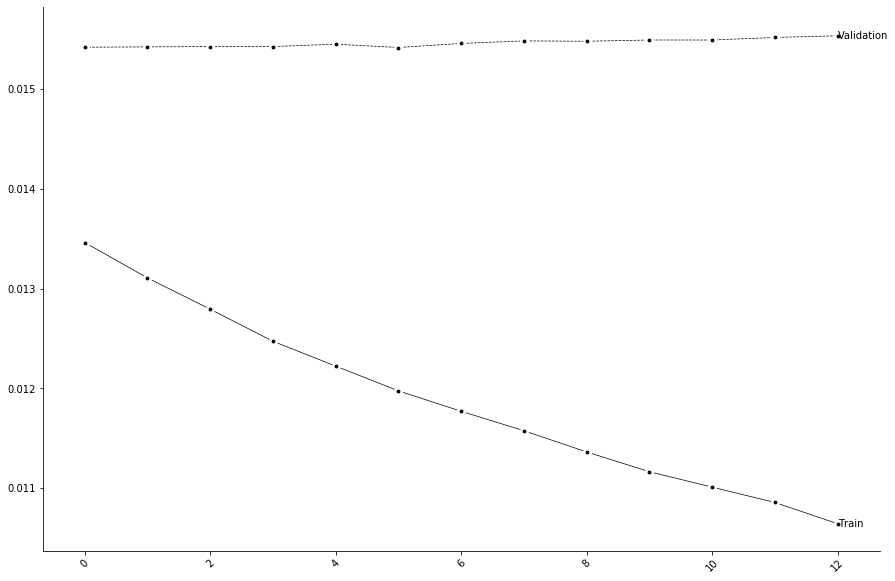

In [45]:
# First model units.
X_train = train_x_v2.to_numpy(copy = True)  
X_dev = test_x_v2.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)


train_batches_full_base = torch.tensor(X_train, dtype=torch.float32)
dev_batches_full_base = torch.tensor(X_dev, dtype=torch.float32)
    
save_file_aux = path_holdout + "log_loss_units_aux.csv"
save_file_final = path_holdout + "log_loss_units_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 2).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 2
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = 290               #Hyperparameter
        batch_size = 32             #Hyperparameter
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(parameter*X_train.shape[1])), 
                    nn.ReLU6(),  
                    nn.Linear(int(parameter*X_train.shape[1]), 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )

        lr = 0.1 #Hyperparameter
        momentum = 0 
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        out_train = model(train_batches_full_base) 
        out_dev = model(dev_batches_full_base) 
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

Using the nonscored Mechanisms of actions as exogenous variables did not help in our model.